In [1]:
import tensorflow as tf
from tensorflow.keras import Input, regularizers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Dropout, Flatten, Convolution2D, MaxPool2D, GlobalAveragePooling2D
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.callbacks import ModelCheckpoint, CSVLogger
import os
from tqdm import tqdm
import matplotlib.pyplot as plt
import numpy as np
import os

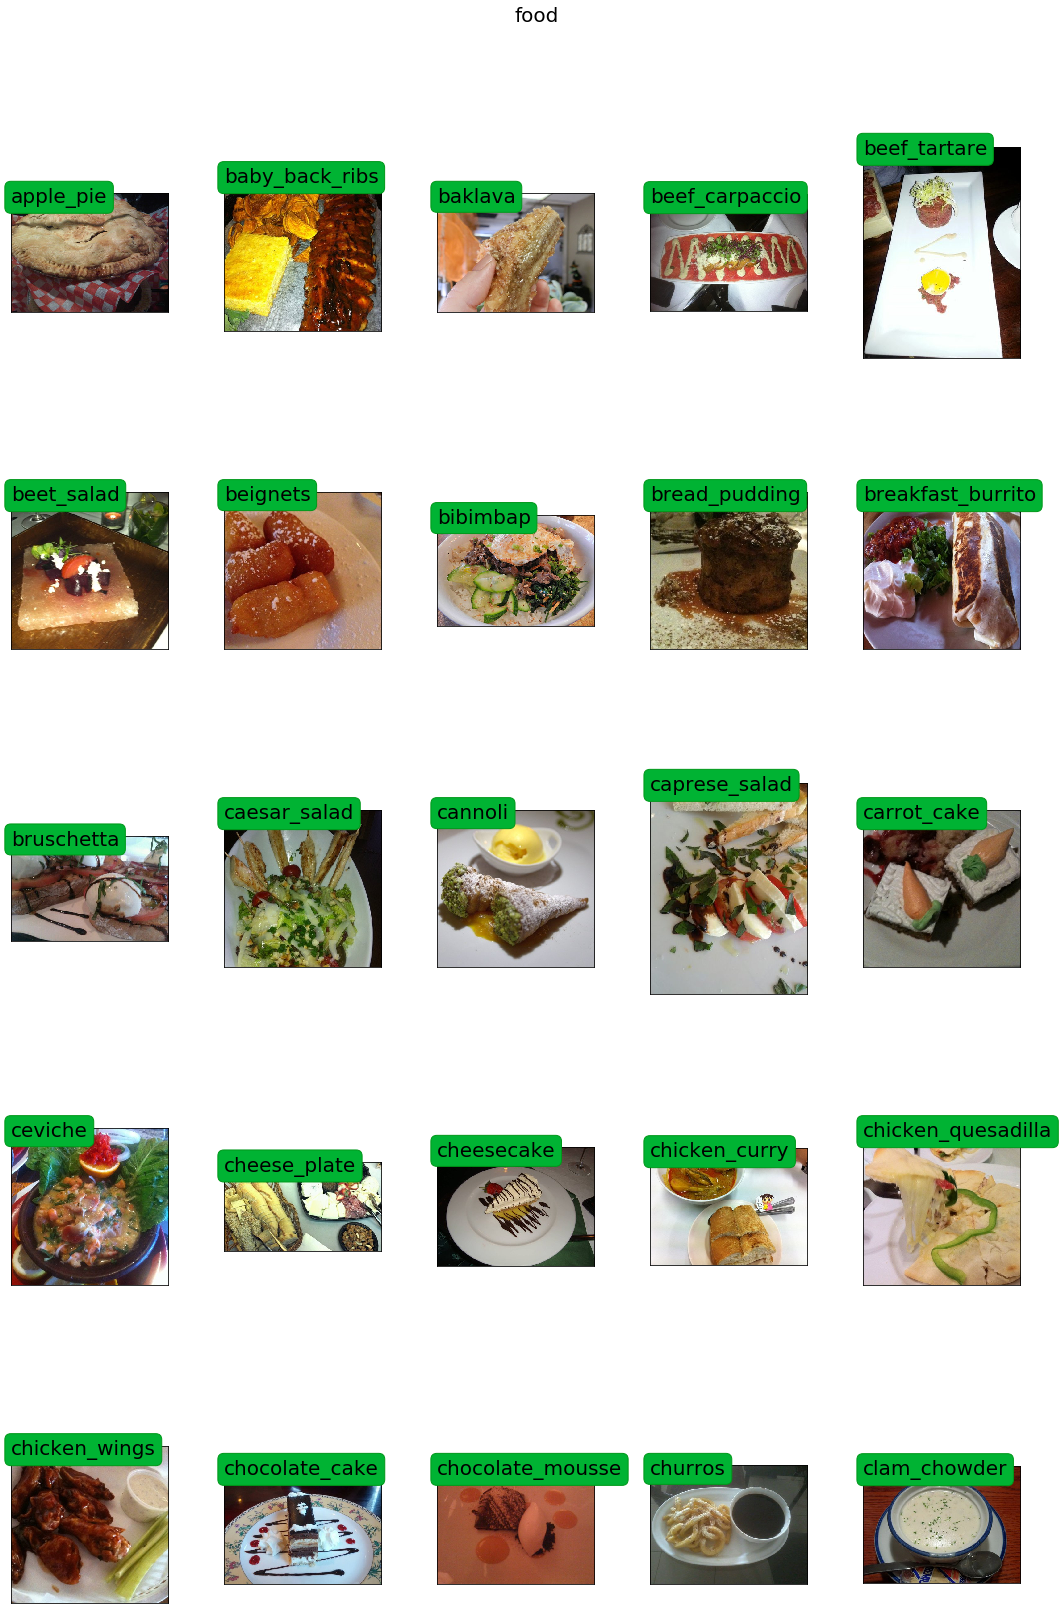

In [2]:
root_dir = 'train/'
rows = 5
cols = 5
fig, ax = plt.subplots(rows, cols,  figsize=(15, 25))
fig.suptitle('food', fontsize=20)
sorted_food_dirs = sorted(os.listdir(root_dir))
# print(sorted_food_dirs)
for i in range(rows):
    for j in range(cols):
        food_dir = sorted_food_dirs[i*cols + j]
        all_files = os.listdir(os.path.join(root_dir, food_dir))
        rand_img = np.random.choice(all_files)
        img = plt.imread(os.path.join(root_dir, food_dir, rand_img))
        ax[i][j].imshow(img)
        ec = (0, .6, .1)
        fc = (0, .7, .2)
        ax[i][j].text(0, -20, food_dir, size=20, rotation=0,
                ha="left", va="top",
                bbox=dict(boxstyle="round", ec=ec, fc=fc))
plt.setp(ax, xticks=[], yticks=[])
plt.tight_layout(rect=[0, 0.03, 1, 0.95])

In [3]:
BATCH_SIZE = 16
INPUT_SIZE = (299, 299)
EPOCH = 32
n_classes = 101
TRAIN_PATH = 'train/'
TEST_PATH = 'test/'
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
os.environ['CUDA_VISIBLE_DEVICES'] = '0'

train_datagen = ImageDataGenerator(rescale=1./255,
#                                    featurewise_center=False,  # set input mean to 0 over the dataset
#                                    samplewise_center=False,  # set each sample mean to 0
#                                    featurewise_std_normalization=False,  # divide inputs by std of the dataset
#                                    samplewise_std_normalization=False,  # divide each input by its std
                                   zoom_range=[.8, 1],
#                                    zca_whitening=True,
                                   shear_range=0.2,
                                   width_shift_range=0.2,
                                   height_shift_range=0.2,
                                   horizontal_flip=True,
                                   vertical_flip=False,
                                   channel_shift_range=30,
                                   fill_mode='reflect',
                                   validation_split=0.2
                                  )



train_generator = train_datagen.flow_from_directory(TRAIN_PATH,
                                                    target_size=INPUT_SIZE,
                                                    batch_size=BATCH_SIZE,
                                                    class_mode='categorical',
                                                    subset='training'
                                                   )

val_generator = train_datagen.flow_from_directory(TRAIN_PATH,
                                                  target_size=INPUT_SIZE,
                                                  batch_size=BATCH_SIZE,
                                                  class_mode='categorical',
                                                  subset='validation'
                                                   )
val_generator = train_datagen.flow_from_directory(TRAIN_PATH,
                                                  target_size=INPUT_SIZE,
                                                  batch_size=BATCH_SIZE,
                                                  class_mode='categorical',
                                                  subset='validation'
                                                   )


Found 60600 images belonging to 101 classes.
Found 15150 images belonging to 101 classes.
Found 15150 images belonging to 101 classes.


In [4]:
inception_model = InceptionV3(weights='imagenet', 
                              include_top=False, 
                              input_tensor=Input(shape=(INPUT_SIZE[0], INPUT_SIZE[1], 3))
                             )

In [5]:
inception_model.summary()

Model: "inception_v3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 299, 299, 3) 0                                            
__________________________________________________________________________________________________
conv2d_94 (Conv2D)              (None, 149, 149, 32) 864         input_2[0][0]                    
__________________________________________________________________________________________________
batch_normalization_94 (BatchNo (None, 149, 149, 32) 96          conv2d_94[0][0]                  
__________________________________________________________________________________________________
activation_94 (Activation)      (None, 149, 149, 32) 0           batch_normalization_94[0][0]     
_______________________________________________________________________________________

__________________________________________________________________________________________________
batch_normalization_113 (BatchN (None, 35, 35, 64)   192         conv2d_113[0][0]                 
__________________________________________________________________________________________________
batch_normalization_115 (BatchN (None, 35, 35, 64)   192         conv2d_115[0][0]                 
__________________________________________________________________________________________________
batch_normalization_118 (BatchN (None, 35, 35, 96)   288         conv2d_118[0][0]                 
__________________________________________________________________________________________________
batch_normalization_119 (BatchN (None, 35, 35, 64)   192         conv2d_119[0][0]                 
__________________________________________________________________________________________________
activation_113 (Activation)     (None, 35, 35, 64)   0           batch_normalization_113[0][0]    
__________

__________________________________________________________________________________________________
batch_normalization_134 (BatchN (None, 17, 17, 192)  576         conv2d_134[0][0]                 
__________________________________________________________________________________________________
batch_normalization_137 (BatchN (None, 17, 17, 192)  576         conv2d_137[0][0]                 
__________________________________________________________________________________________________
batch_normalization_142 (BatchN (None, 17, 17, 192)  576         conv2d_142[0][0]                 
__________________________________________________________________________________________________
batch_normalization_143 (BatchN (None, 17, 17, 192)  576         conv2d_143[0][0]                 
__________________________________________________________________________________________________
activation_134 (Activation)     (None, 17, 17, 192)  0           batch_normalization_134[0][0]    
__________

batch_normalization_167 (BatchN (None, 17, 17, 192)  576         conv2d_167[0][0]                 
__________________________________________________________________________________________________
activation_167 (Activation)     (None, 17, 17, 192)  0           batch_normalization_167[0][0]    
__________________________________________________________________________________________________
conv2d_164 (Conv2D)             (None, 17, 17, 192)  147456      mixed7[0][0]                     
__________________________________________________________________________________________________
conv2d_168 (Conv2D)             (None, 17, 17, 192)  258048      activation_167[0][0]             
__________________________________________________________________________________________________
batch_normalization_164 (BatchN (None, 17, 17, 192)  576         conv2d_164[0][0]                 
__________________________________________________________________________________________________
batch_norm

                                                                 mixed9_1[0][0]                   
                                                                 concatenate_3[0][0]              
                                                                 activation_187[0][0]             
Total params: 21,802,784
Trainable params: 21,768,352
Non-trainable params: 34,432
__________________________________________________________________________________________________


In [6]:
out = inception_model.output
out = GlobalAveragePooling2D()(out)
out = Dropout(0.2)(out)
out = Dense(n_classes, kernel_regularizer=regularizers.l2(.0005), activation='softmax')(out)

model = Model(inputs=inception_model.input, outputs=out)

SGD_Optimizer = SGD(lr=.01, momentum=.9)
model.compile(optimizer=SGD_Optimizer, loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 299, 299, 3) 0                                            
__________________________________________________________________________________________________
conv2d_94 (Conv2D)              (None, 149, 149, 32) 864         input_2[0][0]                    
__________________________________________________________________________________________________
batch_normalization_94 (BatchNo (None, 149, 149, 32) 96          conv2d_94[0][0]                  
__________________________________________________________________________________________________
activation_94 (Activation)      (None, 149, 149, 32) 0           batch_normalization_94[0][0]     
______________________________________________________________________________________________

__________________________________________________________________________________________________
batch_normalization_113 (BatchN (None, 35, 35, 64)   192         conv2d_113[0][0]                 
__________________________________________________________________________________________________
batch_normalization_115 (BatchN (None, 35, 35, 64)   192         conv2d_115[0][0]                 
__________________________________________________________________________________________________
batch_normalization_118 (BatchN (None, 35, 35, 96)   288         conv2d_118[0][0]                 
__________________________________________________________________________________________________
batch_normalization_119 (BatchN (None, 35, 35, 64)   192         conv2d_119[0][0]                 
__________________________________________________________________________________________________
activation_113 (Activation)     (None, 35, 35, 64)   0           batch_normalization_113[0][0]    
__________

__________________________________________________________________________________________________
batch_normalization_134 (BatchN (None, 17, 17, 192)  576         conv2d_134[0][0]                 
__________________________________________________________________________________________________
batch_normalization_137 (BatchN (None, 17, 17, 192)  576         conv2d_137[0][0]                 
__________________________________________________________________________________________________
batch_normalization_142 (BatchN (None, 17, 17, 192)  576         conv2d_142[0][0]                 
__________________________________________________________________________________________________
batch_normalization_143 (BatchN (None, 17, 17, 192)  576         conv2d_143[0][0]                 
__________________________________________________________________________________________________
activation_134 (Activation)     (None, 17, 17, 192)  0           batch_normalization_134[0][0]    
__________

batch_normalization_167 (BatchN (None, 17, 17, 192)  576         conv2d_167[0][0]                 
__________________________________________________________________________________________________
activation_167 (Activation)     (None, 17, 17, 192)  0           batch_normalization_167[0][0]    
__________________________________________________________________________________________________
conv2d_164 (Conv2D)             (None, 17, 17, 192)  147456      mixed7[0][0]                     
__________________________________________________________________________________________________
conv2d_168 (Conv2D)             (None, 17, 17, 192)  258048      activation_167[0][0]             
__________________________________________________________________________________________________
batch_normalization_164 (BatchN (None, 17, 17, 192)  576         conv2d_164[0][0]                 
__________________________________________________________________________________________________
batch_norm

                                                                 mixed9_1[0][0]                   
                                                                 concatenate_3[0][0]              
                                                                 activation_187[0][0]             
__________________________________________________________________________________________________
global_average_pooling2d (Globa (None, 2048)         0           mixed10[0][0]                    
__________________________________________________________________________________________________
dropout (Dropout)               (None, 2048)         0           global_average_pooling2d[0][0]   
__________________________________________________________________________________________________
dense (Dense)                   (None, 101)          206949      dropout[0][0]                    
Total params: 22,009,733
Trainable params: 21,975,301
Non-trainable params: 34,432
__________________________

In [7]:
checkpoint = ModelCheckpoint(filepath='model.{epoch:02d}-{val_loss:.2f}.hdf5', save_best_only=True)
csv_logger = CSVLogger('train.log')
history = model.fit_generator(train_generator,
                              steps_per_epoch = train_generator.samples // BATCH_SIZE,
                              validation_data = val_generator,
                              validation_steps = val_generator.samples // BATCH_SIZE,
                              epochs=EPOCH,
#                               verbose=1,
                              callbacks=[checkpoint, csv_logger])

Instructions for updating:
Please use Model.fit, which supports generators.
  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 3787 steps, validate for 946 steps
Epoch 1/32


 177/3787 [>.............................] - ETA: 12:24:44 - loss: 4.8277 - accuracy: 0.06 - ETA: 6:18:07 - loss: 4.9873 - accuracy: 0.0312 - ETA: 4:15:47 - loss: 4.8907 - accuracy: 0.020 - ETA: 3:14:43 - loss: 4.8616 - accuracy: 0.015 - ETA: 2:37:59 - loss: 4.8363 - accuracy: 0.025 - ETA: 2:13:31 - loss: 4.8391 - accuracy: 0.020 - ETA: 1:56:02 - loss: 4.8515 - accuracy: 0.026 - ETA: 1:42:56 - loss: 4.8579 - accuracy: 0.023 - ETA: 1:32:45 - loss: 4.8480 - accuracy: 0.020 - ETA: 1:24:35 - loss: 4.8219 - accuracy: 0.025 - ETA: 1:17:55 - loss: 4.7890 - accuracy: 0.028 - ETA: 1:12:21 - loss: 4.7934 - accuracy: 0.026 - ETA: 1:07:39 - loss: 4.8075 - accuracy: 0.024 - ETA: 1:03:37 - loss: 4.8111 - accuracy: 0.022 - ETA: 1:00:08 - loss: 4.8371 - accuracy: 0.020 - ETA: 57:05 - loss: 4.8248 - accuracy: 0.0273  - ETA: 54:24 - loss: 4.8225 - accuracy: 0.029 - ETA: 52:00 - loss: 4.8130 - accuracy: 0.031 - ETA: 49:51 - loss: 4.8256 - accuracy: 0.032 - ETA: 47:55 - loss: 4.8440 - accuracy: 0.031 - ET

1067/3787 [=======>......................] - ETA: 14:21 - loss: 3.4422 - accuracy: 0.229 - ETA: 14:21 - loss: 3.4424 - accuracy: 0.229 - ETA: 14:20 - loss: 3.4416 - accuracy: 0.229 - ETA: 14:20 - loss: 3.4415 - accuracy: 0.228 - ETA: 14:20 - loss: 3.4415 - accuracy: 0.228 - ETA: 14:19 - loss: 3.4417 - accuracy: 0.228 - ETA: 14:19 - loss: 3.4417 - accuracy: 0.228 - ETA: 14:19 - loss: 3.4405 - accuracy: 0.229 - ETA: 14:19 - loss: 3.4398 - accuracy: 0.229 - ETA: 14:18 - loss: 3.4399 - accuracy: 0.229 - ETA: 14:18 - loss: 3.4387 - accuracy: 0.229 - ETA: 14:18 - loss: 3.4391 - accuracy: 0.229 - ETA: 14:17 - loss: 3.4386 - accuracy: 0.229 - ETA: 14:17 - loss: 3.4386 - accuracy: 0.229 - ETA: 14:17 - loss: 3.4377 - accuracy: 0.229 - ETA: 14:16 - loss: 3.4363 - accuracy: 0.230 - ETA: 14:16 - loss: 3.4358 - accuracy: 0.230 - ETA: 14:16 - loss: 3.4352 - accuracy: 0.230 - ETA: 14:15 - loss: 3.4348 - accuracy: 0.230 - ETA: 14:15 - loss: 3.4347 - accuracy: 0.230 - ETA: 14:15 - loss: 3.4342 - accurac

1245/3787 [========>.....................] - ETA: 13:26 - loss: 3.3402 - accuracy: 0.248 - ETA: 13:26 - loss: 3.3401 - accuracy: 0.249 - ETA: 13:26 - loss: 3.3393 - accuracy: 0.249 - ETA: 13:25 - loss: 3.3392 - accuracy: 0.249 - ETA: 13:25 - loss: 3.3386 - accuracy: 0.249 - ETA: 13:25 - loss: 3.3381 - accuracy: 0.249 - ETA: 13:24 - loss: 3.3379 - accuracy: 0.249 - ETA: 13:24 - loss: 3.3373 - accuracy: 0.249 - ETA: 13:24 - loss: 3.3374 - accuracy: 0.249 - ETA: 13:24 - loss: 3.3362 - accuracy: 0.250 - ETA: 13:23 - loss: 3.3351 - accuracy: 0.250 - ETA: 13:23 - loss: 3.3352 - accuracy: 0.250 - ETA: 13:23 - loss: 3.3348 - accuracy: 0.250 - ETA: 13:22 - loss: 3.3348 - accuracy: 0.250 - ETA: 13:22 - loss: 3.3341 - accuracy: 0.250 - ETA: 13:22 - loss: 3.3333 - accuracy: 0.250 - ETA: 13:21 - loss: 3.3331 - accuracy: 0.250 - ETA: 13:21 - loss: 3.3328 - accuracy: 0.250 - ETA: 13:21 - loss: 3.3324 - accuracy: 0.250 - ETA: 13:20 - loss: 3.3327 - accuracy: 0.250 - ETA: 13:20 - loss: 3.3321 - accurac

1423/3787 [==========>...................] - ETA: 12:31 - loss: 3.2565 - accuracy: 0.263 - ETA: 12:31 - loss: 3.2561 - accuracy: 0.263 - ETA: 12:31 - loss: 3.2558 - accuracy: 0.263 - ETA: 12:30 - loss: 3.2555 - accuracy: 0.263 - ETA: 12:30 - loss: 3.2548 - accuracy: 0.263 - ETA: 12:30 - loss: 3.2544 - accuracy: 0.263 - ETA: 12:29 - loss: 3.2540 - accuracy: 0.264 - ETA: 12:29 - loss: 3.2532 - accuracy: 0.264 - ETA: 12:29 - loss: 3.2532 - accuracy: 0.264 - ETA: 12:28 - loss: 3.2524 - accuracy: 0.264 - ETA: 12:28 - loss: 3.2517 - accuracy: 0.264 - ETA: 12:28 - loss: 3.2517 - accuracy: 0.264 - ETA: 12:27 - loss: 3.2518 - accuracy: 0.264 - ETA: 12:27 - loss: 3.2517 - accuracy: 0.264 - ETA: 12:27 - loss: 3.2511 - accuracy: 0.264 - ETA: 12:27 - loss: 3.2502 - accuracy: 0.264 - ETA: 12:26 - loss: 3.2495 - accuracy: 0.265 - ETA: 12:26 - loss: 3.2495 - accuracy: 0.265 - ETA: 12:26 - loss: 3.2492 - accuracy: 0.265 - ETA: 12:25 - loss: 3.2485 - accuracy: 0.265 - ETA: 12:25 - loss: 3.2475 - accurac

1601/3787 [===========>..................] - ETA: 11:35 - loss: 3.1804 - accuracy: 0.278 - ETA: 11:35 - loss: 3.1800 - accuracy: 0.278 - ETA: 11:35 - loss: 3.1796 - accuracy: 0.278 - ETA: 11:34 - loss: 3.1791 - accuracy: 0.278 - ETA: 11:34 - loss: 3.1786 - accuracy: 0.278 - ETA: 11:34 - loss: 3.1782 - accuracy: 0.278 - ETA: 11:34 - loss: 3.1780 - accuracy: 0.278 - ETA: 11:33 - loss: 3.1774 - accuracy: 0.278 - ETA: 11:33 - loss: 3.1765 - accuracy: 0.278 - ETA: 11:33 - loss: 3.1758 - accuracy: 0.279 - ETA: 11:32 - loss: 3.1757 - accuracy: 0.279 - ETA: 11:32 - loss: 3.1751 - accuracy: 0.279 - ETA: 11:32 - loss: 3.1745 - accuracy: 0.279 - ETA: 11:31 - loss: 3.1740 - accuracy: 0.279 - ETA: 11:31 - loss: 3.1741 - accuracy: 0.279 - ETA: 11:31 - loss: 3.1739 - accuracy: 0.279 - ETA: 11:30 - loss: 3.1735 - accuracy: 0.279 - ETA: 11:30 - loss: 3.1738 - accuracy: 0.279 - ETA: 11:30 - loss: 3.1733 - accuracy: 0.280 - ETA: 11:29 - loss: 3.1727 - accuracy: 0.280 - ETA: 11:29 - loss: 3.1719 - accurac

1781/3787 [=============>................] - ETA: 10:40 - loss: 3.1081 - accuracy: 0.292 - ETA: 10:40 - loss: 3.1080 - accuracy: 0.292 - ETA: 10:40 - loss: 3.1076 - accuracy: 0.292 - ETA: 10:39 - loss: 3.1073 - accuracy: 0.292 - ETA: 10:39 - loss: 3.1068 - accuracy: 0.292 - ETA: 10:39 - loss: 3.1061 - accuracy: 0.292 - ETA: 10:38 - loss: 3.1058 - accuracy: 0.292 - ETA: 10:38 - loss: 3.1051 - accuracy: 0.293 - ETA: 10:38 - loss: 3.1051 - accuracy: 0.293 - ETA: 10:38 - loss: 3.1052 - accuracy: 0.293 - ETA: 10:37 - loss: 3.1050 - accuracy: 0.293 - ETA: 10:37 - loss: 3.1049 - accuracy: 0.293 - ETA: 10:37 - loss: 3.1050 - accuracy: 0.293 - ETA: 10:36 - loss: 3.1043 - accuracy: 0.293 - ETA: 10:36 - loss: 3.1043 - accuracy: 0.293 - ETA: 10:36 - loss: 3.1040 - accuracy: 0.293 - ETA: 10:35 - loss: 3.1037 - accuracy: 0.293 - ETA: 10:35 - loss: 3.1032 - accuracy: 0.293 - ETA: 10:35 - loss: 3.1026 - accuracy: 0.293 - ETA: 10:34 - loss: 3.1020 - accuracy: 0.293 - ETA: 10:34 - loss: 3.1017 - accurac

1967/3787 [==============>...............] - ETA: 9:45 - loss: 3.0478 - accuracy: 0.30 - ETA: 9:45 - loss: 3.0476 - accuracy: 0.30 - ETA: 9:45 - loss: 3.0472 - accuracy: 0.30 - ETA: 9:44 - loss: 3.0466 - accuracy: 0.30 - ETA: 9:44 - loss: 3.0463 - accuracy: 0.30 - ETA: 9:44 - loss: 3.0462 - accuracy: 0.30 - ETA: 9:43 - loss: 3.0459 - accuracy: 0.30 - ETA: 9:43 - loss: 3.0457 - accuracy: 0.30 - ETA: 9:43 - loss: 3.0459 - accuracy: 0.30 - ETA: 9:42 - loss: 3.0453 - accuracy: 0.30 - ETA: 9:42 - loss: 3.0452 - accuracy: 0.30 - ETA: 9:42 - loss: 3.0444 - accuracy: 0.30 - ETA: 9:42 - loss: 3.0446 - accuracy: 0.30 - ETA: 9:41 - loss: 3.0444 - accuracy: 0.30 - ETA: 9:41 - loss: 3.0441 - accuracy: 0.30 - ETA: 9:41 - loss: 3.0436 - accuracy: 0.30 - ETA: 9:40 - loss: 3.0438 - accuracy: 0.30 - ETA: 9:40 - loss: 3.0437 - accuracy: 0.30 - ETA: 9:40 - loss: 3.0434 - accuracy: 0.30 - ETA: 9:39 - loss: 3.0430 - accuracy: 0.30 - ETA: 9:39 - loss: 3.0425 - accuracy: 0.30 - ETA: 9:39 - loss: 3.0422 - accu

2153/3787 [================>.............] - ETA: 8:49 - loss: 2.9902 - accuracy: 0.31 - ETA: 8:49 - loss: 2.9900 - accuracy: 0.31 - ETA: 8:48 - loss: 2.9896 - accuracy: 0.31 - ETA: 8:48 - loss: 2.9897 - accuracy: 0.31 - ETA: 8:48 - loss: 2.9893 - accuracy: 0.31 - ETA: 8:48 - loss: 2.9887 - accuracy: 0.31 - ETA: 8:47 - loss: 2.9885 - accuracy: 0.31 - ETA: 8:47 - loss: 2.9880 - accuracy: 0.31 - ETA: 8:47 - loss: 2.9879 - accuracy: 0.31 - ETA: 8:46 - loss: 2.9878 - accuracy: 0.31 - ETA: 8:46 - loss: 2.9873 - accuracy: 0.31 - ETA: 8:46 - loss: 2.9867 - accuracy: 0.31 - ETA: 8:45 - loss: 2.9865 - accuracy: 0.31 - ETA: 8:45 - loss: 2.9859 - accuracy: 0.31 - ETA: 8:45 - loss: 2.9857 - accuracy: 0.31 - ETA: 8:45 - loss: 2.9855 - accuracy: 0.31 - ETA: 8:44 - loss: 2.9850 - accuracy: 0.31 - ETA: 8:44 - loss: 2.9847 - accuracy: 0.31 - ETA: 8:44 - loss: 2.9849 - accuracy: 0.31 - ETA: 8:43 - loss: 2.9845 - accuracy: 0.31 - ETA: 8:43 - loss: 2.9840 - accuracy: 0.31 - ETA: 8:43 - loss: 2.9834 - accu

2339/3787 [=================>............] - ETA: 7:54 - loss: 2.9429 - accuracy: 0.32 - ETA: 7:54 - loss: 2.9424 - accuracy: 0.32 - ETA: 7:53 - loss: 2.9425 - accuracy: 0.32 - ETA: 7:53 - loss: 2.9420 - accuracy: 0.32 - ETA: 7:53 - loss: 2.9423 - accuracy: 0.32 - ETA: 7:52 - loss: 2.9419 - accuracy: 0.32 - ETA: 7:52 - loss: 2.9416 - accuracy: 0.32 - ETA: 7:52 - loss: 2.9413 - accuracy: 0.32 - ETA: 7:52 - loss: 2.9411 - accuracy: 0.32 - ETA: 7:51 - loss: 2.9407 - accuracy: 0.32 - ETA: 7:51 - loss: 2.9406 - accuracy: 0.32 - ETA: 7:51 - loss: 2.9403 - accuracy: 0.32 - ETA: 7:50 - loss: 2.9402 - accuracy: 0.32 - ETA: 7:50 - loss: 2.9401 - accuracy: 0.32 - ETA: 7:50 - loss: 2.9398 - accuracy: 0.32 - ETA: 7:50 - loss: 2.9397 - accuracy: 0.32 - ETA: 7:49 - loss: 2.9392 - accuracy: 0.32 - ETA: 7:49 - loss: 2.9391 - accuracy: 0.32 - ETA: 7:49 - loss: 2.9393 - accuracy: 0.32 - ETA: 7:48 - loss: 2.9390 - accuracy: 0.32 - ETA: 7:48 - loss: 2.9391 - accuracy: 0.32 - ETA: 7:48 - loss: 2.9388 - accu

2525/3787 [===================>..........] - ETA: 6:59 - loss: 2.8944 - accuracy: 0.33 - ETA: 6:59 - loss: 2.8940 - accuracy: 0.33 - ETA: 6:59 - loss: 2.8941 - accuracy: 0.33 - ETA: 6:58 - loss: 2.8939 - accuracy: 0.33 - ETA: 6:58 - loss: 2.8933 - accuracy: 0.33 - ETA: 6:58 - loss: 2.8933 - accuracy: 0.33 - ETA: 6:57 - loss: 2.8935 - accuracy: 0.33 - ETA: 6:57 - loss: 2.8931 - accuracy: 0.33 - ETA: 6:57 - loss: 2.8932 - accuracy: 0.33 - ETA: 6:57 - loss: 2.8930 - accuracy: 0.33 - ETA: 6:56 - loss: 2.8932 - accuracy: 0.33 - ETA: 6:56 - loss: 2.8933 - accuracy: 0.33 - ETA: 6:56 - loss: 2.8926 - accuracy: 0.33 - ETA: 6:55 - loss: 2.8921 - accuracy: 0.33 - ETA: 6:55 - loss: 2.8922 - accuracy: 0.33 - ETA: 6:55 - loss: 2.8921 - accuracy: 0.33 - ETA: 6:54 - loss: 2.8918 - accuracy: 0.33 - ETA: 6:54 - loss: 2.8915 - accuracy: 0.33 - ETA: 6:54 - loss: 2.8913 - accuracy: 0.33 - ETA: 6:54 - loss: 2.8912 - accuracy: 0.33 - ETA: 6:53 - loss: 2.8910 - accuracy: 0.33 - ETA: 6:53 - loss: 2.8909 - accu

2711/3787 [====================>.........] - ETA: 6:05 - loss: 2.8531 - accuracy: 0.34 - ETA: 6:04 - loss: 2.8528 - accuracy: 0.34 - ETA: 6:04 - loss: 2.8527 - accuracy: 0.34 - ETA: 6:04 - loss: 2.8524 - accuracy: 0.34 - ETA: 6:04 - loss: 2.8525 - accuracy: 0.34 - ETA: 6:03 - loss: 2.8521 - accuracy: 0.34 - ETA: 6:03 - loss: 2.8517 - accuracy: 0.34 - ETA: 6:03 - loss: 2.8518 - accuracy: 0.34 - ETA: 6:02 - loss: 2.8515 - accuracy: 0.34 - ETA: 6:02 - loss: 2.8510 - accuracy: 0.34 - ETA: 6:02 - loss: 2.8508 - accuracy: 0.34 - ETA: 6:02 - loss: 2.8506 - accuracy: 0.34 - ETA: 6:01 - loss: 2.8503 - accuracy: 0.34 - ETA: 6:01 - loss: 2.8500 - accuracy: 0.34 - ETA: 6:01 - loss: 2.8501 - accuracy: 0.34 - ETA: 6:00 - loss: 2.8501 - accuracy: 0.34 - ETA: 6:00 - loss: 2.8495 - accuracy: 0.34 - ETA: 6:00 - loss: 2.8495 - accuracy: 0.34 - ETA: 5:59 - loss: 2.8494 - accuracy: 0.34 - ETA: 5:59 - loss: 2.8496 - accuracy: 0.34 - ETA: 5:59 - loss: 2.8494 - accuracy: 0.34 - ETA: 5:59 - loss: 2.8490 - accu

2897/3787 [=====================>........] - ETA: 5:10 - loss: 2.8164 - accuracy: 0.35 - ETA: 5:10 - loss: 2.8165 - accuracy: 0.35 - ETA: 5:10 - loss: 2.8165 - accuracy: 0.35 - ETA: 5:10 - loss: 2.8164 - accuracy: 0.35 - ETA: 5:09 - loss: 2.8163 - accuracy: 0.35 - ETA: 5:09 - loss: 2.8160 - accuracy: 0.35 - ETA: 5:09 - loss: 2.8162 - accuracy: 0.35 - ETA: 5:08 - loss: 2.8159 - accuracy: 0.35 - ETA: 5:08 - loss: 2.8155 - accuracy: 0.35 - ETA: 5:08 - loss: 2.8151 - accuracy: 0.35 - ETA: 5:07 - loss: 2.8148 - accuracy: 0.35 - ETA: 5:07 - loss: 2.8152 - accuracy: 0.35 - ETA: 5:07 - loss: 2.8148 - accuracy: 0.35 - ETA: 5:07 - loss: 2.8147 - accuracy: 0.35 - ETA: 5:06 - loss: 2.8148 - accuracy: 0.35 - ETA: 5:06 - loss: 2.8143 - accuracy: 0.35 - ETA: 5:06 - loss: 2.8143 - accuracy: 0.35 - ETA: 5:05 - loss: 2.8138 - accuracy: 0.35 - ETA: 5:05 - loss: 2.8138 - accuracy: 0.35 - ETA: 5:05 - loss: 2.8138 - accuracy: 0.35 - ETA: 5:05 - loss: 2.8135 - accuracy: 0.35 - ETA: 5:04 - loss: 2.8134 - accu

3083/3787 [=======================>......] - ETA: 4:16 - loss: 2.7833 - accuracy: 0.35 - ETA: 4:16 - loss: 2.7831 - accuracy: 0.35 - ETA: 4:16 - loss: 2.7832 - accuracy: 0.35 - ETA: 4:15 - loss: 2.7829 - accuracy: 0.35 - ETA: 4:15 - loss: 2.7826 - accuracy: 0.35 - ETA: 4:15 - loss: 2.7823 - accuracy: 0.35 - ETA: 4:14 - loss: 2.7824 - accuracy: 0.35 - ETA: 4:14 - loss: 2.7822 - accuracy: 0.35 - ETA: 4:14 - loss: 2.7820 - accuracy: 0.35 - ETA: 4:14 - loss: 2.7816 - accuracy: 0.35 - ETA: 4:13 - loss: 2.7812 - accuracy: 0.35 - ETA: 4:13 - loss: 2.7809 - accuracy: 0.35 - ETA: 4:13 - loss: 2.7804 - accuracy: 0.35 - ETA: 4:12 - loss: 2.7802 - accuracy: 0.35 - ETA: 4:12 - loss: 2.7800 - accuracy: 0.35 - ETA: 4:12 - loss: 2.7801 - accuracy: 0.35 - ETA: 4:12 - loss: 2.7800 - accuracy: 0.35 - ETA: 4:11 - loss: 2.7798 - accuracy: 0.35 - ETA: 4:11 - loss: 2.7794 - accuracy: 0.35 - ETA: 4:11 - loss: 2.7792 - accuracy: 0.35 - ETA: 4:10 - loss: 2.7788 - accuracy: 0.35 - ETA: 4:10 - loss: 2.7785 - accu

3269/3787 [========================>.....] - ETA: 3:22 - loss: 2.7476 - accuracy: 0.36 - ETA: 3:22 - loss: 2.7473 - accuracy: 0.36 - ETA: 3:22 - loss: 2.7472 - accuracy: 0.36 - ETA: 3:21 - loss: 2.7470 - accuracy: 0.36 - ETA: 3:21 - loss: 2.7467 - accuracy: 0.36 - ETA: 3:21 - loss: 2.7466 - accuracy: 0.36 - ETA: 3:20 - loss: 2.7465 - accuracy: 0.36 - ETA: 3:20 - loss: 2.7461 - accuracy: 0.36 - ETA: 3:20 - loss: 2.7458 - accuracy: 0.36 - ETA: 3:20 - loss: 2.7456 - accuracy: 0.36 - ETA: 3:19 - loss: 2.7457 - accuracy: 0.36 - ETA: 3:19 - loss: 2.7454 - accuracy: 0.36 - ETA: 3:19 - loss: 2.7452 - accuracy: 0.36 - ETA: 3:18 - loss: 2.7448 - accuracy: 0.36 - ETA: 3:18 - loss: 2.7448 - accuracy: 0.36 - ETA: 3:18 - loss: 2.7448 - accuracy: 0.36 - ETA: 3:18 - loss: 2.7444 - accuracy: 0.36 - ETA: 3:17 - loss: 2.7442 - accuracy: 0.36 - ETA: 3:17 - loss: 2.7442 - accuracy: 0.36 - ETA: 3:17 - loss: 2.7442 - accuracy: 0.36 - ETA: 3:16 - loss: 2.7440 - accuracy: 0.36 - ETA: 3:16 - loss: 2.7437 - accu

3455/3787 [==========================>...] - ETA: 2:28 - loss: 2.7140 - accuracy: 0.37 - ETA: 2:28 - loss: 2.7137 - accuracy: 0.37 - ETA: 2:28 - loss: 2.7137 - accuracy: 0.37 - ETA: 2:28 - loss: 2.7136 - accuracy: 0.37 - ETA: 2:27 - loss: 2.7132 - accuracy: 0.37 - ETA: 2:27 - loss: 2.7132 - accuracy: 0.37 - ETA: 2:27 - loss: 2.7131 - accuracy: 0.37 - ETA: 2:26 - loss: 2.7129 - accuracy: 0.37 - ETA: 2:26 - loss: 2.7130 - accuracy: 0.37 - ETA: 2:26 - loss: 2.7130 - accuracy: 0.37 - ETA: 2:26 - loss: 2.7129 - accuracy: 0.37 - ETA: 2:25 - loss: 2.7127 - accuracy: 0.37 - ETA: 2:25 - loss: 2.7126 - accuracy: 0.37 - ETA: 2:25 - loss: 2.7126 - accuracy: 0.37 - ETA: 2:24 - loss: 2.7122 - accuracy: 0.37 - ETA: 2:24 - loss: 2.7120 - accuracy: 0.37 - ETA: 2:24 - loss: 2.7120 - accuracy: 0.37 - ETA: 2:23 - loss: 2.7117 - accuracy: 0.37 - ETA: 2:23 - loss: 2.7115 - accuracy: 0.37 - ETA: 2:23 - loss: 2.7116 - accuracy: 0.37 - ETA: 2:23 - loss: 2.7115 - accuracy: 0.37 - ETA: 2:22 - loss: 2.7114 - accu

3641/3787 [===========================>..] - ETA: 1:35 - loss: 2.6856 - accuracy: 0.37 - ETA: 1:34 - loss: 2.6854 - accuracy: 0.37 - ETA: 1:34 - loss: 2.6854 - accuracy: 0.37 - ETA: 1:34 - loss: 2.6852 - accuracy: 0.37 - ETA: 1:34 - loss: 2.6850 - accuracy: 0.37 - ETA: 1:33 - loss: 2.6849 - accuracy: 0.37 - ETA: 1:33 - loss: 2.6847 - accuracy: 0.37 - ETA: 1:33 - loss: 2.6843 - accuracy: 0.37 - ETA: 1:32 - loss: 2.6841 - accuracy: 0.37 - ETA: 1:32 - loss: 2.6840 - accuracy: 0.37 - ETA: 1:32 - loss: 2.6838 - accuracy: 0.37 - ETA: 1:32 - loss: 2.6836 - accuracy: 0.37 - ETA: 1:31 - loss: 2.6835 - accuracy: 0.37 - ETA: 1:31 - loss: 2.6833 - accuracy: 0.37 - ETA: 1:31 - loss: 2.6831 - accuracy: 0.37 - ETA: 1:30 - loss: 2.6830 - accuracy: 0.37 - ETA: 1:30 - loss: 2.6829 - accuracy: 0.37 - ETA: 1:30 - loss: 2.6827 - accuracy: 0.37 - ETA: 1:30 - loss: 2.6825 - accuracy: 0.37 - ETA: 1:29 - loss: 2.6823 - accuracy: 0.37 - ETA: 1:29 - loss: 2.6820 - accuracy: 0.37 - ETA: 1:29 - loss: 2.6818 - accu

3787/3787 [==============================] - ETA: 41s - loss: 2.6588 - accuracy: 0.383 - ETA: 41s - loss: 2.6588 - accuracy: 0.383 - ETA: 41s - loss: 2.6587 - accuracy: 0.383 - ETA: 40s - loss: 2.6587 - accuracy: 0.383 - ETA: 40s - loss: 2.6584 - accuracy: 0.383 - ETA: 40s - loss: 2.6581 - accuracy: 0.384 - ETA: 39s - loss: 2.6581 - accuracy: 0.384 - ETA: 39s - loss: 2.6580 - accuracy: 0.384 - ETA: 39s - loss: 2.6578 - accuracy: 0.384 - ETA: 39s - loss: 2.6575 - accuracy: 0.384 - ETA: 38s - loss: 2.6574 - accuracy: 0.384 - ETA: 38s - loss: 2.6572 - accuracy: 0.384 - ETA: 38s - loss: 2.6573 - accuracy: 0.384 - ETA: 37s - loss: 2.6572 - accuracy: 0.384 - ETA: 37s - loss: 2.6570 - accuracy: 0.384 - ETA: 37s - loss: 2.6568 - accuracy: 0.384 - ETA: 37s - loss: 2.6567 - accuracy: 0.384 - ETA: 36s - loss: 2.6565 - accuracy: 0.384 - ETA: 36s - loss: 2.6563 - accuracy: 0.384 - ETA: 36s - loss: 2.6562 - accuracy: 0.384 - ETA: 35s - loss: 2.6560 - accuracy: 0.384 - ETA: 35s - loss: 2.6559 - accur

 178/3787 [>.............................] - ETA: 31:35 - loss: 1.4588 - accuracy: 0.562 - ETA: 23:18 - loss: 2.1959 - accuracy: 0.468 - ETA: 21:23 - loss: 1.9712 - accuracy: 0.500 - ETA: 20:22 - loss: 2.0504 - accuracy: 0.500 - ETA: 19:48 - loss: 1.9145 - accuracy: 0.537 - ETA: 19:23 - loss: 1.8106 - accuracy: 0.552 - ETA: 19:07 - loss: 1.8517 - accuracy: 0.553 - ETA: 18:56 - loss: 1.9635 - accuracy: 0.515 - ETA: 18:44 - loss: 1.9197 - accuracy: 0.534 - ETA: 18:36 - loss: 1.9385 - accuracy: 0.537 - ETA: 18:27 - loss: 1.9636 - accuracy: 0.534 - ETA: 18:21 - loss: 1.8967 - accuracy: 0.546 - ETA: 18:17 - loss: 1.9349 - accuracy: 0.538 - ETA: 18:13 - loss: 1.9620 - accuracy: 0.526 - ETA: 18:11 - loss: 1.9535 - accuracy: 0.525 - ETA: 18:11 - loss: 1.9892 - accuracy: 0.511 - ETA: 18:09 - loss: 2.0178 - accuracy: 0.507 - ETA: 18:06 - loss: 2.0568 - accuracy: 0.500 - ETA: 18:03 - loss: 2.0362 - accuracy: 0.509 - ETA: 18:00 - loss: 2.0398 - accuracy: 0.512 - ETA: 17:58 - loss: 2.0291 - accurac

1068/3787 [=======>......................] - ETA: 13:19 - loss: 1.9282 - accuracy: 0.545 - ETA: 13:19 - loss: 1.9288 - accuracy: 0.545 - ETA: 13:19 - loss: 1.9293 - accuracy: 0.545 - ETA: 13:18 - loss: 1.9307 - accuracy: 0.545 - ETA: 13:18 - loss: 1.9308 - accuracy: 0.544 - ETA: 13:18 - loss: 1.9306 - accuracy: 0.544 - ETA: 13:17 - loss: 1.9305 - accuracy: 0.544 - ETA: 13:17 - loss: 1.9311 - accuracy: 0.544 - ETA: 13:17 - loss: 1.9318 - accuracy: 0.544 - ETA: 13:17 - loss: 1.9327 - accuracy: 0.544 - ETA: 13:16 - loss: 1.9327 - accuracy: 0.544 - ETA: 13:16 - loss: 1.9327 - accuracy: 0.544 - ETA: 13:16 - loss: 1.9322 - accuracy: 0.544 - ETA: 13:16 - loss: 1.9319 - accuracy: 0.544 - ETA: 13:15 - loss: 1.9325 - accuracy: 0.544 - ETA: 13:15 - loss: 1.9329 - accuracy: 0.544 - ETA: 13:15 - loss: 1.9334 - accuracy: 0.543 - ETA: 13:15 - loss: 1.9333 - accuracy: 0.543 - ETA: 13:14 - loss: 1.9331 - accuracy: 0.543 - ETA: 13:14 - loss: 1.9331 - accuracy: 0.543 - ETA: 13:14 - loss: 1.9334 - accurac

1246/3787 [========>.....................] - ETA: 12:30 - loss: 1.9215 - accuracy: 0.547 - ETA: 12:30 - loss: 1.9214 - accuracy: 0.547 - ETA: 12:30 - loss: 1.9212 - accuracy: 0.547 - ETA: 12:30 - loss: 1.9217 - accuracy: 0.546 - ETA: 12:29 - loss: 1.9210 - accuracy: 0.547 - ETA: 12:29 - loss: 1.9208 - accuracy: 0.547 - ETA: 12:29 - loss: 1.9210 - accuracy: 0.546 - ETA: 12:28 - loss: 1.9212 - accuracy: 0.546 - ETA: 12:28 - loss: 1.9210 - accuracy: 0.546 - ETA: 12:28 - loss: 1.9204 - accuracy: 0.547 - ETA: 12:28 - loss: 1.9201 - accuracy: 0.547 - ETA: 12:27 - loss: 1.9199 - accuracy: 0.547 - ETA: 12:27 - loss: 1.9209 - accuracy: 0.547 - ETA: 12:27 - loss: 1.9207 - accuracy: 0.547 - ETA: 12:26 - loss: 1.9200 - accuracy: 0.547 - ETA: 12:26 - loss: 1.9195 - accuracy: 0.547 - ETA: 12:26 - loss: 1.9193 - accuracy: 0.547 - ETA: 12:26 - loss: 1.9194 - accuracy: 0.547 - ETA: 12:25 - loss: 1.9195 - accuracy: 0.547 - ETA: 12:25 - loss: 1.9186 - accuracy: 0.547 - ETA: 12:25 - loss: 1.9182 - accurac

1424/3787 [==========>...................] - ETA: 11:41 - loss: 1.9214 - accuracy: 0.547 - ETA: 11:41 - loss: 1.9214 - accuracy: 0.547 - ETA: 11:41 - loss: 1.9213 - accuracy: 0.547 - ETA: 11:40 - loss: 1.9213 - accuracy: 0.547 - ETA: 11:40 - loss: 1.9212 - accuracy: 0.547 - ETA: 11:40 - loss: 1.9215 - accuracy: 0.547 - ETA: 11:40 - loss: 1.9215 - accuracy: 0.547 - ETA: 11:39 - loss: 1.9211 - accuracy: 0.547 - ETA: 11:39 - loss: 1.9208 - accuracy: 0.547 - ETA: 11:39 - loss: 1.9222 - accuracy: 0.547 - ETA: 11:39 - loss: 1.9218 - accuracy: 0.547 - ETA: 11:38 - loss: 1.9222 - accuracy: 0.547 - ETA: 11:38 - loss: 1.9222 - accuracy: 0.547 - ETA: 11:38 - loss: 1.9217 - accuracy: 0.547 - ETA: 11:37 - loss: 1.9220 - accuracy: 0.547 - ETA: 11:37 - loss: 1.9220 - accuracy: 0.547 - ETA: 11:37 - loss: 1.9212 - accuracy: 0.547 - ETA: 11:37 - loss: 1.9206 - accuracy: 0.547 - ETA: 11:36 - loss: 1.9204 - accuracy: 0.547 - ETA: 11:36 - loss: 1.9205 - accuracy: 0.547 - ETA: 11:36 - loss: 1.9212 - accurac

1602/3787 [===========>..................] - ETA: 10:52 - loss: 1.9132 - accuracy: 0.550 - ETA: 10:52 - loss: 1.9134 - accuracy: 0.550 - ETA: 10:52 - loss: 1.9137 - accuracy: 0.550 - ETA: 10:51 - loss: 1.9145 - accuracy: 0.549 - ETA: 10:51 - loss: 1.9144 - accuracy: 0.549 - ETA: 10:51 - loss: 1.9147 - accuracy: 0.549 - ETA: 10:51 - loss: 1.9146 - accuracy: 0.549 - ETA: 10:50 - loss: 1.9149 - accuracy: 0.549 - ETA: 10:50 - loss: 1.9149 - accuracy: 0.549 - ETA: 10:50 - loss: 1.9142 - accuracy: 0.549 - ETA: 10:49 - loss: 1.9140 - accuracy: 0.549 - ETA: 10:49 - loss: 1.9141 - accuracy: 0.549 - ETA: 10:49 - loss: 1.9140 - accuracy: 0.549 - ETA: 10:49 - loss: 1.9138 - accuracy: 0.549 - ETA: 10:48 - loss: 1.9134 - accuracy: 0.550 - ETA: 10:48 - loss: 1.9135 - accuracy: 0.550 - ETA: 10:48 - loss: 1.9131 - accuracy: 0.550 - ETA: 10:48 - loss: 1.9131 - accuracy: 0.550 - ETA: 10:47 - loss: 1.9131 - accuracy: 0.550 - ETA: 10:47 - loss: 1.9128 - accuracy: 0.550 - ETA: 10:47 - loss: 1.9132 - accurac

1787/3787 [=============>................] - ETA: 10:03 - loss: 1.9145 - accuracy: 0.550 - ETA: 10:03 - loss: 1.9143 - accuracy: 0.550 - ETA: 10:03 - loss: 1.9145 - accuracy: 0.550 - ETA: 10:02 - loss: 1.9146 - accuracy: 0.550 - ETA: 10:02 - loss: 1.9145 - accuracy: 0.550 - ETA: 10:02 - loss: 1.9143 - accuracy: 0.550 - ETA: 10:02 - loss: 1.9142 - accuracy: 0.550 - ETA: 10:01 - loss: 1.9142 - accuracy: 0.550 - ETA: 10:01 - loss: 1.9143 - accuracy: 0.550 - ETA: 10:01 - loss: 1.9141 - accuracy: 0.550 - ETA: 10:00 - loss: 1.9145 - accuracy: 0.550 - ETA: 10:00 - loss: 1.9144 - accuracy: 0.550 - ETA: 10:00 - loss: 1.9143 - accuracy: 0.550 - ETA: 10:00 - loss: 1.9143 - accuracy: 0.550 - ETA: 9:59 - loss: 1.9139 - accuracy: 0.550 - ETA: 9:59 - loss: 1.9137 - accuracy: 0.55 - ETA: 9:59 - loss: 1.9136 - accuracy: 0.55 - ETA: 9:59 - loss: 1.9132 - accuracy: 0.55 - ETA: 9:58 - loss: 1.9133 - accuracy: 0.55 - ETA: 9:58 - loss: 1.9138 - accuracy: 0.55 - ETA: 9:58 - loss: 1.9139 - accuracy: 0.55 - ET

1973/3787 [==============>...............] - ETA: 9:12 - loss: 1.9079 - accuracy: 0.55 - ETA: 9:12 - loss: 1.9080 - accuracy: 0.55 - ETA: 9:11 - loss: 1.9075 - accuracy: 0.55 - ETA: 9:11 - loss: 1.9077 - accuracy: 0.55 - ETA: 9:11 - loss: 1.9074 - accuracy: 0.55 - ETA: 9:11 - loss: 1.9070 - accuracy: 0.55 - ETA: 9:10 - loss: 1.9070 - accuracy: 0.55 - ETA: 9:10 - loss: 1.9070 - accuracy: 0.55 - ETA: 9:10 - loss: 1.9073 - accuracy: 0.55 - ETA: 9:10 - loss: 1.9070 - accuracy: 0.55 - ETA: 9:09 - loss: 1.9069 - accuracy: 0.55 - ETA: 9:09 - loss: 1.9062 - accuracy: 0.55 - ETA: 9:09 - loss: 1.9059 - accuracy: 0.55 - ETA: 9:08 - loss: 1.9058 - accuracy: 0.55 - ETA: 9:08 - loss: 1.9060 - accuracy: 0.55 - ETA: 9:08 - loss: 1.9058 - accuracy: 0.55 - ETA: 9:08 - loss: 1.9064 - accuracy: 0.55 - ETA: 9:07 - loss: 1.9062 - accuracy: 0.55 - ETA: 9:07 - loss: 1.9066 - accuracy: 0.55 - ETA: 9:07 - loss: 1.9069 - accuracy: 0.55 - ETA: 9:06 - loss: 1.9066 - accuracy: 0.55 - ETA: 9:06 - loss: 1.9067 - accu

2159/3787 [================>.............] - ETA: 8:21 - loss: 1.9074 - accuracy: 0.55 - ETA: 8:20 - loss: 1.9073 - accuracy: 0.55 - ETA: 8:20 - loss: 1.9068 - accuracy: 0.55 - ETA: 8:20 - loss: 1.9068 - accuracy: 0.55 - ETA: 8:20 - loss: 1.9066 - accuracy: 0.55 - ETA: 8:19 - loss: 1.9063 - accuracy: 0.55 - ETA: 8:19 - loss: 1.9060 - accuracy: 0.55 - ETA: 8:19 - loss: 1.9060 - accuracy: 0.55 - ETA: 8:18 - loss: 1.9058 - accuracy: 0.55 - ETA: 8:18 - loss: 1.9059 - accuracy: 0.55 - ETA: 8:18 - loss: 1.9056 - accuracy: 0.55 - ETA: 8:18 - loss: 1.9058 - accuracy: 0.55 - ETA: 8:17 - loss: 1.9057 - accuracy: 0.55 - ETA: 8:17 - loss: 1.9054 - accuracy: 0.55 - ETA: 8:17 - loss: 1.9055 - accuracy: 0.55 - ETA: 8:17 - loss: 1.9056 - accuracy: 0.55 - ETA: 8:16 - loss: 1.9064 - accuracy: 0.55 - ETA: 8:16 - loss: 1.9065 - accuracy: 0.55 - ETA: 8:16 - loss: 1.9065 - accuracy: 0.55 - ETA: 8:15 - loss: 1.9061 - accuracy: 0.55 - ETA: 8:15 - loss: 1.9061 - accuracy: 0.55 - ETA: 8:15 - loss: 1.9060 - accu

2345/3787 [=================>............] - ETA: 7:29 - loss: 1.8976 - accuracy: 0.55 - ETA: 7:29 - loss: 1.8976 - accuracy: 0.55 - ETA: 7:29 - loss: 1.8977 - accuracy: 0.55 - ETA: 7:28 - loss: 1.8977 - accuracy: 0.55 - ETA: 7:28 - loss: 1.8973 - accuracy: 0.55 - ETA: 7:28 - loss: 1.8972 - accuracy: 0.55 - ETA: 7:28 - loss: 1.8971 - accuracy: 0.55 - ETA: 7:27 - loss: 1.8971 - accuracy: 0.55 - ETA: 7:27 - loss: 1.8969 - accuracy: 0.55 - ETA: 7:27 - loss: 1.8972 - accuracy: 0.55 - ETA: 7:27 - loss: 1.8972 - accuracy: 0.55 - ETA: 7:26 - loss: 1.8973 - accuracy: 0.55 - ETA: 7:26 - loss: 1.8974 - accuracy: 0.55 - ETA: 7:26 - loss: 1.8978 - accuracy: 0.55 - ETA: 7:25 - loss: 1.8977 - accuracy: 0.55 - ETA: 7:25 - loss: 1.8975 - accuracy: 0.55 - ETA: 7:25 - loss: 1.8975 - accuracy: 0.55 - ETA: 7:25 - loss: 1.8973 - accuracy: 0.55 - ETA: 7:24 - loss: 1.8974 - accuracy: 0.55 - ETA: 7:24 - loss: 1.8970 - accuracy: 0.55 - ETA: 7:24 - loss: 1.8971 - accuracy: 0.55 - ETA: 7:23 - loss: 1.8973 - accu

2531/3787 [===================>..........] - ETA: 6:38 - loss: 1.8926 - accuracy: 0.55 - ETA: 6:38 - loss: 1.8926 - accuracy: 0.55 - ETA: 6:37 - loss: 1.8925 - accuracy: 0.55 - ETA: 6:37 - loss: 1.8925 - accuracy: 0.55 - ETA: 6:37 - loss: 1.8924 - accuracy: 0.55 - ETA: 6:36 - loss: 1.8923 - accuracy: 0.55 - ETA: 6:36 - loss: 1.8924 - accuracy: 0.55 - ETA: 6:36 - loss: 1.8922 - accuracy: 0.55 - ETA: 6:36 - loss: 1.8927 - accuracy: 0.55 - ETA: 6:35 - loss: 1.8930 - accuracy: 0.55 - ETA: 6:35 - loss: 1.8930 - accuracy: 0.55 - ETA: 6:35 - loss: 1.8931 - accuracy: 0.55 - ETA: 6:35 - loss: 1.8931 - accuracy: 0.55 - ETA: 6:34 - loss: 1.8930 - accuracy: 0.55 - ETA: 6:34 - loss: 1.8931 - accuracy: 0.55 - ETA: 6:34 - loss: 1.8933 - accuracy: 0.55 - ETA: 6:33 - loss: 1.8933 - accuracy: 0.55 - ETA: 6:33 - loss: 1.8934 - accuracy: 0.55 - ETA: 6:33 - loss: 1.8933 - accuracy: 0.55 - ETA: 6:33 - loss: 1.8933 - accuracy: 0.55 - ETA: 6:32 - loss: 1.8932 - accuracy: 0.55 - ETA: 6:32 - loss: 1.8930 - accu

2717/3787 [====================>.........] - ETA: 5:46 - loss: 1.8907 - accuracy: 0.55 - ETA: 5:46 - loss: 1.8908 - accuracy: 0.55 - ETA: 5:46 - loss: 1.8907 - accuracy: 0.55 - ETA: 5:46 - loss: 1.8906 - accuracy: 0.55 - ETA: 5:45 - loss: 1.8907 - accuracy: 0.55 - ETA: 5:45 - loss: 1.8908 - accuracy: 0.55 - ETA: 5:45 - loss: 1.8908 - accuracy: 0.55 - ETA: 5:44 - loss: 1.8907 - accuracy: 0.55 - ETA: 5:44 - loss: 1.8904 - accuracy: 0.55 - ETA: 5:44 - loss: 1.8903 - accuracy: 0.55 - ETA: 5:44 - loss: 1.8904 - accuracy: 0.55 - ETA: 5:43 - loss: 1.8903 - accuracy: 0.55 - ETA: 5:43 - loss: 1.8902 - accuracy: 0.55 - ETA: 5:43 - loss: 1.8901 - accuracy: 0.55 - ETA: 5:42 - loss: 1.8900 - accuracy: 0.55 - ETA: 5:42 - loss: 1.8902 - accuracy: 0.55 - ETA: 5:42 - loss: 1.8900 - accuracy: 0.55 - ETA: 5:42 - loss: 1.8900 - accuracy: 0.55 - ETA: 5:41 - loss: 1.8901 - accuracy: 0.55 - ETA: 5:41 - loss: 1.8898 - accuracy: 0.55 - ETA: 5:41 - loss: 1.8898 - accuracy: 0.55 - ETA: 5:41 - loss: 1.8895 - accu

2903/3787 [=====================>........] - ETA: 4:55 - loss: 1.8874 - accuracy: 0.55 - ETA: 4:55 - loss: 1.8872 - accuracy: 0.55 - ETA: 4:54 - loss: 1.8873 - accuracy: 0.55 - ETA: 4:54 - loss: 1.8874 - accuracy: 0.55 - ETA: 4:54 - loss: 1.8874 - accuracy: 0.55 - ETA: 4:54 - loss: 1.8874 - accuracy: 0.55 - ETA: 4:53 - loss: 1.8872 - accuracy: 0.55 - ETA: 4:53 - loss: 1.8872 - accuracy: 0.55 - ETA: 4:53 - loss: 1.8873 - accuracy: 0.55 - ETA: 4:52 - loss: 1.8873 - accuracy: 0.55 - ETA: 4:52 - loss: 1.8871 - accuracy: 0.55 - ETA: 4:52 - loss: 1.8876 - accuracy: 0.55 - ETA: 4:52 - loss: 1.8875 - accuracy: 0.55 - ETA: 4:51 - loss: 1.8876 - accuracy: 0.55 - ETA: 4:51 - loss: 1.8874 - accuracy: 0.55 - ETA: 4:51 - loss: 1.8875 - accuracy: 0.55 - ETA: 4:50 - loss: 1.8874 - accuracy: 0.55 - ETA: 4:50 - loss: 1.8870 - accuracy: 0.55 - ETA: 4:50 - loss: 1.8870 - accuracy: 0.55 - ETA: 4:50 - loss: 1.8866 - accuracy: 0.55 - ETA: 4:49 - loss: 1.8863 - accuracy: 0.55 - ETA: 4:49 - loss: 1.8863 - accu

3089/3787 [=======================>......] - ETA: 4:03 - loss: 1.8809 - accuracy: 0.55 - ETA: 4:03 - loss: 1.8809 - accuracy: 0.55 - ETA: 4:03 - loss: 1.8809 - accuracy: 0.55 - ETA: 4:03 - loss: 1.8807 - accuracy: 0.55 - ETA: 4:02 - loss: 1.8807 - accuracy: 0.55 - ETA: 4:02 - loss: 1.8809 - accuracy: 0.55 - ETA: 4:02 - loss: 1.8810 - accuracy: 0.55 - ETA: 4:02 - loss: 1.8808 - accuracy: 0.55 - ETA: 4:01 - loss: 1.8806 - accuracy: 0.55 - ETA: 4:01 - loss: 1.8807 - accuracy: 0.55 - ETA: 4:01 - loss: 1.8806 - accuracy: 0.55 - ETA: 4:00 - loss: 1.8807 - accuracy: 0.55 - ETA: 4:00 - loss: 1.8807 - accuracy: 0.55 - ETA: 4:00 - loss: 1.8806 - accuracy: 0.55 - ETA: 4:00 - loss: 1.8804 - accuracy: 0.55 - ETA: 3:59 - loss: 1.8805 - accuracy: 0.55 - ETA: 3:59 - loss: 1.8803 - accuracy: 0.55 - ETA: 3:59 - loss: 1.8800 - accuracy: 0.55 - ETA: 3:58 - loss: 1.8801 - accuracy: 0.55 - ETA: 3:58 - loss: 1.8801 - accuracy: 0.55 - ETA: 3:58 - loss: 1.8801 - accuracy: 0.55 - ETA: 3:58 - loss: 1.8801 - accu

3275/3787 [========================>.....] - ETA: 3:12 - loss: 1.8750 - accuracy: 0.56 - ETA: 3:12 - loss: 1.8748 - accuracy: 0.56 - ETA: 3:11 - loss: 1.8749 - accuracy: 0.56 - ETA: 3:11 - loss: 1.8748 - accuracy: 0.56 - ETA: 3:11 - loss: 1.8748 - accuracy: 0.56 - ETA: 3:11 - loss: 1.8746 - accuracy: 0.56 - ETA: 3:10 - loss: 1.8749 - accuracy: 0.56 - ETA: 3:10 - loss: 1.8749 - accuracy: 0.56 - ETA: 3:10 - loss: 1.8748 - accuracy: 0.56 - ETA: 3:10 - loss: 1.8746 - accuracy: 0.56 - ETA: 3:09 - loss: 1.8748 - accuracy: 0.56 - ETA: 3:09 - loss: 1.8748 - accuracy: 0.56 - ETA: 3:09 - loss: 1.8747 - accuracy: 0.56 - ETA: 3:08 - loss: 1.8746 - accuracy: 0.56 - ETA: 3:08 - loss: 1.8745 - accuracy: 0.56 - ETA: 3:08 - loss: 1.8746 - accuracy: 0.56 - ETA: 3:08 - loss: 1.8745 - accuracy: 0.56 - ETA: 3:07 - loss: 1.8747 - accuracy: 0.56 - ETA: 3:07 - loss: 1.8746 - accuracy: 0.56 - ETA: 3:07 - loss: 1.8745 - accuracy: 0.56 - ETA: 3:07 - loss: 1.8747 - accuracy: 0.56 - ETA: 3:06 - loss: 1.8745 - accu

3461/3787 [==========================>...] - ETA: 2:21 - loss: 1.8690 - accuracy: 0.56 - ETA: 2:20 - loss: 1.8689 - accuracy: 0.56 - ETA: 2:20 - loss: 1.8687 - accuracy: 0.56 - ETA: 2:20 - loss: 1.8686 - accuracy: 0.56 - ETA: 2:20 - loss: 1.8686 - accuracy: 0.56 - ETA: 2:19 - loss: 1.8686 - accuracy: 0.56 - ETA: 2:19 - loss: 1.8686 - accuracy: 0.56 - ETA: 2:19 - loss: 1.8684 - accuracy: 0.56 - ETA: 2:18 - loss: 1.8685 - accuracy: 0.56 - ETA: 2:18 - loss: 1.8686 - accuracy: 0.56 - ETA: 2:18 - loss: 1.8687 - accuracy: 0.56 - ETA: 2:18 - loss: 1.8687 - accuracy: 0.56 - ETA: 2:17 - loss: 1.8686 - accuracy: 0.56 - ETA: 2:17 - loss: 1.8685 - accuracy: 0.56 - ETA: 2:17 - loss: 1.8683 - accuracy: 0.56 - ETA: 2:17 - loss: 1.8682 - accuracy: 0.56 - ETA: 2:16 - loss: 1.8682 - accuracy: 0.56 - ETA: 2:16 - loss: 1.8681 - accuracy: 0.56 - ETA: 2:16 - loss: 1.8679 - accuracy: 0.56 - ETA: 2:15 - loss: 1.8678 - accuracy: 0.56 - ETA: 2:15 - loss: 1.8678 - accuracy: 0.56 - ETA: 2:15 - loss: 1.8677 - accu

3647/3787 [===========================>..] - ETA: 1:29 - loss: 1.8634 - accuracy: 0.56 - ETA: 1:29 - loss: 1.8635 - accuracy: 0.56 - ETA: 1:29 - loss: 1.8634 - accuracy: 0.56 - ETA: 1:28 - loss: 1.8634 - accuracy: 0.56 - ETA: 1:28 - loss: 1.8633 - accuracy: 0.56 - ETA: 1:28 - loss: 1.8633 - accuracy: 0.56 - ETA: 1:28 - loss: 1.8631 - accuracy: 0.56 - ETA: 1:27 - loss: 1.8632 - accuracy: 0.56 - ETA: 1:27 - loss: 1.8631 - accuracy: 0.56 - ETA: 1:27 - loss: 1.8631 - accuracy: 0.56 - ETA: 1:27 - loss: 1.8632 - accuracy: 0.56 - ETA: 1:26 - loss: 1.8633 - accuracy: 0.56 - ETA: 1:26 - loss: 1.8631 - accuracy: 0.56 - ETA: 1:26 - loss: 1.8630 - accuracy: 0.56 - ETA: 1:25 - loss: 1.8629 - accuracy: 0.56 - ETA: 1:25 - loss: 1.8629 - accuracy: 0.56 - ETA: 1:25 - loss: 1.8628 - accuracy: 0.56 - ETA: 1:25 - loss: 1.8629 - accuracy: 0.56 - ETA: 1:24 - loss: 1.8628 - accuracy: 0.56 - ETA: 1:24 - loss: 1.8629 - accuracy: 0.56 - ETA: 1:24 - loss: 1.8631 - accuracy: 0.56 - ETA: 1:23 - loss: 1.8630 - accu

3787/3787 [==============================] - ETA: 38s - loss: 1.8561 - accuracy: 0.564 - ETA: 38s - loss: 1.8561 - accuracy: 0.564 - ETA: 37s - loss: 1.8559 - accuracy: 0.564 - ETA: 37s - loss: 1.8558 - accuracy: 0.564 - ETA: 37s - loss: 1.8557 - accuracy: 0.564 - ETA: 37s - loss: 1.8554 - accuracy: 0.564 - ETA: 36s - loss: 1.8553 - accuracy: 0.564 - ETA: 36s - loss: 1.8553 - accuracy: 0.564 - ETA: 36s - loss: 1.8552 - accuracy: 0.564 - ETA: 35s - loss: 1.8551 - accuracy: 0.564 - ETA: 35s - loss: 1.8550 - accuracy: 0.564 - ETA: 35s - loss: 1.8552 - accuracy: 0.564 - ETA: 35s - loss: 1.8551 - accuracy: 0.564 - ETA: 34s - loss: 1.8550 - accuracy: 0.564 - ETA: 34s - loss: 1.8552 - accuracy: 0.564 - ETA: 34s - loss: 1.8553 - accuracy: 0.564 - ETA: 33s - loss: 1.8552 - accuracy: 0.564 - ETA: 33s - loss: 1.8553 - accuracy: 0.564 - ETA: 33s - loss: 1.8552 - accuracy: 0.564 - ETA: 33s - loss: 1.8550 - accuracy: 0.564 - ETA: 32s - loss: 1.8549 - accuracy: 0.564 - ETA: 32s - loss: 1.8549 - accur

 178/3787 [>.............................] - ETA: 31:39 - loss: 0.8683 - accuracy: 0.812 - ETA: 23:28 - loss: 1.1775 - accuracy: 0.687 - ETA: 21:38 - loss: 1.1571 - accuracy: 0.729 - ETA: 20:33 - loss: 1.2318 - accuracy: 0.718 - ETA: 19:54 - loss: 1.4026 - accuracy: 0.687 - ETA: 19:28 - loss: 1.4374 - accuracy: 0.677 - ETA: 19:10 - loss: 1.4453 - accuracy: 0.678 - ETA: 18:55 - loss: 1.4277 - accuracy: 0.671 - ETA: 18:50 - loss: 1.4767 - accuracy: 0.652 - ETA: 18:42 - loss: 1.5154 - accuracy: 0.631 - ETA: 18:35 - loss: 1.4968 - accuracy: 0.630 - ETA: 18:28 - loss: 1.4772 - accuracy: 0.630 - ETA: 18:23 - loss: 1.5296 - accuracy: 0.620 - ETA: 18:20 - loss: 1.5156 - accuracy: 0.620 - ETA: 18:15 - loss: 1.5135 - accuracy: 0.625 - ETA: 18:12 - loss: 1.4986 - accuracy: 0.617 - ETA: 18:09 - loss: 1.5079 - accuracy: 0.621 - ETA: 18:07 - loss: 1.5132 - accuracy: 0.621 - ETA: 18:05 - loss: 1.5088 - accuracy: 0.628 - ETA: 18:03 - loss: 1.4983 - accuracy: 0.628 - ETA: 18:02 - loss: 1.4931 - accurac

1068/3787 [=======>......................] - ETA: 13:21 - loss: 1.5584 - accuracy: 0.628 - ETA: 13:20 - loss: 1.5586 - accuracy: 0.627 - ETA: 13:20 - loss: 1.5586 - accuracy: 0.628 - ETA: 13:20 - loss: 1.5591 - accuracy: 0.627 - ETA: 13:20 - loss: 1.5592 - accuracy: 0.627 - ETA: 13:19 - loss: 1.5588 - accuracy: 0.628 - ETA: 13:19 - loss: 1.5588 - accuracy: 0.628 - ETA: 13:19 - loss: 1.5591 - accuracy: 0.628 - ETA: 13:18 - loss: 1.5595 - accuracy: 0.628 - ETA: 13:18 - loss: 1.5602 - accuracy: 0.627 - ETA: 13:18 - loss: 1.5596 - accuracy: 0.628 - ETA: 13:18 - loss: 1.5595 - accuracy: 0.628 - ETA: 13:17 - loss: 1.5595 - accuracy: 0.628 - ETA: 13:17 - loss: 1.5594 - accuracy: 0.628 - ETA: 13:17 - loss: 1.5592 - accuracy: 0.628 - ETA: 13:16 - loss: 1.5585 - accuracy: 0.628 - ETA: 13:16 - loss: 1.5585 - accuracy: 0.628 - ETA: 13:16 - loss: 1.5588 - accuracy: 0.628 - ETA: 13:16 - loss: 1.5592 - accuracy: 0.628 - ETA: 13:15 - loss: 1.5598 - accuracy: 0.627 - ETA: 13:15 - loss: 1.5593 - accurac

1246/3787 [========>.....................] - ETA: 12:33 - loss: 1.5625 - accuracy: 0.626 - ETA: 12:33 - loss: 1.5629 - accuracy: 0.626 - ETA: 12:33 - loss: 1.5626 - accuracy: 0.626 - ETA: 12:32 - loss: 1.5627 - accuracy: 0.626 - ETA: 12:32 - loss: 1.5627 - accuracy: 0.626 - ETA: 12:32 - loss: 1.5639 - accuracy: 0.625 - ETA: 12:31 - loss: 1.5644 - accuracy: 0.625 - ETA: 12:31 - loss: 1.5643 - accuracy: 0.626 - ETA: 12:31 - loss: 1.5640 - accuracy: 0.626 - ETA: 12:31 - loss: 1.5640 - accuracy: 0.626 - ETA: 12:31 - loss: 1.5636 - accuracy: 0.626 - ETA: 12:30 - loss: 1.5639 - accuracy: 0.626 - ETA: 12:30 - loss: 1.5640 - accuracy: 0.626 - ETA: 12:30 - loss: 1.5642 - accuracy: 0.626 - ETA: 12:29 - loss: 1.5641 - accuracy: 0.626 - ETA: 12:29 - loss: 1.5640 - accuracy: 0.626 - ETA: 12:29 - loss: 1.5639 - accuracy: 0.626 - ETA: 12:29 - loss: 1.5641 - accuracy: 0.625 - ETA: 12:28 - loss: 1.5647 - accuracy: 0.625 - ETA: 12:28 - loss: 1.5647 - accuracy: 0.625 - ETA: 12:28 - loss: 1.5642 - accurac

1424/3787 [==========>...................] - ETA: 11:45 - loss: 1.5754 - accuracy: 0.622 - ETA: 11:44 - loss: 1.5752 - accuracy: 0.622 - ETA: 11:44 - loss: 1.5746 - accuracy: 0.623 - ETA: 11:44 - loss: 1.5749 - accuracy: 0.623 - ETA: 11:44 - loss: 1.5749 - accuracy: 0.623 - ETA: 11:43 - loss: 1.5752 - accuracy: 0.623 - ETA: 11:43 - loss: 1.5749 - accuracy: 0.623 - ETA: 11:43 - loss: 1.5751 - accuracy: 0.623 - ETA: 11:43 - loss: 1.5746 - accuracy: 0.623 - ETA: 11:42 - loss: 1.5743 - accuracy: 0.623 - ETA: 11:42 - loss: 1.5740 - accuracy: 0.623 - ETA: 11:42 - loss: 1.5734 - accuracy: 0.623 - ETA: 11:41 - loss: 1.5728 - accuracy: 0.623 - ETA: 11:41 - loss: 1.5725 - accuracy: 0.623 - ETA: 11:41 - loss: 1.5725 - accuracy: 0.623 - ETA: 11:41 - loss: 1.5726 - accuracy: 0.623 - ETA: 11:40 - loss: 1.5734 - accuracy: 0.623 - ETA: 11:40 - loss: 1.5736 - accuracy: 0.623 - ETA: 11:40 - loss: 1.5733 - accuracy: 0.623 - ETA: 11:39 - loss: 1.5730 - accuracy: 0.623 - ETA: 11:39 - loss: 1.5732 - accurac

1602/3787 [===========>..................] - ETA: 10:55 - loss: 1.5638 - accuracy: 0.626 - ETA: 10:55 - loss: 1.5638 - accuracy: 0.626 - ETA: 10:55 - loss: 1.5640 - accuracy: 0.626 - ETA: 10:55 - loss: 1.5637 - accuracy: 0.626 - ETA: 10:54 - loss: 1.5638 - accuracy: 0.626 - ETA: 10:54 - loss: 1.5641 - accuracy: 0.626 - ETA: 10:54 - loss: 1.5644 - accuracy: 0.626 - ETA: 10:53 - loss: 1.5645 - accuracy: 0.626 - ETA: 10:53 - loss: 1.5645 - accuracy: 0.626 - ETA: 10:53 - loss: 1.5644 - accuracy: 0.626 - ETA: 10:53 - loss: 1.5645 - accuracy: 0.626 - ETA: 10:52 - loss: 1.5649 - accuracy: 0.626 - ETA: 10:52 - loss: 1.5650 - accuracy: 0.626 - ETA: 10:52 - loss: 1.5650 - accuracy: 0.626 - ETA: 10:52 - loss: 1.5649 - accuracy: 0.626 - ETA: 10:51 - loss: 1.5650 - accuracy: 0.626 - ETA: 10:51 - loss: 1.5647 - accuracy: 0.626 - ETA: 10:51 - loss: 1.5644 - accuracy: 0.626 - ETA: 10:50 - loss: 1.5645 - accuracy: 0.626 - ETA: 10:50 - loss: 1.5644 - accuracy: 0.626 - ETA: 10:50 - loss: 1.5643 - accurac

1787/3787 [=============>................] - ETA: 10:06 - loss: 1.5674 - accuracy: 0.626 - ETA: 10:06 - loss: 1.5677 - accuracy: 0.626 - ETA: 10:06 - loss: 1.5672 - accuracy: 0.626 - ETA: 10:05 - loss: 1.5672 - accuracy: 0.626 - ETA: 10:05 - loss: 1.5670 - accuracy: 0.626 - ETA: 10:05 - loss: 1.5672 - accuracy: 0.626 - ETA: 10:04 - loss: 1.5670 - accuracy: 0.626 - ETA: 10:04 - loss: 1.5670 - accuracy: 0.626 - ETA: 10:04 - loss: 1.5671 - accuracy: 0.626 - ETA: 10:04 - loss: 1.5672 - accuracy: 0.626 - ETA: 10:03 - loss: 1.5675 - accuracy: 0.626 - ETA: 10:03 - loss: 1.5673 - accuracy: 0.626 - ETA: 10:03 - loss: 1.5671 - accuracy: 0.626 - ETA: 10:03 - loss: 1.5673 - accuracy: 0.626 - ETA: 10:02 - loss: 1.5675 - accuracy: 0.626 - ETA: 10:02 - loss: 1.5675 - accuracy: 0.626 - ETA: 10:02 - loss: 1.5676 - accuracy: 0.626 - ETA: 10:01 - loss: 1.5674 - accuracy: 0.626 - ETA: 10:01 - loss: 1.5675 - accuracy: 0.626 - ETA: 10:01 - loss: 1.5672 - accuracy: 0.626 - ETA: 10:01 - loss: 1.5670 - accurac

1973/3787 [==============>...............] - ETA: 9:15 - loss: 1.5671 - accuracy: 0.62 - ETA: 9:15 - loss: 1.5672 - accuracy: 0.62 - ETA: 9:14 - loss: 1.5669 - accuracy: 0.62 - ETA: 9:14 - loss: 1.5671 - accuracy: 0.62 - ETA: 9:14 - loss: 1.5667 - accuracy: 0.62 - ETA: 9:14 - loss: 1.5671 - accuracy: 0.62 - ETA: 9:13 - loss: 1.5673 - accuracy: 0.62 - ETA: 9:13 - loss: 1.5672 - accuracy: 0.62 - ETA: 9:13 - loss: 1.5673 - accuracy: 0.62 - ETA: 9:12 - loss: 1.5672 - accuracy: 0.62 - ETA: 9:12 - loss: 1.5675 - accuracy: 0.62 - ETA: 9:12 - loss: 1.5673 - accuracy: 0.62 - ETA: 9:12 - loss: 1.5670 - accuracy: 0.62 - ETA: 9:11 - loss: 1.5674 - accuracy: 0.62 - ETA: 9:11 - loss: 1.5675 - accuracy: 0.62 - ETA: 9:11 - loss: 1.5675 - accuracy: 0.62 - ETA: 9:10 - loss: 1.5674 - accuracy: 0.62 - ETA: 9:10 - loss: 1.5676 - accuracy: 0.62 - ETA: 9:10 - loss: 1.5675 - accuracy: 0.62 - ETA: 9:10 - loss: 1.5675 - accuracy: 0.62 - ETA: 9:09 - loss: 1.5675 - accuracy: 0.62 - ETA: 9:09 - loss: 1.5673 - accu

2159/3787 [================>.............] - ETA: 8:23 - loss: 1.5675 - accuracy: 0.62 - ETA: 8:23 - loss: 1.5679 - accuracy: 0.62 - ETA: 8:23 - loss: 1.5677 - accuracy: 0.62 - ETA: 8:23 - loss: 1.5678 - accuracy: 0.62 - ETA: 8:22 - loss: 1.5676 - accuracy: 0.62 - ETA: 8:22 - loss: 1.5675 - accuracy: 0.62 - ETA: 8:22 - loss: 1.5672 - accuracy: 0.62 - ETA: 8:22 - loss: 1.5670 - accuracy: 0.62 - ETA: 8:21 - loss: 1.5672 - accuracy: 0.62 - ETA: 8:21 - loss: 1.5671 - accuracy: 0.62 - ETA: 8:21 - loss: 1.5674 - accuracy: 0.62 - ETA: 8:20 - loss: 1.5671 - accuracy: 0.62 - ETA: 8:20 - loss: 1.5669 - accuracy: 0.62 - ETA: 8:20 - loss: 1.5672 - accuracy: 0.62 - ETA: 8:20 - loss: 1.5668 - accuracy: 0.62 - ETA: 8:19 - loss: 1.5664 - accuracy: 0.62 - ETA: 8:19 - loss: 1.5665 - accuracy: 0.62 - ETA: 8:19 - loss: 1.5664 - accuracy: 0.62 - ETA: 8:18 - loss: 1.5663 - accuracy: 0.62 - ETA: 8:18 - loss: 1.5662 - accuracy: 0.62 - ETA: 8:18 - loss: 1.5661 - accuracy: 0.62 - ETA: 8:18 - loss: 1.5661 - accu

2345/3787 [=================>............] - ETA: 7:32 - loss: 1.5670 - accuracy: 0.62 - ETA: 7:32 - loss: 1.5669 - accuracy: 0.62 - ETA: 7:31 - loss: 1.5670 - accuracy: 0.62 - ETA: 7:31 - loss: 1.5674 - accuracy: 0.62 - ETA: 7:31 - loss: 1.5674 - accuracy: 0.62 - ETA: 7:31 - loss: 1.5676 - accuracy: 0.62 - ETA: 7:30 - loss: 1.5674 - accuracy: 0.62 - ETA: 7:30 - loss: 1.5671 - accuracy: 0.62 - ETA: 7:30 - loss: 1.5669 - accuracy: 0.62 - ETA: 7:29 - loss: 1.5670 - accuracy: 0.62 - ETA: 7:29 - loss: 1.5670 - accuracy: 0.62 - ETA: 7:29 - loss: 1.5668 - accuracy: 0.62 - ETA: 7:29 - loss: 1.5668 - accuracy: 0.62 - ETA: 7:28 - loss: 1.5664 - accuracy: 0.62 - ETA: 7:28 - loss: 1.5664 - accuracy: 0.62 - ETA: 7:28 - loss: 1.5664 - accuracy: 0.62 - ETA: 7:27 - loss: 1.5662 - accuracy: 0.62 - ETA: 7:27 - loss: 1.5660 - accuracy: 0.62 - ETA: 7:27 - loss: 1.5659 - accuracy: 0.62 - ETA: 7:27 - loss: 1.5662 - accuracy: 0.62 - ETA: 7:26 - loss: 1.5662 - accuracy: 0.62 - ETA: 7:26 - loss: 1.5658 - accu

2531/3787 [===================>..........] - ETA: 6:40 - loss: 1.5661 - accuracy: 0.62 - ETA: 6:40 - loss: 1.5660 - accuracy: 0.62 - ETA: 6:40 - loss: 1.5659 - accuracy: 0.62 - ETA: 6:39 - loss: 1.5662 - accuracy: 0.62 - ETA: 6:39 - loss: 1.5663 - accuracy: 0.62 - ETA: 6:39 - loss: 1.5662 - accuracy: 0.62 - ETA: 6:39 - loss: 1.5664 - accuracy: 0.62 - ETA: 6:38 - loss: 1.5662 - accuracy: 0.62 - ETA: 6:38 - loss: 1.5662 - accuracy: 0.62 - ETA: 6:38 - loss: 1.5660 - accuracy: 0.62 - ETA: 6:37 - loss: 1.5657 - accuracy: 0.62 - ETA: 6:37 - loss: 1.5659 - accuracy: 0.62 - ETA: 6:37 - loss: 1.5663 - accuracy: 0.62 - ETA: 6:37 - loss: 1.5661 - accuracy: 0.62 - ETA: 6:36 - loss: 1.5659 - accuracy: 0.62 - ETA: 6:36 - loss: 1.5657 - accuracy: 0.62 - ETA: 6:36 - loss: 1.5656 - accuracy: 0.62 - ETA: 6:36 - loss: 1.5659 - accuracy: 0.62 - ETA: 6:35 - loss: 1.5656 - accuracy: 0.62 - ETA: 6:35 - loss: 1.5656 - accuracy: 0.62 - ETA: 6:35 - loss: 1.5656 - accuracy: 0.62 - ETA: 6:34 - loss: 1.5654 - accu

2717/3787 [====================>.........] - ETA: 5:49 - loss: 1.5622 - accuracy: 0.63 - ETA: 5:48 - loss: 1.5620 - accuracy: 0.63 - ETA: 5:48 - loss: 1.5618 - accuracy: 0.63 - ETA: 5:48 - loss: 1.5621 - accuracy: 0.63 - ETA: 5:47 - loss: 1.5621 - accuracy: 0.63 - ETA: 5:47 - loss: 1.5621 - accuracy: 0.63 - ETA: 5:47 - loss: 1.5622 - accuracy: 0.63 - ETA: 5:47 - loss: 1.5620 - accuracy: 0.63 - ETA: 5:46 - loss: 1.5619 - accuracy: 0.63 - ETA: 5:46 - loss: 1.5619 - accuracy: 0.63 - ETA: 5:46 - loss: 1.5620 - accuracy: 0.63 - ETA: 5:46 - loss: 1.5620 - accuracy: 0.63 - ETA: 5:45 - loss: 1.5621 - accuracy: 0.63 - ETA: 5:45 - loss: 1.5619 - accuracy: 0.63 - ETA: 5:45 - loss: 1.5620 - accuracy: 0.63 - ETA: 5:44 - loss: 1.5620 - accuracy: 0.63 - ETA: 5:44 - loss: 1.5617 - accuracy: 0.63 - ETA: 5:44 - loss: 1.5614 - accuracy: 0.63 - ETA: 5:44 - loss: 1.5614 - accuracy: 0.63 - ETA: 5:43 - loss: 1.5612 - accuracy: 0.63 - ETA: 5:43 - loss: 1.5615 - accuracy: 0.63 - ETA: 5:43 - loss: 1.5615 - accu

2903/3787 [=====================>........] - ETA: 4:57 - loss: 1.5631 - accuracy: 0.63 - ETA: 4:57 - loss: 1.5629 - accuracy: 0.63 - ETA: 4:56 - loss: 1.5629 - accuracy: 0.63 - ETA: 4:56 - loss: 1.5629 - accuracy: 0.63 - ETA: 4:56 - loss: 1.5627 - accuracy: 0.63 - ETA: 4:55 - loss: 1.5624 - accuracy: 0.63 - ETA: 4:55 - loss: 1.5624 - accuracy: 0.63 - ETA: 4:55 - loss: 1.5622 - accuracy: 0.63 - ETA: 4:55 - loss: 1.5623 - accuracy: 0.63 - ETA: 4:54 - loss: 1.5624 - accuracy: 0.63 - ETA: 4:54 - loss: 1.5625 - accuracy: 0.63 - ETA: 4:54 - loss: 1.5623 - accuracy: 0.63 - ETA: 4:53 - loss: 1.5622 - accuracy: 0.63 - ETA: 4:53 - loss: 1.5623 - accuracy: 0.63 - ETA: 4:53 - loss: 1.5624 - accuracy: 0.63 - ETA: 4:53 - loss: 1.5623 - accuracy: 0.63 - ETA: 4:52 - loss: 1.5627 - accuracy: 0.63 - ETA: 4:52 - loss: 1.5627 - accuracy: 0.63 - ETA: 4:52 - loss: 1.5628 - accuracy: 0.63 - ETA: 4:52 - loss: 1.5625 - accuracy: 0.63 - ETA: 4:51 - loss: 1.5624 - accuracy: 0.63 - ETA: 4:51 - loss: 1.5625 - accu

3089/3787 [=======================>......] - ETA: 4:05 - loss: 1.5622 - accuracy: 0.63 - ETA: 4:05 - loss: 1.5621 - accuracy: 0.63 - ETA: 4:05 - loss: 1.5620 - accuracy: 0.63 - ETA: 4:04 - loss: 1.5619 - accuracy: 0.63 - ETA: 4:04 - loss: 1.5620 - accuracy: 0.63 - ETA: 4:04 - loss: 1.5620 - accuracy: 0.63 - ETA: 4:03 - loss: 1.5621 - accuracy: 0.63 - ETA: 4:03 - loss: 1.5622 - accuracy: 0.63 - ETA: 4:03 - loss: 1.5621 - accuracy: 0.63 - ETA: 4:03 - loss: 1.5618 - accuracy: 0.63 - ETA: 4:02 - loss: 1.5616 - accuracy: 0.63 - ETA: 4:02 - loss: 1.5617 - accuracy: 0.63 - ETA: 4:02 - loss: 1.5616 - accuracy: 0.63 - ETA: 4:01 - loss: 1.5616 - accuracy: 0.63 - ETA: 4:01 - loss: 1.5617 - accuracy: 0.63 - ETA: 4:01 - loss: 1.5616 - accuracy: 0.63 - ETA: 4:01 - loss: 1.5615 - accuracy: 0.63 - ETA: 4:00 - loss: 1.5617 - accuracy: 0.63 - ETA: 4:00 - loss: 1.5616 - accuracy: 0.63 - ETA: 4:00 - loss: 1.5615 - accuracy: 0.63 - ETA: 4:00 - loss: 1.5613 - accuracy: 0.63 - ETA: 3:59 - loss: 1.5612 - accu

3275/3787 [========================>.....] - ETA: 3:13 - loss: 1.5582 - accuracy: 0.63 - ETA: 3:13 - loss: 1.5582 - accuracy: 0.63 - ETA: 3:13 - loss: 1.5583 - accuracy: 0.63 - ETA: 3:13 - loss: 1.5581 - accuracy: 0.63 - ETA: 3:12 - loss: 1.5581 - accuracy: 0.63 - ETA: 3:12 - loss: 1.5581 - accuracy: 0.63 - ETA: 3:12 - loss: 1.5581 - accuracy: 0.63 - ETA: 3:11 - loss: 1.5581 - accuracy: 0.63 - ETA: 3:11 - loss: 1.5581 - accuracy: 0.63 - ETA: 3:11 - loss: 1.5580 - accuracy: 0.63 - ETA: 3:11 - loss: 1.5579 - accuracy: 0.63 - ETA: 3:10 - loss: 1.5576 - accuracy: 0.63 - ETA: 3:10 - loss: 1.5575 - accuracy: 0.63 - ETA: 3:10 - loss: 1.5575 - accuracy: 0.63 - ETA: 3:09 - loss: 1.5575 - accuracy: 0.63 - ETA: 3:09 - loss: 1.5574 - accuracy: 0.63 - ETA: 3:09 - loss: 1.5574 - accuracy: 0.63 - ETA: 3:09 - loss: 1.5573 - accuracy: 0.63 - ETA: 3:08 - loss: 1.5575 - accuracy: 0.63 - ETA: 3:08 - loss: 1.5575 - accuracy: 0.63 - ETA: 3:08 - loss: 1.5576 - accuracy: 0.63 - ETA: 3:08 - loss: 1.5576 - accu

3461/3787 [==========================>...] - ETA: 2:22 - loss: 1.5559 - accuracy: 0.63 - ETA: 2:21 - loss: 1.5560 - accuracy: 0.63 - ETA: 2:21 - loss: 1.5562 - accuracy: 0.63 - ETA: 2:21 - loss: 1.5562 - accuracy: 0.63 - ETA: 2:21 - loss: 1.5560 - accuracy: 0.63 - ETA: 2:20 - loss: 1.5563 - accuracy: 0.63 - ETA: 2:20 - loss: 1.5563 - accuracy: 0.63 - ETA: 2:20 - loss: 1.5561 - accuracy: 0.63 - ETA: 2:19 - loss: 1.5561 - accuracy: 0.63 - ETA: 2:19 - loss: 1.5560 - accuracy: 0.63 - ETA: 2:19 - loss: 1.5560 - accuracy: 0.63 - ETA: 2:19 - loss: 1.5559 - accuracy: 0.63 - ETA: 2:18 - loss: 1.5560 - accuracy: 0.63 - ETA: 2:18 - loss: 1.5564 - accuracy: 0.63 - ETA: 2:18 - loss: 1.5563 - accuracy: 0.63 - ETA: 2:17 - loss: 1.5564 - accuracy: 0.63 - ETA: 2:17 - loss: 1.5563 - accuracy: 0.63 - ETA: 2:17 - loss: 1.5563 - accuracy: 0.63 - ETA: 2:17 - loss: 1.5564 - accuracy: 0.63 - ETA: 2:16 - loss: 1.5564 - accuracy: 0.63 - ETA: 2:16 - loss: 1.5564 - accuracy: 0.63 - ETA: 2:16 - loss: 1.5564 - accu

3647/3787 [===========================>..] - ETA: 1:30 - loss: 1.5544 - accuracy: 0.63 - ETA: 1:30 - loss: 1.5543 - accuracy: 0.63 - ETA: 1:29 - loss: 1.5541 - accuracy: 0.63 - ETA: 1:29 - loss: 1.5544 - accuracy: 0.63 - ETA: 1:29 - loss: 1.5543 - accuracy: 0.63 - ETA: 1:29 - loss: 1.5542 - accuracy: 0.63 - ETA: 1:28 - loss: 1.5541 - accuracy: 0.63 - ETA: 1:28 - loss: 1.5541 - accuracy: 0.63 - ETA: 1:28 - loss: 1.5540 - accuracy: 0.63 - ETA: 1:27 - loss: 1.5542 - accuracy: 0.63 - ETA: 1:27 - loss: 1.5540 - accuracy: 0.63 - ETA: 1:27 - loss: 1.5541 - accuracy: 0.63 - ETA: 1:27 - loss: 1.5543 - accuracy: 0.63 - ETA: 1:26 - loss: 1.5543 - accuracy: 0.63 - ETA: 1:26 - loss: 1.5541 - accuracy: 0.63 - ETA: 1:26 - loss: 1.5541 - accuracy: 0.63 - ETA: 1:25 - loss: 1.5542 - accuracy: 0.63 - ETA: 1:25 - loss: 1.5541 - accuracy: 0.63 - ETA: 1:25 - loss: 1.5542 - accuracy: 0.63 - ETA: 1:25 - loss: 1.5542 - accuracy: 0.63 - ETA: 1:24 - loss: 1.5543 - accuracy: 0.63 - ETA: 1:24 - loss: 1.5544 - accu

3787/3787 [==============================] - ETA: 38s - loss: 1.5555 - accuracy: 0.633 - ETA: 38s - loss: 1.5556 - accuracy: 0.633 - ETA: 38s - loss: 1.5555 - accuracy: 0.633 - ETA: 37s - loss: 1.5554 - accuracy: 0.633 - ETA: 37s - loss: 1.5553 - accuracy: 0.633 - ETA: 37s - loss: 1.5553 - accuracy: 0.633 - ETA: 36s - loss: 1.5553 - accuracy: 0.633 - ETA: 36s - loss: 1.5552 - accuracy: 0.633 - ETA: 36s - loss: 1.5552 - accuracy: 0.633 - ETA: 36s - loss: 1.5552 - accuracy: 0.633 - ETA: 35s - loss: 1.5552 - accuracy: 0.633 - ETA: 35s - loss: 1.5552 - accuracy: 0.633 - ETA: 35s - loss: 1.5552 - accuracy: 0.633 - ETA: 35s - loss: 1.5552 - accuracy: 0.633 - ETA: 34s - loss: 1.5551 - accuracy: 0.633 - ETA: 34s - loss: 1.5552 - accuracy: 0.633 - ETA: 34s - loss: 1.5552 - accuracy: 0.633 - ETA: 33s - loss: 1.5552 - accuracy: 0.633 - ETA: 33s - loss: 1.5556 - accuracy: 0.633 - ETA: 33s - loss: 1.5554 - accuracy: 0.633 - ETA: 33s - loss: 1.5554 - accuracy: 0.633 - ETA: 32s - loss: 1.5556 - accur

 178/3787 [>.............................] - ETA: 31:56 - loss: 1.5318 - accuracy: 0.625 - ETA: 24:37 - loss: 1.1073 - accuracy: 0.750 - ETA: 22:14 - loss: 1.0809 - accuracy: 0.729 - ETA: 21:05 - loss: 1.1484 - accuracy: 0.718 - ETA: 20:34 - loss: 1.0828 - accuracy: 0.725 - ETA: 20:04 - loss: 1.1497 - accuracy: 0.729 - ETA: 19:39 - loss: 1.1628 - accuracy: 0.732 - ETA: 19:22 - loss: 1.2095 - accuracy: 0.710 - ETA: 19:10 - loss: 1.2200 - accuracy: 0.715 - ETA: 18:58 - loss: 1.1916 - accuracy: 0.718 - ETA: 18:49 - loss: 1.1440 - accuracy: 0.738 - ETA: 18:42 - loss: 1.2372 - accuracy: 0.703 - ETA: 18:35 - loss: 1.2919 - accuracy: 0.692 - ETA: 18:30 - loss: 1.2572 - accuracy: 0.700 - ETA: 18:25 - loss: 1.2899 - accuracy: 0.695 - ETA: 18:22 - loss: 1.3015 - accuracy: 0.695 - ETA: 18:18 - loss: 1.3479 - accuracy: 0.687 - ETA: 18:15 - loss: 1.3399 - accuracy: 0.694 - ETA: 18:14 - loss: 1.3589 - accuracy: 0.690 - ETA: 18:11 - loss: 1.3507 - accuracy: 0.696 - ETA: 18:08 - loss: 1.3721 - accurac

1068/3787 [=======>......................] - ETA: 13:25 - loss: 1.3237 - accuracy: 0.691 - ETA: 13:25 - loss: 1.3233 - accuracy: 0.691 - ETA: 13:24 - loss: 1.3229 - accuracy: 0.691 - ETA: 13:24 - loss: 1.3227 - accuracy: 0.691 - ETA: 13:24 - loss: 1.3226 - accuracy: 0.691 - ETA: 13:24 - loss: 1.3221 - accuracy: 0.691 - ETA: 13:23 - loss: 1.3217 - accuracy: 0.691 - ETA: 13:23 - loss: 1.3214 - accuracy: 0.692 - ETA: 13:23 - loss: 1.3212 - accuracy: 0.691 - ETA: 13:22 - loss: 1.3216 - accuracy: 0.691 - ETA: 13:22 - loss: 1.3224 - accuracy: 0.691 - ETA: 13:22 - loss: 1.3216 - accuracy: 0.692 - ETA: 13:22 - loss: 1.3211 - accuracy: 0.692 - ETA: 13:21 - loss: 1.3216 - accuracy: 0.691 - ETA: 13:21 - loss: 1.3214 - accuracy: 0.691 - ETA: 13:21 - loss: 1.3214 - accuracy: 0.691 - ETA: 13:21 - loss: 1.3213 - accuracy: 0.691 - ETA: 13:20 - loss: 1.3216 - accuracy: 0.691 - ETA: 13:20 - loss: 1.3223 - accuracy: 0.691 - ETA: 13:20 - loss: 1.3220 - accuracy: 0.692 - ETA: 13:19 - loss: 1.3222 - accurac

1246/3787 [========>.....................] - ETA: 12:35 - loss: 1.3254 - accuracy: 0.691 - ETA: 12:35 - loss: 1.3252 - accuracy: 0.691 - ETA: 12:35 - loss: 1.3252 - accuracy: 0.691 - ETA: 12:35 - loss: 1.3254 - accuracy: 0.691 - ETA: 12:34 - loss: 1.3258 - accuracy: 0.691 - ETA: 12:34 - loss: 1.3260 - accuracy: 0.691 - ETA: 12:34 - loss: 1.3259 - accuracy: 0.691 - ETA: 12:33 - loss: 1.3257 - accuracy: 0.691 - ETA: 12:33 - loss: 1.3261 - accuracy: 0.691 - ETA: 12:33 - loss: 1.3260 - accuracy: 0.691 - ETA: 12:33 - loss: 1.3259 - accuracy: 0.691 - ETA: 12:32 - loss: 1.3260 - accuracy: 0.691 - ETA: 12:32 - loss: 1.3258 - accuracy: 0.691 - ETA: 12:32 - loss: 1.3262 - accuracy: 0.691 - ETA: 12:31 - loss: 1.3267 - accuracy: 0.691 - ETA: 12:31 - loss: 1.3264 - accuracy: 0.691 - ETA: 12:31 - loss: 1.3267 - accuracy: 0.691 - ETA: 12:31 - loss: 1.3267 - accuracy: 0.691 - ETA: 12:30 - loss: 1.3269 - accuracy: 0.690 - ETA: 12:30 - loss: 1.3272 - accuracy: 0.690 - ETA: 12:30 - loss: 1.3270 - accurac

1424/3787 [==========>...................] - ETA: 11:46 - loss: 1.3286 - accuracy: 0.690 - ETA: 11:45 - loss: 1.3284 - accuracy: 0.690 - ETA: 11:45 - loss: 1.3285 - accuracy: 0.690 - ETA: 11:45 - loss: 1.3285 - accuracy: 0.690 - ETA: 11:45 - loss: 1.3285 - accuracy: 0.690 - ETA: 11:44 - loss: 1.3287 - accuracy: 0.690 - ETA: 11:44 - loss: 1.3290 - accuracy: 0.689 - ETA: 11:44 - loss: 1.3294 - accuracy: 0.689 - ETA: 11:44 - loss: 1.3289 - accuracy: 0.690 - ETA: 11:43 - loss: 1.3292 - accuracy: 0.690 - ETA: 11:43 - loss: 1.3299 - accuracy: 0.689 - ETA: 11:43 - loss: 1.3299 - accuracy: 0.689 - ETA: 11:42 - loss: 1.3301 - accuracy: 0.689 - ETA: 11:42 - loss: 1.3301 - accuracy: 0.689 - ETA: 11:42 - loss: 1.3302 - accuracy: 0.689 - ETA: 11:42 - loss: 1.3300 - accuracy: 0.689 - ETA: 11:41 - loss: 1.3309 - accuracy: 0.689 - ETA: 11:41 - loss: 1.3304 - accuracy: 0.689 - ETA: 11:41 - loss: 1.3302 - accuracy: 0.689 - ETA: 11:40 - loss: 1.3298 - accuracy: 0.690 - ETA: 11:40 - loss: 1.3299 - accurac

1602/3787 [===========>..................] - ETA: 10:56 - loss: 1.3315 - accuracy: 0.689 - ETA: 10:56 - loss: 1.3314 - accuracy: 0.689 - ETA: 10:56 - loss: 1.3314 - accuracy: 0.690 - ETA: 10:55 - loss: 1.3314 - accuracy: 0.689 - ETA: 10:55 - loss: 1.3316 - accuracy: 0.689 - ETA: 10:55 - loss: 1.3315 - accuracy: 0.689 - ETA: 10:54 - loss: 1.3314 - accuracy: 0.689 - ETA: 10:54 - loss: 1.3314 - accuracy: 0.689 - ETA: 10:54 - loss: 1.3321 - accuracy: 0.689 - ETA: 10:54 - loss: 1.3324 - accuracy: 0.689 - ETA: 10:53 - loss: 1.3320 - accuracy: 0.689 - ETA: 10:53 - loss: 1.3319 - accuracy: 0.689 - ETA: 10:53 - loss: 1.3316 - accuracy: 0.689 - ETA: 10:53 - loss: 1.3317 - accuracy: 0.689 - ETA: 10:52 - loss: 1.3317 - accuracy: 0.689 - ETA: 10:52 - loss: 1.3324 - accuracy: 0.689 - ETA: 10:52 - loss: 1.3322 - accuracy: 0.689 - ETA: 10:51 - loss: 1.3332 - accuracy: 0.689 - ETA: 10:51 - loss: 1.3330 - accuracy: 0.689 - ETA: 10:51 - loss: 1.3329 - accuracy: 0.689 - ETA: 10:51 - loss: 1.3337 - accurac

1786/3787 [=============>................] - ETA: 10:07 - loss: 1.3392 - accuracy: 0.687 - ETA: 10:06 - loss: 1.3393 - accuracy: 0.687 - ETA: 10:06 - loss: 1.3393 - accuracy: 0.687 - ETA: 10:06 - loss: 1.3391 - accuracy: 0.687 - ETA: 10:06 - loss: 1.3394 - accuracy: 0.686 - ETA: 10:05 - loss: 1.3399 - accuracy: 0.686 - ETA: 10:05 - loss: 1.3398 - accuracy: 0.686 - ETA: 10:05 - loss: 1.3396 - accuracy: 0.686 - ETA: 10:04 - loss: 1.3395 - accuracy: 0.687 - ETA: 10:04 - loss: 1.3393 - accuracy: 0.687 - ETA: 10:04 - loss: 1.3390 - accuracy: 0.687 - ETA: 10:04 - loss: 1.3388 - accuracy: 0.687 - ETA: 10:03 - loss: 1.3387 - accuracy: 0.687 - ETA: 10:03 - loss: 1.3386 - accuracy: 0.687 - ETA: 10:03 - loss: 1.3382 - accuracy: 0.687 - ETA: 10:03 - loss: 1.3381 - accuracy: 0.687 - ETA: 10:02 - loss: 1.3385 - accuracy: 0.687 - ETA: 10:02 - loss: 1.3387 - accuracy: 0.687 - ETA: 10:02 - loss: 1.3385 - accuracy: 0.687 - ETA: 10:01 - loss: 1.3382 - accuracy: 0.687 - ETA: 10:01 - loss: 1.3386 - accurac

1972/3787 [==============>...............] - ETA: 9:15 - loss: 1.3369 - accuracy: 0.68 - ETA: 9:15 - loss: 1.3371 - accuracy: 0.68 - ETA: 9:15 - loss: 1.3370 - accuracy: 0.68 - ETA: 9:15 - loss: 1.3370 - accuracy: 0.68 - ETA: 9:14 - loss: 1.3371 - accuracy: 0.68 - ETA: 9:14 - loss: 1.3372 - accuracy: 0.68 - ETA: 9:14 - loss: 1.3370 - accuracy: 0.68 - ETA: 9:14 - loss: 1.3370 - accuracy: 0.68 - ETA: 9:13 - loss: 1.3369 - accuracy: 0.68 - ETA: 9:13 - loss: 1.3369 - accuracy: 0.68 - ETA: 9:13 - loss: 1.3365 - accuracy: 0.68 - ETA: 9:12 - loss: 1.3362 - accuracy: 0.68 - ETA: 9:12 - loss: 1.3362 - accuracy: 0.68 - ETA: 9:12 - loss: 1.3358 - accuracy: 0.68 - ETA: 9:12 - loss: 1.3362 - accuracy: 0.68 - ETA: 9:11 - loss: 1.3363 - accuracy: 0.68 - ETA: 9:11 - loss: 1.3363 - accuracy: 0.68 - ETA: 9:11 - loss: 1.3361 - accuracy: 0.68 - ETA: 9:10 - loss: 1.3360 - accuracy: 0.68 - ETA: 9:10 - loss: 1.3359 - accuracy: 0.68 - ETA: 9:10 - loss: 1.3358 - accuracy: 0.68 - ETA: 9:10 - loss: 1.3356 - accu

2158/3787 [================>.............] - ETA: 8:24 - loss: 1.3356 - accuracy: 0.68 - ETA: 8:24 - loss: 1.3358 - accuracy: 0.68 - ETA: 8:23 - loss: 1.3355 - accuracy: 0.68 - ETA: 8:23 - loss: 1.3357 - accuracy: 0.68 - ETA: 8:23 - loss: 1.3358 - accuracy: 0.68 - ETA: 8:22 - loss: 1.3358 - accuracy: 0.68 - ETA: 8:22 - loss: 1.3354 - accuracy: 0.68 - ETA: 8:22 - loss: 1.3353 - accuracy: 0.68 - ETA: 8:22 - loss: 1.3354 - accuracy: 0.68 - ETA: 8:21 - loss: 1.3357 - accuracy: 0.68 - ETA: 8:21 - loss: 1.3357 - accuracy: 0.68 - ETA: 8:21 - loss: 1.3354 - accuracy: 0.68 - ETA: 8:20 - loss: 1.3354 - accuracy: 0.68 - ETA: 8:20 - loss: 1.3356 - accuracy: 0.68 - ETA: 8:20 - loss: 1.3356 - accuracy: 0.68 - ETA: 8:20 - loss: 1.3356 - accuracy: 0.68 - ETA: 8:19 - loss: 1.3352 - accuracy: 0.68 - ETA: 8:19 - loss: 1.3348 - accuracy: 0.68 - ETA: 8:19 - loss: 1.3348 - accuracy: 0.68 - ETA: 8:19 - loss: 1.3346 - accuracy: 0.68 - ETA: 8:18 - loss: 1.3348 - accuracy: 0.68 - ETA: 8:18 - loss: 1.3347 - accu

2344/3787 [=================>............] - ETA: 7:32 - loss: 1.3396 - accuracy: 0.68 - ETA: 7:32 - loss: 1.3394 - accuracy: 0.68 - ETA: 7:32 - loss: 1.3392 - accuracy: 0.68 - ETA: 7:31 - loss: 1.3391 - accuracy: 0.68 - ETA: 7:31 - loss: 1.3391 - accuracy: 0.68 - ETA: 7:31 - loss: 1.3392 - accuracy: 0.68 - ETA: 7:30 - loss: 1.3392 - accuracy: 0.68 - ETA: 7:30 - loss: 1.3393 - accuracy: 0.68 - ETA: 7:30 - loss: 1.3396 - accuracy: 0.68 - ETA: 7:30 - loss: 1.3395 - accuracy: 0.68 - ETA: 7:29 - loss: 1.3395 - accuracy: 0.68 - ETA: 7:29 - loss: 1.3394 - accuracy: 0.68 - ETA: 7:29 - loss: 1.3395 - accuracy: 0.68 - ETA: 7:28 - loss: 1.3392 - accuracy: 0.68 - ETA: 7:28 - loss: 1.3390 - accuracy: 0.68 - ETA: 7:28 - loss: 1.3390 - accuracy: 0.68 - ETA: 7:28 - loss: 1.3390 - accuracy: 0.68 - ETA: 7:27 - loss: 1.3387 - accuracy: 0.68 - ETA: 7:27 - loss: 1.3389 - accuracy: 0.68 - ETA: 7:27 - loss: 1.3388 - accuracy: 0.68 - ETA: 7:26 - loss: 1.3389 - accuracy: 0.68 - ETA: 7:26 - loss: 1.3388 - accu

2530/3787 [===================>..........] - ETA: 6:40 - loss: 1.3446 - accuracy: 0.68 - ETA: 6:40 - loss: 1.3446 - accuracy: 0.68 - ETA: 6:40 - loss: 1.3447 - accuracy: 0.68 - ETA: 6:39 - loss: 1.3445 - accuracy: 0.68 - ETA: 6:39 - loss: 1.3442 - accuracy: 0.68 - ETA: 6:39 - loss: 1.3442 - accuracy: 0.68 - ETA: 6:39 - loss: 1.3439 - accuracy: 0.68 - ETA: 6:38 - loss: 1.3439 - accuracy: 0.68 - ETA: 6:38 - loss: 1.3439 - accuracy: 0.68 - ETA: 6:38 - loss: 1.3440 - accuracy: 0.68 - ETA: 6:38 - loss: 1.3441 - accuracy: 0.68 - ETA: 6:37 - loss: 1.3440 - accuracy: 0.68 - ETA: 6:37 - loss: 1.3439 - accuracy: 0.68 - ETA: 6:37 - loss: 1.3440 - accuracy: 0.68 - ETA: 6:36 - loss: 1.3439 - accuracy: 0.68 - ETA: 6:36 - loss: 1.3441 - accuracy: 0.68 - ETA: 6:36 - loss: 1.3442 - accuracy: 0.68 - ETA: 6:36 - loss: 1.3445 - accuracy: 0.68 - ETA: 6:35 - loss: 1.3444 - accuracy: 0.68 - ETA: 6:35 - loss: 1.3444 - accuracy: 0.68 - ETA: 6:35 - loss: 1.3445 - accuracy: 0.68 - ETA: 6:34 - loss: 1.3446 - accu

2716/3787 [====================>.........] - ETA: 5:49 - loss: 1.3492 - accuracy: 0.68 - ETA: 5:48 - loss: 1.3495 - accuracy: 0.68 - ETA: 5:48 - loss: 1.3492 - accuracy: 0.68 - ETA: 5:48 - loss: 1.3491 - accuracy: 0.68 - ETA: 5:47 - loss: 1.3490 - accuracy: 0.68 - ETA: 5:47 - loss: 1.3492 - accuracy: 0.68 - ETA: 5:47 - loss: 1.3493 - accuracy: 0.68 - ETA: 5:47 - loss: 1.3494 - accuracy: 0.68 - ETA: 5:46 - loss: 1.3493 - accuracy: 0.68 - ETA: 5:46 - loss: 1.3493 - accuracy: 0.68 - ETA: 5:46 - loss: 1.3491 - accuracy: 0.68 - ETA: 5:46 - loss: 1.3489 - accuracy: 0.68 - ETA: 5:45 - loss: 1.3489 - accuracy: 0.68 - ETA: 5:45 - loss: 1.3490 - accuracy: 0.68 - ETA: 5:45 - loss: 1.3489 - accuracy: 0.68 - ETA: 5:44 - loss: 1.3489 - accuracy: 0.68 - ETA: 5:44 - loss: 1.3490 - accuracy: 0.68 - ETA: 5:44 - loss: 1.3490 - accuracy: 0.68 - ETA: 5:44 - loss: 1.3488 - accuracy: 0.68 - ETA: 5:43 - loss: 1.3491 - accuracy: 0.68 - ETA: 5:43 - loss: 1.3493 - accuracy: 0.68 - ETA: 5:43 - loss: 1.3492 - accu

2902/3787 [=====================>........] - ETA: 4:57 - loss: 1.3505 - accuracy: 0.68 - ETA: 4:57 - loss: 1.3506 - accuracy: 0.68 - ETA: 4:56 - loss: 1.3504 - accuracy: 0.68 - ETA: 4:56 - loss: 1.3503 - accuracy: 0.68 - ETA: 4:56 - loss: 1.3503 - accuracy: 0.68 - ETA: 4:55 - loss: 1.3502 - accuracy: 0.68 - ETA: 4:55 - loss: 1.3502 - accuracy: 0.68 - ETA: 4:55 - loss: 1.3501 - accuracy: 0.68 - ETA: 4:55 - loss: 1.3501 - accuracy: 0.68 - ETA: 4:54 - loss: 1.3500 - accuracy: 0.68 - ETA: 4:54 - loss: 1.3501 - accuracy: 0.68 - ETA: 4:54 - loss: 1.3499 - accuracy: 0.68 - ETA: 4:54 - loss: 1.3501 - accuracy: 0.68 - ETA: 4:53 - loss: 1.3501 - accuracy: 0.68 - ETA: 4:53 - loss: 1.3499 - accuracy: 0.68 - ETA: 4:53 - loss: 1.3499 - accuracy: 0.68 - ETA: 4:52 - loss: 1.3498 - accuracy: 0.68 - ETA: 4:52 - loss: 1.3503 - accuracy: 0.68 - ETA: 4:52 - loss: 1.3501 - accuracy: 0.68 - ETA: 4:52 - loss: 1.3501 - accuracy: 0.68 - ETA: 4:51 - loss: 1.3501 - accuracy: 0.68 - ETA: 4:51 - loss: 1.3502 - accu

3088/3787 [=======================>......] - ETA: 4:05 - loss: 1.3549 - accuracy: 0.68 - ETA: 4:05 - loss: 1.3550 - accuracy: 0.68 - ETA: 4:05 - loss: 1.3551 - accuracy: 0.68 - ETA: 4:04 - loss: 1.3554 - accuracy: 0.68 - ETA: 4:04 - loss: 1.3556 - accuracy: 0.68 - ETA: 4:04 - loss: 1.3554 - accuracy: 0.68 - ETA: 4:03 - loss: 1.3555 - accuracy: 0.68 - ETA: 4:03 - loss: 1.3556 - accuracy: 0.68 - ETA: 4:03 - loss: 1.3557 - accuracy: 0.68 - ETA: 4:03 - loss: 1.3560 - accuracy: 0.68 - ETA: 4:02 - loss: 1.3559 - accuracy: 0.68 - ETA: 4:02 - loss: 1.3559 - accuracy: 0.68 - ETA: 4:02 - loss: 1.3560 - accuracy: 0.68 - ETA: 4:02 - loss: 1.3560 - accuracy: 0.68 - ETA: 4:01 - loss: 1.3560 - accuracy: 0.68 - ETA: 4:01 - loss: 1.3561 - accuracy: 0.68 - ETA: 4:01 - loss: 1.3560 - accuracy: 0.68 - ETA: 4:00 - loss: 1.3560 - accuracy: 0.68 - ETA: 4:00 - loss: 1.3559 - accuracy: 0.68 - ETA: 4:00 - loss: 1.3559 - accuracy: 0.68 - ETA: 4:00 - loss: 1.3558 - accuracy: 0.68 - ETA: 3:59 - loss: 1.3561 - accu

3274/3787 [========================>.....] - ETA: 3:13 - loss: 1.3581 - accuracy: 0.68 - ETA: 3:13 - loss: 1.3584 - accuracy: 0.68 - ETA: 3:13 - loss: 1.3586 - accuracy: 0.68 - ETA: 3:13 - loss: 1.3586 - accuracy: 0.68 - ETA: 3:12 - loss: 1.3586 - accuracy: 0.68 - ETA: 3:12 - loss: 1.3586 - accuracy: 0.68 - ETA: 3:12 - loss: 1.3584 - accuracy: 0.68 - ETA: 3:12 - loss: 1.3582 - accuracy: 0.68 - ETA: 3:11 - loss: 1.3582 - accuracy: 0.68 - ETA: 3:11 - loss: 1.3583 - accuracy: 0.68 - ETA: 3:11 - loss: 1.3583 - accuracy: 0.68 - ETA: 3:10 - loss: 1.3582 - accuracy: 0.68 - ETA: 3:10 - loss: 1.3584 - accuracy: 0.68 - ETA: 3:10 - loss: 1.3584 - accuracy: 0.68 - ETA: 3:10 - loss: 1.3582 - accuracy: 0.68 - ETA: 3:09 - loss: 1.3584 - accuracy: 0.68 - ETA: 3:09 - loss: 1.3583 - accuracy: 0.68 - ETA: 3:09 - loss: 1.3581 - accuracy: 0.68 - ETA: 3:08 - loss: 1.3581 - accuracy: 0.68 - ETA: 3:08 - loss: 1.3579 - accuracy: 0.68 - ETA: 3:08 - loss: 1.3578 - accuracy: 0.68 - ETA: 3:08 - loss: 1.3579 - accu

3460/3787 [==========================>...] - ETA: 2:22 - loss: 1.3583 - accuracy: 0.68 - ETA: 2:21 - loss: 1.3583 - accuracy: 0.68 - ETA: 2:21 - loss: 1.3582 - accuracy: 0.68 - ETA: 2:21 - loss: 1.3581 - accuracy: 0.68 - ETA: 2:21 - loss: 1.3581 - accuracy: 0.68 - ETA: 2:20 - loss: 1.3580 - accuracy: 0.68 - ETA: 2:20 - loss: 1.3579 - accuracy: 0.68 - ETA: 2:20 - loss: 1.3578 - accuracy: 0.68 - ETA: 2:20 - loss: 1.3579 - accuracy: 0.68 - ETA: 2:19 - loss: 1.3578 - accuracy: 0.68 - ETA: 2:19 - loss: 1.3578 - accuracy: 0.68 - ETA: 2:19 - loss: 1.3579 - accuracy: 0.68 - ETA: 2:18 - loss: 1.3577 - accuracy: 0.68 - ETA: 2:18 - loss: 1.3577 - accuracy: 0.68 - ETA: 2:18 - loss: 1.3576 - accuracy: 0.68 - ETA: 2:18 - loss: 1.3575 - accuracy: 0.68 - ETA: 2:17 - loss: 1.3576 - accuracy: 0.68 - ETA: 2:17 - loss: 1.3575 - accuracy: 0.68 - ETA: 2:17 - loss: 1.3575 - accuracy: 0.68 - ETA: 2:16 - loss: 1.3574 - accuracy: 0.68 - ETA: 2:16 - loss: 1.3572 - accuracy: 0.68 - ETA: 2:16 - loss: 1.3575 - accu

3646/3787 [===========================>..] - ETA: 1:30 - loss: 1.3569 - accuracy: 0.68 - ETA: 1:30 - loss: 1.3569 - accuracy: 0.68 - ETA: 1:30 - loss: 1.3570 - accuracy: 0.68 - ETA: 1:29 - loss: 1.3571 - accuracy: 0.68 - ETA: 1:29 - loss: 1.3571 - accuracy: 0.68 - ETA: 1:29 - loss: 1.3570 - accuracy: 0.68 - ETA: 1:28 - loss: 1.3570 - accuracy: 0.68 - ETA: 1:28 - loss: 1.3569 - accuracy: 0.68 - ETA: 1:28 - loss: 1.3569 - accuracy: 0.68 - ETA: 1:28 - loss: 1.3570 - accuracy: 0.68 - ETA: 1:27 - loss: 1.3570 - accuracy: 0.68 - ETA: 1:27 - loss: 1.3571 - accuracy: 0.68 - ETA: 1:27 - loss: 1.3570 - accuracy: 0.68 - ETA: 1:26 - loss: 1.3573 - accuracy: 0.68 - ETA: 1:26 - loss: 1.3575 - accuracy: 0.68 - ETA: 1:26 - loss: 1.3574 - accuracy: 0.68 - ETA: 1:26 - loss: 1.3574 - accuracy: 0.68 - ETA: 1:25 - loss: 1.3577 - accuracy: 0.68 - ETA: 1:25 - loss: 1.3577 - accuracy: 0.68 - ETA: 1:25 - loss: 1.3577 - accuracy: 0.68 - ETA: 1:25 - loss: 1.3578 - accuracy: 0.68 - ETA: 1:24 - loss: 1.3578 - accu

3787/3787 [==============================] - ETA: 38s - loss: 1.3612 - accuracy: 0.681 - ETA: 38s - loss: 1.3612 - accuracy: 0.681 - ETA: 38s - loss: 1.3610 - accuracy: 0.681 - ETA: 38s - loss: 1.3610 - accuracy: 0.681 - ETA: 37s - loss: 1.3610 - accuracy: 0.681 - ETA: 37s - loss: 1.3608 - accuracy: 0.681 - ETA: 37s - loss: 1.3610 - accuracy: 0.681 - ETA: 36s - loss: 1.3612 - accuracy: 0.681 - ETA: 36s - loss: 1.3613 - accuracy: 0.681 - ETA: 36s - loss: 1.3613 - accuracy: 0.681 - ETA: 36s - loss: 1.3613 - accuracy: 0.681 - ETA: 35s - loss: 1.3612 - accuracy: 0.681 - ETA: 35s - loss: 1.3611 - accuracy: 0.681 - ETA: 35s - loss: 1.3611 - accuracy: 0.681 - ETA: 35s - loss: 1.3612 - accuracy: 0.681 - ETA: 34s - loss: 1.3612 - accuracy: 0.681 - ETA: 34s - loss: 1.3610 - accuracy: 0.681 - ETA: 34s - loss: 1.3611 - accuracy: 0.681 - ETA: 33s - loss: 1.3610 - accuracy: 0.681 - ETA: 33s - loss: 1.3610 - accuracy: 0.681 - ETA: 33s - loss: 1.3610 - accuracy: 0.681 - ETA: 33s - loss: 1.3612 - accur

 178/3787 [>.............................] - ETA: 31:41 - loss: 0.6300 - accuracy: 0.875 - ETA: 24:45 - loss: 1.2876 - accuracy: 0.718 - ETA: 22:21 - loss: 1.3671 - accuracy: 0.666 - ETA: 21:06 - loss: 1.2743 - accuracy: 0.718 - ETA: 20:20 - loss: 1.2936 - accuracy: 0.725 - ETA: 19:52 - loss: 1.2664 - accuracy: 0.729 - ETA: 19:31 - loss: 1.2525 - accuracy: 0.723 - ETA: 19:14 - loss: 1.2464 - accuracy: 0.734 - ETA: 19:06 - loss: 1.2438 - accuracy: 0.743 - ETA: 18:59 - loss: 1.2114 - accuracy: 0.750 - ETA: 18:53 - loss: 1.2185 - accuracy: 0.738 - ETA: 18:48 - loss: 1.1592 - accuracy: 0.755 - ETA: 18:46 - loss: 1.1392 - accuracy: 0.754 - ETA: 18:40 - loss: 1.1916 - accuracy: 0.745 - ETA: 18:34 - loss: 1.1669 - accuracy: 0.741 - ETA: 18:29 - loss: 1.1776 - accuracy: 0.738 - ETA: 18:25 - loss: 1.1684 - accuracy: 0.739 - ETA: 18:21 - loss: 1.1767 - accuracy: 0.732 - ETA: 18:18 - loss: 1.1437 - accuracy: 0.740 - ETA: 18:15 - loss: 1.1691 - accuracy: 0.728 - ETA: 18:12 - loss: 1.1538 - accurac

1068/3787 [=======>......................] - ETA: 13:25 - loss: 1.1656 - accuracy: 0.728 - ETA: 13:25 - loss: 1.1654 - accuracy: 0.728 - ETA: 13:25 - loss: 1.1656 - accuracy: 0.728 - ETA: 13:24 - loss: 1.1656 - accuracy: 0.728 - ETA: 13:24 - loss: 1.1657 - accuracy: 0.728 - ETA: 13:24 - loss: 1.1658 - accuracy: 0.728 - ETA: 13:24 - loss: 1.1664 - accuracy: 0.727 - ETA: 13:23 - loss: 1.1665 - accuracy: 0.727 - ETA: 13:23 - loss: 1.1674 - accuracy: 0.727 - ETA: 13:23 - loss: 1.1675 - accuracy: 0.727 - ETA: 13:22 - loss: 1.1668 - accuracy: 0.727 - ETA: 13:22 - loss: 1.1672 - accuracy: 0.727 - ETA: 13:22 - loss: 1.1678 - accuracy: 0.727 - ETA: 13:22 - loss: 1.1678 - accuracy: 0.727 - ETA: 13:21 - loss: 1.1679 - accuracy: 0.727 - ETA: 13:21 - loss: 1.1676 - accuracy: 0.727 - ETA: 13:21 - loss: 1.1675 - accuracy: 0.727 - ETA: 13:20 - loss: 1.1682 - accuracy: 0.726 - ETA: 13:20 - loss: 1.1681 - accuracy: 0.726 - ETA: 13:20 - loss: 1.1680 - accuracy: 0.726 - ETA: 13:20 - loss: 1.1677 - accurac

1246/3787 [========>.....................] - ETA: 12:36 - loss: 1.1706 - accuracy: 0.726 - ETA: 12:35 - loss: 1.1709 - accuracy: 0.726 - ETA: 12:35 - loss: 1.1711 - accuracy: 0.726 - ETA: 12:35 - loss: 1.1713 - accuracy: 0.726 - ETA: 12:34 - loss: 1.1721 - accuracy: 0.725 - ETA: 12:34 - loss: 1.1720 - accuracy: 0.725 - ETA: 12:34 - loss: 1.1719 - accuracy: 0.725 - ETA: 12:34 - loss: 1.1714 - accuracy: 0.725 - ETA: 12:33 - loss: 1.1722 - accuracy: 0.725 - ETA: 12:33 - loss: 1.1725 - accuracy: 0.725 - ETA: 12:33 - loss: 1.1722 - accuracy: 0.725 - ETA: 12:33 - loss: 1.1720 - accuracy: 0.725 - ETA: 12:32 - loss: 1.1728 - accuracy: 0.725 - ETA: 12:32 - loss: 1.1722 - accuracy: 0.726 - ETA: 12:32 - loss: 1.1721 - accuracy: 0.725 - ETA: 12:31 - loss: 1.1723 - accuracy: 0.725 - ETA: 12:31 - loss: 1.1722 - accuracy: 0.725 - ETA: 12:31 - loss: 1.1724 - accuracy: 0.725 - ETA: 12:31 - loss: 1.1726 - accuracy: 0.725 - ETA: 12:30 - loss: 1.1724 - accuracy: 0.725 - ETA: 12:30 - loss: 1.1722 - accurac

1424/3787 [==========>...................] - ETA: 11:46 - loss: 1.1769 - accuracy: 0.723 - ETA: 11:46 - loss: 1.1768 - accuracy: 0.723 - ETA: 11:46 - loss: 1.1764 - accuracy: 0.723 - ETA: 11:45 - loss: 1.1761 - accuracy: 0.723 - ETA: 11:45 - loss: 1.1759 - accuracy: 0.724 - ETA: 11:45 - loss: 1.1760 - accuracy: 0.723 - ETA: 11:45 - loss: 1.1760 - accuracy: 0.723 - ETA: 11:44 - loss: 1.1760 - accuracy: 0.724 - ETA: 11:44 - loss: 1.1756 - accuracy: 0.724 - ETA: 11:44 - loss: 1.1752 - accuracy: 0.724 - ETA: 11:43 - loss: 1.1756 - accuracy: 0.724 - ETA: 11:43 - loss: 1.1751 - accuracy: 0.724 - ETA: 11:43 - loss: 1.1749 - accuracy: 0.724 - ETA: 11:43 - loss: 1.1748 - accuracy: 0.724 - ETA: 11:42 - loss: 1.1745 - accuracy: 0.724 - ETA: 11:42 - loss: 1.1748 - accuracy: 0.724 - ETA: 11:42 - loss: 1.1747 - accuracy: 0.724 - ETA: 11:41 - loss: 1.1744 - accuracy: 0.724 - ETA: 11:41 - loss: 1.1742 - accuracy: 0.724 - ETA: 11:41 - loss: 1.1740 - accuracy: 0.724 - ETA: 11:41 - loss: 1.1742 - accurac

1602/3787 [===========>..................] - ETA: 10:57 - loss: 1.1845 - accuracy: 0.722 - ETA: 10:56 - loss: 1.1843 - accuracy: 0.722 - ETA: 10:56 - loss: 1.1841 - accuracy: 0.722 - ETA: 10:56 - loss: 1.1842 - accuracy: 0.722 - ETA: 10:55 - loss: 1.1846 - accuracy: 0.722 - ETA: 10:55 - loss: 1.1845 - accuracy: 0.722 - ETA: 10:55 - loss: 1.1848 - accuracy: 0.722 - ETA: 10:55 - loss: 1.1843 - accuracy: 0.722 - ETA: 10:54 - loss: 1.1841 - accuracy: 0.722 - ETA: 10:54 - loss: 1.1836 - accuracy: 0.722 - ETA: 10:54 - loss: 1.1835 - accuracy: 0.722 - ETA: 10:53 - loss: 1.1833 - accuracy: 0.722 - ETA: 10:53 - loss: 1.1829 - accuracy: 0.722 - ETA: 10:53 - loss: 1.1832 - accuracy: 0.722 - ETA: 10:53 - loss: 1.1830 - accuracy: 0.722 - ETA: 10:52 - loss: 1.1830 - accuracy: 0.722 - ETA: 10:52 - loss: 1.1832 - accuracy: 0.722 - ETA: 10:52 - loss: 1.1829 - accuracy: 0.722 - ETA: 10:52 - loss: 1.1827 - accuracy: 0.722 - ETA: 10:51 - loss: 1.1824 - accuracy: 0.722 - ETA: 10:51 - loss: 1.1826 - accurac

1786/3787 [=============>................] - ETA: 10:07 - loss: 1.1877 - accuracy: 0.721 - ETA: 10:07 - loss: 1.1878 - accuracy: 0.721 - ETA: 10:06 - loss: 1.1879 - accuracy: 0.721 - ETA: 10:06 - loss: 1.1881 - accuracy: 0.721 - ETA: 10:06 - loss: 1.1883 - accuracy: 0.721 - ETA: 10:06 - loss: 1.1879 - accuracy: 0.721 - ETA: 10:05 - loss: 1.1879 - accuracy: 0.721 - ETA: 10:05 - loss: 1.1882 - accuracy: 0.721 - ETA: 10:05 - loss: 1.1885 - accuracy: 0.721 - ETA: 10:04 - loss: 1.1883 - accuracy: 0.721 - ETA: 10:04 - loss: 1.1886 - accuracy: 0.721 - ETA: 10:04 - loss: 1.1885 - accuracy: 0.721 - ETA: 10:04 - loss: 1.1884 - accuracy: 0.721 - ETA: 10:03 - loss: 1.1887 - accuracy: 0.721 - ETA: 10:03 - loss: 1.1887 - accuracy: 0.721 - ETA: 10:03 - loss: 1.1887 - accuracy: 0.721 - ETA: 10:02 - loss: 1.1886 - accuracy: 0.721 - ETA: 10:02 - loss: 1.1881 - accuracy: 0.721 - ETA: 10:02 - loss: 1.1880 - accuracy: 0.721 - ETA: 10:02 - loss: 1.1877 - accuracy: 0.721 - ETA: 10:01 - loss: 1.1879 - accurac

1972/3787 [==============>...............] - ETA: 9:16 - loss: 1.1878 - accuracy: 0.72 - ETA: 9:15 - loss: 1.1881 - accuracy: 0.72 - ETA: 9:15 - loss: 1.1882 - accuracy: 0.72 - ETA: 9:15 - loss: 1.1879 - accuracy: 0.72 - ETA: 9:15 - loss: 1.1880 - accuracy: 0.72 - ETA: 9:14 - loss: 1.1877 - accuracy: 0.72 - ETA: 9:14 - loss: 1.1879 - accuracy: 0.72 - ETA: 9:14 - loss: 1.1877 - accuracy: 0.72 - ETA: 9:14 - loss: 1.1880 - accuracy: 0.72 - ETA: 9:13 - loss: 1.1877 - accuracy: 0.72 - ETA: 9:13 - loss: 1.1877 - accuracy: 0.72 - ETA: 9:13 - loss: 1.1875 - accuracy: 0.72 - ETA: 9:12 - loss: 1.1875 - accuracy: 0.72 - ETA: 9:12 - loss: 1.1876 - accuracy: 0.72 - ETA: 9:12 - loss: 1.1874 - accuracy: 0.72 - ETA: 9:12 - loss: 1.1873 - accuracy: 0.72 - ETA: 9:11 - loss: 1.1874 - accuracy: 0.72 - ETA: 9:11 - loss: 1.1872 - accuracy: 0.72 - ETA: 9:11 - loss: 1.1874 - accuracy: 0.72 - ETA: 9:10 - loss: 1.1874 - accuracy: 0.72 - ETA: 9:10 - loss: 1.1873 - accuracy: 0.72 - ETA: 9:10 - loss: 1.1877 - accu

2158/3787 [================>.............] - ETA: 8:24 - loss: 1.1942 - accuracy: 0.72 - ETA: 8:24 - loss: 1.1942 - accuracy: 0.72 - ETA: 8:24 - loss: 1.1941 - accuracy: 0.72 - ETA: 8:23 - loss: 1.1942 - accuracy: 0.72 - ETA: 8:23 - loss: 1.1940 - accuracy: 0.72 - ETA: 8:23 - loss: 1.1942 - accuracy: 0.72 - ETA: 8:22 - loss: 1.1939 - accuracy: 0.72 - ETA: 8:22 - loss: 1.1940 - accuracy: 0.72 - ETA: 8:22 - loss: 1.1940 - accuracy: 0.72 - ETA: 8:22 - loss: 1.1940 - accuracy: 0.72 - ETA: 8:21 - loss: 1.1941 - accuracy: 0.72 - ETA: 8:21 - loss: 1.1941 - accuracy: 0.72 - ETA: 8:21 - loss: 1.1941 - accuracy: 0.72 - ETA: 8:20 - loss: 1.1939 - accuracy: 0.72 - ETA: 8:20 - loss: 1.1938 - accuracy: 0.72 - ETA: 8:20 - loss: 1.1938 - accuracy: 0.72 - ETA: 8:20 - loss: 1.1938 - accuracy: 0.72 - ETA: 8:19 - loss: 1.1940 - accuracy: 0.72 - ETA: 8:19 - loss: 1.1943 - accuracy: 0.72 - ETA: 8:19 - loss: 1.1946 - accuracy: 0.72 - ETA: 8:19 - loss: 1.1948 - accuracy: 0.72 - ETA: 8:18 - loss: 1.1951 - accu

2344/3787 [=================>............] - ETA: 7:32 - loss: 1.1996 - accuracy: 0.71 - ETA: 7:32 - loss: 1.1997 - accuracy: 0.71 - ETA: 7:32 - loss: 1.1995 - accuracy: 0.71 - ETA: 7:32 - loss: 1.1992 - accuracy: 0.71 - ETA: 7:31 - loss: 1.1993 - accuracy: 0.71 - ETA: 7:31 - loss: 1.1993 - accuracy: 0.71 - ETA: 7:31 - loss: 1.1994 - accuracy: 0.71 - ETA: 7:30 - loss: 1.1991 - accuracy: 0.71 - ETA: 7:30 - loss: 1.1995 - accuracy: 0.71 - ETA: 7:30 - loss: 1.1994 - accuracy: 0.71 - ETA: 7:30 - loss: 1.1993 - accuracy: 0.71 - ETA: 7:29 - loss: 1.1991 - accuracy: 0.71 - ETA: 7:29 - loss: 1.1992 - accuracy: 0.71 - ETA: 7:29 - loss: 1.1990 - accuracy: 0.71 - ETA: 7:28 - loss: 1.1992 - accuracy: 0.71 - ETA: 7:28 - loss: 1.1992 - accuracy: 0.71 - ETA: 7:28 - loss: 1.1991 - accuracy: 0.71 - ETA: 7:28 - loss: 1.1989 - accuracy: 0.71 - ETA: 7:27 - loss: 1.1988 - accuracy: 0.71 - ETA: 7:27 - loss: 1.1990 - accuracy: 0.71 - ETA: 7:27 - loss: 1.1990 - accuracy: 0.71 - ETA: 7:27 - loss: 1.1989 - accu

2530/3787 [===================>..........] - ETA: 6:41 - loss: 1.1987 - accuracy: 0.72 - ETA: 6:40 - loss: 1.1990 - accuracy: 0.72 - ETA: 6:40 - loss: 1.1988 - accuracy: 0.72 - ETA: 6:40 - loss: 1.1989 - accuracy: 0.72 - ETA: 6:39 - loss: 1.1987 - accuracy: 0.72 - ETA: 6:39 - loss: 1.1987 - accuracy: 0.72 - ETA: 6:39 - loss: 1.1986 - accuracy: 0.72 - ETA: 6:39 - loss: 1.1986 - accuracy: 0.72 - ETA: 6:38 - loss: 1.1989 - accuracy: 0.72 - ETA: 6:38 - loss: 1.1988 - accuracy: 0.72 - ETA: 6:38 - loss: 1.1989 - accuracy: 0.72 - ETA: 6:38 - loss: 1.1988 - accuracy: 0.72 - ETA: 6:37 - loss: 1.1988 - accuracy: 0.72 - ETA: 6:37 - loss: 1.1988 - accuracy: 0.72 - ETA: 6:37 - loss: 1.1992 - accuracy: 0.72 - ETA: 6:36 - loss: 1.1993 - accuracy: 0.72 - ETA: 6:36 - loss: 1.1994 - accuracy: 0.72 - ETA: 6:36 - loss: 1.1996 - accuracy: 0.72 - ETA: 6:36 - loss: 1.2000 - accuracy: 0.72 - ETA: 6:35 - loss: 1.1999 - accuracy: 0.72 - ETA: 6:35 - loss: 1.2003 - accuracy: 0.71 - ETA: 6:35 - loss: 1.2003 - accu

2716/3787 [====================>.........] - ETA: 5:49 - loss: 1.2016 - accuracy: 0.71 - ETA: 5:49 - loss: 1.2017 - accuracy: 0.71 - ETA: 5:48 - loss: 1.2016 - accuracy: 0.71 - ETA: 5:48 - loss: 1.2015 - accuracy: 0.71 - ETA: 5:48 - loss: 1.2018 - accuracy: 0.71 - ETA: 5:47 - loss: 1.2018 - accuracy: 0.71 - ETA: 5:47 - loss: 1.2019 - accuracy: 0.71 - ETA: 5:47 - loss: 1.2021 - accuracy: 0.71 - ETA: 5:47 - loss: 1.2020 - accuracy: 0.71 - ETA: 5:46 - loss: 1.2020 - accuracy: 0.71 - ETA: 5:46 - loss: 1.2017 - accuracy: 0.71 - ETA: 5:46 - loss: 1.2016 - accuracy: 0.71 - ETA: 5:46 - loss: 1.2018 - accuracy: 0.71 - ETA: 5:45 - loss: 1.2017 - accuracy: 0.71 - ETA: 5:45 - loss: 1.2017 - accuracy: 0.71 - ETA: 5:45 - loss: 1.2020 - accuracy: 0.71 - ETA: 5:44 - loss: 1.2019 - accuracy: 0.71 - ETA: 5:44 - loss: 1.2021 - accuracy: 0.71 - ETA: 5:44 - loss: 1.2023 - accuracy: 0.71 - ETA: 5:44 - loss: 1.2021 - accuracy: 0.71 - ETA: 5:43 - loss: 1.2022 - accuracy: 0.71 - ETA: 5:43 - loss: 1.2024 - accu

2902/3787 [=====================>........] - ETA: 4:57 - loss: 1.2032 - accuracy: 0.71 - ETA: 4:57 - loss: 1.2031 - accuracy: 0.71 - ETA: 4:57 - loss: 1.2031 - accuracy: 0.71 - ETA: 4:56 - loss: 1.2030 - accuracy: 0.71 - ETA: 4:56 - loss: 1.2030 - accuracy: 0.71 - ETA: 4:56 - loss: 1.2028 - accuracy: 0.71 - ETA: 4:55 - loss: 1.2028 - accuracy: 0.71 - ETA: 4:55 - loss: 1.2027 - accuracy: 0.71 - ETA: 4:55 - loss: 1.2027 - accuracy: 0.71 - ETA: 4:55 - loss: 1.2026 - accuracy: 0.71 - ETA: 4:54 - loss: 1.2027 - accuracy: 0.71 - ETA: 4:54 - loss: 1.2030 - accuracy: 0.71 - ETA: 4:54 - loss: 1.2029 - accuracy: 0.71 - ETA: 4:54 - loss: 1.2030 - accuracy: 0.71 - ETA: 4:53 - loss: 1.2032 - accuracy: 0.71 - ETA: 4:53 - loss: 1.2032 - accuracy: 0.71 - ETA: 4:53 - loss: 1.2034 - accuracy: 0.71 - ETA: 4:52 - loss: 1.2034 - accuracy: 0.71 - ETA: 4:52 - loss: 1.2034 - accuracy: 0.71 - ETA: 4:52 - loss: 1.2035 - accuracy: 0.71 - ETA: 4:52 - loss: 1.2035 - accuracy: 0.71 - ETA: 4:51 - loss: 1.2034 - accu

3088/3787 [=======================>......] - ETA: 4:05 - loss: 1.2043 - accuracy: 0.71 - ETA: 4:05 - loss: 1.2042 - accuracy: 0.71 - ETA: 4:05 - loss: 1.2041 - accuracy: 0.71 - ETA: 4:05 - loss: 1.2042 - accuracy: 0.71 - ETA: 4:04 - loss: 1.2042 - accuracy: 0.71 - ETA: 4:04 - loss: 1.2040 - accuracy: 0.71 - ETA: 4:04 - loss: 1.2041 - accuracy: 0.71 - ETA: 4:03 - loss: 1.2039 - accuracy: 0.71 - ETA: 4:03 - loss: 1.2038 - accuracy: 0.71 - ETA: 4:03 - loss: 1.2038 - accuracy: 0.71 - ETA: 4:03 - loss: 1.2039 - accuracy: 0.71 - ETA: 4:02 - loss: 1.2037 - accuracy: 0.71 - ETA: 4:02 - loss: 1.2039 - accuracy: 0.71 - ETA: 4:02 - loss: 1.2038 - accuracy: 0.71 - ETA: 4:01 - loss: 1.2038 - accuracy: 0.71 - ETA: 4:01 - loss: 1.2040 - accuracy: 0.71 - ETA: 4:01 - loss: 1.2040 - accuracy: 0.71 - ETA: 4:01 - loss: 1.2040 - accuracy: 0.71 - ETA: 4:00 - loss: 1.2040 - accuracy: 0.71 - ETA: 4:00 - loss: 1.2039 - accuracy: 0.71 - ETA: 4:00 - loss: 1.2039 - accuracy: 0.71 - ETA: 4:00 - loss: 1.2038 - accu

3274/3787 [========================>.....] - ETA: 3:14 - loss: 1.2058 - accuracy: 0.71 - ETA: 3:13 - loss: 1.2058 - accuracy: 0.71 - ETA: 3:13 - loss: 1.2057 - accuracy: 0.71 - ETA: 3:13 - loss: 1.2057 - accuracy: 0.71 - ETA: 3:13 - loss: 1.2058 - accuracy: 0.71 - ETA: 3:12 - loss: 1.2059 - accuracy: 0.71 - ETA: 3:12 - loss: 1.2059 - accuracy: 0.71 - ETA: 3:12 - loss: 1.2059 - accuracy: 0.71 - ETA: 3:11 - loss: 1.2058 - accuracy: 0.71 - ETA: 3:11 - loss: 1.2058 - accuracy: 0.71 - ETA: 3:11 - loss: 1.2058 - accuracy: 0.71 - ETA: 3:11 - loss: 1.2058 - accuracy: 0.71 - ETA: 3:10 - loss: 1.2060 - accuracy: 0.71 - ETA: 3:10 - loss: 1.2059 - accuracy: 0.71 - ETA: 3:10 - loss: 1.2059 - accuracy: 0.71 - ETA: 3:09 - loss: 1.2060 - accuracy: 0.71 - ETA: 3:09 - loss: 1.2059 - accuracy: 0.71 - ETA: 3:09 - loss: 1.2060 - accuracy: 0.71 - ETA: 3:09 - loss: 1.2060 - accuracy: 0.71 - ETA: 3:08 - loss: 1.2060 - accuracy: 0.71 - ETA: 3:08 - loss: 1.2063 - accuracy: 0.71 - ETA: 3:08 - loss: 1.2064 - accu

3460/3787 [==========================>...] - ETA: 2:22 - loss: 1.2097 - accuracy: 0.71 - ETA: 2:22 - loss: 1.2098 - accuracy: 0.71 - ETA: 2:21 - loss: 1.2099 - accuracy: 0.71 - ETA: 2:21 - loss: 1.2098 - accuracy: 0.71 - ETA: 2:21 - loss: 1.2099 - accuracy: 0.71 - ETA: 2:21 - loss: 1.2099 - accuracy: 0.71 - ETA: 2:20 - loss: 1.2099 - accuracy: 0.71 - ETA: 2:20 - loss: 1.2102 - accuracy: 0.71 - ETA: 2:20 - loss: 1.2102 - accuracy: 0.71 - ETA: 2:19 - loss: 1.2104 - accuracy: 0.71 - ETA: 2:19 - loss: 1.2104 - accuracy: 0.71 - ETA: 2:19 - loss: 1.2103 - accuracy: 0.71 - ETA: 2:19 - loss: 1.2102 - accuracy: 0.71 - ETA: 2:18 - loss: 1.2101 - accuracy: 0.71 - ETA: 2:18 - loss: 1.2103 - accuracy: 0.71 - ETA: 2:18 - loss: 1.2105 - accuracy: 0.71 - ETA: 2:17 - loss: 1.2103 - accuracy: 0.71 - ETA: 2:17 - loss: 1.2104 - accuracy: 0.71 - ETA: 2:17 - loss: 1.2104 - accuracy: 0.71 - ETA: 2:17 - loss: 1.2105 - accuracy: 0.71 - ETA: 2:16 - loss: 1.2104 - accuracy: 0.71 - ETA: 2:16 - loss: 1.2104 - accu

3646/3787 [===========================>..] - ETA: 1:30 - loss: 1.2128 - accuracy: 0.71 - ETA: 1:30 - loss: 1.2127 - accuracy: 0.71 - ETA: 1:30 - loss: 1.2126 - accuracy: 0.71 - ETA: 1:29 - loss: 1.2128 - accuracy: 0.71 - ETA: 1:29 - loss: 1.2128 - accuracy: 0.71 - ETA: 1:29 - loss: 1.2127 - accuracy: 0.71 - ETA: 1:29 - loss: 1.2128 - accuracy: 0.71 - ETA: 1:28 - loss: 1.2127 - accuracy: 0.71 - ETA: 1:28 - loss: 1.2126 - accuracy: 0.71 - ETA: 1:28 - loss: 1.2124 - accuracy: 0.71 - ETA: 1:27 - loss: 1.2122 - accuracy: 0.71 - ETA: 1:27 - loss: 1.2123 - accuracy: 0.71 - ETA: 1:27 - loss: 1.2123 - accuracy: 0.71 - ETA: 1:27 - loss: 1.2123 - accuracy: 0.71 - ETA: 1:26 - loss: 1.2122 - accuracy: 0.71 - ETA: 1:26 - loss: 1.2122 - accuracy: 0.71 - ETA: 1:26 - loss: 1.2125 - accuracy: 0.71 - ETA: 1:25 - loss: 1.2125 - accuracy: 0.71 - ETA: 1:25 - loss: 1.2124 - accuracy: 0.71 - ETA: 1:25 - loss: 1.2125 - accuracy: 0.71 - ETA: 1:25 - loss: 1.2126 - accuracy: 0.71 - ETA: 1:24 - loss: 1.2128 - accu

3787/3787 [==============================] - ETA: 38s - loss: 1.2138 - accuracy: 0.717 - ETA: 38s - loss: 1.2137 - accuracy: 0.717 - ETA: 38s - loss: 1.2138 - accuracy: 0.717 - ETA: 38s - loss: 1.2139 - accuracy: 0.717 - ETA: 37s - loss: 1.2140 - accuracy: 0.717 - ETA: 37s - loss: 1.2142 - accuracy: 0.717 - ETA: 37s - loss: 1.2142 - accuracy: 0.717 - ETA: 36s - loss: 1.2143 - accuracy: 0.717 - ETA: 36s - loss: 1.2143 - accuracy: 0.717 - ETA: 36s - loss: 1.2145 - accuracy: 0.717 - ETA: 36s - loss: 1.2145 - accuracy: 0.717 - ETA: 35s - loss: 1.2146 - accuracy: 0.717 - ETA: 35s - loss: 1.2144 - accuracy: 0.717 - ETA: 35s - loss: 1.2145 - accuracy: 0.717 - ETA: 35s - loss: 1.2143 - accuracy: 0.717 - ETA: 34s - loss: 1.2141 - accuracy: 0.717 - ETA: 34s - loss: 1.2141 - accuracy: 0.717 - ETA: 34s - loss: 1.2142 - accuracy: 0.717 - ETA: 33s - loss: 1.2142 - accuracy: 0.717 - ETA: 33s - loss: 1.2144 - accuracy: 0.717 - ETA: 33s - loss: 1.2143 - accuracy: 0.717 - ETA: 33s - loss: 1.2144 - accur

 178/3787 [>.............................] - ETA: 32:26 - loss: 1.2497 - accuracy: 0.750 - ETA: 25:02 - loss: 1.1549 - accuracy: 0.781 - ETA: 22:37 - loss: 1.3993 - accuracy: 0.708 - ETA: 21:12 - loss: 1.3327 - accuracy: 0.703 - ETA: 20:28 - loss: 1.3637 - accuracy: 0.712 - ETA: 20:04 - loss: 1.3212 - accuracy: 0.739 - ETA: 19:40 - loss: 1.2197 - accuracy: 0.767 - ETA: 19:23 - loss: 1.1946 - accuracy: 0.773 - ETA: 19:10 - loss: 1.2974 - accuracy: 0.743 - ETA: 19:00 - loss: 1.2291 - accuracy: 0.750 - ETA: 18:52 - loss: 1.2261 - accuracy: 0.744 - ETA: 18:45 - loss: 1.2138 - accuracy: 0.739 - ETA: 18:39 - loss: 1.2496 - accuracy: 0.726 - ETA: 18:33 - loss: 1.2200 - accuracy: 0.727 - ETA: 18:28 - loss: 1.1997 - accuracy: 0.733 - ETA: 18:24 - loss: 1.1581 - accuracy: 0.742 - ETA: 18:21 - loss: 1.1645 - accuracy: 0.739 - ETA: 18:17 - loss: 1.1902 - accuracy: 0.725 - ETA: 18:14 - loss: 1.1690 - accuracy: 0.727 - ETA: 18:11 - loss: 1.1786 - accuracy: 0.721 - ETA: 18:12 - loss: 1.1747 - accurac

1068/3787 [=======>......................] - ETA: 13:25 - loss: 1.0463 - accuracy: 0.757 - ETA: 13:25 - loss: 1.0463 - accuracy: 0.757 - ETA: 13:24 - loss: 1.0459 - accuracy: 0.757 - ETA: 13:24 - loss: 1.0457 - accuracy: 0.757 - ETA: 13:24 - loss: 1.0454 - accuracy: 0.757 - ETA: 13:23 - loss: 1.0452 - accuracy: 0.757 - ETA: 13:23 - loss: 1.0447 - accuracy: 0.757 - ETA: 13:23 - loss: 1.0450 - accuracy: 0.758 - ETA: 13:23 - loss: 1.0446 - accuracy: 0.758 - ETA: 13:22 - loss: 1.0437 - accuracy: 0.758 - ETA: 13:22 - loss: 1.0436 - accuracy: 0.758 - ETA: 13:22 - loss: 1.0435 - accuracy: 0.758 - ETA: 13:21 - loss: 1.0436 - accuracy: 0.758 - ETA: 13:21 - loss: 1.0436 - accuracy: 0.757 - ETA: 13:21 - loss: 1.0436 - accuracy: 0.758 - ETA: 13:21 - loss: 1.0431 - accuracy: 0.758 - ETA: 13:20 - loss: 1.0428 - accuracy: 0.758 - ETA: 13:20 - loss: 1.0423 - accuracy: 0.758 - ETA: 13:20 - loss: 1.0426 - accuracy: 0.758 - ETA: 13:20 - loss: 1.0422 - accuracy: 0.758 - ETA: 13:19 - loss: 1.0420 - accurac

1246/3787 [========>.....................] - ETA: 12:35 - loss: 1.0385 - accuracy: 0.758 - ETA: 12:35 - loss: 1.0385 - accuracy: 0.758 - ETA: 12:35 - loss: 1.0384 - accuracy: 0.758 - ETA: 12:35 - loss: 1.0384 - accuracy: 0.758 - ETA: 12:34 - loss: 1.0385 - accuracy: 0.758 - ETA: 12:34 - loss: 1.0385 - accuracy: 0.758 - ETA: 12:34 - loss: 1.0388 - accuracy: 0.758 - ETA: 12:33 - loss: 1.0386 - accuracy: 0.758 - ETA: 12:33 - loss: 1.0387 - accuracy: 0.758 - ETA: 12:33 - loss: 1.0385 - accuracy: 0.758 - ETA: 12:33 - loss: 1.0384 - accuracy: 0.758 - ETA: 12:32 - loss: 1.0382 - accuracy: 0.758 - ETA: 12:32 - loss: 1.0382 - accuracy: 0.758 - ETA: 12:32 - loss: 1.0392 - accuracy: 0.758 - ETA: 12:31 - loss: 1.0387 - accuracy: 0.758 - ETA: 12:31 - loss: 1.0386 - accuracy: 0.758 - ETA: 12:31 - loss: 1.0386 - accuracy: 0.758 - ETA: 12:31 - loss: 1.0390 - accuracy: 0.758 - ETA: 12:30 - loss: 1.0395 - accuracy: 0.758 - ETA: 12:30 - loss: 1.0391 - accuracy: 0.758 - ETA: 12:30 - loss: 1.0395 - accurac

1424/3787 [==========>...................] - ETA: 11:46 - loss: 1.0481 - accuracy: 0.756 - ETA: 11:46 - loss: 1.0483 - accuracy: 0.756 - ETA: 11:45 - loss: 1.0483 - accuracy: 0.756 - ETA: 11:45 - loss: 1.0484 - accuracy: 0.756 - ETA: 11:45 - loss: 1.0481 - accuracy: 0.756 - ETA: 11:44 - loss: 1.0481 - accuracy: 0.756 - ETA: 11:44 - loss: 1.0480 - accuracy: 0.756 - ETA: 11:44 - loss: 1.0480 - accuracy: 0.756 - ETA: 11:44 - loss: 1.0475 - accuracy: 0.756 - ETA: 11:43 - loss: 1.0475 - accuracy: 0.756 - ETA: 11:43 - loss: 1.0470 - accuracy: 0.756 - ETA: 11:43 - loss: 1.0477 - accuracy: 0.756 - ETA: 11:42 - loss: 1.0476 - accuracy: 0.756 - ETA: 11:42 - loss: 1.0473 - accuracy: 0.756 - ETA: 11:42 - loss: 1.0474 - accuracy: 0.756 - ETA: 11:42 - loss: 1.0474 - accuracy: 0.756 - ETA: 11:41 - loss: 1.0478 - accuracy: 0.756 - ETA: 11:41 - loss: 1.0477 - accuracy: 0.756 - ETA: 11:41 - loss: 1.0476 - accuracy: 0.756 - ETA: 11:41 - loss: 1.0476 - accuracy: 0.756 - ETA: 11:40 - loss: 1.0478 - accurac

1602/3787 [===========>..................] - ETA: 10:56 - loss: 1.0480 - accuracy: 0.755 - ETA: 10:56 - loss: 1.0478 - accuracy: 0.755 - ETA: 10:56 - loss: 1.0477 - accuracy: 0.755 - ETA: 10:55 - loss: 1.0480 - accuracy: 0.755 - ETA: 10:55 - loss: 1.0481 - accuracy: 0.755 - ETA: 10:55 - loss: 1.0479 - accuracy: 0.756 - ETA: 10:55 - loss: 1.0479 - accuracy: 0.756 - ETA: 10:54 - loss: 1.0485 - accuracy: 0.755 - ETA: 10:54 - loss: 1.0489 - accuracy: 0.755 - ETA: 10:54 - loss: 1.0485 - accuracy: 0.755 - ETA: 10:53 - loss: 1.0490 - accuracy: 0.755 - ETA: 10:53 - loss: 1.0487 - accuracy: 0.755 - ETA: 10:53 - loss: 1.0485 - accuracy: 0.756 - ETA: 10:53 - loss: 1.0488 - accuracy: 0.755 - ETA: 10:52 - loss: 1.0493 - accuracy: 0.755 - ETA: 10:52 - loss: 1.0499 - accuracy: 0.755 - ETA: 10:52 - loss: 1.0500 - accuracy: 0.755 - ETA: 10:52 - loss: 1.0499 - accuracy: 0.755 - ETA: 10:51 - loss: 1.0500 - accuracy: 0.755 - ETA: 10:51 - loss: 1.0504 - accuracy: 0.755 - ETA: 10:51 - loss: 1.0500 - accurac

1786/3787 [=============>................] - ETA: 10:07 - loss: 1.0537 - accuracy: 0.755 - ETA: 10:07 - loss: 1.0537 - accuracy: 0.755 - ETA: 10:06 - loss: 1.0537 - accuracy: 0.755 - ETA: 10:06 - loss: 1.0533 - accuracy: 0.755 - ETA: 10:06 - loss: 1.0532 - accuracy: 0.755 - ETA: 10:05 - loss: 1.0533 - accuracy: 0.755 - ETA: 10:05 - loss: 1.0530 - accuracy: 0.755 - ETA: 10:05 - loss: 1.0532 - accuracy: 0.755 - ETA: 10:05 - loss: 1.0531 - accuracy: 0.755 - ETA: 10:04 - loss: 1.0529 - accuracy: 0.755 - ETA: 10:04 - loss: 1.0532 - accuracy: 0.755 - ETA: 10:04 - loss: 1.0535 - accuracy: 0.755 - ETA: 10:03 - loss: 1.0535 - accuracy: 0.755 - ETA: 10:03 - loss: 1.0535 - accuracy: 0.755 - ETA: 10:03 - loss: 1.0537 - accuracy: 0.755 - ETA: 10:03 - loss: 1.0538 - accuracy: 0.755 - ETA: 10:02 - loss: 1.0538 - accuracy: 0.755 - ETA: 10:02 - loss: 1.0541 - accuracy: 0.755 - ETA: 10:02 - loss: 1.0543 - accuracy: 0.755 - ETA: 10:02 - loss: 1.0545 - accuracy: 0.755 - ETA: 10:01 - loss: 1.0542 - accurac

1972/3787 [==============>...............] - ETA: 9:16 - loss: 1.0612 - accuracy: 0.75 - ETA: 9:15 - loss: 1.0614 - accuracy: 0.75 - ETA: 9:15 - loss: 1.0616 - accuracy: 0.75 - ETA: 9:15 - loss: 1.0613 - accuracy: 0.75 - ETA: 9:15 - loss: 1.0613 - accuracy: 0.75 - ETA: 9:14 - loss: 1.0612 - accuracy: 0.75 - ETA: 9:14 - loss: 1.0616 - accuracy: 0.75 - ETA: 9:14 - loss: 1.0616 - accuracy: 0.75 - ETA: 9:14 - loss: 1.0612 - accuracy: 0.75 - ETA: 9:13 - loss: 1.0613 - accuracy: 0.75 - ETA: 9:13 - loss: 1.0615 - accuracy: 0.75 - ETA: 9:13 - loss: 1.0613 - accuracy: 0.75 - ETA: 9:12 - loss: 1.0613 - accuracy: 0.75 - ETA: 9:12 - loss: 1.0613 - accuracy: 0.75 - ETA: 9:12 - loss: 1.0612 - accuracy: 0.75 - ETA: 9:12 - loss: 1.0613 - accuracy: 0.75 - ETA: 9:11 - loss: 1.0610 - accuracy: 0.75 - ETA: 9:11 - loss: 1.0610 - accuracy: 0.75 - ETA: 9:11 - loss: 1.0610 - accuracy: 0.75 - ETA: 9:11 - loss: 1.0610 - accuracy: 0.75 - ETA: 9:10 - loss: 1.0615 - accuracy: 0.75 - ETA: 9:10 - loss: 1.0618 - accu

2158/3787 [================>.............] - ETA: 8:24 - loss: 1.0642 - accuracy: 0.75 - ETA: 8:24 - loss: 1.0642 - accuracy: 0.75 - ETA: 8:24 - loss: 1.0644 - accuracy: 0.75 - ETA: 8:23 - loss: 1.0645 - accuracy: 0.75 - ETA: 8:23 - loss: 1.0647 - accuracy: 0.75 - ETA: 8:23 - loss: 1.0649 - accuracy: 0.75 - ETA: 8:22 - loss: 1.0649 - accuracy: 0.75 - ETA: 8:22 - loss: 1.0649 - accuracy: 0.75 - ETA: 8:22 - loss: 1.0648 - accuracy: 0.75 - ETA: 8:22 - loss: 1.0648 - accuracy: 0.75 - ETA: 8:21 - loss: 1.0648 - accuracy: 0.75 - ETA: 8:21 - loss: 1.0645 - accuracy: 0.75 - ETA: 8:21 - loss: 1.0643 - accuracy: 0.75 - ETA: 8:20 - loss: 1.0640 - accuracy: 0.75 - ETA: 8:20 - loss: 1.0640 - accuracy: 0.75 - ETA: 8:20 - loss: 1.0647 - accuracy: 0.75 - ETA: 8:20 - loss: 1.0649 - accuracy: 0.75 - ETA: 8:19 - loss: 1.0646 - accuracy: 0.75 - ETA: 8:19 - loss: 1.0647 - accuracy: 0.75 - ETA: 8:19 - loss: 1.0645 - accuracy: 0.75 - ETA: 8:19 - loss: 1.0643 - accuracy: 0.75 - ETA: 8:18 - loss: 1.0645 - accu

2344/3787 [=================>............] - ETA: 7:32 - loss: 1.0694 - accuracy: 0.75 - ETA: 7:32 - loss: 1.0691 - accuracy: 0.75 - ETA: 7:32 - loss: 1.0690 - accuracy: 0.75 - ETA: 7:32 - loss: 1.0690 - accuracy: 0.75 - ETA: 7:31 - loss: 1.0691 - accuracy: 0.75 - ETA: 7:31 - loss: 1.0692 - accuracy: 0.75 - ETA: 7:31 - loss: 1.0693 - accuracy: 0.75 - ETA: 7:30 - loss: 1.0692 - accuracy: 0.75 - ETA: 7:30 - loss: 1.0694 - accuracy: 0.75 - ETA: 7:30 - loss: 1.0694 - accuracy: 0.75 - ETA: 7:30 - loss: 1.0695 - accuracy: 0.75 - ETA: 7:29 - loss: 1.0697 - accuracy: 0.75 - ETA: 7:29 - loss: 1.0697 - accuracy: 0.75 - ETA: 7:29 - loss: 1.0694 - accuracy: 0.75 - ETA: 7:28 - loss: 1.0692 - accuracy: 0.75 - ETA: 7:28 - loss: 1.0694 - accuracy: 0.75 - ETA: 7:28 - loss: 1.0694 - accuracy: 0.75 - ETA: 7:28 - loss: 1.0693 - accuracy: 0.75 - ETA: 7:27 - loss: 1.0697 - accuracy: 0.75 - ETA: 7:27 - loss: 1.0696 - accuracy: 0.75 - ETA: 7:27 - loss: 1.0697 - accuracy: 0.75 - ETA: 7:27 - loss: 1.0696 - accu

2530/3787 [===================>..........] - ETA: 6:41 - loss: 1.0748 - accuracy: 0.75 - ETA: 6:40 - loss: 1.0746 - accuracy: 0.75 - ETA: 6:40 - loss: 1.0747 - accuracy: 0.75 - ETA: 6:40 - loss: 1.0745 - accuracy: 0.75 - ETA: 6:40 - loss: 1.0744 - accuracy: 0.75 - ETA: 6:39 - loss: 1.0744 - accuracy: 0.75 - ETA: 6:39 - loss: 1.0745 - accuracy: 0.75 - ETA: 6:39 - loss: 1.0743 - accuracy: 0.75 - ETA: 6:38 - loss: 1.0745 - accuracy: 0.75 - ETA: 6:38 - loss: 1.0746 - accuracy: 0.75 - ETA: 6:38 - loss: 1.0749 - accuracy: 0.75 - ETA: 6:38 - loss: 1.0748 - accuracy: 0.75 - ETA: 6:37 - loss: 1.0747 - accuracy: 0.75 - ETA: 6:37 - loss: 1.0746 - accuracy: 0.75 - ETA: 6:37 - loss: 1.0743 - accuracy: 0.75 - ETA: 6:36 - loss: 1.0741 - accuracy: 0.75 - ETA: 6:36 - loss: 1.0742 - accuracy: 0.75 - ETA: 6:36 - loss: 1.0742 - accuracy: 0.75 - ETA: 6:36 - loss: 1.0742 - accuracy: 0.75 - ETA: 6:35 - loss: 1.0741 - accuracy: 0.75 - ETA: 6:35 - loss: 1.0743 - accuracy: 0.75 - ETA: 6:35 - loss: 1.0742 - accu

2716/3787 [====================>.........] - ETA: 5:49 - loss: 1.0776 - accuracy: 0.75 - ETA: 5:49 - loss: 1.0777 - accuracy: 0.75 - ETA: 5:48 - loss: 1.0778 - accuracy: 0.75 - ETA: 5:48 - loss: 1.0780 - accuracy: 0.75 - ETA: 5:48 - loss: 1.0783 - accuracy: 0.75 - ETA: 5:48 - loss: 1.0784 - accuracy: 0.75 - ETA: 5:47 - loss: 1.0788 - accuracy: 0.74 - ETA: 5:47 - loss: 1.0788 - accuracy: 0.74 - ETA: 5:47 - loss: 1.0789 - accuracy: 0.74 - ETA: 5:46 - loss: 1.0791 - accuracy: 0.74 - ETA: 5:46 - loss: 1.0789 - accuracy: 0.74 - ETA: 5:46 - loss: 1.0789 - accuracy: 0.74 - ETA: 5:46 - loss: 1.0793 - accuracy: 0.74 - ETA: 5:45 - loss: 1.0791 - accuracy: 0.74 - ETA: 5:45 - loss: 1.0792 - accuracy: 0.74 - ETA: 5:45 - loss: 1.0791 - accuracy: 0.74 - ETA: 5:44 - loss: 1.0790 - accuracy: 0.75 - ETA: 5:44 - loss: 1.0789 - accuracy: 0.75 - ETA: 5:44 - loss: 1.0787 - accuracy: 0.75 - ETA: 5:44 - loss: 1.0786 - accuracy: 0.75 - ETA: 5:43 - loss: 1.0785 - accuracy: 0.75 - ETA: 5:43 - loss: 1.0784 - accu

2902/3787 [=====================>........] - ETA: 4:57 - loss: 1.0820 - accuracy: 0.74 - ETA: 4:57 - loss: 1.0819 - accuracy: 0.74 - ETA: 4:57 - loss: 1.0819 - accuracy: 0.74 - ETA: 4:56 - loss: 1.0818 - accuracy: 0.74 - ETA: 4:56 - loss: 1.0818 - accuracy: 0.74 - ETA: 4:56 - loss: 1.0818 - accuracy: 0.74 - ETA: 4:55 - loss: 1.0819 - accuracy: 0.74 - ETA: 4:55 - loss: 1.0818 - accuracy: 0.74 - ETA: 4:55 - loss: 1.0819 - accuracy: 0.74 - ETA: 4:55 - loss: 1.0820 - accuracy: 0.74 - ETA: 4:54 - loss: 1.0819 - accuracy: 0.74 - ETA: 4:54 - loss: 1.0822 - accuracy: 0.74 - ETA: 4:54 - loss: 1.0822 - accuracy: 0.74 - ETA: 4:54 - loss: 1.0823 - accuracy: 0.74 - ETA: 4:53 - loss: 1.0824 - accuracy: 0.74 - ETA: 4:53 - loss: 1.0828 - accuracy: 0.74 - ETA: 4:53 - loss: 1.0828 - accuracy: 0.74 - ETA: 4:52 - loss: 1.0828 - accuracy: 0.74 - ETA: 4:52 - loss: 1.0827 - accuracy: 0.74 - ETA: 4:52 - loss: 1.0826 - accuracy: 0.74 - ETA: 4:52 - loss: 1.0826 - accuracy: 0.74 - ETA: 4:51 - loss: 1.0825 - accu

3088/3787 [=======================>......] - ETA: 4:05 - loss: 1.0840 - accuracy: 0.74 - ETA: 4:05 - loss: 1.0841 - accuracy: 0.74 - ETA: 4:05 - loss: 1.0839 - accuracy: 0.74 - ETA: 4:05 - loss: 1.0840 - accuracy: 0.74 - ETA: 4:04 - loss: 1.0840 - accuracy: 0.74 - ETA: 4:04 - loss: 1.0840 - accuracy: 0.74 - ETA: 4:04 - loss: 1.0838 - accuracy: 0.74 - ETA: 4:04 - loss: 1.0836 - accuracy: 0.74 - ETA: 4:03 - loss: 1.0836 - accuracy: 0.74 - ETA: 4:03 - loss: 1.0836 - accuracy: 0.74 - ETA: 4:03 - loss: 1.0835 - accuracy: 0.74 - ETA: 4:02 - loss: 1.0836 - accuracy: 0.74 - ETA: 4:02 - loss: 1.0836 - accuracy: 0.74 - ETA: 4:02 - loss: 1.0837 - accuracy: 0.74 - ETA: 4:02 - loss: 1.0837 - accuracy: 0.74 - ETA: 4:01 - loss: 1.0840 - accuracy: 0.74 - ETA: 4:01 - loss: 1.0838 - accuracy: 0.74 - ETA: 4:01 - loss: 1.0837 - accuracy: 0.74 - ETA: 4:00 - loss: 1.0838 - accuracy: 0.74 - ETA: 4:00 - loss: 1.0836 - accuracy: 0.74 - ETA: 4:00 - loss: 1.0834 - accuracy: 0.74 - ETA: 4:00 - loss: 1.0835 - accu

3274/3787 [========================>.....] - ETA: 3:14 - loss: 1.0862 - accuracy: 0.74 - ETA: 3:13 - loss: 1.0861 - accuracy: 0.74 - ETA: 3:13 - loss: 1.0861 - accuracy: 0.74 - ETA: 3:13 - loss: 1.0860 - accuracy: 0.74 - ETA: 3:13 - loss: 1.0859 - accuracy: 0.74 - ETA: 3:12 - loss: 1.0860 - accuracy: 0.74 - ETA: 3:12 - loss: 1.0860 - accuracy: 0.74 - ETA: 3:12 - loss: 1.0860 - accuracy: 0.74 - ETA: 3:11 - loss: 1.0859 - accuracy: 0.74 - ETA: 3:11 - loss: 1.0860 - accuracy: 0.74 - ETA: 3:11 - loss: 1.0859 - accuracy: 0.74 - ETA: 3:11 - loss: 1.0859 - accuracy: 0.74 - ETA: 3:10 - loss: 1.0859 - accuracy: 0.74 - ETA: 3:10 - loss: 1.0862 - accuracy: 0.74 - ETA: 3:10 - loss: 1.0860 - accuracy: 0.74 - ETA: 3:10 - loss: 1.0859 - accuracy: 0.74 - ETA: 3:09 - loss: 1.0859 - accuracy: 0.74 - ETA: 3:09 - loss: 1.0858 - accuracy: 0.74 - ETA: 3:09 - loss: 1.0859 - accuracy: 0.74 - ETA: 3:08 - loss: 1.0862 - accuracy: 0.74 - ETA: 3:08 - loss: 1.0863 - accuracy: 0.74 - ETA: 3:08 - loss: 1.0866 - accu

3460/3787 [==========================>...] - ETA: 2:22 - loss: 1.0889 - accuracy: 0.74 - ETA: 2:22 - loss: 1.0889 - accuracy: 0.74 - ETA: 2:21 - loss: 1.0891 - accuracy: 0.74 - ETA: 2:21 - loss: 1.0892 - accuracy: 0.74 - ETA: 2:21 - loss: 1.0893 - accuracy: 0.74 - ETA: 2:21 - loss: 1.0893 - accuracy: 0.74 - ETA: 2:20 - loss: 1.0893 - accuracy: 0.74 - ETA: 2:20 - loss: 1.0894 - accuracy: 0.74 - ETA: 2:20 - loss: 1.0893 - accuracy: 0.74 - ETA: 2:19 - loss: 1.0895 - accuracy: 0.74 - ETA: 2:19 - loss: 1.0895 - accuracy: 0.74 - ETA: 2:19 - loss: 1.0894 - accuracy: 0.74 - ETA: 2:19 - loss: 1.0893 - accuracy: 0.74 - ETA: 2:18 - loss: 1.0897 - accuracy: 0.74 - ETA: 2:18 - loss: 1.0896 - accuracy: 0.74 - ETA: 2:18 - loss: 1.0897 - accuracy: 0.74 - ETA: 2:17 - loss: 1.0897 - accuracy: 0.74 - ETA: 2:17 - loss: 1.0897 - accuracy: 0.74 - ETA: 2:17 - loss: 1.0897 - accuracy: 0.74 - ETA: 2:17 - loss: 1.0896 - accuracy: 0.74 - ETA: 2:16 - loss: 1.0896 - accuracy: 0.74 - ETA: 2:16 - loss: 1.0899 - accu

3646/3787 [===========================>..] - ETA: 1:30 - loss: 1.0907 - accuracy: 0.74 - ETA: 1:30 - loss: 1.0907 - accuracy: 0.74 - ETA: 1:30 - loss: 1.0907 - accuracy: 0.74 - ETA: 1:29 - loss: 1.0907 - accuracy: 0.74 - ETA: 1:29 - loss: 1.0908 - accuracy: 0.74 - ETA: 1:29 - loss: 1.0907 - accuracy: 0.74 - ETA: 1:29 - loss: 1.0906 - accuracy: 0.74 - ETA: 1:28 - loss: 1.0906 - accuracy: 0.74 - ETA: 1:28 - loss: 1.0905 - accuracy: 0.74 - ETA: 1:28 - loss: 1.0906 - accuracy: 0.74 - ETA: 1:27 - loss: 1.0904 - accuracy: 0.74 - ETA: 1:27 - loss: 1.0904 - accuracy: 0.74 - ETA: 1:27 - loss: 1.0903 - accuracy: 0.74 - ETA: 1:27 - loss: 1.0902 - accuracy: 0.74 - ETA: 1:26 - loss: 1.0902 - accuracy: 0.74 - ETA: 1:26 - loss: 1.0901 - accuracy: 0.74 - ETA: 1:26 - loss: 1.0901 - accuracy: 0.74 - ETA: 1:25 - loss: 1.0900 - accuracy: 0.74 - ETA: 1:25 - loss: 1.0899 - accuracy: 0.74 - ETA: 1:25 - loss: 1.0900 - accuracy: 0.74 - ETA: 1:25 - loss: 1.0900 - accuracy: 0.74 - ETA: 1:24 - loss: 1.0901 - accu

3787/3787 [==============================] - ETA: 38s - loss: 1.0909 - accuracy: 0.747 - ETA: 38s - loss: 1.0908 - accuracy: 0.747 - ETA: 38s - loss: 1.0909 - accuracy: 0.747 - ETA: 38s - loss: 1.0907 - accuracy: 0.747 - ETA: 37s - loss: 1.0907 - accuracy: 0.747 - ETA: 37s - loss: 1.0907 - accuracy: 0.747 - ETA: 37s - loss: 1.0908 - accuracy: 0.747 - ETA: 36s - loss: 1.0907 - accuracy: 0.747 - ETA: 36s - loss: 1.0908 - accuracy: 0.747 - ETA: 36s - loss: 1.0907 - accuracy: 0.747 - ETA: 36s - loss: 1.0910 - accuracy: 0.747 - ETA: 35s - loss: 1.0910 - accuracy: 0.747 - ETA: 35s - loss: 1.0911 - accuracy: 0.747 - ETA: 35s - loss: 1.0912 - accuracy: 0.747 - ETA: 35s - loss: 1.0912 - accuracy: 0.747 - ETA: 34s - loss: 1.0912 - accuracy: 0.747 - ETA: 34s - loss: 1.0912 - accuracy: 0.747 - ETA: 34s - loss: 1.0912 - accuracy: 0.747 - ETA: 33s - loss: 1.0911 - accuracy: 0.747 - ETA: 33s - loss: 1.0912 - accuracy: 0.747 - ETA: 33s - loss: 1.0912 - accuracy: 0.747 - ETA: 33s - loss: 1.0913 - accur

 178/3787 [>.............................] - ETA: 31:29 - loss: 1.2600 - accuracy: 0.812 - ETA: 24:21 - loss: 0.9053 - accuracy: 0.812 - ETA: 22:04 - loss: 0.9830 - accuracy: 0.770 - ETA: 21:02 - loss: 0.8590 - accuracy: 0.796 - ETA: 20:16 - loss: 0.9881 - accuracy: 0.750 - ETA: 19:47 - loss: 0.9806 - accuracy: 0.760 - ETA: 19:27 - loss: 0.9756 - accuracy: 0.767 - ETA: 19:13 - loss: 0.9168 - accuracy: 0.789 - ETA: 18:58 - loss: 0.9170 - accuracy: 0.791 - ETA: 18:49 - loss: 0.9519 - accuracy: 0.781 - ETA: 18:42 - loss: 0.9424 - accuracy: 0.784 - ETA: 18:35 - loss: 0.9589 - accuracy: 0.786 - ETA: 18:29 - loss: 0.9398 - accuracy: 0.788 - ETA: 18:23 - loss: 0.9395 - accuracy: 0.790 - ETA: 18:20 - loss: 0.9345 - accuracy: 0.787 - ETA: 18:15 - loss: 0.9380 - accuracy: 0.793 - ETA: 18:12 - loss: 0.9059 - accuracy: 0.801 - ETA: 18:09 - loss: 0.9354 - accuracy: 0.784 - ETA: 18:13 - loss: 0.9320 - accuracy: 0.786 - ETA: 18:07 - loss: 0.9188 - accuracy: 0.787 - ETA: 18:05 - loss: 0.9229 - accurac

1068/3787 [=======>......................] - ETA: 13:26 - loss: 0.9283 - accuracy: 0.789 - ETA: 13:26 - loss: 0.9277 - accuracy: 0.789 - ETA: 13:25 - loss: 0.9272 - accuracy: 0.789 - ETA: 13:25 - loss: 0.9272 - accuracy: 0.789 - ETA: 13:25 - loss: 0.9277 - accuracy: 0.789 - ETA: 13:25 - loss: 0.9277 - accuracy: 0.789 - ETA: 13:24 - loss: 0.9274 - accuracy: 0.789 - ETA: 13:24 - loss: 0.9279 - accuracy: 0.789 - ETA: 13:24 - loss: 0.9278 - accuracy: 0.789 - ETA: 13:23 - loss: 0.9275 - accuracy: 0.789 - ETA: 13:23 - loss: 0.9280 - accuracy: 0.789 - ETA: 13:23 - loss: 0.9278 - accuracy: 0.789 - ETA: 13:23 - loss: 0.9273 - accuracy: 0.789 - ETA: 13:22 - loss: 0.9272 - accuracy: 0.789 - ETA: 13:22 - loss: 0.9274 - accuracy: 0.789 - ETA: 13:22 - loss: 0.9275 - accuracy: 0.789 - ETA: 13:22 - loss: 0.9278 - accuracy: 0.789 - ETA: 13:21 - loss: 0.9277 - accuracy: 0.789 - ETA: 13:21 - loss: 0.9280 - accuracy: 0.789 - ETA: 13:21 - loss: 0.9280 - accuracy: 0.789 - ETA: 13:20 - loss: 0.9284 - accurac

1246/3787 [========>.....................] - ETA: 12:36 - loss: 0.9324 - accuracy: 0.787 - ETA: 12:36 - loss: 0.9326 - accuracy: 0.787 - ETA: 12:36 - loss: 0.9329 - accuracy: 0.787 - ETA: 12:35 - loss: 0.9330 - accuracy: 0.787 - ETA: 12:35 - loss: 0.9337 - accuracy: 0.786 - ETA: 12:35 - loss: 0.9336 - accuracy: 0.786 - ETA: 12:34 - loss: 0.9337 - accuracy: 0.786 - ETA: 12:34 - loss: 0.9341 - accuracy: 0.786 - ETA: 12:34 - loss: 0.9339 - accuracy: 0.786 - ETA: 12:34 - loss: 0.9340 - accuracy: 0.786 - ETA: 12:33 - loss: 0.9340 - accuracy: 0.786 - ETA: 12:33 - loss: 0.9341 - accuracy: 0.786 - ETA: 12:33 - loss: 0.9340 - accuracy: 0.786 - ETA: 12:33 - loss: 0.9342 - accuracy: 0.786 - ETA: 12:32 - loss: 0.9341 - accuracy: 0.786 - ETA: 12:32 - loss: 0.9343 - accuracy: 0.786 - ETA: 12:32 - loss: 0.9338 - accuracy: 0.786 - ETA: 12:31 - loss: 0.9346 - accuracy: 0.786 - ETA: 12:31 - loss: 0.9348 - accuracy: 0.786 - ETA: 12:31 - loss: 0.9347 - accuracy: 0.786 - ETA: 12:31 - loss: 0.9345 - accurac

1424/3787 [==========>...................] - ETA: 11:47 - loss: 0.9462 - accuracy: 0.783 - ETA: 11:46 - loss: 0.9460 - accuracy: 0.783 - ETA: 11:46 - loss: 0.9459 - accuracy: 0.783 - ETA: 11:46 - loss: 0.9460 - accuracy: 0.783 - ETA: 11:45 - loss: 0.9461 - accuracy: 0.783 - ETA: 11:45 - loss: 0.9460 - accuracy: 0.783 - ETA: 11:45 - loss: 0.9460 - accuracy: 0.783 - ETA: 11:45 - loss: 0.9459 - accuracy: 0.783 - ETA: 11:44 - loss: 0.9457 - accuracy: 0.783 - ETA: 11:44 - loss: 0.9454 - accuracy: 0.784 - ETA: 11:44 - loss: 0.9454 - accuracy: 0.784 - ETA: 11:44 - loss: 0.9456 - accuracy: 0.783 - ETA: 11:43 - loss: 0.9455 - accuracy: 0.784 - ETA: 11:43 - loss: 0.9455 - accuracy: 0.784 - ETA: 11:43 - loss: 0.9454 - accuracy: 0.784 - ETA: 11:42 - loss: 0.9452 - accuracy: 0.784 - ETA: 11:42 - loss: 0.9449 - accuracy: 0.784 - ETA: 11:42 - loss: 0.9446 - accuracy: 0.784 - ETA: 11:42 - loss: 0.9443 - accuracy: 0.784 - ETA: 11:41 - loss: 0.9445 - accuracy: 0.784 - ETA: 11:41 - loss: 0.9448 - accurac

1602/3787 [===========>..................] - ETA: 10:57 - loss: 0.9552 - accuracy: 0.780 - ETA: 10:57 - loss: 0.9552 - accuracy: 0.780 - ETA: 10:56 - loss: 0.9555 - accuracy: 0.780 - ETA: 10:56 - loss: 0.9557 - accuracy: 0.780 - ETA: 10:56 - loss: 0.9556 - accuracy: 0.780 - ETA: 10:56 - loss: 0.9560 - accuracy: 0.780 - ETA: 10:55 - loss: 0.9561 - accuracy: 0.780 - ETA: 10:55 - loss: 0.9560 - accuracy: 0.780 - ETA: 10:55 - loss: 0.9558 - accuracy: 0.780 - ETA: 10:54 - loss: 0.9561 - accuracy: 0.780 - ETA: 10:54 - loss: 0.9558 - accuracy: 0.780 - ETA: 10:54 - loss: 0.9557 - accuracy: 0.780 - ETA: 10:54 - loss: 0.9555 - accuracy: 0.780 - ETA: 10:53 - loss: 0.9556 - accuracy: 0.780 - ETA: 10:53 - loss: 0.9556 - accuracy: 0.780 - ETA: 10:53 - loss: 0.9552 - accuracy: 0.780 - ETA: 10:52 - loss: 0.9551 - accuracy: 0.780 - ETA: 10:52 - loss: 0.9548 - accuracy: 0.780 - ETA: 10:52 - loss: 0.9543 - accuracy: 0.780 - ETA: 10:52 - loss: 0.9541 - accuracy: 0.780 - ETA: 10:51 - loss: 0.9541 - accurac

1786/3787 [=============>................] - ETA: 10:07 - loss: 0.9603 - accuracy: 0.779 - ETA: 10:07 - loss: 0.9601 - accuracy: 0.779 - ETA: 10:07 - loss: 0.9601 - accuracy: 0.779 - ETA: 10:06 - loss: 0.9602 - accuracy: 0.779 - ETA: 10:06 - loss: 0.9603 - accuracy: 0.778 - ETA: 10:06 - loss: 0.9601 - accuracy: 0.779 - ETA: 10:06 - loss: 0.9603 - accuracy: 0.778 - ETA: 10:05 - loss: 0.9609 - accuracy: 0.778 - ETA: 10:05 - loss: 0.9610 - accuracy: 0.778 - ETA: 10:05 - loss: 0.9609 - accuracy: 0.778 - ETA: 10:04 - loss: 0.9611 - accuracy: 0.778 - ETA: 10:04 - loss: 0.9609 - accuracy: 0.778 - ETA: 10:04 - loss: 0.9609 - accuracy: 0.778 - ETA: 10:04 - loss: 0.9611 - accuracy: 0.778 - ETA: 10:03 - loss: 0.9608 - accuracy: 0.778 - ETA: 10:03 - loss: 0.9608 - accuracy: 0.778 - ETA: 10:03 - loss: 0.9608 - accuracy: 0.778 - ETA: 10:03 - loss: 0.9605 - accuracy: 0.778 - ETA: 10:02 - loss: 0.9602 - accuracy: 0.779 - ETA: 10:02 - loss: 0.9604 - accuracy: 0.778 - ETA: 10:02 - loss: 0.9602 - accurac

1972/3787 [==============>...............] - ETA: 9:16 - loss: 0.9620 - accuracy: 0.77 - ETA: 9:16 - loss: 0.9620 - accuracy: 0.77 - ETA: 9:15 - loss: 0.9621 - accuracy: 0.77 - ETA: 9:15 - loss: 0.9620 - accuracy: 0.77 - ETA: 9:15 - loss: 0.9620 - accuracy: 0.77 - ETA: 9:15 - loss: 0.9620 - accuracy: 0.77 - ETA: 9:14 - loss: 0.9617 - accuracy: 0.77 - ETA: 9:14 - loss: 0.9618 - accuracy: 0.77 - ETA: 9:14 - loss: 0.9616 - accuracy: 0.77 - ETA: 9:13 - loss: 0.9615 - accuracy: 0.77 - ETA: 9:13 - loss: 0.9615 - accuracy: 0.77 - ETA: 9:13 - loss: 0.9621 - accuracy: 0.77 - ETA: 9:13 - loss: 0.9620 - accuracy: 0.77 - ETA: 9:12 - loss: 0.9626 - accuracy: 0.77 - ETA: 9:12 - loss: 0.9625 - accuracy: 0.77 - ETA: 9:12 - loss: 0.9624 - accuracy: 0.77 - ETA: 9:11 - loss: 0.9625 - accuracy: 0.77 - ETA: 9:11 - loss: 0.9623 - accuracy: 0.77 - ETA: 9:11 - loss: 0.9622 - accuracy: 0.77 - ETA: 9:11 - loss: 0.9620 - accuracy: 0.77 - ETA: 9:10 - loss: 0.9621 - accuracy: 0.77 - ETA: 9:10 - loss: 0.9621 - accu

2158/3787 [================>.............] - ETA: 8:24 - loss: 0.9659 - accuracy: 0.77 - ETA: 8:24 - loss: 0.9658 - accuracy: 0.77 - ETA: 8:24 - loss: 0.9659 - accuracy: 0.77 - ETA: 8:23 - loss: 0.9659 - accuracy: 0.77 - ETA: 8:23 - loss: 0.9656 - accuracy: 0.77 - ETA: 8:23 - loss: 0.9656 - accuracy: 0.77 - ETA: 8:23 - loss: 0.9657 - accuracy: 0.77 - ETA: 8:22 - loss: 0.9656 - accuracy: 0.77 - ETA: 8:22 - loss: 0.9657 - accuracy: 0.77 - ETA: 8:22 - loss: 0.9660 - accuracy: 0.77 - ETA: 8:21 - loss: 0.9657 - accuracy: 0.77 - ETA: 8:21 - loss: 0.9661 - accuracy: 0.77 - ETA: 8:21 - loss: 0.9660 - accuracy: 0.77 - ETA: 8:21 - loss: 0.9658 - accuracy: 0.77 - ETA: 8:20 - loss: 0.9657 - accuracy: 0.77 - ETA: 8:20 - loss: 0.9659 - accuracy: 0.77 - ETA: 8:20 - loss: 0.9660 - accuracy: 0.77 - ETA: 8:20 - loss: 0.9657 - accuracy: 0.77 - ETA: 8:19 - loss: 0.9659 - accuracy: 0.77 - ETA: 8:19 - loss: 0.9663 - accuracy: 0.77 - ETA: 8:19 - loss: 0.9661 - accuracy: 0.77 - ETA: 8:18 - loss: 0.9658 - accu

2344/3787 [=================>............] - ETA: 7:32 - loss: 0.9699 - accuracy: 0.77 - ETA: 7:32 - loss: 0.9698 - accuracy: 0.77 - ETA: 7:32 - loss: 0.9698 - accuracy: 0.77 - ETA: 7:32 - loss: 0.9698 - accuracy: 0.77 - ETA: 7:31 - loss: 0.9699 - accuracy: 0.77 - ETA: 7:31 - loss: 0.9698 - accuracy: 0.77 - ETA: 7:31 - loss: 0.9697 - accuracy: 0.77 - ETA: 7:31 - loss: 0.9698 - accuracy: 0.77 - ETA: 7:30 - loss: 0.9702 - accuracy: 0.77 - ETA: 7:30 - loss: 0.9702 - accuracy: 0.77 - ETA: 7:30 - loss: 0.9701 - accuracy: 0.77 - ETA: 7:29 - loss: 0.9702 - accuracy: 0.77 - ETA: 7:29 - loss: 0.9702 - accuracy: 0.77 - ETA: 7:29 - loss: 0.9704 - accuracy: 0.77 - ETA: 7:29 - loss: 0.9704 - accuracy: 0.77 - ETA: 7:28 - loss: 0.9704 - accuracy: 0.77 - ETA: 7:28 - loss: 0.9704 - accuracy: 0.77 - ETA: 7:28 - loss: 0.9706 - accuracy: 0.77 - ETA: 7:27 - loss: 0.9709 - accuracy: 0.77 - ETA: 7:27 - loss: 0.9709 - accuracy: 0.77 - ETA: 7:27 - loss: 0.9709 - accuracy: 0.77 - ETA: 7:27 - loss: 0.9710 - accu

2530/3787 [===================>..........] - ETA: 6:41 - loss: 0.9734 - accuracy: 0.77 - ETA: 6:40 - loss: 0.9733 - accuracy: 0.77 - ETA: 6:40 - loss: 0.9733 - accuracy: 0.77 - ETA: 6:40 - loss: 0.9734 - accuracy: 0.77 - ETA: 6:40 - loss: 0.9735 - accuracy: 0.77 - ETA: 6:39 - loss: 0.9734 - accuracy: 0.77 - ETA: 6:39 - loss: 0.9735 - accuracy: 0.77 - ETA: 6:39 - loss: 0.9735 - accuracy: 0.77 - ETA: 6:39 - loss: 0.9733 - accuracy: 0.77 - ETA: 6:38 - loss: 0.9737 - accuracy: 0.77 - ETA: 6:38 - loss: 0.9738 - accuracy: 0.77 - ETA: 6:38 - loss: 0.9738 - accuracy: 0.77 - ETA: 6:37 - loss: 0.9737 - accuracy: 0.77 - ETA: 6:37 - loss: 0.9737 - accuracy: 0.77 - ETA: 6:37 - loss: 0.9737 - accuracy: 0.77 - ETA: 6:37 - loss: 0.9738 - accuracy: 0.77 - ETA: 6:36 - loss: 0.9740 - accuracy: 0.77 - ETA: 6:36 - loss: 0.9740 - accuracy: 0.77 - ETA: 6:36 - loss: 0.9739 - accuracy: 0.77 - ETA: 6:35 - loss: 0.9744 - accuracy: 0.77 - ETA: 6:35 - loss: 0.9747 - accuracy: 0.77 - ETA: 6:35 - loss: 0.9745 - accu

2716/3787 [====================>.........] - ETA: 5:49 - loss: 0.9784 - accuracy: 0.77 - ETA: 5:49 - loss: 0.9784 - accuracy: 0.77 - ETA: 5:48 - loss: 0.9783 - accuracy: 0.77 - ETA: 5:48 - loss: 0.9784 - accuracy: 0.77 - ETA: 5:48 - loss: 0.9783 - accuracy: 0.77 - ETA: 5:48 - loss: 0.9783 - accuracy: 0.77 - ETA: 5:47 - loss: 0.9783 - accuracy: 0.77 - ETA: 5:47 - loss: 0.9781 - accuracy: 0.77 - ETA: 5:47 - loss: 0.9783 - accuracy: 0.77 - ETA: 5:46 - loss: 0.9784 - accuracy: 0.77 - ETA: 5:46 - loss: 0.9787 - accuracy: 0.77 - ETA: 5:46 - loss: 0.9786 - accuracy: 0.77 - ETA: 5:46 - loss: 0.9785 - accuracy: 0.77 - ETA: 5:45 - loss: 0.9785 - accuracy: 0.77 - ETA: 5:45 - loss: 0.9784 - accuracy: 0.77 - ETA: 5:45 - loss: 0.9785 - accuracy: 0.77 - ETA: 5:45 - loss: 0.9783 - accuracy: 0.77 - ETA: 5:44 - loss: 0.9783 - accuracy: 0.77 - ETA: 5:44 - loss: 0.9784 - accuracy: 0.77 - ETA: 5:44 - loss: 0.9786 - accuracy: 0.77 - ETA: 5:43 - loss: 0.9789 - accuracy: 0.77 - ETA: 5:43 - loss: 0.9789 - accu

2902/3787 [=====================>........] - ETA: 4:57 - loss: 0.9839 - accuracy: 0.77 - ETA: 4:57 - loss: 0.9839 - accuracy: 0.77 - ETA: 4:57 - loss: 0.9841 - accuracy: 0.77 - ETA: 4:56 - loss: 0.9844 - accuracy: 0.77 - ETA: 4:56 - loss: 0.9843 - accuracy: 0.77 - ETA: 4:56 - loss: 0.9842 - accuracy: 0.77 - ETA: 4:56 - loss: 0.9841 - accuracy: 0.77 - ETA: 4:55 - loss: 0.9842 - accuracy: 0.77 - ETA: 4:55 - loss: 0.9841 - accuracy: 0.77 - ETA: 4:55 - loss: 0.9840 - accuracy: 0.77 - ETA: 4:54 - loss: 0.9838 - accuracy: 0.77 - ETA: 4:54 - loss: 0.9842 - accuracy: 0.77 - ETA: 4:54 - loss: 0.9841 - accuracy: 0.77 - ETA: 4:54 - loss: 0.9840 - accuracy: 0.77 - ETA: 4:53 - loss: 0.9839 - accuracy: 0.77 - ETA: 4:53 - loss: 0.9840 - accuracy: 0.77 - ETA: 4:53 - loss: 0.9840 - accuracy: 0.77 - ETA: 4:53 - loss: 0.9840 - accuracy: 0.77 - ETA: 4:52 - loss: 0.9841 - accuracy: 0.77 - ETA: 4:52 - loss: 0.9842 - accuracy: 0.77 - ETA: 4:52 - loss: 0.9844 - accuracy: 0.77 - ETA: 4:51 - loss: 0.9842 - accu

3088/3787 [=======================>......] - ETA: 4:05 - loss: 0.9879 - accuracy: 0.77 - ETA: 4:05 - loss: 0.9878 - accuracy: 0.77 - ETA: 4:05 - loss: 0.9879 - accuracy: 0.77 - ETA: 4:05 - loss: 0.9879 - accuracy: 0.77 - ETA: 4:04 - loss: 0.9884 - accuracy: 0.77 - ETA: 4:04 - loss: 0.9887 - accuracy: 0.77 - ETA: 4:04 - loss: 0.9889 - accuracy: 0.77 - ETA: 4:04 - loss: 0.9889 - accuracy: 0.77 - ETA: 4:03 - loss: 0.9888 - accuracy: 0.77 - ETA: 4:03 - loss: 0.9888 - accuracy: 0.77 - ETA: 4:03 - loss: 0.9888 - accuracy: 0.77 - ETA: 4:02 - loss: 0.9886 - accuracy: 0.77 - ETA: 4:02 - loss: 0.9887 - accuracy: 0.77 - ETA: 4:02 - loss: 0.9887 - accuracy: 0.77 - ETA: 4:02 - loss: 0.9886 - accuracy: 0.77 - ETA: 4:01 - loss: 0.9886 - accuracy: 0.77 - ETA: 4:01 - loss: 0.9888 - accuracy: 0.77 - ETA: 4:01 - loss: 0.9887 - accuracy: 0.77 - ETA: 4:00 - loss: 0.9887 - accuracy: 0.77 - ETA: 4:00 - loss: 0.9887 - accuracy: 0.77 - ETA: 4:00 - loss: 0.9887 - accuracy: 0.77 - ETA: 4:00 - loss: 0.9887 - accu

3274/3787 [========================>.....] - ETA: 3:14 - loss: 0.9907 - accuracy: 0.77 - ETA: 3:13 - loss: 0.9907 - accuracy: 0.77 - ETA: 3:13 - loss: 0.9907 - accuracy: 0.77 - ETA: 3:13 - loss: 0.9907 - accuracy: 0.77 - ETA: 3:13 - loss: 0.9907 - accuracy: 0.77 - ETA: 3:12 - loss: 0.9908 - accuracy: 0.77 - ETA: 3:12 - loss: 0.9907 - accuracy: 0.77 - ETA: 3:12 - loss: 0.9909 - accuracy: 0.77 - ETA: 3:11 - loss: 0.9909 - accuracy: 0.77 - ETA: 3:11 - loss: 0.9912 - accuracy: 0.77 - ETA: 3:11 - loss: 0.9911 - accuracy: 0.77 - ETA: 3:11 - loss: 0.9912 - accuracy: 0.77 - ETA: 3:10 - loss: 0.9911 - accuracy: 0.77 - ETA: 3:10 - loss: 0.9912 - accuracy: 0.77 - ETA: 3:10 - loss: 0.9913 - accuracy: 0.77 - ETA: 3:10 - loss: 0.9911 - accuracy: 0.77 - ETA: 3:09 - loss: 0.9910 - accuracy: 0.77 - ETA: 3:09 - loss: 0.9912 - accuracy: 0.77 - ETA: 3:09 - loss: 0.9912 - accuracy: 0.77 - ETA: 3:08 - loss: 0.9911 - accuracy: 0.77 - ETA: 3:08 - loss: 0.9911 - accuracy: 0.77 - ETA: 3:08 - loss: 0.9911 - accu

3460/3787 [==========================>...] - ETA: 2:22 - loss: 0.9931 - accuracy: 0.77 - ETA: 2:22 - loss: 0.9930 - accuracy: 0.77 - ETA: 2:21 - loss: 0.9929 - accuracy: 0.77 - ETA: 2:21 - loss: 0.9930 - accuracy: 0.77 - ETA: 2:21 - loss: 0.9930 - accuracy: 0.77 - ETA: 2:21 - loss: 0.9931 - accuracy: 0.77 - ETA: 2:20 - loss: 0.9930 - accuracy: 0.77 - ETA: 2:20 - loss: 0.9932 - accuracy: 0.77 - ETA: 2:20 - loss: 0.9932 - accuracy: 0.77 - ETA: 2:19 - loss: 0.9932 - accuracy: 0.77 - ETA: 2:19 - loss: 0.9934 - accuracy: 0.77 - ETA: 2:19 - loss: 0.9935 - accuracy: 0.77 - ETA: 2:19 - loss: 0.9936 - accuracy: 0.77 - ETA: 2:18 - loss: 0.9937 - accuracy: 0.77 - ETA: 2:18 - loss: 0.9938 - accuracy: 0.77 - ETA: 2:18 - loss: 0.9937 - accuracy: 0.77 - ETA: 2:18 - loss: 0.9936 - accuracy: 0.77 - ETA: 2:17 - loss: 0.9936 - accuracy: 0.77 - ETA: 2:17 - loss: 0.9936 - accuracy: 0.77 - ETA: 2:17 - loss: 0.9935 - accuracy: 0.77 - ETA: 2:16 - loss: 0.9936 - accuracy: 0.77 - ETA: 2:16 - loss: 0.9936 - accu

3646/3787 [===========================>..] - ETA: 1:30 - loss: 0.9961 - accuracy: 0.77 - ETA: 1:30 - loss: 0.9961 - accuracy: 0.77 - ETA: 1:30 - loss: 0.9961 - accuracy: 0.77 - ETA: 1:29 - loss: 0.9962 - accuracy: 0.77 - ETA: 1:29 - loss: 0.9964 - accuracy: 0.77 - ETA: 1:29 - loss: 0.9963 - accuracy: 0.77 - ETA: 1:29 - loss: 0.9962 - accuracy: 0.77 - ETA: 1:28 - loss: 0.9962 - accuracy: 0.77 - ETA: 1:28 - loss: 0.9964 - accuracy: 0.77 - ETA: 1:28 - loss: 0.9963 - accuracy: 0.77 - ETA: 1:27 - loss: 0.9962 - accuracy: 0.77 - ETA: 1:27 - loss: 0.9962 - accuracy: 0.77 - ETA: 1:27 - loss: 0.9962 - accuracy: 0.77 - ETA: 1:27 - loss: 0.9961 - accuracy: 0.77 - ETA: 1:26 - loss: 0.9963 - accuracy: 0.77 - ETA: 1:26 - loss: 0.9963 - accuracy: 0.77 - ETA: 1:26 - loss: 0.9965 - accuracy: 0.77 - ETA: 1:25 - loss: 0.9964 - accuracy: 0.77 - ETA: 1:25 - loss: 0.9965 - accuracy: 0.77 - ETA: 1:25 - loss: 0.9965 - accuracy: 0.77 - ETA: 1:25 - loss: 0.9964 - accuracy: 0.77 - ETA: 1:24 - loss: 0.9963 - accu

3787/3787 [==============================] - ETA: 38s - loss: 0.9977 - accuracy: 0.770 - ETA: 38s - loss: 0.9977 - accuracy: 0.770 - ETA: 38s - loss: 0.9977 - accuracy: 0.770 - ETA: 38s - loss: 0.9976 - accuracy: 0.770 - ETA: 37s - loss: 0.9976 - accuracy: 0.770 - ETA: 37s - loss: 0.9975 - accuracy: 0.770 - ETA: 37s - loss: 0.9976 - accuracy: 0.770 - ETA: 37s - loss: 0.9976 - accuracy: 0.770 - ETA: 36s - loss: 0.9977 - accuracy: 0.770 - ETA: 36s - loss: 0.9977 - accuracy: 0.770 - ETA: 36s - loss: 0.9976 - accuracy: 0.770 - ETA: 35s - loss: 0.9977 - accuracy: 0.770 - ETA: 35s - loss: 0.9976 - accuracy: 0.770 - ETA: 35s - loss: 0.9975 - accuracy: 0.770 - ETA: 35s - loss: 0.9976 - accuracy: 0.770 - ETA: 34s - loss: 0.9975 - accuracy: 0.770 - ETA: 34s - loss: 0.9975 - accuracy: 0.770 - ETA: 34s - loss: 0.9973 - accuracy: 0.770 - ETA: 33s - loss: 0.9973 - accuracy: 0.770 - ETA: 33s - loss: 0.9975 - accuracy: 0.770 - ETA: 33s - loss: 0.9974 - accuracy: 0.770 - ETA: 33s - loss: 0.9975 - accur

 178/3787 [>.............................] - ETA: 32:00 - loss: 1.0757 - accuracy: 0.562 - ETA: 24:45 - loss: 0.9891 - accuracy: 0.687 - ETA: 22:16 - loss: 0.8533 - accuracy: 0.750 - ETA: 21:05 - loss: 0.8911 - accuracy: 0.750 - ETA: 20:21 - loss: 0.8700 - accuracy: 0.787 - ETA: 19:52 - loss: 0.7940 - accuracy: 0.812 - ETA: 19:33 - loss: 0.8301 - accuracy: 0.803 - ETA: 19:19 - loss: 0.7955 - accuracy: 0.812 - ETA: 19:07 - loss: 0.8695 - accuracy: 0.791 - ETA: 18:56 - loss: 0.8213 - accuracy: 0.806 - ETA: 18:49 - loss: 0.8066 - accuracy: 0.806 - ETA: 18:42 - loss: 0.7799 - accuracy: 0.817 - ETA: 18:37 - loss: 0.7401 - accuracy: 0.831 - ETA: 18:32 - loss: 0.7435 - accuracy: 0.830 - ETA: 18:28 - loss: 0.7401 - accuracy: 0.829 - ETA: 18:23 - loss: 0.7482 - accuracy: 0.832 - ETA: 18:20 - loss: 0.7358 - accuracy: 0.834 - ETA: 18:17 - loss: 0.7380 - accuracy: 0.833 - ETA: 18:15 - loss: 0.7794 - accuracy: 0.819 - ETA: 18:12 - loss: 0.7637 - accuracy: 0.825 - ETA: 18:10 - loss: 0.7732 - accurac

1068/3787 [=======>......................] - ETA: 13:26 - loss: 0.8452 - accuracy: 0.807 - ETA: 13:25 - loss: 0.8448 - accuracy: 0.807 - ETA: 13:25 - loss: 0.8453 - accuracy: 0.807 - ETA: 13:25 - loss: 0.8452 - accuracy: 0.807 - ETA: 13:25 - loss: 0.8449 - accuracy: 0.807 - ETA: 13:24 - loss: 0.8443 - accuracy: 0.807 - ETA: 13:24 - loss: 0.8446 - accuracy: 0.807 - ETA: 13:24 - loss: 0.8444 - accuracy: 0.807 - ETA: 13:24 - loss: 0.8447 - accuracy: 0.807 - ETA: 13:23 - loss: 0.8444 - accuracy: 0.807 - ETA: 13:23 - loss: 0.8444 - accuracy: 0.806 - ETA: 13:23 - loss: 0.8449 - accuracy: 0.806 - ETA: 13:22 - loss: 0.8449 - accuracy: 0.806 - ETA: 13:22 - loss: 0.8453 - accuracy: 0.806 - ETA: 13:22 - loss: 0.8455 - accuracy: 0.806 - ETA: 13:22 - loss: 0.8458 - accuracy: 0.806 - ETA: 13:21 - loss: 0.8458 - accuracy: 0.806 - ETA: 13:21 - loss: 0.8458 - accuracy: 0.806 - ETA: 13:21 - loss: 0.8462 - accuracy: 0.806 - ETA: 13:20 - loss: 0.8466 - accuracy: 0.806 - ETA: 13:20 - loss: 0.8465 - accurac

1246/3787 [========>.....................] - ETA: 12:36 - loss: 0.8510 - accuracy: 0.806 - ETA: 12:36 - loss: 0.8507 - accuracy: 0.806 - ETA: 12:36 - loss: 0.8503 - accuracy: 0.806 - ETA: 12:35 - loss: 0.8507 - accuracy: 0.806 - ETA: 12:35 - loss: 0.8506 - accuracy: 0.806 - ETA: 12:35 - loss: 0.8505 - accuracy: 0.806 - ETA: 12:34 - loss: 0.8505 - accuracy: 0.806 - ETA: 12:34 - loss: 0.8508 - accuracy: 0.806 - ETA: 12:34 - loss: 0.8504 - accuracy: 0.806 - ETA: 12:34 - loss: 0.8501 - accuracy: 0.806 - ETA: 12:33 - loss: 0.8502 - accuracy: 0.806 - ETA: 12:33 - loss: 0.8504 - accuracy: 0.806 - ETA: 12:33 - loss: 0.8507 - accuracy: 0.805 - ETA: 12:32 - loss: 0.8505 - accuracy: 0.806 - ETA: 12:32 - loss: 0.8505 - accuracy: 0.806 - ETA: 12:32 - loss: 0.8511 - accuracy: 0.805 - ETA: 12:32 - loss: 0.8510 - accuracy: 0.805 - ETA: 12:31 - loss: 0.8513 - accuracy: 0.805 - ETA: 12:31 - loss: 0.8520 - accuracy: 0.805 - ETA: 12:31 - loss: 0.8521 - accuracy: 0.805 - ETA: 12:31 - loss: 0.8522 - accurac

1424/3787 [==========>...................] - ETA: 11:46 - loss: 0.8514 - accuracy: 0.805 - ETA: 11:46 - loss: 0.8510 - accuracy: 0.805 - ETA: 11:46 - loss: 0.8512 - accuracy: 0.805 - ETA: 11:46 - loss: 0.8511 - accuracy: 0.805 - ETA: 11:45 - loss: 0.8513 - accuracy: 0.805 - ETA: 11:45 - loss: 0.8517 - accuracy: 0.805 - ETA: 11:45 - loss: 0.8517 - accuracy: 0.805 - ETA: 11:44 - loss: 0.8516 - accuracy: 0.805 - ETA: 11:44 - loss: 0.8514 - accuracy: 0.805 - ETA: 11:44 - loss: 0.8516 - accuracy: 0.805 - ETA: 11:44 - loss: 0.8513 - accuracy: 0.805 - ETA: 11:43 - loss: 0.8514 - accuracy: 0.805 - ETA: 11:43 - loss: 0.8512 - accuracy: 0.805 - ETA: 11:43 - loss: 0.8510 - accuracy: 0.805 - ETA: 11:42 - loss: 0.8513 - accuracy: 0.805 - ETA: 11:42 - loss: 0.8517 - accuracy: 0.805 - ETA: 11:42 - loss: 0.8514 - accuracy: 0.805 - ETA: 11:42 - loss: 0.8516 - accuracy: 0.805 - ETA: 11:41 - loss: 0.8515 - accuracy: 0.805 - ETA: 11:41 - loss: 0.8516 - accuracy: 0.805 - ETA: 11:41 - loss: 0.8516 - accurac

1602/3787 [===========>..................] - ETA: 10:57 - loss: 0.8567 - accuracy: 0.804 - ETA: 10:57 - loss: 0.8567 - accuracy: 0.804 - ETA: 10:56 - loss: 0.8569 - accuracy: 0.804 - ETA: 10:56 - loss: 0.8565 - accuracy: 0.804 - ETA: 10:56 - loss: 0.8564 - accuracy: 0.804 - ETA: 10:55 - loss: 0.8564 - accuracy: 0.804 - ETA: 10:55 - loss: 0.8565 - accuracy: 0.804 - ETA: 10:55 - loss: 0.8570 - accuracy: 0.804 - ETA: 10:55 - loss: 0.8572 - accuracy: 0.804 - ETA: 10:54 - loss: 0.8572 - accuracy: 0.804 - ETA: 10:54 - loss: 0.8570 - accuracy: 0.804 - ETA: 10:54 - loss: 0.8571 - accuracy: 0.804 - ETA: 10:53 - loss: 0.8570 - accuracy: 0.804 - ETA: 10:53 - loss: 0.8572 - accuracy: 0.804 - ETA: 10:53 - loss: 0.8575 - accuracy: 0.804 - ETA: 10:53 - loss: 0.8576 - accuracy: 0.804 - ETA: 10:52 - loss: 0.8582 - accuracy: 0.803 - ETA: 10:52 - loss: 0.8582 - accuracy: 0.803 - ETA: 10:52 - loss: 0.8586 - accuracy: 0.803 - ETA: 10:52 - loss: 0.8589 - accuracy: 0.803 - ETA: 10:51 - loss: 0.8587 - accurac

1786/3787 [=============>................] - ETA: 10:07 - loss: 0.8592 - accuracy: 0.804 - ETA: 10:07 - loss: 0.8591 - accuracy: 0.804 - ETA: 10:07 - loss: 0.8589 - accuracy: 0.804 - ETA: 10:06 - loss: 0.8590 - accuracy: 0.804 - ETA: 10:06 - loss: 0.8590 - accuracy: 0.804 - ETA: 10:06 - loss: 0.8589 - accuracy: 0.804 - ETA: 10:06 - loss: 0.8589 - accuracy: 0.804 - ETA: 10:05 - loss: 0.8589 - accuracy: 0.804 - ETA: 10:05 - loss: 0.8588 - accuracy: 0.804 - ETA: 10:05 - loss: 0.8593 - accuracy: 0.804 - ETA: 10:04 - loss: 0.8593 - accuracy: 0.804 - ETA: 10:04 - loss: 0.8593 - accuracy: 0.804 - ETA: 10:04 - loss: 0.8592 - accuracy: 0.804 - ETA: 10:04 - loss: 0.8591 - accuracy: 0.804 - ETA: 10:03 - loss: 0.8590 - accuracy: 0.804 - ETA: 10:03 - loss: 0.8591 - accuracy: 0.804 - ETA: 10:03 - loss: 0.8591 - accuracy: 0.804 - ETA: 10:03 - loss: 0.8590 - accuracy: 0.804 - ETA: 10:02 - loss: 0.8589 - accuracy: 0.804 - ETA: 10:02 - loss: 0.8590 - accuracy: 0.804 - ETA: 10:02 - loss: 0.8590 - accurac

1972/3787 [==============>...............] - ETA: 9:16 - loss: 0.8655 - accuracy: 0.80 - ETA: 9:16 - loss: 0.8658 - accuracy: 0.80 - ETA: 9:16 - loss: 0.8656 - accuracy: 0.80 - ETA: 9:15 - loss: 0.8654 - accuracy: 0.80 - ETA: 9:15 - loss: 0.8655 - accuracy: 0.80 - ETA: 9:15 - loss: 0.8655 - accuracy: 0.80 - ETA: 9:15 - loss: 0.8654 - accuracy: 0.80 - ETA: 9:14 - loss: 0.8656 - accuracy: 0.80 - ETA: 9:14 - loss: 0.8658 - accuracy: 0.80 - ETA: 9:14 - loss: 0.8658 - accuracy: 0.80 - ETA: 9:13 - loss: 0.8656 - accuracy: 0.80 - ETA: 9:13 - loss: 0.8657 - accuracy: 0.80 - ETA: 9:13 - loss: 0.8655 - accuracy: 0.80 - ETA: 9:13 - loss: 0.8655 - accuracy: 0.80 - ETA: 9:12 - loss: 0.8657 - accuracy: 0.80 - ETA: 9:12 - loss: 0.8657 - accuracy: 0.80 - ETA: 9:12 - loss: 0.8658 - accuracy: 0.80 - ETA: 9:11 - loss: 0.8661 - accuracy: 0.80 - ETA: 9:11 - loss: 0.8659 - accuracy: 0.80 - ETA: 9:11 - loss: 0.8659 - accuracy: 0.80 - ETA: 9:11 - loss: 0.8660 - accuracy: 0.80 - ETA: 9:10 - loss: 0.8659 - accu

2158/3787 [================>.............] - ETA: 8:24 - loss: 0.8701 - accuracy: 0.80 - ETA: 8:24 - loss: 0.8698 - accuracy: 0.80 - ETA: 8:24 - loss: 0.8700 - accuracy: 0.80 - ETA: 8:24 - loss: 0.8700 - accuracy: 0.80 - ETA: 8:23 - loss: 0.8702 - accuracy: 0.80 - ETA: 8:23 - loss: 0.8700 - accuracy: 0.80 - ETA: 8:23 - loss: 0.8703 - accuracy: 0.80 - ETA: 8:22 - loss: 0.8702 - accuracy: 0.80 - ETA: 8:22 - loss: 0.8700 - accuracy: 0.80 - ETA: 8:22 - loss: 0.8700 - accuracy: 0.80 - ETA: 8:22 - loss: 0.8702 - accuracy: 0.80 - ETA: 8:21 - loss: 0.8704 - accuracy: 0.80 - ETA: 8:21 - loss: 0.8704 - accuracy: 0.80 - ETA: 8:21 - loss: 0.8702 - accuracy: 0.80 - ETA: 8:21 - loss: 0.8699 - accuracy: 0.80 - ETA: 8:20 - loss: 0.8700 - accuracy: 0.80 - ETA: 8:20 - loss: 0.8698 - accuracy: 0.80 - ETA: 8:20 - loss: 0.8698 - accuracy: 0.80 - ETA: 8:19 - loss: 0.8701 - accuracy: 0.80 - ETA: 8:19 - loss: 0.8701 - accuracy: 0.80 - ETA: 8:19 - loss: 0.8701 - accuracy: 0.80 - ETA: 8:19 - loss: 0.8700 - accu

2344/3787 [=================>............] - ETA: 7:33 - loss: 0.8752 - accuracy: 0.79 - ETA: 7:32 - loss: 0.8753 - accuracy: 0.79 - ETA: 7:32 - loss: 0.8751 - accuracy: 0.79 - ETA: 7:32 - loss: 0.8752 - accuracy: 0.79 - ETA: 7:32 - loss: 0.8751 - accuracy: 0.79 - ETA: 7:31 - loss: 0.8752 - accuracy: 0.79 - ETA: 7:31 - loss: 0.8752 - accuracy: 0.79 - ETA: 7:31 - loss: 0.8751 - accuracy: 0.79 - ETA: 7:30 - loss: 0.8753 - accuracy: 0.79 - ETA: 7:30 - loss: 0.8754 - accuracy: 0.79 - ETA: 7:30 - loss: 0.8757 - accuracy: 0.79 - ETA: 7:30 - loss: 0.8758 - accuracy: 0.79 - ETA: 7:29 - loss: 0.8758 - accuracy: 0.79 - ETA: 7:29 - loss: 0.8757 - accuracy: 0.79 - ETA: 7:29 - loss: 0.8755 - accuracy: 0.79 - ETA: 7:28 - loss: 0.8755 - accuracy: 0.79 - ETA: 7:28 - loss: 0.8753 - accuracy: 0.79 - ETA: 7:28 - loss: 0.8752 - accuracy: 0.79 - ETA: 7:28 - loss: 0.8753 - accuracy: 0.79 - ETA: 7:27 - loss: 0.8754 - accuracy: 0.79 - ETA: 7:27 - loss: 0.8752 - accuracy: 0.79 - ETA: 7:27 - loss: 0.8752 - accu

2530/3787 [===================>..........] - ETA: 6:41 - loss: 0.8803 - accuracy: 0.79 - ETA: 6:41 - loss: 0.8801 - accuracy: 0.79 - ETA: 6:40 - loss: 0.8801 - accuracy: 0.79 - ETA: 6:40 - loss: 0.8799 - accuracy: 0.79 - ETA: 6:40 - loss: 0.8800 - accuracy: 0.79 - ETA: 6:39 - loss: 0.8800 - accuracy: 0.79 - ETA: 6:39 - loss: 0.8800 - accuracy: 0.79 - ETA: 6:39 - loss: 0.8803 - accuracy: 0.79 - ETA: 6:39 - loss: 0.8802 - accuracy: 0.79 - ETA: 6:38 - loss: 0.8802 - accuracy: 0.79 - ETA: 6:38 - loss: 0.8804 - accuracy: 0.79 - ETA: 6:38 - loss: 0.8805 - accuracy: 0.79 - ETA: 6:38 - loss: 0.8805 - accuracy: 0.79 - ETA: 6:37 - loss: 0.8803 - accuracy: 0.79 - ETA: 6:37 - loss: 0.8802 - accuracy: 0.79 - ETA: 6:37 - loss: 0.8803 - accuracy: 0.79 - ETA: 6:36 - loss: 0.8801 - accuracy: 0.79 - ETA: 6:36 - loss: 0.8802 - accuracy: 0.79 - ETA: 6:36 - loss: 0.8801 - accuracy: 0.79 - ETA: 6:36 - loss: 0.8801 - accuracy: 0.79 - ETA: 6:35 - loss: 0.8802 - accuracy: 0.79 - ETA: 6:35 - loss: 0.8801 - accu

2716/3787 [====================>.........] - ETA: 5:49 - loss: 0.8817 - accuracy: 0.79 - ETA: 5:49 - loss: 0.8817 - accuracy: 0.79 - ETA: 5:49 - loss: 0.8819 - accuracy: 0.79 - ETA: 5:48 - loss: 0.8817 - accuracy: 0.79 - ETA: 5:48 - loss: 0.8817 - accuracy: 0.79 - ETA: 5:48 - loss: 0.8817 - accuracy: 0.79 - ETA: 5:47 - loss: 0.8815 - accuracy: 0.79 - ETA: 5:47 - loss: 0.8817 - accuracy: 0.79 - ETA: 5:47 - loss: 0.8816 - accuracy: 0.79 - ETA: 5:47 - loss: 0.8816 - accuracy: 0.79 - ETA: 5:46 - loss: 0.8815 - accuracy: 0.79 - ETA: 5:46 - loss: 0.8815 - accuracy: 0.79 - ETA: 5:46 - loss: 0.8816 - accuracy: 0.79 - ETA: 5:45 - loss: 0.8816 - accuracy: 0.79 - ETA: 5:45 - loss: 0.8814 - accuracy: 0.79 - ETA: 5:45 - loss: 0.8816 - accuracy: 0.79 - ETA: 5:45 - loss: 0.8819 - accuracy: 0.79 - ETA: 5:44 - loss: 0.8819 - accuracy: 0.79 - ETA: 5:44 - loss: 0.8821 - accuracy: 0.79 - ETA: 5:44 - loss: 0.8821 - accuracy: 0.79 - ETA: 5:44 - loss: 0.8821 - accuracy: 0.79 - ETA: 5:43 - loss: 0.8822 - accu

2902/3787 [=====================>........] - ETA: 4:57 - loss: 0.8840 - accuracy: 0.79 - ETA: 4:57 - loss: 0.8839 - accuracy: 0.79 - ETA: 4:57 - loss: 0.8840 - accuracy: 0.79 - ETA: 4:57 - loss: 0.8841 - accuracy: 0.79 - ETA: 4:56 - loss: 0.8843 - accuracy: 0.79 - ETA: 4:56 - loss: 0.8846 - accuracy: 0.79 - ETA: 4:56 - loss: 0.8848 - accuracy: 0.79 - ETA: 4:55 - loss: 0.8848 - accuracy: 0.79 - ETA: 4:55 - loss: 0.8849 - accuracy: 0.79 - ETA: 4:55 - loss: 0.8848 - accuracy: 0.79 - ETA: 4:55 - loss: 0.8848 - accuracy: 0.79 - ETA: 4:54 - loss: 0.8849 - accuracy: 0.79 - ETA: 4:54 - loss: 0.8850 - accuracy: 0.79 - ETA: 4:54 - loss: 0.8849 - accuracy: 0.79 - ETA: 4:53 - loss: 0.8848 - accuracy: 0.79 - ETA: 4:53 - loss: 0.8849 - accuracy: 0.79 - ETA: 4:53 - loss: 0.8849 - accuracy: 0.79 - ETA: 4:53 - loss: 0.8850 - accuracy: 0.79 - ETA: 4:52 - loss: 0.8850 - accuracy: 0.79 - ETA: 4:52 - loss: 0.8849 - accuracy: 0.79 - ETA: 4:52 - loss: 0.8850 - accuracy: 0.79 - ETA: 4:52 - loss: 0.8850 - accu

3088/3787 [=======================>......] - ETA: 4:06 - loss: 0.8890 - accuracy: 0.79 - ETA: 4:05 - loss: 0.8892 - accuracy: 0.79 - ETA: 4:05 - loss: 0.8892 - accuracy: 0.79 - ETA: 4:05 - loss: 0.8890 - accuracy: 0.79 - ETA: 4:04 - loss: 0.8893 - accuracy: 0.79 - ETA: 4:04 - loss: 0.8891 - accuracy: 0.79 - ETA: 4:04 - loss: 0.8891 - accuracy: 0.79 - ETA: 4:04 - loss: 0.8892 - accuracy: 0.79 - ETA: 4:03 - loss: 0.8892 - accuracy: 0.79 - ETA: 4:03 - loss: 0.8891 - accuracy: 0.79 - ETA: 4:03 - loss: 0.8889 - accuracy: 0.79 - ETA: 4:02 - loss: 0.8891 - accuracy: 0.79 - ETA: 4:02 - loss: 0.8893 - accuracy: 0.79 - ETA: 4:02 - loss: 0.8892 - accuracy: 0.79 - ETA: 4:02 - loss: 0.8893 - accuracy: 0.79 - ETA: 4:01 - loss: 0.8894 - accuracy: 0.79 - ETA: 4:01 - loss: 0.8893 - accuracy: 0.79 - ETA: 4:01 - loss: 0.8892 - accuracy: 0.79 - ETA: 4:01 - loss: 0.8892 - accuracy: 0.79 - ETA: 4:00 - loss: 0.8891 - accuracy: 0.79 - ETA: 4:00 - loss: 0.8891 - accuracy: 0.79 - ETA: 4:00 - loss: 0.8891 - accu

3274/3787 [========================>.....] - ETA: 3:14 - loss: 0.8946 - accuracy: 0.79 - ETA: 3:14 - loss: 0.8948 - accuracy: 0.79 - ETA: 3:13 - loss: 0.8948 - accuracy: 0.79 - ETA: 3:13 - loss: 0.8948 - accuracy: 0.79 - ETA: 3:13 - loss: 0.8947 - accuracy: 0.79 - ETA: 3:12 - loss: 0.8947 - accuracy: 0.79 - ETA: 3:12 - loss: 0.8947 - accuracy: 0.79 - ETA: 3:12 - loss: 0.8948 - accuracy: 0.79 - ETA: 3:12 - loss: 0.8948 - accuracy: 0.79 - ETA: 3:11 - loss: 0.8948 - accuracy: 0.79 - ETA: 3:11 - loss: 0.8947 - accuracy: 0.79 - ETA: 3:11 - loss: 0.8947 - accuracy: 0.79 - ETA: 3:10 - loss: 0.8946 - accuracy: 0.79 - ETA: 3:10 - loss: 0.8947 - accuracy: 0.79 - ETA: 3:10 - loss: 0.8947 - accuracy: 0.79 - ETA: 3:10 - loss: 0.8946 - accuracy: 0.79 - ETA: 3:09 - loss: 0.8947 - accuracy: 0.79 - ETA: 3:09 - loss: 0.8946 - accuracy: 0.79 - ETA: 3:09 - loss: 0.8946 - accuracy: 0.79 - ETA: 3:09 - loss: 0.8946 - accuracy: 0.79 - ETA: 3:08 - loss: 0.8945 - accuracy: 0.79 - ETA: 3:08 - loss: 0.8947 - accu

3460/3787 [==========================>...] - ETA: 2:22 - loss: 0.8980 - accuracy: 0.79 - ETA: 2:22 - loss: 0.8980 - accuracy: 0.79 - ETA: 2:21 - loss: 0.8980 - accuracy: 0.79 - ETA: 2:21 - loss: 0.8979 - accuracy: 0.79 - ETA: 2:21 - loss: 0.8979 - accuracy: 0.79 - ETA: 2:21 - loss: 0.8978 - accuracy: 0.79 - ETA: 2:20 - loss: 0.8979 - accuracy: 0.79 - ETA: 2:20 - loss: 0.8983 - accuracy: 0.79 - ETA: 2:20 - loss: 0.8983 - accuracy: 0.79 - ETA: 2:20 - loss: 0.8983 - accuracy: 0.79 - ETA: 2:19 - loss: 0.8984 - accuracy: 0.79 - ETA: 2:19 - loss: 0.8984 - accuracy: 0.79 - ETA: 2:19 - loss: 0.8986 - accuracy: 0.79 - ETA: 2:18 - loss: 0.8985 - accuracy: 0.79 - ETA: 2:18 - loss: 0.8986 - accuracy: 0.79 - ETA: 2:18 - loss: 0.8988 - accuracy: 0.79 - ETA: 2:18 - loss: 0.8989 - accuracy: 0.79 - ETA: 2:17 - loss: 0.8988 - accuracy: 0.79 - ETA: 2:17 - loss: 0.8988 - accuracy: 0.79 - ETA: 2:17 - loss: 0.8988 - accuracy: 0.79 - ETA: 2:16 - loss: 0.8989 - accuracy: 0.79 - ETA: 2:16 - loss: 0.8988 - accu

3646/3787 [===========================>..] - ETA: 1:30 - loss: 0.9002 - accuracy: 0.79 - ETA: 1:30 - loss: 0.9004 - accuracy: 0.79 - ETA: 1:30 - loss: 0.9005 - accuracy: 0.79 - ETA: 1:29 - loss: 0.9005 - accuracy: 0.79 - ETA: 1:29 - loss: 0.9004 - accuracy: 0.79 - ETA: 1:29 - loss: 0.9003 - accuracy: 0.79 - ETA: 1:29 - loss: 0.9004 - accuracy: 0.79 - ETA: 1:28 - loss: 0.9004 - accuracy: 0.79 - ETA: 1:28 - loss: 0.9004 - accuracy: 0.79 - ETA: 1:28 - loss: 0.9004 - accuracy: 0.79 - ETA: 1:27 - loss: 0.9004 - accuracy: 0.79 - ETA: 1:27 - loss: 0.9003 - accuracy: 0.79 - ETA: 1:27 - loss: 0.9001 - accuracy: 0.79 - ETA: 1:27 - loss: 0.9002 - accuracy: 0.79 - ETA: 1:26 - loss: 0.9002 - accuracy: 0.79 - ETA: 1:26 - loss: 0.9003 - accuracy: 0.79 - ETA: 1:26 - loss: 0.9003 - accuracy: 0.79 - ETA: 1:26 - loss: 0.9004 - accuracy: 0.79 - ETA: 1:25 - loss: 0.9003 - accuracy: 0.79 - ETA: 1:25 - loss: 0.9003 - accuracy: 0.79 - ETA: 1:25 - loss: 0.9003 - accuracy: 0.79 - ETA: 1:24 - loss: 0.9004 - accu

3787/3787 [==============================] - ETA: 38s - loss: 0.9023 - accuracy: 0.794 - ETA: 38s - loss: 0.9024 - accuracy: 0.794 - ETA: 38s - loss: 0.9023 - accuracy: 0.794 - ETA: 38s - loss: 0.9024 - accuracy: 0.794 - ETA: 37s - loss: 0.9024 - accuracy: 0.794 - ETA: 37s - loss: 0.9022 - accuracy: 0.794 - ETA: 37s - loss: 0.9024 - accuracy: 0.794 - ETA: 37s - loss: 0.9024 - accuracy: 0.794 - ETA: 36s - loss: 0.9024 - accuracy: 0.794 - ETA: 36s - loss: 0.9024 - accuracy: 0.794 - ETA: 36s - loss: 0.9024 - accuracy: 0.794 - ETA: 35s - loss: 0.9025 - accuracy: 0.794 - ETA: 35s - loss: 0.9023 - accuracy: 0.794 - ETA: 35s - loss: 0.9023 - accuracy: 0.794 - ETA: 35s - loss: 0.9023 - accuracy: 0.794 - ETA: 34s - loss: 0.9024 - accuracy: 0.794 - ETA: 34s - loss: 0.9023 - accuracy: 0.794 - ETA: 34s - loss: 0.9023 - accuracy: 0.794 - ETA: 33s - loss: 0.9024 - accuracy: 0.794 - ETA: 33s - loss: 0.9023 - accuracy: 0.794 - ETA: 33s - loss: 0.9023 - accuracy: 0.794 - ETA: 33s - loss: 0.9026 - accur

 178/3787 [>.............................] - ETA: 32:13 - loss: 1.1285 - accuracy: 0.812 - ETA: 24:54 - loss: 0.9111 - accuracy: 0.781 - ETA: 22:26 - loss: 1.0152 - accuracy: 0.750 - ETA: 21:14 - loss: 1.0054 - accuracy: 0.765 - ETA: 20:26 - loss: 0.9486 - accuracy: 0.762 - ETA: 19:56 - loss: 0.9336 - accuracy: 0.770 - ETA: 19:35 - loss: 0.9047 - accuracy: 0.776 - ETA: 19:18 - loss: 0.8512 - accuracy: 0.804 - ETA: 19:06 - loss: 0.8127 - accuracy: 0.819 - ETA: 18:55 - loss: 0.7575 - accuracy: 0.837 - ETA: 18:48 - loss: 0.7228 - accuracy: 0.840 - ETA: 18:39 - loss: 0.7368 - accuracy: 0.843 - ETA: 18:33 - loss: 0.7035 - accuracy: 0.855 - ETA: 18:29 - loss: 0.7164 - accuracy: 0.852 - ETA: 18:25 - loss: 0.7126 - accuracy: 0.850 - ETA: 18:21 - loss: 0.7137 - accuracy: 0.847 - ETA: 18:18 - loss: 0.7141 - accuracy: 0.845 - ETA: 18:16 - loss: 0.7232 - accuracy: 0.843 - ETA: 18:12 - loss: 0.7063 - accuracy: 0.852 - ETA: 18:09 - loss: 0.6958 - accuracy: 0.850 - ETA: 18:08 - loss: 0.7021 - accurac

1068/3787 [=======>......................] - ETA: 13:27 - loss: 0.7468 - accuracy: 0.832 - ETA: 13:26 - loss: 0.7471 - accuracy: 0.832 - ETA: 13:26 - loss: 0.7475 - accuracy: 0.832 - ETA: 13:26 - loss: 0.7475 - accuracy: 0.832 - ETA: 13:26 - loss: 0.7474 - accuracy: 0.832 - ETA: 13:25 - loss: 0.7472 - accuracy: 0.832 - ETA: 13:25 - loss: 0.7474 - accuracy: 0.832 - ETA: 13:25 - loss: 0.7479 - accuracy: 0.831 - ETA: 13:25 - loss: 0.7479 - accuracy: 0.831 - ETA: 13:24 - loss: 0.7478 - accuracy: 0.831 - ETA: 13:24 - loss: 0.7488 - accuracy: 0.831 - ETA: 13:24 - loss: 0.7490 - accuracy: 0.831 - ETA: 13:23 - loss: 0.7488 - accuracy: 0.831 - ETA: 13:23 - loss: 0.7487 - accuracy: 0.831 - ETA: 13:23 - loss: 0.7488 - accuracy: 0.831 - ETA: 13:23 - loss: 0.7492 - accuracy: 0.831 - ETA: 13:22 - loss: 0.7495 - accuracy: 0.831 - ETA: 13:22 - loss: 0.7495 - accuracy: 0.831 - ETA: 13:22 - loss: 0.7501 - accuracy: 0.831 - ETA: 13:21 - loss: 0.7498 - accuracy: 0.831 - ETA: 13:21 - loss: 0.7497 - accurac

1246/3787 [========>.....................] - ETA: 12:37 - loss: 0.7474 - accuracy: 0.832 - ETA: 12:37 - loss: 0.7476 - accuracy: 0.832 - ETA: 12:36 - loss: 0.7472 - accuracy: 0.832 - ETA: 12:36 - loss: 0.7473 - accuracy: 0.831 - ETA: 12:36 - loss: 0.7471 - accuracy: 0.832 - ETA: 12:36 - loss: 0.7471 - accuracy: 0.831 - ETA: 12:35 - loss: 0.7476 - accuracy: 0.831 - ETA: 12:35 - loss: 0.7472 - accuracy: 0.832 - ETA: 12:35 - loss: 0.7469 - accuracy: 0.832 - ETA: 12:35 - loss: 0.7469 - accuracy: 0.832 - ETA: 12:34 - loss: 0.7469 - accuracy: 0.832 - ETA: 12:34 - loss: 0.7469 - accuracy: 0.832 - ETA: 12:34 - loss: 0.7471 - accuracy: 0.832 - ETA: 12:33 - loss: 0.7469 - accuracy: 0.832 - ETA: 12:33 - loss: 0.7470 - accuracy: 0.832 - ETA: 12:33 - loss: 0.7472 - accuracy: 0.832 - ETA: 12:33 - loss: 0.7470 - accuracy: 0.832 - ETA: 12:32 - loss: 0.7472 - accuracy: 0.832 - ETA: 12:32 - loss: 0.7477 - accuracy: 0.831 - ETA: 12:32 - loss: 0.7477 - accuracy: 0.831 - ETA: 12:31 - loss: 0.7483 - accurac

1424/3787 [==========>...................] - ETA: 11:47 - loss: 0.7520 - accuracy: 0.830 - ETA: 11:47 - loss: 0.7522 - accuracy: 0.830 - ETA: 11:47 - loss: 0.7523 - accuracy: 0.830 - ETA: 11:46 - loss: 0.7522 - accuracy: 0.830 - ETA: 11:46 - loss: 0.7524 - accuracy: 0.830 - ETA: 11:46 - loss: 0.7523 - accuracy: 0.830 - ETA: 11:46 - loss: 0.7521 - accuracy: 0.830 - ETA: 11:45 - loss: 0.7522 - accuracy: 0.830 - ETA: 11:45 - loss: 0.7525 - accuracy: 0.830 - ETA: 11:45 - loss: 0.7527 - accuracy: 0.830 - ETA: 11:44 - loss: 0.7527 - accuracy: 0.830 - ETA: 11:44 - loss: 0.7525 - accuracy: 0.830 - ETA: 11:44 - loss: 0.7527 - accuracy: 0.830 - ETA: 11:44 - loss: 0.7525 - accuracy: 0.830 - ETA: 11:43 - loss: 0.7525 - accuracy: 0.830 - ETA: 11:43 - loss: 0.7528 - accuracy: 0.830 - ETA: 11:43 - loss: 0.7527 - accuracy: 0.830 - ETA: 11:43 - loss: 0.7528 - accuracy: 0.830 - ETA: 11:42 - loss: 0.7527 - accuracy: 0.830 - ETA: 11:42 - loss: 0.7527 - accuracy: 0.830 - ETA: 11:42 - loss: 0.7525 - accurac

1602/3787 [===========>..................] - ETA: 10:58 - loss: 0.7601 - accuracy: 0.828 - ETA: 10:57 - loss: 0.7600 - accuracy: 0.828 - ETA: 10:57 - loss: 0.7600 - accuracy: 0.827 - ETA: 10:57 - loss: 0.7599 - accuracy: 0.827 - ETA: 10:57 - loss: 0.7598 - accuracy: 0.828 - ETA: 10:56 - loss: 0.7596 - accuracy: 0.828 - ETA: 10:56 - loss: 0.7598 - accuracy: 0.827 - ETA: 10:56 - loss: 0.7601 - accuracy: 0.827 - ETA: 10:55 - loss: 0.7603 - accuracy: 0.827 - ETA: 10:55 - loss: 0.7601 - accuracy: 0.827 - ETA: 10:55 - loss: 0.7606 - accuracy: 0.827 - ETA: 10:55 - loss: 0.7608 - accuracy: 0.827 - ETA: 10:54 - loss: 0.7606 - accuracy: 0.827 - ETA: 10:54 - loss: 0.7607 - accuracy: 0.827 - ETA: 10:54 - loss: 0.7606 - accuracy: 0.827 - ETA: 10:53 - loss: 0.7606 - accuracy: 0.827 - ETA: 10:53 - loss: 0.7606 - accuracy: 0.827 - ETA: 10:53 - loss: 0.7606 - accuracy: 0.827 - ETA: 10:53 - loss: 0.7606 - accuracy: 0.827 - ETA: 10:52 - loss: 0.7603 - accuracy: 0.827 - ETA: 10:52 - loss: 0.7600 - accurac

1786/3787 [=============>................] - ETA: 10:08 - loss: 0.7676 - accuracy: 0.826 - ETA: 10:08 - loss: 0.7675 - accuracy: 0.826 - ETA: 10:08 - loss: 0.7677 - accuracy: 0.825 - ETA: 10:07 - loss: 0.7679 - accuracy: 0.825 - ETA: 10:07 - loss: 0.7681 - accuracy: 0.825 - ETA: 10:07 - loss: 0.7681 - accuracy: 0.825 - ETA: 10:06 - loss: 0.7682 - accuracy: 0.825 - ETA: 10:06 - loss: 0.7681 - accuracy: 0.825 - ETA: 10:06 - loss: 0.7684 - accuracy: 0.825 - ETA: 10:06 - loss: 0.7683 - accuracy: 0.825 - ETA: 10:05 - loss: 0.7688 - accuracy: 0.825 - ETA: 10:05 - loss: 0.7687 - accuracy: 0.825 - ETA: 10:05 - loss: 0.7685 - accuracy: 0.825 - ETA: 10:05 - loss: 0.7690 - accuracy: 0.825 - ETA: 10:04 - loss: 0.7692 - accuracy: 0.825 - ETA: 10:04 - loss: 0.7690 - accuracy: 0.825 - ETA: 10:04 - loss: 0.7693 - accuracy: 0.825 - ETA: 10:03 - loss: 0.7691 - accuracy: 0.825 - ETA: 10:03 - loss: 0.7696 - accuracy: 0.825 - ETA: 10:03 - loss: 0.7699 - accuracy: 0.825 - ETA: 10:03 - loss: 0.7700 - accurac

1972/3787 [==============>...............] - ETA: 9:17 - loss: 0.7767 - accuracy: 0.82 - ETA: 9:17 - loss: 0.7769 - accuracy: 0.82 - ETA: 9:16 - loss: 0.7768 - accuracy: 0.82 - ETA: 9:16 - loss: 0.7768 - accuracy: 0.82 - ETA: 9:16 - loss: 0.7770 - accuracy: 0.82 - ETA: 9:15 - loss: 0.7770 - accuracy: 0.82 - ETA: 9:15 - loss: 0.7770 - accuracy: 0.82 - ETA: 9:15 - loss: 0.7770 - accuracy: 0.82 - ETA: 9:15 - loss: 0.7775 - accuracy: 0.82 - ETA: 9:14 - loss: 0.7777 - accuracy: 0.82 - ETA: 9:14 - loss: 0.7776 - accuracy: 0.82 - ETA: 9:14 - loss: 0.7780 - accuracy: 0.82 - ETA: 9:13 - loss: 0.7780 - accuracy: 0.82 - ETA: 9:13 - loss: 0.7780 - accuracy: 0.82 - ETA: 9:13 - loss: 0.7778 - accuracy: 0.82 - ETA: 9:13 - loss: 0.7777 - accuracy: 0.82 - ETA: 9:12 - loss: 0.7777 - accuracy: 0.82 - ETA: 9:12 - loss: 0.7776 - accuracy: 0.82 - ETA: 9:12 - loss: 0.7778 - accuracy: 0.82 - ETA: 9:12 - loss: 0.7779 - accuracy: 0.82 - ETA: 9:11 - loss: 0.7778 - accuracy: 0.82 - ETA: 9:11 - loss: 0.7777 - accu

2158/3787 [================>.............] - ETA: 8:25 - loss: 0.7827 - accuracy: 0.82 - ETA: 8:25 - loss: 0.7830 - accuracy: 0.82 - ETA: 8:24 - loss: 0.7830 - accuracy: 0.82 - ETA: 8:24 - loss: 0.7830 - accuracy: 0.82 - ETA: 8:24 - loss: 0.7830 - accuracy: 0.82 - ETA: 8:24 - loss: 0.7830 - accuracy: 0.82 - ETA: 8:23 - loss: 0.7829 - accuracy: 0.82 - ETA: 8:23 - loss: 0.7827 - accuracy: 0.82 - ETA: 8:23 - loss: 0.7828 - accuracy: 0.82 - ETA: 8:22 - loss: 0.7831 - accuracy: 0.82 - ETA: 8:22 - loss: 0.7833 - accuracy: 0.82 - ETA: 8:22 - loss: 0.7833 - accuracy: 0.82 - ETA: 8:22 - loss: 0.7833 - accuracy: 0.82 - ETA: 8:21 - loss: 0.7833 - accuracy: 0.82 - ETA: 8:21 - loss: 0.7837 - accuracy: 0.82 - ETA: 8:21 - loss: 0.7838 - accuracy: 0.82 - ETA: 8:21 - loss: 0.7839 - accuracy: 0.82 - ETA: 8:20 - loss: 0.7844 - accuracy: 0.82 - ETA: 8:20 - loss: 0.7845 - accuracy: 0.82 - ETA: 8:20 - loss: 0.7845 - accuracy: 0.82 - ETA: 8:19 - loss: 0.7846 - accuracy: 0.82 - ETA: 8:19 - loss: 0.7845 - accu

2344/3787 [=================>............] - ETA: 7:33 - loss: 0.7897 - accuracy: 0.82 - ETA: 7:33 - loss: 0.7896 - accuracy: 0.82 - ETA: 7:33 - loss: 0.7900 - accuracy: 0.82 - ETA: 7:32 - loss: 0.7898 - accuracy: 0.82 - ETA: 7:32 - loss: 0.7900 - accuracy: 0.82 - ETA: 7:32 - loss: 0.7900 - accuracy: 0.82 - ETA: 7:31 - loss: 0.7898 - accuracy: 0.82 - ETA: 7:31 - loss: 0.7901 - accuracy: 0.82 - ETA: 7:31 - loss: 0.7899 - accuracy: 0.82 - ETA: 7:31 - loss: 0.7899 - accuracy: 0.82 - ETA: 7:30 - loss: 0.7898 - accuracy: 0.82 - ETA: 7:30 - loss: 0.7897 - accuracy: 0.82 - ETA: 7:30 - loss: 0.7898 - accuracy: 0.82 - ETA: 7:29 - loss: 0.7897 - accuracy: 0.82 - ETA: 7:29 - loss: 0.7895 - accuracy: 0.82 - ETA: 7:29 - loss: 0.7894 - accuracy: 0.82 - ETA: 7:29 - loss: 0.7897 - accuracy: 0.82 - ETA: 7:28 - loss: 0.7897 - accuracy: 0.82 - ETA: 7:28 - loss: 0.7896 - accuracy: 0.82 - ETA: 7:28 - loss: 0.7894 - accuracy: 0.82 - ETA: 7:28 - loss: 0.7894 - accuracy: 0.82 - ETA: 7:27 - loss: 0.7891 - accu

2530/3787 [===================>..........] - ETA: 6:41 - loss: 0.7902 - accuracy: 0.82 - ETA: 6:41 - loss: 0.7904 - accuracy: 0.82 - ETA: 6:41 - loss: 0.7903 - accuracy: 0.82 - ETA: 6:40 - loss: 0.7904 - accuracy: 0.82 - ETA: 6:40 - loss: 0.7905 - accuracy: 0.82 - ETA: 6:40 - loss: 0.7906 - accuracy: 0.82 - ETA: 6:39 - loss: 0.7904 - accuracy: 0.82 - ETA: 6:39 - loss: 0.7903 - accuracy: 0.82 - ETA: 6:39 - loss: 0.7906 - accuracy: 0.82 - ETA: 6:39 - loss: 0.7907 - accuracy: 0.82 - ETA: 6:38 - loss: 0.7906 - accuracy: 0.82 - ETA: 6:38 - loss: 0.7904 - accuracy: 0.82 - ETA: 6:38 - loss: 0.7903 - accuracy: 0.82 - ETA: 6:38 - loss: 0.7907 - accuracy: 0.82 - ETA: 6:37 - loss: 0.7907 - accuracy: 0.82 - ETA: 6:37 - loss: 0.7905 - accuracy: 0.82 - ETA: 6:37 - loss: 0.7906 - accuracy: 0.82 - ETA: 6:36 - loss: 0.7905 - accuracy: 0.82 - ETA: 6:36 - loss: 0.7904 - accuracy: 0.82 - ETA: 6:36 - loss: 0.7904 - accuracy: 0.82 - ETA: 6:36 - loss: 0.7903 - accuracy: 0.82 - ETA: 6:35 - loss: 0.7904 - accu

2716/3787 [====================>.........] - ETA: 5:49 - loss: 0.7930 - accuracy: 0.81 - ETA: 5:49 - loss: 0.7928 - accuracy: 0.81 - ETA: 5:49 - loss: 0.7930 - accuracy: 0.81 - ETA: 5:49 - loss: 0.7928 - accuracy: 0.81 - ETA: 5:48 - loss: 0.7932 - accuracy: 0.81 - ETA: 5:48 - loss: 0.7934 - accuracy: 0.81 - ETA: 5:48 - loss: 0.7938 - accuracy: 0.81 - ETA: 5:47 - loss: 0.7936 - accuracy: 0.81 - ETA: 5:47 - loss: 0.7935 - accuracy: 0.81 - ETA: 5:47 - loss: 0.7936 - accuracy: 0.81 - ETA: 5:47 - loss: 0.7938 - accuracy: 0.81 - ETA: 5:46 - loss: 0.7936 - accuracy: 0.81 - ETA: 5:46 - loss: 0.7934 - accuracy: 0.81 - ETA: 5:46 - loss: 0.7934 - accuracy: 0.81 - ETA: 5:45 - loss: 0.7933 - accuracy: 0.81 - ETA: 5:45 - loss: 0.7932 - accuracy: 0.81 - ETA: 5:45 - loss: 0.7931 - accuracy: 0.81 - ETA: 5:45 - loss: 0.7932 - accuracy: 0.81 - ETA: 5:44 - loss: 0.7931 - accuracy: 0.81 - ETA: 5:44 - loss: 0.7933 - accuracy: 0.81 - ETA: 5:44 - loss: 0.7937 - accuracy: 0.81 - ETA: 5:44 - loss: 0.7937 - accu

2902/3787 [=====================>........] - ETA: 4:58 - loss: 0.7980 - accuracy: 0.81 - ETA: 4:57 - loss: 0.7980 - accuracy: 0.81 - ETA: 4:57 - loss: 0.7979 - accuracy: 0.81 - ETA: 4:57 - loss: 0.7980 - accuracy: 0.81 - ETA: 4:56 - loss: 0.7984 - accuracy: 0.81 - ETA: 4:56 - loss: 0.7982 - accuracy: 0.81 - ETA: 4:56 - loss: 0.7982 - accuracy: 0.81 - ETA: 4:56 - loss: 0.7982 - accuracy: 0.81 - ETA: 4:55 - loss: 0.7980 - accuracy: 0.81 - ETA: 4:55 - loss: 0.7981 - accuracy: 0.81 - ETA: 4:55 - loss: 0.7980 - accuracy: 0.81 - ETA: 4:54 - loss: 0.7979 - accuracy: 0.81 - ETA: 4:54 - loss: 0.7978 - accuracy: 0.81 - ETA: 4:54 - loss: 0.7978 - accuracy: 0.81 - ETA: 4:54 - loss: 0.7979 - accuracy: 0.81 - ETA: 4:53 - loss: 0.7978 - accuracy: 0.81 - ETA: 4:53 - loss: 0.7978 - accuracy: 0.81 - ETA: 4:53 - loss: 0.7979 - accuracy: 0.81 - ETA: 4:53 - loss: 0.7981 - accuracy: 0.81 - ETA: 4:52 - loss: 0.7980 - accuracy: 0.81 - ETA: 4:52 - loss: 0.7984 - accuracy: 0.81 - ETA: 4:52 - loss: 0.7984 - accu

3088/3787 [=======================>......] - ETA: 4:06 - loss: 0.7989 - accuracy: 0.81 - ETA: 4:05 - loss: 0.7988 - accuracy: 0.81 - ETA: 4:05 - loss: 0.7990 - accuracy: 0.81 - ETA: 4:05 - loss: 0.7989 - accuracy: 0.81 - ETA: 4:05 - loss: 0.7990 - accuracy: 0.81 - ETA: 4:04 - loss: 0.7991 - accuracy: 0.81 - ETA: 4:04 - loss: 0.7991 - accuracy: 0.81 - ETA: 4:04 - loss: 0.7992 - accuracy: 0.81 - ETA: 4:04 - loss: 0.7992 - accuracy: 0.81 - ETA: 4:03 - loss: 0.7991 - accuracy: 0.81 - ETA: 4:03 - loss: 0.7992 - accuracy: 0.81 - ETA: 4:03 - loss: 0.7993 - accuracy: 0.81 - ETA: 4:02 - loss: 0.7993 - accuracy: 0.81 - ETA: 4:02 - loss: 0.7996 - accuracy: 0.81 - ETA: 4:02 - loss: 0.7995 - accuracy: 0.81 - ETA: 4:02 - loss: 0.7996 - accuracy: 0.81 - ETA: 4:01 - loss: 0.7996 - accuracy: 0.81 - ETA: 4:01 - loss: 0.8000 - accuracy: 0.81 - ETA: 4:01 - loss: 0.8001 - accuracy: 0.81 - ETA: 4:00 - loss: 0.8001 - accuracy: 0.81 - ETA: 4:00 - loss: 0.8002 - accuracy: 0.81 - ETA: 4:00 - loss: 0.8001 - accu

3274/3787 [========================>.....] - ETA: 3:14 - loss: 0.8036 - accuracy: 0.81 - ETA: 3:14 - loss: 0.8036 - accuracy: 0.81 - ETA: 3:13 - loss: 0.8036 - accuracy: 0.81 - ETA: 3:13 - loss: 0.8037 - accuracy: 0.81 - ETA: 3:13 - loss: 0.8036 - accuracy: 0.81 - ETA: 3:13 - loss: 0.8035 - accuracy: 0.81 - ETA: 3:12 - loss: 0.8035 - accuracy: 0.81 - ETA: 3:12 - loss: 0.8036 - accuracy: 0.81 - ETA: 3:12 - loss: 0.8038 - accuracy: 0.81 - ETA: 3:11 - loss: 0.8038 - accuracy: 0.81 - ETA: 3:11 - loss: 0.8038 - accuracy: 0.81 - ETA: 3:11 - loss: 0.8038 - accuracy: 0.81 - ETA: 3:11 - loss: 0.8038 - accuracy: 0.81 - ETA: 3:10 - loss: 0.8037 - accuracy: 0.81 - ETA: 3:10 - loss: 0.8038 - accuracy: 0.81 - ETA: 3:10 - loss: 0.8038 - accuracy: 0.81 - ETA: 3:09 - loss: 0.8038 - accuracy: 0.81 - ETA: 3:09 - loss: 0.8040 - accuracy: 0.81 - ETA: 3:09 - loss: 0.8038 - accuracy: 0.81 - ETA: 3:09 - loss: 0.8040 - accuracy: 0.81 - ETA: 3:08 - loss: 0.8041 - accuracy: 0.81 - ETA: 3:08 - loss: 0.8043 - accu

3460/3787 [==========================>...] - ETA: 2:22 - loss: 0.8099 - accuracy: 0.81 - ETA: 2:22 - loss: 0.8099 - accuracy: 0.81 - ETA: 2:22 - loss: 0.8099 - accuracy: 0.81 - ETA: 2:21 - loss: 0.8099 - accuracy: 0.81 - ETA: 2:21 - loss: 0.8097 - accuracy: 0.81 - ETA: 2:21 - loss: 0.8097 - accuracy: 0.81 - ETA: 2:20 - loss: 0.8097 - accuracy: 0.81 - ETA: 2:20 - loss: 0.8097 - accuracy: 0.81 - ETA: 2:20 - loss: 0.8097 - accuracy: 0.81 - ETA: 2:20 - loss: 0.8098 - accuracy: 0.81 - ETA: 2:19 - loss: 0.8097 - accuracy: 0.81 - ETA: 2:19 - loss: 0.8097 - accuracy: 0.81 - ETA: 2:19 - loss: 0.8099 - accuracy: 0.81 - ETA: 2:19 - loss: 0.8099 - accuracy: 0.81 - ETA: 2:18 - loss: 0.8098 - accuracy: 0.81 - ETA: 2:18 - loss: 0.8098 - accuracy: 0.81 - ETA: 2:18 - loss: 0.8099 - accuracy: 0.81 - ETA: 2:17 - loss: 0.8098 - accuracy: 0.81 - ETA: 2:17 - loss: 0.8098 - accuracy: 0.81 - ETA: 2:17 - loss: 0.8100 - accuracy: 0.81 - ETA: 2:17 - loss: 0.8101 - accuracy: 0.81 - ETA: 2:16 - loss: 0.8101 - accu

3646/3787 [===========================>..] - ETA: 1:30 - loss: 0.8135 - accuracy: 0.81 - ETA: 1:30 - loss: 0.8134 - accuracy: 0.81 - ETA: 1:30 - loss: 0.8135 - accuracy: 0.81 - ETA: 1:29 - loss: 0.8135 - accuracy: 0.81 - ETA: 1:29 - loss: 0.8135 - accuracy: 0.81 - ETA: 1:29 - loss: 0.8135 - accuracy: 0.81 - ETA: 1:29 - loss: 0.8135 - accuracy: 0.81 - ETA: 1:28 - loss: 0.8135 - accuracy: 0.81 - ETA: 1:28 - loss: 0.8136 - accuracy: 0.81 - ETA: 1:28 - loss: 0.8136 - accuracy: 0.81 - ETA: 1:28 - loss: 0.8135 - accuracy: 0.81 - ETA: 1:27 - loss: 0.8135 - accuracy: 0.81 - ETA: 1:27 - loss: 0.8136 - accuracy: 0.81 - ETA: 1:27 - loss: 0.8135 - accuracy: 0.81 - ETA: 1:26 - loss: 0.8135 - accuracy: 0.81 - ETA: 1:26 - loss: 0.8136 - accuracy: 0.81 - ETA: 1:26 - loss: 0.8136 - accuracy: 0.81 - ETA: 1:26 - loss: 0.8140 - accuracy: 0.81 - ETA: 1:25 - loss: 0.8139 - accuracy: 0.81 - ETA: 1:25 - loss: 0.8139 - accuracy: 0.81 - ETA: 1:25 - loss: 0.8139 - accuracy: 0.81 - ETA: 1:24 - loss: 0.8139 - accu

3787/3787 [==============================] - ETA: 38s - loss: 0.8168 - accuracy: 0.814 - ETA: 38s - loss: 0.8169 - accuracy: 0.814 - ETA: 38s - loss: 0.8169 - accuracy: 0.814 - ETA: 38s - loss: 0.8169 - accuracy: 0.814 - ETA: 37s - loss: 0.8169 - accuracy: 0.814 - ETA: 37s - loss: 0.8169 - accuracy: 0.814 - ETA: 37s - loss: 0.8169 - accuracy: 0.814 - ETA: 37s - loss: 0.8170 - accuracy: 0.814 - ETA: 36s - loss: 0.8169 - accuracy: 0.814 - ETA: 36s - loss: 0.8169 - accuracy: 0.814 - ETA: 36s - loss: 0.8169 - accuracy: 0.814 - ETA: 35s - loss: 0.8169 - accuracy: 0.814 - ETA: 35s - loss: 0.8171 - accuracy: 0.814 - ETA: 35s - loss: 0.8171 - accuracy: 0.814 - ETA: 35s - loss: 0.8171 - accuracy: 0.814 - ETA: 34s - loss: 0.8170 - accuracy: 0.814 - ETA: 34s - loss: 0.8171 - accuracy: 0.814 - ETA: 34s - loss: 0.8170 - accuracy: 0.814 - ETA: 33s - loss: 0.8170 - accuracy: 0.814 - ETA: 33s - loss: 0.8169 - accuracy: 0.814 - ETA: 33s - loss: 0.8169 - accuracy: 0.814 - ETA: 33s - loss: 0.8169 - accur

 178/3787 [>.............................] - ETA: 32:41 - loss: 0.8106 - accuracy: 0.812 - ETA: 25:05 - loss: 0.5562 - accuracy: 0.906 - ETA: 22:31 - loss: 0.5409 - accuracy: 0.916 - ETA: 21:11 - loss: 0.7469 - accuracy: 0.875 - ETA: 20:27 - loss: 0.7117 - accuracy: 0.875 - ETA: 19:55 - loss: 0.7166 - accuracy: 0.875 - ETA: 19:35 - loss: 0.7691 - accuracy: 0.857 - ETA: 19:16 - loss: 0.7060 - accuracy: 0.875 - ETA: 19:04 - loss: 0.6814 - accuracy: 0.875 - ETA: 18:54 - loss: 0.7154 - accuracy: 0.868 - ETA: 18:45 - loss: 0.7459 - accuracy: 0.863 - ETA: 18:41 - loss: 0.7724 - accuracy: 0.849 - ETA: 18:34 - loss: 0.7761 - accuracy: 0.846 - ETA: 18:31 - loss: 0.7719 - accuracy: 0.843 - ETA: 18:26 - loss: 0.7568 - accuracy: 0.854 - ETA: 18:23 - loss: 0.7923 - accuracy: 0.839 - ETA: 18:20 - loss: 0.7727 - accuracy: 0.845 - ETA: 18:16 - loss: 0.7411 - accuracy: 0.854 - ETA: 18:13 - loss: 0.7515 - accuracy: 0.852 - ETA: 18:10 - loss: 0.7501 - accuracy: 0.850 - ETA: 18:08 - loss: 0.7317 - accurac

1068/3787 [=======>......................] - ETA: 13:27 - loss: 0.6698 - accuracy: 0.854 - ETA: 13:26 - loss: 0.6698 - accuracy: 0.854 - ETA: 13:26 - loss: 0.6704 - accuracy: 0.854 - ETA: 13:26 - loss: 0.6700 - accuracy: 0.854 - ETA: 13:25 - loss: 0.6698 - accuracy: 0.854 - ETA: 13:25 - loss: 0.6701 - accuracy: 0.854 - ETA: 13:25 - loss: 0.6703 - accuracy: 0.854 - ETA: 13:25 - loss: 0.6706 - accuracy: 0.854 - ETA: 13:24 - loss: 0.6709 - accuracy: 0.854 - ETA: 13:24 - loss: 0.6705 - accuracy: 0.854 - ETA: 13:24 - loss: 0.6711 - accuracy: 0.854 - ETA: 13:24 - loss: 0.6709 - accuracy: 0.854 - ETA: 13:23 - loss: 0.6711 - accuracy: 0.854 - ETA: 13:23 - loss: 0.6706 - accuracy: 0.854 - ETA: 13:23 - loss: 0.6707 - accuracy: 0.854 - ETA: 13:22 - loss: 0.6709 - accuracy: 0.854 - ETA: 13:22 - loss: 0.6706 - accuracy: 0.854 - ETA: 13:22 - loss: 0.6707 - accuracy: 0.854 - ETA: 13:22 - loss: 0.6705 - accuracy: 0.854 - ETA: 13:21 - loss: 0.6704 - accuracy: 0.854 - ETA: 13:21 - loss: 0.6707 - accurac

1246/3787 [========>.....................] - ETA: 12:37 - loss: 0.6755 - accuracy: 0.853 - ETA: 12:37 - loss: 0.6754 - accuracy: 0.853 - ETA: 12:36 - loss: 0.6755 - accuracy: 0.852 - ETA: 12:36 - loss: 0.6763 - accuracy: 0.852 - ETA: 12:36 - loss: 0.6760 - accuracy: 0.852 - ETA: 12:35 - loss: 0.6762 - accuracy: 0.852 - ETA: 12:35 - loss: 0.6764 - accuracy: 0.852 - ETA: 12:35 - loss: 0.6763 - accuracy: 0.852 - ETA: 12:35 - loss: 0.6769 - accuracy: 0.852 - ETA: 12:34 - loss: 0.6766 - accuracy: 0.852 - ETA: 12:34 - loss: 0.6764 - accuracy: 0.852 - ETA: 12:34 - loss: 0.6766 - accuracy: 0.852 - ETA: 12:33 - loss: 0.6765 - accuracy: 0.852 - ETA: 12:33 - loss: 0.6769 - accuracy: 0.852 - ETA: 12:33 - loss: 0.6768 - accuracy: 0.852 - ETA: 12:33 - loss: 0.6767 - accuracy: 0.852 - ETA: 12:32 - loss: 0.6767 - accuracy: 0.852 - ETA: 12:32 - loss: 0.6773 - accuracy: 0.852 - ETA: 12:32 - loss: 0.6771 - accuracy: 0.852 - ETA: 12:32 - loss: 0.6769 - accuracy: 0.852 - ETA: 12:31 - loss: 0.6769 - accurac

1424/3787 [==========>...................] - ETA: 11:47 - loss: 0.6781 - accuracy: 0.851 - ETA: 11:47 - loss: 0.6780 - accuracy: 0.851 - ETA: 11:47 - loss: 0.6781 - accuracy: 0.851 - ETA: 11:46 - loss: 0.6779 - accuracy: 0.851 - ETA: 11:46 - loss: 0.6778 - accuracy: 0.851 - ETA: 11:46 - loss: 0.6778 - accuracy: 0.851 - ETA: 11:46 - loss: 0.6779 - accuracy: 0.851 - ETA: 11:45 - loss: 0.6777 - accuracy: 0.851 - ETA: 11:45 - loss: 0.6778 - accuracy: 0.851 - ETA: 11:45 - loss: 0.6776 - accuracy: 0.851 - ETA: 11:44 - loss: 0.6775 - accuracy: 0.851 - ETA: 11:44 - loss: 0.6775 - accuracy: 0.851 - ETA: 11:44 - loss: 0.6775 - accuracy: 0.851 - ETA: 11:44 - loss: 0.6775 - accuracy: 0.851 - ETA: 11:43 - loss: 0.6774 - accuracy: 0.851 - ETA: 11:43 - loss: 0.6771 - accuracy: 0.851 - ETA: 11:43 - loss: 0.6770 - accuracy: 0.851 - ETA: 11:42 - loss: 0.6771 - accuracy: 0.851 - ETA: 11:42 - loss: 0.6771 - accuracy: 0.851 - ETA: 11:42 - loss: 0.6773 - accuracy: 0.851 - ETA: 11:42 - loss: 0.6773 - accurac

1602/3787 [===========>..................] - ETA: 10:58 - loss: 0.6819 - accuracy: 0.850 - ETA: 10:57 - loss: 0.6820 - accuracy: 0.850 - ETA: 10:57 - loss: 0.6825 - accuracy: 0.850 - ETA: 10:57 - loss: 0.6826 - accuracy: 0.850 - ETA: 10:56 - loss: 0.6826 - accuracy: 0.850 - ETA: 10:56 - loss: 0.6825 - accuracy: 0.850 - ETA: 10:56 - loss: 0.6824 - accuracy: 0.850 - ETA: 10:56 - loss: 0.6825 - accuracy: 0.850 - ETA: 10:55 - loss: 0.6825 - accuracy: 0.850 - ETA: 10:55 - loss: 0.6826 - accuracy: 0.850 - ETA: 10:55 - loss: 0.6829 - accuracy: 0.850 - ETA: 10:54 - loss: 0.6830 - accuracy: 0.850 - ETA: 10:54 - loss: 0.6829 - accuracy: 0.850 - ETA: 10:54 - loss: 0.6829 - accuracy: 0.850 - ETA: 10:54 - loss: 0.6831 - accuracy: 0.850 - ETA: 10:53 - loss: 0.6831 - accuracy: 0.850 - ETA: 10:53 - loss: 0.6833 - accuracy: 0.850 - ETA: 10:53 - loss: 0.6831 - accuracy: 0.850 - ETA: 10:53 - loss: 0.6829 - accuracy: 0.850 - ETA: 10:52 - loss: 0.6832 - accuracy: 0.850 - ETA: 10:52 - loss: 0.6835 - accurac

1786/3787 [=============>................] - ETA: 10:08 - loss: 0.6883 - accuracy: 0.849 - ETA: 10:08 - loss: 0.6882 - accuracy: 0.849 - ETA: 10:07 - loss: 0.6883 - accuracy: 0.849 - ETA: 10:07 - loss: 0.6884 - accuracy: 0.849 - ETA: 10:07 - loss: 0.6883 - accuracy: 0.849 - ETA: 10:07 - loss: 0.6881 - accuracy: 0.849 - ETA: 10:06 - loss: 0.6884 - accuracy: 0.849 - ETA: 10:06 - loss: 0.6884 - accuracy: 0.849 - ETA: 10:06 - loss: 0.6884 - accuracy: 0.849 - ETA: 10:05 - loss: 0.6886 - accuracy: 0.849 - ETA: 10:05 - loss: 0.6885 - accuracy: 0.849 - ETA: 10:05 - loss: 0.6884 - accuracy: 0.849 - ETA: 10:05 - loss: 0.6883 - accuracy: 0.849 - ETA: 10:04 - loss: 0.6881 - accuracy: 0.849 - ETA: 10:04 - loss: 0.6880 - accuracy: 0.849 - ETA: 10:04 - loss: 0.6881 - accuracy: 0.849 - ETA: 10:03 - loss: 0.6884 - accuracy: 0.849 - ETA: 10:03 - loss: 0.6883 - accuracy: 0.849 - ETA: 10:03 - loss: 0.6886 - accuracy: 0.849 - ETA: 10:03 - loss: 0.6886 - accuracy: 0.849 - ETA: 10:02 - loss: 0.6890 - accurac

1972/3787 [==============>...............] - ETA: 9:17 - loss: 0.6944 - accuracy: 0.84 - ETA: 9:17 - loss: 0.6943 - accuracy: 0.84 - ETA: 9:16 - loss: 0.6943 - accuracy: 0.84 - ETA: 9:16 - loss: 0.6943 - accuracy: 0.84 - ETA: 9:16 - loss: 0.6941 - accuracy: 0.84 - ETA: 9:15 - loss: 0.6942 - accuracy: 0.84 - ETA: 9:15 - loss: 0.6941 - accuracy: 0.84 - ETA: 9:15 - loss: 0.6939 - accuracy: 0.84 - ETA: 9:15 - loss: 0.6940 - accuracy: 0.84 - ETA: 9:14 - loss: 0.6939 - accuracy: 0.84 - ETA: 9:14 - loss: 0.6941 - accuracy: 0.84 - ETA: 9:14 - loss: 0.6942 - accuracy: 0.84 - ETA: 9:14 - loss: 0.6944 - accuracy: 0.84 - ETA: 9:13 - loss: 0.6943 - accuracy: 0.84 - ETA: 9:13 - loss: 0.6945 - accuracy: 0.84 - ETA: 9:13 - loss: 0.6944 - accuracy: 0.84 - ETA: 9:12 - loss: 0.6946 - accuracy: 0.84 - ETA: 9:12 - loss: 0.6946 - accuracy: 0.84 - ETA: 9:12 - loss: 0.6944 - accuracy: 0.84 - ETA: 9:12 - loss: 0.6948 - accuracy: 0.84 - ETA: 9:11 - loss: 0.6948 - accuracy: 0.84 - ETA: 9:11 - loss: 0.6947 - accu

2158/3787 [================>.............] - ETA: 8:25 - loss: 0.7004 - accuracy: 0.84 - ETA: 8:25 - loss: 0.7005 - accuracy: 0.84 - ETA: 8:25 - loss: 0.7005 - accuracy: 0.84 - ETA: 8:24 - loss: 0.7003 - accuracy: 0.84 - ETA: 8:24 - loss: 0.7005 - accuracy: 0.84 - ETA: 8:24 - loss: 0.7004 - accuracy: 0.84 - ETA: 8:23 - loss: 0.7001 - accuracy: 0.84 - ETA: 8:23 - loss: 0.7002 - accuracy: 0.84 - ETA: 8:23 - loss: 0.7002 - accuracy: 0.84 - ETA: 8:23 - loss: 0.7002 - accuracy: 0.84 - ETA: 8:22 - loss: 0.7003 - accuracy: 0.84 - ETA: 8:22 - loss: 0.7003 - accuracy: 0.84 - ETA: 8:22 - loss: 0.7005 - accuracy: 0.84 - ETA: 8:22 - loss: 0.7005 - accuracy: 0.84 - ETA: 8:21 - loss: 0.7006 - accuracy: 0.84 - ETA: 8:21 - loss: 0.7005 - accuracy: 0.84 - ETA: 8:21 - loss: 0.7004 - accuracy: 0.84 - ETA: 8:20 - loss: 0.7004 - accuracy: 0.84 - ETA: 8:20 - loss: 0.7003 - accuracy: 0.84 - ETA: 8:20 - loss: 0.7005 - accuracy: 0.84 - ETA: 8:20 - loss: 0.7004 - accuracy: 0.84 - ETA: 8:19 - loss: 0.7005 - accu

2344/3787 [=================>............] - ETA: 7:33 - loss: 0.7063 - accuracy: 0.84 - ETA: 7:33 - loss: 0.7062 - accuracy: 0.84 - ETA: 7:33 - loss: 0.7064 - accuracy: 0.84 - ETA: 7:32 - loss: 0.7064 - accuracy: 0.84 - ETA: 7:32 - loss: 0.7064 - accuracy: 0.84 - ETA: 7:32 - loss: 0.7064 - accuracy: 0.84 - ETA: 7:32 - loss: 0.7063 - accuracy: 0.84 - ETA: 7:31 - loss: 0.7063 - accuracy: 0.84 - ETA: 7:31 - loss: 0.7064 - accuracy: 0.84 - ETA: 7:31 - loss: 0.7064 - accuracy: 0.84 - ETA: 7:31 - loss: 0.7064 - accuracy: 0.84 - ETA: 7:30 - loss: 0.7065 - accuracy: 0.84 - ETA: 7:30 - loss: 0.7067 - accuracy: 0.84 - ETA: 7:30 - loss: 0.7066 - accuracy: 0.84 - ETA: 7:29 - loss: 0.7065 - accuracy: 0.84 - ETA: 7:29 - loss: 0.7065 - accuracy: 0.84 - ETA: 7:29 - loss: 0.7065 - accuracy: 0.84 - ETA: 7:29 - loss: 0.7066 - accuracy: 0.84 - ETA: 7:28 - loss: 0.7065 - accuracy: 0.84 - ETA: 7:28 - loss: 0.7065 - accuracy: 0.84 - ETA: 7:28 - loss: 0.7066 - accuracy: 0.84 - ETA: 7:27 - loss: 0.7065 - accu

2530/3787 [===================>..........] - ETA: 6:41 - loss: 0.7126 - accuracy: 0.84 - ETA: 6:41 - loss: 0.7127 - accuracy: 0.84 - ETA: 6:41 - loss: 0.7127 - accuracy: 0.84 - ETA: 6:41 - loss: 0.7126 - accuracy: 0.84 - ETA: 6:40 - loss: 0.7128 - accuracy: 0.84 - ETA: 6:40 - loss: 0.7128 - accuracy: 0.84 - ETA: 6:40 - loss: 0.7126 - accuracy: 0.84 - ETA: 6:39 - loss: 0.7125 - accuracy: 0.84 - ETA: 6:39 - loss: 0.7125 - accuracy: 0.84 - ETA: 6:39 - loss: 0.7125 - accuracy: 0.84 - ETA: 6:39 - loss: 0.7126 - accuracy: 0.84 - ETA: 6:38 - loss: 0.7126 - accuracy: 0.84 - ETA: 6:38 - loss: 0.7125 - accuracy: 0.84 - ETA: 6:38 - loss: 0.7124 - accuracy: 0.84 - ETA: 6:38 - loss: 0.7125 - accuracy: 0.84 - ETA: 6:37 - loss: 0.7126 - accuracy: 0.84 - ETA: 6:37 - loss: 0.7125 - accuracy: 0.84 - ETA: 6:37 - loss: 0.7127 - accuracy: 0.84 - ETA: 6:36 - loss: 0.7128 - accuracy: 0.84 - ETA: 6:36 - loss: 0.7129 - accuracy: 0.84 - ETA: 6:36 - loss: 0.7129 - accuracy: 0.84 - ETA: 6:36 - loss: 0.7129 - accu

2716/3787 [====================>.........] - ETA: 5:50 - loss: 0.7163 - accuracy: 0.84 - ETA: 5:49 - loss: 0.7162 - accuracy: 0.84 - ETA: 5:49 - loss: 0.7162 - accuracy: 0.84 - ETA: 5:49 - loss: 0.7161 - accuracy: 0.84 - ETA: 5:48 - loss: 0.7160 - accuracy: 0.84 - ETA: 5:48 - loss: 0.7158 - accuracy: 0.84 - ETA: 5:48 - loss: 0.7159 - accuracy: 0.84 - ETA: 5:48 - loss: 0.7160 - accuracy: 0.84 - ETA: 5:47 - loss: 0.7161 - accuracy: 0.84 - ETA: 5:47 - loss: 0.7162 - accuracy: 0.84 - ETA: 5:47 - loss: 0.7163 - accuracy: 0.84 - ETA: 5:47 - loss: 0.7163 - accuracy: 0.84 - ETA: 5:46 - loss: 0.7164 - accuracy: 0.84 - ETA: 5:46 - loss: 0.7162 - accuracy: 0.84 - ETA: 5:46 - loss: 0.7165 - accuracy: 0.84 - ETA: 5:45 - loss: 0.7167 - accuracy: 0.84 - ETA: 5:45 - loss: 0.7166 - accuracy: 0.84 - ETA: 5:45 - loss: 0.7164 - accuracy: 0.84 - ETA: 5:45 - loss: 0.7164 - accuracy: 0.84 - ETA: 5:44 - loss: 0.7166 - accuracy: 0.84 - ETA: 5:44 - loss: 0.7166 - accuracy: 0.84 - ETA: 5:44 - loss: 0.7166 - accu

2902/3787 [=====================>........] - ETA: 4:58 - loss: 0.7182 - accuracy: 0.84 - ETA: 4:57 - loss: 0.7184 - accuracy: 0.84 - ETA: 4:57 - loss: 0.7184 - accuracy: 0.84 - ETA: 4:57 - loss: 0.7184 - accuracy: 0.84 - ETA: 4:57 - loss: 0.7185 - accuracy: 0.84 - ETA: 4:56 - loss: 0.7184 - accuracy: 0.84 - ETA: 4:56 - loss: 0.7183 - accuracy: 0.84 - ETA: 4:56 - loss: 0.7185 - accuracy: 0.84 - ETA: 4:56 - loss: 0.7187 - accuracy: 0.84 - ETA: 4:55 - loss: 0.7186 - accuracy: 0.84 - ETA: 4:55 - loss: 0.7185 - accuracy: 0.84 - ETA: 4:55 - loss: 0.7186 - accuracy: 0.84 - ETA: 4:54 - loss: 0.7188 - accuracy: 0.84 - ETA: 4:54 - loss: 0.7188 - accuracy: 0.84 - ETA: 4:54 - loss: 0.7188 - accuracy: 0.84 - ETA: 4:54 - loss: 0.7187 - accuracy: 0.84 - ETA: 4:53 - loss: 0.7187 - accuracy: 0.84 - ETA: 4:53 - loss: 0.7187 - accuracy: 0.84 - ETA: 4:53 - loss: 0.7187 - accuracy: 0.84 - ETA: 4:52 - loss: 0.7187 - accuracy: 0.84 - ETA: 4:52 - loss: 0.7187 - accuracy: 0.84 - ETA: 4:52 - loss: 0.7188 - accu

3088/3787 [=======================>......] - ETA: 4:06 - loss: 0.7226 - accuracy: 0.83 - ETA: 4:06 - loss: 0.7228 - accuracy: 0.83 - ETA: 4:05 - loss: 0.7229 - accuracy: 0.83 - ETA: 4:05 - loss: 0.7229 - accuracy: 0.83 - ETA: 4:05 - loss: 0.7229 - accuracy: 0.83 - ETA: 4:04 - loss: 0.7230 - accuracy: 0.83 - ETA: 4:04 - loss: 0.7229 - accuracy: 0.83 - ETA: 4:04 - loss: 0.7230 - accuracy: 0.83 - ETA: 4:04 - loss: 0.7231 - accuracy: 0.83 - ETA: 4:03 - loss: 0.7230 - accuracy: 0.83 - ETA: 4:03 - loss: 0.7232 - accuracy: 0.83 - ETA: 4:03 - loss: 0.7232 - accuracy: 0.83 - ETA: 4:03 - loss: 0.7233 - accuracy: 0.83 - ETA: 4:02 - loss: 0.7232 - accuracy: 0.83 - ETA: 4:02 - loss: 0.7233 - accuracy: 0.83 - ETA: 4:02 - loss: 0.7234 - accuracy: 0.83 - ETA: 4:01 - loss: 0.7233 - accuracy: 0.83 - ETA: 4:01 - loss: 0.7235 - accuracy: 0.83 - ETA: 4:01 - loss: 0.7237 - accuracy: 0.83 - ETA: 4:01 - loss: 0.7238 - accuracy: 0.83 - ETA: 4:00 - loss: 0.7236 - accuracy: 0.83 - ETA: 4:00 - loss: 0.7235 - accu

3274/3787 [========================>.....] - ETA: 3:14 - loss: 0.7260 - accuracy: 0.83 - ETA: 3:14 - loss: 0.7260 - accuracy: 0.83 - ETA: 3:13 - loss: 0.7261 - accuracy: 0.83 - ETA: 3:13 - loss: 0.7261 - accuracy: 0.83 - ETA: 3:13 - loss: 0.7260 - accuracy: 0.83 - ETA: 3:13 - loss: 0.7260 - accuracy: 0.83 - ETA: 3:12 - loss: 0.7259 - accuracy: 0.83 - ETA: 3:12 - loss: 0.7260 - accuracy: 0.83 - ETA: 3:12 - loss: 0.7259 - accuracy: 0.83 - ETA: 3:12 - loss: 0.7259 - accuracy: 0.83 - ETA: 3:11 - loss: 0.7261 - accuracy: 0.83 - ETA: 3:11 - loss: 0.7261 - accuracy: 0.83 - ETA: 3:11 - loss: 0.7261 - accuracy: 0.83 - ETA: 3:10 - loss: 0.7261 - accuracy: 0.83 - ETA: 3:10 - loss: 0.7260 - accuracy: 0.83 - ETA: 3:10 - loss: 0.7260 - accuracy: 0.83 - ETA: 3:10 - loss: 0.7260 - accuracy: 0.83 - ETA: 3:09 - loss: 0.7261 - accuracy: 0.83 - ETA: 3:09 - loss: 0.7260 - accuracy: 0.83 - ETA: 3:09 - loss: 0.7261 - accuracy: 0.83 - ETA: 3:08 - loss: 0.7261 - accuracy: 0.83 - ETA: 3:08 - loss: 0.7263 - accu

3460/3787 [==========================>...] - ETA: 2:22 - loss: 0.7292 - accuracy: 0.83 - ETA: 2:22 - loss: 0.7293 - accuracy: 0.83 - ETA: 2:22 - loss: 0.7292 - accuracy: 0.83 - ETA: 2:21 - loss: 0.7292 - accuracy: 0.83 - ETA: 2:21 - loss: 0.7293 - accuracy: 0.83 - ETA: 2:21 - loss: 0.7292 - accuracy: 0.83 - ETA: 2:21 - loss: 0.7292 - accuracy: 0.83 - ETA: 2:20 - loss: 0.7292 - accuracy: 0.83 - ETA: 2:20 - loss: 0.7291 - accuracy: 0.83 - ETA: 2:20 - loss: 0.7294 - accuracy: 0.83 - ETA: 2:19 - loss: 0.7293 - accuracy: 0.83 - ETA: 2:19 - loss: 0.7292 - accuracy: 0.83 - ETA: 2:19 - loss: 0.7291 - accuracy: 0.83 - ETA: 2:19 - loss: 0.7290 - accuracy: 0.83 - ETA: 2:18 - loss: 0.7291 - accuracy: 0.83 - ETA: 2:18 - loss: 0.7291 - accuracy: 0.83 - ETA: 2:18 - loss: 0.7291 - accuracy: 0.83 - ETA: 2:17 - loss: 0.7292 - accuracy: 0.83 - ETA: 2:17 - loss: 0.7294 - accuracy: 0.83 - ETA: 2:17 - loss: 0.7294 - accuracy: 0.83 - ETA: 2:17 - loss: 0.7293 - accuracy: 0.83 - ETA: 2:16 - loss: 0.7293 - accu

3646/3787 [===========================>..] - ETA: 1:30 - loss: 0.7307 - accuracy: 0.83 - ETA: 1:30 - loss: 0.7308 - accuracy: 0.83 - ETA: 1:30 - loss: 0.7307 - accuracy: 0.83 - ETA: 1:30 - loss: 0.7308 - accuracy: 0.83 - ETA: 1:29 - loss: 0.7308 - accuracy: 0.83 - ETA: 1:29 - loss: 0.7309 - accuracy: 0.83 - ETA: 1:29 - loss: 0.7309 - accuracy: 0.83 - ETA: 1:28 - loss: 0.7308 - accuracy: 0.83 - ETA: 1:28 - loss: 0.7308 - accuracy: 0.83 - ETA: 1:28 - loss: 0.7309 - accuracy: 0.83 - ETA: 1:28 - loss: 0.7309 - accuracy: 0.83 - ETA: 1:27 - loss: 0.7310 - accuracy: 0.83 - ETA: 1:27 - loss: 0.7310 - accuracy: 0.83 - ETA: 1:27 - loss: 0.7309 - accuracy: 0.83 - ETA: 1:26 - loss: 0.7310 - accuracy: 0.83 - ETA: 1:26 - loss: 0.7309 - accuracy: 0.83 - ETA: 1:26 - loss: 0.7308 - accuracy: 0.83 - ETA: 1:26 - loss: 0.7309 - accuracy: 0.83 - ETA: 1:25 - loss: 0.7308 - accuracy: 0.83 - ETA: 1:25 - loss: 0.7308 - accuracy: 0.83 - ETA: 1:25 - loss: 0.7309 - accuracy: 0.83 - ETA: 1:25 - loss: 0.7309 - accu

3787/3787 [==============================] - ETA: 39s - loss: 0.7327 - accuracy: 0.836 - ETA: 38s - loss: 0.7328 - accuracy: 0.836 - ETA: 38s - loss: 0.7328 - accuracy: 0.836 - ETA: 38s - loss: 0.7327 - accuracy: 0.836 - ETA: 37s - loss: 0.7328 - accuracy: 0.836 - ETA: 37s - loss: 0.7328 - accuracy: 0.836 - ETA: 37s - loss: 0.7328 - accuracy: 0.836 - ETA: 37s - loss: 0.7328 - accuracy: 0.836 - ETA: 36s - loss: 0.7327 - accuracy: 0.836 - ETA: 36s - loss: 0.7327 - accuracy: 0.836 - ETA: 36s - loss: 0.7327 - accuracy: 0.836 - ETA: 35s - loss: 0.7329 - accuracy: 0.836 - ETA: 35s - loss: 0.7329 - accuracy: 0.836 - ETA: 35s - loss: 0.7328 - accuracy: 0.836 - ETA: 35s - loss: 0.7327 - accuracy: 0.836 - ETA: 34s - loss: 0.7326 - accuracy: 0.836 - ETA: 34s - loss: 0.7326 - accuracy: 0.836 - ETA: 34s - loss: 0.7325 - accuracy: 0.836 - ETA: 34s - loss: 0.7327 - accuracy: 0.836 - ETA: 33s - loss: 0.7327 - accuracy: 0.836 - ETA: 33s - loss: 0.7327 - accuracy: 0.836 - ETA: 33s - loss: 0.7326 - accur

 178/3787 [>.............................] - ETA: 32:49 - loss: 0.7288 - accuracy: 0.812 - ETA: 25:19 - loss: 0.6745 - accuracy: 0.875 - ETA: 22:43 - loss: 0.6918 - accuracy: 0.833 - ETA: 21:23 - loss: 0.6346 - accuracy: 0.859 - ETA: 20:36 - loss: 0.5977 - accuracy: 0.875 - ETA: 20:09 - loss: 0.5998 - accuracy: 0.854 - ETA: 19:45 - loss: 0.5602 - accuracy: 0.875 - ETA: 19:28 - loss: 0.5162 - accuracy: 0.890 - ETA: 19:16 - loss: 0.5148 - accuracy: 0.888 - ETA: 19:06 - loss: 0.5041 - accuracy: 0.887 - ETA: 18:59 - loss: 0.4914 - accuracy: 0.897 - ETA: 18:49 - loss: 0.4897 - accuracy: 0.901 - ETA: 18:43 - loss: 0.5366 - accuracy: 0.884 - ETA: 18:37 - loss: 0.5422 - accuracy: 0.883 - ETA: 18:32 - loss: 0.5536 - accuracy: 0.883 - ETA: 18:28 - loss: 0.5440 - accuracy: 0.886 - ETA: 18:25 - loss: 0.5899 - accuracy: 0.875 - ETA: 18:20 - loss: 0.5794 - accuracy: 0.878 - ETA: 18:17 - loss: 0.5737 - accuracy: 0.878 - ETA: 18:15 - loss: 0.5638 - accuracy: 0.881 - ETA: 18:12 - loss: 0.5691 - accurac

1068/3787 [=======>......................] - ETA: 13:28 - loss: 0.6277 - accuracy: 0.865 - ETA: 13:28 - loss: 0.6280 - accuracy: 0.865 - ETA: 13:27 - loss: 0.6280 - accuracy: 0.865 - ETA: 13:27 - loss: 0.6278 - accuracy: 0.865 - ETA: 13:27 - loss: 0.6284 - accuracy: 0.864 - ETA: 13:26 - loss: 0.6286 - accuracy: 0.864 - ETA: 13:26 - loss: 0.6283 - accuracy: 0.865 - ETA: 13:26 - loss: 0.6287 - accuracy: 0.864 - ETA: 13:26 - loss: 0.6283 - accuracy: 0.865 - ETA: 13:25 - loss: 0.6283 - accuracy: 0.864 - ETA: 13:25 - loss: 0.6285 - accuracy: 0.864 - ETA: 13:25 - loss: 0.6287 - accuracy: 0.864 - ETA: 13:25 - loss: 0.6286 - accuracy: 0.864 - ETA: 13:24 - loss: 0.6287 - accuracy: 0.864 - ETA: 13:24 - loss: 0.6288 - accuracy: 0.864 - ETA: 13:24 - loss: 0.6284 - accuracy: 0.864 - ETA: 13:23 - loss: 0.6287 - accuracy: 0.864 - ETA: 13:23 - loss: 0.6284 - accuracy: 0.864 - ETA: 13:23 - loss: 0.6280 - accuracy: 0.864 - ETA: 13:23 - loss: 0.6284 - accuracy: 0.864 - ETA: 13:22 - loss: 0.6289 - accurac

1246/3787 [========>.....................] - ETA: 12:38 - loss: 0.6316 - accuracy: 0.863 - ETA: 12:38 - loss: 0.6315 - accuracy: 0.863 - ETA: 12:38 - loss: 0.6314 - accuracy: 0.863 - ETA: 12:37 - loss: 0.6312 - accuracy: 0.863 - ETA: 12:37 - loss: 0.6311 - accuracy: 0.863 - ETA: 12:37 - loss: 0.6313 - accuracy: 0.863 - ETA: 12:36 - loss: 0.6310 - accuracy: 0.863 - ETA: 12:36 - loss: 0.6314 - accuracy: 0.863 - ETA: 12:36 - loss: 0.6311 - accuracy: 0.863 - ETA: 12:36 - loss: 0.6321 - accuracy: 0.863 - ETA: 12:35 - loss: 0.6320 - accuracy: 0.863 - ETA: 12:35 - loss: 0.6319 - accuracy: 0.863 - ETA: 12:35 - loss: 0.6316 - accuracy: 0.863 - ETA: 12:34 - loss: 0.6321 - accuracy: 0.863 - ETA: 12:34 - loss: 0.6320 - accuracy: 0.863 - ETA: 12:34 - loss: 0.6319 - accuracy: 0.863 - ETA: 12:34 - loss: 0.6321 - accuracy: 0.863 - ETA: 12:33 - loss: 0.6321 - accuracy: 0.863 - ETA: 12:33 - loss: 0.6317 - accuracy: 0.863 - ETA: 12:33 - loss: 0.6315 - accuracy: 0.863 - ETA: 12:32 - loss: 0.6314 - accurac

1424/3787 [==========>...................] - ETA: 11:48 - loss: 0.6334 - accuracy: 0.862 - ETA: 11:48 - loss: 0.6330 - accuracy: 0.862 - ETA: 11:48 - loss: 0.6330 - accuracy: 0.862 - ETA: 11:47 - loss: 0.6330 - accuracy: 0.863 - ETA: 11:47 - loss: 0.6332 - accuracy: 0.862 - ETA: 11:47 - loss: 0.6332 - accuracy: 0.862 - ETA: 11:47 - loss: 0.6333 - accuracy: 0.862 - ETA: 11:46 - loss: 0.6331 - accuracy: 0.862 - ETA: 11:46 - loss: 0.6332 - accuracy: 0.862 - ETA: 11:46 - loss: 0.6331 - accuracy: 0.863 - ETA: 11:45 - loss: 0.6334 - accuracy: 0.862 - ETA: 11:45 - loss: 0.6331 - accuracy: 0.863 - ETA: 11:45 - loss: 0.6335 - accuracy: 0.862 - ETA: 11:45 - loss: 0.6335 - accuracy: 0.862 - ETA: 11:44 - loss: 0.6333 - accuracy: 0.863 - ETA: 11:44 - loss: 0.6330 - accuracy: 0.863 - ETA: 11:44 - loss: 0.6332 - accuracy: 0.863 - ETA: 11:43 - loss: 0.6329 - accuracy: 0.863 - ETA: 11:43 - loss: 0.6327 - accuracy: 0.863 - ETA: 11:43 - loss: 0.6327 - accuracy: 0.863 - ETA: 11:43 - loss: 0.6325 - accurac

1602/3787 [===========>..................] - ETA: 10:58 - loss: 0.6296 - accuracy: 0.864 - ETA: 10:58 - loss: 0.6296 - accuracy: 0.864 - ETA: 10:58 - loss: 0.6298 - accuracy: 0.864 - ETA: 10:58 - loss: 0.6297 - accuracy: 0.864 - ETA: 10:57 - loss: 0.6295 - accuracy: 0.864 - ETA: 10:57 - loss: 0.6295 - accuracy: 0.864 - ETA: 10:57 - loss: 0.6293 - accuracy: 0.864 - ETA: 10:57 - loss: 0.6292 - accuracy: 0.864 - ETA: 10:56 - loss: 0.6290 - accuracy: 0.864 - ETA: 10:56 - loss: 0.6289 - accuracy: 0.864 - ETA: 10:56 - loss: 0.6291 - accuracy: 0.864 - ETA: 10:55 - loss: 0.6289 - accuracy: 0.864 - ETA: 10:55 - loss: 0.6291 - accuracy: 0.864 - ETA: 10:55 - loss: 0.6293 - accuracy: 0.864 - ETA: 10:55 - loss: 0.6294 - accuracy: 0.864 - ETA: 10:54 - loss: 0.6294 - accuracy: 0.864 - ETA: 10:54 - loss: 0.6294 - accuracy: 0.864 - ETA: 10:54 - loss: 0.6293 - accuracy: 0.864 - ETA: 10:53 - loss: 0.6293 - accuracy: 0.864 - ETA: 10:53 - loss: 0.6297 - accuracy: 0.864 - ETA: 10:53 - loss: 0.6300 - accurac

1786/3787 [=============>................] - ETA: 10:09 - loss: 0.6324 - accuracy: 0.863 - ETA: 10:09 - loss: 0.6326 - accuracy: 0.863 - ETA: 10:08 - loss: 0.6325 - accuracy: 0.863 - ETA: 10:08 - loss: 0.6326 - accuracy: 0.863 - ETA: 10:08 - loss: 0.6326 - accuracy: 0.863 - ETA: 10:07 - loss: 0.6325 - accuracy: 0.863 - ETA: 10:07 - loss: 0.6324 - accuracy: 0.863 - ETA: 10:07 - loss: 0.6324 - accuracy: 0.863 - ETA: 10:07 - loss: 0.6324 - accuracy: 0.863 - ETA: 10:06 - loss: 0.6326 - accuracy: 0.863 - ETA: 10:06 - loss: 0.6327 - accuracy: 0.863 - ETA: 10:06 - loss: 0.6325 - accuracy: 0.863 - ETA: 10:06 - loss: 0.6325 - accuracy: 0.863 - ETA: 10:05 - loss: 0.6325 - accuracy: 0.863 - ETA: 10:05 - loss: 0.6326 - accuracy: 0.863 - ETA: 10:05 - loss: 0.6327 - accuracy: 0.863 - ETA: 10:04 - loss: 0.6326 - accuracy: 0.863 - ETA: 10:04 - loss: 0.6330 - accuracy: 0.863 - ETA: 10:04 - loss: 0.6330 - accuracy: 0.863 - ETA: 10:04 - loss: 0.6329 - accuracy: 0.863 - ETA: 10:03 - loss: 0.6335 - accurac

1972/3787 [==============>...............] - ETA: 9:18 - loss: 0.6373 - accuracy: 0.86 - ETA: 9:17 - loss: 0.6374 - accuracy: 0.86 - ETA: 9:17 - loss: 0.6376 - accuracy: 0.86 - ETA: 9:17 - loss: 0.6376 - accuracy: 0.86 - ETA: 9:16 - loss: 0.6376 - accuracy: 0.86 - ETA: 9:16 - loss: 0.6382 - accuracy: 0.86 - ETA: 9:16 - loss: 0.6380 - accuracy: 0.86 - ETA: 9:16 - loss: 0.6379 - accuracy: 0.86 - ETA: 9:15 - loss: 0.6378 - accuracy: 0.86 - ETA: 9:15 - loss: 0.6376 - accuracy: 0.86 - ETA: 9:15 - loss: 0.6380 - accuracy: 0.86 - ETA: 9:15 - loss: 0.6383 - accuracy: 0.86 - ETA: 9:14 - loss: 0.6383 - accuracy: 0.86 - ETA: 9:14 - loss: 0.6381 - accuracy: 0.86 - ETA: 9:14 - loss: 0.6381 - accuracy: 0.86 - ETA: 9:13 - loss: 0.6381 - accuracy: 0.86 - ETA: 9:13 - loss: 0.6380 - accuracy: 0.86 - ETA: 9:13 - loss: 0.6383 - accuracy: 0.86 - ETA: 9:13 - loss: 0.6382 - accuracy: 0.86 - ETA: 9:12 - loss: 0.6384 - accuracy: 0.86 - ETA: 9:12 - loss: 0.6385 - accuracy: 0.86 - ETA: 9:12 - loss: 0.6385 - accu

2158/3787 [================>.............] - ETA: 8:26 - loss: 0.6402 - accuracy: 0.86 - ETA: 8:25 - loss: 0.6403 - accuracy: 0.86 - ETA: 8:25 - loss: 0.6401 - accuracy: 0.86 - ETA: 8:25 - loss: 0.6400 - accuracy: 0.86 - ETA: 8:25 - loss: 0.6402 - accuracy: 0.86 - ETA: 8:24 - loss: 0.6401 - accuracy: 0.86 - ETA: 8:24 - loss: 0.6403 - accuracy: 0.86 - ETA: 8:24 - loss: 0.6402 - accuracy: 0.86 - ETA: 8:23 - loss: 0.6400 - accuracy: 0.86 - ETA: 8:23 - loss: 0.6400 - accuracy: 0.86 - ETA: 8:23 - loss: 0.6403 - accuracy: 0.86 - ETA: 8:23 - loss: 0.6402 - accuracy: 0.86 - ETA: 8:22 - loss: 0.6402 - accuracy: 0.86 - ETA: 8:22 - loss: 0.6402 - accuracy: 0.86 - ETA: 8:22 - loss: 0.6401 - accuracy: 0.86 - ETA: 8:21 - loss: 0.6400 - accuracy: 0.86 - ETA: 8:21 - loss: 0.6403 - accuracy: 0.86 - ETA: 8:21 - loss: 0.6404 - accuracy: 0.86 - ETA: 8:21 - loss: 0.6406 - accuracy: 0.86 - ETA: 8:20 - loss: 0.6405 - accuracy: 0.86 - ETA: 8:20 - loss: 0.6405 - accuracy: 0.86 - ETA: 8:20 - loss: 0.6405 - accu

2344/3787 [=================>............] - ETA: 7:34 - loss: 0.6423 - accuracy: 0.86 - ETA: 7:33 - loss: 0.6422 - accuracy: 0.86 - ETA: 7:33 - loss: 0.6423 - accuracy: 0.86 - ETA: 7:33 - loss: 0.6424 - accuracy: 0.86 - ETA: 7:33 - loss: 0.6422 - accuracy: 0.86 - ETA: 7:32 - loss: 0.6423 - accuracy: 0.86 - ETA: 7:32 - loss: 0.6422 - accuracy: 0.86 - ETA: 7:32 - loss: 0.6422 - accuracy: 0.86 - ETA: 7:32 - loss: 0.6421 - accuracy: 0.86 - ETA: 7:31 - loss: 0.6424 - accuracy: 0.86 - ETA: 7:31 - loss: 0.6424 - accuracy: 0.86 - ETA: 7:31 - loss: 0.6427 - accuracy: 0.86 - ETA: 7:30 - loss: 0.6429 - accuracy: 0.86 - ETA: 7:30 - loss: 0.6427 - accuracy: 0.86 - ETA: 7:30 - loss: 0.6426 - accuracy: 0.86 - ETA: 7:30 - loss: 0.6426 - accuracy: 0.86 - ETA: 7:29 - loss: 0.6426 - accuracy: 0.86 - ETA: 7:29 - loss: 0.6425 - accuracy: 0.86 - ETA: 7:29 - loss: 0.6425 - accuracy: 0.86 - ETA: 7:28 - loss: 0.6426 - accuracy: 0.86 - ETA: 7:28 - loss: 0.6429 - accuracy: 0.86 - ETA: 7:28 - loss: 0.6430 - accu

2530/3787 [===================>..........] - ETA: 6:42 - loss: 0.6436 - accuracy: 0.86 - ETA: 6:42 - loss: 0.6435 - accuracy: 0.86 - ETA: 6:41 - loss: 0.6436 - accuracy: 0.86 - ETA: 6:41 - loss: 0.6436 - accuracy: 0.86 - ETA: 6:41 - loss: 0.6437 - accuracy: 0.86 - ETA: 6:40 - loss: 0.6435 - accuracy: 0.86 - ETA: 6:40 - loss: 0.6436 - accuracy: 0.86 - ETA: 6:40 - loss: 0.6438 - accuracy: 0.86 - ETA: 6:40 - loss: 0.6437 - accuracy: 0.86 - ETA: 6:39 - loss: 0.6437 - accuracy: 0.86 - ETA: 6:39 - loss: 0.6436 - accuracy: 0.86 - ETA: 6:39 - loss: 0.6435 - accuracy: 0.86 - ETA: 6:38 - loss: 0.6435 - accuracy: 0.86 - ETA: 6:38 - loss: 0.6437 - accuracy: 0.86 - ETA: 6:38 - loss: 0.6436 - accuracy: 0.86 - ETA: 6:38 - loss: 0.6435 - accuracy: 0.86 - ETA: 6:37 - loss: 0.6435 - accuracy: 0.86 - ETA: 6:37 - loss: 0.6438 - accuracy: 0.86 - ETA: 6:37 - loss: 0.6437 - accuracy: 0.86 - ETA: 6:37 - loss: 0.6437 - accuracy: 0.86 - ETA: 6:36 - loss: 0.6436 - accuracy: 0.86 - ETA: 6:36 - loss: 0.6437 - accu

2716/3787 [====================>.........] - ETA: 5:50 - loss: 0.6465 - accuracy: 0.85 - ETA: 5:50 - loss: 0.6465 - accuracy: 0.85 - ETA: 5:49 - loss: 0.6464 - accuracy: 0.85 - ETA: 5:49 - loss: 0.6463 - accuracy: 0.85 - ETA: 5:49 - loss: 0.6464 - accuracy: 0.85 - ETA: 5:49 - loss: 0.6465 - accuracy: 0.85 - ETA: 5:48 - loss: 0.6464 - accuracy: 0.85 - ETA: 5:48 - loss: 0.6465 - accuracy: 0.85 - ETA: 5:48 - loss: 0.6466 - accuracy: 0.85 - ETA: 5:47 - loss: 0.6469 - accuracy: 0.85 - ETA: 5:47 - loss: 0.6471 - accuracy: 0.85 - ETA: 5:47 - loss: 0.6471 - accuracy: 0.85 - ETA: 5:47 - loss: 0.6471 - accuracy: 0.85 - ETA: 5:46 - loss: 0.6471 - accuracy: 0.85 - ETA: 5:46 - loss: 0.6470 - accuracy: 0.85 - ETA: 5:46 - loss: 0.6471 - accuracy: 0.85 - ETA: 5:45 - loss: 0.6471 - accuracy: 0.85 - ETA: 5:45 - loss: 0.6471 - accuracy: 0.85 - ETA: 5:45 - loss: 0.6471 - accuracy: 0.85 - ETA: 5:45 - loss: 0.6470 - accuracy: 0.85 - ETA: 5:44 - loss: 0.6470 - accuracy: 0.85 - ETA: 5:44 - loss: 0.6470 - accu

2902/3787 [=====================>........] - ETA: 4:58 - loss: 0.6528 - accuracy: 0.85 - ETA: 4:58 - loss: 0.6528 - accuracy: 0.85 - ETA: 4:57 - loss: 0.6529 - accuracy: 0.85 - ETA: 4:57 - loss: 0.6530 - accuracy: 0.85 - ETA: 4:57 - loss: 0.6532 - accuracy: 0.85 - ETA: 4:57 - loss: 0.6531 - accuracy: 0.85 - ETA: 4:56 - loss: 0.6530 - accuracy: 0.85 - ETA: 4:56 - loss: 0.6529 - accuracy: 0.85 - ETA: 4:56 - loss: 0.6529 - accuracy: 0.85 - ETA: 4:56 - loss: 0.6530 - accuracy: 0.85 - ETA: 4:55 - loss: 0.6529 - accuracy: 0.85 - ETA: 4:55 - loss: 0.6528 - accuracy: 0.85 - ETA: 4:55 - loss: 0.6527 - accuracy: 0.85 - ETA: 4:54 - loss: 0.6526 - accuracy: 0.85 - ETA: 4:54 - loss: 0.6528 - accuracy: 0.85 - ETA: 4:54 - loss: 0.6527 - accuracy: 0.85 - ETA: 4:54 - loss: 0.6526 - accuracy: 0.85 - ETA: 4:53 - loss: 0.6527 - accuracy: 0.85 - ETA: 4:53 - loss: 0.6525 - accuracy: 0.85 - ETA: 4:53 - loss: 0.6525 - accuracy: 0.85 - ETA: 4:52 - loss: 0.6526 - accuracy: 0.85 - ETA: 4:52 - loss: 0.6525 - accu

3088/3787 [=======================>......] - ETA: 4:06 - loss: 0.6564 - accuracy: 0.85 - ETA: 4:06 - loss: 0.6565 - accuracy: 0.85 - ETA: 4:06 - loss: 0.6564 - accuracy: 0.85 - ETA: 4:05 - loss: 0.6563 - accuracy: 0.85 - ETA: 4:05 - loss: 0.6563 - accuracy: 0.85 - ETA: 4:05 - loss: 0.6564 - accuracy: 0.85 - ETA: 4:04 - loss: 0.6564 - accuracy: 0.85 - ETA: 4:04 - loss: 0.6563 - accuracy: 0.85 - ETA: 4:04 - loss: 0.6564 - accuracy: 0.85 - ETA: 4:04 - loss: 0.6563 - accuracy: 0.85 - ETA: 4:03 - loss: 0.6562 - accuracy: 0.85 - ETA: 4:03 - loss: 0.6562 - accuracy: 0.85 - ETA: 4:03 - loss: 0.6561 - accuracy: 0.85 - ETA: 4:02 - loss: 0.6563 - accuracy: 0.85 - ETA: 4:02 - loss: 0.6563 - accuracy: 0.85 - ETA: 4:02 - loss: 0.6562 - accuracy: 0.85 - ETA: 4:02 - loss: 0.6563 - accuracy: 0.85 - ETA: 4:01 - loss: 0.6566 - accuracy: 0.85 - ETA: 4:01 - loss: 0.6564 - accuracy: 0.85 - ETA: 4:01 - loss: 0.6564 - accuracy: 0.85 - ETA: 4:01 - loss: 0.6565 - accuracy: 0.85 - ETA: 4:00 - loss: 0.6567 - accu

3274/3787 [========================>.....] - ETA: 3:14 - loss: 0.6588 - accuracy: 0.85 - ETA: 3:14 - loss: 0.6587 - accuracy: 0.85 - ETA: 3:14 - loss: 0.6590 - accuracy: 0.85 - ETA: 3:13 - loss: 0.6590 - accuracy: 0.85 - ETA: 3:13 - loss: 0.6591 - accuracy: 0.85 - ETA: 3:13 - loss: 0.6591 - accuracy: 0.85 - ETA: 3:13 - loss: 0.6591 - accuracy: 0.85 - ETA: 3:12 - loss: 0.6593 - accuracy: 0.85 - ETA: 3:12 - loss: 0.6593 - accuracy: 0.85 - ETA: 3:12 - loss: 0.6594 - accuracy: 0.85 - ETA: 3:11 - loss: 0.6594 - accuracy: 0.85 - ETA: 3:11 - loss: 0.6595 - accuracy: 0.85 - ETA: 3:11 - loss: 0.6596 - accuracy: 0.85 - ETA: 3:11 - loss: 0.6596 - accuracy: 0.85 - ETA: 3:10 - loss: 0.6596 - accuracy: 0.85 - ETA: 3:10 - loss: 0.6596 - accuracy: 0.85 - ETA: 3:10 - loss: 0.6595 - accuracy: 0.85 - ETA: 3:09 - loss: 0.6598 - accuracy: 0.85 - ETA: 3:09 - loss: 0.6597 - accuracy: 0.85 - ETA: 3:09 - loss: 0.6598 - accuracy: 0.85 - ETA: 3:09 - loss: 0.6597 - accuracy: 0.85 - ETA: 3:08 - loss: 0.6599 - accu

3460/3787 [==========================>...] - ETA: 2:22 - loss: 0.6639 - accuracy: 0.85 - ETA: 2:22 - loss: 0.6640 - accuracy: 0.85 - ETA: 2:22 - loss: 0.6639 - accuracy: 0.85 - ETA: 2:21 - loss: 0.6639 - accuracy: 0.85 - ETA: 2:21 - loss: 0.6638 - accuracy: 0.85 - ETA: 2:21 - loss: 0.6638 - accuracy: 0.85 - ETA: 2:21 - loss: 0.6638 - accuracy: 0.85 - ETA: 2:20 - loss: 0.6639 - accuracy: 0.85 - ETA: 2:20 - loss: 0.6639 - accuracy: 0.85 - ETA: 2:20 - loss: 0.6638 - accuracy: 0.85 - ETA: 2:20 - loss: 0.6640 - accuracy: 0.85 - ETA: 2:19 - loss: 0.6641 - accuracy: 0.85 - ETA: 2:19 - loss: 0.6641 - accuracy: 0.85 - ETA: 2:19 - loss: 0.6641 - accuracy: 0.85 - ETA: 2:18 - loss: 0.6642 - accuracy: 0.85 - ETA: 2:18 - loss: 0.6643 - accuracy: 0.85 - ETA: 2:18 - loss: 0.6642 - accuracy: 0.85 - ETA: 2:18 - loss: 0.6642 - accuracy: 0.85 - ETA: 2:17 - loss: 0.6642 - accuracy: 0.85 - ETA: 2:17 - loss: 0.6642 - accuracy: 0.85 - ETA: 2:17 - loss: 0.6641 - accuracy: 0.85 - ETA: 2:16 - loss: 0.6642 - accu

3646/3787 [===========================>..] - ETA: 1:30 - loss: 0.6690 - accuracy: 0.85 - ETA: 1:30 - loss: 0.6692 - accuracy: 0.85 - ETA: 1:30 - loss: 0.6691 - accuracy: 0.85 - ETA: 1:30 - loss: 0.6691 - accuracy: 0.85 - ETA: 1:29 - loss: 0.6690 - accuracy: 0.85 - ETA: 1:29 - loss: 0.6690 - accuracy: 0.85 - ETA: 1:29 - loss: 0.6691 - accuracy: 0.85 - ETA: 1:28 - loss: 0.6691 - accuracy: 0.85 - ETA: 1:28 - loss: 0.6690 - accuracy: 0.85 - ETA: 1:28 - loss: 0.6691 - accuracy: 0.85 - ETA: 1:28 - loss: 0.6691 - accuracy: 0.85 - ETA: 1:27 - loss: 0.6692 - accuracy: 0.85 - ETA: 1:27 - loss: 0.6692 - accuracy: 0.85 - ETA: 1:27 - loss: 0.6694 - accuracy: 0.85 - ETA: 1:27 - loss: 0.6694 - accuracy: 0.85 - ETA: 1:26 - loss: 0.6693 - accuracy: 0.85 - ETA: 1:26 - loss: 0.6695 - accuracy: 0.85 - ETA: 1:26 - loss: 0.6695 - accuracy: 0.85 - ETA: 1:25 - loss: 0.6694 - accuracy: 0.85 - ETA: 1:25 - loss: 0.6696 - accuracy: 0.85 - ETA: 1:25 - loss: 0.6695 - accuracy: 0.85 - ETA: 1:25 - loss: 0.6696 - accu

3787/3787 [==============================] - ETA: 39s - loss: 0.6715 - accuracy: 0.852 - ETA: 38s - loss: 0.6714 - accuracy: 0.852 - ETA: 38s - loss: 0.6714 - accuracy: 0.852 - ETA: 38s - loss: 0.6714 - accuracy: 0.852 - ETA: 37s - loss: 0.6714 - accuracy: 0.852 - ETA: 37s - loss: 0.6714 - accuracy: 0.852 - ETA: 37s - loss: 0.6714 - accuracy: 0.852 - ETA: 37s - loss: 0.6713 - accuracy: 0.852 - ETA: 36s - loss: 0.6714 - accuracy: 0.852 - ETA: 36s - loss: 0.6715 - accuracy: 0.852 - ETA: 36s - loss: 0.6716 - accuracy: 0.852 - ETA: 35s - loss: 0.6717 - accuracy: 0.852 - ETA: 35s - loss: 0.6716 - accuracy: 0.852 - ETA: 35s - loss: 0.6716 - accuracy: 0.852 - ETA: 35s - loss: 0.6716 - accuracy: 0.852 - ETA: 34s - loss: 0.6716 - accuracy: 0.852 - ETA: 34s - loss: 0.6716 - accuracy: 0.852 - ETA: 34s - loss: 0.6716 - accuracy: 0.852 - ETA: 34s - loss: 0.6716 - accuracy: 0.852 - ETA: 33s - loss: 0.6717 - accuracy: 0.852 - ETA: 33s - loss: 0.6716 - accuracy: 0.852 - ETA: 33s - loss: 0.6717 - accur

 178/3787 [>.............................] - ETA: 36:58 - loss: 0.7031 - accuracy: 0.875 - ETA: 27:19 - loss: 0.6912 - accuracy: 0.875 - ETA: 23:52 - loss: 0.6473 - accuracy: 0.875 - ETA: 22:24 - loss: 0.5858 - accuracy: 0.906 - ETA: 21:35 - loss: 0.5888 - accuracy: 0.887 - ETA: 21:09 - loss: 0.5936 - accuracy: 0.895 - ETA: 20:39 - loss: 0.5492 - accuracy: 0.910 - ETA: 20:21 - loss: 0.5485 - accuracy: 0.914 - ETA: 20:02 - loss: 0.5506 - accuracy: 0.902 - ETA: 19:48 - loss: 0.5807 - accuracy: 0.900 - ETA: 19:38 - loss: 0.5592 - accuracy: 0.897 - ETA: 19:33 - loss: 0.5521 - accuracy: 0.895 - ETA: 19:35 - loss: 0.5479 - accuracy: 0.889 - ETA: 19:22 - loss: 0.5346 - accuracy: 0.892 - ETA: 19:09 - loss: 0.5219 - accuracy: 0.900 - ETA: 19:02 - loss: 0.5107 - accuracy: 0.902 - ETA: 18:57 - loss: 0.5056 - accuracy: 0.904 - ETA: 18:52 - loss: 0.4910 - accuracy: 0.909 - ETA: 18:48 - loss: 0.4784 - accuracy: 0.914 - ETA: 18:44 - loss: 0.4934 - accuracy: 0.906 - ETA: 18:40 - loss: 0.4848 - accurac

1068/3787 [=======>......................] - ETA: 13:42 - loss: 0.5783 - accuracy: 0.876 - ETA: 13:42 - loss: 0.5783 - accuracy: 0.876 - ETA: 13:41 - loss: 0.5789 - accuracy: 0.876 - ETA: 13:41 - loss: 0.5800 - accuracy: 0.876 - ETA: 13:41 - loss: 0.5797 - accuracy: 0.876 - ETA: 13:41 - loss: 0.5794 - accuracy: 0.876 - ETA: 13:40 - loss: 0.5791 - accuracy: 0.876 - ETA: 13:40 - loss: 0.5797 - accuracy: 0.876 - ETA: 13:40 - loss: 0.5797 - accuracy: 0.876 - ETA: 13:40 - loss: 0.5795 - accuracy: 0.876 - ETA: 13:39 - loss: 0.5795 - accuracy: 0.876 - ETA: 13:39 - loss: 0.5798 - accuracy: 0.876 - ETA: 13:39 - loss: 0.5796 - accuracy: 0.876 - ETA: 13:39 - loss: 0.5795 - accuracy: 0.876 - ETA: 13:38 - loss: 0.5796 - accuracy: 0.876 - ETA: 13:38 - loss: 0.5798 - accuracy: 0.876 - ETA: 13:38 - loss: 0.5797 - accuracy: 0.876 - ETA: 13:38 - loss: 0.5794 - accuracy: 0.876 - ETA: 13:37 - loss: 0.5800 - accuracy: 0.876 - ETA: 13:37 - loss: 0.5797 - accuracy: 0.876 - ETA: 13:37 - loss: 0.5798 - accurac

1246/3787 [========>.....................] - ETA: 12:56 - loss: 0.5827 - accuracy: 0.876 - ETA: 12:56 - loss: 0.5827 - accuracy: 0.876 - ETA: 12:55 - loss: 0.5826 - accuracy: 0.876 - ETA: 12:55 - loss: 0.5825 - accuracy: 0.876 - ETA: 12:55 - loss: 0.5822 - accuracy: 0.876 - ETA: 12:54 - loss: 0.5825 - accuracy: 0.876 - ETA: 12:54 - loss: 0.5827 - accuracy: 0.875 - ETA: 12:54 - loss: 0.5827 - accuracy: 0.875 - ETA: 12:54 - loss: 0.5827 - accuracy: 0.875 - ETA: 12:53 - loss: 0.5826 - accuracy: 0.875 - ETA: 12:53 - loss: 0.5823 - accuracy: 0.875 - ETA: 12:53 - loss: 0.5825 - accuracy: 0.875 - ETA: 12:53 - loss: 0.5825 - accuracy: 0.875 - ETA: 12:52 - loss: 0.5828 - accuracy: 0.875 - ETA: 12:52 - loss: 0.5827 - accuracy: 0.875 - ETA: 12:52 - loss: 0.5827 - accuracy: 0.875 - ETA: 12:52 - loss: 0.5829 - accuracy: 0.875 - ETA: 12:51 - loss: 0.5828 - accuracy: 0.875 - ETA: 12:51 - loss: 0.5824 - accuracy: 0.875 - ETA: 12:51 - loss: 0.5824 - accuracy: 0.875 - ETA: 12:51 - loss: 0.5827 - accurac

1424/3787 [==========>...................] - ETA: 12:09 - loss: 0.5815 - accuracy: 0.877 - ETA: 12:08 - loss: 0.5814 - accuracy: 0.877 - ETA: 12:08 - loss: 0.5814 - accuracy: 0.877 - ETA: 12:08 - loss: 0.5816 - accuracy: 0.877 - ETA: 12:08 - loss: 0.5815 - accuracy: 0.877 - ETA: 12:07 - loss: 0.5818 - accuracy: 0.877 - ETA: 12:07 - loss: 0.5816 - accuracy: 0.877 - ETA: 12:07 - loss: 0.5817 - accuracy: 0.877 - ETA: 12:07 - loss: 0.5818 - accuracy: 0.877 - ETA: 12:06 - loss: 0.5819 - accuracy: 0.877 - ETA: 12:06 - loss: 0.5817 - accuracy: 0.877 - ETA: 12:06 - loss: 0.5816 - accuracy: 0.877 - ETA: 12:05 - loss: 0.5815 - accuracy: 0.877 - ETA: 12:05 - loss: 0.5815 - accuracy: 0.877 - ETA: 12:05 - loss: 0.5812 - accuracy: 0.877 - ETA: 12:05 - loss: 0.5810 - accuracy: 0.877 - ETA: 12:04 - loss: 0.5810 - accuracy: 0.877 - ETA: 12:04 - loss: 0.5808 - accuracy: 0.877 - ETA: 12:04 - loss: 0.5807 - accuracy: 0.877 - ETA: 12:04 - loss: 0.5807 - accuracy: 0.877 - ETA: 12:03 - loss: 0.5807 - accurac

1602/3787 [===========>..................] - ETA: 11:20 - loss: 0.5841 - accuracy: 0.876 - ETA: 11:20 - loss: 0.5839 - accuracy: 0.876 - ETA: 11:19 - loss: 0.5839 - accuracy: 0.876 - ETA: 11:19 - loss: 0.5838 - accuracy: 0.876 - ETA: 11:19 - loss: 0.5836 - accuracy: 0.876 - ETA: 11:18 - loss: 0.5834 - accuracy: 0.876 - ETA: 11:18 - loss: 0.5835 - accuracy: 0.876 - ETA: 11:18 - loss: 0.5834 - accuracy: 0.876 - ETA: 11:18 - loss: 0.5834 - accuracy: 0.876 - ETA: 11:17 - loss: 0.5834 - accuracy: 0.876 - ETA: 11:17 - loss: 0.5835 - accuracy: 0.876 - ETA: 11:17 - loss: 0.5835 - accuracy: 0.876 - ETA: 11:17 - loss: 0.5834 - accuracy: 0.876 - ETA: 11:16 - loss: 0.5836 - accuracy: 0.876 - ETA: 11:16 - loss: 0.5834 - accuracy: 0.876 - ETA: 11:16 - loss: 0.5833 - accuracy: 0.876 - ETA: 11:15 - loss: 0.5831 - accuracy: 0.876 - ETA: 11:15 - loss: 0.5832 - accuracy: 0.876 - ETA: 11:15 - loss: 0.5833 - accuracy: 0.876 - ETA: 11:15 - loss: 0.5832 - accuracy: 0.876 - ETA: 11:14 - loss: 0.5830 - accurac

1783/3787 [=============>................] - ETA: 10:30 - loss: 0.5812 - accuracy: 0.876 - ETA: 10:30 - loss: 0.5814 - accuracy: 0.876 - ETA: 10:29 - loss: 0.5814 - accuracy: 0.876 - ETA: 10:29 - loss: 0.5811 - accuracy: 0.876 - ETA: 10:29 - loss: 0.5810 - accuracy: 0.876 - ETA: 10:28 - loss: 0.5810 - accuracy: 0.876 - ETA: 10:28 - loss: 0.5808 - accuracy: 0.876 - ETA: 10:28 - loss: 0.5808 - accuracy: 0.876 - ETA: 10:28 - loss: 0.5810 - accuracy: 0.876 - ETA: 10:27 - loss: 0.5810 - accuracy: 0.876 - ETA: 10:27 - loss: 0.5809 - accuracy: 0.876 - ETA: 10:27 - loss: 0.5808 - accuracy: 0.876 - ETA: 10:26 - loss: 0.5809 - accuracy: 0.876 - ETA: 10:26 - loss: 0.5808 - accuracy: 0.876 - ETA: 10:26 - loss: 0.5812 - accuracy: 0.876 - ETA: 10:26 - loss: 0.5813 - accuracy: 0.876 - ETA: 10:25 - loss: 0.5813 - accuracy: 0.876 - ETA: 10:25 - loss: 0.5816 - accuracy: 0.876 - ETA: 10:25 - loss: 0.5816 - accuracy: 0.876 - ETA: 10:24 - loss: 0.5816 - accuracy: 0.876 - ETA: 10:24 - loss: 0.5815 - accurac

1969/3787 [==============>...............] - ETA: 9:39 - loss: 0.5846 - accuracy: 0.87 - ETA: 9:38 - loss: 0.5845 - accuracy: 0.87 - ETA: 9:38 - loss: 0.5847 - accuracy: 0.87 - ETA: 9:38 - loss: 0.5849 - accuracy: 0.87 - ETA: 9:37 - loss: 0.5848 - accuracy: 0.87 - ETA: 9:37 - loss: 0.5848 - accuracy: 0.87 - ETA: 9:37 - loss: 0.5848 - accuracy: 0.87 - ETA: 9:37 - loss: 0.5847 - accuracy: 0.87 - ETA: 9:36 - loss: 0.5846 - accuracy: 0.87 - ETA: 9:36 - loss: 0.5847 - accuracy: 0.87 - ETA: 9:36 - loss: 0.5846 - accuracy: 0.87 - ETA: 9:35 - loss: 0.5846 - accuracy: 0.87 - ETA: 9:35 - loss: 0.5847 - accuracy: 0.87 - ETA: 9:35 - loss: 0.5849 - accuracy: 0.87 - ETA: 9:35 - loss: 0.5849 - accuracy: 0.87 - ETA: 9:34 - loss: 0.5848 - accuracy: 0.87 - ETA: 9:34 - loss: 0.5848 - accuracy: 0.87 - ETA: 9:34 - loss: 0.5847 - accuracy: 0.87 - ETA: 9:33 - loss: 0.5847 - accuracy: 0.87 - ETA: 9:33 - loss: 0.5847 - accuracy: 0.87 - ETA: 9:33 - loss: 0.5847 - accuracy: 0.87 - ETA: 9:33 - loss: 0.5845 - accu

2155/3787 [================>.............] - ETA: 8:46 - loss: 0.5894 - accuracy: 0.87 - ETA: 8:45 - loss: 0.5898 - accuracy: 0.87 - ETA: 8:45 - loss: 0.5898 - accuracy: 0.87 - ETA: 8:45 - loss: 0.5900 - accuracy: 0.87 - ETA: 8:44 - loss: 0.5901 - accuracy: 0.87 - ETA: 8:44 - loss: 0.5901 - accuracy: 0.87 - ETA: 8:44 - loss: 0.5902 - accuracy: 0.87 - ETA: 8:44 - loss: 0.5904 - accuracy: 0.87 - ETA: 8:43 - loss: 0.5905 - accuracy: 0.87 - ETA: 8:43 - loss: 0.5905 - accuracy: 0.87 - ETA: 8:43 - loss: 0.5903 - accuracy: 0.87 - ETA: 8:42 - loss: 0.5902 - accuracy: 0.87 - ETA: 8:42 - loss: 0.5905 - accuracy: 0.87 - ETA: 8:42 - loss: 0.5906 - accuracy: 0.87 - ETA: 8:42 - loss: 0.5907 - accuracy: 0.87 - ETA: 8:41 - loss: 0.5908 - accuracy: 0.87 - ETA: 8:41 - loss: 0.5909 - accuracy: 0.87 - ETA: 8:41 - loss: 0.5908 - accuracy: 0.87 - ETA: 8:40 - loss: 0.5908 - accuracy: 0.87 - ETA: 8:40 - loss: 0.5907 - accuracy: 0.87 - ETA: 8:40 - loss: 0.5907 - accuracy: 0.87 - ETA: 8:40 - loss: 0.5908 - accu

2341/3787 [=================>............] - ETA: 7:52 - loss: 0.5970 - accuracy: 0.87 - ETA: 7:52 - loss: 0.5968 - accuracy: 0.87 - ETA: 7:52 - loss: 0.5968 - accuracy: 0.87 - ETA: 7:51 - loss: 0.5967 - accuracy: 0.87 - ETA: 7:51 - loss: 0.5967 - accuracy: 0.87 - ETA: 7:51 - loss: 0.5967 - accuracy: 0.87 - ETA: 7:51 - loss: 0.5967 - accuracy: 0.87 - ETA: 7:50 - loss: 0.5970 - accuracy: 0.87 - ETA: 7:50 - loss: 0.5968 - accuracy: 0.87 - ETA: 7:50 - loss: 0.5969 - accuracy: 0.87 - ETA: 7:49 - loss: 0.5969 - accuracy: 0.87 - ETA: 7:49 - loss: 0.5968 - accuracy: 0.87 - ETA: 7:49 - loss: 0.5967 - accuracy: 0.87 - ETA: 7:48 - loss: 0.5968 - accuracy: 0.87 - ETA: 7:48 - loss: 0.5971 - accuracy: 0.87 - ETA: 7:48 - loss: 0.5971 - accuracy: 0.87 - ETA: 7:48 - loss: 0.5972 - accuracy: 0.87 - ETA: 7:47 - loss: 0.5975 - accuracy: 0.87 - ETA: 7:47 - loss: 0.5975 - accuracy: 0.87 - ETA: 7:47 - loss: 0.5975 - accuracy: 0.87 - ETA: 7:47 - loss: 0.5978 - accuracy: 0.87 - ETA: 7:46 - loss: 0.5979 - accu

2527/3787 [===================>..........] - ETA: 6:59 - loss: 0.6024 - accuracy: 0.86 - ETA: 6:58 - loss: 0.6024 - accuracy: 0.86 - ETA: 6:58 - loss: 0.6025 - accuracy: 0.86 - ETA: 6:58 - loss: 0.6026 - accuracy: 0.86 - ETA: 6:58 - loss: 0.6025 - accuracy: 0.86 - ETA: 6:57 - loss: 0.6024 - accuracy: 0.86 - ETA: 6:57 - loss: 0.6023 - accuracy: 0.86 - ETA: 6:57 - loss: 0.6022 - accuracy: 0.86 - ETA: 6:56 - loss: 0.6022 - accuracy: 0.86 - ETA: 6:56 - loss: 0.6023 - accuracy: 0.86 - ETA: 6:56 - loss: 0.6026 - accuracy: 0.86 - ETA: 6:56 - loss: 0.6027 - accuracy: 0.86 - ETA: 6:55 - loss: 0.6027 - accuracy: 0.86 - ETA: 6:55 - loss: 0.6025 - accuracy: 0.86 - ETA: 6:55 - loss: 0.6026 - accuracy: 0.86 - ETA: 6:54 - loss: 0.6026 - accuracy: 0.86 - ETA: 6:54 - loss: 0.6026 - accuracy: 0.86 - ETA: 6:54 - loss: 0.6026 - accuracy: 0.86 - ETA: 6:54 - loss: 0.6029 - accuracy: 0.86 - ETA: 6:53 - loss: 0.6028 - accuracy: 0.86 - ETA: 6:53 - loss: 0.6029 - accuracy: 0.86 - ETA: 6:53 - loss: 0.6031 - accu

2713/3787 [====================>.........] - ETA: 6:05 - loss: 0.6051 - accuracy: 0.86 - ETA: 6:05 - loss: 0.6051 - accuracy: 0.86 - ETA: 6:04 - loss: 0.6051 - accuracy: 0.86 - ETA: 6:04 - loss: 0.6052 - accuracy: 0.86 - ETA: 6:04 - loss: 0.6050 - accuracy: 0.86 - ETA: 6:04 - loss: 0.6049 - accuracy: 0.86 - ETA: 6:03 - loss: 0.6050 - accuracy: 0.86 - ETA: 6:03 - loss: 0.6049 - accuracy: 0.86 - ETA: 6:03 - loss: 0.6048 - accuracy: 0.86 - ETA: 6:02 - loss: 0.6048 - accuracy: 0.86 - ETA: 6:02 - loss: 0.6048 - accuracy: 0.86 - ETA: 6:02 - loss: 0.6048 - accuracy: 0.86 - ETA: 6:02 - loss: 0.6048 - accuracy: 0.86 - ETA: 6:01 - loss: 0.6048 - accuracy: 0.86 - ETA: 6:01 - loss: 0.6049 - accuracy: 0.86 - ETA: 6:01 - loss: 0.6048 - accuracy: 0.86 - ETA: 6:00 - loss: 0.6050 - accuracy: 0.86 - ETA: 6:00 - loss: 0.6049 - accuracy: 0.86 - ETA: 6:00 - loss: 0.6049 - accuracy: 0.86 - ETA: 6:00 - loss: 0.6049 - accuracy: 0.86 - ETA: 5:59 - loss: 0.6049 - accuracy: 0.86 - ETA: 5:59 - loss: 0.6049 - accu

2899/3787 [=====================>........] - ETA: 5:11 - loss: 0.6050 - accuracy: 0.86 - ETA: 5:11 - loss: 0.6050 - accuracy: 0.86 - ETA: 5:10 - loss: 0.6051 - accuracy: 0.86 - ETA: 5:10 - loss: 0.6051 - accuracy: 0.86 - ETA: 5:10 - loss: 0.6051 - accuracy: 0.86 - ETA: 5:10 - loss: 0.6052 - accuracy: 0.86 - ETA: 5:09 - loss: 0.6051 - accuracy: 0.86 - ETA: 5:09 - loss: 0.6050 - accuracy: 0.86 - ETA: 5:09 - loss: 0.6050 - accuracy: 0.86 - ETA: 5:08 - loss: 0.6049 - accuracy: 0.86 - ETA: 5:08 - loss: 0.6050 - accuracy: 0.86 - ETA: 5:08 - loss: 0.6051 - accuracy: 0.86 - ETA: 5:08 - loss: 0.6051 - accuracy: 0.86 - ETA: 5:07 - loss: 0.6052 - accuracy: 0.86 - ETA: 5:07 - loss: 0.6052 - accuracy: 0.86 - ETA: 5:07 - loss: 0.6053 - accuracy: 0.86 - ETA: 5:06 - loss: 0.6053 - accuracy: 0.86 - ETA: 5:06 - loss: 0.6055 - accuracy: 0.86 - ETA: 5:06 - loss: 0.6055 - accuracy: 0.86 - ETA: 5:06 - loss: 0.6055 - accuracy: 0.86 - ETA: 5:05 - loss: 0.6056 - accuracy: 0.86 - ETA: 5:05 - loss: 0.6060 - accu

3085/3787 [=======================>......] - ETA: 4:17 - loss: 0.6077 - accuracy: 0.86 - ETA: 4:17 - loss: 0.6077 - accuracy: 0.86 - ETA: 4:16 - loss: 0.6078 - accuracy: 0.86 - ETA: 4:16 - loss: 0.6078 - accuracy: 0.86 - ETA: 4:16 - loss: 0.6078 - accuracy: 0.86 - ETA: 4:15 - loss: 0.6078 - accuracy: 0.86 - ETA: 4:15 - loss: 0.6079 - accuracy: 0.86 - ETA: 4:15 - loss: 0.6080 - accuracy: 0.86 - ETA: 4:15 - loss: 0.6081 - accuracy: 0.86 - ETA: 4:14 - loss: 0.6084 - accuracy: 0.86 - ETA: 4:14 - loss: 0.6084 - accuracy: 0.86 - ETA: 4:14 - loss: 0.6083 - accuracy: 0.86 - ETA: 4:13 - loss: 0.6082 - accuracy: 0.86 - ETA: 4:13 - loss: 0.6081 - accuracy: 0.86 - ETA: 4:13 - loss: 0.6082 - accuracy: 0.86 - ETA: 4:13 - loss: 0.6081 - accuracy: 0.86 - ETA: 4:12 - loss: 0.6081 - accuracy: 0.86 - ETA: 4:12 - loss: 0.6080 - accuracy: 0.86 - ETA: 4:12 - loss: 0.6080 - accuracy: 0.86 - ETA: 4:11 - loss: 0.6080 - accuracy: 0.86 - ETA: 4:11 - loss: 0.6081 - accuracy: 0.86 - ETA: 4:11 - loss: 0.6080 - accu

3271/3787 [========================>.....] - ETA: 3:23 - loss: 0.6116 - accuracy: 0.86 - ETA: 3:23 - loss: 0.6116 - accuracy: 0.86 - ETA: 3:22 - loss: 0.6115 - accuracy: 0.86 - ETA: 3:22 - loss: 0.6115 - accuracy: 0.86 - ETA: 3:22 - loss: 0.6116 - accuracy: 0.86 - ETA: 3:22 - loss: 0.6117 - accuracy: 0.86 - ETA: 3:21 - loss: 0.6117 - accuracy: 0.86 - ETA: 3:21 - loss: 0.6118 - accuracy: 0.86 - ETA: 3:21 - loss: 0.6119 - accuracy: 0.86 - ETA: 3:20 - loss: 0.6118 - accuracy: 0.86 - ETA: 3:20 - loss: 0.6119 - accuracy: 0.86 - ETA: 3:20 - loss: 0.6119 - accuracy: 0.86 - ETA: 3:20 - loss: 0.6119 - accuracy: 0.86 - ETA: 3:19 - loss: 0.6119 - accuracy: 0.86 - ETA: 3:19 - loss: 0.6121 - accuracy: 0.86 - ETA: 3:19 - loss: 0.6120 - accuracy: 0.86 - ETA: 3:18 - loss: 0.6121 - accuracy: 0.86 - ETA: 3:18 - loss: 0.6122 - accuracy: 0.86 - ETA: 3:18 - loss: 0.6123 - accuracy: 0.86 - ETA: 3:17 - loss: 0.6121 - accuracy: 0.86 - ETA: 3:17 - loss: 0.6121 - accuracy: 0.86 - ETA: 3:17 - loss: 0.6120 - accu

3457/3787 [==========================>...] - ETA: 2:29 - loss: 0.6139 - accuracy: 0.86 - ETA: 2:29 - loss: 0.6140 - accuracy: 0.86 - ETA: 2:28 - loss: 0.6140 - accuracy: 0.86 - ETA: 2:28 - loss: 0.6139 - accuracy: 0.86 - ETA: 2:28 - loss: 0.6139 - accuracy: 0.86 - ETA: 2:28 - loss: 0.6139 - accuracy: 0.86 - ETA: 2:27 - loss: 0.6139 - accuracy: 0.86 - ETA: 2:27 - loss: 0.6139 - accuracy: 0.86 - ETA: 2:27 - loss: 0.6138 - accuracy: 0.86 - ETA: 2:26 - loss: 0.6139 - accuracy: 0.86 - ETA: 2:26 - loss: 0.6139 - accuracy: 0.86 - ETA: 2:26 - loss: 0.6140 - accuracy: 0.86 - ETA: 2:26 - loss: 0.6140 - accuracy: 0.86 - ETA: 2:25 - loss: 0.6140 - accuracy: 0.86 - ETA: 2:25 - loss: 0.6139 - accuracy: 0.86 - ETA: 2:25 - loss: 0.6139 - accuracy: 0.86 - ETA: 2:24 - loss: 0.6139 - accuracy: 0.86 - ETA: 2:24 - loss: 0.6139 - accuracy: 0.86 - ETA: 2:24 - loss: 0.6139 - accuracy: 0.86 - ETA: 2:24 - loss: 0.6140 - accuracy: 0.86 - ETA: 2:23 - loss: 0.6139 - accuracy: 0.86 - ETA: 2:23 - loss: 0.6139 - accu

3643/3787 [===========================>..] - ETA: 1:35 - loss: 0.6164 - accuracy: 0.86 - ETA: 1:35 - loss: 0.6165 - accuracy: 0.86 - ETA: 1:35 - loss: 0.6166 - accuracy: 0.86 - ETA: 1:34 - loss: 0.6166 - accuracy: 0.86 - ETA: 1:34 - loss: 0.6165 - accuracy: 0.86 - ETA: 1:34 - loss: 0.6166 - accuracy: 0.86 - ETA: 1:33 - loss: 0.6166 - accuracy: 0.86 - ETA: 1:33 - loss: 0.6166 - accuracy: 0.86 - ETA: 1:33 - loss: 0.6166 - accuracy: 0.86 - ETA: 1:32 - loss: 0.6165 - accuracy: 0.86 - ETA: 1:32 - loss: 0.6166 - accuracy: 0.86 - ETA: 1:32 - loss: 0.6166 - accuracy: 0.86 - ETA: 1:32 - loss: 0.6168 - accuracy: 0.86 - ETA: 1:31 - loss: 0.6168 - accuracy: 0.86 - ETA: 1:31 - loss: 0.6168 - accuracy: 0.86 - ETA: 1:31 - loss: 0.6168 - accuracy: 0.86 - ETA: 1:30 - loss: 0.6169 - accuracy: 0.86 - ETA: 1:30 - loss: 0.6169 - accuracy: 0.86 - ETA: 1:30 - loss: 0.6168 - accuracy: 0.86 - ETA: 1:30 - loss: 0.6171 - accuracy: 0.86 - ETA: 1:29 - loss: 0.6171 - accuracy: 0.86 - ETA: 1:29 - loss: 0.6171 - accu

3787/3787 [==============================] - ETA: 41s - loss: 0.6194 - accuracy: 0.864 - ETA: 41s - loss: 0.6195 - accuracy: 0.864 - ETA: 40s - loss: 0.6195 - accuracy: 0.864 - ETA: 40s - loss: 0.6194 - accuracy: 0.864 - ETA: 40s - loss: 0.6194 - accuracy: 0.864 - ETA: 40s - loss: 0.6197 - accuracy: 0.864 - ETA: 39s - loss: 0.6198 - accuracy: 0.864 - ETA: 39s - loss: 0.6198 - accuracy: 0.864 - ETA: 39s - loss: 0.6197 - accuracy: 0.864 - ETA: 38s - loss: 0.6196 - accuracy: 0.864 - ETA: 38s - loss: 0.6196 - accuracy: 0.864 - ETA: 38s - loss: 0.6197 - accuracy: 0.864 - ETA: 38s - loss: 0.6197 - accuracy: 0.864 - ETA: 37s - loss: 0.6196 - accuracy: 0.864 - ETA: 37s - loss: 0.6196 - accuracy: 0.864 - ETA: 37s - loss: 0.6197 - accuracy: 0.864 - ETA: 36s - loss: 0.6196 - accuracy: 0.864 - ETA: 36s - loss: 0.6196 - accuracy: 0.864 - ETA: 36s - loss: 0.6196 - accuracy: 0.864 - ETA: 36s - loss: 0.6197 - accuracy: 0.864 - ETA: 35s - loss: 0.6196 - accuracy: 0.864 - ETA: 35s - loss: 0.6198 - accur

 178/3787 [>.............................] - ETA: 34:42 - loss: 0.3922 - accuracy: 0.875 - ETA: 25:34 - loss: 0.4806 - accuracy: 0.843 - ETA: 23:12 - loss: 0.4419 - accuracy: 0.875 - ETA: 22:04 - loss: 0.4241 - accuracy: 0.859 - ETA: 21:22 - loss: 0.4496 - accuracy: 0.862 - ETA: 20:51 - loss: 0.4653 - accuracy: 0.864 - ETA: 20:30 - loss: 0.5195 - accuracy: 0.857 - ETA: 20:17 - loss: 0.5889 - accuracy: 0.851 - ETA: 20:04 - loss: 0.5652 - accuracy: 0.868 - ETA: 19:53 - loss: 0.5529 - accuracy: 0.868 - ETA: 19:45 - loss: 0.5413 - accuracy: 0.875 - ETA: 19:39 - loss: 0.5188 - accuracy: 0.885 - ETA: 19:32 - loss: 0.5306 - accuracy: 0.884 - ETA: 19:26 - loss: 0.5352 - accuracy: 0.879 - ETA: 19:22 - loss: 0.5352 - accuracy: 0.879 - ETA: 19:25 - loss: 0.5193 - accuracy: 0.882 - ETA: 19:21 - loss: 0.5165 - accuracy: 0.886 - ETA: 19:18 - loss: 0.5191 - accuracy: 0.881 - ETA: 19:17 - loss: 0.5224 - accuracy: 0.881 - ETA: 19:19 - loss: 0.5287 - accuracy: 0.881 - ETA: 19:16 - loss: 0.5195 - accurac

1068/3787 [=======>......................] - ETA: 13:54 - loss: 0.5000 - accuracy: 0.897 - ETA: 13:54 - loss: 0.5003 - accuracy: 0.896 - ETA: 13:54 - loss: 0.5000 - accuracy: 0.897 - ETA: 13:53 - loss: 0.4999 - accuracy: 0.897 - ETA: 13:53 - loss: 0.4999 - accuracy: 0.897 - ETA: 13:53 - loss: 0.5002 - accuracy: 0.896 - ETA: 13:52 - loss: 0.5004 - accuracy: 0.896 - ETA: 13:52 - loss: 0.5006 - accuracy: 0.896 - ETA: 13:52 - loss: 0.5008 - accuracy: 0.896 - ETA: 13:51 - loss: 0.5007 - accuracy: 0.896 - ETA: 13:51 - loss: 0.5008 - accuracy: 0.896 - ETA: 13:51 - loss: 0.5006 - accuracy: 0.896 - ETA: 13:50 - loss: 0.5005 - accuracy: 0.896 - ETA: 13:50 - loss: 0.5006 - accuracy: 0.896 - ETA: 13:50 - loss: 0.5005 - accuracy: 0.896 - ETA: 13:49 - loss: 0.5004 - accuracy: 0.896 - ETA: 13:49 - loss: 0.5001 - accuracy: 0.896 - ETA: 13:49 - loss: 0.5002 - accuracy: 0.896 - ETA: 13:48 - loss: 0.5000 - accuracy: 0.896 - ETA: 13:48 - loss: 0.5002 - accuracy: 0.896 - ETA: 13:48 - loss: 0.5002 - accurac

1246/3787 [========>.....................] - ETA: 12:57 - loss: 0.5065 - accuracy: 0.895 - ETA: 12:57 - loss: 0.5063 - accuracy: 0.895 - ETA: 12:56 - loss: 0.5062 - accuracy: 0.895 - ETA: 12:56 - loss: 0.5059 - accuracy: 0.895 - ETA: 12:56 - loss: 0.5060 - accuracy: 0.895 - ETA: 12:55 - loss: 0.5063 - accuracy: 0.895 - ETA: 12:55 - loss: 0.5064 - accuracy: 0.895 - ETA: 12:55 - loss: 0.5066 - accuracy: 0.895 - ETA: 12:54 - loss: 0.5064 - accuracy: 0.895 - ETA: 12:54 - loss: 0.5066 - accuracy: 0.895 - ETA: 12:54 - loss: 0.5065 - accuracy: 0.895 - ETA: 12:54 - loss: 0.5066 - accuracy: 0.895 - ETA: 12:53 - loss: 0.5064 - accuracy: 0.895 - ETA: 12:53 - loss: 0.5062 - accuracy: 0.895 - ETA: 12:53 - loss: 0.5060 - accuracy: 0.895 - ETA: 12:52 - loss: 0.5062 - accuracy: 0.895 - ETA: 12:52 - loss: 0.5064 - accuracy: 0.895 - ETA: 12:52 - loss: 0.5064 - accuracy: 0.895 - ETA: 12:51 - loss: 0.5067 - accuracy: 0.895 - ETA: 12:51 - loss: 0.5069 - accuracy: 0.895 - ETA: 12:51 - loss: 0.5075 - accurac

1424/3787 [==========>...................] - ETA: 12:02 - loss: 0.5096 - accuracy: 0.894 - ETA: 12:02 - loss: 0.5095 - accuracy: 0.894 - ETA: 12:01 - loss: 0.5097 - accuracy: 0.894 - ETA: 12:01 - loss: 0.5099 - accuracy: 0.894 - ETA: 12:01 - loss: 0.5101 - accuracy: 0.894 - ETA: 12:00 - loss: 0.5103 - accuracy: 0.894 - ETA: 12:00 - loss: 0.5100 - accuracy: 0.894 - ETA: 12:00 - loss: 0.5098 - accuracy: 0.894 - ETA: 11:59 - loss: 0.5098 - accuracy: 0.894 - ETA: 11:59 - loss: 0.5101 - accuracy: 0.894 - ETA: 11:59 - loss: 0.5101 - accuracy: 0.894 - ETA: 11:59 - loss: 0.5102 - accuracy: 0.894 - ETA: 11:58 - loss: 0.5101 - accuracy: 0.894 - ETA: 11:58 - loss: 0.5101 - accuracy: 0.894 - ETA: 11:58 - loss: 0.5100 - accuracy: 0.894 - ETA: 11:57 - loss: 0.5103 - accuracy: 0.894 - ETA: 11:57 - loss: 0.5101 - accuracy: 0.894 - ETA: 11:57 - loss: 0.5106 - accuracy: 0.894 - ETA: 11:56 - loss: 0.5106 - accuracy: 0.894 - ETA: 11:56 - loss: 0.5107 - accuracy: 0.894 - ETA: 11:56 - loss: 0.5106 - accurac

1602/3787 [===========>..................] - ETA: 11:09 - loss: 0.5124 - accuracy: 0.893 - ETA: 11:08 - loss: 0.5122 - accuracy: 0.893 - ETA: 11:08 - loss: 0.5124 - accuracy: 0.893 - ETA: 11:08 - loss: 0.5123 - accuracy: 0.893 - ETA: 11:08 - loss: 0.5122 - accuracy: 0.893 - ETA: 11:07 - loss: 0.5121 - accuracy: 0.893 - ETA: 11:07 - loss: 0.5119 - accuracy: 0.893 - ETA: 11:07 - loss: 0.5118 - accuracy: 0.893 - ETA: 11:06 - loss: 0.5116 - accuracy: 0.893 - ETA: 11:06 - loss: 0.5116 - accuracy: 0.893 - ETA: 11:06 - loss: 0.5117 - accuracy: 0.893 - ETA: 11:05 - loss: 0.5122 - accuracy: 0.893 - ETA: 11:05 - loss: 0.5120 - accuracy: 0.893 - ETA: 11:05 - loss: 0.5119 - accuracy: 0.893 - ETA: 11:05 - loss: 0.5119 - accuracy: 0.893 - ETA: 11:04 - loss: 0.5119 - accuracy: 0.893 - ETA: 11:04 - loss: 0.5121 - accuracy: 0.893 - ETA: 11:04 - loss: 0.5123 - accuracy: 0.893 - ETA: 11:03 - loss: 0.5127 - accuracy: 0.893 - ETA: 11:03 - loss: 0.5127 - accuracy: 0.893 - ETA: 11:03 - loss: 0.5128 - accurac

1785/3787 [=============>................] - ETA: 10:16 - loss: 0.5166 - accuracy: 0.893 - ETA: 10:16 - loss: 0.5166 - accuracy: 0.893 - ETA: 10:16 - loss: 0.5166 - accuracy: 0.893 - ETA: 10:15 - loss: 0.5166 - accuracy: 0.893 - ETA: 10:15 - loss: 0.5167 - accuracy: 0.893 - ETA: 10:15 - loss: 0.5168 - accuracy: 0.893 - ETA: 10:14 - loss: 0.5168 - accuracy: 0.893 - ETA: 10:14 - loss: 0.5169 - accuracy: 0.893 - ETA: 10:14 - loss: 0.5170 - accuracy: 0.893 - ETA: 10:14 - loss: 0.5170 - accuracy: 0.893 - ETA: 10:13 - loss: 0.5171 - accuracy: 0.893 - ETA: 10:13 - loss: 0.5174 - accuracy: 0.893 - ETA: 10:13 - loss: 0.5175 - accuracy: 0.893 - ETA: 10:12 - loss: 0.5175 - accuracy: 0.893 - ETA: 10:12 - loss: 0.5178 - accuracy: 0.893 - ETA: 10:12 - loss: 0.5179 - accuracy: 0.893 - ETA: 10:12 - loss: 0.5180 - accuracy: 0.892 - ETA: 10:11 - loss: 0.5179 - accuracy: 0.892 - ETA: 10:11 - loss: 0.5180 - accuracy: 0.893 - ETA: 10:11 - loss: 0.5180 - accuracy: 0.893 - ETA: 10:10 - loss: 0.5180 - accurac

1971/3787 [==============>...............] - ETA: 9:23 - loss: 0.5201 - accuracy: 0.89 - ETA: 9:23 - loss: 0.5200 - accuracy: 0.89 - ETA: 9:23 - loss: 0.5201 - accuracy: 0.89 - ETA: 9:22 - loss: 0.5201 - accuracy: 0.89 - ETA: 9:22 - loss: 0.5201 - accuracy: 0.89 - ETA: 9:22 - loss: 0.5203 - accuracy: 0.89 - ETA: 9:21 - loss: 0.5202 - accuracy: 0.89 - ETA: 9:21 - loss: 0.5202 - accuracy: 0.89 - ETA: 9:21 - loss: 0.5202 - accuracy: 0.89 - ETA: 9:21 - loss: 0.5201 - accuracy: 0.89 - ETA: 9:20 - loss: 0.5200 - accuracy: 0.89 - ETA: 9:20 - loss: 0.5200 - accuracy: 0.89 - ETA: 9:20 - loss: 0.5199 - accuracy: 0.89 - ETA: 9:20 - loss: 0.5199 - accuracy: 0.89 - ETA: 9:19 - loss: 0.5199 - accuracy: 0.89 - ETA: 9:19 - loss: 0.5199 - accuracy: 0.89 - ETA: 9:19 - loss: 0.5199 - accuracy: 0.89 - ETA: 9:19 - loss: 0.5197 - accuracy: 0.89 - ETA: 9:18 - loss: 0.5196 - accuracy: 0.89 - ETA: 9:18 - loss: 0.5195 - accuracy: 0.89 - ETA: 9:18 - loss: 0.5195 - accuracy: 0.89 - ETA: 9:17 - loss: 0.5197 - accu

2157/3787 [================>.............] - ETA: 8:31 - loss: 0.5245 - accuracy: 0.89 - ETA: 8:31 - loss: 0.5244 - accuracy: 0.89 - ETA: 8:30 - loss: 0.5243 - accuracy: 0.89 - ETA: 8:30 - loss: 0.5243 - accuracy: 0.89 - ETA: 8:30 - loss: 0.5243 - accuracy: 0.89 - ETA: 8:30 - loss: 0.5243 - accuracy: 0.89 - ETA: 8:29 - loss: 0.5242 - accuracy: 0.89 - ETA: 8:29 - loss: 0.5240 - accuracy: 0.89 - ETA: 8:29 - loss: 0.5243 - accuracy: 0.89 - ETA: 8:28 - loss: 0.5243 - accuracy: 0.89 - ETA: 8:28 - loss: 0.5245 - accuracy: 0.89 - ETA: 8:28 - loss: 0.5246 - accuracy: 0.89 - ETA: 8:28 - loss: 0.5245 - accuracy: 0.89 - ETA: 8:27 - loss: 0.5246 - accuracy: 0.89 - ETA: 8:27 - loss: 0.5248 - accuracy: 0.89 - ETA: 8:27 - loss: 0.5249 - accuracy: 0.89 - ETA: 8:26 - loss: 0.5251 - accuracy: 0.89 - ETA: 8:26 - loss: 0.5252 - accuracy: 0.89 - ETA: 8:26 - loss: 0.5252 - accuracy: 0.89 - ETA: 8:26 - loss: 0.5255 - accuracy: 0.89 - ETA: 8:25 - loss: 0.5256 - accuracy: 0.89 - ETA: 8:25 - loss: 0.5256 - accu

2343/3787 [=================>............] - ETA: 7:39 - loss: 0.5294 - accuracy: 0.88 - ETA: 7:38 - loss: 0.5295 - accuracy: 0.88 - ETA: 7:38 - loss: 0.5295 - accuracy: 0.88 - ETA: 7:38 - loss: 0.5294 - accuracy: 0.88 - ETA: 7:38 - loss: 0.5294 - accuracy: 0.88 - ETA: 7:37 - loss: 0.5293 - accuracy: 0.88 - ETA: 7:37 - loss: 0.5293 - accuracy: 0.88 - ETA: 7:37 - loss: 0.5293 - accuracy: 0.88 - ETA: 7:36 - loss: 0.5294 - accuracy: 0.88 - ETA: 7:36 - loss: 0.5294 - accuracy: 0.88 - ETA: 7:36 - loss: 0.5293 - accuracy: 0.88 - ETA: 7:36 - loss: 0.5293 - accuracy: 0.88 - ETA: 7:35 - loss: 0.5296 - accuracy: 0.88 - ETA: 7:35 - loss: 0.5295 - accuracy: 0.88 - ETA: 7:35 - loss: 0.5295 - accuracy: 0.88 - ETA: 7:35 - loss: 0.5296 - accuracy: 0.88 - ETA: 7:34 - loss: 0.5296 - accuracy: 0.88 - ETA: 7:34 - loss: 0.5296 - accuracy: 0.88 - ETA: 7:34 - loss: 0.5296 - accuracy: 0.88 - ETA: 7:33 - loss: 0.5296 - accuracy: 0.88 - ETA: 7:33 - loss: 0.5298 - accuracy: 0.88 - ETA: 7:33 - loss: 0.5299 - accu

2529/3787 [===================>..........] - ETA: 6:48 - loss: 0.5337 - accuracy: 0.88 - ETA: 6:47 - loss: 0.5336 - accuracy: 0.88 - ETA: 6:47 - loss: 0.5336 - accuracy: 0.88 - ETA: 6:47 - loss: 0.5335 - accuracy: 0.88 - ETA: 6:46 - loss: 0.5336 - accuracy: 0.88 - ETA: 6:46 - loss: 0.5335 - accuracy: 0.88 - ETA: 6:46 - loss: 0.5335 - accuracy: 0.88 - ETA: 6:46 - loss: 0.5336 - accuracy: 0.88 - ETA: 6:45 - loss: 0.5338 - accuracy: 0.88 - ETA: 6:45 - loss: 0.5337 - accuracy: 0.88 - ETA: 6:45 - loss: 0.5337 - accuracy: 0.88 - ETA: 6:44 - loss: 0.5336 - accuracy: 0.88 - ETA: 6:44 - loss: 0.5337 - accuracy: 0.88 - ETA: 6:44 - loss: 0.5338 - accuracy: 0.88 - ETA: 6:44 - loss: 0.5337 - accuracy: 0.88 - ETA: 6:43 - loss: 0.5337 - accuracy: 0.88 - ETA: 6:43 - loss: 0.5336 - accuracy: 0.88 - ETA: 6:43 - loss: 0.5335 - accuracy: 0.88 - ETA: 6:43 - loss: 0.5336 - accuracy: 0.88 - ETA: 6:42 - loss: 0.5335 - accuracy: 0.88 - ETA: 6:42 - loss: 0.5334 - accuracy: 0.88 - ETA: 6:42 - loss: 0.5334 - accu

2715/3787 [====================>.........] - ETA: 5:56 - loss: 0.5367 - accuracy: 0.88 - ETA: 5:56 - loss: 0.5368 - accuracy: 0.88 - ETA: 5:56 - loss: 0.5369 - accuracy: 0.88 - ETA: 5:56 - loss: 0.5368 - accuracy: 0.88 - ETA: 5:55 - loss: 0.5368 - accuracy: 0.88 - ETA: 5:55 - loss: 0.5367 - accuracy: 0.88 - ETA: 5:55 - loss: 0.5366 - accuracy: 0.88 - ETA: 5:54 - loss: 0.5365 - accuracy: 0.88 - ETA: 5:54 - loss: 0.5366 - accuracy: 0.88 - ETA: 5:54 - loss: 0.5367 - accuracy: 0.88 - ETA: 5:54 - loss: 0.5367 - accuracy: 0.88 - ETA: 5:53 - loss: 0.5368 - accuracy: 0.88 - ETA: 5:53 - loss: 0.5367 - accuracy: 0.88 - ETA: 5:53 - loss: 0.5368 - accuracy: 0.88 - ETA: 5:52 - loss: 0.5367 - accuracy: 0.88 - ETA: 5:52 - loss: 0.5369 - accuracy: 0.88 - ETA: 5:52 - loss: 0.5370 - accuracy: 0.88 - ETA: 5:52 - loss: 0.5370 - accuracy: 0.88 - ETA: 5:51 - loss: 0.5370 - accuracy: 0.88 - ETA: 5:51 - loss: 0.5370 - accuracy: 0.88 - ETA: 5:51 - loss: 0.5368 - accuracy: 0.88 - ETA: 5:51 - loss: 0.5369 - accu

2901/3787 [=====================>........] - ETA: 5:04 - loss: 0.5370 - accuracy: 0.88 - ETA: 5:04 - loss: 0.5371 - accuracy: 0.88 - ETA: 5:04 - loss: 0.5371 - accuracy: 0.88 - ETA: 5:03 - loss: 0.5370 - accuracy: 0.88 - ETA: 5:03 - loss: 0.5370 - accuracy: 0.88 - ETA: 5:03 - loss: 0.5371 - accuracy: 0.88 - ETA: 5:03 - loss: 0.5372 - accuracy: 0.88 - ETA: 5:02 - loss: 0.5372 - accuracy: 0.88 - ETA: 5:02 - loss: 0.5372 - accuracy: 0.88 - ETA: 5:02 - loss: 0.5371 - accuracy: 0.88 - ETA: 5:01 - loss: 0.5370 - accuracy: 0.88 - ETA: 5:01 - loss: 0.5369 - accuracy: 0.88 - ETA: 5:01 - loss: 0.5369 - accuracy: 0.88 - ETA: 5:01 - loss: 0.5370 - accuracy: 0.88 - ETA: 5:00 - loss: 0.5370 - accuracy: 0.88 - ETA: 5:00 - loss: 0.5371 - accuracy: 0.88 - ETA: 5:00 - loss: 0.5371 - accuracy: 0.88 - ETA: 4:59 - loss: 0.5372 - accuracy: 0.88 - ETA: 4:59 - loss: 0.5372 - accuracy: 0.88 - ETA: 4:59 - loss: 0.5371 - accuracy: 0.88 - ETA: 4:59 - loss: 0.5371 - accuracy: 0.88 - ETA: 4:58 - loss: 0.5370 - accu

3087/3787 [=======================>......] - ETA: 4:12 - loss: 0.5398 - accuracy: 0.88 - ETA: 4:11 - loss: 0.5398 - accuracy: 0.88 - ETA: 4:11 - loss: 0.5398 - accuracy: 0.88 - ETA: 4:11 - loss: 0.5397 - accuracy: 0.88 - ETA: 4:10 - loss: 0.5397 - accuracy: 0.88 - ETA: 4:10 - loss: 0.5397 - accuracy: 0.88 - ETA: 4:10 - loss: 0.5398 - accuracy: 0.88 - ETA: 4:10 - loss: 0.5398 - accuracy: 0.88 - ETA: 4:09 - loss: 0.5397 - accuracy: 0.88 - ETA: 4:09 - loss: 0.5397 - accuracy: 0.88 - ETA: 4:09 - loss: 0.5396 - accuracy: 0.88 - ETA: 4:08 - loss: 0.5397 - accuracy: 0.88 - ETA: 4:08 - loss: 0.5396 - accuracy: 0.88 - ETA: 4:08 - loss: 0.5395 - accuracy: 0.88 - ETA: 4:08 - loss: 0.5395 - accuracy: 0.88 - ETA: 4:07 - loss: 0.5394 - accuracy: 0.88 - ETA: 4:07 - loss: 0.5394 - accuracy: 0.88 - ETA: 4:07 - loss: 0.5395 - accuracy: 0.88 - ETA: 4:06 - loss: 0.5395 - accuracy: 0.88 - ETA: 4:06 - loss: 0.5395 - accuracy: 0.88 - ETA: 4:06 - loss: 0.5394 - accuracy: 0.88 - ETA: 4:06 - loss: 0.5394 - accu

3273/3787 [========================>.....] - ETA: 3:19 - loss: 0.5430 - accuracy: 0.88 - ETA: 3:19 - loss: 0.5430 - accuracy: 0.88 - ETA: 3:18 - loss: 0.5430 - accuracy: 0.88 - ETA: 3:18 - loss: 0.5431 - accuracy: 0.88 - ETA: 3:18 - loss: 0.5431 - accuracy: 0.88 - ETA: 3:17 - loss: 0.5430 - accuracy: 0.88 - ETA: 3:17 - loss: 0.5430 - accuracy: 0.88 - ETA: 3:17 - loss: 0.5431 - accuracy: 0.88 - ETA: 3:17 - loss: 0.5432 - accuracy: 0.88 - ETA: 3:16 - loss: 0.5433 - accuracy: 0.88 - ETA: 3:16 - loss: 0.5433 - accuracy: 0.88 - ETA: 3:16 - loss: 0.5434 - accuracy: 0.88 - ETA: 3:15 - loss: 0.5436 - accuracy: 0.88 - ETA: 3:15 - loss: 0.5436 - accuracy: 0.88 - ETA: 3:15 - loss: 0.5436 - accuracy: 0.88 - ETA: 3:15 - loss: 0.5437 - accuracy: 0.88 - ETA: 3:14 - loss: 0.5436 - accuracy: 0.88 - ETA: 3:14 - loss: 0.5437 - accuracy: 0.88 - ETA: 3:14 - loss: 0.5438 - accuracy: 0.88 - ETA: 3:13 - loss: 0.5437 - accuracy: 0.88 - ETA: 3:13 - loss: 0.5436 - accuracy: 0.88 - ETA: 3:13 - loss: 0.5435 - accu

3459/3787 [==========================>...] - ETA: 2:26 - loss: 0.5448 - accuracy: 0.88 - ETA: 2:26 - loss: 0.5448 - accuracy: 0.88 - ETA: 2:25 - loss: 0.5447 - accuracy: 0.88 - ETA: 2:25 - loss: 0.5446 - accuracy: 0.88 - ETA: 2:25 - loss: 0.5446 - accuracy: 0.88 - ETA: 2:24 - loss: 0.5447 - accuracy: 0.88 - ETA: 2:24 - loss: 0.5447 - accuracy: 0.88 - ETA: 2:24 - loss: 0.5446 - accuracy: 0.88 - ETA: 2:24 - loss: 0.5448 - accuracy: 0.88 - ETA: 2:23 - loss: 0.5450 - accuracy: 0.88 - ETA: 2:23 - loss: 0.5451 - accuracy: 0.88 - ETA: 2:23 - loss: 0.5451 - accuracy: 0.88 - ETA: 2:23 - loss: 0.5451 - accuracy: 0.88 - ETA: 2:22 - loss: 0.5452 - accuracy: 0.88 - ETA: 2:22 - loss: 0.5452 - accuracy: 0.88 - ETA: 2:22 - loss: 0.5452 - accuracy: 0.88 - ETA: 2:21 - loss: 0.5453 - accuracy: 0.88 - ETA: 2:21 - loss: 0.5453 - accuracy: 0.88 - ETA: 2:21 - loss: 0.5452 - accuracy: 0.88 - ETA: 2:21 - loss: 0.5453 - accuracy: 0.88 - ETA: 2:20 - loss: 0.5452 - accuracy: 0.88 - ETA: 2:20 - loss: 0.5452 - accu

3645/3787 [===========================>..] - ETA: 1:33 - loss: 0.5476 - accuracy: 0.88 - ETA: 1:33 - loss: 0.5476 - accuracy: 0.88 - ETA: 1:32 - loss: 0.5476 - accuracy: 0.88 - ETA: 1:32 - loss: 0.5476 - accuracy: 0.88 - ETA: 1:32 - loss: 0.5476 - accuracy: 0.88 - ETA: 1:31 - loss: 0.5476 - accuracy: 0.88 - ETA: 1:31 - loss: 0.5476 - accuracy: 0.88 - ETA: 1:31 - loss: 0.5475 - accuracy: 0.88 - ETA: 1:31 - loss: 0.5475 - accuracy: 0.88 - ETA: 1:30 - loss: 0.5474 - accuracy: 0.88 - ETA: 1:30 - loss: 0.5473 - accuracy: 0.88 - ETA: 1:30 - loss: 0.5473 - accuracy: 0.88 - ETA: 1:29 - loss: 0.5473 - accuracy: 0.88 - ETA: 1:29 - loss: 0.5473 - accuracy: 0.88 - ETA: 1:29 - loss: 0.5473 - accuracy: 0.88 - ETA: 1:29 - loss: 0.5473 - accuracy: 0.88 - ETA: 1:28 - loss: 0.5474 - accuracy: 0.88 - ETA: 1:28 - loss: 0.5475 - accuracy: 0.88 - ETA: 1:28 - loss: 0.5474 - accuracy: 0.88 - ETA: 1:27 - loss: 0.5475 - accuracy: 0.88 - ETA: 1:27 - loss: 0.5474 - accuracy: 0.88 - ETA: 1:27 - loss: 0.5473 - accu

3787/3787 [==============================] - ETA: 40s - loss: 0.5497 - accuracy: 0.883 - ETA: 40s - loss: 0.5496 - accuracy: 0.883 - ETA: 39s - loss: 0.5496 - accuracy: 0.883 - ETA: 39s - loss: 0.5496 - accuracy: 0.883 - ETA: 39s - loss: 0.5496 - accuracy: 0.883 - ETA: 38s - loss: 0.5495 - accuracy: 0.883 - ETA: 38s - loss: 0.5496 - accuracy: 0.883 - ETA: 38s - loss: 0.5497 - accuracy: 0.883 - ETA: 38s - loss: 0.5497 - accuracy: 0.883 - ETA: 37s - loss: 0.5498 - accuracy: 0.883 - ETA: 37s - loss: 0.5498 - accuracy: 0.883 - ETA: 37s - loss: 0.5498 - accuracy: 0.883 - ETA: 36s - loss: 0.5497 - accuracy: 0.883 - ETA: 36s - loss: 0.5497 - accuracy: 0.883 - ETA: 36s - loss: 0.5498 - accuracy: 0.883 - ETA: 36s - loss: 0.5497 - accuracy: 0.883 - ETA: 35s - loss: 0.5497 - accuracy: 0.883 - ETA: 35s - loss: 0.5497 - accuracy: 0.883 - ETA: 35s - loss: 0.5496 - accuracy: 0.883 - ETA: 34s - loss: 0.5495 - accuracy: 0.883 - ETA: 34s - loss: 0.5494 - accuracy: 0.883 - ETA: 34s - loss: 0.5495 - accur

 178/3787 [>.............................] - ETA: 32:26 - loss: 0.5226 - accuracy: 0.875 - ETA: 25:11 - loss: 0.4955 - accuracy: 0.906 - ETA: 22:38 - loss: 0.5379 - accuracy: 0.895 - ETA: 21:24 - loss: 0.5354 - accuracy: 0.875 - ETA: 20:36 - loss: 0.5166 - accuracy: 0.887 - ETA: 20:04 - loss: 0.5121 - accuracy: 0.885 - ETA: 19:47 - loss: 0.4957 - accuracy: 0.892 - ETA: 19:27 - loss: 0.5044 - accuracy: 0.890 - ETA: 19:16 - loss: 0.5032 - accuracy: 0.888 - ETA: 19:04 - loss: 0.5317 - accuracy: 0.881 - ETA: 18:57 - loss: 0.5283 - accuracy: 0.886 - ETA: 18:48 - loss: 0.5380 - accuracy: 0.885 - ETA: 18:42 - loss: 0.5353 - accuracy: 0.884 - ETA: 18:40 - loss: 0.5653 - accuracy: 0.879 - ETA: 18:34 - loss: 0.5672 - accuracy: 0.875 - ETA: 18:31 - loss: 0.5870 - accuracy: 0.871 - ETA: 18:27 - loss: 0.5698 - accuracy: 0.878 - ETA: 18:25 - loss: 0.5773 - accuracy: 0.878 - ETA: 18:21 - loss: 0.5560 - accuracy: 0.884 - ETA: 18:19 - loss: 0.5402 - accuracy: 0.890 - ETA: 18:17 - loss: 0.5370 - accurac

1068/3787 [=======>......................] - ETA: 13:39 - loss: 0.4407 - accuracy: 0.916 - ETA: 13:39 - loss: 0.4406 - accuracy: 0.916 - ETA: 13:38 - loss: 0.4406 - accuracy: 0.916 - ETA: 13:38 - loss: 0.4407 - accuracy: 0.916 - ETA: 13:38 - loss: 0.4412 - accuracy: 0.916 - ETA: 13:37 - loss: 0.4411 - accuracy: 0.916 - ETA: 13:37 - loss: 0.4410 - accuracy: 0.916 - ETA: 13:37 - loss: 0.4409 - accuracy: 0.916 - ETA: 13:37 - loss: 0.4409 - accuracy: 0.916 - ETA: 13:36 - loss: 0.4412 - accuracy: 0.916 - ETA: 13:36 - loss: 0.4412 - accuracy: 0.916 - ETA: 13:36 - loss: 0.4412 - accuracy: 0.916 - ETA: 13:36 - loss: 0.4414 - accuracy: 0.916 - ETA: 13:35 - loss: 0.4415 - accuracy: 0.916 - ETA: 13:35 - loss: 0.4414 - accuracy: 0.916 - ETA: 13:35 - loss: 0.4415 - accuracy: 0.916 - ETA: 13:34 - loss: 0.4415 - accuracy: 0.916 - ETA: 13:34 - loss: 0.4417 - accuracy: 0.916 - ETA: 13:34 - loss: 0.4418 - accuracy: 0.916 - ETA: 13:34 - loss: 0.4416 - accuracy: 0.916 - ETA: 13:33 - loss: 0.4417 - accurac

1246/3787 [========>.....................] - ETA: 12:49 - loss: 0.4483 - accuracy: 0.913 - ETA: 12:49 - loss: 0.4483 - accuracy: 0.913 - ETA: 12:49 - loss: 0.4481 - accuracy: 0.913 - ETA: 12:48 - loss: 0.4484 - accuracy: 0.913 - ETA: 12:48 - loss: 0.4482 - accuracy: 0.913 - ETA: 12:48 - loss: 0.4479 - accuracy: 0.913 - ETA: 12:48 - loss: 0.4479 - accuracy: 0.913 - ETA: 12:47 - loss: 0.4479 - accuracy: 0.913 - ETA: 12:47 - loss: 0.4478 - accuracy: 0.913 - ETA: 12:47 - loss: 0.4481 - accuracy: 0.913 - ETA: 12:46 - loss: 0.4486 - accuracy: 0.913 - ETA: 12:46 - loss: 0.4486 - accuracy: 0.913 - ETA: 12:46 - loss: 0.4485 - accuracy: 0.913 - ETA: 12:46 - loss: 0.4488 - accuracy: 0.913 - ETA: 12:45 - loss: 0.4487 - accuracy: 0.913 - ETA: 12:45 - loss: 0.4485 - accuracy: 0.913 - ETA: 12:45 - loss: 0.4485 - accuracy: 0.913 - ETA: 12:45 - loss: 0.4494 - accuracy: 0.913 - ETA: 12:44 - loss: 0.4492 - accuracy: 0.913 - ETA: 12:44 - loss: 0.4491 - accuracy: 0.913 - ETA: 12:44 - loss: 0.4489 - accurac

1424/3787 [==========>...................] - ETA: 11:59 - loss: 0.4513 - accuracy: 0.912 - ETA: 11:58 - loss: 0.4512 - accuracy: 0.912 - ETA: 11:58 - loss: 0.4512 - accuracy: 0.912 - ETA: 11:58 - loss: 0.4513 - accuracy: 0.912 - ETA: 11:58 - loss: 0.4513 - accuracy: 0.912 - ETA: 11:57 - loss: 0.4511 - accuracy: 0.912 - ETA: 11:57 - loss: 0.4511 - accuracy: 0.912 - ETA: 11:57 - loss: 0.4510 - accuracy: 0.912 - ETA: 11:56 - loss: 0.4513 - accuracy: 0.912 - ETA: 11:56 - loss: 0.4512 - accuracy: 0.912 - ETA: 11:56 - loss: 0.4515 - accuracy: 0.912 - ETA: 11:56 - loss: 0.4515 - accuracy: 0.912 - ETA: 11:55 - loss: 0.4515 - accuracy: 0.911 - ETA: 11:55 - loss: 0.4518 - accuracy: 0.911 - ETA: 11:55 - loss: 0.4519 - accuracy: 0.911 - ETA: 11:54 - loss: 0.4519 - accuracy: 0.911 - ETA: 11:54 - loss: 0.4519 - accuracy: 0.911 - ETA: 11:54 - loss: 0.4521 - accuracy: 0.911 - ETA: 11:54 - loss: 0.4522 - accuracy: 0.911 - ETA: 11:53 - loss: 0.4526 - accuracy: 0.911 - ETA: 11:53 - loss: 0.4527 - accurac

1602/3787 [===========>..................] - ETA: 11:08 - loss: 0.4551 - accuracy: 0.910 - ETA: 11:08 - loss: 0.4550 - accuracy: 0.910 - ETA: 11:08 - loss: 0.4551 - accuracy: 0.910 - ETA: 11:07 - loss: 0.4552 - accuracy: 0.910 - ETA: 11:07 - loss: 0.4551 - accuracy: 0.910 - ETA: 11:07 - loss: 0.4556 - accuracy: 0.910 - ETA: 11:07 - loss: 0.4556 - accuracy: 0.910 - ETA: 11:06 - loss: 0.4555 - accuracy: 0.910 - ETA: 11:06 - loss: 0.4557 - accuracy: 0.910 - ETA: 11:06 - loss: 0.4556 - accuracy: 0.910 - ETA: 11:05 - loss: 0.4557 - accuracy: 0.910 - ETA: 11:05 - loss: 0.4559 - accuracy: 0.910 - ETA: 11:05 - loss: 0.4557 - accuracy: 0.910 - ETA: 11:05 - loss: 0.4556 - accuracy: 0.910 - ETA: 11:04 - loss: 0.4557 - accuracy: 0.910 - ETA: 11:04 - loss: 0.4555 - accuracy: 0.910 - ETA: 11:04 - loss: 0.4554 - accuracy: 0.910 - ETA: 11:03 - loss: 0.4552 - accuracy: 0.910 - ETA: 11:03 - loss: 0.4551 - accuracy: 0.910 - ETA: 11:03 - loss: 0.4554 - accuracy: 0.910 - ETA: 11:03 - loss: 0.4559 - accurac

1785/3787 [=============>................] - ETA: 10:19 - loss: 0.4570 - accuracy: 0.909 - ETA: 10:18 - loss: 0.4572 - accuracy: 0.909 - ETA: 10:18 - loss: 0.4572 - accuracy: 0.909 - ETA: 10:18 - loss: 0.4573 - accuracy: 0.909 - ETA: 10:17 - loss: 0.4575 - accuracy: 0.909 - ETA: 10:17 - loss: 0.4576 - accuracy: 0.909 - ETA: 10:17 - loss: 0.4577 - accuracy: 0.909 - ETA: 10:17 - loss: 0.4576 - accuracy: 0.909 - ETA: 10:16 - loss: 0.4578 - accuracy: 0.909 - ETA: 10:16 - loss: 0.4578 - accuracy: 0.909 - ETA: 10:16 - loss: 0.4582 - accuracy: 0.909 - ETA: 10:15 - loss: 0.4580 - accuracy: 0.909 - ETA: 10:15 - loss: 0.4578 - accuracy: 0.909 - ETA: 10:15 - loss: 0.4578 - accuracy: 0.909 - ETA: 10:15 - loss: 0.4578 - accuracy: 0.909 - ETA: 10:14 - loss: 0.4576 - accuracy: 0.909 - ETA: 10:14 - loss: 0.4577 - accuracy: 0.909 - ETA: 10:14 - loss: 0.4578 - accuracy: 0.909 - ETA: 10:14 - loss: 0.4578 - accuracy: 0.909 - ETA: 10:13 - loss: 0.4580 - accuracy: 0.909 - ETA: 10:13 - loss: 0.4579 - accurac

1971/3787 [==============>...............] - ETA: 9:27 - loss: 0.4579 - accuracy: 0.90 - ETA: 9:27 - loss: 0.4581 - accuracy: 0.90 - ETA: 9:27 - loss: 0.4580 - accuracy: 0.90 - ETA: 9:26 - loss: 0.4579 - accuracy: 0.90 - ETA: 9:26 - loss: 0.4581 - accuracy: 0.90 - ETA: 9:26 - loss: 0.4581 - accuracy: 0.90 - ETA: 9:26 - loss: 0.4580 - accuracy: 0.90 - ETA: 9:25 - loss: 0.4579 - accuracy: 0.90 - ETA: 9:25 - loss: 0.4577 - accuracy: 0.90 - ETA: 9:25 - loss: 0.4578 - accuracy: 0.90 - ETA: 9:25 - loss: 0.4578 - accuracy: 0.90 - ETA: 9:24 - loss: 0.4578 - accuracy: 0.90 - ETA: 9:24 - loss: 0.4578 - accuracy: 0.90 - ETA: 9:24 - loss: 0.4577 - accuracy: 0.90 - ETA: 9:23 - loss: 0.4575 - accuracy: 0.90 - ETA: 9:23 - loss: 0.4576 - accuracy: 0.90 - ETA: 9:23 - loss: 0.4577 - accuracy: 0.90 - ETA: 9:23 - loss: 0.4578 - accuracy: 0.90 - ETA: 9:22 - loss: 0.4579 - accuracy: 0.90 - ETA: 9:22 - loss: 0.4580 - accuracy: 0.90 - ETA: 9:22 - loss: 0.4579 - accuracy: 0.90 - ETA: 9:21 - loss: 0.4581 - accu

2157/3787 [================>.............] - ETA: 8:35 - loss: 0.4616 - accuracy: 0.90 - ETA: 8:35 - loss: 0.4614 - accuracy: 0.90 - ETA: 8:35 - loss: 0.4616 - accuracy: 0.90 - ETA: 8:35 - loss: 0.4617 - accuracy: 0.90 - ETA: 8:34 - loss: 0.4617 - accuracy: 0.90 - ETA: 8:34 - loss: 0.4616 - accuracy: 0.90 - ETA: 8:34 - loss: 0.4616 - accuracy: 0.90 - ETA: 8:33 - loss: 0.4618 - accuracy: 0.90 - ETA: 8:33 - loss: 0.4617 - accuracy: 0.90 - ETA: 8:33 - loss: 0.4616 - accuracy: 0.90 - ETA: 8:33 - loss: 0.4616 - accuracy: 0.90 - ETA: 8:32 - loss: 0.4615 - accuracy: 0.90 - ETA: 8:32 - loss: 0.4614 - accuracy: 0.90 - ETA: 8:32 - loss: 0.4614 - accuracy: 0.90 - ETA: 8:31 - loss: 0.4614 - accuracy: 0.90 - ETA: 8:31 - loss: 0.4616 - accuracy: 0.90 - ETA: 8:31 - loss: 0.4617 - accuracy: 0.90 - ETA: 8:31 - loss: 0.4616 - accuracy: 0.90 - ETA: 8:30 - loss: 0.4617 - accuracy: 0.90 - ETA: 8:30 - loss: 0.4615 - accuracy: 0.90 - ETA: 8:30 - loss: 0.4615 - accuracy: 0.90 - ETA: 8:29 - loss: 0.4615 - accu

2343/3787 [=================>............] - ETA: 7:43 - loss: 0.4646 - accuracy: 0.90 - ETA: 7:42 - loss: 0.4646 - accuracy: 0.90 - ETA: 7:42 - loss: 0.4646 - accuracy: 0.90 - ETA: 7:42 - loss: 0.4647 - accuracy: 0.90 - ETA: 7:42 - loss: 0.4646 - accuracy: 0.90 - ETA: 7:41 - loss: 0.4645 - accuracy: 0.90 - ETA: 7:41 - loss: 0.4644 - accuracy: 0.90 - ETA: 7:41 - loss: 0.4646 - accuracy: 0.90 - ETA: 7:40 - loss: 0.4648 - accuracy: 0.90 - ETA: 7:40 - loss: 0.4647 - accuracy: 0.90 - ETA: 7:40 - loss: 0.4647 - accuracy: 0.90 - ETA: 7:40 - loss: 0.4649 - accuracy: 0.90 - ETA: 7:39 - loss: 0.4649 - accuracy: 0.90 - ETA: 7:39 - loss: 0.4652 - accuracy: 0.90 - ETA: 7:39 - loss: 0.4653 - accuracy: 0.90 - ETA: 7:38 - loss: 0.4653 - accuracy: 0.90 - ETA: 7:38 - loss: 0.4654 - accuracy: 0.90 - ETA: 7:38 - loss: 0.4654 - accuracy: 0.90 - ETA: 7:38 - loss: 0.4654 - accuracy: 0.90 - ETA: 7:37 - loss: 0.4655 - accuracy: 0.90 - ETA: 7:37 - loss: 0.4654 - accuracy: 0.90 - ETA: 7:37 - loss: 0.4656 - accu

2529/3787 [===================>..........] - ETA: 6:50 - loss: 0.4681 - accuracy: 0.90 - ETA: 6:50 - loss: 0.4681 - accuracy: 0.90 - ETA: 6:49 - loss: 0.4681 - accuracy: 0.90 - ETA: 6:49 - loss: 0.4682 - accuracy: 0.90 - ETA: 6:49 - loss: 0.4682 - accuracy: 0.90 - ETA: 6:49 - loss: 0.4683 - accuracy: 0.90 - ETA: 6:48 - loss: 0.4682 - accuracy: 0.90 - ETA: 6:48 - loss: 0.4682 - accuracy: 0.90 - ETA: 6:48 - loss: 0.4682 - accuracy: 0.90 - ETA: 6:47 - loss: 0.4681 - accuracy: 0.90 - ETA: 6:47 - loss: 0.4681 - accuracy: 0.90 - ETA: 6:47 - loss: 0.4682 - accuracy: 0.90 - ETA: 6:47 - loss: 0.4681 - accuracy: 0.90 - ETA: 6:46 - loss: 0.4682 - accuracy: 0.90 - ETA: 6:46 - loss: 0.4681 - accuracy: 0.90 - ETA: 6:46 - loss: 0.4681 - accuracy: 0.90 - ETA: 6:45 - loss: 0.4681 - accuracy: 0.90 - ETA: 6:45 - loss: 0.4680 - accuracy: 0.90 - ETA: 6:45 - loss: 0.4681 - accuracy: 0.90 - ETA: 6:45 - loss: 0.4681 - accuracy: 0.90 - ETA: 6:44 - loss: 0.4680 - accuracy: 0.90 - ETA: 6:44 - loss: 0.4679 - accu

2715/3787 [====================>.........] - ETA: 5:57 - loss: 0.4719 - accuracy: 0.90 - ETA: 5:57 - loss: 0.4719 - accuracy: 0.90 - ETA: 5:56 - loss: 0.4719 - accuracy: 0.90 - ETA: 5:56 - loss: 0.4718 - accuracy: 0.90 - ETA: 5:56 - loss: 0.4718 - accuracy: 0.90 - ETA: 5:55 - loss: 0.4719 - accuracy: 0.90 - ETA: 5:55 - loss: 0.4718 - accuracy: 0.90 - ETA: 5:55 - loss: 0.4718 - accuracy: 0.90 - ETA: 5:55 - loss: 0.4721 - accuracy: 0.90 - ETA: 5:54 - loss: 0.4722 - accuracy: 0.90 - ETA: 5:54 - loss: 0.4723 - accuracy: 0.90 - ETA: 5:54 - loss: 0.4724 - accuracy: 0.90 - ETA: 5:53 - loss: 0.4723 - accuracy: 0.90 - ETA: 5:53 - loss: 0.4722 - accuracy: 0.90 - ETA: 5:53 - loss: 0.4721 - accuracy: 0.90 - ETA: 5:53 - loss: 0.4724 - accuracy: 0.90 - ETA: 5:52 - loss: 0.4723 - accuracy: 0.90 - ETA: 5:52 - loss: 0.4722 - accuracy: 0.90 - ETA: 5:52 - loss: 0.4721 - accuracy: 0.90 - ETA: 5:51 - loss: 0.4720 - accuracy: 0.90 - ETA: 5:51 - loss: 0.4721 - accuracy: 0.90 - ETA: 5:51 - loss: 0.4721 - accu

2901/3787 [=====================>........] - ETA: 5:04 - loss: 0.4759 - accuracy: 0.90 - ETA: 5:04 - loss: 0.4758 - accuracy: 0.90 - ETA: 5:04 - loss: 0.4759 - accuracy: 0.90 - ETA: 5:03 - loss: 0.4758 - accuracy: 0.90 - ETA: 5:03 - loss: 0.4759 - accuracy: 0.90 - ETA: 5:03 - loss: 0.4758 - accuracy: 0.90 - ETA: 5:02 - loss: 0.4758 - accuracy: 0.90 - ETA: 5:02 - loss: 0.4758 - accuracy: 0.90 - ETA: 5:02 - loss: 0.4757 - accuracy: 0.90 - ETA: 5:02 - loss: 0.4757 - accuracy: 0.90 - ETA: 5:01 - loss: 0.4756 - accuracy: 0.90 - ETA: 5:01 - loss: 0.4756 - accuracy: 0.90 - ETA: 5:01 - loss: 0.4757 - accuracy: 0.90 - ETA: 5:00 - loss: 0.4757 - accuracy: 0.90 - ETA: 5:00 - loss: 0.4757 - accuracy: 0.90 - ETA: 5:00 - loss: 0.4756 - accuracy: 0.90 - ETA: 5:00 - loss: 0.4756 - accuracy: 0.90 - ETA: 4:59 - loss: 0.4756 - accuracy: 0.90 - ETA: 4:59 - loss: 0.4755 - accuracy: 0.90 - ETA: 4:59 - loss: 0.4757 - accuracy: 0.90 - ETA: 4:58 - loss: 0.4757 - accuracy: 0.90 - ETA: 4:58 - loss: 0.4757 - accu

3087/3787 [=======================>......] - ETA: 4:11 - loss: 0.4783 - accuracy: 0.90 - ETA: 4:11 - loss: 0.4783 - accuracy: 0.90 - ETA: 4:11 - loss: 0.4784 - accuracy: 0.90 - ETA: 4:11 - loss: 0.4784 - accuracy: 0.90 - ETA: 4:10 - loss: 0.4783 - accuracy: 0.90 - ETA: 4:10 - loss: 0.4785 - accuracy: 0.90 - ETA: 4:10 - loss: 0.4786 - accuracy: 0.90 - ETA: 4:09 - loss: 0.4787 - accuracy: 0.90 - ETA: 4:09 - loss: 0.4787 - accuracy: 0.90 - ETA: 4:09 - loss: 0.4787 - accuracy: 0.90 - ETA: 4:09 - loss: 0.4788 - accuracy: 0.90 - ETA: 4:08 - loss: 0.4789 - accuracy: 0.90 - ETA: 4:08 - loss: 0.4789 - accuracy: 0.90 - ETA: 4:08 - loss: 0.4791 - accuracy: 0.90 - ETA: 4:07 - loss: 0.4792 - accuracy: 0.90 - ETA: 4:07 - loss: 0.4793 - accuracy: 0.90 - ETA: 4:07 - loss: 0.4792 - accuracy: 0.90 - ETA: 4:07 - loss: 0.4792 - accuracy: 0.90 - ETA: 4:06 - loss: 0.4792 - accuracy: 0.90 - ETA: 4:06 - loss: 0.4793 - accuracy: 0.90 - ETA: 4:06 - loss: 0.4793 - accuracy: 0.90 - ETA: 4:06 - loss: 0.4794 - accu

3273/3787 [========================>.....] - ETA: 3:19 - loss: 0.4810 - accuracy: 0.90 - ETA: 3:18 - loss: 0.4809 - accuracy: 0.90 - ETA: 3:18 - loss: 0.4809 - accuracy: 0.90 - ETA: 3:18 - loss: 0.4810 - accuracy: 0.90 - ETA: 3:18 - loss: 0.4810 - accuracy: 0.90 - ETA: 3:17 - loss: 0.4811 - accuracy: 0.90 - ETA: 3:17 - loss: 0.4811 - accuracy: 0.90 - ETA: 3:17 - loss: 0.4811 - accuracy: 0.90 - ETA: 3:16 - loss: 0.4813 - accuracy: 0.90 - ETA: 3:16 - loss: 0.4813 - accuracy: 0.90 - ETA: 3:16 - loss: 0.4813 - accuracy: 0.90 - ETA: 3:16 - loss: 0.4812 - accuracy: 0.90 - ETA: 3:15 - loss: 0.4812 - accuracy: 0.90 - ETA: 3:15 - loss: 0.4811 - accuracy: 0.90 - ETA: 3:15 - loss: 0.4811 - accuracy: 0.90 - ETA: 3:14 - loss: 0.4812 - accuracy: 0.90 - ETA: 3:14 - loss: 0.4814 - accuracy: 0.90 - ETA: 3:14 - loss: 0.4815 - accuracy: 0.90 - ETA: 3:14 - loss: 0.4814 - accuracy: 0.90 - ETA: 3:13 - loss: 0.4815 - accuracy: 0.90 - ETA: 3:13 - loss: 0.4815 - accuracy: 0.90 - ETA: 3:13 - loss: 0.4814 - accu

3459/3787 [==========================>...] - ETA: 2:26 - loss: 0.4837 - accuracy: 0.90 - ETA: 2:25 - loss: 0.4838 - accuracy: 0.90 - ETA: 2:25 - loss: 0.4838 - accuracy: 0.90 - ETA: 2:25 - loss: 0.4839 - accuracy: 0.90 - ETA: 2:25 - loss: 0.4839 - accuracy: 0.90 - ETA: 2:24 - loss: 0.4839 - accuracy: 0.90 - ETA: 2:24 - loss: 0.4839 - accuracy: 0.90 - ETA: 2:24 - loss: 0.4839 - accuracy: 0.90 - ETA: 2:23 - loss: 0.4840 - accuracy: 0.90 - ETA: 2:23 - loss: 0.4840 - accuracy: 0.90 - ETA: 2:23 - loss: 0.4841 - accuracy: 0.90 - ETA: 2:23 - loss: 0.4842 - accuracy: 0.90 - ETA: 2:22 - loss: 0.4843 - accuracy: 0.90 - ETA: 2:22 - loss: 0.4842 - accuracy: 0.90 - ETA: 2:22 - loss: 0.4842 - accuracy: 0.90 - ETA: 2:22 - loss: 0.4843 - accuracy: 0.90 - ETA: 2:21 - loss: 0.4844 - accuracy: 0.90 - ETA: 2:21 - loss: 0.4845 - accuracy: 0.90 - ETA: 2:21 - loss: 0.4844 - accuracy: 0.90 - ETA: 2:20 - loss: 0.4845 - accuracy: 0.90 - ETA: 2:20 - loss: 0.4846 - accuracy: 0.90 - ETA: 2:20 - loss: 0.4847 - accu

3645/3787 [===========================>..] - ETA: 1:33 - loss: 0.4870 - accuracy: 0.90 - ETA: 1:33 - loss: 0.4869 - accuracy: 0.90 - ETA: 1:32 - loss: 0.4870 - accuracy: 0.90 - ETA: 1:32 - loss: 0.4870 - accuracy: 0.89 - ETA: 1:32 - loss: 0.4870 - accuracy: 0.89 - ETA: 1:31 - loss: 0.4869 - accuracy: 0.89 - ETA: 1:31 - loss: 0.4872 - accuracy: 0.89 - ETA: 1:31 - loss: 0.4871 - accuracy: 0.89 - ETA: 1:31 - loss: 0.4872 - accuracy: 0.89 - ETA: 1:30 - loss: 0.4872 - accuracy: 0.89 - ETA: 1:30 - loss: 0.4872 - accuracy: 0.89 - ETA: 1:30 - loss: 0.4872 - accuracy: 0.89 - ETA: 1:29 - loss: 0.4871 - accuracy: 0.89 - ETA: 1:29 - loss: 0.4871 - accuracy: 0.89 - ETA: 1:29 - loss: 0.4871 - accuracy: 0.89 - ETA: 1:29 - loss: 0.4870 - accuracy: 0.89 - ETA: 1:28 - loss: 0.4872 - accuracy: 0.89 - ETA: 1:28 - loss: 0.4872 - accuracy: 0.89 - ETA: 1:28 - loss: 0.4872 - accuracy: 0.89 - ETA: 1:27 - loss: 0.4871 - accuracy: 0.89 - ETA: 1:27 - loss: 0.4872 - accuracy: 0.89 - ETA: 1:27 - loss: 0.4871 - accu

3787/3787 [==============================] - ETA: 40s - loss: 0.4898 - accuracy: 0.899 - ETA: 40s - loss: 0.4898 - accuracy: 0.899 - ETA: 39s - loss: 0.4899 - accuracy: 0.899 - ETA: 39s - loss: 0.4899 - accuracy: 0.899 - ETA: 39s - loss: 0.4899 - accuracy: 0.899 - ETA: 38s - loss: 0.4900 - accuracy: 0.899 - ETA: 38s - loss: 0.4902 - accuracy: 0.899 - ETA: 38s - loss: 0.4902 - accuracy: 0.899 - ETA: 38s - loss: 0.4902 - accuracy: 0.899 - ETA: 37s - loss: 0.4902 - accuracy: 0.899 - ETA: 37s - loss: 0.4903 - accuracy: 0.899 - ETA: 37s - loss: 0.4903 - accuracy: 0.899 - ETA: 36s - loss: 0.4903 - accuracy: 0.899 - ETA: 36s - loss: 0.4902 - accuracy: 0.899 - ETA: 36s - loss: 0.4902 - accuracy: 0.899 - ETA: 36s - loss: 0.4902 - accuracy: 0.899 - ETA: 35s - loss: 0.4901 - accuracy: 0.899 - ETA: 35s - loss: 0.4902 - accuracy: 0.899 - ETA: 35s - loss: 0.4901 - accuracy: 0.899 - ETA: 34s - loss: 0.4902 - accuracy: 0.899 - ETA: 34s - loss: 0.4901 - accuracy: 0.899 - ETA: 34s - loss: 0.4902 - accur

 178/3787 [>.............................] - ETA: 34:04 - loss: 0.3613 - accuracy: 0.937 - ETA: 26:06 - loss: 0.3359 - accuracy: 0.937 - ETA: 25:22 - loss: 0.3321 - accuracy: 0.937 - ETA: 23:24 - loss: 0.3959 - accuracy: 0.906 - ETA: 23:08 - loss: 0.4276 - accuracy: 0.900 - ETA: 22:46 - loss: 0.4701 - accuracy: 0.885 - ETA: 22:25 - loss: 0.4474 - accuracy: 0.892 - ETA: 22:26 - loss: 0.4315 - accuracy: 0.898 - ETA: 22:02 - loss: 0.4690 - accuracy: 0.888 - ETA: 21:44 - loss: 0.4607 - accuracy: 0.893 - ETA: 21:22 - loss: 0.4492 - accuracy: 0.897 - ETA: 21:04 - loss: 0.4325 - accuracy: 0.901 - ETA: 21:07 - loss: 0.4364 - accuracy: 0.899 - ETA: 20:50 - loss: 0.4360 - accuracy: 0.892 - ETA: 20:47 - loss: 0.4321 - accuracy: 0.895 - ETA: 20:42 - loss: 0.4245 - accuracy: 0.898 - ETA: 20:32 - loss: 0.4150 - accuracy: 0.900 - ETA: 20:23 - loss: 0.4060 - accuracy: 0.902 - ETA: 20:13 - loss: 0.4101 - accuracy: 0.904 - ETA: 20:08 - loss: 0.4005 - accuracy: 0.909 - ETA: 20:02 - loss: 0.3962 - accurac

1068/3787 [=======>......................] - ETA: 14:13 - loss: 0.4174 - accuracy: 0.919 - ETA: 14:12 - loss: 0.4172 - accuracy: 0.919 - ETA: 14:12 - loss: 0.4171 - accuracy: 0.919 - ETA: 14:12 - loss: 0.4171 - accuracy: 0.919 - ETA: 14:11 - loss: 0.4169 - accuracy: 0.920 - ETA: 14:11 - loss: 0.4167 - accuracy: 0.920 - ETA: 14:11 - loss: 0.4164 - accuracy: 0.920 - ETA: 14:10 - loss: 0.4163 - accuracy: 0.920 - ETA: 14:10 - loss: 0.4163 - accuracy: 0.920 - ETA: 14:10 - loss: 0.4161 - accuracy: 0.920 - ETA: 14:09 - loss: 0.4160 - accuracy: 0.920 - ETA: 14:09 - loss: 0.4159 - accuracy: 0.920 - ETA: 14:09 - loss: 0.4159 - accuracy: 0.920 - ETA: 14:08 - loss: 0.4157 - accuracy: 0.920 - ETA: 14:08 - loss: 0.4157 - accuracy: 0.920 - ETA: 14:08 - loss: 0.4156 - accuracy: 0.920 - ETA: 14:07 - loss: 0.4154 - accuracy: 0.920 - ETA: 14:07 - loss: 0.4159 - accuracy: 0.920 - ETA: 14:07 - loss: 0.4158 - accuracy: 0.920 - ETA: 14:07 - loss: 0.4156 - accuracy: 0.920 - ETA: 14:06 - loss: 0.4155 - accurac

1246/3787 [========>.....................] - ETA: 13:17 - loss: 0.4111 - accuracy: 0.921 - ETA: 13:16 - loss: 0.4110 - accuracy: 0.921 - ETA: 13:16 - loss: 0.4110 - accuracy: 0.921 - ETA: 13:16 - loss: 0.4109 - accuracy: 0.921 - ETA: 13:15 - loss: 0.4114 - accuracy: 0.920 - ETA: 13:15 - loss: 0.4112 - accuracy: 0.921 - ETA: 13:15 - loss: 0.4117 - accuracy: 0.920 - ETA: 13:14 - loss: 0.4116 - accuracy: 0.920 - ETA: 13:14 - loss: 0.4114 - accuracy: 0.920 - ETA: 13:14 - loss: 0.4119 - accuracy: 0.920 - ETA: 13:13 - loss: 0.4118 - accuracy: 0.920 - ETA: 13:13 - loss: 0.4116 - accuracy: 0.920 - ETA: 13:13 - loss: 0.4114 - accuracy: 0.921 - ETA: 13:12 - loss: 0.4114 - accuracy: 0.921 - ETA: 13:12 - loss: 0.4120 - accuracy: 0.920 - ETA: 13:12 - loss: 0.4121 - accuracy: 0.920 - ETA: 13:11 - loss: 0.4119 - accuracy: 0.920 - ETA: 13:11 - loss: 0.4118 - accuracy: 0.920 - ETA: 13:11 - loss: 0.4118 - accuracy: 0.920 - ETA: 13:10 - loss: 0.4116 - accuracy: 0.920 - ETA: 13:10 - loss: 0.4114 - accurac

1424/3787 [==========>...................] - ETA: 12:19 - loss: 0.4114 - accuracy: 0.920 - ETA: 12:19 - loss: 0.4113 - accuracy: 0.920 - ETA: 12:19 - loss: 0.4113 - accuracy: 0.920 - ETA: 12:19 - loss: 0.4113 - accuracy: 0.920 - ETA: 12:18 - loss: 0.4117 - accuracy: 0.920 - ETA: 12:18 - loss: 0.4115 - accuracy: 0.920 - ETA: 12:18 - loss: 0.4115 - accuracy: 0.920 - ETA: 12:17 - loss: 0.4117 - accuracy: 0.920 - ETA: 12:17 - loss: 0.4116 - accuracy: 0.920 - ETA: 12:17 - loss: 0.4115 - accuracy: 0.920 - ETA: 12:16 - loss: 0.4115 - accuracy: 0.920 - ETA: 12:16 - loss: 0.4115 - accuracy: 0.920 - ETA: 12:16 - loss: 0.4114 - accuracy: 0.920 - ETA: 12:15 - loss: 0.4113 - accuracy: 0.920 - ETA: 12:15 - loss: 0.4114 - accuracy: 0.920 - ETA: 12:15 - loss: 0.4114 - accuracy: 0.920 - ETA: 12:14 - loss: 0.4113 - accuracy: 0.920 - ETA: 12:14 - loss: 0.4112 - accuracy: 0.920 - ETA: 12:14 - loss: 0.4112 - accuracy: 0.920 - ETA: 12:14 - loss: 0.4112 - accuracy: 0.920 - ETA: 12:13 - loss: 0.4117 - accurac

1602/3787 [===========>..................] - ETA: 11:24 - loss: 0.4124 - accuracy: 0.920 - ETA: 11:24 - loss: 0.4124 - accuracy: 0.920 - ETA: 11:24 - loss: 0.4123 - accuracy: 0.920 - ETA: 11:23 - loss: 0.4124 - accuracy: 0.920 - ETA: 11:23 - loss: 0.4122 - accuracy: 0.920 - ETA: 11:23 - loss: 0.4121 - accuracy: 0.920 - ETA: 11:22 - loss: 0.4122 - accuracy: 0.920 - ETA: 11:22 - loss: 0.4121 - accuracy: 0.920 - ETA: 11:22 - loss: 0.4122 - accuracy: 0.920 - ETA: 11:22 - loss: 0.4125 - accuracy: 0.920 - ETA: 11:21 - loss: 0.4126 - accuracy: 0.920 - ETA: 11:21 - loss: 0.4124 - accuracy: 0.920 - ETA: 11:21 - loss: 0.4126 - accuracy: 0.920 - ETA: 11:20 - loss: 0.4128 - accuracy: 0.920 - ETA: 11:20 - loss: 0.4127 - accuracy: 0.920 - ETA: 11:20 - loss: 0.4125 - accuracy: 0.920 - ETA: 11:19 - loss: 0.4127 - accuracy: 0.920 - ETA: 11:19 - loss: 0.4127 - accuracy: 0.920 - ETA: 11:19 - loss: 0.4129 - accuracy: 0.920 - ETA: 11:18 - loss: 0.4129 - accuracy: 0.920 - ETA: 11:18 - loss: 0.4128 - accurac

1783/3787 [=============>................] - ETA: 10:31 - loss: 0.4168 - accuracy: 0.919 - ETA: 10:30 - loss: 0.4169 - accuracy: 0.919 - ETA: 10:30 - loss: 0.4169 - accuracy: 0.919 - ETA: 10:30 - loss: 0.4168 - accuracy: 0.919 - ETA: 10:29 - loss: 0.4168 - accuracy: 0.919 - ETA: 10:29 - loss: 0.4169 - accuracy: 0.919 - ETA: 10:29 - loss: 0.4168 - accuracy: 0.919 - ETA: 10:29 - loss: 0.4169 - accuracy: 0.919 - ETA: 10:28 - loss: 0.4169 - accuracy: 0.919 - ETA: 10:28 - loss: 0.4169 - accuracy: 0.919 - ETA: 10:28 - loss: 0.4169 - accuracy: 0.919 - ETA: 10:27 - loss: 0.4170 - accuracy: 0.919 - ETA: 10:27 - loss: 0.4172 - accuracy: 0.919 - ETA: 10:27 - loss: 0.4174 - accuracy: 0.919 - ETA: 10:27 - loss: 0.4176 - accuracy: 0.919 - ETA: 10:26 - loss: 0.4175 - accuracy: 0.919 - ETA: 10:26 - loss: 0.4175 - accuracy: 0.919 - ETA: 10:26 - loss: 0.4174 - accuracy: 0.919 - ETA: 10:25 - loss: 0.4175 - accuracy: 0.919 - ETA: 10:25 - loss: 0.4175 - accuracy: 0.919 - ETA: 10:25 - loss: 0.4175 - accurac

1969/3787 [==============>...............] - ETA: 9:38 - loss: 0.4215 - accuracy: 0.91 - ETA: 9:38 - loss: 0.4214 - accuracy: 0.91 - ETA: 9:37 - loss: 0.4216 - accuracy: 0.91 - ETA: 9:37 - loss: 0.4217 - accuracy: 0.91 - ETA: 9:37 - loss: 0.4221 - accuracy: 0.91 - ETA: 9:36 - loss: 0.4220 - accuracy: 0.91 - ETA: 9:36 - loss: 0.4219 - accuracy: 0.91 - ETA: 9:36 - loss: 0.4219 - accuracy: 0.91 - ETA: 9:36 - loss: 0.4218 - accuracy: 0.91 - ETA: 9:35 - loss: 0.4219 - accuracy: 0.91 - ETA: 9:35 - loss: 0.4220 - accuracy: 0.91 - ETA: 9:35 - loss: 0.4222 - accuracy: 0.91 - ETA: 9:34 - loss: 0.4222 - accuracy: 0.91 - ETA: 9:34 - loss: 0.4222 - accuracy: 0.91 - ETA: 9:34 - loss: 0.4221 - accuracy: 0.91 - ETA: 9:33 - loss: 0.4221 - accuracy: 0.91 - ETA: 9:33 - loss: 0.4220 - accuracy: 0.91 - ETA: 9:33 - loss: 0.4219 - accuracy: 0.91 - ETA: 9:33 - loss: 0.4218 - accuracy: 0.91 - ETA: 9:32 - loss: 0.4218 - accuracy: 0.91 - ETA: 9:32 - loss: 0.4219 - accuracy: 0.91 - ETA: 9:32 - loss: 0.4218 - accu

2155/3787 [================>.............] - ETA: 8:44 - loss: 0.4220 - accuracy: 0.91 - ETA: 8:44 - loss: 0.4219 - accuracy: 0.91 - ETA: 8:43 - loss: 0.4219 - accuracy: 0.91 - ETA: 8:43 - loss: 0.4219 - accuracy: 0.91 - ETA: 8:43 - loss: 0.4218 - accuracy: 0.91 - ETA: 8:42 - loss: 0.4219 - accuracy: 0.91 - ETA: 8:42 - loss: 0.4220 - accuracy: 0.91 - ETA: 8:42 - loss: 0.4219 - accuracy: 0.91 - ETA: 8:42 - loss: 0.4218 - accuracy: 0.91 - ETA: 8:41 - loss: 0.4217 - accuracy: 0.91 - ETA: 8:41 - loss: 0.4219 - accuracy: 0.91 - ETA: 8:41 - loss: 0.4219 - accuracy: 0.91 - ETA: 8:40 - loss: 0.4218 - accuracy: 0.91 - ETA: 8:40 - loss: 0.4218 - accuracy: 0.91 - ETA: 8:40 - loss: 0.4218 - accuracy: 0.91 - ETA: 8:40 - loss: 0.4217 - accuracy: 0.91 - ETA: 8:39 - loss: 0.4216 - accuracy: 0.91 - ETA: 8:39 - loss: 0.4216 - accuracy: 0.91 - ETA: 8:39 - loss: 0.4217 - accuracy: 0.91 - ETA: 8:38 - loss: 0.4216 - accuracy: 0.91 - ETA: 8:38 - loss: 0.4215 - accuracy: 0.91 - ETA: 8:38 - loss: 0.4214 - accu

2341/3787 [=================>............] - ETA: 7:50 - loss: 0.4239 - accuracy: 0.91 - ETA: 7:50 - loss: 0.4238 - accuracy: 0.91 - ETA: 7:49 - loss: 0.4239 - accuracy: 0.91 - ETA: 7:49 - loss: 0.4239 - accuracy: 0.91 - ETA: 7:49 - loss: 0.4238 - accuracy: 0.91 - ETA: 7:48 - loss: 0.4240 - accuracy: 0.91 - ETA: 7:48 - loss: 0.4240 - accuracy: 0.91 - ETA: 7:48 - loss: 0.4240 - accuracy: 0.91 - ETA: 7:48 - loss: 0.4239 - accuracy: 0.91 - ETA: 7:47 - loss: 0.4238 - accuracy: 0.91 - ETA: 7:47 - loss: 0.4238 - accuracy: 0.91 - ETA: 7:47 - loss: 0.4238 - accuracy: 0.91 - ETA: 7:46 - loss: 0.4238 - accuracy: 0.91 - ETA: 7:46 - loss: 0.4240 - accuracy: 0.91 - ETA: 7:46 - loss: 0.4240 - accuracy: 0.91 - ETA: 7:45 - loss: 0.4241 - accuracy: 0.91 - ETA: 7:45 - loss: 0.4240 - accuracy: 0.91 - ETA: 7:45 - loss: 0.4244 - accuracy: 0.91 - ETA: 7:45 - loss: 0.4243 - accuracy: 0.91 - ETA: 7:44 - loss: 0.4242 - accuracy: 0.91 - ETA: 7:44 - loss: 0.4245 - accuracy: 0.91 - ETA: 7:44 - loss: 0.4245 - accu

2527/3787 [===================>..........] - ETA: 6:56 - loss: 0.4274 - accuracy: 0.91 - ETA: 6:56 - loss: 0.4274 - accuracy: 0.91 - ETA: 6:56 - loss: 0.4274 - accuracy: 0.91 - ETA: 6:55 - loss: 0.4276 - accuracy: 0.91 - ETA: 6:55 - loss: 0.4276 - accuracy: 0.91 - ETA: 6:55 - loss: 0.4275 - accuracy: 0.91 - ETA: 6:54 - loss: 0.4276 - accuracy: 0.91 - ETA: 6:54 - loss: 0.4276 - accuracy: 0.91 - ETA: 6:54 - loss: 0.4276 - accuracy: 0.91 - ETA: 6:54 - loss: 0.4276 - accuracy: 0.91 - ETA: 6:53 - loss: 0.4275 - accuracy: 0.91 - ETA: 6:53 - loss: 0.4275 - accuracy: 0.91 - ETA: 6:53 - loss: 0.4274 - accuracy: 0.91 - ETA: 6:52 - loss: 0.4273 - accuracy: 0.91 - ETA: 6:52 - loss: 0.4272 - accuracy: 0.91 - ETA: 6:52 - loss: 0.4273 - accuracy: 0.91 - ETA: 6:51 - loss: 0.4273 - accuracy: 0.91 - ETA: 6:51 - loss: 0.4272 - accuracy: 0.91 - ETA: 6:51 - loss: 0.4273 - accuracy: 0.91 - ETA: 6:51 - loss: 0.4272 - accuracy: 0.91 - ETA: 6:50 - loss: 0.4273 - accuracy: 0.91 - ETA: 6:50 - loss: 0.4275 - accu

2713/3787 [====================>.........] - ETA: 6:03 - loss: 0.4312 - accuracy: 0.91 - ETA: 6:02 - loss: 0.4312 - accuracy: 0.91 - ETA: 6:02 - loss: 0.4311 - accuracy: 0.91 - ETA: 6:02 - loss: 0.4313 - accuracy: 0.91 - ETA: 6:01 - loss: 0.4312 - accuracy: 0.91 - ETA: 6:01 - loss: 0.4312 - accuracy: 0.91 - ETA: 6:01 - loss: 0.4312 - accuracy: 0.91 - ETA: 6:01 - loss: 0.4312 - accuracy: 0.91 - ETA: 6:00 - loss: 0.4313 - accuracy: 0.91 - ETA: 6:00 - loss: 0.4316 - accuracy: 0.91 - ETA: 6:00 - loss: 0.4315 - accuracy: 0.91 - ETA: 5:59 - loss: 0.4315 - accuracy: 0.91 - ETA: 5:59 - loss: 0.4314 - accuracy: 0.91 - ETA: 5:59 - loss: 0.4316 - accuracy: 0.91 - ETA: 5:59 - loss: 0.4318 - accuracy: 0.91 - ETA: 5:58 - loss: 0.4318 - accuracy: 0.91 - ETA: 5:58 - loss: 0.4320 - accuracy: 0.91 - ETA: 5:58 - loss: 0.4320 - accuracy: 0.91 - ETA: 5:57 - loss: 0.4319 - accuracy: 0.91 - ETA: 5:57 - loss: 0.4319 - accuracy: 0.91 - ETA: 5:57 - loss: 0.4319 - accuracy: 0.91 - ETA: 5:57 - loss: 0.4321 - accu

2899/3787 [=====================>........] - ETA: 5:09 - loss: 0.4340 - accuracy: 0.91 - ETA: 5:09 - loss: 0.4340 - accuracy: 0.91 - ETA: 5:08 - loss: 0.4339 - accuracy: 0.91 - ETA: 5:08 - loss: 0.4339 - accuracy: 0.91 - ETA: 5:08 - loss: 0.4339 - accuracy: 0.91 - ETA: 5:08 - loss: 0.4338 - accuracy: 0.91 - ETA: 5:07 - loss: 0.4338 - accuracy: 0.91 - ETA: 5:07 - loss: 0.4338 - accuracy: 0.91 - ETA: 5:07 - loss: 0.4339 - accuracy: 0.91 - ETA: 5:06 - loss: 0.4338 - accuracy: 0.91 - ETA: 5:06 - loss: 0.4340 - accuracy: 0.91 - ETA: 5:06 - loss: 0.4340 - accuracy: 0.91 - ETA: 5:06 - loss: 0.4340 - accuracy: 0.91 - ETA: 5:05 - loss: 0.4342 - accuracy: 0.91 - ETA: 5:05 - loss: 0.4343 - accuracy: 0.91 - ETA: 5:05 - loss: 0.4343 - accuracy: 0.91 - ETA: 5:04 - loss: 0.4344 - accuracy: 0.91 - ETA: 5:04 - loss: 0.4344 - accuracy: 0.91 - ETA: 5:04 - loss: 0.4343 - accuracy: 0.91 - ETA: 5:04 - loss: 0.4343 - accuracy: 0.91 - ETA: 5:03 - loss: 0.4343 - accuracy: 0.91 - ETA: 5:03 - loss: 0.4343 - accu

3085/3787 [=======================>......] - ETA: 4:15 - loss: 0.4360 - accuracy: 0.91 - ETA: 4:15 - loss: 0.4361 - accuracy: 0.91 - ETA: 4:15 - loss: 0.4361 - accuracy: 0.91 - ETA: 4:15 - loss: 0.4363 - accuracy: 0.91 - ETA: 4:14 - loss: 0.4363 - accuracy: 0.91 - ETA: 4:14 - loss: 0.4364 - accuracy: 0.91 - ETA: 4:14 - loss: 0.4364 - accuracy: 0.91 - ETA: 4:13 - loss: 0.4363 - accuracy: 0.91 - ETA: 4:13 - loss: 0.4363 - accuracy: 0.91 - ETA: 4:13 - loss: 0.4363 - accuracy: 0.91 - ETA: 4:13 - loss: 0.4362 - accuracy: 0.91 - ETA: 4:12 - loss: 0.4361 - accuracy: 0.91 - ETA: 4:12 - loss: 0.4363 - accuracy: 0.91 - ETA: 4:12 - loss: 0.4363 - accuracy: 0.91 - ETA: 4:11 - loss: 0.4363 - accuracy: 0.91 - ETA: 4:11 - loss: 0.4363 - accuracy: 0.91 - ETA: 4:11 - loss: 0.4363 - accuracy: 0.91 - ETA: 4:11 - loss: 0.4363 - accuracy: 0.91 - ETA: 4:10 - loss: 0.4363 - accuracy: 0.91 - ETA: 4:10 - loss: 0.4364 - accuracy: 0.91 - ETA: 4:10 - loss: 0.4363 - accuracy: 0.91 - ETA: 4:09 - loss: 0.4363 - accu

3271/3787 [========================>.....] - ETA: 3:22 - loss: 0.4387 - accuracy: 0.91 - ETA: 3:22 - loss: 0.4387 - accuracy: 0.91 - ETA: 3:21 - loss: 0.4387 - accuracy: 0.91 - ETA: 3:21 - loss: 0.4388 - accuracy: 0.91 - ETA: 3:21 - loss: 0.4387 - accuracy: 0.91 - ETA: 3:20 - loss: 0.4386 - accuracy: 0.91 - ETA: 3:20 - loss: 0.4386 - accuracy: 0.91 - ETA: 3:20 - loss: 0.4387 - accuracy: 0.91 - ETA: 3:20 - loss: 0.4387 - accuracy: 0.91 - ETA: 3:19 - loss: 0.4387 - accuracy: 0.91 - ETA: 3:19 - loss: 0.4388 - accuracy: 0.91 - ETA: 3:19 - loss: 0.4388 - accuracy: 0.91 - ETA: 3:18 - loss: 0.4388 - accuracy: 0.91 - ETA: 3:18 - loss: 0.4387 - accuracy: 0.91 - ETA: 3:18 - loss: 0.4387 - accuracy: 0.91 - ETA: 3:18 - loss: 0.4388 - accuracy: 0.91 - ETA: 3:17 - loss: 0.4387 - accuracy: 0.91 - ETA: 3:17 - loss: 0.4387 - accuracy: 0.91 - ETA: 3:17 - loss: 0.4390 - accuracy: 0.91 - ETA: 3:16 - loss: 0.4389 - accuracy: 0.91 - ETA: 3:16 - loss: 0.4388 - accuracy: 0.91 - ETA: 3:16 - loss: 0.4388 - accu

3457/3787 [==========================>...] - ETA: 2:28 - loss: 0.4396 - accuracy: 0.91 - ETA: 2:28 - loss: 0.4396 - accuracy: 0.91 - ETA: 2:28 - loss: 0.4396 - accuracy: 0.91 - ETA: 2:27 - loss: 0.4396 - accuracy: 0.91 - ETA: 2:27 - loss: 0.4396 - accuracy: 0.91 - ETA: 2:27 - loss: 0.4398 - accuracy: 0.91 - ETA: 2:26 - loss: 0.4398 - accuracy: 0.91 - ETA: 2:26 - loss: 0.4397 - accuracy: 0.91 - ETA: 2:26 - loss: 0.4397 - accuracy: 0.91 - ETA: 2:26 - loss: 0.4399 - accuracy: 0.91 - ETA: 2:25 - loss: 0.4399 - accuracy: 0.91 - ETA: 2:25 - loss: 0.4400 - accuracy: 0.91 - ETA: 2:25 - loss: 0.4401 - accuracy: 0.91 - ETA: 2:24 - loss: 0.4401 - accuracy: 0.91 - ETA: 2:24 - loss: 0.4400 - accuracy: 0.91 - ETA: 2:24 - loss: 0.4400 - accuracy: 0.91 - ETA: 2:24 - loss: 0.4400 - accuracy: 0.91 - ETA: 2:23 - loss: 0.4399 - accuracy: 0.91 - ETA: 2:23 - loss: 0.4399 - accuracy: 0.91 - ETA: 2:23 - loss: 0.4400 - accuracy: 0.91 - ETA: 2:22 - loss: 0.4399 - accuracy: 0.91 - ETA: 2:22 - loss: 0.4399 - accu

3643/3787 [===========================>..] - ETA: 1:34 - loss: 0.4436 - accuracy: 0.91 - ETA: 1:34 - loss: 0.4436 - accuracy: 0.91 - ETA: 1:34 - loss: 0.4436 - accuracy: 0.91 - ETA: 1:34 - loss: 0.4436 - accuracy: 0.91 - ETA: 1:33 - loss: 0.4436 - accuracy: 0.91 - ETA: 1:33 - loss: 0.4435 - accuracy: 0.91 - ETA: 1:33 - loss: 0.4436 - accuracy: 0.91 - ETA: 1:32 - loss: 0.4436 - accuracy: 0.91 - ETA: 1:32 - loss: 0.4438 - accuracy: 0.91 - ETA: 1:32 - loss: 0.4438 - accuracy: 0.91 - ETA: 1:31 - loss: 0.4438 - accuracy: 0.91 - ETA: 1:31 - loss: 0.4438 - accuracy: 0.91 - ETA: 1:31 - loss: 0.4438 - accuracy: 0.91 - ETA: 1:31 - loss: 0.4438 - accuracy: 0.91 - ETA: 1:30 - loss: 0.4438 - accuracy: 0.91 - ETA: 1:30 - loss: 0.4438 - accuracy: 0.91 - ETA: 1:30 - loss: 0.4438 - accuracy: 0.91 - ETA: 1:29 - loss: 0.4438 - accuracy: 0.91 - ETA: 1:29 - loss: 0.4437 - accuracy: 0.91 - ETA: 1:29 - loss: 0.4438 - accuracy: 0.91 - ETA: 1:29 - loss: 0.4438 - accuracy: 0.91 - ETA: 1:28 - loss: 0.4438 - accu

3787/3787 [==============================] - ETA: 41s - loss: 0.4453 - accuracy: 0.911 - ETA: 40s - loss: 0.4452 - accuracy: 0.911 - ETA: 40s - loss: 0.4452 - accuracy: 0.911 - ETA: 40s - loss: 0.4452 - accuracy: 0.911 - ETA: 40s - loss: 0.4452 - accuracy: 0.911 - ETA: 39s - loss: 0.4451 - accuracy: 0.911 - ETA: 39s - loss: 0.4451 - accuracy: 0.911 - ETA: 39s - loss: 0.4452 - accuracy: 0.911 - ETA: 38s - loss: 0.4452 - accuracy: 0.911 - ETA: 38s - loss: 0.4451 - accuracy: 0.911 - ETA: 38s - loss: 0.4451 - accuracy: 0.911 - ETA: 38s - loss: 0.4451 - accuracy: 0.911 - ETA: 37s - loss: 0.4452 - accuracy: 0.911 - ETA: 37s - loss: 0.4451 - accuracy: 0.911 - ETA: 37s - loss: 0.4451 - accuracy: 0.911 - ETA: 36s - loss: 0.4451 - accuracy: 0.911 - ETA: 36s - loss: 0.4451 - accuracy: 0.911 - ETA: 36s - loss: 0.4450 - accuracy: 0.911 - ETA: 36s - loss: 0.4450 - accuracy: 0.911 - ETA: 35s - loss: 0.4450 - accuracy: 0.911 - ETA: 35s - loss: 0.4450 - accuracy: 0.911 - ETA: 35s - loss: 0.4451 - accur

 178/3787 [>.............................] - ETA: 31:56 - loss: 0.3752 - accuracy: 0.875 - ETA: 24:43 - loss: 0.4538 - accuracy: 0.906 - ETA: 22:14 - loss: 0.3810 - accuracy: 0.916 - ETA: 21:02 - loss: 0.3907 - accuracy: 0.921 - ETA: 20:24 - loss: 0.3714 - accuracy: 0.925 - ETA: 19:50 - loss: 0.3508 - accuracy: 0.927 - ETA: 19:27 - loss: 0.3368 - accuracy: 0.928 - ETA: 19:16 - loss: 0.3376 - accuracy: 0.929 - ETA: 19:08 - loss: 0.3516 - accuracy: 0.916 - ETA: 19:01 - loss: 0.3439 - accuracy: 0.918 - ETA: 18:52 - loss: 0.3510 - accuracy: 0.920 - ETA: 18:46 - loss: 0.3362 - accuracy: 0.927 - ETA: 18:40 - loss: 0.3245 - accuracy: 0.932 - ETA: 18:34 - loss: 0.3217 - accuracy: 0.937 - ETA: 18:28 - loss: 0.3241 - accuracy: 0.933 - ETA: 18:26 - loss: 0.3331 - accuracy: 0.925 - ETA: 18:24 - loss: 0.3635 - accuracy: 0.922 - ETA: 18:20 - loss: 0.3518 - accuracy: 0.927 - ETA: 18:19 - loss: 0.3470 - accuracy: 0.930 - ETA: 18:19 - loss: 0.3443 - accuracy: 0.931 - ETA: 18:17 - loss: 0.3430 - accurac

1068/3787 [=======>......................] - ETA: 13:45 - loss: 0.3755 - accuracy: 0.930 - ETA: 13:45 - loss: 0.3755 - accuracy: 0.930 - ETA: 13:44 - loss: 0.3759 - accuracy: 0.930 - ETA: 13:44 - loss: 0.3760 - accuracy: 0.930 - ETA: 13:44 - loss: 0.3759 - accuracy: 0.930 - ETA: 13:43 - loss: 0.3756 - accuracy: 0.930 - ETA: 13:43 - loss: 0.3755 - accuracy: 0.930 - ETA: 13:43 - loss: 0.3757 - accuracy: 0.930 - ETA: 13:43 - loss: 0.3755 - accuracy: 0.930 - ETA: 13:42 - loss: 0.3757 - accuracy: 0.930 - ETA: 13:42 - loss: 0.3759 - accuracy: 0.930 - ETA: 13:42 - loss: 0.3758 - accuracy: 0.930 - ETA: 13:41 - loss: 0.3756 - accuracy: 0.930 - ETA: 13:41 - loss: 0.3758 - accuracy: 0.930 - ETA: 13:41 - loss: 0.3763 - accuracy: 0.930 - ETA: 13:40 - loss: 0.3764 - accuracy: 0.930 - ETA: 13:40 - loss: 0.3764 - accuracy: 0.930 - ETA: 13:40 - loss: 0.3762 - accuracy: 0.930 - ETA: 13:39 - loss: 0.3765 - accuracy: 0.930 - ETA: 13:39 - loss: 0.3765 - accuracy: 0.930 - ETA: 13:39 - loss: 0.3767 - accurac

1246/3787 [========>.....................] - ETA: 12:51 - loss: 0.3805 - accuracy: 0.929 - ETA: 12:51 - loss: 0.3804 - accuracy: 0.929 - ETA: 12:51 - loss: 0.3803 - accuracy: 0.929 - ETA: 12:51 - loss: 0.3804 - accuracy: 0.929 - ETA: 12:50 - loss: 0.3802 - accuracy: 0.929 - ETA: 12:50 - loss: 0.3802 - accuracy: 0.929 - ETA: 12:50 - loss: 0.3807 - accuracy: 0.929 - ETA: 12:49 - loss: 0.3807 - accuracy: 0.929 - ETA: 12:49 - loss: 0.3807 - accuracy: 0.929 - ETA: 12:49 - loss: 0.3806 - accuracy: 0.929 - ETA: 12:48 - loss: 0.3805 - accuracy: 0.929 - ETA: 12:48 - loss: 0.3809 - accuracy: 0.929 - ETA: 12:48 - loss: 0.3808 - accuracy: 0.929 - ETA: 12:48 - loss: 0.3809 - accuracy: 0.929 - ETA: 12:47 - loss: 0.3807 - accuracy: 0.929 - ETA: 12:47 - loss: 0.3807 - accuracy: 0.929 - ETA: 12:47 - loss: 0.3808 - accuracy: 0.929 - ETA: 12:46 - loss: 0.3810 - accuracy: 0.929 - ETA: 12:46 - loss: 0.3809 - accuracy: 0.929 - ETA: 12:46 - loss: 0.3808 - accuracy: 0.929 - ETA: 12:46 - loss: 0.3807 - accurac

1424/3787 [==========>...................] - ETA: 11:59 - loss: 0.3833 - accuracy: 0.928 - ETA: 11:59 - loss: 0.3834 - accuracy: 0.928 - ETA: 11:58 - loss: 0.3833 - accuracy: 0.928 - ETA: 11:58 - loss: 0.3831 - accuracy: 0.928 - ETA: 11:58 - loss: 0.3833 - accuracy: 0.928 - ETA: 11:58 - loss: 0.3833 - accuracy: 0.928 - ETA: 11:57 - loss: 0.3834 - accuracy: 0.928 - ETA: 11:57 - loss: 0.3835 - accuracy: 0.928 - ETA: 11:57 - loss: 0.3836 - accuracy: 0.928 - ETA: 11:56 - loss: 0.3836 - accuracy: 0.928 - ETA: 11:56 - loss: 0.3838 - accuracy: 0.928 - ETA: 11:56 - loss: 0.3837 - accuracy: 0.928 - ETA: 11:56 - loss: 0.3837 - accuracy: 0.928 - ETA: 11:55 - loss: 0.3839 - accuracy: 0.928 - ETA: 11:55 - loss: 0.3839 - accuracy: 0.928 - ETA: 11:55 - loss: 0.3838 - accuracy: 0.928 - ETA: 11:54 - loss: 0.3838 - accuracy: 0.928 - ETA: 11:54 - loss: 0.3838 - accuracy: 0.928 - ETA: 11:54 - loss: 0.3839 - accuracy: 0.928 - ETA: 11:54 - loss: 0.3837 - accuracy: 0.928 - ETA: 11:53 - loss: 0.3837 - accurac

1602/3787 [===========>..................] - ETA: 11:07 - loss: 0.3851 - accuracy: 0.927 - ETA: 11:07 - loss: 0.3851 - accuracy: 0.927 - ETA: 11:07 - loss: 0.3852 - accuracy: 0.927 - ETA: 11:06 - loss: 0.3851 - accuracy: 0.927 - ETA: 11:06 - loss: 0.3851 - accuracy: 0.927 - ETA: 11:06 - loss: 0.3852 - accuracy: 0.927 - ETA: 11:06 - loss: 0.3853 - accuracy: 0.927 - ETA: 11:05 - loss: 0.3853 - accuracy: 0.927 - ETA: 11:05 - loss: 0.3852 - accuracy: 0.927 - ETA: 11:05 - loss: 0.3851 - accuracy: 0.927 - ETA: 11:04 - loss: 0.3850 - accuracy: 0.927 - ETA: 11:04 - loss: 0.3853 - accuracy: 0.927 - ETA: 11:04 - loss: 0.3853 - accuracy: 0.927 - ETA: 11:04 - loss: 0.3853 - accuracy: 0.927 - ETA: 11:03 - loss: 0.3852 - accuracy: 0.927 - ETA: 11:03 - loss: 0.3851 - accuracy: 0.928 - ETA: 11:03 - loss: 0.3850 - accuracy: 0.928 - ETA: 11:02 - loss: 0.3849 - accuracy: 0.928 - ETA: 11:02 - loss: 0.3848 - accuracy: 0.928 - ETA: 11:02 - loss: 0.3847 - accuracy: 0.928 - ETA: 11:02 - loss: 0.3851 - accurac

1785/3787 [=============>................] - ETA: 10:16 - loss: 0.3860 - accuracy: 0.927 - ETA: 10:16 - loss: 0.3859 - accuracy: 0.927 - ETA: 10:15 - loss: 0.3861 - accuracy: 0.927 - ETA: 10:15 - loss: 0.3861 - accuracy: 0.927 - ETA: 10:15 - loss: 0.3860 - accuracy: 0.927 - ETA: 10:15 - loss: 0.3860 - accuracy: 0.927 - ETA: 10:14 - loss: 0.3859 - accuracy: 0.927 - ETA: 10:14 - loss: 0.3859 - accuracy: 0.927 - ETA: 10:14 - loss: 0.3859 - accuracy: 0.927 - ETA: 10:13 - loss: 0.3860 - accuracy: 0.927 - ETA: 10:13 - loss: 0.3860 - accuracy: 0.927 - ETA: 10:13 - loss: 0.3859 - accuracy: 0.927 - ETA: 10:13 - loss: 0.3859 - accuracy: 0.927 - ETA: 10:12 - loss: 0.3860 - accuracy: 0.927 - ETA: 10:12 - loss: 0.3860 - accuracy: 0.927 - ETA: 10:12 - loss: 0.3860 - accuracy: 0.927 - ETA: 10:11 - loss: 0.3862 - accuracy: 0.927 - ETA: 10:11 - loss: 0.3862 - accuracy: 0.927 - ETA: 10:11 - loss: 0.3861 - accuracy: 0.927 - ETA: 10:11 - loss: 0.3865 - accuracy: 0.927 - ETA: 10:10 - loss: 0.3863 - accurac

1971/3787 [==============>...............] - ETA: 9:25 - loss: 0.3868 - accuracy: 0.92 - ETA: 9:24 - loss: 0.3867 - accuracy: 0.92 - ETA: 9:24 - loss: 0.3866 - accuracy: 0.92 - ETA: 9:24 - loss: 0.3865 - accuracy: 0.92 - ETA: 9:23 - loss: 0.3865 - accuracy: 0.92 - ETA: 9:23 - loss: 0.3865 - accuracy: 0.92 - ETA: 9:23 - loss: 0.3865 - accuracy: 0.92 - ETA: 9:23 - loss: 0.3864 - accuracy: 0.92 - ETA: 9:22 - loss: 0.3865 - accuracy: 0.92 - ETA: 9:22 - loss: 0.3865 - accuracy: 0.92 - ETA: 9:22 - loss: 0.3864 - accuracy: 0.92 - ETA: 9:21 - loss: 0.3864 - accuracy: 0.92 - ETA: 9:21 - loss: 0.3865 - accuracy: 0.92 - ETA: 9:21 - loss: 0.3866 - accuracy: 0.92 - ETA: 9:21 - loss: 0.3867 - accuracy: 0.92 - ETA: 9:20 - loss: 0.3868 - accuracy: 0.92 - ETA: 9:20 - loss: 0.3868 - accuracy: 0.92 - ETA: 9:20 - loss: 0.3868 - accuracy: 0.92 - ETA: 9:19 - loss: 0.3868 - accuracy: 0.92 - ETA: 9:19 - loss: 0.3869 - accuracy: 0.92 - ETA: 9:19 - loss: 0.3869 - accuracy: 0.92 - ETA: 9:19 - loss: 0.3870 - accu

2157/3787 [================>.............] - ETA: 8:32 - loss: 0.3892 - accuracy: 0.92 - ETA: 8:32 - loss: 0.3892 - accuracy: 0.92 - ETA: 8:32 - loss: 0.3890 - accuracy: 0.92 - ETA: 8:31 - loss: 0.3890 - accuracy: 0.92 - ETA: 8:31 - loss: 0.3890 - accuracy: 0.92 - ETA: 8:31 - loss: 0.3889 - accuracy: 0.92 - ETA: 8:31 - loss: 0.3888 - accuracy: 0.92 - ETA: 8:30 - loss: 0.3888 - accuracy: 0.92 - ETA: 8:30 - loss: 0.3890 - accuracy: 0.92 - ETA: 8:30 - loss: 0.3889 - accuracy: 0.92 - ETA: 8:30 - loss: 0.3889 - accuracy: 0.92 - ETA: 8:29 - loss: 0.3890 - accuracy: 0.92 - ETA: 8:29 - loss: 0.3891 - accuracy: 0.92 - ETA: 8:29 - loss: 0.3892 - accuracy: 0.92 - ETA: 8:28 - loss: 0.3891 - accuracy: 0.92 - ETA: 8:28 - loss: 0.3890 - accuracy: 0.92 - ETA: 8:28 - loss: 0.3891 - accuracy: 0.92 - ETA: 8:28 - loss: 0.3892 - accuracy: 0.92 - ETA: 8:27 - loss: 0.3894 - accuracy: 0.92 - ETA: 8:27 - loss: 0.3893 - accuracy: 0.92 - ETA: 8:27 - loss: 0.3892 - accuracy: 0.92 - ETA: 8:26 - loss: 0.3891 - accu

2343/3787 [=================>............] - ETA: 7:40 - loss: 0.3890 - accuracy: 0.92 - ETA: 7:40 - loss: 0.3890 - accuracy: 0.92 - ETA: 7:39 - loss: 0.3890 - accuracy: 0.92 - ETA: 7:39 - loss: 0.3889 - accuracy: 0.92 - ETA: 7:39 - loss: 0.3890 - accuracy: 0.92 - ETA: 7:38 - loss: 0.3891 - accuracy: 0.92 - ETA: 7:38 - loss: 0.3891 - accuracy: 0.92 - ETA: 7:38 - loss: 0.3890 - accuracy: 0.92 - ETA: 7:38 - loss: 0.3890 - accuracy: 0.92 - ETA: 7:37 - loss: 0.3890 - accuracy: 0.92 - ETA: 7:37 - loss: 0.3889 - accuracy: 0.92 - ETA: 7:37 - loss: 0.3888 - accuracy: 0.92 - ETA: 7:37 - loss: 0.3888 - accuracy: 0.92 - ETA: 7:36 - loss: 0.3887 - accuracy: 0.92 - ETA: 7:36 - loss: 0.3887 - accuracy: 0.92 - ETA: 7:36 - loss: 0.3887 - accuracy: 0.92 - ETA: 7:35 - loss: 0.3886 - accuracy: 0.92 - ETA: 7:35 - loss: 0.3885 - accuracy: 0.92 - ETA: 7:35 - loss: 0.3887 - accuracy: 0.92 - ETA: 7:35 - loss: 0.3886 - accuracy: 0.92 - ETA: 7:34 - loss: 0.3885 - accuracy: 0.92 - ETA: 7:34 - loss: 0.3886 - accu

2529/3787 [===================>..........] - ETA: 6:48 - loss: 0.3895 - accuracy: 0.92 - ETA: 6:47 - loss: 0.3895 - accuracy: 0.92 - ETA: 6:47 - loss: 0.3895 - accuracy: 0.92 - ETA: 6:47 - loss: 0.3895 - accuracy: 0.92 - ETA: 6:46 - loss: 0.3896 - accuracy: 0.92 - ETA: 6:46 - loss: 0.3895 - accuracy: 0.92 - ETA: 6:46 - loss: 0.3895 - accuracy: 0.92 - ETA: 6:46 - loss: 0.3898 - accuracy: 0.92 - ETA: 6:45 - loss: 0.3898 - accuracy: 0.92 - ETA: 6:45 - loss: 0.3900 - accuracy: 0.92 - ETA: 6:45 - loss: 0.3900 - accuracy: 0.92 - ETA: 6:44 - loss: 0.3900 - accuracy: 0.92 - ETA: 6:44 - loss: 0.3900 - accuracy: 0.92 - ETA: 6:44 - loss: 0.3900 - accuracy: 0.92 - ETA: 6:44 - loss: 0.3901 - accuracy: 0.92 - ETA: 6:43 - loss: 0.3900 - accuracy: 0.92 - ETA: 6:43 - loss: 0.3900 - accuracy: 0.92 - ETA: 6:43 - loss: 0.3901 - accuracy: 0.92 - ETA: 6:42 - loss: 0.3900 - accuracy: 0.92 - ETA: 6:42 - loss: 0.3901 - accuracy: 0.92 - ETA: 6:42 - loss: 0.3902 - accuracy: 0.92 - ETA: 6:42 - loss: 0.3903 - accu

2715/3787 [====================>.........] - ETA: 5:54 - loss: 0.3902 - accuracy: 0.92 - ETA: 5:54 - loss: 0.3903 - accuracy: 0.92 - ETA: 5:54 - loss: 0.3902 - accuracy: 0.92 - ETA: 5:53 - loss: 0.3902 - accuracy: 0.92 - ETA: 5:53 - loss: 0.3901 - accuracy: 0.92 - ETA: 5:53 - loss: 0.3901 - accuracy: 0.92 - ETA: 5:53 - loss: 0.3902 - accuracy: 0.92 - ETA: 5:52 - loss: 0.3903 - accuracy: 0.92 - ETA: 5:52 - loss: 0.3903 - accuracy: 0.92 - ETA: 5:52 - loss: 0.3903 - accuracy: 0.92 - ETA: 5:51 - loss: 0.3903 - accuracy: 0.92 - ETA: 5:51 - loss: 0.3903 - accuracy: 0.92 - ETA: 5:51 - loss: 0.3903 - accuracy: 0.92 - ETA: 5:51 - loss: 0.3903 - accuracy: 0.92 - ETA: 5:50 - loss: 0.3903 - accuracy: 0.92 - ETA: 5:50 - loss: 0.3902 - accuracy: 0.92 - ETA: 5:50 - loss: 0.3905 - accuracy: 0.92 - ETA: 5:49 - loss: 0.3906 - accuracy: 0.92 - ETA: 5:49 - loss: 0.3905 - accuracy: 0.92 - ETA: 5:49 - loss: 0.3904 - accuracy: 0.92 - ETA: 5:49 - loss: 0.3904 - accuracy: 0.92 - ETA: 5:48 - loss: 0.3904 - accu

2901/3787 [=====================>........] - ETA: 5:01 - loss: 0.3940 - accuracy: 0.92 - ETA: 5:01 - loss: 0.3940 - accuracy: 0.92 - ETA: 5:01 - loss: 0.3940 - accuracy: 0.92 - ETA: 5:00 - loss: 0.3940 - accuracy: 0.92 - ETA: 5:00 - loss: 0.3940 - accuracy: 0.92 - ETA: 5:00 - loss: 0.3941 - accuracy: 0.92 - ETA: 5:00 - loss: 0.3940 - accuracy: 0.92 - ETA: 4:59 - loss: 0.3940 - accuracy: 0.92 - ETA: 4:59 - loss: 0.3941 - accuracy: 0.92 - ETA: 4:59 - loss: 0.3940 - accuracy: 0.92 - ETA: 4:58 - loss: 0.3941 - accuracy: 0.92 - ETA: 4:58 - loss: 0.3940 - accuracy: 0.92 - ETA: 4:58 - loss: 0.3941 - accuracy: 0.92 - ETA: 4:58 - loss: 0.3940 - accuracy: 0.92 - ETA: 4:57 - loss: 0.3940 - accuracy: 0.92 - ETA: 4:57 - loss: 0.3942 - accuracy: 0.92 - ETA: 4:57 - loss: 0.3941 - accuracy: 0.92 - ETA: 4:57 - loss: 0.3941 - accuracy: 0.92 - ETA: 4:56 - loss: 0.3941 - accuracy: 0.92 - ETA: 4:56 - loss: 0.3942 - accuracy: 0.92 - ETA: 4:56 - loss: 0.3942 - accuracy: 0.92 - ETA: 4:55 - loss: 0.3942 - accu

3087/3787 [=======================>......] - ETA: 4:09 - loss: 0.3930 - accuracy: 0.92 - ETA: 4:08 - loss: 0.3930 - accuracy: 0.92 - ETA: 4:08 - loss: 0.3929 - accuracy: 0.92 - ETA: 4:08 - loss: 0.3929 - accuracy: 0.92 - ETA: 4:07 - loss: 0.3928 - accuracy: 0.92 - ETA: 4:07 - loss: 0.3928 - accuracy: 0.92 - ETA: 4:07 - loss: 0.3928 - accuracy: 0.92 - ETA: 4:07 - loss: 0.3927 - accuracy: 0.92 - ETA: 4:06 - loss: 0.3927 - accuracy: 0.92 - ETA: 4:06 - loss: 0.3928 - accuracy: 0.92 - ETA: 4:06 - loss: 0.3929 - accuracy: 0.92 - ETA: 4:05 - loss: 0.3929 - accuracy: 0.92 - ETA: 4:05 - loss: 0.3929 - accuracy: 0.92 - ETA: 4:05 - loss: 0.3929 - accuracy: 0.92 - ETA: 4:05 - loss: 0.3928 - accuracy: 0.92 - ETA: 4:04 - loss: 0.3928 - accuracy: 0.92 - ETA: 4:04 - loss: 0.3928 - accuracy: 0.92 - ETA: 4:04 - loss: 0.3929 - accuracy: 0.92 - ETA: 4:03 - loss: 0.3930 - accuracy: 0.92 - ETA: 4:03 - loss: 0.3931 - accuracy: 0.92 - ETA: 4:03 - loss: 0.3930 - accuracy: 0.92 - ETA: 4:03 - loss: 0.3930 - accu

3273/3787 [========================>.....] - ETA: 3:16 - loss: 0.3938 - accuracy: 0.92 - ETA: 3:16 - loss: 0.3938 - accuracy: 0.92 - ETA: 3:16 - loss: 0.3940 - accuracy: 0.92 - ETA: 3:15 - loss: 0.3940 - accuracy: 0.92 - ETA: 3:15 - loss: 0.3939 - accuracy: 0.92 - ETA: 3:15 - loss: 0.3938 - accuracy: 0.92 - ETA: 3:14 - loss: 0.3939 - accuracy: 0.92 - ETA: 3:14 - loss: 0.3939 - accuracy: 0.92 - ETA: 3:14 - loss: 0.3939 - accuracy: 0.92 - ETA: 3:14 - loss: 0.3939 - accuracy: 0.92 - ETA: 3:13 - loss: 0.3939 - accuracy: 0.92 - ETA: 3:13 - loss: 0.3939 - accuracy: 0.92 - ETA: 3:13 - loss: 0.3939 - accuracy: 0.92 - ETA: 3:12 - loss: 0.3938 - accuracy: 0.92 - ETA: 3:12 - loss: 0.3938 - accuracy: 0.92 - ETA: 3:12 - loss: 0.3937 - accuracy: 0.92 - ETA: 3:12 - loss: 0.3939 - accuracy: 0.92 - ETA: 3:11 - loss: 0.3938 - accuracy: 0.92 - ETA: 3:11 - loss: 0.3938 - accuracy: 0.92 - ETA: 3:11 - loss: 0.3939 - accuracy: 0.92 - ETA: 3:10 - loss: 0.3938 - accuracy: 0.92 - ETA: 3:10 - loss: 0.3938 - accu

3459/3787 [==========================>...] - ETA: 2:24 - loss: 0.3949 - accuracy: 0.92 - ETA: 2:23 - loss: 0.3949 - accuracy: 0.92 - ETA: 2:23 - loss: 0.3948 - accuracy: 0.92 - ETA: 2:23 - loss: 0.3948 - accuracy: 0.92 - ETA: 2:23 - loss: 0.3948 - accuracy: 0.92 - ETA: 2:22 - loss: 0.3950 - accuracy: 0.92 - ETA: 2:22 - loss: 0.3951 - accuracy: 0.92 - ETA: 2:22 - loss: 0.3950 - accuracy: 0.92 - ETA: 2:21 - loss: 0.3951 - accuracy: 0.92 - ETA: 2:21 - loss: 0.3950 - accuracy: 0.92 - ETA: 2:21 - loss: 0.3950 - accuracy: 0.92 - ETA: 2:21 - loss: 0.3950 - accuracy: 0.92 - ETA: 2:20 - loss: 0.3951 - accuracy: 0.92 - ETA: 2:20 - loss: 0.3951 - accuracy: 0.92 - ETA: 2:20 - loss: 0.3951 - accuracy: 0.92 - ETA: 2:19 - loss: 0.3951 - accuracy: 0.92 - ETA: 2:19 - loss: 0.3953 - accuracy: 0.92 - ETA: 2:19 - loss: 0.3953 - accuracy: 0.92 - ETA: 2:19 - loss: 0.3954 - accuracy: 0.92 - ETA: 2:18 - loss: 0.3954 - accuracy: 0.92 - ETA: 2:18 - loss: 0.3954 - accuracy: 0.92 - ETA: 2:18 - loss: 0.3953 - accu

3645/3787 [===========================>..] - ETA: 1:31 - loss: 0.3967 - accuracy: 0.92 - ETA: 1:31 - loss: 0.3967 - accuracy: 0.92 - ETA: 1:31 - loss: 0.3967 - accuracy: 0.92 - ETA: 1:30 - loss: 0.3968 - accuracy: 0.92 - ETA: 1:30 - loss: 0.3967 - accuracy: 0.92 - ETA: 1:30 - loss: 0.3969 - accuracy: 0.92 - ETA: 1:30 - loss: 0.3969 - accuracy: 0.92 - ETA: 1:29 - loss: 0.3969 - accuracy: 0.92 - ETA: 1:29 - loss: 0.3969 - accuracy: 0.92 - ETA: 1:29 - loss: 0.3969 - accuracy: 0.92 - ETA: 1:29 - loss: 0.3971 - accuracy: 0.92 - ETA: 1:28 - loss: 0.3970 - accuracy: 0.92 - ETA: 1:28 - loss: 0.3970 - accuracy: 0.92 - ETA: 1:28 - loss: 0.3971 - accuracy: 0.92 - ETA: 1:27 - loss: 0.3971 - accuracy: 0.92 - ETA: 1:27 - loss: 0.3972 - accuracy: 0.92 - ETA: 1:27 - loss: 0.3972 - accuracy: 0.92 - ETA: 1:27 - loss: 0.3971 - accuracy: 0.92 - ETA: 1:26 - loss: 0.3971 - accuracy: 0.92 - ETA: 1:26 - loss: 0.3971 - accuracy: 0.92 - ETA: 1:26 - loss: 0.3972 - accuracy: 0.92 - ETA: 1:25 - loss: 0.3972 - accu

3787/3787 [==============================] - ETA: 39s - loss: 0.3984 - accuracy: 0.922 - ETA: 39s - loss: 0.3984 - accuracy: 0.922 - ETA: 39s - loss: 0.3984 - accuracy: 0.922 - ETA: 38s - loss: 0.3984 - accuracy: 0.922 - ETA: 38s - loss: 0.3983 - accuracy: 0.922 - ETA: 38s - loss: 0.3984 - accuracy: 0.922 - ETA: 37s - loss: 0.3984 - accuracy: 0.922 - ETA: 37s - loss: 0.3984 - accuracy: 0.922 - ETA: 37s - loss: 0.3986 - accuracy: 0.922 - ETA: 37s - loss: 0.3986 - accuracy: 0.922 - ETA: 36s - loss: 0.3986 - accuracy: 0.922 - ETA: 36s - loss: 0.3986 - accuracy: 0.922 - ETA: 36s - loss: 0.3986 - accuracy: 0.922 - ETA: 35s - loss: 0.3986 - accuracy: 0.922 - ETA: 35s - loss: 0.3986 - accuracy: 0.922 - ETA: 35s - loss: 0.3986 - accuracy: 0.922 - ETA: 35s - loss: 0.3986 - accuracy: 0.922 - ETA: 34s - loss: 0.3986 - accuracy: 0.922 - ETA: 34s - loss: 0.3986 - accuracy: 0.922 - ETA: 34s - loss: 0.3986 - accuracy: 0.922 - ETA: 33s - loss: 0.3987 - accuracy: 0.922 - ETA: 33s - loss: 0.3987 - accur

 178/3787 [>.............................] - ETA: 31:12 - loss: 0.3322 - accuracy: 0.875 - ETA: 23:28 - loss: 0.4498 - accuracy: 0.875 - ETA: 21:29 - loss: 0.4279 - accuracy: 0.895 - ETA: 20:22 - loss: 0.3603 - accuracy: 0.921 - ETA: 19:48 - loss: 0.3316 - accuracy: 0.937 - ETA: 19:22 - loss: 0.3092 - accuracy: 0.947 - ETA: 19:05 - loss: 0.3221 - accuracy: 0.946 - ETA: 18:53 - loss: 0.3430 - accuracy: 0.937 - ETA: 18:42 - loss: 0.3812 - accuracy: 0.937 - ETA: 18:34 - loss: 0.4119 - accuracy: 0.931 - ETA: 18:27 - loss: 0.3882 - accuracy: 0.937 - ETA: 18:23 - loss: 0.3929 - accuracy: 0.937 - ETA: 18:19 - loss: 0.3780 - accuracy: 0.942 - ETA: 18:16 - loss: 0.3772 - accuracy: 0.946 - ETA: 18:13 - loss: 0.3748 - accuracy: 0.945 - ETA: 18:09 - loss: 0.3966 - accuracy: 0.937 - ETA: 18:05 - loss: 0.3946 - accuracy: 0.937 - ETA: 18:02 - loss: 0.3851 - accuracy: 0.937 - ETA: 17:59 - loss: 0.3743 - accuracy: 0.940 - ETA: 17:57 - loss: 0.3741 - accuracy: 0.940 - ETA: 17:56 - loss: 0.3790 - accurac

1068/3787 [=======>......................] - ETA: 13:22 - loss: 0.3401 - accuracy: 0.939 - ETA: 13:21 - loss: 0.3400 - accuracy: 0.939 - ETA: 13:21 - loss: 0.3401 - accuracy: 0.939 - ETA: 13:21 - loss: 0.3400 - accuracy: 0.939 - ETA: 13:21 - loss: 0.3400 - accuracy: 0.939 - ETA: 13:20 - loss: 0.3400 - accuracy: 0.939 - ETA: 13:20 - loss: 0.3400 - accuracy: 0.939 - ETA: 13:20 - loss: 0.3400 - accuracy: 0.939 - ETA: 13:19 - loss: 0.3398 - accuracy: 0.939 - ETA: 13:19 - loss: 0.3398 - accuracy: 0.939 - ETA: 13:19 - loss: 0.3396 - accuracy: 0.939 - ETA: 13:19 - loss: 0.3397 - accuracy: 0.939 - ETA: 13:18 - loss: 0.3395 - accuracy: 0.939 - ETA: 13:18 - loss: 0.3395 - accuracy: 0.939 - ETA: 13:18 - loss: 0.3399 - accuracy: 0.939 - ETA: 13:18 - loss: 0.3398 - accuracy: 0.939 - ETA: 13:17 - loss: 0.3398 - accuracy: 0.939 - ETA: 13:17 - loss: 0.3397 - accuracy: 0.939 - ETA: 13:17 - loss: 0.3397 - accuracy: 0.939 - ETA: 13:16 - loss: 0.3398 - accuracy: 0.939 - ETA: 13:16 - loss: 0.3399 - accurac

1246/3787 [========>.....................] - ETA: 12:32 - loss: 0.3390 - accuracy: 0.938 - ETA: 12:32 - loss: 0.3390 - accuracy: 0.938 - ETA: 12:32 - loss: 0.3390 - accuracy: 0.938 - ETA: 12:32 - loss: 0.3389 - accuracy: 0.938 - ETA: 12:31 - loss: 0.3387 - accuracy: 0.938 - ETA: 12:31 - loss: 0.3386 - accuracy: 0.939 - ETA: 12:31 - loss: 0.3386 - accuracy: 0.939 - ETA: 12:30 - loss: 0.3384 - accuracy: 0.939 - ETA: 12:30 - loss: 0.3383 - accuracy: 0.939 - ETA: 12:30 - loss: 0.3382 - accuracy: 0.939 - ETA: 12:30 - loss: 0.3380 - accuracy: 0.939 - ETA: 12:29 - loss: 0.3379 - accuracy: 0.939 - ETA: 12:29 - loss: 0.3379 - accuracy: 0.939 - ETA: 12:29 - loss: 0.3379 - accuracy: 0.939 - ETA: 12:29 - loss: 0.3378 - accuracy: 0.939 - ETA: 12:28 - loss: 0.3376 - accuracy: 0.939 - ETA: 12:28 - loss: 0.3379 - accuracy: 0.939 - ETA: 12:28 - loss: 0.3381 - accuracy: 0.939 - ETA: 12:27 - loss: 0.3382 - accuracy: 0.939 - ETA: 12:27 - loss: 0.3384 - accuracy: 0.938 - ETA: 12:27 - loss: 0.3385 - accurac

1424/3787 [==========>...................] - ETA: 11:43 - loss: 0.3420 - accuracy: 0.937 - ETA: 11:43 - loss: 0.3424 - accuracy: 0.937 - ETA: 11:43 - loss: 0.3424 - accuracy: 0.937 - ETA: 11:42 - loss: 0.3425 - accuracy: 0.937 - ETA: 11:42 - loss: 0.3427 - accuracy: 0.937 - ETA: 11:42 - loss: 0.3425 - accuracy: 0.937 - ETA: 11:41 - loss: 0.3425 - accuracy: 0.937 - ETA: 11:41 - loss: 0.3423 - accuracy: 0.937 - ETA: 11:41 - loss: 0.3422 - accuracy: 0.937 - ETA: 11:41 - loss: 0.3423 - accuracy: 0.937 - ETA: 11:40 - loss: 0.3422 - accuracy: 0.937 - ETA: 11:40 - loss: 0.3423 - accuracy: 0.937 - ETA: 11:40 - loss: 0.3424 - accuracy: 0.937 - ETA: 11:39 - loss: 0.3425 - accuracy: 0.937 - ETA: 11:39 - loss: 0.3427 - accuracy: 0.937 - ETA: 11:39 - loss: 0.3426 - accuracy: 0.937 - ETA: 11:39 - loss: 0.3428 - accuracy: 0.937 - ETA: 11:38 - loss: 0.3428 - accuracy: 0.937 - ETA: 11:38 - loss: 0.3427 - accuracy: 0.937 - ETA: 11:38 - loss: 0.3427 - accuracy: 0.937 - ETA: 11:38 - loss: 0.3427 - accurac

1602/3787 [===========>..................] - ETA: 10:54 - loss: 0.3434 - accuracy: 0.937 - ETA: 10:53 - loss: 0.3435 - accuracy: 0.937 - ETA: 10:53 - loss: 0.3438 - accuracy: 0.937 - ETA: 10:53 - loss: 0.3438 - accuracy: 0.937 - ETA: 10:53 - loss: 0.3437 - accuracy: 0.937 - ETA: 10:52 - loss: 0.3436 - accuracy: 0.937 - ETA: 10:52 - loss: 0.3438 - accuracy: 0.937 - ETA: 10:52 - loss: 0.3438 - accuracy: 0.937 - ETA: 10:52 - loss: 0.3440 - accuracy: 0.937 - ETA: 10:51 - loss: 0.3440 - accuracy: 0.937 - ETA: 10:51 - loss: 0.3439 - accuracy: 0.937 - ETA: 10:51 - loss: 0.3438 - accuracy: 0.937 - ETA: 10:50 - loss: 0.3437 - accuracy: 0.937 - ETA: 10:50 - loss: 0.3436 - accuracy: 0.937 - ETA: 10:50 - loss: 0.3436 - accuracy: 0.937 - ETA: 10:50 - loss: 0.3435 - accuracy: 0.937 - ETA: 10:49 - loss: 0.3434 - accuracy: 0.937 - ETA: 10:49 - loss: 0.3434 - accuracy: 0.937 - ETA: 10:49 - loss: 0.3433 - accuracy: 0.937 - ETA: 10:48 - loss: 0.3434 - accuracy: 0.937 - ETA: 10:48 - loss: 0.3433 - accurac

1787/3787 [=============>................] - ETA: 10:04 - loss: 0.3416 - accuracy: 0.938 - ETA: 10:04 - loss: 0.3415 - accuracy: 0.938 - ETA: 10:04 - loss: 0.3414 - accuracy: 0.938 - ETA: 10:04 - loss: 0.3414 - accuracy: 0.938 - ETA: 10:03 - loss: 0.3414 - accuracy: 0.938 - ETA: 10:03 - loss: 0.3414 - accuracy: 0.938 - ETA: 10:03 - loss: 0.3412 - accuracy: 0.938 - ETA: 10:02 - loss: 0.3411 - accuracy: 0.938 - ETA: 10:02 - loss: 0.3410 - accuracy: 0.938 - ETA: 10:02 - loss: 0.3414 - accuracy: 0.938 - ETA: 10:02 - loss: 0.3418 - accuracy: 0.938 - ETA: 10:01 - loss: 0.3417 - accuracy: 0.938 - ETA: 10:01 - loss: 0.3417 - accuracy: 0.938 - ETA: 10:01 - loss: 0.3416 - accuracy: 0.938 - ETA: 10:01 - loss: 0.3415 - accuracy: 0.938 - ETA: 10:00 - loss: 0.3417 - accuracy: 0.938 - ETA: 10:00 - loss: 0.3418 - accuracy: 0.938 - ETA: 10:00 - loss: 0.3419 - accuracy: 0.938 - ETA: 9:59 - loss: 0.3418 - accuracy: 0.938 - ETA: 9:59 - loss: 0.3417 - accuracy: 0.93 - ETA: 9:59 - loss: 0.3420 - accuracy: 0

1973/3787 [==============>...............] - ETA: 9:13 - loss: 0.3424 - accuracy: 0.93 - ETA: 9:13 - loss: 0.3427 - accuracy: 0.93 - ETA: 9:13 - loss: 0.3429 - accuracy: 0.93 - ETA: 9:12 - loss: 0.3430 - accuracy: 0.93 - ETA: 9:12 - loss: 0.3430 - accuracy: 0.93 - ETA: 9:12 - loss: 0.3429 - accuracy: 0.93 - ETA: 9:12 - loss: 0.3429 - accuracy: 0.93 - ETA: 9:11 - loss: 0.3428 - accuracy: 0.93 - ETA: 9:11 - loss: 0.3428 - accuracy: 0.93 - ETA: 9:11 - loss: 0.3427 - accuracy: 0.93 - ETA: 9:10 - loss: 0.3427 - accuracy: 0.93 - ETA: 9:10 - loss: 0.3427 - accuracy: 0.93 - ETA: 9:10 - loss: 0.3427 - accuracy: 0.93 - ETA: 9:10 - loss: 0.3427 - accuracy: 0.93 - ETA: 9:09 - loss: 0.3426 - accuracy: 0.93 - ETA: 9:09 - loss: 0.3426 - accuracy: 0.93 - ETA: 9:09 - loss: 0.3428 - accuracy: 0.93 - ETA: 9:09 - loss: 0.3429 - accuracy: 0.93 - ETA: 9:08 - loss: 0.3429 - accuracy: 0.93 - ETA: 9:08 - loss: 0.3430 - accuracy: 0.93 - ETA: 9:08 - loss: 0.3429 - accuracy: 0.93 - ETA: 9:07 - loss: 0.3430 - accu

2159/3787 [================>.............] - ETA: 8:22 - loss: 0.3436 - accuracy: 0.93 - ETA: 8:21 - loss: 0.3437 - accuracy: 0.93 - ETA: 8:21 - loss: 0.3437 - accuracy: 0.93 - ETA: 8:21 - loss: 0.3437 - accuracy: 0.93 - ETA: 8:21 - loss: 0.3436 - accuracy: 0.93 - ETA: 8:20 - loss: 0.3436 - accuracy: 0.93 - ETA: 8:20 - loss: 0.3436 - accuracy: 0.93 - ETA: 8:20 - loss: 0.3436 - accuracy: 0.93 - ETA: 8:20 - loss: 0.3436 - accuracy: 0.93 - ETA: 8:19 - loss: 0.3435 - accuracy: 0.93 - ETA: 8:19 - loss: 0.3435 - accuracy: 0.93 - ETA: 8:19 - loss: 0.3435 - accuracy: 0.93 - ETA: 8:18 - loss: 0.3436 - accuracy: 0.93 - ETA: 8:18 - loss: 0.3435 - accuracy: 0.93 - ETA: 8:18 - loss: 0.3434 - accuracy: 0.93 - ETA: 8:18 - loss: 0.3436 - accuracy: 0.93 - ETA: 8:17 - loss: 0.3436 - accuracy: 0.93 - ETA: 8:17 - loss: 0.3436 - accuracy: 0.93 - ETA: 8:17 - loss: 0.3436 - accuracy: 0.93 - ETA: 8:16 - loss: 0.3435 - accuracy: 0.93 - ETA: 8:16 - loss: 0.3434 - accuracy: 0.93 - ETA: 8:16 - loss: 0.3435 - accu

2345/3787 [=================>............] - ETA: 7:30 - loss: 0.3454 - accuracy: 0.93 - ETA: 7:30 - loss: 0.3455 - accuracy: 0.93 - ETA: 7:30 - loss: 0.3457 - accuracy: 0.93 - ETA: 7:29 - loss: 0.3457 - accuracy: 0.93 - ETA: 7:29 - loss: 0.3457 - accuracy: 0.93 - ETA: 7:29 - loss: 0.3457 - accuracy: 0.93 - ETA: 7:29 - loss: 0.3457 - accuracy: 0.93 - ETA: 7:28 - loss: 0.3458 - accuracy: 0.93 - ETA: 7:28 - loss: 0.3459 - accuracy: 0.93 - ETA: 7:28 - loss: 0.3459 - accuracy: 0.93 - ETA: 7:27 - loss: 0.3460 - accuracy: 0.93 - ETA: 7:27 - loss: 0.3460 - accuracy: 0.93 - ETA: 7:27 - loss: 0.3460 - accuracy: 0.93 - ETA: 7:27 - loss: 0.3461 - accuracy: 0.93 - ETA: 7:26 - loss: 0.3461 - accuracy: 0.93 - ETA: 7:26 - loss: 0.3461 - accuracy: 0.93 - ETA: 7:26 - loss: 0.3461 - accuracy: 0.93 - ETA: 7:26 - loss: 0.3462 - accuracy: 0.93 - ETA: 7:25 - loss: 0.3463 - accuracy: 0.93 - ETA: 7:25 - loss: 0.3462 - accuracy: 0.93 - ETA: 7:25 - loss: 0.3464 - accuracy: 0.93 - ETA: 7:24 - loss: 0.3465 - accu

2531/3787 [===================>..........] - ETA: 6:39 - loss: 0.3513 - accuracy: 0.93 - ETA: 6:39 - loss: 0.3513 - accuracy: 0.93 - ETA: 6:38 - loss: 0.3512 - accuracy: 0.93 - ETA: 6:38 - loss: 0.3514 - accuracy: 0.93 - ETA: 6:38 - loss: 0.3514 - accuracy: 0.93 - ETA: 6:37 - loss: 0.3514 - accuracy: 0.93 - ETA: 6:37 - loss: 0.3513 - accuracy: 0.93 - ETA: 6:37 - loss: 0.3514 - accuracy: 0.93 - ETA: 6:37 - loss: 0.3514 - accuracy: 0.93 - ETA: 6:36 - loss: 0.3514 - accuracy: 0.93 - ETA: 6:36 - loss: 0.3514 - accuracy: 0.93 - ETA: 6:36 - loss: 0.3513 - accuracy: 0.93 - ETA: 6:35 - loss: 0.3514 - accuracy: 0.93 - ETA: 6:35 - loss: 0.3513 - accuracy: 0.93 - ETA: 6:35 - loss: 0.3513 - accuracy: 0.93 - ETA: 6:35 - loss: 0.3514 - accuracy: 0.93 - ETA: 6:34 - loss: 0.3514 - accuracy: 0.93 - ETA: 6:34 - loss: 0.3515 - accuracy: 0.93 - ETA: 6:34 - loss: 0.3515 - accuracy: 0.93 - ETA: 6:34 - loss: 0.3515 - accuracy: 0.93 - ETA: 6:33 - loss: 0.3515 - accuracy: 0.93 - ETA: 6:33 - loss: 0.3516 - accu

2717/3787 [====================>.........] - ETA: 5:47 - loss: 0.3531 - accuracy: 0.93 - ETA: 5:47 - loss: 0.3531 - accuracy: 0.93 - ETA: 5:47 - loss: 0.3530 - accuracy: 0.93 - ETA: 5:46 - loss: 0.3530 - accuracy: 0.93 - ETA: 5:46 - loss: 0.3531 - accuracy: 0.93 - ETA: 5:46 - loss: 0.3531 - accuracy: 0.93 - ETA: 5:46 - loss: 0.3532 - accuracy: 0.93 - ETA: 5:45 - loss: 0.3531 - accuracy: 0.93 - ETA: 5:45 - loss: 0.3531 - accuracy: 0.93 - ETA: 5:45 - loss: 0.3530 - accuracy: 0.93 - ETA: 5:45 - loss: 0.3531 - accuracy: 0.93 - ETA: 5:44 - loss: 0.3531 - accuracy: 0.93 - ETA: 5:44 - loss: 0.3532 - accuracy: 0.93 - ETA: 5:44 - loss: 0.3532 - accuracy: 0.93 - ETA: 5:43 - loss: 0.3532 - accuracy: 0.93 - ETA: 5:43 - loss: 0.3533 - accuracy: 0.93 - ETA: 5:43 - loss: 0.3532 - accuracy: 0.93 - ETA: 5:43 - loss: 0.3532 - accuracy: 0.93 - ETA: 5:42 - loss: 0.3532 - accuracy: 0.93 - ETA: 5:42 - loss: 0.3531 - accuracy: 0.93 - ETA: 5:42 - loss: 0.3532 - accuracy: 0.93 - ETA: 5:41 - loss: 0.3532 - accu

2903/3787 [=====================>........] - ETA: 4:56 - loss: 0.3557 - accuracy: 0.93 - ETA: 4:55 - loss: 0.3557 - accuracy: 0.93 - ETA: 4:55 - loss: 0.3557 - accuracy: 0.93 - ETA: 4:55 - loss: 0.3557 - accuracy: 0.93 - ETA: 4:55 - loss: 0.3556 - accuracy: 0.93 - ETA: 4:54 - loss: 0.3556 - accuracy: 0.93 - ETA: 4:54 - loss: 0.3557 - accuracy: 0.93 - ETA: 4:54 - loss: 0.3556 - accuracy: 0.93 - ETA: 4:54 - loss: 0.3556 - accuracy: 0.93 - ETA: 4:53 - loss: 0.3556 - accuracy: 0.93 - ETA: 4:53 - loss: 0.3557 - accuracy: 0.93 - ETA: 4:53 - loss: 0.3557 - accuracy: 0.93 - ETA: 4:52 - loss: 0.3557 - accuracy: 0.93 - ETA: 4:52 - loss: 0.3557 - accuracy: 0.93 - ETA: 4:52 - loss: 0.3557 - accuracy: 0.93 - ETA: 4:52 - loss: 0.3557 - accuracy: 0.93 - ETA: 4:51 - loss: 0.3557 - accuracy: 0.93 - ETA: 4:51 - loss: 0.3558 - accuracy: 0.93 - ETA: 4:51 - loss: 0.3558 - accuracy: 0.93 - ETA: 4:50 - loss: 0.3557 - accuracy: 0.93 - ETA: 4:50 - loss: 0.3557 - accuracy: 0.93 - ETA: 4:50 - loss: 0.3556 - accu

3089/3787 [=======================>......] - ETA: 4:04 - loss: 0.3587 - accuracy: 0.93 - ETA: 4:04 - loss: 0.3586 - accuracy: 0.93 - ETA: 4:04 - loss: 0.3586 - accuracy: 0.93 - ETA: 4:03 - loss: 0.3586 - accuracy: 0.93 - ETA: 4:03 - loss: 0.3586 - accuracy: 0.93 - ETA: 4:03 - loss: 0.3587 - accuracy: 0.93 - ETA: 4:03 - loss: 0.3586 - accuracy: 0.93 - ETA: 4:02 - loss: 0.3586 - accuracy: 0.93 - ETA: 4:02 - loss: 0.3585 - accuracy: 0.93 - ETA: 4:02 - loss: 0.3585 - accuracy: 0.93 - ETA: 4:01 - loss: 0.3584 - accuracy: 0.93 - ETA: 4:01 - loss: 0.3585 - accuracy: 0.93 - ETA: 4:01 - loss: 0.3585 - accuracy: 0.93 - ETA: 4:01 - loss: 0.3586 - accuracy: 0.93 - ETA: 4:00 - loss: 0.3586 - accuracy: 0.93 - ETA: 4:00 - loss: 0.3586 - accuracy: 0.93 - ETA: 4:00 - loss: 0.3586 - accuracy: 0.93 - ETA: 4:00 - loss: 0.3586 - accuracy: 0.93 - ETA: 3:59 - loss: 0.3588 - accuracy: 0.93 - ETA: 3:59 - loss: 0.3587 - accuracy: 0.93 - ETA: 3:59 - loss: 0.3590 - accuracy: 0.93 - ETA: 3:58 - loss: 0.3591 - accu

3275/3787 [========================>.....] - ETA: 3:13 - loss: 0.3597 - accuracy: 0.93 - ETA: 3:12 - loss: 0.3596 - accuracy: 0.93 - ETA: 3:12 - loss: 0.3597 - accuracy: 0.93 - ETA: 3:12 - loss: 0.3597 - accuracy: 0.93 - ETA: 3:12 - loss: 0.3596 - accuracy: 0.93 - ETA: 3:11 - loss: 0.3597 - accuracy: 0.93 - ETA: 3:11 - loss: 0.3597 - accuracy: 0.93 - ETA: 3:11 - loss: 0.3596 - accuracy: 0.93 - ETA: 3:10 - loss: 0.3596 - accuracy: 0.93 - ETA: 3:10 - loss: 0.3596 - accuracy: 0.93 - ETA: 3:10 - loss: 0.3596 - accuracy: 0.93 - ETA: 3:10 - loss: 0.3596 - accuracy: 0.93 - ETA: 3:09 - loss: 0.3595 - accuracy: 0.93 - ETA: 3:09 - loss: 0.3596 - accuracy: 0.93 - ETA: 3:09 - loss: 0.3597 - accuracy: 0.93 - ETA: 3:09 - loss: 0.3597 - accuracy: 0.93 - ETA: 3:08 - loss: 0.3597 - accuracy: 0.93 - ETA: 3:08 - loss: 0.3597 - accuracy: 0.93 - ETA: 3:08 - loss: 0.3596 - accuracy: 0.93 - ETA: 3:07 - loss: 0.3596 - accuracy: 0.93 - ETA: 3:07 - loss: 0.3595 - accuracy: 0.93 - ETA: 3:07 - loss: 0.3596 - accu

3461/3787 [==========================>...] - ETA: 2:21 - loss: 0.3619 - accuracy: 0.93 - ETA: 2:21 - loss: 0.3620 - accuracy: 0.93 - ETA: 2:21 - loss: 0.3619 - accuracy: 0.93 - ETA: 2:20 - loss: 0.3619 - accuracy: 0.93 - ETA: 2:20 - loss: 0.3619 - accuracy: 0.93 - ETA: 2:20 - loss: 0.3620 - accuracy: 0.93 - ETA: 2:19 - loss: 0.3619 - accuracy: 0.93 - ETA: 2:19 - loss: 0.3619 - accuracy: 0.93 - ETA: 2:19 - loss: 0.3620 - accuracy: 0.93 - ETA: 2:19 - loss: 0.3620 - accuracy: 0.93 - ETA: 2:18 - loss: 0.3620 - accuracy: 0.93 - ETA: 2:18 - loss: 0.3620 - accuracy: 0.93 - ETA: 2:18 - loss: 0.3620 - accuracy: 0.93 - ETA: 2:18 - loss: 0.3620 - accuracy: 0.93 - ETA: 2:17 - loss: 0.3619 - accuracy: 0.93 - ETA: 2:17 - loss: 0.3619 - accuracy: 0.93 - ETA: 2:17 - loss: 0.3619 - accuracy: 0.93 - ETA: 2:16 - loss: 0.3619 - accuracy: 0.93 - ETA: 2:16 - loss: 0.3620 - accuracy: 0.93 - ETA: 2:16 - loss: 0.3619 - accuracy: 0.93 - ETA: 2:16 - loss: 0.3619 - accuracy: 0.93 - ETA: 2:15 - loss: 0.3620 - accu

3647/3787 [===========================>..] - ETA: 1:30 - loss: 0.3624 - accuracy: 0.93 - ETA: 1:29 - loss: 0.3624 - accuracy: 0.93 - ETA: 1:29 - loss: 0.3624 - accuracy: 0.93 - ETA: 1:29 - loss: 0.3624 - accuracy: 0.93 - ETA: 1:28 - loss: 0.3624 - accuracy: 0.93 - ETA: 1:28 - loss: 0.3624 - accuracy: 0.93 - ETA: 1:28 - loss: 0.3624 - accuracy: 0.93 - ETA: 1:28 - loss: 0.3624 - accuracy: 0.93 - ETA: 1:27 - loss: 0.3623 - accuracy: 0.93 - ETA: 1:27 - loss: 0.3623 - accuracy: 0.93 - ETA: 1:27 - loss: 0.3623 - accuracy: 0.93 - ETA: 1:27 - loss: 0.3623 - accuracy: 0.93 - ETA: 1:26 - loss: 0.3623 - accuracy: 0.93 - ETA: 1:26 - loss: 0.3623 - accuracy: 0.93 - ETA: 1:26 - loss: 0.3622 - accuracy: 0.93 - ETA: 1:25 - loss: 0.3622 - accuracy: 0.93 - ETA: 1:25 - loss: 0.3622 - accuracy: 0.93 - ETA: 1:25 - loss: 0.3622 - accuracy: 0.93 - ETA: 1:25 - loss: 0.3621 - accuracy: 0.93 - ETA: 1:24 - loss: 0.3621 - accuracy: 0.93 - ETA: 1:24 - loss: 0.3621 - accuracy: 0.93 - ETA: 1:24 - loss: 0.3621 - accu

3787/3787 [==============================] - ETA: 38s - loss: 0.3641 - accuracy: 0.930 - ETA: 38s - loss: 0.3642 - accuracy: 0.930 - ETA: 37s - loss: 0.3642 - accuracy: 0.930 - ETA: 37s - loss: 0.3642 - accuracy: 0.930 - ETA: 37s - loss: 0.3642 - accuracy: 0.930 - ETA: 37s - loss: 0.3642 - accuracy: 0.930 - ETA: 36s - loss: 0.3642 - accuracy: 0.930 - ETA: 36s - loss: 0.3643 - accuracy: 0.930 - ETA: 36s - loss: 0.3643 - accuracy: 0.930 - ETA: 36s - loss: 0.3643 - accuracy: 0.930 - ETA: 35s - loss: 0.3643 - accuracy: 0.930 - ETA: 35s - loss: 0.3643 - accuracy: 0.930 - ETA: 35s - loss: 0.3644 - accuracy: 0.930 - ETA: 34s - loss: 0.3644 - accuracy: 0.930 - ETA: 34s - loss: 0.3644 - accuracy: 0.930 - ETA: 34s - loss: 0.3644 - accuracy: 0.930 - ETA: 34s - loss: 0.3643 - accuracy: 0.930 - ETA: 33s - loss: 0.3643 - accuracy: 0.930 - ETA: 33s - loss: 0.3644 - accuracy: 0.930 - ETA: 33s - loss: 0.3644 - accuracy: 0.930 - ETA: 32s - loss: 0.3646 - accuracy: 0.930 - ETA: 32s - loss: 0.3646 - accur

 178/3787 [>.............................] - ETA: 32:39 - loss: 0.4053 - accuracy: 0.937 - ETA: 23:46 - loss: 0.3500 - accuracy: 0.937 - ETA: 21:44 - loss: 0.4114 - accuracy: 0.916 - ETA: 20:40 - loss: 0.4093 - accuracy: 0.921 - ETA: 20:01 - loss: 0.3791 - accuracy: 0.937 - ETA: 19:34 - loss: 0.3555 - accuracy: 0.947 - ETA: 19:16 - loss: 0.3371 - accuracy: 0.946 - ETA: 19:03 - loss: 0.3229 - accuracy: 0.953 - ETA: 18:54 - loss: 0.3177 - accuracy: 0.958 - ETA: 18:47 - loss: 0.3017 - accuracy: 0.962 - ETA: 18:39 - loss: 0.3069 - accuracy: 0.965 - ETA: 18:32 - loss: 0.2938 - accuracy: 0.968 - ETA: 18:25 - loss: 0.2934 - accuracy: 0.966 - ETA: 18:21 - loss: 0.2881 - accuracy: 0.968 - ETA: 18:17 - loss: 0.2797 - accuracy: 0.970 - ETA: 18:13 - loss: 0.3053 - accuracy: 0.964 - ETA: 18:08 - loss: 0.2965 - accuracy: 0.966 - ETA: 18:05 - loss: 0.3008 - accuracy: 0.965 - ETA: 18:02 - loss: 0.3004 - accuracy: 0.963 - ETA: 18:00 - loss: 0.2960 - accuracy: 0.962 - ETA: 17:57 - loss: 0.3156 - accurac

1068/3787 [=======>......................] - ETA: 13:22 - loss: 0.3010 - accuracy: 0.950 - ETA: 13:22 - loss: 0.3011 - accuracy: 0.950 - ETA: 13:21 - loss: 0.3011 - accuracy: 0.950 - ETA: 13:21 - loss: 0.3011 - accuracy: 0.950 - ETA: 13:21 - loss: 0.3011 - accuracy: 0.950 - ETA: 13:21 - loss: 0.3009 - accuracy: 0.950 - ETA: 13:20 - loss: 0.3009 - accuracy: 0.950 - ETA: 13:20 - loss: 0.3007 - accuracy: 0.950 - ETA: 13:20 - loss: 0.3009 - accuracy: 0.950 - ETA: 13:19 - loss: 0.3008 - accuracy: 0.950 - ETA: 13:19 - loss: 0.3006 - accuracy: 0.950 - ETA: 13:19 - loss: 0.3008 - accuracy: 0.950 - ETA: 13:19 - loss: 0.3012 - accuracy: 0.950 - ETA: 13:18 - loss: 0.3013 - accuracy: 0.950 - ETA: 13:18 - loss: 0.3014 - accuracy: 0.950 - ETA: 13:18 - loss: 0.3012 - accuracy: 0.950 - ETA: 13:17 - loss: 0.3011 - accuracy: 0.950 - ETA: 13:17 - loss: 0.3011 - accuracy: 0.950 - ETA: 13:17 - loss: 0.3015 - accuracy: 0.950 - ETA: 13:17 - loss: 0.3013 - accuracy: 0.950 - ETA: 13:16 - loss: 0.3012 - accurac

1246/3787 [========>.....................] - ETA: 12:33 - loss: 0.3033 - accuracy: 0.949 - ETA: 12:32 - loss: 0.3034 - accuracy: 0.949 - ETA: 12:32 - loss: 0.3033 - accuracy: 0.949 - ETA: 12:32 - loss: 0.3033 - accuracy: 0.949 - ETA: 12:32 - loss: 0.3033 - accuracy: 0.949 - ETA: 12:31 - loss: 0.3032 - accuracy: 0.949 - ETA: 12:31 - loss: 0.3033 - accuracy: 0.949 - ETA: 12:31 - loss: 0.3032 - accuracy: 0.949 - ETA: 12:30 - loss: 0.3032 - accuracy: 0.949 - ETA: 12:30 - loss: 0.3033 - accuracy: 0.949 - ETA: 12:30 - loss: 0.3031 - accuracy: 0.949 - ETA: 12:30 - loss: 0.3031 - accuracy: 0.949 - ETA: 12:29 - loss: 0.3030 - accuracy: 0.949 - ETA: 12:29 - loss: 0.3029 - accuracy: 0.949 - ETA: 12:29 - loss: 0.3030 - accuracy: 0.949 - ETA: 12:29 - loss: 0.3029 - accuracy: 0.949 - ETA: 12:28 - loss: 0.3028 - accuracy: 0.949 - ETA: 12:28 - loss: 0.3027 - accuracy: 0.949 - ETA: 12:28 - loss: 0.3028 - accuracy: 0.949 - ETA: 12:27 - loss: 0.3028 - accuracy: 0.949 - ETA: 12:27 - loss: 0.3027 - accurac

1424/3787 [==========>...................] - ETA: 11:43 - loss: 0.3054 - accuracy: 0.949 - ETA: 11:43 - loss: 0.3053 - accuracy: 0.949 - ETA: 11:43 - loss: 0.3052 - accuracy: 0.949 - ETA: 11:43 - loss: 0.3052 - accuracy: 0.949 - ETA: 11:42 - loss: 0.3051 - accuracy: 0.949 - ETA: 11:42 - loss: 0.3052 - accuracy: 0.949 - ETA: 11:42 - loss: 0.3054 - accuracy: 0.949 - ETA: 11:41 - loss: 0.3055 - accuracy: 0.948 - ETA: 11:41 - loss: 0.3054 - accuracy: 0.948 - ETA: 11:41 - loss: 0.3055 - accuracy: 0.948 - ETA: 11:41 - loss: 0.3054 - accuracy: 0.948 - ETA: 11:40 - loss: 0.3053 - accuracy: 0.949 - ETA: 11:40 - loss: 0.3051 - accuracy: 0.949 - ETA: 11:40 - loss: 0.3051 - accuracy: 0.949 - ETA: 11:39 - loss: 0.3054 - accuracy: 0.949 - ETA: 11:39 - loss: 0.3055 - accuracy: 0.949 - ETA: 11:39 - loss: 0.3060 - accuracy: 0.948 - ETA: 11:39 - loss: 0.3059 - accuracy: 0.948 - ETA: 11:38 - loss: 0.3058 - accuracy: 0.948 - ETA: 11:38 - loss: 0.3058 - accuracy: 0.948 - ETA: 11:38 - loss: 0.3060 - accurac

1602/3787 [===========>..................] - ETA: 10:54 - loss: 0.3085 - accuracy: 0.948 - ETA: 10:54 - loss: 0.3084 - accuracy: 0.948 - ETA: 10:53 - loss: 0.3083 - accuracy: 0.948 - ETA: 10:53 - loss: 0.3083 - accuracy: 0.948 - ETA: 10:53 - loss: 0.3083 - accuracy: 0.948 - ETA: 10:53 - loss: 0.3083 - accuracy: 0.948 - ETA: 10:52 - loss: 0.3083 - accuracy: 0.948 - ETA: 10:52 - loss: 0.3084 - accuracy: 0.948 - ETA: 10:52 - loss: 0.3087 - accuracy: 0.948 - ETA: 10:51 - loss: 0.3087 - accuracy: 0.948 - ETA: 10:51 - loss: 0.3089 - accuracy: 0.948 - ETA: 10:51 - loss: 0.3089 - accuracy: 0.947 - ETA: 10:51 - loss: 0.3088 - accuracy: 0.948 - ETA: 10:50 - loss: 0.3087 - accuracy: 0.948 - ETA: 10:50 - loss: 0.3086 - accuracy: 0.948 - ETA: 10:50 - loss: 0.3086 - accuracy: 0.948 - ETA: 10:50 - loss: 0.3086 - accuracy: 0.948 - ETA: 10:49 - loss: 0.3086 - accuracy: 0.948 - ETA: 10:49 - loss: 0.3086 - accuracy: 0.948 - ETA: 10:49 - loss: 0.3086 - accuracy: 0.948 - ETA: 10:48 - loss: 0.3086 - accurac

1787/3787 [=============>................] - ETA: 10:05 - loss: 0.3104 - accuracy: 0.947 - ETA: 10:04 - loss: 0.3103 - accuracy: 0.948 - ETA: 10:04 - loss: 0.3102 - accuracy: 0.948 - ETA: 10:04 - loss: 0.3103 - accuracy: 0.948 - ETA: 10:04 - loss: 0.3104 - accuracy: 0.947 - ETA: 10:03 - loss: 0.3103 - accuracy: 0.948 - ETA: 10:03 - loss: 0.3103 - accuracy: 0.948 - ETA: 10:03 - loss: 0.3103 - accuracy: 0.948 - ETA: 10:02 - loss: 0.3102 - accuracy: 0.948 - ETA: 10:02 - loss: 0.3102 - accuracy: 0.948 - ETA: 10:02 - loss: 0.3101 - accuracy: 0.948 - ETA: 10:02 - loss: 0.3101 - accuracy: 0.948 - ETA: 10:01 - loss: 0.3100 - accuracy: 0.948 - ETA: 10:01 - loss: 0.3100 - accuracy: 0.948 - ETA: 10:01 - loss: 0.3099 - accuracy: 0.948 - ETA: 10:01 - loss: 0.3100 - accuracy: 0.948 - ETA: 10:00 - loss: 0.3100 - accuracy: 0.948 - ETA: 10:00 - loss: 0.3099 - accuracy: 0.948 - ETA: 10:00 - loss: 0.3099 - accuracy: 0.948 - ETA: 9:59 - loss: 0.3100 - accuracy: 0.948 - ETA: 9:59 - loss: 0.3099 - accuracy:

1973/3787 [==============>...............] - ETA: 9:13 - loss: 0.3122 - accuracy: 0.94 - ETA: 9:13 - loss: 0.3121 - accuracy: 0.94 - ETA: 9:13 - loss: 0.3121 - accuracy: 0.94 - ETA: 9:13 - loss: 0.3120 - accuracy: 0.94 - ETA: 9:12 - loss: 0.3119 - accuracy: 0.94 - ETA: 9:12 - loss: 0.3119 - accuracy: 0.94 - ETA: 9:12 - loss: 0.3119 - accuracy: 0.94 - ETA: 9:11 - loss: 0.3118 - accuracy: 0.94 - ETA: 9:11 - loss: 0.3118 - accuracy: 0.94 - ETA: 9:11 - loss: 0.3117 - accuracy: 0.94 - ETA: 9:11 - loss: 0.3117 - accuracy: 0.94 - ETA: 9:10 - loss: 0.3117 - accuracy: 0.94 - ETA: 9:10 - loss: 0.3117 - accuracy: 0.94 - ETA: 9:10 - loss: 0.3117 - accuracy: 0.94 - ETA: 9:09 - loss: 0.3116 - accuracy: 0.94 - ETA: 9:09 - loss: 0.3116 - accuracy: 0.94 - ETA: 9:09 - loss: 0.3117 - accuracy: 0.94 - ETA: 9:09 - loss: 0.3117 - accuracy: 0.94 - ETA: 9:08 - loss: 0.3116 - accuracy: 0.94 - ETA: 9:08 - loss: 0.3118 - accuracy: 0.94 - ETA: 9:08 - loss: 0.3119 - accuracy: 0.94 - ETA: 9:08 - loss: 0.3118 - accu

2159/3787 [================>.............] - ETA: 8:22 - loss: 0.3110 - accuracy: 0.94 - ETA: 8:22 - loss: 0.3111 - accuracy: 0.94 - ETA: 8:21 - loss: 0.3110 - accuracy: 0.94 - ETA: 8:21 - loss: 0.3110 - accuracy: 0.94 - ETA: 8:21 - loss: 0.3112 - accuracy: 0.94 - ETA: 8:20 - loss: 0.3112 - accuracy: 0.94 - ETA: 8:20 - loss: 0.3113 - accuracy: 0.94 - ETA: 8:20 - loss: 0.3112 - accuracy: 0.94 - ETA: 8:20 - loss: 0.3112 - accuracy: 0.94 - ETA: 8:19 - loss: 0.3114 - accuracy: 0.94 - ETA: 8:19 - loss: 0.3113 - accuracy: 0.94 - ETA: 8:19 - loss: 0.3114 - accuracy: 0.94 - ETA: 8:19 - loss: 0.3114 - accuracy: 0.94 - ETA: 8:18 - loss: 0.3113 - accuracy: 0.94 - ETA: 8:18 - loss: 0.3112 - accuracy: 0.94 - ETA: 8:18 - loss: 0.3111 - accuracy: 0.94 - ETA: 8:17 - loss: 0.3112 - accuracy: 0.94 - ETA: 8:17 - loss: 0.3112 - accuracy: 0.94 - ETA: 8:17 - loss: 0.3111 - accuracy: 0.94 - ETA: 8:17 - loss: 0.3111 - accuracy: 0.94 - ETA: 8:16 - loss: 0.3110 - accuracy: 0.94 - ETA: 8:16 - loss: 0.3111 - accu

2345/3787 [=================>............] - ETA: 7:30 - loss: 0.3117 - accuracy: 0.94 - ETA: 7:30 - loss: 0.3117 - accuracy: 0.94 - ETA: 7:30 - loss: 0.3116 - accuracy: 0.94 - ETA: 7:30 - loss: 0.3117 - accuracy: 0.94 - ETA: 7:29 - loss: 0.3116 - accuracy: 0.94 - ETA: 7:29 - loss: 0.3117 - accuracy: 0.94 - ETA: 7:29 - loss: 0.3117 - accuracy: 0.94 - ETA: 7:28 - loss: 0.3116 - accuracy: 0.94 - ETA: 7:28 - loss: 0.3116 - accuracy: 0.94 - ETA: 7:28 - loss: 0.3116 - accuracy: 0.94 - ETA: 7:28 - loss: 0.3116 - accuracy: 0.94 - ETA: 7:27 - loss: 0.3115 - accuracy: 0.94 - ETA: 7:27 - loss: 0.3114 - accuracy: 0.94 - ETA: 7:27 - loss: 0.3114 - accuracy: 0.94 - ETA: 7:26 - loss: 0.3114 - accuracy: 0.94 - ETA: 7:26 - loss: 0.3114 - accuracy: 0.94 - ETA: 7:26 - loss: 0.3113 - accuracy: 0.94 - ETA: 7:26 - loss: 0.3113 - accuracy: 0.94 - ETA: 7:25 - loss: 0.3113 - accuracy: 0.94 - ETA: 7:25 - loss: 0.3113 - accuracy: 0.94 - ETA: 7:25 - loss: 0.3113 - accuracy: 0.94 - ETA: 7:25 - loss: 0.3114 - accu

2531/3787 [===================>..........] - ETA: 6:39 - loss: 0.3132 - accuracy: 0.94 - ETA: 6:39 - loss: 0.3132 - accuracy: 0.94 - ETA: 6:38 - loss: 0.3131 - accuracy: 0.94 - ETA: 6:38 - loss: 0.3131 - accuracy: 0.94 - ETA: 6:38 - loss: 0.3131 - accuracy: 0.94 - ETA: 6:38 - loss: 0.3130 - accuracy: 0.94 - ETA: 6:37 - loss: 0.3130 - accuracy: 0.94 - ETA: 6:37 - loss: 0.3130 - accuracy: 0.94 - ETA: 6:37 - loss: 0.3130 - accuracy: 0.94 - ETA: 6:36 - loss: 0.3129 - accuracy: 0.94 - ETA: 6:36 - loss: 0.3130 - accuracy: 0.94 - ETA: 6:36 - loss: 0.3129 - accuracy: 0.94 - ETA: 6:36 - loss: 0.3129 - accuracy: 0.94 - ETA: 6:35 - loss: 0.3128 - accuracy: 0.94 - ETA: 6:35 - loss: 0.3128 - accuracy: 0.94 - ETA: 6:35 - loss: 0.3128 - accuracy: 0.94 - ETA: 6:34 - loss: 0.3127 - accuracy: 0.94 - ETA: 6:34 - loss: 0.3127 - accuracy: 0.94 - ETA: 6:34 - loss: 0.3128 - accuracy: 0.94 - ETA: 6:34 - loss: 0.3128 - accuracy: 0.94 - ETA: 6:33 - loss: 0.3127 - accuracy: 0.94 - ETA: 6:33 - loss: 0.3126 - accu

2717/3787 [====================>.........] - ETA: 5:47 - loss: 0.3133 - accuracy: 0.94 - ETA: 5:47 - loss: 0.3133 - accuracy: 0.94 - ETA: 5:47 - loss: 0.3134 - accuracy: 0.94 - ETA: 5:47 - loss: 0.3133 - accuracy: 0.94 - ETA: 5:46 - loss: 0.3132 - accuracy: 0.94 - ETA: 5:46 - loss: 0.3132 - accuracy: 0.94 - ETA: 5:46 - loss: 0.3133 - accuracy: 0.94 - ETA: 5:45 - loss: 0.3132 - accuracy: 0.94 - ETA: 5:45 - loss: 0.3132 - accuracy: 0.94 - ETA: 5:45 - loss: 0.3132 - accuracy: 0.94 - ETA: 5:45 - loss: 0.3131 - accuracy: 0.94 - ETA: 5:44 - loss: 0.3132 - accuracy: 0.94 - ETA: 5:44 - loss: 0.3131 - accuracy: 0.94 - ETA: 5:44 - loss: 0.3131 - accuracy: 0.94 - ETA: 5:44 - loss: 0.3131 - accuracy: 0.94 - ETA: 5:43 - loss: 0.3131 - accuracy: 0.94 - ETA: 5:43 - loss: 0.3131 - accuracy: 0.94 - ETA: 5:43 - loss: 0.3131 - accuracy: 0.94 - ETA: 5:42 - loss: 0.3131 - accuracy: 0.94 - ETA: 5:42 - loss: 0.3131 - accuracy: 0.94 - ETA: 5:42 - loss: 0.3131 - accuracy: 0.94 - ETA: 5:42 - loss: 0.3133 - accu

2903/3787 [=====================>........] - ETA: 4:56 - loss: 0.3131 - accuracy: 0.94 - ETA: 4:56 - loss: 0.3131 - accuracy: 0.94 - ETA: 4:55 - loss: 0.3131 - accuracy: 0.94 - ETA: 4:55 - loss: 0.3131 - accuracy: 0.94 - ETA: 4:55 - loss: 0.3130 - accuracy: 0.94 - ETA: 4:54 - loss: 0.3130 - accuracy: 0.94 - ETA: 4:54 - loss: 0.3130 - accuracy: 0.94 - ETA: 4:54 - loss: 0.3130 - accuracy: 0.94 - ETA: 4:54 - loss: 0.3130 - accuracy: 0.94 - ETA: 4:53 - loss: 0.3130 - accuracy: 0.94 - ETA: 4:53 - loss: 0.3130 - accuracy: 0.94 - ETA: 4:53 - loss: 0.3131 - accuracy: 0.94 - ETA: 4:53 - loss: 0.3131 - accuracy: 0.94 - ETA: 4:52 - loss: 0.3131 - accuracy: 0.94 - ETA: 4:52 - loss: 0.3131 - accuracy: 0.94 - ETA: 4:52 - loss: 0.3131 - accuracy: 0.94 - ETA: 4:51 - loss: 0.3131 - accuracy: 0.94 - ETA: 4:51 - loss: 0.3131 - accuracy: 0.94 - ETA: 4:51 - loss: 0.3130 - accuracy: 0.94 - ETA: 4:51 - loss: 0.3130 - accuracy: 0.94 - ETA: 4:50 - loss: 0.3130 - accuracy: 0.94 - ETA: 4:50 - loss: 0.3130 - accu

3089/3787 [=======================>......] - ETA: 4:04 - loss: 0.3138 - accuracy: 0.94 - ETA: 4:04 - loss: 0.3139 - accuracy: 0.94 - ETA: 4:04 - loss: 0.3139 - accuracy: 0.94 - ETA: 4:03 - loss: 0.3138 - accuracy: 0.94 - ETA: 4:03 - loss: 0.3139 - accuracy: 0.94 - ETA: 4:03 - loss: 0.3138 - accuracy: 0.94 - ETA: 4:03 - loss: 0.3139 - accuracy: 0.94 - ETA: 4:02 - loss: 0.3138 - accuracy: 0.94 - ETA: 4:02 - loss: 0.3138 - accuracy: 0.94 - ETA: 4:02 - loss: 0.3139 - accuracy: 0.94 - ETA: 4:02 - loss: 0.3139 - accuracy: 0.94 - ETA: 4:01 - loss: 0.3139 - accuracy: 0.94 - ETA: 4:01 - loss: 0.3140 - accuracy: 0.94 - ETA: 4:01 - loss: 0.3140 - accuracy: 0.94 - ETA: 4:00 - loss: 0.3140 - accuracy: 0.94 - ETA: 4:00 - loss: 0.3140 - accuracy: 0.94 - ETA: 4:00 - loss: 0.3140 - accuracy: 0.94 - ETA: 4:00 - loss: 0.3140 - accuracy: 0.94 - ETA: 3:59 - loss: 0.3141 - accuracy: 0.94 - ETA: 3:59 - loss: 0.3141 - accuracy: 0.94 - ETA: 3:59 - loss: 0.3141 - accuracy: 0.94 - ETA: 3:58 - loss: 0.3142 - accu

3275/3787 [========================>.....] - ETA: 3:13 - loss: 0.3159 - accuracy: 0.94 - ETA: 3:12 - loss: 0.3160 - accuracy: 0.94 - ETA: 3:12 - loss: 0.3161 - accuracy: 0.94 - ETA: 3:12 - loss: 0.3161 - accuracy: 0.94 - ETA: 3:12 - loss: 0.3161 - accuracy: 0.94 - ETA: 3:11 - loss: 0.3162 - accuracy: 0.94 - ETA: 3:11 - loss: 0.3162 - accuracy: 0.94 - ETA: 3:11 - loss: 0.3162 - accuracy: 0.94 - ETA: 3:11 - loss: 0.3162 - accuracy: 0.94 - ETA: 3:10 - loss: 0.3162 - accuracy: 0.94 - ETA: 3:10 - loss: 0.3162 - accuracy: 0.94 - ETA: 3:10 - loss: 0.3162 - accuracy: 0.94 - ETA: 3:09 - loss: 0.3162 - accuracy: 0.94 - ETA: 3:09 - loss: 0.3162 - accuracy: 0.94 - ETA: 3:09 - loss: 0.3162 - accuracy: 0.94 - ETA: 3:09 - loss: 0.3162 - accuracy: 0.94 - ETA: 3:08 - loss: 0.3163 - accuracy: 0.94 - ETA: 3:08 - loss: 0.3163 - accuracy: 0.94 - ETA: 3:08 - loss: 0.3164 - accuracy: 0.94 - ETA: 3:07 - loss: 0.3165 - accuracy: 0.94 - ETA: 3:07 - loss: 0.3164 - accuracy: 0.94 - ETA: 3:07 - loss: 0.3165 - accu

3461/3787 [==========================>...] - ETA: 2:21 - loss: 0.3174 - accuracy: 0.94 - ETA: 2:21 - loss: 0.3173 - accuracy: 0.94 - ETA: 2:21 - loss: 0.3173 - accuracy: 0.94 - ETA: 2:20 - loss: 0.3173 - accuracy: 0.94 - ETA: 2:20 - loss: 0.3175 - accuracy: 0.94 - ETA: 2:20 - loss: 0.3175 - accuracy: 0.94 - ETA: 2:20 - loss: 0.3175 - accuracy: 0.94 - ETA: 2:19 - loss: 0.3175 - accuracy: 0.94 - ETA: 2:19 - loss: 0.3175 - accuracy: 0.94 - ETA: 2:19 - loss: 0.3175 - accuracy: 0.94 - ETA: 2:18 - loss: 0.3175 - accuracy: 0.94 - ETA: 2:18 - loss: 0.3175 - accuracy: 0.94 - ETA: 2:18 - loss: 0.3176 - accuracy: 0.94 - ETA: 2:18 - loss: 0.3176 - accuracy: 0.94 - ETA: 2:17 - loss: 0.3176 - accuracy: 0.94 - ETA: 2:17 - loss: 0.3175 - accuracy: 0.94 - ETA: 2:17 - loss: 0.3175 - accuracy: 0.94 - ETA: 2:16 - loss: 0.3175 - accuracy: 0.94 - ETA: 2:16 - loss: 0.3177 - accuracy: 0.94 - ETA: 2:16 - loss: 0.3177 - accuracy: 0.94 - ETA: 2:16 - loss: 0.3177 - accuracy: 0.94 - ETA: 2:15 - loss: 0.3177 - accu

3647/3787 [===========================>..] - ETA: 1:30 - loss: 0.3186 - accuracy: 0.94 - ETA: 1:29 - loss: 0.3186 - accuracy: 0.94 - ETA: 1:29 - loss: 0.3187 - accuracy: 0.94 - ETA: 1:29 - loss: 0.3188 - accuracy: 0.94 - ETA: 1:29 - loss: 0.3188 - accuracy: 0.94 - ETA: 1:28 - loss: 0.3187 - accuracy: 0.94 - ETA: 1:28 - loss: 0.3187 - accuracy: 0.94 - ETA: 1:28 - loss: 0.3187 - accuracy: 0.94 - ETA: 1:27 - loss: 0.3187 - accuracy: 0.94 - ETA: 1:27 - loss: 0.3188 - accuracy: 0.94 - ETA: 1:27 - loss: 0.3188 - accuracy: 0.94 - ETA: 1:27 - loss: 0.3188 - accuracy: 0.94 - ETA: 1:26 - loss: 0.3188 - accuracy: 0.94 - ETA: 1:26 - loss: 0.3189 - accuracy: 0.94 - ETA: 1:26 - loss: 0.3189 - accuracy: 0.94 - ETA: 1:25 - loss: 0.3189 - accuracy: 0.94 - ETA: 1:25 - loss: 0.3188 - accuracy: 0.94 - ETA: 1:25 - loss: 0.3189 - accuracy: 0.94 - ETA: 1:25 - loss: 0.3188 - accuracy: 0.94 - ETA: 1:24 - loss: 0.3189 - accuracy: 0.94 - ETA: 1:24 - loss: 0.3189 - accuracy: 0.94 - ETA: 1:24 - loss: 0.3189 - accu

3787/3787 [==============================] - ETA: 38s - loss: 0.3197 - accuracy: 0.943 - ETA: 38s - loss: 0.3197 - accuracy: 0.943 - ETA: 37s - loss: 0.3197 - accuracy: 0.943 - ETA: 37s - loss: 0.3197 - accuracy: 0.943 - ETA: 37s - loss: 0.3197 - accuracy: 0.943 - ETA: 37s - loss: 0.3197 - accuracy: 0.943 - ETA: 36s - loss: 0.3197 - accuracy: 0.943 - ETA: 36s - loss: 0.3196 - accuracy: 0.943 - ETA: 36s - loss: 0.3196 - accuracy: 0.943 - ETA: 36s - loss: 0.3196 - accuracy: 0.943 - ETA: 35s - loss: 0.3198 - accuracy: 0.943 - ETA: 35s - loss: 0.3198 - accuracy: 0.943 - ETA: 35s - loss: 0.3199 - accuracy: 0.943 - ETA: 34s - loss: 0.3198 - accuracy: 0.943 - ETA: 34s - loss: 0.3200 - accuracy: 0.943 - ETA: 34s - loss: 0.3200 - accuracy: 0.943 - ETA: 34s - loss: 0.3200 - accuracy: 0.943 - ETA: 33s - loss: 0.3200 - accuracy: 0.943 - ETA: 33s - loss: 0.3200 - accuracy: 0.943 - ETA: 33s - loss: 0.3200 - accuracy: 0.943 - ETA: 32s - loss: 0.3200 - accuracy: 0.943 - ETA: 32s - loss: 0.3200 - accur

 178/3787 [>.............................] - ETA: 31:09 - loss: 0.1658 - accuracy: 1.000 - ETA: 23:29 - loss: 0.2907 - accuracy: 0.937 - ETA: 21:23 - loss: 0.2916 - accuracy: 0.937 - ETA: 20:29 - loss: 0.2736 - accuracy: 0.953 - ETA: 19:53 - loss: 0.2592 - accuracy: 0.962 - ETA: 19:28 - loss: 0.2484 - accuracy: 0.968 - ETA: 19:09 - loss: 0.2463 - accuracy: 0.973 - ETA: 18:55 - loss: 0.2367 - accuracy: 0.976 - ETA: 18:44 - loss: 0.2289 - accuracy: 0.979 - ETA: 18:34 - loss: 0.2220 - accuracy: 0.981 - ETA: 18:27 - loss: 0.2310 - accuracy: 0.977 - ETA: 18:22 - loss: 0.2249 - accuracy: 0.979 - ETA: 18:17 - loss: 0.2353 - accuracy: 0.976 - ETA: 18:12 - loss: 0.2439 - accuracy: 0.973 - ETA: 18:06 - loss: 0.2411 - accuracy: 0.975 - ETA: 18:03 - loss: 0.2560 - accuracy: 0.964 - ETA: 18:00 - loss: 0.2564 - accuracy: 0.963 - ETA: 17:57 - loss: 0.2506 - accuracy: 0.965 - ETA: 17:55 - loss: 0.2535 - accuracy: 0.963 - ETA: 17:53 - loss: 0.2495 - accuracy: 0.965 - ETA: 17:51 - loss: 0.2454 - accurac

1068/3787 [=======>......................] - ETA: 13:22 - loss: 0.2735 - accuracy: 0.957 - ETA: 13:22 - loss: 0.2734 - accuracy: 0.957 - ETA: 13:22 - loss: 0.2737 - accuracy: 0.957 - ETA: 13:21 - loss: 0.2737 - accuracy: 0.957 - ETA: 13:21 - loss: 0.2741 - accuracy: 0.957 - ETA: 13:21 - loss: 0.2742 - accuracy: 0.957 - ETA: 13:21 - loss: 0.2743 - accuracy: 0.957 - ETA: 13:20 - loss: 0.2742 - accuracy: 0.957 - ETA: 13:20 - loss: 0.2742 - accuracy: 0.957 - ETA: 13:20 - loss: 0.2741 - accuracy: 0.957 - ETA: 13:19 - loss: 0.2742 - accuracy: 0.957 - ETA: 13:19 - loss: 0.2741 - accuracy: 0.957 - ETA: 13:19 - loss: 0.2740 - accuracy: 0.957 - ETA: 13:19 - loss: 0.2741 - accuracy: 0.957 - ETA: 13:18 - loss: 0.2740 - accuracy: 0.957 - ETA: 13:18 - loss: 0.2740 - accuracy: 0.957 - ETA: 13:18 - loss: 0.2740 - accuracy: 0.957 - ETA: 13:18 - loss: 0.2742 - accuracy: 0.957 - ETA: 13:17 - loss: 0.2741 - accuracy: 0.957 - ETA: 13:17 - loss: 0.2741 - accuracy: 0.957 - ETA: 13:17 - loss: 0.2742 - accurac

1246/3787 [========>.....................] - ETA: 12:33 - loss: 0.2744 - accuracy: 0.956 - ETA: 12:32 - loss: 0.2743 - accuracy: 0.956 - ETA: 12:32 - loss: 0.2743 - accuracy: 0.956 - ETA: 12:32 - loss: 0.2743 - accuracy: 0.956 - ETA: 12:32 - loss: 0.2741 - accuracy: 0.956 - ETA: 12:31 - loss: 0.2741 - accuracy: 0.956 - ETA: 12:31 - loss: 0.2740 - accuracy: 0.956 - ETA: 12:31 - loss: 0.2739 - accuracy: 0.956 - ETA: 12:30 - loss: 0.2738 - accuracy: 0.956 - ETA: 12:30 - loss: 0.2737 - accuracy: 0.957 - ETA: 12:30 - loss: 0.2736 - accuracy: 0.957 - ETA: 12:30 - loss: 0.2736 - accuracy: 0.956 - ETA: 12:29 - loss: 0.2735 - accuracy: 0.957 - ETA: 12:29 - loss: 0.2735 - accuracy: 0.957 - ETA: 12:29 - loss: 0.2734 - accuracy: 0.956 - ETA: 12:28 - loss: 0.2733 - accuracy: 0.957 - ETA: 12:28 - loss: 0.2735 - accuracy: 0.956 - ETA: 12:28 - loss: 0.2736 - accuracy: 0.956 - ETA: 12:28 - loss: 0.2736 - accuracy: 0.956 - ETA: 12:27 - loss: 0.2736 - accuracy: 0.956 - ETA: 12:27 - loss: 0.2736 - accurac

1424/3787 [==========>...................] - ETA: 11:43 - loss: 0.2738 - accuracy: 0.956 - ETA: 11:43 - loss: 0.2738 - accuracy: 0.956 - ETA: 11:43 - loss: 0.2737 - accuracy: 0.956 - ETA: 11:42 - loss: 0.2736 - accuracy: 0.956 - ETA: 11:42 - loss: 0.2737 - accuracy: 0.956 - ETA: 11:42 - loss: 0.2737 - accuracy: 0.956 - ETA: 11:41 - loss: 0.2738 - accuracy: 0.956 - ETA: 11:41 - loss: 0.2738 - accuracy: 0.956 - ETA: 11:41 - loss: 0.2738 - accuracy: 0.956 - ETA: 11:41 - loss: 0.2738 - accuracy: 0.956 - ETA: 11:40 - loss: 0.2737 - accuracy: 0.956 - ETA: 11:40 - loss: 0.2737 - accuracy: 0.956 - ETA: 11:40 - loss: 0.2737 - accuracy: 0.956 - ETA: 11:40 - loss: 0.2737 - accuracy: 0.956 - ETA: 11:39 - loss: 0.2737 - accuracy: 0.956 - ETA: 11:39 - loss: 0.2736 - accuracy: 0.956 - ETA: 11:39 - loss: 0.2735 - accuracy: 0.956 - ETA: 11:38 - loss: 0.2735 - accuracy: 0.956 - ETA: 11:38 - loss: 0.2734 - accuracy: 0.956 - ETA: 11:38 - loss: 0.2735 - accuracy: 0.956 - ETA: 11:38 - loss: 0.2735 - accurac

1602/3787 [===========>..................] - ETA: 10:54 - loss: 0.2723 - accuracy: 0.956 - ETA: 10:54 - loss: 0.2722 - accuracy: 0.956 - ETA: 10:53 - loss: 0.2721 - accuracy: 0.956 - ETA: 10:53 - loss: 0.2720 - accuracy: 0.956 - ETA: 10:53 - loss: 0.2720 - accuracy: 0.956 - ETA: 10:53 - loss: 0.2719 - accuracy: 0.956 - ETA: 10:52 - loss: 0.2718 - accuracy: 0.956 - ETA: 10:52 - loss: 0.2720 - accuracy: 0.956 - ETA: 10:52 - loss: 0.2720 - accuracy: 0.956 - ETA: 10:51 - loss: 0.2720 - accuracy: 0.956 - ETA: 10:51 - loss: 0.2719 - accuracy: 0.956 - ETA: 10:51 - loss: 0.2719 - accuracy: 0.956 - ETA: 10:51 - loss: 0.2718 - accuracy: 0.956 - ETA: 10:50 - loss: 0.2719 - accuracy: 0.956 - ETA: 10:50 - loss: 0.2718 - accuracy: 0.956 - ETA: 10:50 - loss: 0.2717 - accuracy: 0.956 - ETA: 10:49 - loss: 0.2717 - accuracy: 0.956 - ETA: 10:49 - loss: 0.2717 - accuracy: 0.956 - ETA: 10:49 - loss: 0.2716 - accuracy: 0.956 - ETA: 10:49 - loss: 0.2717 - accuracy: 0.956 - ETA: 10:48 - loss: 0.2717 - accurac

1787/3787 [=============>................] - ETA: 10:05 - loss: 0.2713 - accuracy: 0.956 - ETA: 10:04 - loss: 0.2715 - accuracy: 0.956 - ETA: 10:04 - loss: 0.2715 - accuracy: 0.956 - ETA: 10:04 - loss: 0.2715 - accuracy: 0.956 - ETA: 10:04 - loss: 0.2715 - accuracy: 0.956 - ETA: 10:03 - loss: 0.2714 - accuracy: 0.956 - ETA: 10:03 - loss: 0.2714 - accuracy: 0.956 - ETA: 10:03 - loss: 0.2714 - accuracy: 0.956 - ETA: 10:02 - loss: 0.2714 - accuracy: 0.956 - ETA: 10:02 - loss: 0.2713 - accuracy: 0.956 - ETA: 10:02 - loss: 0.2713 - accuracy: 0.957 - ETA: 10:02 - loss: 0.2714 - accuracy: 0.956 - ETA: 10:01 - loss: 0.2716 - accuracy: 0.956 - ETA: 10:01 - loss: 0.2715 - accuracy: 0.956 - ETA: 10:01 - loss: 0.2715 - accuracy: 0.956 - ETA: 10:01 - loss: 0.2715 - accuracy: 0.956 - ETA: 10:00 - loss: 0.2716 - accuracy: 0.956 - ETA: 10:00 - loss: 0.2717 - accuracy: 0.956 - ETA: 10:00 - loss: 0.2716 - accuracy: 0.956 - ETA: 9:59 - loss: 0.2716 - accuracy: 0.956 - ETA: 9:59 - loss: 0.2718 - accuracy:

1973/3787 [==============>...............] - ETA: 9:13 - loss: 0.2729 - accuracy: 0.95 - ETA: 9:13 - loss: 0.2728 - accuracy: 0.95 - ETA: 9:13 - loss: 0.2727 - accuracy: 0.95 - ETA: 9:13 - loss: 0.2727 - accuracy: 0.95 - ETA: 9:12 - loss: 0.2726 - accuracy: 0.95 - ETA: 9:12 - loss: 0.2729 - accuracy: 0.95 - ETA: 9:12 - loss: 0.2730 - accuracy: 0.95 - ETA: 9:11 - loss: 0.2729 - accuracy: 0.95 - ETA: 9:11 - loss: 0.2730 - accuracy: 0.95 - ETA: 9:11 - loss: 0.2730 - accuracy: 0.95 - ETA: 9:11 - loss: 0.2730 - accuracy: 0.95 - ETA: 9:10 - loss: 0.2732 - accuracy: 0.95 - ETA: 9:10 - loss: 0.2732 - accuracy: 0.95 - ETA: 9:10 - loss: 0.2732 - accuracy: 0.95 - ETA: 9:10 - loss: 0.2731 - accuracy: 0.95 - ETA: 9:09 - loss: 0.2732 - accuracy: 0.95 - ETA: 9:09 - loss: 0.2732 - accuracy: 0.95 - ETA: 9:09 - loss: 0.2732 - accuracy: 0.95 - ETA: 9:08 - loss: 0.2731 - accuracy: 0.95 - ETA: 9:08 - loss: 0.2731 - accuracy: 0.95 - ETA: 9:08 - loss: 0.2730 - accuracy: 0.95 - ETA: 9:08 - loss: 0.2730 - accu

2159/3787 [================>.............] - ETA: 8:22 - loss: 0.2742 - accuracy: 0.95 - ETA: 8:22 - loss: 0.2742 - accuracy: 0.95 - ETA: 8:21 - loss: 0.2742 - accuracy: 0.95 - ETA: 8:21 - loss: 0.2742 - accuracy: 0.95 - ETA: 8:21 - loss: 0.2741 - accuracy: 0.95 - ETA: 8:21 - loss: 0.2741 - accuracy: 0.95 - ETA: 8:20 - loss: 0.2741 - accuracy: 0.95 - ETA: 8:20 - loss: 0.2743 - accuracy: 0.95 - ETA: 8:20 - loss: 0.2743 - accuracy: 0.95 - ETA: 8:19 - loss: 0.2743 - accuracy: 0.95 - ETA: 8:19 - loss: 0.2743 - accuracy: 0.95 - ETA: 8:19 - loss: 0.2744 - accuracy: 0.95 - ETA: 8:19 - loss: 0.2744 - accuracy: 0.95 - ETA: 8:18 - loss: 0.2745 - accuracy: 0.95 - ETA: 8:18 - loss: 0.2744 - accuracy: 0.95 - ETA: 8:18 - loss: 0.2744 - accuracy: 0.95 - ETA: 8:18 - loss: 0.2744 - accuracy: 0.95 - ETA: 8:17 - loss: 0.2743 - accuracy: 0.95 - ETA: 8:17 - loss: 0.2743 - accuracy: 0.95 - ETA: 8:17 - loss: 0.2745 - accuracy: 0.95 - ETA: 8:16 - loss: 0.2745 - accuracy: 0.95 - ETA: 8:16 - loss: 0.2746 - accu

2345/3787 [=================>............] - ETA: 7:30 - loss: 0.2745 - accuracy: 0.95 - ETA: 7:30 - loss: 0.2745 - accuracy: 0.95 - ETA: 7:30 - loss: 0.2745 - accuracy: 0.95 - ETA: 7:30 - loss: 0.2745 - accuracy: 0.95 - ETA: 7:29 - loss: 0.2748 - accuracy: 0.95 - ETA: 7:29 - loss: 0.2748 - accuracy: 0.95 - ETA: 7:29 - loss: 0.2748 - accuracy: 0.95 - ETA: 7:28 - loss: 0.2749 - accuracy: 0.95 - ETA: 7:28 - loss: 0.2748 - accuracy: 0.95 - ETA: 7:28 - loss: 0.2749 - accuracy: 0.95 - ETA: 7:28 - loss: 0.2749 - accuracy: 0.95 - ETA: 7:27 - loss: 0.2749 - accuracy: 0.95 - ETA: 7:27 - loss: 0.2750 - accuracy: 0.95 - ETA: 7:27 - loss: 0.2749 - accuracy: 0.95 - ETA: 7:27 - loss: 0.2749 - accuracy: 0.95 - ETA: 7:26 - loss: 0.2749 - accuracy: 0.95 - ETA: 7:26 - loss: 0.2748 - accuracy: 0.95 - ETA: 7:26 - loss: 0.2749 - accuracy: 0.95 - ETA: 7:25 - loss: 0.2748 - accuracy: 0.95 - ETA: 7:25 - loss: 0.2749 - accuracy: 0.95 - ETA: 7:25 - loss: 0.2750 - accuracy: 0.95 - ETA: 7:25 - loss: 0.2750 - accu

2531/3787 [===================>..........] - ETA: 6:39 - loss: 0.2750 - accuracy: 0.95 - ETA: 6:39 - loss: 0.2750 - accuracy: 0.95 - ETA: 6:38 - loss: 0.2750 - accuracy: 0.95 - ETA: 6:38 - loss: 0.2749 - accuracy: 0.95 - ETA: 6:38 - loss: 0.2749 - accuracy: 0.95 - ETA: 6:37 - loss: 0.2749 - accuracy: 0.95 - ETA: 6:37 - loss: 0.2748 - accuracy: 0.95 - ETA: 6:37 - loss: 0.2748 - accuracy: 0.95 - ETA: 6:37 - loss: 0.2747 - accuracy: 0.95 - ETA: 6:36 - loss: 0.2748 - accuracy: 0.95 - ETA: 6:36 - loss: 0.2749 - accuracy: 0.95 - ETA: 6:36 - loss: 0.2750 - accuracy: 0.95 - ETA: 6:36 - loss: 0.2750 - accuracy: 0.95 - ETA: 6:35 - loss: 0.2750 - accuracy: 0.95 - ETA: 6:35 - loss: 0.2749 - accuracy: 0.95 - ETA: 6:35 - loss: 0.2749 - accuracy: 0.95 - ETA: 6:34 - loss: 0.2749 - accuracy: 0.95 - ETA: 6:34 - loss: 0.2750 - accuracy: 0.95 - ETA: 6:34 - loss: 0.2751 - accuracy: 0.95 - ETA: 6:34 - loss: 0.2750 - accuracy: 0.95 - ETA: 6:33 - loss: 0.2749 - accuracy: 0.95 - ETA: 6:33 - loss: 0.2749 - accu

2717/3787 [====================>.........] - ETA: 5:47 - loss: 0.2763 - accuracy: 0.95 - ETA: 5:47 - loss: 0.2763 - accuracy: 0.95 - ETA: 5:47 - loss: 0.2763 - accuracy: 0.95 - ETA: 5:46 - loss: 0.2762 - accuracy: 0.95 - ETA: 5:46 - loss: 0.2762 - accuracy: 0.95 - ETA: 5:46 - loss: 0.2762 - accuracy: 0.95 - ETA: 5:46 - loss: 0.2761 - accuracy: 0.95 - ETA: 5:45 - loss: 0.2761 - accuracy: 0.95 - ETA: 5:45 - loss: 0.2761 - accuracy: 0.95 - ETA: 5:45 - loss: 0.2762 - accuracy: 0.95 - ETA: 5:45 - loss: 0.2762 - accuracy: 0.95 - ETA: 5:44 - loss: 0.2762 - accuracy: 0.95 - ETA: 5:44 - loss: 0.2762 - accuracy: 0.95 - ETA: 5:44 - loss: 0.2762 - accuracy: 0.95 - ETA: 5:43 - loss: 0.2762 - accuracy: 0.95 - ETA: 5:43 - loss: 0.2762 - accuracy: 0.95 - ETA: 5:43 - loss: 0.2762 - accuracy: 0.95 - ETA: 5:43 - loss: 0.2761 - accuracy: 0.95 - ETA: 5:42 - loss: 0.2761 - accuracy: 0.95 - ETA: 5:42 - loss: 0.2761 - accuracy: 0.95 - ETA: 5:42 - loss: 0.2761 - accuracy: 0.95 - ETA: 5:41 - loss: 0.2760 - accu

2903/3787 [=====================>........] - ETA: 4:56 - loss: 0.2754 - accuracy: 0.95 - ETA: 4:55 - loss: 0.2754 - accuracy: 0.95 - ETA: 4:55 - loss: 0.2753 - accuracy: 0.95 - ETA: 4:55 - loss: 0.2753 - accuracy: 0.95 - ETA: 4:55 - loss: 0.2753 - accuracy: 0.95 - ETA: 4:54 - loss: 0.2754 - accuracy: 0.95 - ETA: 4:54 - loss: 0.2754 - accuracy: 0.95 - ETA: 4:54 - loss: 0.2755 - accuracy: 0.95 - ETA: 4:54 - loss: 0.2755 - accuracy: 0.95 - ETA: 4:53 - loss: 0.2754 - accuracy: 0.95 - ETA: 4:53 - loss: 0.2753 - accuracy: 0.95 - ETA: 4:53 - loss: 0.2754 - accuracy: 0.95 - ETA: 4:52 - loss: 0.2754 - accuracy: 0.95 - ETA: 4:52 - loss: 0.2754 - accuracy: 0.95 - ETA: 4:52 - loss: 0.2754 - accuracy: 0.95 - ETA: 4:52 - loss: 0.2755 - accuracy: 0.95 - ETA: 4:51 - loss: 0.2755 - accuracy: 0.95 - ETA: 4:51 - loss: 0.2755 - accuracy: 0.95 - ETA: 4:51 - loss: 0.2755 - accuracy: 0.95 - ETA: 4:50 - loss: 0.2754 - accuracy: 0.95 - ETA: 4:50 - loss: 0.2755 - accuracy: 0.95 - ETA: 4:50 - loss: 0.2755 - accu

3089/3787 [=======================>......] - ETA: 4:04 - loss: 0.2759 - accuracy: 0.95 - ETA: 4:04 - loss: 0.2758 - accuracy: 0.95 - ETA: 4:04 - loss: 0.2758 - accuracy: 0.95 - ETA: 4:03 - loss: 0.2758 - accuracy: 0.95 - ETA: 4:03 - loss: 0.2758 - accuracy: 0.95 - ETA: 4:03 - loss: 0.2757 - accuracy: 0.95 - ETA: 4:03 - loss: 0.2757 - accuracy: 0.95 - ETA: 4:02 - loss: 0.2757 - accuracy: 0.95 - ETA: 4:02 - loss: 0.2757 - accuracy: 0.95 - ETA: 4:02 - loss: 0.2757 - accuracy: 0.95 - ETA: 4:01 - loss: 0.2757 - accuracy: 0.95 - ETA: 4:01 - loss: 0.2758 - accuracy: 0.95 - ETA: 4:01 - loss: 0.2758 - accuracy: 0.95 - ETA: 4:01 - loss: 0.2758 - accuracy: 0.95 - ETA: 4:00 - loss: 0.2758 - accuracy: 0.95 - ETA: 4:00 - loss: 0.2758 - accuracy: 0.95 - ETA: 4:00 - loss: 0.2758 - accuracy: 0.95 - ETA: 3:59 - loss: 0.2757 - accuracy: 0.95 - ETA: 3:59 - loss: 0.2757 - accuracy: 0.95 - ETA: 3:59 - loss: 0.2759 - accuracy: 0.95 - ETA: 3:59 - loss: 0.2758 - accuracy: 0.95 - ETA: 3:58 - loss: 0.2758 - accu

3275/3787 [========================>.....] - ETA: 3:13 - loss: 0.2776 - accuracy: 0.95 - ETA: 3:12 - loss: 0.2775 - accuracy: 0.95 - ETA: 3:12 - loss: 0.2775 - accuracy: 0.95 - ETA: 3:12 - loss: 0.2775 - accuracy: 0.95 - ETA: 3:12 - loss: 0.2775 - accuracy: 0.95 - ETA: 3:11 - loss: 0.2775 - accuracy: 0.95 - ETA: 3:11 - loss: 0.2774 - accuracy: 0.95 - ETA: 3:11 - loss: 0.2774 - accuracy: 0.95 - ETA: 3:10 - loss: 0.2774 - accuracy: 0.95 - ETA: 3:10 - loss: 0.2773 - accuracy: 0.95 - ETA: 3:10 - loss: 0.2774 - accuracy: 0.95 - ETA: 3:10 - loss: 0.2774 - accuracy: 0.95 - ETA: 3:09 - loss: 0.2774 - accuracy: 0.95 - ETA: 3:09 - loss: 0.2775 - accuracy: 0.95 - ETA: 3:09 - loss: 0.2775 - accuracy: 0.95 - ETA: 3:08 - loss: 0.2776 - accuracy: 0.95 - ETA: 3:08 - loss: 0.2776 - accuracy: 0.95 - ETA: 3:08 - loss: 0.2775 - accuracy: 0.95 - ETA: 3:08 - loss: 0.2775 - accuracy: 0.95 - ETA: 3:07 - loss: 0.2775 - accuracy: 0.95 - ETA: 3:07 - loss: 0.2775 - accuracy: 0.95 - ETA: 3:07 - loss: 0.2775 - accu

3461/3787 [==========================>...] - ETA: 2:21 - loss: 0.2791 - accuracy: 0.95 - ETA: 2:21 - loss: 0.2790 - accuracy: 0.95 - ETA: 2:21 - loss: 0.2790 - accuracy: 0.95 - ETA: 2:20 - loss: 0.2790 - accuracy: 0.95 - ETA: 2:20 - loss: 0.2790 - accuracy: 0.95 - ETA: 2:20 - loss: 0.2791 - accuracy: 0.95 - ETA: 2:19 - loss: 0.2791 - accuracy: 0.95 - ETA: 2:19 - loss: 0.2790 - accuracy: 0.95 - ETA: 2:19 - loss: 0.2791 - accuracy: 0.95 - ETA: 2:19 - loss: 0.2791 - accuracy: 0.95 - ETA: 2:18 - loss: 0.2792 - accuracy: 0.95 - ETA: 2:18 - loss: 0.2792 - accuracy: 0.95 - ETA: 2:18 - loss: 0.2793 - accuracy: 0.95 - ETA: 2:17 - loss: 0.2793 - accuracy: 0.95 - ETA: 2:17 - loss: 0.2793 - accuracy: 0.95 - ETA: 2:17 - loss: 0.2793 - accuracy: 0.95 - ETA: 2:17 - loss: 0.2793 - accuracy: 0.95 - ETA: 2:16 - loss: 0.2793 - accuracy: 0.95 - ETA: 2:16 - loss: 0.2794 - accuracy: 0.95 - ETA: 2:16 - loss: 0.2794 - accuracy: 0.95 - ETA: 2:16 - loss: 0.2795 - accuracy: 0.95 - ETA: 2:15 - loss: 0.2794 - accu

3647/3787 [===========================>..] - ETA: 1:30 - loss: 0.2811 - accuracy: 0.95 - ETA: 1:29 - loss: 0.2810 - accuracy: 0.95 - ETA: 1:29 - loss: 0.2811 - accuracy: 0.95 - ETA: 1:29 - loss: 0.2811 - accuracy: 0.95 - ETA: 1:28 - loss: 0.2811 - accuracy: 0.95 - ETA: 1:28 - loss: 0.2811 - accuracy: 0.95 - ETA: 1:28 - loss: 0.2811 - accuracy: 0.95 - ETA: 1:28 - loss: 0.2812 - accuracy: 0.95 - ETA: 1:27 - loss: 0.2812 - accuracy: 0.95 - ETA: 1:27 - loss: 0.2812 - accuracy: 0.95 - ETA: 1:27 - loss: 0.2812 - accuracy: 0.95 - ETA: 1:27 - loss: 0.2812 - accuracy: 0.95 - ETA: 1:26 - loss: 0.2812 - accuracy: 0.95 - ETA: 1:26 - loss: 0.2812 - accuracy: 0.95 - ETA: 1:26 - loss: 0.2813 - accuracy: 0.95 - ETA: 1:25 - loss: 0.2812 - accuracy: 0.95 - ETA: 1:25 - loss: 0.2812 - accuracy: 0.95 - ETA: 1:25 - loss: 0.2812 - accuracy: 0.95 - ETA: 1:25 - loss: 0.2812 - accuracy: 0.95 - ETA: 1:24 - loss: 0.2813 - accuracy: 0.95 - ETA: 1:24 - loss: 0.2813 - accuracy: 0.95 - ETA: 1:24 - loss: 0.2813 - accu

3787/3787 [==============================] - ETA: 38s - loss: 0.2827 - accuracy: 0.953 - ETA: 38s - loss: 0.2827 - accuracy: 0.953 - ETA: 37s - loss: 0.2827 - accuracy: 0.953 - ETA: 37s - loss: 0.2828 - accuracy: 0.953 - ETA: 37s - loss: 0.2828 - accuracy: 0.953 - ETA: 37s - loss: 0.2828 - accuracy: 0.953 - ETA: 36s - loss: 0.2828 - accuracy: 0.953 - ETA: 36s - loss: 0.2827 - accuracy: 0.953 - ETA: 36s - loss: 0.2827 - accuracy: 0.953 - ETA: 36s - loss: 0.2828 - accuracy: 0.953 - ETA: 35s - loss: 0.2828 - accuracy: 0.953 - ETA: 35s - loss: 0.2828 - accuracy: 0.953 - ETA: 35s - loss: 0.2827 - accuracy: 0.953 - ETA: 34s - loss: 0.2827 - accuracy: 0.953 - ETA: 34s - loss: 0.2827 - accuracy: 0.953 - ETA: 34s - loss: 0.2827 - accuracy: 0.953 - ETA: 34s - loss: 0.2828 - accuracy: 0.953 - ETA: 33s - loss: 0.2829 - accuracy: 0.953 - ETA: 33s - loss: 0.2829 - accuracy: 0.953 - ETA: 33s - loss: 0.2829 - accuracy: 0.953 - ETA: 32s - loss: 0.2829 - accuracy: 0.953 - ETA: 32s - loss: 0.2829 - accur

 178/3787 [>.............................] - ETA: 32:13 - loss: 0.5535 - accuracy: 0.875 - ETA: 23:46 - loss: 0.5128 - accuracy: 0.875 - ETA: 21:36 - loss: 0.4328 - accuracy: 0.895 - ETA: 20:33 - loss: 0.4239 - accuracy: 0.890 - ETA: 19:58 - loss: 0.4082 - accuracy: 0.900 - ETA: 19:32 - loss: 0.3684 - accuracy: 0.916 - ETA: 19:15 - loss: 0.3457 - accuracy: 0.928 - ETA: 19:00 - loss: 0.3615 - accuracy: 0.929 - ETA: 18:49 - loss: 0.3547 - accuracy: 0.923 - ETA: 18:41 - loss: 0.3432 - accuracy: 0.925 - ETA: 18:33 - loss: 0.3408 - accuracy: 0.920 - ETA: 18:27 - loss: 0.3230 - accuracy: 0.927 - ETA: 18:22 - loss: 0.3086 - accuracy: 0.932 - ETA: 18:18 - loss: 0.2977 - accuracy: 0.937 - ETA: 18:14 - loss: 0.2864 - accuracy: 0.941 - ETA: 18:11 - loss: 0.2825 - accuracy: 0.945 - ETA: 18:06 - loss: 0.2793 - accuracy: 0.948 - ETA: 18:03 - loss: 0.2877 - accuracy: 0.944 - ETA: 18:01 - loss: 0.2791 - accuracy: 0.947 - ETA: 17:59 - loss: 0.2787 - accuracy: 0.946 - ETA: 17:56 - loss: 0.2807 - accurac

1068/3787 [=======>......................] - ETA: 13:22 - loss: 0.2602 - accuracy: 0.960 - ETA: 13:22 - loss: 0.2601 - accuracy: 0.960 - ETA: 13:22 - loss: 0.2600 - accuracy: 0.960 - ETA: 13:21 - loss: 0.2599 - accuracy: 0.960 - ETA: 13:21 - loss: 0.2598 - accuracy: 0.960 - ETA: 13:21 - loss: 0.2599 - accuracy: 0.960 - ETA: 13:21 - loss: 0.2597 - accuracy: 0.960 - ETA: 13:20 - loss: 0.2596 - accuracy: 0.960 - ETA: 13:20 - loss: 0.2596 - accuracy: 0.960 - ETA: 13:20 - loss: 0.2595 - accuracy: 0.960 - ETA: 13:19 - loss: 0.2595 - accuracy: 0.960 - ETA: 13:19 - loss: 0.2595 - accuracy: 0.960 - ETA: 13:19 - loss: 0.2594 - accuracy: 0.960 - ETA: 13:19 - loss: 0.2597 - accuracy: 0.960 - ETA: 13:18 - loss: 0.2598 - accuracy: 0.960 - ETA: 13:18 - loss: 0.2597 - accuracy: 0.960 - ETA: 13:18 - loss: 0.2598 - accuracy: 0.960 - ETA: 13:18 - loss: 0.2597 - accuracy: 0.960 - ETA: 13:17 - loss: 0.2598 - accuracy: 0.960 - ETA: 13:17 - loss: 0.2598 - accuracy: 0.960 - ETA: 13:17 - loss: 0.2598 - accurac

1246/3787 [========>.....................] - ETA: 12:33 - loss: 0.2599 - accuracy: 0.959 - ETA: 12:32 - loss: 0.2598 - accuracy: 0.959 - ETA: 12:32 - loss: 0.2599 - accuracy: 0.959 - ETA: 12:32 - loss: 0.2598 - accuracy: 0.959 - ETA: 12:32 - loss: 0.2598 - accuracy: 0.959 - ETA: 12:31 - loss: 0.2597 - accuracy: 0.959 - ETA: 12:31 - loss: 0.2601 - accuracy: 0.959 - ETA: 12:31 - loss: 0.2601 - accuracy: 0.959 - ETA: 12:31 - loss: 0.2601 - accuracy: 0.959 - ETA: 12:30 - loss: 0.2600 - accuracy: 0.959 - ETA: 12:30 - loss: 0.2601 - accuracy: 0.959 - ETA: 12:30 - loss: 0.2600 - accuracy: 0.959 - ETA: 12:29 - loss: 0.2598 - accuracy: 0.959 - ETA: 12:29 - loss: 0.2598 - accuracy: 0.959 - ETA: 12:29 - loss: 0.2599 - accuracy: 0.959 - ETA: 12:29 - loss: 0.2598 - accuracy: 0.959 - ETA: 12:28 - loss: 0.2598 - accuracy: 0.959 - ETA: 12:28 - loss: 0.2598 - accuracy: 0.959 - ETA: 12:28 - loss: 0.2601 - accuracy: 0.959 - ETA: 12:28 - loss: 0.2601 - accuracy: 0.959 - ETA: 12:27 - loss: 0.2601 - accurac

1424/3787 [==========>...................] - ETA: 11:44 - loss: 0.2600 - accuracy: 0.959 - ETA: 11:43 - loss: 0.2600 - accuracy: 0.959 - ETA: 11:43 - loss: 0.2602 - accuracy: 0.959 - ETA: 11:43 - loss: 0.2602 - accuracy: 0.959 - ETA: 11:42 - loss: 0.2601 - accuracy: 0.959 - ETA: 11:42 - loss: 0.2600 - accuracy: 0.959 - ETA: 11:42 - loss: 0.2600 - accuracy: 0.959 - ETA: 11:42 - loss: 0.2600 - accuracy: 0.959 - ETA: 11:41 - loss: 0.2601 - accuracy: 0.959 - ETA: 11:41 - loss: 0.2602 - accuracy: 0.959 - ETA: 11:41 - loss: 0.2602 - accuracy: 0.959 - ETA: 11:40 - loss: 0.2601 - accuracy: 0.959 - ETA: 11:40 - loss: 0.2600 - accuracy: 0.959 - ETA: 11:40 - loss: 0.2602 - accuracy: 0.959 - ETA: 11:40 - loss: 0.2601 - accuracy: 0.959 - ETA: 11:39 - loss: 0.2601 - accuracy: 0.959 - ETA: 11:39 - loss: 0.2601 - accuracy: 0.959 - ETA: 11:39 - loss: 0.2602 - accuracy: 0.959 - ETA: 11:39 - loss: 0.2602 - accuracy: 0.959 - ETA: 11:38 - loss: 0.2602 - accuracy: 0.959 - ETA: 11:38 - loss: 0.2603 - accurac

1602/3787 [===========>..................] - ETA: 10:54 - loss: 0.2587 - accuracy: 0.960 - ETA: 10:54 - loss: 0.2587 - accuracy: 0.959 - ETA: 10:54 - loss: 0.2587 - accuracy: 0.960 - ETA: 10:53 - loss: 0.2588 - accuracy: 0.959 - ETA: 10:53 - loss: 0.2587 - accuracy: 0.959 - ETA: 10:53 - loss: 0.2587 - accuracy: 0.959 - ETA: 10:52 - loss: 0.2587 - accuracy: 0.959 - ETA: 10:52 - loss: 0.2586 - accuracy: 0.960 - ETA: 10:52 - loss: 0.2586 - accuracy: 0.959 - ETA: 10:52 - loss: 0.2586 - accuracy: 0.960 - ETA: 10:51 - loss: 0.2586 - accuracy: 0.960 - ETA: 10:51 - loss: 0.2585 - accuracy: 0.960 - ETA: 10:51 - loss: 0.2585 - accuracy: 0.960 - ETA: 10:51 - loss: 0.2584 - accuracy: 0.960 - ETA: 10:50 - loss: 0.2584 - accuracy: 0.960 - ETA: 10:50 - loss: 0.2585 - accuracy: 0.960 - ETA: 10:50 - loss: 0.2584 - accuracy: 0.960 - ETA: 10:49 - loss: 0.2586 - accuracy: 0.960 - ETA: 10:49 - loss: 0.2586 - accuracy: 0.960 - ETA: 10:49 - loss: 0.2585 - accuracy: 0.960 - ETA: 10:49 - loss: 0.2584 - accurac

1787/3787 [=============>................] - ETA: 10:05 - loss: 0.2592 - accuracy: 0.959 - ETA: 10:05 - loss: 0.2591 - accuracy: 0.959 - ETA: 10:04 - loss: 0.2591 - accuracy: 0.959 - ETA: 10:04 - loss: 0.2590 - accuracy: 0.959 - ETA: 10:04 - loss: 0.2590 - accuracy: 0.959 - ETA: 10:03 - loss: 0.2589 - accuracy: 0.959 - ETA: 10:03 - loss: 0.2589 - accuracy: 0.959 - ETA: 10:03 - loss: 0.2589 - accuracy: 0.959 - ETA: 10:03 - loss: 0.2589 - accuracy: 0.959 - ETA: 10:02 - loss: 0.2589 - accuracy: 0.959 - ETA: 10:02 - loss: 0.2588 - accuracy: 0.959 - ETA: 10:02 - loss: 0.2587 - accuracy: 0.959 - ETA: 10:02 - loss: 0.2587 - accuracy: 0.959 - ETA: 10:01 - loss: 0.2587 - accuracy: 0.959 - ETA: 10:01 - loss: 0.2586 - accuracy: 0.959 - ETA: 10:01 - loss: 0.2587 - accuracy: 0.959 - ETA: 10:00 - loss: 0.2586 - accuracy: 0.959 - ETA: 10:00 - loss: 0.2586 - accuracy: 0.959 - ETA: 10:00 - loss: 0.2586 - accuracy: 0.959 - ETA: 10:00 - loss: 0.2585 - accuracy: 0.959 - ETA: 9:59 - loss: 0.2585 - accuracy

1973/3787 [==============>...............] - ETA: 9:14 - loss: 0.2592 - accuracy: 0.95 - ETA: 9:13 - loss: 0.2592 - accuracy: 0.95 - ETA: 9:13 - loss: 0.2592 - accuracy: 0.95 - ETA: 9:13 - loss: 0.2592 - accuracy: 0.95 - ETA: 9:12 - loss: 0.2592 - accuracy: 0.95 - ETA: 9:12 - loss: 0.2591 - accuracy: 0.95 - ETA: 9:12 - loss: 0.2592 - accuracy: 0.95 - ETA: 9:12 - loss: 0.2593 - accuracy: 0.95 - ETA: 9:11 - loss: 0.2592 - accuracy: 0.95 - ETA: 9:11 - loss: 0.2591 - accuracy: 0.95 - ETA: 9:11 - loss: 0.2592 - accuracy: 0.95 - ETA: 9:11 - loss: 0.2591 - accuracy: 0.95 - ETA: 9:10 - loss: 0.2591 - accuracy: 0.95 - ETA: 9:10 - loss: 0.2591 - accuracy: 0.95 - ETA: 9:10 - loss: 0.2591 - accuracy: 0.95 - ETA: 9:09 - loss: 0.2590 - accuracy: 0.95 - ETA: 9:09 - loss: 0.2590 - accuracy: 0.95 - ETA: 9:09 - loss: 0.2590 - accuracy: 0.95 - ETA: 9:09 - loss: 0.2589 - accuracy: 0.95 - ETA: 9:08 - loss: 0.2589 - accuracy: 0.95 - ETA: 9:08 - loss: 0.2589 - accuracy: 0.95 - ETA: 9:08 - loss: 0.2590 - accu

2159/3787 [================>.............] - ETA: 8:22 - loss: 0.2589 - accuracy: 0.95 - ETA: 8:22 - loss: 0.2588 - accuracy: 0.95 - ETA: 8:21 - loss: 0.2588 - accuracy: 0.95 - ETA: 8:21 - loss: 0.2588 - accuracy: 0.95 - ETA: 8:21 - loss: 0.2589 - accuracy: 0.95 - ETA: 8:21 - loss: 0.2588 - accuracy: 0.95 - ETA: 8:20 - loss: 0.2588 - accuracy: 0.95 - ETA: 8:20 - loss: 0.2588 - accuracy: 0.95 - ETA: 8:20 - loss: 0.2588 - accuracy: 0.95 - ETA: 8:20 - loss: 0.2588 - accuracy: 0.95 - ETA: 8:19 - loss: 0.2588 - accuracy: 0.95 - ETA: 8:19 - loss: 0.2589 - accuracy: 0.95 - ETA: 8:19 - loss: 0.2589 - accuracy: 0.95 - ETA: 8:18 - loss: 0.2588 - accuracy: 0.95 - ETA: 8:18 - loss: 0.2587 - accuracy: 0.95 - ETA: 8:18 - loss: 0.2587 - accuracy: 0.95 - ETA: 8:18 - loss: 0.2587 - accuracy: 0.95 - ETA: 8:17 - loss: 0.2587 - accuracy: 0.95 - ETA: 8:17 - loss: 0.2587 - accuracy: 0.95 - ETA: 8:17 - loss: 0.2586 - accuracy: 0.95 - ETA: 8:16 - loss: 0.2586 - accuracy: 0.95 - ETA: 8:16 - loss: 0.2586 - accu

2345/3787 [=================>............] - ETA: 7:30 - loss: 0.2591 - accuracy: 0.95 - ETA: 7:30 - loss: 0.2591 - accuracy: 0.95 - ETA: 7:30 - loss: 0.2590 - accuracy: 0.95 - ETA: 7:30 - loss: 0.2592 - accuracy: 0.95 - ETA: 7:29 - loss: 0.2591 - accuracy: 0.95 - ETA: 7:29 - loss: 0.2591 - accuracy: 0.95 - ETA: 7:29 - loss: 0.2592 - accuracy: 0.95 - ETA: 7:29 - loss: 0.2591 - accuracy: 0.95 - ETA: 7:28 - loss: 0.2591 - accuracy: 0.95 - ETA: 7:28 - loss: 0.2591 - accuracy: 0.95 - ETA: 7:28 - loss: 0.2591 - accuracy: 0.95 - ETA: 7:27 - loss: 0.2590 - accuracy: 0.95 - ETA: 7:27 - loss: 0.2590 - accuracy: 0.95 - ETA: 7:27 - loss: 0.2591 - accuracy: 0.95 - ETA: 7:27 - loss: 0.2590 - accuracy: 0.95 - ETA: 7:26 - loss: 0.2590 - accuracy: 0.95 - ETA: 7:26 - loss: 0.2591 - accuracy: 0.95 - ETA: 7:26 - loss: 0.2592 - accuracy: 0.95 - ETA: 7:25 - loss: 0.2592 - accuracy: 0.95 - ETA: 7:25 - loss: 0.2591 - accuracy: 0.95 - ETA: 7:25 - loss: 0.2591 - accuracy: 0.95 - ETA: 7:25 - loss: 0.2591 - accu

2531/3787 [===================>..........] - ETA: 6:39 - loss: 0.2580 - accuracy: 0.96 - ETA: 6:39 - loss: 0.2580 - accuracy: 0.96 - ETA: 6:38 - loss: 0.2579 - accuracy: 0.96 - ETA: 6:38 - loss: 0.2580 - accuracy: 0.96 - ETA: 6:38 - loss: 0.2579 - accuracy: 0.96 - ETA: 6:38 - loss: 0.2579 - accuracy: 0.96 - ETA: 6:37 - loss: 0.2580 - accuracy: 0.96 - ETA: 6:37 - loss: 0.2580 - accuracy: 0.96 - ETA: 6:37 - loss: 0.2580 - accuracy: 0.96 - ETA: 6:36 - loss: 0.2579 - accuracy: 0.96 - ETA: 6:36 - loss: 0.2579 - accuracy: 0.96 - ETA: 6:36 - loss: 0.2579 - accuracy: 0.96 - ETA: 6:36 - loss: 0.2579 - accuracy: 0.96 - ETA: 6:35 - loss: 0.2579 - accuracy: 0.96 - ETA: 6:35 - loss: 0.2578 - accuracy: 0.96 - ETA: 6:35 - loss: 0.2578 - accuracy: 0.96 - ETA: 6:34 - loss: 0.2578 - accuracy: 0.96 - ETA: 6:34 - loss: 0.2577 - accuracy: 0.96 - ETA: 6:34 - loss: 0.2577 - accuracy: 0.96 - ETA: 6:34 - loss: 0.2578 - accuracy: 0.96 - ETA: 6:33 - loss: 0.2577 - accuracy: 0.96 - ETA: 6:33 - loss: 0.2577 - accu

2717/3787 [====================>.........] - ETA: 5:47 - loss: 0.2582 - accuracy: 0.96 - ETA: 5:47 - loss: 0.2582 - accuracy: 0.95 - ETA: 5:47 - loss: 0.2582 - accuracy: 0.96 - ETA: 5:47 - loss: 0.2581 - accuracy: 0.96 - ETA: 5:46 - loss: 0.2581 - accuracy: 0.96 - ETA: 5:46 - loss: 0.2581 - accuracy: 0.96 - ETA: 5:46 - loss: 0.2581 - accuracy: 0.96 - ETA: 5:45 - loss: 0.2580 - accuracy: 0.96 - ETA: 5:45 - loss: 0.2580 - accuracy: 0.96 - ETA: 5:45 - loss: 0.2580 - accuracy: 0.96 - ETA: 5:45 - loss: 0.2580 - accuracy: 0.96 - ETA: 5:44 - loss: 0.2580 - accuracy: 0.96 - ETA: 5:44 - loss: 0.2581 - accuracy: 0.96 - ETA: 5:44 - loss: 0.2580 - accuracy: 0.96 - ETA: 5:44 - loss: 0.2580 - accuracy: 0.96 - ETA: 5:43 - loss: 0.2580 - accuracy: 0.96 - ETA: 5:43 - loss: 0.2579 - accuracy: 0.96 - ETA: 5:43 - loss: 0.2579 - accuracy: 0.96 - ETA: 5:42 - loss: 0.2579 - accuracy: 0.96 - ETA: 5:42 - loss: 0.2579 - accuracy: 0.96 - ETA: 5:42 - loss: 0.2579 - accuracy: 0.96 - ETA: 5:42 - loss: 0.2579 - accu

2903/3787 [=====================>........] - ETA: 4:56 - loss: 0.2577 - accuracy: 0.96 - ETA: 4:56 - loss: 0.2577 - accuracy: 0.96 - ETA: 4:55 - loss: 0.2577 - accuracy: 0.96 - ETA: 4:55 - loss: 0.2577 - accuracy: 0.96 - ETA: 4:55 - loss: 0.2577 - accuracy: 0.96 - ETA: 4:54 - loss: 0.2576 - accuracy: 0.96 - ETA: 4:54 - loss: 0.2576 - accuracy: 0.96 - ETA: 4:54 - loss: 0.2576 - accuracy: 0.96 - ETA: 4:54 - loss: 0.2576 - accuracy: 0.96 - ETA: 4:53 - loss: 0.2576 - accuracy: 0.96 - ETA: 4:53 - loss: 0.2576 - accuracy: 0.96 - ETA: 4:53 - loss: 0.2576 - accuracy: 0.96 - ETA: 4:53 - loss: 0.2576 - accuracy: 0.96 - ETA: 4:52 - loss: 0.2576 - accuracy: 0.96 - ETA: 4:52 - loss: 0.2576 - accuracy: 0.96 - ETA: 4:52 - loss: 0.2576 - accuracy: 0.96 - ETA: 4:51 - loss: 0.2577 - accuracy: 0.96 - ETA: 4:51 - loss: 0.2577 - accuracy: 0.96 - ETA: 4:51 - loss: 0.2577 - accuracy: 0.96 - ETA: 4:51 - loss: 0.2576 - accuracy: 0.96 - ETA: 4:50 - loss: 0.2576 - accuracy: 0.96 - ETA: 4:50 - loss: 0.2576 - accu

3089/3787 [=======================>......] - ETA: 4:04 - loss: 0.2567 - accuracy: 0.96 - ETA: 4:04 - loss: 0.2567 - accuracy: 0.96 - ETA: 4:04 - loss: 0.2567 - accuracy: 0.96 - ETA: 4:03 - loss: 0.2567 - accuracy: 0.96 - ETA: 4:03 - loss: 0.2567 - accuracy: 0.96 - ETA: 4:03 - loss: 0.2567 - accuracy: 0.96 - ETA: 4:03 - loss: 0.2566 - accuracy: 0.96 - ETA: 4:02 - loss: 0.2567 - accuracy: 0.96 - ETA: 4:02 - loss: 0.2566 - accuracy: 0.96 - ETA: 4:02 - loss: 0.2566 - accuracy: 0.96 - ETA: 4:02 - loss: 0.2566 - accuracy: 0.96 - ETA: 4:01 - loss: 0.2566 - accuracy: 0.96 - ETA: 4:01 - loss: 0.2566 - accuracy: 0.96 - ETA: 4:01 - loss: 0.2567 - accuracy: 0.96 - ETA: 4:00 - loss: 0.2566 - accuracy: 0.96 - ETA: 4:00 - loss: 0.2566 - accuracy: 0.96 - ETA: 4:00 - loss: 0.2566 - accuracy: 0.96 - ETA: 4:00 - loss: 0.2565 - accuracy: 0.96 - ETA: 3:59 - loss: 0.2565 - accuracy: 0.96 - ETA: 3:59 - loss: 0.2565 - accuracy: 0.96 - ETA: 3:59 - loss: 0.2565 - accuracy: 0.96 - ETA: 3:58 - loss: 0.2565 - accu

3275/3787 [========================>.....] - ETA: 3:13 - loss: 0.2558 - accuracy: 0.96 - ETA: 3:12 - loss: 0.2559 - accuracy: 0.96 - ETA: 3:12 - loss: 0.2559 - accuracy: 0.96 - ETA: 3:12 - loss: 0.2559 - accuracy: 0.96 - ETA: 3:12 - loss: 0.2558 - accuracy: 0.96 - ETA: 3:11 - loss: 0.2558 - accuracy: 0.96 - ETA: 3:11 - loss: 0.2559 - accuracy: 0.96 - ETA: 3:11 - loss: 0.2559 - accuracy: 0.96 - ETA: 3:11 - loss: 0.2559 - accuracy: 0.96 - ETA: 3:10 - loss: 0.2559 - accuracy: 0.96 - ETA: 3:10 - loss: 0.2560 - accuracy: 0.96 - ETA: 3:10 - loss: 0.2560 - accuracy: 0.96 - ETA: 3:09 - loss: 0.2560 - accuracy: 0.96 - ETA: 3:09 - loss: 0.2559 - accuracy: 0.96 - ETA: 3:09 - loss: 0.2560 - accuracy: 0.96 - ETA: 3:09 - loss: 0.2559 - accuracy: 0.96 - ETA: 3:08 - loss: 0.2559 - accuracy: 0.96 - ETA: 3:08 - loss: 0.2559 - accuracy: 0.96 - ETA: 3:08 - loss: 0.2559 - accuracy: 0.96 - ETA: 3:07 - loss: 0.2559 - accuracy: 0.96 - ETA: 3:07 - loss: 0.2558 - accuracy: 0.96 - ETA: 3:07 - loss: 0.2558 - accu

3461/3787 [==========================>...] - ETA: 2:21 - loss: 0.2562 - accuracy: 0.96 - ETA: 2:21 - loss: 0.2561 - accuracy: 0.96 - ETA: 2:21 - loss: 0.2562 - accuracy: 0.96 - ETA: 2:20 - loss: 0.2562 - accuracy: 0.96 - ETA: 2:20 - loss: 0.2562 - accuracy: 0.96 - ETA: 2:20 - loss: 0.2563 - accuracy: 0.96 - ETA: 2:20 - loss: 0.2562 - accuracy: 0.96 - ETA: 2:19 - loss: 0.2563 - accuracy: 0.96 - ETA: 2:19 - loss: 0.2563 - accuracy: 0.96 - ETA: 2:19 - loss: 0.2564 - accuracy: 0.96 - ETA: 2:18 - loss: 0.2563 - accuracy: 0.96 - ETA: 2:18 - loss: 0.2563 - accuracy: 0.96 - ETA: 2:18 - loss: 0.2563 - accuracy: 0.96 - ETA: 2:18 - loss: 0.2563 - accuracy: 0.96 - ETA: 2:17 - loss: 0.2563 - accuracy: 0.96 - ETA: 2:17 - loss: 0.2563 - accuracy: 0.96 - ETA: 2:17 - loss: 0.2563 - accuracy: 0.96 - ETA: 2:16 - loss: 0.2563 - accuracy: 0.96 - ETA: 2:16 - loss: 0.2562 - accuracy: 0.96 - ETA: 2:16 - loss: 0.2562 - accuracy: 0.96 - ETA: 2:16 - loss: 0.2562 - accuracy: 0.96 - ETA: 2:15 - loss: 0.2562 - accu

3647/3787 [===========================>..] - ETA: 1:30 - loss: 0.2577 - accuracy: 0.95 - ETA: 1:29 - loss: 0.2577 - accuracy: 0.95 - ETA: 1:29 - loss: 0.2577 - accuracy: 0.95 - ETA: 1:29 - loss: 0.2576 - accuracy: 0.95 - ETA: 1:28 - loss: 0.2577 - accuracy: 0.95 - ETA: 1:28 - loss: 0.2576 - accuracy: 0.95 - ETA: 1:28 - loss: 0.2576 - accuracy: 0.95 - ETA: 1:28 - loss: 0.2576 - accuracy: 0.95 - ETA: 1:27 - loss: 0.2575 - accuracy: 0.95 - ETA: 1:27 - loss: 0.2575 - accuracy: 0.95 - ETA: 1:27 - loss: 0.2575 - accuracy: 0.95 - ETA: 1:27 - loss: 0.2575 - accuracy: 0.95 - ETA: 1:26 - loss: 0.2576 - accuracy: 0.95 - ETA: 1:26 - loss: 0.2577 - accuracy: 0.95 - ETA: 1:26 - loss: 0.2578 - accuracy: 0.95 - ETA: 1:25 - loss: 0.2578 - accuracy: 0.95 - ETA: 1:25 - loss: 0.2578 - accuracy: 0.95 - ETA: 1:25 - loss: 0.2578 - accuracy: 0.95 - ETA: 1:25 - loss: 0.2578 - accuracy: 0.95 - ETA: 1:24 - loss: 0.2578 - accuracy: 0.95 - ETA: 1:24 - loss: 0.2578 - accuracy: 0.95 - ETA: 1:24 - loss: 0.2578 - accu

3787/3787 [==============================] - ETA: 38s - loss: 0.2581 - accuracy: 0.959 - ETA: 38s - loss: 0.2581 - accuracy: 0.959 - ETA: 37s - loss: 0.2581 - accuracy: 0.959 - ETA: 37s - loss: 0.2581 - accuracy: 0.959 - ETA: 37s - loss: 0.2581 - accuracy: 0.959 - ETA: 37s - loss: 0.2581 - accuracy: 0.959 - ETA: 36s - loss: 0.2581 - accuracy: 0.959 - ETA: 36s - loss: 0.2581 - accuracy: 0.959 - ETA: 36s - loss: 0.2581 - accuracy: 0.959 - ETA: 36s - loss: 0.2581 - accuracy: 0.959 - ETA: 35s - loss: 0.2581 - accuracy: 0.959 - ETA: 35s - loss: 0.2581 - accuracy: 0.959 - ETA: 35s - loss: 0.2581 - accuracy: 0.959 - ETA: 34s - loss: 0.2581 - accuracy: 0.959 - ETA: 34s - loss: 0.2581 - accuracy: 0.959 - ETA: 34s - loss: 0.2581 - accuracy: 0.959 - ETA: 34s - loss: 0.2581 - accuracy: 0.959 - ETA: 33s - loss: 0.2581 - accuracy: 0.959 - ETA: 33s - loss: 0.2581 - accuracy: 0.959 - ETA: 33s - loss: 0.2581 - accuracy: 0.959 - ETA: 32s - loss: 0.2581 - accuracy: 0.959 - ETA: 32s - loss: 0.2581 - accur

 178/3787 [>.............................] - ETA: 32:13 - loss: 0.1136 - accuracy: 1.000 - ETA: 23:33 - loss: 0.1169 - accuracy: 1.000 - ETA: 21:34 - loss: 0.1225 - accuracy: 1.000 - ETA: 20:31 - loss: 0.1237 - accuracy: 1.000 - ETA: 19:52 - loss: 0.1284 - accuracy: 1.000 - ETA: 19:30 - loss: 0.1715 - accuracy: 0.979 - ETA: 19:15 - loss: 0.2140 - accuracy: 0.973 - ETA: 19:03 - loss: 0.2113 - accuracy: 0.976 - ETA: 18:53 - loss: 0.2075 - accuracy: 0.979 - ETA: 18:44 - loss: 0.2049 - accuracy: 0.975 - ETA: 18:38 - loss: 0.2258 - accuracy: 0.971 - ETA: 18:31 - loss: 0.2286 - accuracy: 0.963 - ETA: 18:25 - loss: 0.2248 - accuracy: 0.961 - ETA: 18:22 - loss: 0.2229 - accuracy: 0.964 - ETA: 18:19 - loss: 0.2285 - accuracy: 0.962 - ETA: 18:15 - loss: 0.2224 - accuracy: 0.964 - ETA: 18:13 - loss: 0.2192 - accuracy: 0.966 - ETA: 18:10 - loss: 0.2227 - accuracy: 0.965 - ETA: 18:07 - loss: 0.2251 - accuracy: 0.963 - ETA: 18:05 - loss: 0.2215 - accuracy: 0.965 - ETA: 18:03 - loss: 0.2195 - accurac

1068/3787 [=======>......................] - ETA: 13:24 - loss: 0.2098 - accuracy: 0.974 - ETA: 13:24 - loss: 0.2099 - accuracy: 0.974 - ETA: 13:23 - loss: 0.2098 - accuracy: 0.974 - ETA: 13:23 - loss: 0.2099 - accuracy: 0.974 - ETA: 13:23 - loss: 0.2098 - accuracy: 0.974 - ETA: 13:22 - loss: 0.2097 - accuracy: 0.974 - ETA: 13:22 - loss: 0.2096 - accuracy: 0.974 - ETA: 13:22 - loss: 0.2095 - accuracy: 0.974 - ETA: 13:22 - loss: 0.2094 - accuracy: 0.974 - ETA: 13:21 - loss: 0.2094 - accuracy: 0.974 - ETA: 13:21 - loss: 0.2094 - accuracy: 0.974 - ETA: 13:21 - loss: 0.2093 - accuracy: 0.974 - ETA: 13:20 - loss: 0.2094 - accuracy: 0.974 - ETA: 13:20 - loss: 0.2093 - accuracy: 0.974 - ETA: 13:20 - loss: 0.2093 - accuracy: 0.974 - ETA: 13:20 - loss: 0.2095 - accuracy: 0.974 - ETA: 13:19 - loss: 0.2095 - accuracy: 0.974 - ETA: 13:19 - loss: 0.2094 - accuracy: 0.974 - ETA: 13:19 - loss: 0.2093 - accuracy: 0.974 - ETA: 13:18 - loss: 0.2093 - accuracy: 0.974 - ETA: 13:18 - loss: 0.2096 - accurac

1246/3787 [========>.....................] - ETA: 12:34 - loss: 0.2095 - accuracy: 0.973 - ETA: 12:34 - loss: 0.2094 - accuracy: 0.973 - ETA: 12:33 - loss: 0.2095 - accuracy: 0.973 - ETA: 12:33 - loss: 0.2095 - accuracy: 0.973 - ETA: 12:33 - loss: 0.2095 - accuracy: 0.973 - ETA: 12:33 - loss: 0.2094 - accuracy: 0.973 - ETA: 12:32 - loss: 0.2096 - accuracy: 0.973 - ETA: 12:32 - loss: 0.2096 - accuracy: 0.973 - ETA: 12:32 - loss: 0.2095 - accuracy: 0.973 - ETA: 12:31 - loss: 0.2094 - accuracy: 0.973 - ETA: 12:31 - loss: 0.2094 - accuracy: 0.973 - ETA: 12:31 - loss: 0.2094 - accuracy: 0.973 - ETA: 12:31 - loss: 0.2093 - accuracy: 0.973 - ETA: 12:30 - loss: 0.2092 - accuracy: 0.973 - ETA: 12:30 - loss: 0.2091 - accuracy: 0.973 - ETA: 12:30 - loss: 0.2091 - accuracy: 0.973 - ETA: 12:30 - loss: 0.2092 - accuracy: 0.973 - ETA: 12:29 - loss: 0.2091 - accuracy: 0.973 - ETA: 12:29 - loss: 0.2091 - accuracy: 0.973 - ETA: 12:29 - loss: 0.2093 - accuracy: 0.973 - ETA: 12:28 - loss: 0.2092 - accurac

1424/3787 [==========>...................] - ETA: 11:45 - loss: 0.2075 - accuracy: 0.974 - ETA: 11:44 - loss: 0.2074 - accuracy: 0.974 - ETA: 11:44 - loss: 0.2074 - accuracy: 0.974 - ETA: 11:44 - loss: 0.2074 - accuracy: 0.974 - ETA: 11:43 - loss: 0.2074 - accuracy: 0.974 - ETA: 11:43 - loss: 0.2074 - accuracy: 0.974 - ETA: 11:43 - loss: 0.2075 - accuracy: 0.974 - ETA: 11:43 - loss: 0.2075 - accuracy: 0.973 - ETA: 11:42 - loss: 0.2076 - accuracy: 0.973 - ETA: 11:42 - loss: 0.2075 - accuracy: 0.973 - ETA: 11:42 - loss: 0.2075 - accuracy: 0.973 - ETA: 11:42 - loss: 0.2074 - accuracy: 0.974 - ETA: 11:41 - loss: 0.2074 - accuracy: 0.973 - ETA: 11:41 - loss: 0.2075 - accuracy: 0.973 - ETA: 11:41 - loss: 0.2075 - accuracy: 0.973 - ETA: 11:40 - loss: 0.2074 - accuracy: 0.974 - ETA: 11:40 - loss: 0.2074 - accuracy: 0.974 - ETA: 11:40 - loss: 0.2073 - accuracy: 0.974 - ETA: 11:40 - loss: 0.2073 - accuracy: 0.974 - ETA: 11:39 - loss: 0.2073 - accuracy: 0.974 - ETA: 11:39 - loss: 0.2073 - accurac

1602/3787 [===========>..................] - ETA: 10:55 - loss: 0.2066 - accuracy: 0.973 - ETA: 10:55 - loss: 0.2068 - accuracy: 0.973 - ETA: 10:54 - loss: 0.2069 - accuracy: 0.973 - ETA: 10:54 - loss: 0.2068 - accuracy: 0.973 - ETA: 10:54 - loss: 0.2068 - accuracy: 0.973 - ETA: 10:54 - loss: 0.2067 - accuracy: 0.973 - ETA: 10:53 - loss: 0.2067 - accuracy: 0.973 - ETA: 10:53 - loss: 0.2066 - accuracy: 0.973 - ETA: 10:53 - loss: 0.2066 - accuracy: 0.973 - ETA: 10:52 - loss: 0.2066 - accuracy: 0.973 - ETA: 10:52 - loss: 0.2066 - accuracy: 0.973 - ETA: 10:52 - loss: 0.2066 - accuracy: 0.973 - ETA: 10:52 - loss: 0.2066 - accuracy: 0.973 - ETA: 10:51 - loss: 0.2066 - accuracy: 0.973 - ETA: 10:51 - loss: 0.2065 - accuracy: 0.973 - ETA: 10:51 - loss: 0.2066 - accuracy: 0.973 - ETA: 10:50 - loss: 0.2065 - accuracy: 0.973 - ETA: 10:50 - loss: 0.2065 - accuracy: 0.973 - ETA: 10:50 - loss: 0.2065 - accuracy: 0.973 - ETA: 10:50 - loss: 0.2066 - accuracy: 0.973 - ETA: 10:49 - loss: 0.2065 - accurac

1787/3787 [=============>................] - ETA: 10:06 - loss: 0.2093 - accuracy: 0.972 - ETA: 10:05 - loss: 0.2093 - accuracy: 0.972 - ETA: 10:05 - loss: 0.2093 - accuracy: 0.972 - ETA: 10:05 - loss: 0.2093 - accuracy: 0.972 - ETA: 10:04 - loss: 0.2093 - accuracy: 0.972 - ETA: 10:04 - loss: 0.2092 - accuracy: 0.972 - ETA: 10:04 - loss: 0.2092 - accuracy: 0.972 - ETA: 10:04 - loss: 0.2092 - accuracy: 0.972 - ETA: 10:03 - loss: 0.2092 - accuracy: 0.972 - ETA: 10:03 - loss: 0.2093 - accuracy: 0.972 - ETA: 10:03 - loss: 0.2092 - accuracy: 0.972 - ETA: 10:02 - loss: 0.2092 - accuracy: 0.972 - ETA: 10:02 - loss: 0.2092 - accuracy: 0.972 - ETA: 10:02 - loss: 0.2092 - accuracy: 0.972 - ETA: 10:02 - loss: 0.2091 - accuracy: 0.972 - ETA: 10:01 - loss: 0.2091 - accuracy: 0.973 - ETA: 10:01 - loss: 0.2091 - accuracy: 0.973 - ETA: 10:01 - loss: 0.2090 - accuracy: 0.973 - ETA: 10:01 - loss: 0.2090 - accuracy: 0.973 - ETA: 10:00 - loss: 0.2090 - accuracy: 0.973 - ETA: 10:00 - loss: 0.2090 - accurac

1973/3787 [==============>...............] - ETA: 9:14 - loss: 0.2103 - accuracy: 0.97 - ETA: 9:14 - loss: 0.2103 - accuracy: 0.97 - ETA: 9:14 - loss: 0.2105 - accuracy: 0.97 - ETA: 9:13 - loss: 0.2105 - accuracy: 0.97 - ETA: 9:13 - loss: 0.2105 - accuracy: 0.97 - ETA: 9:13 - loss: 0.2105 - accuracy: 0.97 - ETA: 9:12 - loss: 0.2105 - accuracy: 0.97 - ETA: 9:12 - loss: 0.2105 - accuracy: 0.97 - ETA: 9:12 - loss: 0.2105 - accuracy: 0.97 - ETA: 9:12 - loss: 0.2105 - accuracy: 0.97 - ETA: 9:11 - loss: 0.2105 - accuracy: 0.97 - ETA: 9:11 - loss: 0.2105 - accuracy: 0.97 - ETA: 9:11 - loss: 0.2105 - accuracy: 0.97 - ETA: 9:11 - loss: 0.2105 - accuracy: 0.97 - ETA: 9:10 - loss: 0.2104 - accuracy: 0.97 - ETA: 9:10 - loss: 0.2104 - accuracy: 0.97 - ETA: 9:10 - loss: 0.2104 - accuracy: 0.97 - ETA: 9:09 - loss: 0.2104 - accuracy: 0.97 - ETA: 9:09 - loss: 0.2104 - accuracy: 0.97 - ETA: 9:09 - loss: 0.2103 - accuracy: 0.97 - ETA: 9:09 - loss: 0.2103 - accuracy: 0.97 - ETA: 9:08 - loss: 0.2103 - accu

2159/3787 [================>.............] - ETA: 8:23 - loss: 0.2120 - accuracy: 0.97 - ETA: 8:22 - loss: 0.2120 - accuracy: 0.97 - ETA: 8:22 - loss: 0.2119 - accuracy: 0.97 - ETA: 8:22 - loss: 0.2120 - accuracy: 0.97 - ETA: 8:21 - loss: 0.2120 - accuracy: 0.97 - ETA: 8:21 - loss: 0.2119 - accuracy: 0.97 - ETA: 8:21 - loss: 0.2119 - accuracy: 0.97 - ETA: 8:21 - loss: 0.2119 - accuracy: 0.97 - ETA: 8:20 - loss: 0.2119 - accuracy: 0.97 - ETA: 8:20 - loss: 0.2120 - accuracy: 0.97 - ETA: 8:20 - loss: 0.2120 - accuracy: 0.97 - ETA: 8:19 - loss: 0.2120 - accuracy: 0.97 - ETA: 8:19 - loss: 0.2120 - accuracy: 0.97 - ETA: 8:19 - loss: 0.2120 - accuracy: 0.97 - ETA: 8:19 - loss: 0.2120 - accuracy: 0.97 - ETA: 8:18 - loss: 0.2120 - accuracy: 0.97 - ETA: 8:18 - loss: 0.2120 - accuracy: 0.97 - ETA: 8:18 - loss: 0.2120 - accuracy: 0.97 - ETA: 8:18 - loss: 0.2120 - accuracy: 0.97 - ETA: 8:17 - loss: 0.2120 - accuracy: 0.97 - ETA: 8:17 - loss: 0.2120 - accuracy: 0.97 - ETA: 8:17 - loss: 0.2119 - accu

2345/3787 [=================>............] - ETA: 7:31 - loss: 0.2116 - accuracy: 0.97 - ETA: 7:31 - loss: 0.2116 - accuracy: 0.97 - ETA: 7:30 - loss: 0.2116 - accuracy: 0.97 - ETA: 7:30 - loss: 0.2116 - accuracy: 0.97 - ETA: 7:30 - loss: 0.2117 - accuracy: 0.97 - ETA: 7:29 - loss: 0.2117 - accuracy: 0.97 - ETA: 7:29 - loss: 0.2117 - accuracy: 0.97 - ETA: 7:29 - loss: 0.2117 - accuracy: 0.97 - ETA: 7:29 - loss: 0.2117 - accuracy: 0.97 - ETA: 7:28 - loss: 0.2117 - accuracy: 0.97 - ETA: 7:28 - loss: 0.2116 - accuracy: 0.97 - ETA: 7:28 - loss: 0.2116 - accuracy: 0.97 - ETA: 7:28 - loss: 0.2116 - accuracy: 0.97 - ETA: 7:27 - loss: 0.2117 - accuracy: 0.97 - ETA: 7:27 - loss: 0.2117 - accuracy: 0.97 - ETA: 7:27 - loss: 0.2119 - accuracy: 0.97 - ETA: 7:26 - loss: 0.2118 - accuracy: 0.97 - ETA: 7:26 - loss: 0.2119 - accuracy: 0.97 - ETA: 7:26 - loss: 0.2119 - accuracy: 0.97 - ETA: 7:26 - loss: 0.2119 - accuracy: 0.97 - ETA: 7:25 - loss: 0.2119 - accuracy: 0.97 - ETA: 7:25 - loss: 0.2118 - accu

2531/3787 [===================>..........] - ETA: 6:39 - loss: 0.2126 - accuracy: 0.97 - ETA: 6:39 - loss: 0.2126 - accuracy: 0.97 - ETA: 6:39 - loss: 0.2126 - accuracy: 0.97 - ETA: 6:38 - loss: 0.2126 - accuracy: 0.97 - ETA: 6:38 - loss: 0.2126 - accuracy: 0.97 - ETA: 6:38 - loss: 0.2126 - accuracy: 0.97 - ETA: 6:38 - loss: 0.2126 - accuracy: 0.97 - ETA: 6:37 - loss: 0.2126 - accuracy: 0.97 - ETA: 6:37 - loss: 0.2126 - accuracy: 0.97 - ETA: 6:37 - loss: 0.2125 - accuracy: 0.97 - ETA: 6:36 - loss: 0.2126 - accuracy: 0.97 - ETA: 6:36 - loss: 0.2126 - accuracy: 0.97 - ETA: 6:36 - loss: 0.2126 - accuracy: 0.97 - ETA: 6:36 - loss: 0.2125 - accuracy: 0.97 - ETA: 6:35 - loss: 0.2126 - accuracy: 0.97 - ETA: 6:35 - loss: 0.2127 - accuracy: 0.97 - ETA: 6:35 - loss: 0.2126 - accuracy: 0.97 - ETA: 6:34 - loss: 0.2127 - accuracy: 0.97 - ETA: 6:34 - loss: 0.2127 - accuracy: 0.97 - ETA: 6:34 - loss: 0.2126 - accuracy: 0.97 - ETA: 6:34 - loss: 0.2126 - accuracy: 0.97 - ETA: 6:33 - loss: 0.2126 - accu

2717/3787 [====================>.........] - ETA: 5:48 - loss: 0.2130 - accuracy: 0.97 - ETA: 5:47 - loss: 0.2130 - accuracy: 0.97 - ETA: 5:47 - loss: 0.2130 - accuracy: 0.97 - ETA: 5:47 - loss: 0.2131 - accuracy: 0.97 - ETA: 5:47 - loss: 0.2131 - accuracy: 0.97 - ETA: 5:46 - loss: 0.2131 - accuracy: 0.97 - ETA: 5:46 - loss: 0.2131 - accuracy: 0.97 - ETA: 5:46 - loss: 0.2131 - accuracy: 0.97 - ETA: 5:45 - loss: 0.2131 - accuracy: 0.97 - ETA: 5:45 - loss: 0.2131 - accuracy: 0.97 - ETA: 5:45 - loss: 0.2131 - accuracy: 0.97 - ETA: 5:45 - loss: 0.2131 - accuracy: 0.97 - ETA: 5:44 - loss: 0.2131 - accuracy: 0.97 - ETA: 5:44 - loss: 0.2133 - accuracy: 0.97 - ETA: 5:44 - loss: 0.2132 - accuracy: 0.97 - ETA: 5:43 - loss: 0.2132 - accuracy: 0.97 - ETA: 5:43 - loss: 0.2133 - accuracy: 0.97 - ETA: 5:43 - loss: 0.2132 - accuracy: 0.97 - ETA: 5:43 - loss: 0.2132 - accuracy: 0.97 - ETA: 5:42 - loss: 0.2132 - accuracy: 0.97 - ETA: 5:42 - loss: 0.2132 - accuracy: 0.97 - ETA: 5:42 - loss: 0.2131 - accu

2903/3787 [=====================>........] - ETA: 4:56 - loss: 0.2137 - accuracy: 0.97 - ETA: 4:56 - loss: 0.2137 - accuracy: 0.97 - ETA: 4:55 - loss: 0.2137 - accuracy: 0.97 - ETA: 4:55 - loss: 0.2137 - accuracy: 0.97 - ETA: 4:55 - loss: 0.2137 - accuracy: 0.97 - ETA: 4:55 - loss: 0.2136 - accuracy: 0.97 - ETA: 4:54 - loss: 0.2136 - accuracy: 0.97 - ETA: 4:54 - loss: 0.2136 - accuracy: 0.97 - ETA: 4:54 - loss: 0.2136 - accuracy: 0.97 - ETA: 4:54 - loss: 0.2137 - accuracy: 0.97 - ETA: 4:53 - loss: 0.2137 - accuracy: 0.97 - ETA: 4:53 - loss: 0.2137 - accuracy: 0.97 - ETA: 4:53 - loss: 0.2137 - accuracy: 0.97 - ETA: 4:52 - loss: 0.2137 - accuracy: 0.97 - ETA: 4:52 - loss: 0.2137 - accuracy: 0.97 - ETA: 4:52 - loss: 0.2137 - accuracy: 0.97 - ETA: 4:52 - loss: 0.2137 - accuracy: 0.97 - ETA: 4:51 - loss: 0.2138 - accuracy: 0.97 - ETA: 4:51 - loss: 0.2138 - accuracy: 0.97 - ETA: 4:51 - loss: 0.2138 - accuracy: 0.97 - ETA: 4:50 - loss: 0.2139 - accuracy: 0.97 - ETA: 4:50 - loss: 0.2139 - accu

3089/3787 [=======================>......] - ETA: 4:04 - loss: 0.2153 - accuracy: 0.97 - ETA: 4:04 - loss: 0.2152 - accuracy: 0.97 - ETA: 4:04 - loss: 0.2152 - accuracy: 0.97 - ETA: 4:04 - loss: 0.2152 - accuracy: 0.97 - ETA: 4:03 - loss: 0.2152 - accuracy: 0.97 - ETA: 4:03 - loss: 0.2152 - accuracy: 0.97 - ETA: 4:03 - loss: 0.2152 - accuracy: 0.97 - ETA: 4:03 - loss: 0.2152 - accuracy: 0.97 - ETA: 4:02 - loss: 0.2151 - accuracy: 0.97 - ETA: 4:02 - loss: 0.2151 - accuracy: 0.97 - ETA: 4:02 - loss: 0.2152 - accuracy: 0.97 - ETA: 4:01 - loss: 0.2152 - accuracy: 0.97 - ETA: 4:01 - loss: 0.2151 - accuracy: 0.97 - ETA: 4:01 - loss: 0.2151 - accuracy: 0.97 - ETA: 4:01 - loss: 0.2151 - accuracy: 0.97 - ETA: 4:00 - loss: 0.2151 - accuracy: 0.97 - ETA: 4:00 - loss: 0.2151 - accuracy: 0.97 - ETA: 4:00 - loss: 0.2150 - accuracy: 0.97 - ETA: 3:59 - loss: 0.2150 - accuracy: 0.97 - ETA: 3:59 - loss: 0.2150 - accuracy: 0.97 - ETA: 3:59 - loss: 0.2150 - accuracy: 0.97 - ETA: 3:59 - loss: 0.2150 - accu

3275/3787 [========================>.....] - ETA: 3:13 - loss: 0.2161 - accuracy: 0.97 - ETA: 3:13 - loss: 0.2161 - accuracy: 0.97 - ETA: 3:12 - loss: 0.2161 - accuracy: 0.97 - ETA: 3:12 - loss: 0.2161 - accuracy: 0.97 - ETA: 3:12 - loss: 0.2162 - accuracy: 0.97 - ETA: 3:11 - loss: 0.2161 - accuracy: 0.97 - ETA: 3:11 - loss: 0.2161 - accuracy: 0.97 - ETA: 3:11 - loss: 0.2161 - accuracy: 0.97 - ETA: 3:11 - loss: 0.2162 - accuracy: 0.97 - ETA: 3:10 - loss: 0.2163 - accuracy: 0.97 - ETA: 3:10 - loss: 0.2163 - accuracy: 0.97 - ETA: 3:10 - loss: 0.2163 - accuracy: 0.97 - ETA: 3:10 - loss: 0.2164 - accuracy: 0.97 - ETA: 3:09 - loss: 0.2163 - accuracy: 0.97 - ETA: 3:09 - loss: 0.2164 - accuracy: 0.97 - ETA: 3:09 - loss: 0.2164 - accuracy: 0.97 - ETA: 3:08 - loss: 0.2163 - accuracy: 0.97 - ETA: 3:08 - loss: 0.2163 - accuracy: 0.97 - ETA: 3:08 - loss: 0.2163 - accuracy: 0.97 - ETA: 3:08 - loss: 0.2163 - accuracy: 0.97 - ETA: 3:07 - loss: 0.2163 - accuracy: 0.97 - ETA: 3:07 - loss: 0.2163 - accu

3461/3787 [==========================>...] - ETA: 2:21 - loss: 0.2168 - accuracy: 0.97 - ETA: 2:21 - loss: 0.2167 - accuracy: 0.97 - ETA: 2:21 - loss: 0.2168 - accuracy: 0.97 - ETA: 2:20 - loss: 0.2167 - accuracy: 0.97 - ETA: 2:20 - loss: 0.2168 - accuracy: 0.97 - ETA: 2:20 - loss: 0.2168 - accuracy: 0.97 - ETA: 2:20 - loss: 0.2168 - accuracy: 0.97 - ETA: 2:19 - loss: 0.2168 - accuracy: 0.97 - ETA: 2:19 - loss: 0.2168 - accuracy: 0.97 - ETA: 2:19 - loss: 0.2168 - accuracy: 0.97 - ETA: 2:18 - loss: 0.2168 - accuracy: 0.97 - ETA: 2:18 - loss: 0.2168 - accuracy: 0.97 - ETA: 2:18 - loss: 0.2168 - accuracy: 0.97 - ETA: 2:18 - loss: 0.2168 - accuracy: 0.97 - ETA: 2:17 - loss: 0.2168 - accuracy: 0.97 - ETA: 2:17 - loss: 0.2168 - accuracy: 0.97 - ETA: 2:17 - loss: 0.2168 - accuracy: 0.97 - ETA: 2:17 - loss: 0.2168 - accuracy: 0.97 - ETA: 2:16 - loss: 0.2168 - accuracy: 0.97 - ETA: 2:16 - loss: 0.2168 - accuracy: 0.97 - ETA: 2:16 - loss: 0.2167 - accuracy: 0.97 - ETA: 2:15 - loss: 0.2168 - accu

3647/3787 [===========================>..] - ETA: 1:30 - loss: 0.2179 - accuracy: 0.96 - ETA: 1:29 - loss: 0.2179 - accuracy: 0.96 - ETA: 1:29 - loss: 0.2180 - accuracy: 0.96 - ETA: 1:29 - loss: 0.2180 - accuracy: 0.96 - ETA: 1:29 - loss: 0.2180 - accuracy: 0.96 - ETA: 1:28 - loss: 0.2180 - accuracy: 0.96 - ETA: 1:28 - loss: 0.2181 - accuracy: 0.96 - ETA: 1:28 - loss: 0.2181 - accuracy: 0.96 - ETA: 1:27 - loss: 0.2181 - accuracy: 0.96 - ETA: 1:27 - loss: 0.2181 - accuracy: 0.96 - ETA: 1:27 - loss: 0.2182 - accuracy: 0.96 - ETA: 1:27 - loss: 0.2181 - accuracy: 0.96 - ETA: 1:26 - loss: 0.2182 - accuracy: 0.96 - ETA: 1:26 - loss: 0.2181 - accuracy: 0.96 - ETA: 1:26 - loss: 0.2181 - accuracy: 0.96 - ETA: 1:25 - loss: 0.2181 - accuracy: 0.96 - ETA: 1:25 - loss: 0.2181 - accuracy: 0.96 - ETA: 1:25 - loss: 0.2181 - accuracy: 0.96 - ETA: 1:25 - loss: 0.2181 - accuracy: 0.96 - ETA: 1:24 - loss: 0.2181 - accuracy: 0.96 - ETA: 1:24 - loss: 0.2181 - accuracy: 0.96 - ETA: 1:24 - loss: 0.2180 - accu

3787/3787 [==============================] - ETA: 38s - loss: 0.2181 - accuracy: 0.969 - ETA: 38s - loss: 0.2181 - accuracy: 0.969 - ETA: 38s - loss: 0.2181 - accuracy: 0.969 - ETA: 37s - loss: 0.2181 - accuracy: 0.969 - ETA: 37s - loss: 0.2181 - accuracy: 0.969 - ETA: 37s - loss: 0.2181 - accuracy: 0.969 - ETA: 36s - loss: 0.2180 - accuracy: 0.969 - ETA: 36s - loss: 0.2180 - accuracy: 0.969 - ETA: 36s - loss: 0.2180 - accuracy: 0.969 - ETA: 36s - loss: 0.2180 - accuracy: 0.969 - ETA: 35s - loss: 0.2180 - accuracy: 0.969 - ETA: 35s - loss: 0.2180 - accuracy: 0.969 - ETA: 35s - loss: 0.2179 - accuracy: 0.969 - ETA: 34s - loss: 0.2179 - accuracy: 0.969 - ETA: 34s - loss: 0.2180 - accuracy: 0.969 - ETA: 34s - loss: 0.2180 - accuracy: 0.969 - ETA: 34s - loss: 0.2180 - accuracy: 0.969 - ETA: 33s - loss: 0.2180 - accuracy: 0.969 - ETA: 33s - loss: 0.2180 - accuracy: 0.969 - ETA: 33s - loss: 0.2180 - accuracy: 0.969 - ETA: 33s - loss: 0.2180 - accuracy: 0.969 - ETA: 32s - loss: 0.2181 - accur

 178/3787 [>.............................] - ETA: 31:31 - loss: 0.1739 - accuracy: 1.000 - ETA: 23:29 - loss: 0.1838 - accuracy: 0.968 - ETA: 21:29 - loss: 0.1979 - accuracy: 0.979 - ETA: 20:27 - loss: 0.1894 - accuracy: 0.968 - ETA: 19:49 - loss: 0.1747 - accuracy: 0.975 - ETA: 19:25 - loss: 0.1852 - accuracy: 0.968 - ETA: 19:06 - loss: 0.1952 - accuracy: 0.964 - ETA: 18:53 - loss: 0.1885 - accuracy: 0.968 - ETA: 18:42 - loss: 0.2076 - accuracy: 0.958 - ETA: 18:34 - loss: 0.2004 - accuracy: 0.962 - ETA: 18:26 - loss: 0.2202 - accuracy: 0.960 - ETA: 18:20 - loss: 0.2120 - accuracy: 0.963 - ETA: 18:15 - loss: 0.2173 - accuracy: 0.966 - ETA: 18:14 - loss: 0.2119 - accuracy: 0.968 - ETA: 18:10 - loss: 0.2084 - accuracy: 0.970 - ETA: 18:07 - loss: 0.2026 - accuracy: 0.972 - ETA: 18:03 - loss: 0.1985 - accuracy: 0.974 - ETA: 18:02 - loss: 0.2001 - accuracy: 0.972 - ETA: 17:59 - loss: 0.2185 - accuracy: 0.970 - ETA: 17:56 - loss: 0.2149 - accuracy: 0.971 - ETA: 17:55 - loss: 0.2105 - accurac

1068/3787 [=======>......................] - ETA: 13:23 - loss: 0.2017 - accuracy: 0.974 - ETA: 13:23 - loss: 0.2017 - accuracy: 0.974 - ETA: 13:22 - loss: 0.2017 - accuracy: 0.974 - ETA: 13:22 - loss: 0.2017 - accuracy: 0.974 - ETA: 13:22 - loss: 0.2016 - accuracy: 0.974 - ETA: 13:22 - loss: 0.2016 - accuracy: 0.974 - ETA: 13:21 - loss: 0.2016 - accuracy: 0.974 - ETA: 13:21 - loss: 0.2015 - accuracy: 0.974 - ETA: 13:21 - loss: 0.2016 - accuracy: 0.974 - ETA: 13:20 - loss: 0.2019 - accuracy: 0.974 - ETA: 13:20 - loss: 0.2018 - accuracy: 0.974 - ETA: 13:20 - loss: 0.2017 - accuracy: 0.974 - ETA: 13:20 - loss: 0.2016 - accuracy: 0.974 - ETA: 13:19 - loss: 0.2015 - accuracy: 0.974 - ETA: 13:19 - loss: 0.2014 - accuracy: 0.974 - ETA: 13:19 - loss: 0.2015 - accuracy: 0.974 - ETA: 13:19 - loss: 0.2014 - accuracy: 0.974 - ETA: 13:18 - loss: 0.2014 - accuracy: 0.974 - ETA: 13:18 - loss: 0.2016 - accuracy: 0.974 - ETA: 13:18 - loss: 0.2015 - accuracy: 0.974 - ETA: 13:17 - loss: 0.2014 - accurac

1246/3787 [========>.....................] - ETA: 12:34 - loss: 0.1998 - accuracy: 0.974 - ETA: 12:33 - loss: 0.1997 - accuracy: 0.974 - ETA: 12:33 - loss: 0.1998 - accuracy: 0.974 - ETA: 12:33 - loss: 0.1999 - accuracy: 0.974 - ETA: 12:32 - loss: 0.1998 - accuracy: 0.974 - ETA: 12:32 - loss: 0.1998 - accuracy: 0.974 - ETA: 12:32 - loss: 0.1998 - accuracy: 0.974 - ETA: 12:32 - loss: 0.1997 - accuracy: 0.974 - ETA: 12:31 - loss: 0.1997 - accuracy: 0.974 - ETA: 12:31 - loss: 0.1998 - accuracy: 0.974 - ETA: 12:31 - loss: 0.1997 - accuracy: 0.974 - ETA: 12:31 - loss: 0.1996 - accuracy: 0.974 - ETA: 12:30 - loss: 0.1996 - accuracy: 0.974 - ETA: 12:30 - loss: 0.1996 - accuracy: 0.974 - ETA: 12:30 - loss: 0.1995 - accuracy: 0.974 - ETA: 12:29 - loss: 0.1995 - accuracy: 0.974 - ETA: 12:29 - loss: 0.1995 - accuracy: 0.974 - ETA: 12:29 - loss: 0.1995 - accuracy: 0.974 - ETA: 12:29 - loss: 0.1995 - accuracy: 0.974 - ETA: 12:28 - loss: 0.1995 - accuracy: 0.974 - ETA: 12:28 - loss: 0.1995 - accurac

1424/3787 [==========>...................] - ETA: 11:44 - loss: 0.1978 - accuracy: 0.974 - ETA: 11:44 - loss: 0.1978 - accuracy: 0.974 - ETA: 11:43 - loss: 0.1978 - accuracy: 0.974 - ETA: 11:43 - loss: 0.1979 - accuracy: 0.974 - ETA: 11:43 - loss: 0.1980 - accuracy: 0.974 - ETA: 11:42 - loss: 0.1979 - accuracy: 0.974 - ETA: 11:42 - loss: 0.1979 - accuracy: 0.974 - ETA: 11:42 - loss: 0.1979 - accuracy: 0.974 - ETA: 11:42 - loss: 0.1979 - accuracy: 0.974 - ETA: 11:41 - loss: 0.1979 - accuracy: 0.974 - ETA: 11:41 - loss: 0.1981 - accuracy: 0.974 - ETA: 11:41 - loss: 0.1981 - accuracy: 0.974 - ETA: 11:41 - loss: 0.1981 - accuracy: 0.974 - ETA: 11:40 - loss: 0.1980 - accuracy: 0.974 - ETA: 11:40 - loss: 0.1980 - accuracy: 0.974 - ETA: 11:40 - loss: 0.1980 - accuracy: 0.974 - ETA: 11:39 - loss: 0.1980 - accuracy: 0.974 - ETA: 11:39 - loss: 0.1980 - accuracy: 0.974 - ETA: 11:39 - loss: 0.1981 - accuracy: 0.974 - ETA: 11:39 - loss: 0.1981 - accuracy: 0.974 - ETA: 11:38 - loss: 0.1980 - accurac

1602/3787 [===========>..................] - ETA: 10:55 - loss: 0.1993 - accuracy: 0.974 - ETA: 10:54 - loss: 0.1993 - accuracy: 0.974 - ETA: 10:54 - loss: 0.1993 - accuracy: 0.974 - ETA: 10:54 - loss: 0.1993 - accuracy: 0.974 - ETA: 10:53 - loss: 0.1993 - accuracy: 0.974 - ETA: 10:53 - loss: 0.1992 - accuracy: 0.974 - ETA: 10:53 - loss: 0.1992 - accuracy: 0.974 - ETA: 10:53 - loss: 0.1992 - accuracy: 0.974 - ETA: 10:52 - loss: 0.1992 - accuracy: 0.974 - ETA: 10:52 - loss: 0.1993 - accuracy: 0.974 - ETA: 10:52 - loss: 0.1993 - accuracy: 0.974 - ETA: 10:51 - loss: 0.1992 - accuracy: 0.974 - ETA: 10:51 - loss: 0.1993 - accuracy: 0.974 - ETA: 10:51 - loss: 0.1993 - accuracy: 0.974 - ETA: 10:51 - loss: 0.1993 - accuracy: 0.974 - ETA: 10:50 - loss: 0.1993 - accuracy: 0.974 - ETA: 10:50 - loss: 0.1992 - accuracy: 0.974 - ETA: 10:50 - loss: 0.1992 - accuracy: 0.974 - ETA: 10:50 - loss: 0.1992 - accuracy: 0.974 - ETA: 10:49 - loss: 0.1993 - accuracy: 0.974 - ETA: 10:49 - loss: 0.1992 - accurac

1787/3787 [=============>................] - ETA: 10:05 - loss: 0.1992 - accuracy: 0.974 - ETA: 10:05 - loss: 0.1992 - accuracy: 0.974 - ETA: 10:05 - loss: 0.1992 - accuracy: 0.974 - ETA: 10:04 - loss: 0.1992 - accuracy: 0.974 - ETA: 10:04 - loss: 0.1992 - accuracy: 0.974 - ETA: 10:04 - loss: 0.1992 - accuracy: 0.974 - ETA: 10:04 - loss: 0.1993 - accuracy: 0.974 - ETA: 10:03 - loss: 0.1994 - accuracy: 0.974 - ETA: 10:03 - loss: 0.1993 - accuracy: 0.974 - ETA: 10:03 - loss: 0.1993 - accuracy: 0.974 - ETA: 10:03 - loss: 0.1995 - accuracy: 0.974 - ETA: 10:02 - loss: 0.1994 - accuracy: 0.974 - ETA: 10:02 - loss: 0.1994 - accuracy: 0.974 - ETA: 10:02 - loss: 0.1994 - accuracy: 0.974 - ETA: 10:01 - loss: 0.1994 - accuracy: 0.974 - ETA: 10:01 - loss: 0.1993 - accuracy: 0.974 - ETA: 10:01 - loss: 0.1993 - accuracy: 0.974 - ETA: 10:01 - loss: 0.1993 - accuracy: 0.974 - ETA: 10:00 - loss: 0.1993 - accuracy: 0.974 - ETA: 10:00 - loss: 0.1993 - accuracy: 0.974 - ETA: 10:00 - loss: 0.1995 - accurac

1973/3787 [==============>...............] - ETA: 9:14 - loss: 0.2006 - accuracy: 0.97 - ETA: 9:14 - loss: 0.2005 - accuracy: 0.97 - ETA: 9:13 - loss: 0.2005 - accuracy: 0.97 - ETA: 9:13 - loss: 0.2006 - accuracy: 0.97 - ETA: 9:13 - loss: 0.2006 - accuracy: 0.97 - ETA: 9:13 - loss: 0.2006 - accuracy: 0.97 - ETA: 9:12 - loss: 0.2006 - accuracy: 0.97 - ETA: 9:12 - loss: 0.2005 - accuracy: 0.97 - ETA: 9:12 - loss: 0.2005 - accuracy: 0.97 - ETA: 9:11 - loss: 0.2005 - accuracy: 0.97 - ETA: 9:11 - loss: 0.2005 - accuracy: 0.97 - ETA: 9:11 - loss: 0.2005 - accuracy: 0.97 - ETA: 9:11 - loss: 0.2005 - accuracy: 0.97 - ETA: 9:10 - loss: 0.2005 - accuracy: 0.97 - ETA: 9:10 - loss: 0.2005 - accuracy: 0.97 - ETA: 9:10 - loss: 0.2005 - accuracy: 0.97 - ETA: 9:10 - loss: 0.2005 - accuracy: 0.97 - ETA: 9:09 - loss: 0.2007 - accuracy: 0.97 - ETA: 9:09 - loss: 0.2007 - accuracy: 0.97 - ETA: 9:09 - loss: 0.2007 - accuracy: 0.97 - ETA: 9:08 - loss: 0.2007 - accuracy: 0.97 - ETA: 9:08 - loss: 0.2006 - accu

2159/3787 [================>.............] - ETA: 8:22 - loss: 0.2015 - accuracy: 0.97 - ETA: 8:22 - loss: 0.2015 - accuracy: 0.97 - ETA: 8:22 - loss: 0.2015 - accuracy: 0.97 - ETA: 8:22 - loss: 0.2015 - accuracy: 0.97 - ETA: 8:21 - loss: 0.2015 - accuracy: 0.97 - ETA: 8:21 - loss: 0.2015 - accuracy: 0.97 - ETA: 8:21 - loss: 0.2015 - accuracy: 0.97 - ETA: 8:20 - loss: 0.2015 - accuracy: 0.97 - ETA: 8:20 - loss: 0.2014 - accuracy: 0.97 - ETA: 8:20 - loss: 0.2014 - accuracy: 0.97 - ETA: 8:20 - loss: 0.2014 - accuracy: 0.97 - ETA: 8:19 - loss: 0.2014 - accuracy: 0.97 - ETA: 8:19 - loss: 0.2014 - accuracy: 0.97 - ETA: 8:19 - loss: 0.2013 - accuracy: 0.97 - ETA: 8:19 - loss: 0.2013 - accuracy: 0.97 - ETA: 8:18 - loss: 0.2013 - accuracy: 0.97 - ETA: 8:18 - loss: 0.2013 - accuracy: 0.97 - ETA: 8:18 - loss: 0.2012 - accuracy: 0.97 - ETA: 8:17 - loss: 0.2012 - accuracy: 0.97 - ETA: 8:17 - loss: 0.2012 - accuracy: 0.97 - ETA: 8:17 - loss: 0.2011 - accuracy: 0.97 - ETA: 8:17 - loss: 0.2012 - accu

2345/3787 [=================>............] - ETA: 7:31 - loss: 0.2019 - accuracy: 0.97 - ETA: 7:31 - loss: 0.2020 - accuracy: 0.97 - ETA: 7:30 - loss: 0.2019 - accuracy: 0.97 - ETA: 7:30 - loss: 0.2020 - accuracy: 0.97 - ETA: 7:30 - loss: 0.2020 - accuracy: 0.97 - ETA: 7:30 - loss: 0.2020 - accuracy: 0.97 - ETA: 7:29 - loss: 0.2019 - accuracy: 0.97 - ETA: 7:29 - loss: 0.2019 - accuracy: 0.97 - ETA: 7:29 - loss: 0.2020 - accuracy: 0.97 - ETA: 7:28 - loss: 0.2020 - accuracy: 0.97 - ETA: 7:28 - loss: 0.2020 - accuracy: 0.97 - ETA: 7:28 - loss: 0.2020 - accuracy: 0.97 - ETA: 7:28 - loss: 0.2020 - accuracy: 0.97 - ETA: 7:27 - loss: 0.2020 - accuracy: 0.97 - ETA: 7:27 - loss: 0.2020 - accuracy: 0.97 - ETA: 7:27 - loss: 0.2020 - accuracy: 0.97 - ETA: 7:26 - loss: 0.2020 - accuracy: 0.97 - ETA: 7:26 - loss: 0.2020 - accuracy: 0.97 - ETA: 7:26 - loss: 0.2019 - accuracy: 0.97 - ETA: 7:26 - loss: 0.2019 - accuracy: 0.97 - ETA: 7:25 - loss: 0.2019 - accuracy: 0.97 - ETA: 7:25 - loss: 0.2019 - accu

2531/3787 [===================>..........] - ETA: 6:39 - loss: 0.2026 - accuracy: 0.97 - ETA: 6:39 - loss: 0.2026 - accuracy: 0.97 - ETA: 6:39 - loss: 0.2026 - accuracy: 0.97 - ETA: 6:38 - loss: 0.2026 - accuracy: 0.97 - ETA: 6:38 - loss: 0.2026 - accuracy: 0.97 - ETA: 6:38 - loss: 0.2026 - accuracy: 0.97 - ETA: 6:38 - loss: 0.2025 - accuracy: 0.97 - ETA: 6:37 - loss: 0.2026 - accuracy: 0.97 - ETA: 6:37 - loss: 0.2025 - accuracy: 0.97 - ETA: 6:37 - loss: 0.2026 - accuracy: 0.97 - ETA: 6:36 - loss: 0.2026 - accuracy: 0.97 - ETA: 6:36 - loss: 0.2025 - accuracy: 0.97 - ETA: 6:36 - loss: 0.2025 - accuracy: 0.97 - ETA: 6:36 - loss: 0.2025 - accuracy: 0.97 - ETA: 6:35 - loss: 0.2025 - accuracy: 0.97 - ETA: 6:35 - loss: 0.2024 - accuracy: 0.97 - ETA: 6:35 - loss: 0.2024 - accuracy: 0.97 - ETA: 6:35 - loss: 0.2024 - accuracy: 0.97 - ETA: 6:34 - loss: 0.2024 - accuracy: 0.97 - ETA: 6:34 - loss: 0.2023 - accuracy: 0.97 - ETA: 6:34 - loss: 0.2023 - accuracy: 0.97 - ETA: 6:33 - loss: 0.2023 - accu

2717/3787 [====================>.........] - ETA: 5:48 - loss: 0.2022 - accuracy: 0.97 - ETA: 5:47 - loss: 0.2022 - accuracy: 0.97 - ETA: 5:47 - loss: 0.2022 - accuracy: 0.97 - ETA: 5:47 - loss: 0.2022 - accuracy: 0.97 - ETA: 5:47 - loss: 0.2021 - accuracy: 0.97 - ETA: 5:46 - loss: 0.2021 - accuracy: 0.97 - ETA: 5:46 - loss: 0.2021 - accuracy: 0.97 - ETA: 5:46 - loss: 0.2022 - accuracy: 0.97 - ETA: 5:45 - loss: 0.2022 - accuracy: 0.97 - ETA: 5:45 - loss: 0.2022 - accuracy: 0.97 - ETA: 5:45 - loss: 0.2022 - accuracy: 0.97 - ETA: 5:45 - loss: 0.2022 - accuracy: 0.97 - ETA: 5:44 - loss: 0.2022 - accuracy: 0.97 - ETA: 5:44 - loss: 0.2021 - accuracy: 0.97 - ETA: 5:44 - loss: 0.2021 - accuracy: 0.97 - ETA: 5:43 - loss: 0.2021 - accuracy: 0.97 - ETA: 5:43 - loss: 0.2021 - accuracy: 0.97 - ETA: 5:43 - loss: 0.2021 - accuracy: 0.97 - ETA: 5:43 - loss: 0.2022 - accuracy: 0.97 - ETA: 5:42 - loss: 0.2022 - accuracy: 0.97 - ETA: 5:42 - loss: 0.2022 - accuracy: 0.97 - ETA: 5:42 - loss: 0.2022 - accu

2903/3787 [=====================>........] - ETA: 4:56 - loss: 0.2016 - accuracy: 0.97 - ETA: 4:56 - loss: 0.2016 - accuracy: 0.97 - ETA: 4:55 - loss: 0.2016 - accuracy: 0.97 - ETA: 4:55 - loss: 0.2016 - accuracy: 0.97 - ETA: 4:55 - loss: 0.2016 - accuracy: 0.97 - ETA: 4:55 - loss: 0.2017 - accuracy: 0.97 - ETA: 4:54 - loss: 0.2017 - accuracy: 0.97 - ETA: 4:54 - loss: 0.2017 - accuracy: 0.97 - ETA: 4:54 - loss: 0.2017 - accuracy: 0.97 - ETA: 4:54 - loss: 0.2017 - accuracy: 0.97 - ETA: 4:53 - loss: 0.2017 - accuracy: 0.97 - ETA: 4:53 - loss: 0.2017 - accuracy: 0.97 - ETA: 4:53 - loss: 0.2017 - accuracy: 0.97 - ETA: 4:52 - loss: 0.2017 - accuracy: 0.97 - ETA: 4:52 - loss: 0.2016 - accuracy: 0.97 - ETA: 4:52 - loss: 0.2017 - accuracy: 0.97 - ETA: 4:52 - loss: 0.2017 - accuracy: 0.97 - ETA: 4:51 - loss: 0.2017 - accuracy: 0.97 - ETA: 4:51 - loss: 0.2018 - accuracy: 0.97 - ETA: 4:51 - loss: 0.2017 - accuracy: 0.97 - ETA: 4:50 - loss: 0.2018 - accuracy: 0.97 - ETA: 4:50 - loss: 0.2018 - accu

3089/3787 [=======================>......] - ETA: 4:04 - loss: 0.2020 - accuracy: 0.97 - ETA: 4:04 - loss: 0.2021 - accuracy: 0.97 - ETA: 4:04 - loss: 0.2021 - accuracy: 0.97 - ETA: 4:04 - loss: 0.2021 - accuracy: 0.97 - ETA: 4:03 - loss: 0.2021 - accuracy: 0.97 - ETA: 4:03 - loss: 0.2021 - accuracy: 0.97 - ETA: 4:03 - loss: 0.2021 - accuracy: 0.97 - ETA: 4:02 - loss: 0.2021 - accuracy: 0.97 - ETA: 4:02 - loss: 0.2021 - accuracy: 0.97 - ETA: 4:02 - loss: 0.2021 - accuracy: 0.97 - ETA: 4:02 - loss: 0.2021 - accuracy: 0.97 - ETA: 4:01 - loss: 0.2021 - accuracy: 0.97 - ETA: 4:01 - loss: 0.2020 - accuracy: 0.97 - ETA: 4:01 - loss: 0.2021 - accuracy: 0.97 - ETA: 4:01 - loss: 0.2021 - accuracy: 0.97 - ETA: 4:00 - loss: 0.2021 - accuracy: 0.97 - ETA: 4:00 - loss: 0.2021 - accuracy: 0.97 - ETA: 4:00 - loss: 0.2020 - accuracy: 0.97 - ETA: 3:59 - loss: 0.2020 - accuracy: 0.97 - ETA: 3:59 - loss: 0.2020 - accuracy: 0.97 - ETA: 3:59 - loss: 0.2020 - accuracy: 0.97 - ETA: 3:59 - loss: 0.2020 - accu

3275/3787 [========================>.....] - ETA: 3:13 - loss: 0.2028 - accuracy: 0.97 - ETA: 3:13 - loss: 0.2028 - accuracy: 0.97 - ETA: 3:12 - loss: 0.2028 - accuracy: 0.97 - ETA: 3:12 - loss: 0.2029 - accuracy: 0.97 - ETA: 3:12 - loss: 0.2029 - accuracy: 0.97 - ETA: 3:11 - loss: 0.2029 - accuracy: 0.97 - ETA: 3:11 - loss: 0.2029 - accuracy: 0.97 - ETA: 3:11 - loss: 0.2030 - accuracy: 0.97 - ETA: 3:11 - loss: 0.2030 - accuracy: 0.97 - ETA: 3:10 - loss: 0.2030 - accuracy: 0.97 - ETA: 3:10 - loss: 0.2031 - accuracy: 0.97 - ETA: 3:10 - loss: 0.2031 - accuracy: 0.97 - ETA: 3:10 - loss: 0.2031 - accuracy: 0.97 - ETA: 3:09 - loss: 0.2031 - accuracy: 0.97 - ETA: 3:09 - loss: 0.2031 - accuracy: 0.97 - ETA: 3:09 - loss: 0.2031 - accuracy: 0.97 - ETA: 3:08 - loss: 0.2030 - accuracy: 0.97 - ETA: 3:08 - loss: 0.2030 - accuracy: 0.97 - ETA: 3:08 - loss: 0.2031 - accuracy: 0.97 - ETA: 3:08 - loss: 0.2031 - accuracy: 0.97 - ETA: 3:07 - loss: 0.2031 - accuracy: 0.97 - ETA: 3:07 - loss: 0.2031 - accu

3461/3787 [==========================>...] - ETA: 2:21 - loss: 0.2035 - accuracy: 0.97 - ETA: 2:21 - loss: 0.2034 - accuracy: 0.97 - ETA: 2:21 - loss: 0.2034 - accuracy: 0.97 - ETA: 2:20 - loss: 0.2034 - accuracy: 0.97 - ETA: 2:20 - loss: 0.2034 - accuracy: 0.97 - ETA: 2:20 - loss: 0.2035 - accuracy: 0.97 - ETA: 2:20 - loss: 0.2035 - accuracy: 0.97 - ETA: 2:19 - loss: 0.2035 - accuracy: 0.97 - ETA: 2:19 - loss: 0.2035 - accuracy: 0.97 - ETA: 2:19 - loss: 0.2034 - accuracy: 0.97 - ETA: 2:18 - loss: 0.2034 - accuracy: 0.97 - ETA: 2:18 - loss: 0.2034 - accuracy: 0.97 - ETA: 2:18 - loss: 0.2034 - accuracy: 0.97 - ETA: 2:18 - loss: 0.2034 - accuracy: 0.97 - ETA: 2:17 - loss: 0.2034 - accuracy: 0.97 - ETA: 2:17 - loss: 0.2034 - accuracy: 0.97 - ETA: 2:17 - loss: 0.2034 - accuracy: 0.97 - ETA: 2:17 - loss: 0.2034 - accuracy: 0.97 - ETA: 2:16 - loss: 0.2034 - accuracy: 0.97 - ETA: 2:16 - loss: 0.2034 - accuracy: 0.97 - ETA: 2:16 - loss: 0.2034 - accuracy: 0.97 - ETA: 2:15 - loss: 0.2034 - accu

3647/3787 [===========================>..] - ETA: 1:30 - loss: 0.2032 - accuracy: 0.97 - ETA: 1:29 - loss: 0.2032 - accuracy: 0.97 - ETA: 1:29 - loss: 0.2032 - accuracy: 0.97 - ETA: 1:29 - loss: 0.2032 - accuracy: 0.97 - ETA: 1:29 - loss: 0.2032 - accuracy: 0.97 - ETA: 1:28 - loss: 0.2033 - accuracy: 0.97 - ETA: 1:28 - loss: 0.2034 - accuracy: 0.97 - ETA: 1:28 - loss: 0.2034 - accuracy: 0.97 - ETA: 1:27 - loss: 0.2034 - accuracy: 0.97 - ETA: 1:27 - loss: 0.2034 - accuracy: 0.97 - ETA: 1:27 - loss: 0.2034 - accuracy: 0.97 - ETA: 1:27 - loss: 0.2034 - accuracy: 0.97 - ETA: 1:26 - loss: 0.2034 - accuracy: 0.97 - ETA: 1:26 - loss: 0.2034 - accuracy: 0.97 - ETA: 1:26 - loss: 0.2034 - accuracy: 0.97 - ETA: 1:26 - loss: 0.2035 - accuracy: 0.97 - ETA: 1:25 - loss: 0.2035 - accuracy: 0.97 - ETA: 1:25 - loss: 0.2035 - accuracy: 0.97 - ETA: 1:25 - loss: 0.2035 - accuracy: 0.97 - ETA: 1:24 - loss: 0.2035 - accuracy: 0.97 - ETA: 1:24 - loss: 0.2035 - accuracy: 0.97 - ETA: 1:24 - loss: 0.2036 - accu

3787/3787 [==============================] - ETA: 38s - loss: 0.2036 - accuracy: 0.972 - ETA: 38s - loss: 0.2036 - accuracy: 0.972 - ETA: 38s - loss: 0.2036 - accuracy: 0.972 - ETA: 37s - loss: 0.2036 - accuracy: 0.972 - ETA: 37s - loss: 0.2036 - accuracy: 0.972 - ETA: 37s - loss: 0.2036 - accuracy: 0.972 - ETA: 36s - loss: 0.2036 - accuracy: 0.972 - ETA: 36s - loss: 0.2037 - accuracy: 0.972 - ETA: 36s - loss: 0.2037 - accuracy: 0.972 - ETA: 36s - loss: 0.2037 - accuracy: 0.972 - ETA: 35s - loss: 0.2037 - accuracy: 0.972 - ETA: 35s - loss: 0.2037 - accuracy: 0.972 - ETA: 35s - loss: 0.2037 - accuracy: 0.972 - ETA: 34s - loss: 0.2037 - accuracy: 0.972 - ETA: 34s - loss: 0.2036 - accuracy: 0.972 - ETA: 34s - loss: 0.2036 - accuracy: 0.972 - ETA: 34s - loss: 0.2036 - accuracy: 0.972 - ETA: 33s - loss: 0.2036 - accuracy: 0.972 - ETA: 33s - loss: 0.2036 - accuracy: 0.972 - ETA: 33s - loss: 0.2036 - accuracy: 0.972 - ETA: 33s - loss: 0.2036 - accuracy: 0.972 - ETA: 32s - loss: 0.2036 - accur

 178/3787 [>.............................] - ETA: 31:50 - loss: 0.1358 - accuracy: 1.000 - ETA: 23:09 - loss: 0.1348 - accuracy: 1.000 - ETA: 21:25 - loss: 0.1232 - accuracy: 1.000 - ETA: 20:24 - loss: 0.1244 - accuracy: 1.000 - ETA: 19:47 - loss: 0.1351 - accuracy: 1.000 - ETA: 19:22 - loss: 0.1345 - accuracy: 1.000 - ETA: 19:08 - loss: 0.1342 - accuracy: 1.000 - ETA: 18:53 - loss: 0.1346 - accuracy: 1.000 - ETA: 18:44 - loss: 0.1492 - accuracy: 0.993 - ETA: 18:38 - loss: 0.1502 - accuracy: 0.993 - ETA: 18:33 - loss: 0.1631 - accuracy: 0.988 - ETA: 18:28 - loss: 0.1659 - accuracy: 0.984 - ETA: 18:23 - loss: 0.1621 - accuracy: 0.985 - ETA: 18:20 - loss: 0.1577 - accuracy: 0.986 - ETA: 18:16 - loss: 0.1551 - accuracy: 0.987 - ETA: 18:13 - loss: 0.1605 - accuracy: 0.984 - ETA: 18:10 - loss: 0.1598 - accuracy: 0.985 - ETA: 18:09 - loss: 0.1639 - accuracy: 0.982 - ETA: 18:08 - loss: 0.1623 - accuracy: 0.983 - ETA: 18:07 - loss: 0.1647 - accuracy: 0.981 - ETA: 18:06 - loss: 0.1634 - accurac

1068/3787 [=======>......................] - ETA: 13:23 - loss: 0.1724 - accuracy: 0.980 - ETA: 13:23 - loss: 0.1724 - accuracy: 0.980 - ETA: 13:23 - loss: 0.1724 - accuracy: 0.980 - ETA: 13:23 - loss: 0.1723 - accuracy: 0.980 - ETA: 13:22 - loss: 0.1725 - accuracy: 0.980 - ETA: 13:22 - loss: 0.1725 - accuracy: 0.980 - ETA: 13:22 - loss: 0.1725 - accuracy: 0.980 - ETA: 13:22 - loss: 0.1725 - accuracy: 0.980 - ETA: 13:21 - loss: 0.1724 - accuracy: 0.980 - ETA: 13:21 - loss: 0.1724 - accuracy: 0.980 - ETA: 13:21 - loss: 0.1725 - accuracy: 0.980 - ETA: 13:20 - loss: 0.1725 - accuracy: 0.980 - ETA: 13:20 - loss: 0.1727 - accuracy: 0.980 - ETA: 13:20 - loss: 0.1727 - accuracy: 0.980 - ETA: 13:20 - loss: 0.1727 - accuracy: 0.980 - ETA: 13:19 - loss: 0.1728 - accuracy: 0.980 - ETA: 13:19 - loss: 0.1728 - accuracy: 0.980 - ETA: 13:19 - loss: 0.1728 - accuracy: 0.980 - ETA: 13:18 - loss: 0.1727 - accuracy: 0.980 - ETA: 13:18 - loss: 0.1727 - accuracy: 0.980 - ETA: 13:18 - loss: 0.1727 - accurac

1246/3787 [========>.....................] - ETA: 12:34 - loss: 0.1726 - accuracy: 0.981 - ETA: 12:33 - loss: 0.1729 - accuracy: 0.981 - ETA: 12:33 - loss: 0.1729 - accuracy: 0.981 - ETA: 12:33 - loss: 0.1729 - accuracy: 0.981 - ETA: 12:33 - loss: 0.1730 - accuracy: 0.981 - ETA: 12:32 - loss: 0.1731 - accuracy: 0.981 - ETA: 12:32 - loss: 0.1730 - accuracy: 0.981 - ETA: 12:32 - loss: 0.1730 - accuracy: 0.981 - ETA: 12:31 - loss: 0.1729 - accuracy: 0.981 - ETA: 12:31 - loss: 0.1730 - accuracy: 0.981 - ETA: 12:31 - loss: 0.1729 - accuracy: 0.981 - ETA: 12:31 - loss: 0.1729 - accuracy: 0.981 - ETA: 12:30 - loss: 0.1729 - accuracy: 0.981 - ETA: 12:30 - loss: 0.1728 - accuracy: 0.981 - ETA: 12:30 - loss: 0.1728 - accuracy: 0.981 - ETA: 12:30 - loss: 0.1728 - accuracy: 0.981 - ETA: 12:29 - loss: 0.1727 - accuracy: 0.981 - ETA: 12:29 - loss: 0.1726 - accuracy: 0.981 - ETA: 12:29 - loss: 0.1726 - accuracy: 0.981 - ETA: 12:28 - loss: 0.1725 - accuracy: 0.981 - ETA: 12:28 - loss: 0.1725 - accurac

1424/3787 [==========>...................] - ETA: 11:44 - loss: 0.1715 - accuracy: 0.981 - ETA: 11:44 - loss: 0.1714 - accuracy: 0.981 - ETA: 11:44 - loss: 0.1715 - accuracy: 0.981 - ETA: 11:44 - loss: 0.1715 - accuracy: 0.981 - ETA: 11:43 - loss: 0.1714 - accuracy: 0.981 - ETA: 11:43 - loss: 0.1714 - accuracy: 0.981 - ETA: 11:43 - loss: 0.1714 - accuracy: 0.981 - ETA: 11:42 - loss: 0.1714 - accuracy: 0.981 - ETA: 11:42 - loss: 0.1714 - accuracy: 0.981 - ETA: 11:42 - loss: 0.1715 - accuracy: 0.981 - ETA: 11:42 - loss: 0.1715 - accuracy: 0.981 - ETA: 11:41 - loss: 0.1716 - accuracy: 0.981 - ETA: 11:41 - loss: 0.1716 - accuracy: 0.981 - ETA: 11:41 - loss: 0.1715 - accuracy: 0.981 - ETA: 11:40 - loss: 0.1715 - accuracy: 0.981 - ETA: 11:40 - loss: 0.1717 - accuracy: 0.981 - ETA: 11:40 - loss: 0.1717 - accuracy: 0.981 - ETA: 11:40 - loss: 0.1717 - accuracy: 0.981 - ETA: 11:39 - loss: 0.1716 - accuracy: 0.981 - ETA: 11:39 - loss: 0.1717 - accuracy: 0.981 - ETA: 11:39 - loss: 0.1717 - accurac

1602/3787 [===========>..................] - ETA: 10:55 - loss: 0.1719 - accuracy: 0.980 - ETA: 10:55 - loss: 0.1719 - accuracy: 0.980 - ETA: 10:54 - loss: 0.1718 - accuracy: 0.980 - ETA: 10:54 - loss: 0.1718 - accuracy: 0.980 - ETA: 10:54 - loss: 0.1717 - accuracy: 0.980 - ETA: 10:53 - loss: 0.1717 - accuracy: 0.980 - ETA: 10:53 - loss: 0.1717 - accuracy: 0.980 - ETA: 10:53 - loss: 0.1716 - accuracy: 0.980 - ETA: 10:53 - loss: 0.1716 - accuracy: 0.980 - ETA: 10:52 - loss: 0.1716 - accuracy: 0.980 - ETA: 10:52 - loss: 0.1716 - accuracy: 0.980 - ETA: 10:52 - loss: 0.1717 - accuracy: 0.980 - ETA: 10:52 - loss: 0.1716 - accuracy: 0.980 - ETA: 10:51 - loss: 0.1716 - accuracy: 0.980 - ETA: 10:51 - loss: 0.1715 - accuracy: 0.980 - ETA: 10:51 - loss: 0.1715 - accuracy: 0.980 - ETA: 10:50 - loss: 0.1714 - accuracy: 0.980 - ETA: 10:50 - loss: 0.1714 - accuracy: 0.980 - ETA: 10:50 - loss: 0.1714 - accuracy: 0.980 - ETA: 10:50 - loss: 0.1714 - accuracy: 0.980 - ETA: 10:49 - loss: 0.1713 - accurac

1787/3787 [=============>................] - ETA: 10:05 - loss: 0.1708 - accuracy: 0.981 - ETA: 10:05 - loss: 0.1708 - accuracy: 0.981 - ETA: 10:05 - loss: 0.1710 - accuracy: 0.980 - ETA: 10:05 - loss: 0.1710 - accuracy: 0.980 - ETA: 10:04 - loss: 0.1709 - accuracy: 0.980 - ETA: 10:04 - loss: 0.1710 - accuracy: 0.980 - ETA: 10:04 - loss: 0.1711 - accuracy: 0.980 - ETA: 10:04 - loss: 0.1710 - accuracy: 0.980 - ETA: 10:03 - loss: 0.1710 - accuracy: 0.980 - ETA: 10:03 - loss: 0.1710 - accuracy: 0.980 - ETA: 10:03 - loss: 0.1710 - accuracy: 0.980 - ETA: 10:02 - loss: 0.1709 - accuracy: 0.980 - ETA: 10:02 - loss: 0.1710 - accuracy: 0.980 - ETA: 10:02 - loss: 0.1710 - accuracy: 0.980 - ETA: 10:02 - loss: 0.1710 - accuracy: 0.980 - ETA: 10:01 - loss: 0.1710 - accuracy: 0.980 - ETA: 10:01 - loss: 0.1710 - accuracy: 0.980 - ETA: 10:01 - loss: 0.1710 - accuracy: 0.980 - ETA: 10:00 - loss: 0.1710 - accuracy: 0.980 - ETA: 10:00 - loss: 0.1710 - accuracy: 0.980 - ETA: 10:00 - loss: 0.1710 - accurac

1973/3787 [==============>...............] - ETA: 9:14 - loss: 0.1714 - accuracy: 0.98 - ETA: 9:14 - loss: 0.1713 - accuracy: 0.98 - ETA: 9:14 - loss: 0.1713 - accuracy: 0.98 - ETA: 9:13 - loss: 0.1713 - accuracy: 0.98 - ETA: 9:13 - loss: 0.1713 - accuracy: 0.98 - ETA: 9:13 - loss: 0.1713 - accuracy: 0.98 - ETA: 9:12 - loss: 0.1713 - accuracy: 0.98 - ETA: 9:12 - loss: 0.1713 - accuracy: 0.98 - ETA: 9:12 - loss: 0.1713 - accuracy: 0.98 - ETA: 9:12 - loss: 0.1713 - accuracy: 0.98 - ETA: 9:11 - loss: 0.1713 - accuracy: 0.98 - ETA: 9:11 - loss: 0.1713 - accuracy: 0.98 - ETA: 9:11 - loss: 0.1713 - accuracy: 0.98 - ETA: 9:11 - loss: 0.1712 - accuracy: 0.98 - ETA: 9:10 - loss: 0.1712 - accuracy: 0.98 - ETA: 9:10 - loss: 0.1712 - accuracy: 0.98 - ETA: 9:10 - loss: 0.1712 - accuracy: 0.98 - ETA: 9:09 - loss: 0.1712 - accuracy: 0.98 - ETA: 9:09 - loss: 0.1712 - accuracy: 0.98 - ETA: 9:09 - loss: 0.1712 - accuracy: 0.98 - ETA: 9:09 - loss: 0.1711 - accuracy: 0.98 - ETA: 9:08 - loss: 0.1711 - accu

2159/3787 [================>.............] - ETA: 8:23 - loss: 0.1720 - accuracy: 0.98 - ETA: 8:22 - loss: 0.1720 - accuracy: 0.98 - ETA: 8:22 - loss: 0.1720 - accuracy: 0.98 - ETA: 8:22 - loss: 0.1720 - accuracy: 0.98 - ETA: 8:21 - loss: 0.1720 - accuracy: 0.98 - ETA: 8:21 - loss: 0.1720 - accuracy: 0.98 - ETA: 8:21 - loss: 0.1721 - accuracy: 0.98 - ETA: 8:21 - loss: 0.1721 - accuracy: 0.98 - ETA: 8:20 - loss: 0.1721 - accuracy: 0.98 - ETA: 8:20 - loss: 0.1721 - accuracy: 0.98 - ETA: 8:20 - loss: 0.1723 - accuracy: 0.98 - ETA: 8:19 - loss: 0.1722 - accuracy: 0.98 - ETA: 8:19 - loss: 0.1722 - accuracy: 0.98 - ETA: 8:19 - loss: 0.1722 - accuracy: 0.98 - ETA: 8:19 - loss: 0.1721 - accuracy: 0.98 - ETA: 8:18 - loss: 0.1721 - accuracy: 0.98 - ETA: 8:18 - loss: 0.1722 - accuracy: 0.98 - ETA: 8:18 - loss: 0.1721 - accuracy: 0.98 - ETA: 8:18 - loss: 0.1721 - accuracy: 0.98 - ETA: 8:17 - loss: 0.1721 - accuracy: 0.98 - ETA: 8:17 - loss: 0.1721 - accuracy: 0.98 - ETA: 8:17 - loss: 0.1722 - accu

2345/3787 [=================>............] - ETA: 7:31 - loss: 0.1714 - accuracy: 0.98 - ETA: 7:31 - loss: 0.1714 - accuracy: 0.98 - ETA: 7:30 - loss: 0.1715 - accuracy: 0.98 - ETA: 7:30 - loss: 0.1714 - accuracy: 0.98 - ETA: 7:30 - loss: 0.1715 - accuracy: 0.98 - ETA: 7:29 - loss: 0.1715 - accuracy: 0.98 - ETA: 7:29 - loss: 0.1715 - accuracy: 0.98 - ETA: 7:29 - loss: 0.1716 - accuracy: 0.98 - ETA: 7:29 - loss: 0.1716 - accuracy: 0.98 - ETA: 7:28 - loss: 0.1716 - accuracy: 0.98 - ETA: 7:28 - loss: 0.1715 - accuracy: 0.98 - ETA: 7:28 - loss: 0.1715 - accuracy: 0.98 - ETA: 7:28 - loss: 0.1715 - accuracy: 0.98 - ETA: 7:27 - loss: 0.1715 - accuracy: 0.98 - ETA: 7:27 - loss: 0.1716 - accuracy: 0.98 - ETA: 7:27 - loss: 0.1717 - accuracy: 0.98 - ETA: 7:26 - loss: 0.1717 - accuracy: 0.98 - ETA: 7:26 - loss: 0.1717 - accuracy: 0.98 - ETA: 7:26 - loss: 0.1718 - accuracy: 0.98 - ETA: 7:26 - loss: 0.1718 - accuracy: 0.98 - ETA: 7:25 - loss: 0.1718 - accuracy: 0.98 - ETA: 7:25 - loss: 0.1718 - accu

2531/3787 [===================>..........] - ETA: 6:39 - loss: 0.1715 - accuracy: 0.98 - ETA: 6:39 - loss: 0.1715 - accuracy: 0.98 - ETA: 6:39 - loss: 0.1715 - accuracy: 0.98 - ETA: 6:38 - loss: 0.1715 - accuracy: 0.98 - ETA: 6:38 - loss: 0.1715 - accuracy: 0.98 - ETA: 6:38 - loss: 0.1715 - accuracy: 0.98 - ETA: 6:38 - loss: 0.1715 - accuracy: 0.98 - ETA: 6:37 - loss: 0.1715 - accuracy: 0.98 - ETA: 6:37 - loss: 0.1715 - accuracy: 0.98 - ETA: 6:37 - loss: 0.1715 - accuracy: 0.98 - ETA: 6:37 - loss: 0.1714 - accuracy: 0.98 - ETA: 6:36 - loss: 0.1714 - accuracy: 0.98 - ETA: 6:36 - loss: 0.1714 - accuracy: 0.98 - ETA: 6:36 - loss: 0.1714 - accuracy: 0.98 - ETA: 6:35 - loss: 0.1714 - accuracy: 0.98 - ETA: 6:35 - loss: 0.1714 - accuracy: 0.98 - ETA: 6:35 - loss: 0.1714 - accuracy: 0.98 - ETA: 6:35 - loss: 0.1714 - accuracy: 0.98 - ETA: 6:34 - loss: 0.1713 - accuracy: 0.98 - ETA: 6:34 - loss: 0.1713 - accuracy: 0.98 - ETA: 6:34 - loss: 0.1713 - accuracy: 0.98 - ETA: 6:33 - loss: 0.1713 - accu

2717/3787 [====================>.........] - ETA: 5:48 - loss: 0.1710 - accuracy: 0.98 - ETA: 5:47 - loss: 0.1711 - accuracy: 0.98 - ETA: 5:47 - loss: 0.1710 - accuracy: 0.98 - ETA: 5:47 - loss: 0.1710 - accuracy: 0.98 - ETA: 5:47 - loss: 0.1710 - accuracy: 0.98 - ETA: 5:46 - loss: 0.1710 - accuracy: 0.98 - ETA: 5:46 - loss: 0.1711 - accuracy: 0.98 - ETA: 5:46 - loss: 0.1711 - accuracy: 0.98 - ETA: 5:46 - loss: 0.1711 - accuracy: 0.98 - ETA: 5:45 - loss: 0.1711 - accuracy: 0.98 - ETA: 5:45 - loss: 0.1711 - accuracy: 0.98 - ETA: 5:45 - loss: 0.1711 - accuracy: 0.98 - ETA: 5:44 - loss: 0.1711 - accuracy: 0.98 - ETA: 5:44 - loss: 0.1711 - accuracy: 0.98 - ETA: 5:44 - loss: 0.1710 - accuracy: 0.98 - ETA: 5:44 - loss: 0.1710 - accuracy: 0.98 - ETA: 5:43 - loss: 0.1710 - accuracy: 0.98 - ETA: 5:43 - loss: 0.1710 - accuracy: 0.98 - ETA: 5:43 - loss: 0.1710 - accuracy: 0.98 - ETA: 5:42 - loss: 0.1710 - accuracy: 0.98 - ETA: 5:42 - loss: 0.1709 - accuracy: 0.98 - ETA: 5:42 - loss: 0.1709 - accu

2903/3787 [=====================>........] - ETA: 4:56 - loss: 0.1717 - accuracy: 0.98 - ETA: 4:56 - loss: 0.1717 - accuracy: 0.98 - ETA: 4:56 - loss: 0.1717 - accuracy: 0.98 - ETA: 4:55 - loss: 0.1717 - accuracy: 0.98 - ETA: 4:55 - loss: 0.1717 - accuracy: 0.98 - ETA: 4:55 - loss: 0.1717 - accuracy: 0.98 - ETA: 4:54 - loss: 0.1717 - accuracy: 0.98 - ETA: 4:54 - loss: 0.1717 - accuracy: 0.98 - ETA: 4:54 - loss: 0.1717 - accuracy: 0.98 - ETA: 4:54 - loss: 0.1717 - accuracy: 0.98 - ETA: 4:53 - loss: 0.1716 - accuracy: 0.98 - ETA: 4:53 - loss: 0.1716 - accuracy: 0.98 - ETA: 4:53 - loss: 0.1716 - accuracy: 0.98 - ETA: 4:52 - loss: 0.1716 - accuracy: 0.98 - ETA: 4:52 - loss: 0.1716 - accuracy: 0.98 - ETA: 4:52 - loss: 0.1716 - accuracy: 0.98 - ETA: 4:52 - loss: 0.1716 - accuracy: 0.98 - ETA: 4:51 - loss: 0.1716 - accuracy: 0.98 - ETA: 4:51 - loss: 0.1716 - accuracy: 0.98 - ETA: 4:51 - loss: 0.1716 - accuracy: 0.98 - ETA: 4:51 - loss: 0.1716 - accuracy: 0.98 - ETA: 4:50 - loss: 0.1716 - accu

3089/3787 [=======================>......] - ETA: 4:04 - loss: 0.1708 - accuracy: 0.98 - ETA: 4:04 - loss: 0.1708 - accuracy: 0.98 - ETA: 4:04 - loss: 0.1708 - accuracy: 0.98 - ETA: 4:04 - loss: 0.1707 - accuracy: 0.98 - ETA: 4:03 - loss: 0.1707 - accuracy: 0.98 - ETA: 4:03 - loss: 0.1708 - accuracy: 0.98 - ETA: 4:03 - loss: 0.1708 - accuracy: 0.98 - ETA: 4:03 - loss: 0.1708 - accuracy: 0.98 - ETA: 4:02 - loss: 0.1708 - accuracy: 0.98 - ETA: 4:02 - loss: 0.1708 - accuracy: 0.98 - ETA: 4:02 - loss: 0.1708 - accuracy: 0.98 - ETA: 4:01 - loss: 0.1708 - accuracy: 0.98 - ETA: 4:01 - loss: 0.1708 - accuracy: 0.98 - ETA: 4:01 - loss: 0.1708 - accuracy: 0.98 - ETA: 4:01 - loss: 0.1708 - accuracy: 0.98 - ETA: 4:00 - loss: 0.1708 - accuracy: 0.98 - ETA: 4:00 - loss: 0.1708 - accuracy: 0.98 - ETA: 4:00 - loss: 0.1708 - accuracy: 0.98 - ETA: 3:59 - loss: 0.1708 - accuracy: 0.98 - ETA: 3:59 - loss: 0.1708 - accuracy: 0.98 - ETA: 3:59 - loss: 0.1708 - accuracy: 0.98 - ETA: 3:59 - loss: 0.1708 - accu

3275/3787 [========================>.....] - ETA: 3:13 - loss: 0.1705 - accuracy: 0.98 - ETA: 3:13 - loss: 0.1705 - accuracy: 0.98 - ETA: 3:12 - loss: 0.1705 - accuracy: 0.98 - ETA: 3:12 - loss: 0.1705 - accuracy: 0.98 - ETA: 3:12 - loss: 0.1705 - accuracy: 0.98 - ETA: 3:12 - loss: 0.1705 - accuracy: 0.98 - ETA: 3:11 - loss: 0.1705 - accuracy: 0.98 - ETA: 3:11 - loss: 0.1705 - accuracy: 0.98 - ETA: 3:11 - loss: 0.1705 - accuracy: 0.98 - ETA: 3:10 - loss: 0.1705 - accuracy: 0.98 - ETA: 3:10 - loss: 0.1704 - accuracy: 0.98 - ETA: 3:10 - loss: 0.1704 - accuracy: 0.98 - ETA: 3:10 - loss: 0.1704 - accuracy: 0.98 - ETA: 3:09 - loss: 0.1705 - accuracy: 0.98 - ETA: 3:09 - loss: 0.1705 - accuracy: 0.98 - ETA: 3:09 - loss: 0.1705 - accuracy: 0.98 - ETA: 3:08 - loss: 0.1704 - accuracy: 0.98 - ETA: 3:08 - loss: 0.1704 - accuracy: 0.98 - ETA: 3:08 - loss: 0.1704 - accuracy: 0.98 - ETA: 3:08 - loss: 0.1704 - accuracy: 0.98 - ETA: 3:07 - loss: 0.1704 - accuracy: 0.98 - ETA: 3:07 - loss: 0.1704 - accu

3461/3787 [==========================>...] - ETA: 2:21 - loss: 0.1705 - accuracy: 0.98 - ETA: 2:21 - loss: 0.1705 - accuracy: 0.98 - ETA: 2:21 - loss: 0.1705 - accuracy: 0.98 - ETA: 2:20 - loss: 0.1705 - accuracy: 0.98 - ETA: 2:20 - loss: 0.1705 - accuracy: 0.98 - ETA: 2:20 - loss: 0.1705 - accuracy: 0.98 - ETA: 2:20 - loss: 0.1706 - accuracy: 0.98 - ETA: 2:19 - loss: 0.1706 - accuracy: 0.98 - ETA: 2:19 - loss: 0.1705 - accuracy: 0.98 - ETA: 2:19 - loss: 0.1707 - accuracy: 0.98 - ETA: 2:19 - loss: 0.1706 - accuracy: 0.98 - ETA: 2:18 - loss: 0.1707 - accuracy: 0.98 - ETA: 2:18 - loss: 0.1707 - accuracy: 0.98 - ETA: 2:18 - loss: 0.1707 - accuracy: 0.98 - ETA: 2:17 - loss: 0.1707 - accuracy: 0.98 - ETA: 2:17 - loss: 0.1706 - accuracy: 0.98 - ETA: 2:17 - loss: 0.1706 - accuracy: 0.98 - ETA: 2:17 - loss: 0.1706 - accuracy: 0.98 - ETA: 2:16 - loss: 0.1706 - accuracy: 0.98 - ETA: 2:16 - loss: 0.1706 - accuracy: 0.98 - ETA: 2:16 - loss: 0.1706 - accuracy: 0.98 - ETA: 2:15 - loss: 0.1706 - accu

3647/3787 [===========================>..] - ETA: 1:30 - loss: 0.1711 - accuracy: 0.98 - ETA: 1:29 - loss: 0.1710 - accuracy: 0.98 - ETA: 1:29 - loss: 0.1711 - accuracy: 0.98 - ETA: 1:29 - loss: 0.1711 - accuracy: 0.98 - ETA: 1:29 - loss: 0.1711 - accuracy: 0.98 - ETA: 1:28 - loss: 0.1710 - accuracy: 0.98 - ETA: 1:28 - loss: 0.1710 - accuracy: 0.98 - ETA: 1:28 - loss: 0.1710 - accuracy: 0.98 - ETA: 1:27 - loss: 0.1710 - accuracy: 0.98 - ETA: 1:27 - loss: 0.1710 - accuracy: 0.98 - ETA: 1:27 - loss: 0.1710 - accuracy: 0.98 - ETA: 1:27 - loss: 0.1710 - accuracy: 0.98 - ETA: 1:26 - loss: 0.1710 - accuracy: 0.98 - ETA: 1:26 - loss: 0.1711 - accuracy: 0.98 - ETA: 1:26 - loss: 0.1710 - accuracy: 0.98 - ETA: 1:26 - loss: 0.1710 - accuracy: 0.98 - ETA: 1:25 - loss: 0.1712 - accuracy: 0.98 - ETA: 1:25 - loss: 0.1712 - accuracy: 0.98 - ETA: 1:25 - loss: 0.1711 - accuracy: 0.98 - ETA: 1:24 - loss: 0.1711 - accuracy: 0.98 - ETA: 1:24 - loss: 0.1711 - accuracy: 0.98 - ETA: 1:24 - loss: 0.1711 - accu

3787/3787 [==============================] - ETA: 38s - loss: 0.1715 - accuracy: 0.980 - ETA: 38s - loss: 0.1715 - accuracy: 0.980 - ETA: 38s - loss: 0.1715 - accuracy: 0.980 - ETA: 37s - loss: 0.1715 - accuracy: 0.980 - ETA: 37s - loss: 0.1715 - accuracy: 0.980 - ETA: 37s - loss: 0.1715 - accuracy: 0.980 - ETA: 36s - loss: 0.1715 - accuracy: 0.980 - ETA: 36s - loss: 0.1715 - accuracy: 0.980 - ETA: 36s - loss: 0.1715 - accuracy: 0.980 - ETA: 36s - loss: 0.1715 - accuracy: 0.980 - ETA: 35s - loss: 0.1715 - accuracy: 0.980 - ETA: 35s - loss: 0.1715 - accuracy: 0.980 - ETA: 35s - loss: 0.1715 - accuracy: 0.980 - ETA: 34s - loss: 0.1715 - accuracy: 0.980 - ETA: 34s - loss: 0.1716 - accuracy: 0.980 - ETA: 34s - loss: 0.1716 - accuracy: 0.980 - ETA: 34s - loss: 0.1717 - accuracy: 0.980 - ETA: 33s - loss: 0.1716 - accuracy: 0.980 - ETA: 33s - loss: 0.1717 - accuracy: 0.980 - ETA: 33s - loss: 0.1717 - accuracy: 0.980 - ETA: 33s - loss: 0.1717 - accuracy: 0.980 - ETA: 32s - loss: 0.1717 - accur

 178/3787 [>.............................] - ETA: 32:17 - loss: 0.1633 - accuracy: 0.937 - ETA: 23:39 - loss: 0.1722 - accuracy: 0.937 - ETA: 21:31 - loss: 0.1738 - accuracy: 0.958 - ETA: 20:29 - loss: 0.1592 - accuracy: 0.968 - ETA: 19:54 - loss: 0.1573 - accuracy: 0.975 - ETA: 19:34 - loss: 0.1469 - accuracy: 0.979 - ETA: 19:12 - loss: 0.1469 - accuracy: 0.982 - ETA: 18:58 - loss: 0.1475 - accuracy: 0.984 - ETA: 18:48 - loss: 0.1531 - accuracy: 0.986 - ETA: 18:41 - loss: 0.1545 - accuracy: 0.987 - ETA: 18:34 - loss: 0.1497 - accuracy: 0.988 - ETA: 18:29 - loss: 0.1450 - accuracy: 0.989 - ETA: 18:24 - loss: 0.1439 - accuracy: 0.990 - ETA: 18:19 - loss: 0.1542 - accuracy: 0.986 - ETA: 18:15 - loss: 0.1678 - accuracy: 0.979 - ETA: 18:14 - loss: 0.1629 - accuracy: 0.980 - ETA: 18:13 - loss: 0.1680 - accuracy: 0.977 - ETA: 18:11 - loss: 0.1667 - accuracy: 0.979 - ETA: 18:08 - loss: 0.1655 - accuracy: 0.980 - ETA: 18:06 - loss: 0.1634 - accuracy: 0.981 - ETA: 18:02 - loss: 0.1665 - accurac

1068/3787 [=======>......................] - ETA: 13:24 - loss: 0.1522 - accuracy: 0.985 - ETA: 13:23 - loss: 0.1522 - accuracy: 0.985 - ETA: 13:23 - loss: 0.1521 - accuracy: 0.985 - ETA: 13:23 - loss: 0.1521 - accuracy: 0.985 - ETA: 13:23 - loss: 0.1521 - accuracy: 0.985 - ETA: 13:22 - loss: 0.1522 - accuracy: 0.985 - ETA: 13:22 - loss: 0.1524 - accuracy: 0.985 - ETA: 13:22 - loss: 0.1523 - accuracy: 0.985 - ETA: 13:21 - loss: 0.1522 - accuracy: 0.985 - ETA: 13:21 - loss: 0.1524 - accuracy: 0.985 - ETA: 13:21 - loss: 0.1524 - accuracy: 0.985 - ETA: 13:21 - loss: 0.1524 - accuracy: 0.985 - ETA: 13:20 - loss: 0.1524 - accuracy: 0.985 - ETA: 13:20 - loss: 0.1524 - accuracy: 0.985 - ETA: 13:20 - loss: 0.1524 - accuracy: 0.985 - ETA: 13:20 - loss: 0.1524 - accuracy: 0.985 - ETA: 13:19 - loss: 0.1524 - accuracy: 0.985 - ETA: 13:19 - loss: 0.1524 - accuracy: 0.985 - ETA: 13:19 - loss: 0.1526 - accuracy: 0.985 - ETA: 13:18 - loss: 0.1526 - accuracy: 0.985 - ETA: 13:18 - loss: 0.1526 - accurac

1246/3787 [========>.....................] - ETA: 12:34 - loss: 0.1524 - accuracy: 0.984 - ETA: 12:34 - loss: 0.1523 - accuracy: 0.984 - ETA: 12:33 - loss: 0.1523 - accuracy: 0.984 - ETA: 12:33 - loss: 0.1523 - accuracy: 0.985 - ETA: 12:33 - loss: 0.1522 - accuracy: 0.985 - ETA: 12:33 - loss: 0.1522 - accuracy: 0.985 - ETA: 12:32 - loss: 0.1522 - accuracy: 0.985 - ETA: 12:32 - loss: 0.1521 - accuracy: 0.985 - ETA: 12:32 - loss: 0.1521 - accuracy: 0.985 - ETA: 12:32 - loss: 0.1520 - accuracy: 0.985 - ETA: 12:31 - loss: 0.1520 - accuracy: 0.985 - ETA: 12:31 - loss: 0.1520 - accuracy: 0.985 - ETA: 12:31 - loss: 0.1520 - accuracy: 0.985 - ETA: 12:30 - loss: 0.1519 - accuracy: 0.985 - ETA: 12:30 - loss: 0.1520 - accuracy: 0.985 - ETA: 12:30 - loss: 0.1520 - accuracy: 0.985 - ETA: 12:30 - loss: 0.1519 - accuracy: 0.985 - ETA: 12:29 - loss: 0.1521 - accuracy: 0.984 - ETA: 12:29 - loss: 0.1521 - accuracy: 0.984 - ETA: 12:29 - loss: 0.1521 - accuracy: 0.984 - ETA: 12:28 - loss: 0.1520 - accurac

1424/3787 [==========>...................] - ETA: 11:44 - loss: 0.1524 - accuracy: 0.984 - ETA: 11:44 - loss: 0.1524 - accuracy: 0.984 - ETA: 11:44 - loss: 0.1523 - accuracy: 0.984 - ETA: 11:44 - loss: 0.1523 - accuracy: 0.985 - ETA: 11:43 - loss: 0.1524 - accuracy: 0.984 - ETA: 11:43 - loss: 0.1524 - accuracy: 0.984 - ETA: 11:43 - loss: 0.1524 - accuracy: 0.984 - ETA: 11:42 - loss: 0.1524 - accuracy: 0.984 - ETA: 11:42 - loss: 0.1524 - accuracy: 0.984 - ETA: 11:42 - loss: 0.1525 - accuracy: 0.984 - ETA: 11:42 - loss: 0.1526 - accuracy: 0.984 - ETA: 11:41 - loss: 0.1526 - accuracy: 0.984 - ETA: 11:41 - loss: 0.1528 - accuracy: 0.984 - ETA: 11:41 - loss: 0.1527 - accuracy: 0.984 - ETA: 11:40 - loss: 0.1529 - accuracy: 0.984 - ETA: 11:40 - loss: 0.1529 - accuracy: 0.984 - ETA: 11:40 - loss: 0.1529 - accuracy: 0.984 - ETA: 11:40 - loss: 0.1529 - accuracy: 0.984 - ETA: 11:39 - loss: 0.1529 - accuracy: 0.984 - ETA: 11:39 - loss: 0.1529 - accuracy: 0.984 - ETA: 11:39 - loss: 0.1529 - accurac

1602/3787 [===========>..................] - ETA: 10:55 - loss: 0.1527 - accuracy: 0.984 - ETA: 10:55 - loss: 0.1528 - accuracy: 0.984 - ETA: 10:54 - loss: 0.1527 - accuracy: 0.984 - ETA: 10:54 - loss: 0.1527 - accuracy: 0.984 - ETA: 10:54 - loss: 0.1528 - accuracy: 0.984 - ETA: 10:54 - loss: 0.1527 - accuracy: 0.984 - ETA: 10:53 - loss: 0.1527 - accuracy: 0.984 - ETA: 10:53 - loss: 0.1527 - accuracy: 0.984 - ETA: 10:53 - loss: 0.1526 - accuracy: 0.984 - ETA: 10:53 - loss: 0.1526 - accuracy: 0.984 - ETA: 10:52 - loss: 0.1526 - accuracy: 0.984 - ETA: 10:52 - loss: 0.1525 - accuracy: 0.984 - ETA: 10:52 - loss: 0.1525 - accuracy: 0.984 - ETA: 10:51 - loss: 0.1525 - accuracy: 0.984 - ETA: 10:51 - loss: 0.1525 - accuracy: 0.984 - ETA: 10:51 - loss: 0.1524 - accuracy: 0.984 - ETA: 10:51 - loss: 0.1524 - accuracy: 0.984 - ETA: 10:50 - loss: 0.1524 - accuracy: 0.984 - ETA: 10:50 - loss: 0.1525 - accuracy: 0.984 - ETA: 10:50 - loss: 0.1526 - accuracy: 0.984 - ETA: 10:50 - loss: 0.1526 - accurac

1787/3787 [=============>................] - ETA: 10:06 - loss: 0.1525 - accuracy: 0.984 - ETA: 10:05 - loss: 0.1525 - accuracy: 0.984 - ETA: 10:05 - loss: 0.1525 - accuracy: 0.984 - ETA: 10:05 - loss: 0.1525 - accuracy: 0.984 - ETA: 10:05 - loss: 0.1525 - accuracy: 0.984 - ETA: 10:04 - loss: 0.1525 - accuracy: 0.984 - ETA: 10:04 - loss: 0.1525 - accuracy: 0.984 - ETA: 10:04 - loss: 0.1525 - accuracy: 0.984 - ETA: 10:04 - loss: 0.1525 - accuracy: 0.984 - ETA: 10:03 - loss: 0.1525 - accuracy: 0.984 - ETA: 10:03 - loss: 0.1524 - accuracy: 0.984 - ETA: 10:03 - loss: 0.1524 - accuracy: 0.984 - ETA: 10:02 - loss: 0.1524 - accuracy: 0.984 - ETA: 10:02 - loss: 0.1525 - accuracy: 0.984 - ETA: 10:02 - loss: 0.1525 - accuracy: 0.984 - ETA: 10:02 - loss: 0.1524 - accuracy: 0.984 - ETA: 10:01 - loss: 0.1524 - accuracy: 0.984 - ETA: 10:01 - loss: 0.1524 - accuracy: 0.984 - ETA: 10:01 - loss: 0.1524 - accuracy: 0.984 - ETA: 10:00 - loss: 0.1524 - accuracy: 0.984 - ETA: 10:00 - loss: 0.1524 - accurac

1973/3787 [==============>...............] - ETA: 9:14 - loss: 0.1517 - accuracy: 0.98 - ETA: 9:14 - loss: 0.1517 - accuracy: 0.98 - ETA: 9:14 - loss: 0.1517 - accuracy: 0.98 - ETA: 9:14 - loss: 0.1516 - accuracy: 0.98 - ETA: 9:13 - loss: 0.1516 - accuracy: 0.98 - ETA: 9:13 - loss: 0.1516 - accuracy: 0.98 - ETA: 9:13 - loss: 0.1516 - accuracy: 0.98 - ETA: 9:13 - loss: 0.1517 - accuracy: 0.98 - ETA: 9:12 - loss: 0.1517 - accuracy: 0.98 - ETA: 9:12 - loss: 0.1517 - accuracy: 0.98 - ETA: 9:12 - loss: 0.1517 - accuracy: 0.98 - ETA: 9:11 - loss: 0.1517 - accuracy: 0.98 - ETA: 9:11 - loss: 0.1516 - accuracy: 0.98 - ETA: 9:11 - loss: 0.1516 - accuracy: 0.98 - ETA: 9:11 - loss: 0.1516 - accuracy: 0.98 - ETA: 9:10 - loss: 0.1516 - accuracy: 0.98 - ETA: 9:10 - loss: 0.1516 - accuracy: 0.98 - ETA: 9:10 - loss: 0.1516 - accuracy: 0.98 - ETA: 9:09 - loss: 0.1516 - accuracy: 0.98 - ETA: 9:09 - loss: 0.1516 - accuracy: 0.98 - ETA: 9:09 - loss: 0.1516 - accuracy: 0.98 - ETA: 9:09 - loss: 0.1516 - accu

2159/3787 [================>.............] - ETA: 8:23 - loss: 0.1511 - accuracy: 0.98 - ETA: 8:23 - loss: 0.1511 - accuracy: 0.98 - ETA: 8:22 - loss: 0.1511 - accuracy: 0.98 - ETA: 8:22 - loss: 0.1511 - accuracy: 0.98 - ETA: 8:22 - loss: 0.1511 - accuracy: 0.98 - ETA: 8:21 - loss: 0.1511 - accuracy: 0.98 - ETA: 8:21 - loss: 0.1511 - accuracy: 0.98 - ETA: 8:21 - loss: 0.1510 - accuracy: 0.98 - ETA: 8:21 - loss: 0.1511 - accuracy: 0.98 - ETA: 8:20 - loss: 0.1511 - accuracy: 0.98 - ETA: 8:20 - loss: 0.1511 - accuracy: 0.98 - ETA: 8:20 - loss: 0.1511 - accuracy: 0.98 - ETA: 8:19 - loss: 0.1511 - accuracy: 0.98 - ETA: 8:19 - loss: 0.1511 - accuracy: 0.98 - ETA: 8:19 - loss: 0.1511 - accuracy: 0.98 - ETA: 8:19 - loss: 0.1510 - accuracy: 0.98 - ETA: 8:18 - loss: 0.1510 - accuracy: 0.98 - ETA: 8:18 - loss: 0.1510 - accuracy: 0.98 - ETA: 8:18 - loss: 0.1510 - accuracy: 0.98 - ETA: 8:18 - loss: 0.1510 - accuracy: 0.98 - ETA: 8:17 - loss: 0.1510 - accuracy: 0.98 - ETA: 8:17 - loss: 0.1511 - accu

2345/3787 [=================>............] - ETA: 7:31 - loss: 0.1506 - accuracy: 0.98 - ETA: 7:31 - loss: 0.1505 - accuracy: 0.98 - ETA: 7:31 - loss: 0.1505 - accuracy: 0.98 - ETA: 7:30 - loss: 0.1505 - accuracy: 0.98 - ETA: 7:30 - loss: 0.1506 - accuracy: 0.98 - ETA: 7:30 - loss: 0.1506 - accuracy: 0.98 - ETA: 7:29 - loss: 0.1506 - accuracy: 0.98 - ETA: 7:29 - loss: 0.1506 - accuracy: 0.98 - ETA: 7:29 - loss: 0.1506 - accuracy: 0.98 - ETA: 7:29 - loss: 0.1506 - accuracy: 0.98 - ETA: 7:28 - loss: 0.1506 - accuracy: 0.98 - ETA: 7:28 - loss: 0.1506 - accuracy: 0.98 - ETA: 7:28 - loss: 0.1506 - accuracy: 0.98 - ETA: 7:27 - loss: 0.1507 - accuracy: 0.98 - ETA: 7:27 - loss: 0.1507 - accuracy: 0.98 - ETA: 7:27 - loss: 0.1506 - accuracy: 0.98 - ETA: 7:27 - loss: 0.1506 - accuracy: 0.98 - ETA: 7:26 - loss: 0.1506 - accuracy: 0.98 - ETA: 7:26 - loss: 0.1506 - accuracy: 0.98 - ETA: 7:26 - loss: 0.1506 - accuracy: 0.98 - ETA: 7:25 - loss: 0.1506 - accuracy: 0.98 - ETA: 7:25 - loss: 0.1506 - accu

2531/3787 [===================>..........] - ETA: 6:39 - loss: 0.1514 - accuracy: 0.98 - ETA: 6:39 - loss: 0.1514 - accuracy: 0.98 - ETA: 6:39 - loss: 0.1514 - accuracy: 0.98 - ETA: 6:39 - loss: 0.1513 - accuracy: 0.98 - ETA: 6:38 - loss: 0.1513 - accuracy: 0.98 - ETA: 6:38 - loss: 0.1513 - accuracy: 0.98 - ETA: 6:38 - loss: 0.1513 - accuracy: 0.98 - ETA: 6:38 - loss: 0.1513 - accuracy: 0.98 - ETA: 6:37 - loss: 0.1513 - accuracy: 0.98 - ETA: 6:37 - loss: 0.1513 - accuracy: 0.98 - ETA: 6:37 - loss: 0.1513 - accuracy: 0.98 - ETA: 6:36 - loss: 0.1513 - accuracy: 0.98 - ETA: 6:36 - loss: 0.1513 - accuracy: 0.98 - ETA: 6:36 - loss: 0.1513 - accuracy: 0.98 - ETA: 6:36 - loss: 0.1513 - accuracy: 0.98 - ETA: 6:35 - loss: 0.1513 - accuracy: 0.98 - ETA: 6:35 - loss: 0.1513 - accuracy: 0.98 - ETA: 6:35 - loss: 0.1512 - accuracy: 0.98 - ETA: 6:34 - loss: 0.1512 - accuracy: 0.98 - ETA: 6:34 - loss: 0.1512 - accuracy: 0.98 - ETA: 6:34 - loss: 0.1512 - accuracy: 0.98 - ETA: 6:34 - loss: 0.1512 - accu

2717/3787 [====================>.........] - ETA: 5:48 - loss: 0.1508 - accuracy: 0.98 - ETA: 5:48 - loss: 0.1508 - accuracy: 0.98 - ETA: 5:47 - loss: 0.1508 - accuracy: 0.98 - ETA: 5:47 - loss: 0.1508 - accuracy: 0.98 - ETA: 5:47 - loss: 0.1508 - accuracy: 0.98 - ETA: 5:46 - loss: 0.1508 - accuracy: 0.98 - ETA: 5:46 - loss: 0.1509 - accuracy: 0.98 - ETA: 5:46 - loss: 0.1509 - accuracy: 0.98 - ETA: 5:46 - loss: 0.1509 - accuracy: 0.98 - ETA: 5:45 - loss: 0.1509 - accuracy: 0.98 - ETA: 5:45 - loss: 0.1509 - accuracy: 0.98 - ETA: 5:45 - loss: 0.1509 - accuracy: 0.98 - ETA: 5:44 - loss: 0.1509 - accuracy: 0.98 - ETA: 5:44 - loss: 0.1509 - accuracy: 0.98 - ETA: 5:44 - loss: 0.1508 - accuracy: 0.98 - ETA: 5:44 - loss: 0.1508 - accuracy: 0.98 - ETA: 5:43 - loss: 0.1508 - accuracy: 0.98 - ETA: 5:43 - loss: 0.1508 - accuracy: 0.98 - ETA: 5:43 - loss: 0.1508 - accuracy: 0.98 - ETA: 5:43 - loss: 0.1508 - accuracy: 0.98 - ETA: 5:42 - loss: 0.1508 - accuracy: 0.98 - ETA: 5:42 - loss: 0.1508 - accu

2903/3787 [=====================>........] - ETA: 4:56 - loss: 0.1509 - accuracy: 0.98 - ETA: 4:56 - loss: 0.1509 - accuracy: 0.98 - ETA: 4:56 - loss: 0.1509 - accuracy: 0.98 - ETA: 4:55 - loss: 0.1509 - accuracy: 0.98 - ETA: 4:55 - loss: 0.1509 - accuracy: 0.98 - ETA: 4:55 - loss: 0.1509 - accuracy: 0.98 - ETA: 4:55 - loss: 0.1509 - accuracy: 0.98 - ETA: 4:54 - loss: 0.1509 - accuracy: 0.98 - ETA: 4:54 - loss: 0.1509 - accuracy: 0.98 - ETA: 4:54 - loss: 0.1509 - accuracy: 0.98 - ETA: 4:53 - loss: 0.1509 - accuracy: 0.98 - ETA: 4:53 - loss: 0.1510 - accuracy: 0.98 - ETA: 4:53 - loss: 0.1510 - accuracy: 0.98 - ETA: 4:53 - loss: 0.1510 - accuracy: 0.98 - ETA: 4:52 - loss: 0.1511 - accuracy: 0.98 - ETA: 4:52 - loss: 0.1511 - accuracy: 0.98 - ETA: 4:52 - loss: 0.1511 - accuracy: 0.98 - ETA: 4:51 - loss: 0.1510 - accuracy: 0.98 - ETA: 4:51 - loss: 0.1511 - accuracy: 0.98 - ETA: 4:51 - loss: 0.1512 - accuracy: 0.98 - ETA: 4:51 - loss: 0.1511 - accuracy: 0.98 - ETA: 4:50 - loss: 0.1511 - accu

3089/3787 [=======================>......] - ETA: 4:05 - loss: 0.1507 - accuracy: 0.98 - ETA: 4:04 - loss: 0.1507 - accuracy: 0.98 - ETA: 4:04 - loss: 0.1507 - accuracy: 0.98 - ETA: 4:04 - loss: 0.1507 - accuracy: 0.98 - ETA: 4:03 - loss: 0.1507 - accuracy: 0.98 - ETA: 4:03 - loss: 0.1507 - accuracy: 0.98 - ETA: 4:03 - loss: 0.1507 - accuracy: 0.98 - ETA: 4:03 - loss: 0.1506 - accuracy: 0.98 - ETA: 4:02 - loss: 0.1508 - accuracy: 0.98 - ETA: 4:02 - loss: 0.1508 - accuracy: 0.98 - ETA: 4:02 - loss: 0.1508 - accuracy: 0.98 - ETA: 4:02 - loss: 0.1508 - accuracy: 0.98 - ETA: 4:01 - loss: 0.1508 - accuracy: 0.98 - ETA: 4:01 - loss: 0.1507 - accuracy: 0.98 - ETA: 4:01 - loss: 0.1507 - accuracy: 0.98 - ETA: 4:00 - loss: 0.1507 - accuracy: 0.98 - ETA: 4:00 - loss: 0.1507 - accuracy: 0.98 - ETA: 4:00 - loss: 0.1507 - accuracy: 0.98 - ETA: 4:00 - loss: 0.1507 - accuracy: 0.98 - ETA: 3:59 - loss: 0.1507 - accuracy: 0.98 - ETA: 3:59 - loss: 0.1507 - accuracy: 0.98 - ETA: 3:59 - loss: 0.1507 - accu

3275/3787 [========================>.....] - ETA: 3:13 - loss: 0.1504 - accuracy: 0.98 - ETA: 3:13 - loss: 0.1504 - accuracy: 0.98 - ETA: 3:12 - loss: 0.1504 - accuracy: 0.98 - ETA: 3:12 - loss: 0.1505 - accuracy: 0.98 - ETA: 3:12 - loss: 0.1505 - accuracy: 0.98 - ETA: 3:12 - loss: 0.1505 - accuracy: 0.98 - ETA: 3:11 - loss: 0.1505 - accuracy: 0.98 - ETA: 3:11 - loss: 0.1505 - accuracy: 0.98 - ETA: 3:11 - loss: 0.1505 - accuracy: 0.98 - ETA: 3:10 - loss: 0.1505 - accuracy: 0.98 - ETA: 3:10 - loss: 0.1505 - accuracy: 0.98 - ETA: 3:10 - loss: 0.1505 - accuracy: 0.98 - ETA: 3:10 - loss: 0.1505 - accuracy: 0.98 - ETA: 3:09 - loss: 0.1504 - accuracy: 0.98 - ETA: 3:09 - loss: 0.1504 - accuracy: 0.98 - ETA: 3:09 - loss: 0.1504 - accuracy: 0.98 - ETA: 3:09 - loss: 0.1504 - accuracy: 0.98 - ETA: 3:08 - loss: 0.1505 - accuracy: 0.98 - ETA: 3:08 - loss: 0.1505 - accuracy: 0.98 - ETA: 3:08 - loss: 0.1505 - accuracy: 0.98 - ETA: 3:07 - loss: 0.1505 - accuracy: 0.98 - ETA: 3:07 - loss: 0.1505 - accu

3461/3787 [==========================>...] - ETA: 2:21 - loss: 0.1506 - accuracy: 0.98 - ETA: 2:21 - loss: 0.1506 - accuracy: 0.98 - ETA: 2:21 - loss: 0.1506 - accuracy: 0.98 - ETA: 2:20 - loss: 0.1506 - accuracy: 0.98 - ETA: 2:20 - loss: 0.1506 - accuracy: 0.98 - ETA: 2:20 - loss: 0.1506 - accuracy: 0.98 - ETA: 2:20 - loss: 0.1506 - accuracy: 0.98 - ETA: 2:19 - loss: 0.1506 - accuracy: 0.98 - ETA: 2:19 - loss: 0.1506 - accuracy: 0.98 - ETA: 2:19 - loss: 0.1506 - accuracy: 0.98 - ETA: 2:19 - loss: 0.1506 - accuracy: 0.98 - ETA: 2:18 - loss: 0.1506 - accuracy: 0.98 - ETA: 2:18 - loss: 0.1506 - accuracy: 0.98 - ETA: 2:18 - loss: 0.1506 - accuracy: 0.98 - ETA: 2:17 - loss: 0.1507 - accuracy: 0.98 - ETA: 2:17 - loss: 0.1507 - accuracy: 0.98 - ETA: 2:17 - loss: 0.1507 - accuracy: 0.98 - ETA: 2:17 - loss: 0.1506 - accuracy: 0.98 - ETA: 2:16 - loss: 0.1507 - accuracy: 0.98 - ETA: 2:16 - loss: 0.1507 - accuracy: 0.98 - ETA: 2:16 - loss: 0.1507 - accuracy: 0.98 - ETA: 2:15 - loss: 0.1507 - accu

3647/3787 [===========================>..] - ETA: 1:30 - loss: 0.1509 - accuracy: 0.98 - ETA: 1:29 - loss: 0.1509 - accuracy: 0.98 - ETA: 1:29 - loss: 0.1509 - accuracy: 0.98 - ETA: 1:29 - loss: 0.1509 - accuracy: 0.98 - ETA: 1:29 - loss: 0.1508 - accuracy: 0.98 - ETA: 1:28 - loss: 0.1509 - accuracy: 0.98 - ETA: 1:28 - loss: 0.1509 - accuracy: 0.98 - ETA: 1:28 - loss: 0.1509 - accuracy: 0.98 - ETA: 1:27 - loss: 0.1509 - accuracy: 0.98 - ETA: 1:27 - loss: 0.1509 - accuracy: 0.98 - ETA: 1:27 - loss: 0.1509 - accuracy: 0.98 - ETA: 1:27 - loss: 0.1509 - accuracy: 0.98 - ETA: 1:26 - loss: 0.1509 - accuracy: 0.98 - ETA: 1:26 - loss: 0.1509 - accuracy: 0.98 - ETA: 1:26 - loss: 0.1509 - accuracy: 0.98 - ETA: 1:26 - loss: 0.1509 - accuracy: 0.98 - ETA: 1:25 - loss: 0.1509 - accuracy: 0.98 - ETA: 1:25 - loss: 0.1509 - accuracy: 0.98 - ETA: 1:25 - loss: 0.1509 - accuracy: 0.98 - ETA: 1:24 - loss: 0.1509 - accuracy: 0.98 - ETA: 1:24 - loss: 0.1508 - accuracy: 0.98 - ETA: 1:24 - loss: 0.1508 - accu

3787/3787 [==============================] - ETA: 38s - loss: 0.1516 - accuracy: 0.985 - ETA: 38s - loss: 0.1516 - accuracy: 0.985 - ETA: 38s - loss: 0.1515 - accuracy: 0.985 - ETA: 37s - loss: 0.1516 - accuracy: 0.985 - ETA: 37s - loss: 0.1516 - accuracy: 0.985 - ETA: 37s - loss: 0.1516 - accuracy: 0.985 - ETA: 36s - loss: 0.1516 - accuracy: 0.984 - ETA: 36s - loss: 0.1516 - accuracy: 0.985 - ETA: 36s - loss: 0.1516 - accuracy: 0.985 - ETA: 36s - loss: 0.1516 - accuracy: 0.985 - ETA: 35s - loss: 0.1516 - accuracy: 0.984 - ETA: 35s - loss: 0.1516 - accuracy: 0.984 - ETA: 35s - loss: 0.1516 - accuracy: 0.985 - ETA: 34s - loss: 0.1516 - accuracy: 0.985 - ETA: 34s - loss: 0.1516 - accuracy: 0.984 - ETA: 34s - loss: 0.1516 - accuracy: 0.984 - ETA: 34s - loss: 0.1516 - accuracy: 0.984 - ETA: 33s - loss: 0.1516 - accuracy: 0.984 - ETA: 33s - loss: 0.1516 - accuracy: 0.984 - ETA: 33s - loss: 0.1516 - accuracy: 0.984 - ETA: 33s - loss: 0.1516 - accuracy: 0.985 - ETA: 32s - loss: 0.1516 - accur

 178/3787 [>.............................] - ETA: 31:01 - loss: 0.1709 - accuracy: 0.937 - ETA: 23:11 - loss: 0.1428 - accuracy: 0.968 - ETA: 21:18 - loss: 0.1237 - accuracy: 0.979 - ETA: 20:13 - loss: 0.1413 - accuracy: 0.968 - ETA: 19:42 - loss: 0.1461 - accuracy: 0.962 - ETA: 19:17 - loss: 0.1382 - accuracy: 0.968 - ETA: 19:00 - loss: 0.1383 - accuracy: 0.973 - ETA: 18:46 - loss: 0.1324 - accuracy: 0.976 - ETA: 18:37 - loss: 0.1280 - accuracy: 0.979 - ETA: 18:28 - loss: 0.1239 - accuracy: 0.981 - ETA: 18:22 - loss: 0.1209 - accuracy: 0.983 - ETA: 18:16 - loss: 0.1189 - accuracy: 0.984 - ETA: 18:13 - loss: 0.1226 - accuracy: 0.985 - ETA: 18:09 - loss: 0.1205 - accuracy: 0.986 - ETA: 18:05 - loss: 0.1195 - accuracy: 0.987 - ETA: 18:02 - loss: 0.1175 - accuracy: 0.988 - ETA: 17:59 - loss: 0.1177 - accuracy: 0.989 - ETA: 17:57 - loss: 0.1215 - accuracy: 0.989 - ETA: 17:54 - loss: 0.1230 - accuracy: 0.990 - ETA: 17:52 - loss: 0.1210 - accuracy: 0.990 - ETA: 17:50 - loss: 0.1202 - accurac

1068/3787 [=======>......................] - ETA: 13:23 - loss: 0.1379 - accuracy: 0.987 - ETA: 13:22 - loss: 0.1380 - accuracy: 0.987 - ETA: 13:22 - loss: 0.1380 - accuracy: 0.987 - ETA: 13:22 - loss: 0.1380 - accuracy: 0.987 - ETA: 13:21 - loss: 0.1379 - accuracy: 0.987 - ETA: 13:21 - loss: 0.1379 - accuracy: 0.987 - ETA: 13:21 - loss: 0.1379 - accuracy: 0.987 - ETA: 13:21 - loss: 0.1378 - accuracy: 0.987 - ETA: 13:20 - loss: 0.1378 - accuracy: 0.987 - ETA: 13:20 - loss: 0.1378 - accuracy: 0.987 - ETA: 13:20 - loss: 0.1378 - accuracy: 0.987 - ETA: 13:20 - loss: 0.1378 - accuracy: 0.987 - ETA: 13:19 - loss: 0.1377 - accuracy: 0.987 - ETA: 13:19 - loss: 0.1377 - accuracy: 0.987 - ETA: 13:19 - loss: 0.1377 - accuracy: 0.987 - ETA: 13:19 - loss: 0.1377 - accuracy: 0.987 - ETA: 13:18 - loss: 0.1376 - accuracy: 0.987 - ETA: 13:18 - loss: 0.1376 - accuracy: 0.987 - ETA: 13:18 - loss: 0.1375 - accuracy: 0.987 - ETA: 13:17 - loss: 0.1375 - accuracy: 0.987 - ETA: 13:17 - loss: 0.1375 - accurac

1246/3787 [========>.....................] - ETA: 12:33 - loss: 0.1362 - accuracy: 0.987 - ETA: 12:33 - loss: 0.1362 - accuracy: 0.987 - ETA: 12:33 - loss: 0.1362 - accuracy: 0.987 - ETA: 12:32 - loss: 0.1362 - accuracy: 0.987 - ETA: 12:32 - loss: 0.1362 - accuracy: 0.987 - ETA: 12:32 - loss: 0.1362 - accuracy: 0.987 - ETA: 12:32 - loss: 0.1361 - accuracy: 0.987 - ETA: 12:31 - loss: 0.1361 - accuracy: 0.987 - ETA: 12:31 - loss: 0.1361 - accuracy: 0.987 - ETA: 12:31 - loss: 0.1360 - accuracy: 0.987 - ETA: 12:31 - loss: 0.1361 - accuracy: 0.987 - ETA: 12:30 - loss: 0.1361 - accuracy: 0.987 - ETA: 12:30 - loss: 0.1361 - accuracy: 0.987 - ETA: 12:30 - loss: 0.1360 - accuracy: 0.987 - ETA: 12:29 - loss: 0.1364 - accuracy: 0.987 - ETA: 12:29 - loss: 0.1364 - accuracy: 0.987 - ETA: 12:29 - loss: 0.1363 - accuracy: 0.987 - ETA: 12:29 - loss: 0.1363 - accuracy: 0.987 - ETA: 12:28 - loss: 0.1363 - accuracy: 0.987 - ETA: 12:28 - loss: 0.1363 - accuracy: 0.987 - ETA: 12:28 - loss: 0.1364 - accurac

1424/3787 [==========>...................] - ETA: 11:44 - loss: 0.1367 - accuracy: 0.987 - ETA: 11:43 - loss: 0.1366 - accuracy: 0.987 - ETA: 11:43 - loss: 0.1369 - accuracy: 0.987 - ETA: 11:43 - loss: 0.1369 - accuracy: 0.987 - ETA: 11:43 - loss: 0.1368 - accuracy: 0.987 - ETA: 11:42 - loss: 0.1368 - accuracy: 0.987 - ETA: 11:42 - loss: 0.1368 - accuracy: 0.987 - ETA: 11:42 - loss: 0.1370 - accuracy: 0.987 - ETA: 11:42 - loss: 0.1370 - accuracy: 0.987 - ETA: 11:41 - loss: 0.1369 - accuracy: 0.987 - ETA: 11:41 - loss: 0.1370 - accuracy: 0.987 - ETA: 11:41 - loss: 0.1370 - accuracy: 0.987 - ETA: 11:40 - loss: 0.1371 - accuracy: 0.987 - ETA: 11:40 - loss: 0.1371 - accuracy: 0.987 - ETA: 11:40 - loss: 0.1371 - accuracy: 0.987 - ETA: 11:40 - loss: 0.1371 - accuracy: 0.987 - ETA: 11:39 - loss: 0.1371 - accuracy: 0.987 - ETA: 11:39 - loss: 0.1372 - accuracy: 0.987 - ETA: 11:39 - loss: 0.1372 - accuracy: 0.987 - ETA: 11:38 - loss: 0.1372 - accuracy: 0.987 - ETA: 11:38 - loss: 0.1372 - accurac

1602/3787 [===========>..................] - ETA: 10:54 - loss: 0.1372 - accuracy: 0.987 - ETA: 10:54 - loss: 0.1373 - accuracy: 0.987 - ETA: 10:54 - loss: 0.1373 - accuracy: 0.987 - ETA: 10:54 - loss: 0.1373 - accuracy: 0.987 - ETA: 10:53 - loss: 0.1372 - accuracy: 0.987 - ETA: 10:53 - loss: 0.1375 - accuracy: 0.987 - ETA: 10:53 - loss: 0.1374 - accuracy: 0.987 - ETA: 10:53 - loss: 0.1374 - accuracy: 0.987 - ETA: 10:52 - loss: 0.1374 - accuracy: 0.987 - ETA: 10:52 - loss: 0.1374 - accuracy: 0.987 - ETA: 10:52 - loss: 0.1374 - accuracy: 0.987 - ETA: 10:51 - loss: 0.1373 - accuracy: 0.987 - ETA: 10:51 - loss: 0.1373 - accuracy: 0.987 - ETA: 10:51 - loss: 0.1374 - accuracy: 0.987 - ETA: 10:51 - loss: 0.1374 - accuracy: 0.987 - ETA: 10:50 - loss: 0.1375 - accuracy: 0.987 - ETA: 10:50 - loss: 0.1375 - accuracy: 0.987 - ETA: 10:50 - loss: 0.1375 - accuracy: 0.987 - ETA: 10:49 - loss: 0.1374 - accuracy: 0.987 - ETA: 10:49 - loss: 0.1374 - accuracy: 0.987 - ETA: 10:49 - loss: 0.1374 - accurac

1787/3787 [=============>................] - ETA: 10:05 - loss: 0.1375 - accuracy: 0.987 - ETA: 10:05 - loss: 0.1375 - accuracy: 0.987 - ETA: 10:05 - loss: 0.1375 - accuracy: 0.987 - ETA: 10:04 - loss: 0.1374 - accuracy: 0.987 - ETA: 10:04 - loss: 0.1375 - accuracy: 0.987 - ETA: 10:04 - loss: 0.1375 - accuracy: 0.987 - ETA: 10:03 - loss: 0.1375 - accuracy: 0.987 - ETA: 10:03 - loss: 0.1375 - accuracy: 0.987 - ETA: 10:03 - loss: 0.1376 - accuracy: 0.987 - ETA: 10:03 - loss: 0.1376 - accuracy: 0.987 - ETA: 10:02 - loss: 0.1376 - accuracy: 0.987 - ETA: 10:02 - loss: 0.1376 - accuracy: 0.987 - ETA: 10:02 - loss: 0.1376 - accuracy: 0.987 - ETA: 10:01 - loss: 0.1377 - accuracy: 0.987 - ETA: 10:01 - loss: 0.1377 - accuracy: 0.987 - ETA: 10:01 - loss: 0.1376 - accuracy: 0.987 - ETA: 10:01 - loss: 0.1377 - accuracy: 0.987 - ETA: 10:00 - loss: 0.1378 - accuracy: 0.987 - ETA: 10:00 - loss: 0.1378 - accuracy: 0.987 - ETA: 10:00 - loss: 0.1378 - accuracy: 0.987 - ETA: 10:00 - loss: 0.1378 - accurac

1973/3787 [==============>...............] - ETA: 9:14 - loss: 0.1385 - accuracy: 0.98 - ETA: 9:14 - loss: 0.1384 - accuracy: 0.98 - ETA: 9:13 - loss: 0.1384 - accuracy: 0.98 - ETA: 9:13 - loss: 0.1384 - accuracy: 0.98 - ETA: 9:13 - loss: 0.1384 - accuracy: 0.98 - ETA: 9:13 - loss: 0.1384 - accuracy: 0.98 - ETA: 9:12 - loss: 0.1383 - accuracy: 0.98 - ETA: 9:12 - loss: 0.1383 - accuracy: 0.98 - ETA: 9:12 - loss: 0.1384 - accuracy: 0.98 - ETA: 9:12 - loss: 0.1384 - accuracy: 0.98 - ETA: 9:11 - loss: 0.1385 - accuracy: 0.98 - ETA: 9:11 - loss: 0.1385 - accuracy: 0.98 - ETA: 9:11 - loss: 0.1385 - accuracy: 0.98 - ETA: 9:10 - loss: 0.1385 - accuracy: 0.98 - ETA: 9:10 - loss: 0.1386 - accuracy: 0.98 - ETA: 9:10 - loss: 0.1386 - accuracy: 0.98 - ETA: 9:10 - loss: 0.1387 - accuracy: 0.98 - ETA: 9:09 - loss: 0.1387 - accuracy: 0.98 - ETA: 9:09 - loss: 0.1387 - accuracy: 0.98 - ETA: 9:09 - loss: 0.1387 - accuracy: 0.98 - ETA: 9:08 - loss: 0.1387 - accuracy: 0.98 - ETA: 9:08 - loss: 0.1387 - accu

2159/3787 [================>.............] - ETA: 8:22 - loss: 0.1396 - accuracy: 0.98 - ETA: 8:22 - loss: 0.1397 - accuracy: 0.98 - ETA: 8:22 - loss: 0.1397 - accuracy: 0.98 - ETA: 8:22 - loss: 0.1397 - accuracy: 0.98 - ETA: 8:21 - loss: 0.1396 - accuracy: 0.98 - ETA: 8:21 - loss: 0.1396 - accuracy: 0.98 - ETA: 8:21 - loss: 0.1396 - accuracy: 0.98 - ETA: 8:20 - loss: 0.1396 - accuracy: 0.98 - ETA: 8:20 - loss: 0.1396 - accuracy: 0.98 - ETA: 8:20 - loss: 0.1396 - accuracy: 0.98 - ETA: 8:20 - loss: 0.1396 - accuracy: 0.98 - ETA: 8:19 - loss: 0.1396 - accuracy: 0.98 - ETA: 8:19 - loss: 0.1396 - accuracy: 0.98 - ETA: 8:19 - loss: 0.1396 - accuracy: 0.98 - ETA: 8:19 - loss: 0.1396 - accuracy: 0.98 - ETA: 8:18 - loss: 0.1396 - accuracy: 0.98 - ETA: 8:18 - loss: 0.1396 - accuracy: 0.98 - ETA: 8:18 - loss: 0.1396 - accuracy: 0.98 - ETA: 8:17 - loss: 0.1396 - accuracy: 0.98 - ETA: 8:17 - loss: 0.1397 - accuracy: 0.98 - ETA: 8:17 - loss: 0.1397 - accuracy: 0.98 - ETA: 8:17 - loss: 0.1397 - accu

2345/3787 [=================>............] - ETA: 7:31 - loss: 0.1399 - accuracy: 0.98 - ETA: 7:31 - loss: 0.1400 - accuracy: 0.98 - ETA: 7:30 - loss: 0.1400 - accuracy: 0.98 - ETA: 7:30 - loss: 0.1400 - accuracy: 0.98 - ETA: 7:30 - loss: 0.1399 - accuracy: 0.98 - ETA: 7:30 - loss: 0.1399 - accuracy: 0.98 - ETA: 7:29 - loss: 0.1400 - accuracy: 0.98 - ETA: 7:29 - loss: 0.1400 - accuracy: 0.98 - ETA: 7:29 - loss: 0.1401 - accuracy: 0.98 - ETA: 7:28 - loss: 0.1401 - accuracy: 0.98 - ETA: 7:28 - loss: 0.1400 - accuracy: 0.98 - ETA: 7:28 - loss: 0.1400 - accuracy: 0.98 - ETA: 7:28 - loss: 0.1400 - accuracy: 0.98 - ETA: 7:27 - loss: 0.1400 - accuracy: 0.98 - ETA: 7:27 - loss: 0.1400 - accuracy: 0.98 - ETA: 7:27 - loss: 0.1400 - accuracy: 0.98 - ETA: 7:27 - loss: 0.1400 - accuracy: 0.98 - ETA: 7:26 - loss: 0.1400 - accuracy: 0.98 - ETA: 7:26 - loss: 0.1400 - accuracy: 0.98 - ETA: 7:26 - loss: 0.1400 - accuracy: 0.98 - ETA: 7:25 - loss: 0.1400 - accuracy: 0.98 - ETA: 7:25 - loss: 0.1400 - accu

2531/3787 [===================>..........] - ETA: 6:39 - loss: 0.1405 - accuracy: 0.98 - ETA: 6:39 - loss: 0.1405 - accuracy: 0.98 - ETA: 6:39 - loss: 0.1405 - accuracy: 0.98 - ETA: 6:39 - loss: 0.1405 - accuracy: 0.98 - ETA: 6:38 - loss: 0.1405 - accuracy: 0.98 - ETA: 6:38 - loss: 0.1405 - accuracy: 0.98 - ETA: 6:38 - loss: 0.1405 - accuracy: 0.98 - ETA: 6:38 - loss: 0.1404 - accuracy: 0.98 - ETA: 6:37 - loss: 0.1405 - accuracy: 0.98 - ETA: 6:37 - loss: 0.1405 - accuracy: 0.98 - ETA: 6:37 - loss: 0.1404 - accuracy: 0.98 - ETA: 6:36 - loss: 0.1405 - accuracy: 0.98 - ETA: 6:36 - loss: 0.1405 - accuracy: 0.98 - ETA: 6:36 - loss: 0.1405 - accuracy: 0.98 - ETA: 6:36 - loss: 0.1405 - accuracy: 0.98 - ETA: 6:35 - loss: 0.1405 - accuracy: 0.98 - ETA: 6:35 - loss: 0.1405 - accuracy: 0.98 - ETA: 6:35 - loss: 0.1405 - accuracy: 0.98 - ETA: 6:34 - loss: 0.1405 - accuracy: 0.98 - ETA: 6:34 - loss: 0.1404 - accuracy: 0.98 - ETA: 6:34 - loss: 0.1405 - accuracy: 0.98 - ETA: 6:34 - loss: 0.1405 - accu

2717/3787 [====================>.........] - ETA: 5:48 - loss: 0.1399 - accuracy: 0.98 - ETA: 5:48 - loss: 0.1399 - accuracy: 0.98 - ETA: 5:47 - loss: 0.1399 - accuracy: 0.98 - ETA: 5:47 - loss: 0.1399 - accuracy: 0.98 - ETA: 5:47 - loss: 0.1399 - accuracy: 0.98 - ETA: 5:46 - loss: 0.1399 - accuracy: 0.98 - ETA: 5:46 - loss: 0.1399 - accuracy: 0.98 - ETA: 5:46 - loss: 0.1399 - accuracy: 0.98 - ETA: 5:46 - loss: 0.1399 - accuracy: 0.98 - ETA: 5:45 - loss: 0.1399 - accuracy: 0.98 - ETA: 5:45 - loss: 0.1399 - accuracy: 0.98 - ETA: 5:45 - loss: 0.1400 - accuracy: 0.98 - ETA: 5:44 - loss: 0.1400 - accuracy: 0.98 - ETA: 5:44 - loss: 0.1400 - accuracy: 0.98 - ETA: 5:44 - loss: 0.1400 - accuracy: 0.98 - ETA: 5:44 - loss: 0.1401 - accuracy: 0.98 - ETA: 5:43 - loss: 0.1401 - accuracy: 0.98 - ETA: 5:43 - loss: 0.1401 - accuracy: 0.98 - ETA: 5:43 - loss: 0.1401 - accuracy: 0.98 - ETA: 5:43 - loss: 0.1401 - accuracy: 0.98 - ETA: 5:42 - loss: 0.1401 - accuracy: 0.98 - ETA: 5:42 - loss: 0.1401 - accu

2903/3787 [=====================>........] - ETA: 4:56 - loss: 0.1399 - accuracy: 0.98 - ETA: 4:56 - loss: 0.1399 - accuracy: 0.98 - ETA: 4:56 - loss: 0.1399 - accuracy: 0.98 - ETA: 4:55 - loss: 0.1399 - accuracy: 0.98 - ETA: 4:55 - loss: 0.1399 - accuracy: 0.98 - ETA: 4:55 - loss: 0.1399 - accuracy: 0.98 - ETA: 4:55 - loss: 0.1399 - accuracy: 0.98 - ETA: 4:54 - loss: 0.1399 - accuracy: 0.98 - ETA: 4:54 - loss: 0.1399 - accuracy: 0.98 - ETA: 4:54 - loss: 0.1399 - accuracy: 0.98 - ETA: 4:53 - loss: 0.1399 - accuracy: 0.98 - ETA: 4:53 - loss: 0.1399 - accuracy: 0.98 - ETA: 4:53 - loss: 0.1399 - accuracy: 0.98 - ETA: 4:53 - loss: 0.1399 - accuracy: 0.98 - ETA: 4:52 - loss: 0.1399 - accuracy: 0.98 - ETA: 4:52 - loss: 0.1399 - accuracy: 0.98 - ETA: 4:52 - loss: 0.1400 - accuracy: 0.98 - ETA: 4:51 - loss: 0.1400 - accuracy: 0.98 - ETA: 4:51 - loss: 0.1400 - accuracy: 0.98 - ETA: 4:51 - loss: 0.1400 - accuracy: 0.98 - ETA: 4:51 - loss: 0.1400 - accuracy: 0.98 - ETA: 4:50 - loss: 0.1401 - accu

3089/3787 [=======================>......] - ETA: 4:05 - loss: 0.1405 - accuracy: 0.98 - ETA: 4:04 - loss: 0.1405 - accuracy: 0.98 - ETA: 4:04 - loss: 0.1406 - accuracy: 0.98 - ETA: 4:04 - loss: 0.1406 - accuracy: 0.98 - ETA: 4:03 - loss: 0.1405 - accuracy: 0.98 - ETA: 4:03 - loss: 0.1405 - accuracy: 0.98 - ETA: 4:03 - loss: 0.1405 - accuracy: 0.98 - ETA: 4:03 - loss: 0.1405 - accuracy: 0.98 - ETA: 4:02 - loss: 0.1405 - accuracy: 0.98 - ETA: 4:02 - loss: 0.1405 - accuracy: 0.98 - ETA: 4:02 - loss: 0.1405 - accuracy: 0.98 - ETA: 4:02 - loss: 0.1404 - accuracy: 0.98 - ETA: 4:01 - loss: 0.1404 - accuracy: 0.98 - ETA: 4:01 - loss: 0.1406 - accuracy: 0.98 - ETA: 4:01 - loss: 0.1406 - accuracy: 0.98 - ETA: 4:00 - loss: 0.1406 - accuracy: 0.98 - ETA: 4:00 - loss: 0.1406 - accuracy: 0.98 - ETA: 4:00 - loss: 0.1405 - accuracy: 0.98 - ETA: 4:00 - loss: 0.1406 - accuracy: 0.98 - ETA: 3:59 - loss: 0.1405 - accuracy: 0.98 - ETA: 3:59 - loss: 0.1406 - accuracy: 0.98 - ETA: 3:59 - loss: 0.1406 - accu

3275/3787 [========================>.....] - ETA: 3:13 - loss: 0.1399 - accuracy: 0.98 - ETA: 3:13 - loss: 0.1399 - accuracy: 0.98 - ETA: 3:12 - loss: 0.1398 - accuracy: 0.98 - ETA: 3:12 - loss: 0.1399 - accuracy: 0.98 - ETA: 3:12 - loss: 0.1399 - accuracy: 0.98 - ETA: 3:12 - loss: 0.1399 - accuracy: 0.98 - ETA: 3:11 - loss: 0.1399 - accuracy: 0.98 - ETA: 3:11 - loss: 0.1399 - accuracy: 0.98 - ETA: 3:11 - loss: 0.1399 - accuracy: 0.98 - ETA: 3:10 - loss: 0.1399 - accuracy: 0.98 - ETA: 3:10 - loss: 0.1399 - accuracy: 0.98 - ETA: 3:10 - loss: 0.1399 - accuracy: 0.98 - ETA: 3:10 - loss: 0.1399 - accuracy: 0.98 - ETA: 3:09 - loss: 0.1398 - accuracy: 0.98 - ETA: 3:09 - loss: 0.1399 - accuracy: 0.98 - ETA: 3:09 - loss: 0.1399 - accuracy: 0.98 - ETA: 3:09 - loss: 0.1399 - accuracy: 0.98 - ETA: 3:08 - loss: 0.1399 - accuracy: 0.98 - ETA: 3:08 - loss: 0.1400 - accuracy: 0.98 - ETA: 3:08 - loss: 0.1399 - accuracy: 0.98 - ETA: 3:07 - loss: 0.1400 - accuracy: 0.98 - ETA: 3:07 - loss: 0.1399 - accu

3461/3787 [==========================>...] - ETA: 2:21 - loss: 0.1395 - accuracy: 0.98 - ETA: 2:21 - loss: 0.1395 - accuracy: 0.98 - ETA: 2:21 - loss: 0.1395 - accuracy: 0.98 - ETA: 2:21 - loss: 0.1395 - accuracy: 0.98 - ETA: 2:20 - loss: 0.1395 - accuracy: 0.98 - ETA: 2:20 - loss: 0.1395 - accuracy: 0.98 - ETA: 2:20 - loss: 0.1395 - accuracy: 0.98 - ETA: 2:19 - loss: 0.1395 - accuracy: 0.98 - ETA: 2:19 - loss: 0.1395 - accuracy: 0.98 - ETA: 2:19 - loss: 0.1394 - accuracy: 0.98 - ETA: 2:19 - loss: 0.1394 - accuracy: 0.98 - ETA: 2:18 - loss: 0.1394 - accuracy: 0.98 - ETA: 2:18 - loss: 0.1394 - accuracy: 0.98 - ETA: 2:18 - loss: 0.1394 - accuracy: 0.98 - ETA: 2:17 - loss: 0.1394 - accuracy: 0.98 - ETA: 2:17 - loss: 0.1394 - accuracy: 0.98 - ETA: 2:17 - loss: 0.1394 - accuracy: 0.98 - ETA: 2:17 - loss: 0.1394 - accuracy: 0.98 - ETA: 2:16 - loss: 0.1394 - accuracy: 0.98 - ETA: 2:16 - loss: 0.1394 - accuracy: 0.98 - ETA: 2:16 - loss: 0.1394 - accuracy: 0.98 - ETA: 2:16 - loss: 0.1394 - accu

3647/3787 [===========================>..] - ETA: 1:30 - loss: 0.1393 - accuracy: 0.98 - ETA: 1:29 - loss: 0.1393 - accuracy: 0.98 - ETA: 1:29 - loss: 0.1393 - accuracy: 0.98 - ETA: 1:29 - loss: 0.1393 - accuracy: 0.98 - ETA: 1:29 - loss: 0.1394 - accuracy: 0.98 - ETA: 1:28 - loss: 0.1393 - accuracy: 0.98 - ETA: 1:28 - loss: 0.1393 - accuracy: 0.98 - ETA: 1:28 - loss: 0.1393 - accuracy: 0.98 - ETA: 1:28 - loss: 0.1393 - accuracy: 0.98 - ETA: 1:27 - loss: 0.1393 - accuracy: 0.98 - ETA: 1:27 - loss: 0.1393 - accuracy: 0.98 - ETA: 1:27 - loss: 0.1393 - accuracy: 0.98 - ETA: 1:26 - loss: 0.1393 - accuracy: 0.98 - ETA: 1:26 - loss: 0.1393 - accuracy: 0.98 - ETA: 1:26 - loss: 0.1393 - accuracy: 0.98 - ETA: 1:26 - loss: 0.1393 - accuracy: 0.98 - ETA: 1:25 - loss: 0.1393 - accuracy: 0.98 - ETA: 1:25 - loss: 0.1393 - accuracy: 0.98 - ETA: 1:25 - loss: 0.1394 - accuracy: 0.98 - ETA: 1:24 - loss: 0.1394 - accuracy: 0.98 - ETA: 1:24 - loss: 0.1394 - accuracy: 0.98 - ETA: 1:24 - loss: 0.1394 - accu

3787/3787 [==============================] - ETA: 38s - loss: 0.1393 - accuracy: 0.986 - ETA: 38s - loss: 0.1393 - accuracy: 0.986 - ETA: 38s - loss: 0.1393 - accuracy: 0.986 - ETA: 37s - loss: 0.1393 - accuracy: 0.986 - ETA: 37s - loss: 0.1393 - accuracy: 0.986 - ETA: 37s - loss: 0.1393 - accuracy: 0.986 - ETA: 36s - loss: 0.1392 - accuracy: 0.986 - ETA: 36s - loss: 0.1393 - accuracy: 0.986 - ETA: 36s - loss: 0.1393 - accuracy: 0.986 - ETA: 36s - loss: 0.1393 - accuracy: 0.986 - ETA: 35s - loss: 0.1392 - accuracy: 0.986 - ETA: 35s - loss: 0.1392 - accuracy: 0.986 - ETA: 35s - loss: 0.1393 - accuracy: 0.986 - ETA: 35s - loss: 0.1393 - accuracy: 0.986 - ETA: 34s - loss: 0.1393 - accuracy: 0.986 - ETA: 34s - loss: 0.1393 - accuracy: 0.986 - ETA: 34s - loss: 0.1393 - accuracy: 0.986 - ETA: 33s - loss: 0.1393 - accuracy: 0.986 - ETA: 33s - loss: 0.1392 - accuracy: 0.986 - ETA: 33s - loss: 0.1393 - accuracy: 0.986 - ETA: 33s - loss: 0.1393 - accuracy: 0.986 - ETA: 32s - loss: 0.1393 - accur

 178/3787 [>.............................] - ETA: 32:28 - loss: 0.1902 - accuracy: 0.937 - ETA: 23:39 - loss: 0.1728 - accuracy: 0.937 - ETA: 21:35 - loss: 0.1611 - accuracy: 0.958 - ETA: 20:38 - loss: 0.1430 - accuracy: 0.968 - ETA: 20:03 - loss: 0.1390 - accuracy: 0.975 - ETA: 19:41 - loss: 0.1612 - accuracy: 0.968 - ETA: 19:22 - loss: 0.1547 - accuracy: 0.973 - ETA: 19:13 - loss: 0.1467 - accuracy: 0.976 - ETA: 19:01 - loss: 0.1429 - accuracy: 0.979 - ETA: 18:53 - loss: 0.1803 - accuracy: 0.968 - ETA: 18:45 - loss: 0.1734 - accuracy: 0.971 - ETA: 18:41 - loss: 0.1667 - accuracy: 0.974 - ETA: 18:33 - loss: 0.1631 - accuracy: 0.976 - ETA: 18:30 - loss: 0.1595 - accuracy: 0.977 - ETA: 18:25 - loss: 0.1554 - accuracy: 0.979 - ETA: 18:22 - loss: 0.1511 - accuracy: 0.980 - ETA: 18:19 - loss: 0.1469 - accuracy: 0.981 - ETA: 18:16 - loss: 0.1441 - accuracy: 0.982 - ETA: 18:16 - loss: 0.1437 - accuracy: 0.983 - ETA: 18:12 - loss: 0.1428 - accuracy: 0.984 - ETA: 18:09 - loss: 0.1402 - accurac

1068/3787 [=======>......................] - ETA: 13:29 - loss: 0.1275 - accuracy: 0.988 - ETA: 13:28 - loss: 0.1275 - accuracy: 0.988 - ETA: 13:28 - loss: 0.1274 - accuracy: 0.988 - ETA: 13:28 - loss: 0.1274 - accuracy: 0.988 - ETA: 13:27 - loss: 0.1273 - accuracy: 0.988 - ETA: 13:27 - loss: 0.1273 - accuracy: 0.988 - ETA: 13:27 - loss: 0.1273 - accuracy: 0.988 - ETA: 13:27 - loss: 0.1274 - accuracy: 0.988 - ETA: 13:26 - loss: 0.1273 - accuracy: 0.988 - ETA: 13:26 - loss: 0.1273 - accuracy: 0.988 - ETA: 13:26 - loss: 0.1273 - accuracy: 0.988 - ETA: 13:25 - loss: 0.1273 - accuracy: 0.988 - ETA: 13:25 - loss: 0.1273 - accuracy: 0.988 - ETA: 13:25 - loss: 0.1272 - accuracy: 0.988 - ETA: 13:25 - loss: 0.1273 - accuracy: 0.988 - ETA: 13:24 - loss: 0.1273 - accuracy: 0.988 - ETA: 13:24 - loss: 0.1273 - accuracy: 0.988 - ETA: 13:24 - loss: 0.1273 - accuracy: 0.988 - ETA: 13:24 - loss: 0.1272 - accuracy: 0.988 - ETA: 13:23 - loss: 0.1273 - accuracy: 0.988 - ETA: 13:23 - loss: 0.1272 - accurac

1246/3787 [========>.....................] - ETA: 12:39 - loss: 0.1260 - accuracy: 0.988 - ETA: 12:39 - loss: 0.1259 - accuracy: 0.988 - ETA: 12:38 - loss: 0.1259 - accuracy: 0.988 - ETA: 12:38 - loss: 0.1258 - accuracy: 0.988 - ETA: 12:38 - loss: 0.1258 - accuracy: 0.988 - ETA: 12:37 - loss: 0.1258 - accuracy: 0.988 - ETA: 12:37 - loss: 0.1259 - accuracy: 0.988 - ETA: 12:37 - loss: 0.1260 - accuracy: 0.988 - ETA: 12:37 - loss: 0.1260 - accuracy: 0.988 - ETA: 12:36 - loss: 0.1259 - accuracy: 0.988 - ETA: 12:36 - loss: 0.1259 - accuracy: 0.988 - ETA: 12:36 - loss: 0.1258 - accuracy: 0.988 - ETA: 12:36 - loss: 0.1258 - accuracy: 0.988 - ETA: 12:35 - loss: 0.1257 - accuracy: 0.988 - ETA: 12:35 - loss: 0.1257 - accuracy: 0.988 - ETA: 12:35 - loss: 0.1258 - accuracy: 0.988 - ETA: 12:34 - loss: 0.1258 - accuracy: 0.988 - ETA: 12:34 - loss: 0.1258 - accuracy: 0.988 - ETA: 12:34 - loss: 0.1258 - accuracy: 0.988 - ETA: 12:34 - loss: 0.1258 - accuracy: 0.988 - ETA: 12:33 - loss: 0.1258 - accurac

1424/3787 [==========>...................] - ETA: 11:49 - loss: 0.1260 - accuracy: 0.988 - ETA: 11:49 - loss: 0.1260 - accuracy: 0.988 - ETA: 11:49 - loss: 0.1260 - accuracy: 0.988 - ETA: 11:48 - loss: 0.1260 - accuracy: 0.988 - ETA: 11:48 - loss: 0.1260 - accuracy: 0.988 - ETA: 11:48 - loss: 0.1259 - accuracy: 0.988 - ETA: 11:47 - loss: 0.1259 - accuracy: 0.988 - ETA: 11:47 - loss: 0.1259 - accuracy: 0.988 - ETA: 11:47 - loss: 0.1259 - accuracy: 0.988 - ETA: 11:47 - loss: 0.1260 - accuracy: 0.988 - ETA: 11:46 - loss: 0.1259 - accuracy: 0.988 - ETA: 11:46 - loss: 0.1259 - accuracy: 0.988 - ETA: 11:46 - loss: 0.1259 - accuracy: 0.988 - ETA: 11:45 - loss: 0.1258 - accuracy: 0.988 - ETA: 11:45 - loss: 0.1258 - accuracy: 0.988 - ETA: 11:45 - loss: 0.1259 - accuracy: 0.988 - ETA: 11:45 - loss: 0.1259 - accuracy: 0.988 - ETA: 11:44 - loss: 0.1259 - accuracy: 0.988 - ETA: 11:44 - loss: 0.1259 - accuracy: 0.988 - ETA: 11:44 - loss: 0.1260 - accuracy: 0.988 - ETA: 11:44 - loss: 0.1260 - accurac

1602/3787 [===========>..................] - ETA: 10:59 - loss: 0.1259 - accuracy: 0.988 - ETA: 10:59 - loss: 0.1259 - accuracy: 0.988 - ETA: 10:59 - loss: 0.1258 - accuracy: 0.988 - ETA: 10:59 - loss: 0.1258 - accuracy: 0.988 - ETA: 10:58 - loss: 0.1258 - accuracy: 0.988 - ETA: 10:58 - loss: 0.1258 - accuracy: 0.988 - ETA: 10:58 - loss: 0.1258 - accuracy: 0.988 - ETA: 10:57 - loss: 0.1258 - accuracy: 0.988 - ETA: 10:57 - loss: 0.1258 - accuracy: 0.988 - ETA: 10:57 - loss: 0.1258 - accuracy: 0.988 - ETA: 10:57 - loss: 0.1257 - accuracy: 0.988 - ETA: 10:56 - loss: 0.1258 - accuracy: 0.988 - ETA: 10:56 - loss: 0.1258 - accuracy: 0.989 - ETA: 10:56 - loss: 0.1259 - accuracy: 0.988 - ETA: 10:56 - loss: 0.1259 - accuracy: 0.988 - ETA: 10:55 - loss: 0.1260 - accuracy: 0.988 - ETA: 10:55 - loss: 0.1259 - accuracy: 0.988 - ETA: 10:55 - loss: 0.1260 - accuracy: 0.988 - ETA: 10:54 - loss: 0.1259 - accuracy: 0.988 - ETA: 10:54 - loss: 0.1259 - accuracy: 0.988 - ETA: 10:54 - loss: 0.1259 - accurac

1786/3787 [=============>................] - ETA: 10:10 - loss: 0.1262 - accuracy: 0.989 - ETA: 10:09 - loss: 0.1261 - accuracy: 0.989 - ETA: 10:09 - loss: 0.1261 - accuracy: 0.989 - ETA: 10:09 - loss: 0.1261 - accuracy: 0.989 - ETA: 10:09 - loss: 0.1261 - accuracy: 0.989 - ETA: 10:08 - loss: 0.1261 - accuracy: 0.989 - ETA: 10:08 - loss: 0.1260 - accuracy: 0.989 - ETA: 10:08 - loss: 0.1260 - accuracy: 0.989 - ETA: 10:07 - loss: 0.1260 - accuracy: 0.989 - ETA: 10:07 - loss: 0.1260 - accuracy: 0.989 - ETA: 10:07 - loss: 0.1260 - accuracy: 0.989 - ETA: 10:07 - loss: 0.1260 - accuracy: 0.989 - ETA: 10:06 - loss: 0.1260 - accuracy: 0.989 - ETA: 10:06 - loss: 0.1260 - accuracy: 0.989 - ETA: 10:06 - loss: 0.1259 - accuracy: 0.989 - ETA: 10:05 - loss: 0.1259 - accuracy: 0.989 - ETA: 10:05 - loss: 0.1259 - accuracy: 0.989 - ETA: 10:05 - loss: 0.1259 - accuracy: 0.989 - ETA: 10:05 - loss: 0.1260 - accuracy: 0.989 - ETA: 10:04 - loss: 0.1260 - accuracy: 0.989 - ETA: 10:04 - loss: 0.1260 - accurac

1972/3787 [==============>...............] - ETA: 9:18 - loss: 0.1270 - accuracy: 0.98 - ETA: 9:18 - loss: 0.1269 - accuracy: 0.98 - ETA: 9:18 - loss: 0.1271 - accuracy: 0.98 - ETA: 9:17 - loss: 0.1271 - accuracy: 0.98 - ETA: 9:17 - loss: 0.1271 - accuracy: 0.98 - ETA: 9:17 - loss: 0.1271 - accuracy: 0.98 - ETA: 9:17 - loss: 0.1271 - accuracy: 0.98 - ETA: 9:16 - loss: 0.1271 - accuracy: 0.98 - ETA: 9:16 - loss: 0.1271 - accuracy: 0.98 - ETA: 9:16 - loss: 0.1271 - accuracy: 0.98 - ETA: 9:15 - loss: 0.1271 - accuracy: 0.98 - ETA: 9:15 - loss: 0.1271 - accuracy: 0.98 - ETA: 9:15 - loss: 0.1270 - accuracy: 0.98 - ETA: 9:15 - loss: 0.1270 - accuracy: 0.98 - ETA: 9:14 - loss: 0.1270 - accuracy: 0.98 - ETA: 9:14 - loss: 0.1270 - accuracy: 0.98 - ETA: 9:14 - loss: 0.1270 - accuracy: 0.98 - ETA: 9:13 - loss: 0.1270 - accuracy: 0.98 - ETA: 9:13 - loss: 0.1270 - accuracy: 0.98 - ETA: 9:13 - loss: 0.1269 - accuracy: 0.98 - ETA: 9:13 - loss: 0.1269 - accuracy: 0.98 - ETA: 9:12 - loss: 0.1269 - accu

2158/3787 [================>.............] - ETA: 8:26 - loss: 0.1271 - accuracy: 0.98 - ETA: 8:26 - loss: 0.1270 - accuracy: 0.98 - ETA: 8:26 - loss: 0.1270 - accuracy: 0.98 - ETA: 8:25 - loss: 0.1270 - accuracy: 0.98 - ETA: 8:25 - loss: 0.1270 - accuracy: 0.98 - ETA: 8:25 - loss: 0.1270 - accuracy: 0.98 - ETA: 8:25 - loss: 0.1270 - accuracy: 0.98 - ETA: 8:24 - loss: 0.1269 - accuracy: 0.98 - ETA: 8:24 - loss: 0.1269 - accuracy: 0.98 - ETA: 8:24 - loss: 0.1269 - accuracy: 0.98 - ETA: 8:23 - loss: 0.1269 - accuracy: 0.98 - ETA: 8:23 - loss: 0.1269 - accuracy: 0.98 - ETA: 8:23 - loss: 0.1269 - accuracy: 0.98 - ETA: 8:23 - loss: 0.1269 - accuracy: 0.98 - ETA: 8:22 - loss: 0.1269 - accuracy: 0.98 - ETA: 8:22 - loss: 0.1269 - accuracy: 0.98 - ETA: 8:22 - loss: 0.1269 - accuracy: 0.98 - ETA: 8:21 - loss: 0.1269 - accuracy: 0.98 - ETA: 8:21 - loss: 0.1269 - accuracy: 0.98 - ETA: 8:21 - loss: 0.1269 - accuracy: 0.98 - ETA: 8:21 - loss: 0.1269 - accuracy: 0.98 - ETA: 8:20 - loss: 0.1269 - accu

2344/3787 [=================>............] - ETA: 7:34 - loss: 0.1271 - accuracy: 0.98 - ETA: 7:34 - loss: 0.1271 - accuracy: 0.98 - ETA: 7:34 - loss: 0.1272 - accuracy: 0.98 - ETA: 7:33 - loss: 0.1272 - accuracy: 0.98 - ETA: 7:33 - loss: 0.1272 - accuracy: 0.98 - ETA: 7:33 - loss: 0.1272 - accuracy: 0.98 - ETA: 7:33 - loss: 0.1272 - accuracy: 0.98 - ETA: 7:32 - loss: 0.1272 - accuracy: 0.98 - ETA: 7:32 - loss: 0.1272 - accuracy: 0.98 - ETA: 7:32 - loss: 0.1272 - accuracy: 0.98 - ETA: 7:31 - loss: 0.1272 - accuracy: 0.98 - ETA: 7:31 - loss: 0.1272 - accuracy: 0.98 - ETA: 7:31 - loss: 0.1272 - accuracy: 0.98 - ETA: 7:31 - loss: 0.1272 - accuracy: 0.98 - ETA: 7:30 - loss: 0.1272 - accuracy: 0.98 - ETA: 7:30 - loss: 0.1272 - accuracy: 0.98 - ETA: 7:30 - loss: 0.1272 - accuracy: 0.98 - ETA: 7:29 - loss: 0.1272 - accuracy: 0.98 - ETA: 7:29 - loss: 0.1272 - accuracy: 0.98 - ETA: 7:29 - loss: 0.1272 - accuracy: 0.98 - ETA: 7:29 - loss: 0.1272 - accuracy: 0.98 - ETA: 7:28 - loss: 0.1272 - accu

2530/3787 [===================>..........] - ETA: 6:42 - loss: 0.1278 - accuracy: 0.98 - ETA: 6:42 - loss: 0.1278 - accuracy: 0.98 - ETA: 6:42 - loss: 0.1278 - accuracy: 0.98 - ETA: 6:41 - loss: 0.1278 - accuracy: 0.98 - ETA: 6:41 - loss: 0.1279 - accuracy: 0.98 - ETA: 6:41 - loss: 0.1278 - accuracy: 0.98 - ETA: 6:41 - loss: 0.1278 - accuracy: 0.98 - ETA: 6:40 - loss: 0.1278 - accuracy: 0.98 - ETA: 6:40 - loss: 0.1278 - accuracy: 0.98 - ETA: 6:40 - loss: 0.1278 - accuracy: 0.98 - ETA: 6:39 - loss: 0.1278 - accuracy: 0.98 - ETA: 6:39 - loss: 0.1278 - accuracy: 0.98 - ETA: 6:39 - loss: 0.1278 - accuracy: 0.98 - ETA: 6:39 - loss: 0.1278 - accuracy: 0.98 - ETA: 6:38 - loss: 0.1279 - accuracy: 0.98 - ETA: 6:38 - loss: 0.1279 - accuracy: 0.98 - ETA: 6:38 - loss: 0.1279 - accuracy: 0.98 - ETA: 6:38 - loss: 0.1279 - accuracy: 0.98 - ETA: 6:37 - loss: 0.1279 - accuracy: 0.98 - ETA: 6:37 - loss: 0.1279 - accuracy: 0.98 - ETA: 6:37 - loss: 0.1279 - accuracy: 0.98 - ETA: 6:36 - loss: 0.1279 - accu

2716/3787 [====================>.........] - ETA: 5:50 - loss: 0.1282 - accuracy: 0.98 - ETA: 5:50 - loss: 0.1282 - accuracy: 0.98 - ETA: 5:50 - loss: 0.1282 - accuracy: 0.98 - ETA: 5:49 - loss: 0.1282 - accuracy: 0.98 - ETA: 5:49 - loss: 0.1282 - accuracy: 0.98 - ETA: 5:49 - loss: 0.1282 - accuracy: 0.98 - ETA: 5:49 - loss: 0.1282 - accuracy: 0.98 - ETA: 5:48 - loss: 0.1281 - accuracy: 0.98 - ETA: 5:48 - loss: 0.1281 - accuracy: 0.98 - ETA: 5:48 - loss: 0.1282 - accuracy: 0.98 - ETA: 5:47 - loss: 0.1281 - accuracy: 0.98 - ETA: 5:47 - loss: 0.1282 - accuracy: 0.98 - ETA: 5:47 - loss: 0.1282 - accuracy: 0.98 - ETA: 5:47 - loss: 0.1283 - accuracy: 0.98 - ETA: 5:46 - loss: 0.1283 - accuracy: 0.98 - ETA: 5:46 - loss: 0.1283 - accuracy: 0.98 - ETA: 5:46 - loss: 0.1283 - accuracy: 0.98 - ETA: 5:45 - loss: 0.1283 - accuracy: 0.98 - ETA: 5:45 - loss: 0.1283 - accuracy: 0.98 - ETA: 5:45 - loss: 0.1283 - accuracy: 0.98 - ETA: 5:45 - loss: 0.1283 - accuracy: 0.98 - ETA: 5:44 - loss: 0.1283 - accu

2902/3787 [=====================>........] - ETA: 4:58 - loss: 0.1278 - accuracy: 0.98 - ETA: 4:58 - loss: 0.1278 - accuracy: 0.98 - ETA: 4:58 - loss: 0.1278 - accuracy: 0.98 - ETA: 4:57 - loss: 0.1279 - accuracy: 0.98 - ETA: 4:57 - loss: 0.1279 - accuracy: 0.98 - ETA: 4:57 - loss: 0.1279 - accuracy: 0.98 - ETA: 4:57 - loss: 0.1279 - accuracy: 0.98 - ETA: 4:56 - loss: 0.1278 - accuracy: 0.98 - ETA: 4:56 - loss: 0.1278 - accuracy: 0.98 - ETA: 4:56 - loss: 0.1278 - accuracy: 0.98 - ETA: 4:56 - loss: 0.1278 - accuracy: 0.98 - ETA: 4:55 - loss: 0.1278 - accuracy: 0.98 - ETA: 4:55 - loss: 0.1278 - accuracy: 0.98 - ETA: 4:55 - loss: 0.1278 - accuracy: 0.98 - ETA: 4:54 - loss: 0.1278 - accuracy: 0.98 - ETA: 4:54 - loss: 0.1278 - accuracy: 0.98 - ETA: 4:54 - loss: 0.1277 - accuracy: 0.98 - ETA: 4:54 - loss: 0.1278 - accuracy: 0.98 - ETA: 4:53 - loss: 0.1278 - accuracy: 0.98 - ETA: 4:53 - loss: 0.1278 - accuracy: 0.98 - ETA: 4:53 - loss: 0.1278 - accuracy: 0.98 - ETA: 4:52 - loss: 0.1278 - accu

3088/3787 [=======================>......] - ETA: 4:06 - loss: 0.1275 - accuracy: 0.98 - ETA: 4:06 - loss: 0.1275 - accuracy: 0.98 - ETA: 4:06 - loss: 0.1275 - accuracy: 0.98 - ETA: 4:06 - loss: 0.1275 - accuracy: 0.98 - ETA: 4:05 - loss: 0.1275 - accuracy: 0.98 - ETA: 4:05 - loss: 0.1275 - accuracy: 0.98 - ETA: 4:05 - loss: 0.1275 - accuracy: 0.98 - ETA: 4:04 - loss: 0.1275 - accuracy: 0.98 - ETA: 4:04 - loss: 0.1275 - accuracy: 0.98 - ETA: 4:04 - loss: 0.1276 - accuracy: 0.98 - ETA: 4:04 - loss: 0.1276 - accuracy: 0.98 - ETA: 4:03 - loss: 0.1276 - accuracy: 0.98 - ETA: 4:03 - loss: 0.1276 - accuracy: 0.98 - ETA: 4:03 - loss: 0.1276 - accuracy: 0.98 - ETA: 4:02 - loss: 0.1276 - accuracy: 0.98 - ETA: 4:02 - loss: 0.1276 - accuracy: 0.98 - ETA: 4:02 - loss: 0.1276 - accuracy: 0.98 - ETA: 4:02 - loss: 0.1276 - accuracy: 0.98 - ETA: 4:01 - loss: 0.1276 - accuracy: 0.98 - ETA: 4:01 - loss: 0.1276 - accuracy: 0.98 - ETA: 4:01 - loss: 0.1276 - accuracy: 0.98 - ETA: 4:01 - loss: 0.1276 - accu

3274/3787 [========================>.....] - ETA: 3:14 - loss: 0.1283 - accuracy: 0.98 - ETA: 3:14 - loss: 0.1283 - accuracy: 0.98 - ETA: 3:14 - loss: 0.1283 - accuracy: 0.98 - ETA: 3:14 - loss: 0.1283 - accuracy: 0.98 - ETA: 3:13 - loss: 0.1284 - accuracy: 0.98 - ETA: 3:13 - loss: 0.1284 - accuracy: 0.98 - ETA: 3:13 - loss: 0.1284 - accuracy: 0.98 - ETA: 3:13 - loss: 0.1284 - accuracy: 0.98 - ETA: 3:12 - loss: 0.1284 - accuracy: 0.98 - ETA: 3:12 - loss: 0.1284 - accuracy: 0.98 - ETA: 3:12 - loss: 0.1284 - accuracy: 0.98 - ETA: 3:11 - loss: 0.1284 - accuracy: 0.98 - ETA: 3:11 - loss: 0.1284 - accuracy: 0.98 - ETA: 3:11 - loss: 0.1284 - accuracy: 0.98 - ETA: 3:11 - loss: 0.1284 - accuracy: 0.98 - ETA: 3:10 - loss: 0.1283 - accuracy: 0.98 - ETA: 3:10 - loss: 0.1283 - accuracy: 0.98 - ETA: 3:10 - loss: 0.1283 - accuracy: 0.98 - ETA: 3:09 - loss: 0.1283 - accuracy: 0.98 - ETA: 3:09 - loss: 0.1283 - accuracy: 0.98 - ETA: 3:09 - loss: 0.1283 - accuracy: 0.98 - ETA: 3:09 - loss: 0.1284 - accu

3460/3787 [==========================>...] - ETA: 2:23 - loss: 0.1284 - accuracy: 0.98 - ETA: 2:22 - loss: 0.1285 - accuracy: 0.98 - ETA: 2:22 - loss: 0.1285 - accuracy: 0.98 - ETA: 2:22 - loss: 0.1285 - accuracy: 0.98 - ETA: 2:21 - loss: 0.1284 - accuracy: 0.98 - ETA: 2:21 - loss: 0.1284 - accuracy: 0.98 - ETA: 2:21 - loss: 0.1284 - accuracy: 0.98 - ETA: 2:21 - loss: 0.1284 - accuracy: 0.98 - ETA: 2:20 - loss: 0.1284 - accuracy: 0.98 - ETA: 2:20 - loss: 0.1284 - accuracy: 0.98 - ETA: 2:20 - loss: 0.1284 - accuracy: 0.98 - ETA: 2:19 - loss: 0.1284 - accuracy: 0.98 - ETA: 2:19 - loss: 0.1284 - accuracy: 0.98 - ETA: 2:19 - loss: 0.1284 - accuracy: 0.98 - ETA: 2:19 - loss: 0.1284 - accuracy: 0.98 - ETA: 2:18 - loss: 0.1284 - accuracy: 0.98 - ETA: 2:18 - loss: 0.1284 - accuracy: 0.98 - ETA: 2:18 - loss: 0.1283 - accuracy: 0.98 - ETA: 2:17 - loss: 0.1283 - accuracy: 0.98 - ETA: 2:17 - loss: 0.1283 - accuracy: 0.98 - ETA: 2:17 - loss: 0.1283 - accuracy: 0.98 - ETA: 2:17 - loss: 0.1283 - accu

3646/3787 [===========================>..] - ETA: 1:31 - loss: 0.1285 - accuracy: 0.98 - ETA: 1:30 - loss: 0.1285 - accuracy: 0.98 - ETA: 1:30 - loss: 0.1285 - accuracy: 0.98 - ETA: 1:30 - loss: 0.1285 - accuracy: 0.98 - ETA: 1:29 - loss: 0.1284 - accuracy: 0.98 - ETA: 1:29 - loss: 0.1284 - accuracy: 0.98 - ETA: 1:29 - loss: 0.1284 - accuracy: 0.98 - ETA: 1:29 - loss: 0.1284 - accuracy: 0.98 - ETA: 1:28 - loss: 0.1284 - accuracy: 0.98 - ETA: 1:28 - loss: 0.1284 - accuracy: 0.98 - ETA: 1:28 - loss: 0.1284 - accuracy: 0.98 - ETA: 1:27 - loss: 0.1284 - accuracy: 0.98 - ETA: 1:27 - loss: 0.1284 - accuracy: 0.98 - ETA: 1:27 - loss: 0.1284 - accuracy: 0.98 - ETA: 1:27 - loss: 0.1284 - accuracy: 0.98 - ETA: 1:26 - loss: 0.1284 - accuracy: 0.98 - ETA: 1:26 - loss: 0.1284 - accuracy: 0.98 - ETA: 1:26 - loss: 0.1284 - accuracy: 0.98 - ETA: 1:26 - loss: 0.1284 - accuracy: 0.98 - ETA: 1:25 - loss: 0.1284 - accuracy: 0.98 - ETA: 1:25 - loss: 0.1284 - accuracy: 0.98 - ETA: 1:25 - loss: 0.1284 - accu

3787/3787 [==============================] - ETA: 39s - loss: 0.1290 - accuracy: 0.988 - ETA: 38s - loss: 0.1290 - accuracy: 0.988 - ETA: 38s - loss: 0.1290 - accuracy: 0.988 - ETA: 38s - loss: 0.1290 - accuracy: 0.988 - ETA: 37s - loss: 0.1290 - accuracy: 0.988 - ETA: 37s - loss: 0.1291 - accuracy: 0.988 - ETA: 37s - loss: 0.1291 - accuracy: 0.988 - ETA: 37s - loss: 0.1291 - accuracy: 0.988 - ETA: 36s - loss: 0.1291 - accuracy: 0.988 - ETA: 36s - loss: 0.1291 - accuracy: 0.988 - ETA: 36s - loss: 0.1291 - accuracy: 0.988 - ETA: 36s - loss: 0.1291 - accuracy: 0.988 - ETA: 35s - loss: 0.1291 - accuracy: 0.988 - ETA: 35s - loss: 0.1291 - accuracy: 0.988 - ETA: 35s - loss: 0.1291 - accuracy: 0.988 - ETA: 34s - loss: 0.1291 - accuracy: 0.988 - ETA: 34s - loss: 0.1290 - accuracy: 0.988 - ETA: 34s - loss: 0.1290 - accuracy: 0.988 - ETA: 34s - loss: 0.1290 - accuracy: 0.988 - ETA: 33s - loss: 0.1290 - accuracy: 0.988 - ETA: 33s - loss: 0.1290 - accuracy: 0.988 - ETA: 33s - loss: 0.1291 - accur

 178/3787 [>.............................] - ETA: 32:17 - loss: 0.1771 - accuracy: 1.000 - ETA: 23:43 - loss: 0.1475 - accuracy: 1.000 - ETA: 21:35 - loss: 0.1597 - accuracy: 1.000 - ETA: 20:37 - loss: 0.1430 - accuracy: 1.000 - ETA: 19:57 - loss: 0.1501 - accuracy: 1.000 - ETA: 19:40 - loss: 0.1399 - accuracy: 1.000 - ETA: 19:18 - loss: 0.1360 - accuracy: 1.000 - ETA: 19:04 - loss: 0.1335 - accuracy: 1.000 - ETA: 18:53 - loss: 0.1363 - accuracy: 1.000 - ETA: 18:46 - loss: 0.1305 - accuracy: 1.000 - ETA: 18:38 - loss: 0.1275 - accuracy: 1.000 - ETA: 18:33 - loss: 0.1242 - accuracy: 1.000 - ETA: 18:27 - loss: 0.1245 - accuracy: 1.000 - ETA: 18:22 - loss: 0.1214 - accuracy: 1.000 - ETA: 18:20 - loss: 0.1185 - accuracy: 1.000 - ETA: 18:16 - loss: 0.1192 - accuracy: 1.000 - ETA: 18:17 - loss: 0.1169 - accuracy: 1.000 - ETA: 18:13 - loss: 0.1166 - accuracy: 1.000 - ETA: 18:11 - loss: 0.1174 - accuracy: 1.000 - ETA: 18:09 - loss: 0.1155 - accuracy: 1.000 - ETA: 18:06 - loss: 0.1145 - accurac

1068/3787 [=======>......................] - ETA: 13:28 - loss: 0.1195 - accuracy: 0.991 - ETA: 13:27 - loss: 0.1194 - accuracy: 0.991 - ETA: 13:27 - loss: 0.1194 - accuracy: 0.991 - ETA: 13:27 - loss: 0.1193 - accuracy: 0.991 - ETA: 13:27 - loss: 0.1193 - accuracy: 0.991 - ETA: 13:26 - loss: 0.1193 - accuracy: 0.991 - ETA: 13:26 - loss: 0.1193 - accuracy: 0.991 - ETA: 13:26 - loss: 0.1193 - accuracy: 0.991 - ETA: 13:25 - loss: 0.1192 - accuracy: 0.991 - ETA: 13:25 - loss: 0.1192 - accuracy: 0.991 - ETA: 13:25 - loss: 0.1192 - accuracy: 0.991 - ETA: 13:25 - loss: 0.1192 - accuracy: 0.991 - ETA: 13:24 - loss: 0.1193 - accuracy: 0.991 - ETA: 13:24 - loss: 0.1193 - accuracy: 0.991 - ETA: 13:24 - loss: 0.1192 - accuracy: 0.991 - ETA: 13:23 - loss: 0.1192 - accuracy: 0.991 - ETA: 13:23 - loss: 0.1192 - accuracy: 0.991 - ETA: 13:23 - loss: 0.1192 - accuracy: 0.991 - ETA: 13:23 - loss: 0.1192 - accuracy: 0.991 - ETA: 13:22 - loss: 0.1193 - accuracy: 0.991 - ETA: 13:22 - loss: 0.1192 - accurac

1246/3787 [========>.....................] - ETA: 12:38 - loss: 0.1198 - accuracy: 0.990 - ETA: 12:38 - loss: 0.1198 - accuracy: 0.990 - ETA: 12:37 - loss: 0.1197 - accuracy: 0.990 - ETA: 12:37 - loss: 0.1198 - accuracy: 0.990 - ETA: 12:37 - loss: 0.1197 - accuracy: 0.990 - ETA: 12:36 - loss: 0.1197 - accuracy: 0.990 - ETA: 12:36 - loss: 0.1197 - accuracy: 0.990 - ETA: 12:36 - loss: 0.1197 - accuracy: 0.990 - ETA: 12:36 - loss: 0.1197 - accuracy: 0.990 - ETA: 12:35 - loss: 0.1196 - accuracy: 0.990 - ETA: 12:35 - loss: 0.1197 - accuracy: 0.990 - ETA: 12:35 - loss: 0.1197 - accuracy: 0.990 - ETA: 12:34 - loss: 0.1198 - accuracy: 0.990 - ETA: 12:34 - loss: 0.1198 - accuracy: 0.990 - ETA: 12:34 - loss: 0.1198 - accuracy: 0.990 - ETA: 12:34 - loss: 0.1198 - accuracy: 0.990 - ETA: 12:33 - loss: 0.1198 - accuracy: 0.990 - ETA: 12:33 - loss: 0.1197 - accuracy: 0.990 - ETA: 12:33 - loss: 0.1197 - accuracy: 0.990 - ETA: 12:32 - loss: 0.1197 - accuracy: 0.990 - ETA: 12:32 - loss: 0.1197 - accurac

1424/3787 [==========>...................] - ETA: 11:48 - loss: 0.1195 - accuracy: 0.990 - ETA: 11:48 - loss: 0.1196 - accuracy: 0.990 - ETA: 11:47 - loss: 0.1197 - accuracy: 0.990 - ETA: 11:47 - loss: 0.1197 - accuracy: 0.990 - ETA: 11:47 - loss: 0.1197 - accuracy: 0.990 - ETA: 11:47 - loss: 0.1197 - accuracy: 0.990 - ETA: 11:46 - loss: 0.1197 - accuracy: 0.990 - ETA: 11:46 - loss: 0.1196 - accuracy: 0.990 - ETA: 11:46 - loss: 0.1197 - accuracy: 0.990 - ETA: 11:45 - loss: 0.1197 - accuracy: 0.990 - ETA: 11:45 - loss: 0.1196 - accuracy: 0.990 - ETA: 11:45 - loss: 0.1196 - accuracy: 0.990 - ETA: 11:45 - loss: 0.1196 - accuracy: 0.990 - ETA: 11:44 - loss: 0.1196 - accuracy: 0.990 - ETA: 11:44 - loss: 0.1195 - accuracy: 0.990 - ETA: 11:44 - loss: 0.1195 - accuracy: 0.990 - ETA: 11:43 - loss: 0.1195 - accuracy: 0.990 - ETA: 11:43 - loss: 0.1195 - accuracy: 0.990 - ETA: 11:43 - loss: 0.1195 - accuracy: 0.990 - ETA: 11:43 - loss: 0.1194 - accuracy: 0.990 - ETA: 11:42 - loss: 0.1194 - accurac

1602/3787 [===========>..................] - ETA: 10:58 - loss: 0.1189 - accuracy: 0.990 - ETA: 10:58 - loss: 0.1190 - accuracy: 0.990 - ETA: 10:58 - loss: 0.1190 - accuracy: 0.990 - ETA: 10:57 - loss: 0.1190 - accuracy: 0.990 - ETA: 10:57 - loss: 0.1190 - accuracy: 0.990 - ETA: 10:57 - loss: 0.1190 - accuracy: 0.990 - ETA: 10:57 - loss: 0.1190 - accuracy: 0.990 - ETA: 10:56 - loss: 0.1190 - accuracy: 0.990 - ETA: 10:56 - loss: 0.1190 - accuracy: 0.990 - ETA: 10:56 - loss: 0.1190 - accuracy: 0.990 - ETA: 10:55 - loss: 0.1190 - accuracy: 0.990 - ETA: 10:55 - loss: 0.1190 - accuracy: 0.990 - ETA: 10:55 - loss: 0.1190 - accuracy: 0.990 - ETA: 10:55 - loss: 0.1190 - accuracy: 0.990 - ETA: 10:54 - loss: 0.1190 - accuracy: 0.990 - ETA: 10:54 - loss: 0.1190 - accuracy: 0.990 - ETA: 10:54 - loss: 0.1190 - accuracy: 0.990 - ETA: 10:54 - loss: 0.1190 - accuracy: 0.990 - ETA: 10:53 - loss: 0.1192 - accuracy: 0.990 - ETA: 10:53 - loss: 0.1191 - accuracy: 0.990 - ETA: 10:53 - loss: 0.1191 - accurac

1786/3787 [=============>................] - ETA: 10:08 - loss: 0.1210 - accuracy: 0.989 - ETA: 10:08 - loss: 0.1210 - accuracy: 0.989 - ETA: 10:08 - loss: 0.1210 - accuracy: 0.989 - ETA: 10:07 - loss: 0.1210 - accuracy: 0.989 - ETA: 10:07 - loss: 0.1210 - accuracy: 0.989 - ETA: 10:07 - loss: 0.1210 - accuracy: 0.989 - ETA: 10:07 - loss: 0.1210 - accuracy: 0.989 - ETA: 10:06 - loss: 0.1210 - accuracy: 0.989 - ETA: 10:06 - loss: 0.1210 - accuracy: 0.989 - ETA: 10:06 - loss: 0.1209 - accuracy: 0.989 - ETA: 10:06 - loss: 0.1209 - accuracy: 0.989 - ETA: 10:05 - loss: 0.1209 - accuracy: 0.989 - ETA: 10:05 - loss: 0.1209 - accuracy: 0.989 - ETA: 10:05 - loss: 0.1209 - accuracy: 0.989 - ETA: 10:04 - loss: 0.1209 - accuracy: 0.989 - ETA: 10:04 - loss: 0.1209 - accuracy: 0.989 - ETA: 10:04 - loss: 0.1208 - accuracy: 0.989 - ETA: 10:04 - loss: 0.1209 - accuracy: 0.989 - ETA: 10:03 - loss: 0.1208 - accuracy: 0.989 - ETA: 10:03 - loss: 0.1208 - accuracy: 0.989 - ETA: 10:03 - loss: 0.1209 - accurac

1972/3787 [==============>...............] - ETA: 9:17 - loss: 0.1201 - accuracy: 0.99 - ETA: 9:17 - loss: 0.1200 - accuracy: 0.99 - ETA: 9:16 - loss: 0.1200 - accuracy: 0.99 - ETA: 9:16 - loss: 0.1200 - accuracy: 0.99 - ETA: 9:16 - loss: 0.1200 - accuracy: 0.99 - ETA: 9:16 - loss: 0.1201 - accuracy: 0.99 - ETA: 9:15 - loss: 0.1201 - accuracy: 0.99 - ETA: 9:15 - loss: 0.1200 - accuracy: 0.99 - ETA: 9:15 - loss: 0.1200 - accuracy: 0.99 - ETA: 9:15 - loss: 0.1200 - accuracy: 0.99 - ETA: 9:14 - loss: 0.1200 - accuracy: 0.99 - ETA: 9:14 - loss: 0.1200 - accuracy: 0.99 - ETA: 9:14 - loss: 0.1199 - accuracy: 0.99 - ETA: 9:13 - loss: 0.1199 - accuracy: 0.99 - ETA: 9:13 - loss: 0.1199 - accuracy: 0.99 - ETA: 9:13 - loss: 0.1199 - accuracy: 0.99 - ETA: 9:13 - loss: 0.1199 - accuracy: 0.99 - ETA: 9:12 - loss: 0.1198 - accuracy: 0.99 - ETA: 9:12 - loss: 0.1198 - accuracy: 0.99 - ETA: 9:12 - loss: 0.1198 - accuracy: 0.99 - ETA: 9:11 - loss: 0.1198 - accuracy: 0.99 - ETA: 9:11 - loss: 0.1198 - accu

2158/3787 [================>.............] - ETA: 8:25 - loss: 0.1194 - accuracy: 0.99 - ETA: 8:25 - loss: 0.1194 - accuracy: 0.99 - ETA: 8:25 - loss: 0.1194 - accuracy: 0.99 - ETA: 8:24 - loss: 0.1194 - accuracy: 0.99 - ETA: 8:24 - loss: 0.1194 - accuracy: 0.99 - ETA: 8:24 - loss: 0.1194 - accuracy: 0.99 - ETA: 8:24 - loss: 0.1194 - accuracy: 0.99 - ETA: 8:23 - loss: 0.1194 - accuracy: 0.99 - ETA: 8:23 - loss: 0.1194 - accuracy: 0.99 - ETA: 8:23 - loss: 0.1194 - accuracy: 0.99 - ETA: 8:22 - loss: 0.1193 - accuracy: 0.99 - ETA: 8:22 - loss: 0.1193 - accuracy: 0.99 - ETA: 8:22 - loss: 0.1193 - accuracy: 0.99 - ETA: 8:22 - loss: 0.1194 - accuracy: 0.99 - ETA: 8:21 - loss: 0.1194 - accuracy: 0.99 - ETA: 8:21 - loss: 0.1194 - accuracy: 0.99 - ETA: 8:21 - loss: 0.1194 - accuracy: 0.99 - ETA: 8:20 - loss: 0.1195 - accuracy: 0.99 - ETA: 8:20 - loss: 0.1195 - accuracy: 0.99 - ETA: 8:20 - loss: 0.1195 - accuracy: 0.99 - ETA: 8:20 - loss: 0.1195 - accuracy: 0.99 - ETA: 8:19 - loss: 0.1195 - accu

2344/3787 [=================>............] - ETA: 7:33 - loss: 0.1197 - accuracy: 0.99 - ETA: 7:33 - loss: 0.1197 - accuracy: 0.99 - ETA: 7:33 - loss: 0.1197 - accuracy: 0.99 - ETA: 7:33 - loss: 0.1197 - accuracy: 0.99 - ETA: 7:32 - loss: 0.1197 - accuracy: 0.99 - ETA: 7:32 - loss: 0.1197 - accuracy: 0.99 - ETA: 7:32 - loss: 0.1196 - accuracy: 0.99 - ETA: 7:31 - loss: 0.1197 - accuracy: 0.99 - ETA: 7:31 - loss: 0.1197 - accuracy: 0.99 - ETA: 7:31 - loss: 0.1196 - accuracy: 0.99 - ETA: 7:31 - loss: 0.1197 - accuracy: 0.99 - ETA: 7:30 - loss: 0.1197 - accuracy: 0.99 - ETA: 7:30 - loss: 0.1198 - accuracy: 0.99 - ETA: 7:30 - loss: 0.1198 - accuracy: 0.99 - ETA: 7:29 - loss: 0.1198 - accuracy: 0.99 - ETA: 7:29 - loss: 0.1198 - accuracy: 0.99 - ETA: 7:29 - loss: 0.1198 - accuracy: 0.99 - ETA: 7:29 - loss: 0.1198 - accuracy: 0.99 - ETA: 7:28 - loss: 0.1198 - accuracy: 0.99 - ETA: 7:28 - loss: 0.1198 - accuracy: 0.99 - ETA: 7:28 - loss: 0.1198 - accuracy: 0.99 - ETA: 7:28 - loss: 0.1198 - accu

2530/3787 [===================>..........] - ETA: 6:42 - loss: 0.1200 - accuracy: 0.99 - ETA: 6:41 - loss: 0.1200 - accuracy: 0.99 - ETA: 6:41 - loss: 0.1200 - accuracy: 0.99 - ETA: 6:41 - loss: 0.1200 - accuracy: 0.99 - ETA: 6:40 - loss: 0.1200 - accuracy: 0.99 - ETA: 6:40 - loss: 0.1200 - accuracy: 0.99 - ETA: 6:40 - loss: 0.1200 - accuracy: 0.99 - ETA: 6:40 - loss: 0.1200 - accuracy: 0.99 - ETA: 6:39 - loss: 0.1200 - accuracy: 0.99 - ETA: 6:39 - loss: 0.1200 - accuracy: 0.99 - ETA: 6:39 - loss: 0.1200 - accuracy: 0.99 - ETA: 6:38 - loss: 0.1200 - accuracy: 0.99 - ETA: 6:38 - loss: 0.1200 - accuracy: 0.99 - ETA: 6:38 - loss: 0.1200 - accuracy: 0.99 - ETA: 6:38 - loss: 0.1200 - accuracy: 0.99 - ETA: 6:37 - loss: 0.1200 - accuracy: 0.99 - ETA: 6:37 - loss: 0.1200 - accuracy: 0.99 - ETA: 6:37 - loss: 0.1200 - accuracy: 0.99 - ETA: 6:37 - loss: 0.1200 - accuracy: 0.99 - ETA: 6:36 - loss: 0.1199 - accuracy: 0.99 - ETA: 6:36 - loss: 0.1199 - accuracy: 0.99 - ETA: 6:36 - loss: 0.1199 - accu

2716/3787 [====================>.........] - ETA: 5:50 - loss: 0.1199 - accuracy: 0.99 - ETA: 5:49 - loss: 0.1199 - accuracy: 0.99 - ETA: 5:49 - loss: 0.1199 - accuracy: 0.99 - ETA: 5:49 - loss: 0.1199 - accuracy: 0.99 - ETA: 5:49 - loss: 0.1199 - accuracy: 0.99 - ETA: 5:48 - loss: 0.1199 - accuracy: 0.99 - ETA: 5:48 - loss: 0.1199 - accuracy: 0.99 - ETA: 5:48 - loss: 0.1199 - accuracy: 0.99 - ETA: 5:47 - loss: 0.1199 - accuracy: 0.99 - ETA: 5:47 - loss: 0.1199 - accuracy: 0.99 - ETA: 5:47 - loss: 0.1199 - accuracy: 0.99 - ETA: 5:47 - loss: 0.1199 - accuracy: 0.99 - ETA: 5:46 - loss: 0.1199 - accuracy: 0.99 - ETA: 5:46 - loss: 0.1200 - accuracy: 0.99 - ETA: 5:46 - loss: 0.1200 - accuracy: 0.99 - ETA: 5:45 - loss: 0.1200 - accuracy: 0.99 - ETA: 5:45 - loss: 0.1200 - accuracy: 0.99 - ETA: 5:45 - loss: 0.1200 - accuracy: 0.99 - ETA: 5:45 - loss: 0.1199 - accuracy: 0.99 - ETA: 5:44 - loss: 0.1199 - accuracy: 0.99 - ETA: 5:44 - loss: 0.1199 - accuracy: 0.99 - ETA: 5:44 - loss: 0.1199 - accu

2902/3787 [=====================>........] - ETA: 4:58 - loss: 0.1201 - accuracy: 0.98 - ETA: 4:58 - loss: 0.1201 - accuracy: 0.98 - ETA: 4:57 - loss: 0.1201 - accuracy: 0.99 - ETA: 4:57 - loss: 0.1201 - accuracy: 0.99 - ETA: 4:57 - loss: 0.1201 - accuracy: 0.98 - ETA: 4:56 - loss: 0.1201 - accuracy: 0.98 - ETA: 4:56 - loss: 0.1201 - accuracy: 0.98 - ETA: 4:56 - loss: 0.1201 - accuracy: 0.98 - ETA: 4:56 - loss: 0.1202 - accuracy: 0.98 - ETA: 4:55 - loss: 0.1202 - accuracy: 0.98 - ETA: 4:55 - loss: 0.1202 - accuracy: 0.98 - ETA: 4:55 - loss: 0.1201 - accuracy: 0.98 - ETA: 4:54 - loss: 0.1201 - accuracy: 0.98 - ETA: 4:54 - loss: 0.1201 - accuracy: 0.98 - ETA: 4:54 - loss: 0.1201 - accuracy: 0.98 - ETA: 4:54 - loss: 0.1201 - accuracy: 0.98 - ETA: 4:53 - loss: 0.1201 - accuracy: 0.98 - ETA: 4:53 - loss: 0.1201 - accuracy: 0.98 - ETA: 4:53 - loss: 0.1201 - accuracy: 0.98 - ETA: 4:53 - loss: 0.1201 - accuracy: 0.98 - ETA: 4:52 - loss: 0.1201 - accuracy: 0.98 - ETA: 4:52 - loss: 0.1201 - accu

3088/3787 [=======================>......] - ETA: 4:06 - loss: 0.1200 - accuracy: 0.99 - ETA: 4:06 - loss: 0.1200 - accuracy: 0.99 - ETA: 4:05 - loss: 0.1200 - accuracy: 0.99 - ETA: 4:05 - loss: 0.1200 - accuracy: 0.99 - ETA: 4:05 - loss: 0.1200 - accuracy: 0.99 - ETA: 4:05 - loss: 0.1200 - accuracy: 0.99 - ETA: 4:04 - loss: 0.1200 - accuracy: 0.99 - ETA: 4:04 - loss: 0.1200 - accuracy: 0.99 - ETA: 4:04 - loss: 0.1200 - accuracy: 0.99 - ETA: 4:03 - loss: 0.1200 - accuracy: 0.99 - ETA: 4:03 - loss: 0.1200 - accuracy: 0.99 - ETA: 4:03 - loss: 0.1200 - accuracy: 0.99 - ETA: 4:03 - loss: 0.1201 - accuracy: 0.99 - ETA: 4:02 - loss: 0.1200 - accuracy: 0.99 - ETA: 4:02 - loss: 0.1200 - accuracy: 0.99 - ETA: 4:02 - loss: 0.1200 - accuracy: 0.99 - ETA: 4:01 - loss: 0.1200 - accuracy: 0.99 - ETA: 4:01 - loss: 0.1200 - accuracy: 0.99 - ETA: 4:01 - loss: 0.1200 - accuracy: 0.99 - ETA: 4:01 - loss: 0.1200 - accuracy: 0.99 - ETA: 4:00 - loss: 0.1200 - accuracy: 0.99 - ETA: 4:00 - loss: 0.1199 - accu

3274/3787 [========================>.....] - ETA: 3:14 - loss: 0.1201 - accuracy: 0.98 - ETA: 3:14 - loss: 0.1201 - accuracy: 0.98 - ETA: 3:14 - loss: 0.1201 - accuracy: 0.98 - ETA: 3:13 - loss: 0.1201 - accuracy: 0.98 - ETA: 3:13 - loss: 0.1201 - accuracy: 0.98 - ETA: 3:13 - loss: 0.1201 - accuracy: 0.98 - ETA: 3:12 - loss: 0.1201 - accuracy: 0.98 - ETA: 3:12 - loss: 0.1201 - accuracy: 0.98 - ETA: 3:12 - loss: 0.1201 - accuracy: 0.98 - ETA: 3:12 - loss: 0.1202 - accuracy: 0.98 - ETA: 3:11 - loss: 0.1202 - accuracy: 0.98 - ETA: 3:11 - loss: 0.1202 - accuracy: 0.98 - ETA: 3:11 - loss: 0.1201 - accuracy: 0.98 - ETA: 3:10 - loss: 0.1202 - accuracy: 0.98 - ETA: 3:10 - loss: 0.1202 - accuracy: 0.98 - ETA: 3:10 - loss: 0.1202 - accuracy: 0.98 - ETA: 3:10 - loss: 0.1202 - accuracy: 0.98 - ETA: 3:09 - loss: 0.1202 - accuracy: 0.98 - ETA: 3:09 - loss: 0.1202 - accuracy: 0.98 - ETA: 3:09 - loss: 0.1202 - accuracy: 0.98 - ETA: 3:09 - loss: 0.1202 - accuracy: 0.98 - ETA: 3:08 - loss: 0.1202 - accu

3460/3787 [==========================>...] - ETA: 2:22 - loss: 0.1205 - accuracy: 0.98 - ETA: 2:22 - loss: 0.1205 - accuracy: 0.98 - ETA: 2:22 - loss: 0.1205 - accuracy: 0.98 - ETA: 2:21 - loss: 0.1205 - accuracy: 0.98 - ETA: 2:21 - loss: 0.1205 - accuracy: 0.98 - ETA: 2:21 - loss: 0.1205 - accuracy: 0.98 - ETA: 2:21 - loss: 0.1205 - accuracy: 0.98 - ETA: 2:20 - loss: 0.1205 - accuracy: 0.98 - ETA: 2:20 - loss: 0.1205 - accuracy: 0.98 - ETA: 2:20 - loss: 0.1205 - accuracy: 0.98 - ETA: 2:19 - loss: 0.1205 - accuracy: 0.98 - ETA: 2:19 - loss: 0.1206 - accuracy: 0.98 - ETA: 2:19 - loss: 0.1206 - accuracy: 0.98 - ETA: 2:19 - loss: 0.1206 - accuracy: 0.98 - ETA: 2:18 - loss: 0.1206 - accuracy: 0.98 - ETA: 2:18 - loss: 0.1206 - accuracy: 0.98 - ETA: 2:18 - loss: 0.1206 - accuracy: 0.98 - ETA: 2:17 - loss: 0.1206 - accuracy: 0.98 - ETA: 2:17 - loss: 0.1206 - accuracy: 0.98 - ETA: 2:17 - loss: 0.1206 - accuracy: 0.98 - ETA: 2:17 - loss: 0.1206 - accuracy: 0.98 - ETA: 2:16 - loss: 0.1206 - accu

3646/3787 [===========================>..] - ETA: 1:30 - loss: 0.1211 - accuracy: 0.98 - ETA: 1:30 - loss: 0.1211 - accuracy: 0.98 - ETA: 1:30 - loss: 0.1211 - accuracy: 0.98 - ETA: 1:30 - loss: 0.1211 - accuracy: 0.98 - ETA: 1:29 - loss: 0.1211 - accuracy: 0.98 - ETA: 1:29 - loss: 0.1211 - accuracy: 0.98 - ETA: 1:29 - loss: 0.1211 - accuracy: 0.98 - ETA: 1:28 - loss: 0.1211 - accuracy: 0.98 - ETA: 1:28 - loss: 0.1211 - accuracy: 0.98 - ETA: 1:28 - loss: 0.1211 - accuracy: 0.98 - ETA: 1:28 - loss: 0.1211 - accuracy: 0.98 - ETA: 1:27 - loss: 0.1211 - accuracy: 0.98 - ETA: 1:27 - loss: 0.1211 - accuracy: 0.98 - ETA: 1:27 - loss: 0.1211 - accuracy: 0.98 - ETA: 1:26 - loss: 0.1211 - accuracy: 0.98 - ETA: 1:26 - loss: 0.1211 - accuracy: 0.98 - ETA: 1:26 - loss: 0.1211 - accuracy: 0.98 - ETA: 1:26 - loss: 0.1211 - accuracy: 0.98 - ETA: 1:25 - loss: 0.1211 - accuracy: 0.98 - ETA: 1:25 - loss: 0.1211 - accuracy: 0.98 - ETA: 1:25 - loss: 0.1211 - accuracy: 0.98 - ETA: 1:25 - loss: 0.1211 - accu

3787/3787 [==============================] - ETA: 39s - loss: 0.1212 - accuracy: 0.989 - ETA: 38s - loss: 0.1212 - accuracy: 0.989 - ETA: 38s - loss: 0.1212 - accuracy: 0.989 - ETA: 38s - loss: 0.1212 - accuracy: 0.989 - ETA: 37s - loss: 0.1212 - accuracy: 0.989 - ETA: 37s - loss: 0.1212 - accuracy: 0.989 - ETA: 37s - loss: 0.1212 - accuracy: 0.989 - ETA: 37s - loss: 0.1212 - accuracy: 0.989 - ETA: 36s - loss: 0.1212 - accuracy: 0.989 - ETA: 36s - loss: 0.1212 - accuracy: 0.989 - ETA: 36s - loss: 0.1212 - accuracy: 0.989 - ETA: 35s - loss: 0.1212 - accuracy: 0.989 - ETA: 35s - loss: 0.1212 - accuracy: 0.989 - ETA: 35s - loss: 0.1212 - accuracy: 0.989 - ETA: 35s - loss: 0.1212 - accuracy: 0.989 - ETA: 34s - loss: 0.1212 - accuracy: 0.989 - ETA: 34s - loss: 0.1212 - accuracy: 0.989 - ETA: 34s - loss: 0.1212 - accuracy: 0.989 - ETA: 34s - loss: 0.1212 - accuracy: 0.989 - ETA: 33s - loss: 0.1212 - accuracy: 0.989 - ETA: 33s - loss: 0.1212 - accuracy: 0.989 - ETA: 33s - loss: 0.1212 - accur

 178/3787 [>.............................] - ETA: 31:12 - loss: 0.0944 - accuracy: 1.000 - ETA: 23:26 - loss: 0.0825 - accuracy: 1.000 - ETA: 21:31 - loss: 0.0810 - accuracy: 1.000 - ETA: 20:32 - loss: 0.0814 - accuracy: 1.000 - ETA: 19:54 - loss: 0.0828 - accuracy: 1.000 - ETA: 19:30 - loss: 0.0838 - accuracy: 1.000 - ETA: 19:13 - loss: 0.1000 - accuracy: 0.991 - ETA: 19:04 - loss: 0.0985 - accuracy: 0.992 - ETA: 18:54 - loss: 0.1028 - accuracy: 0.993 - ETA: 18:48 - loss: 0.1007 - accuracy: 0.993 - ETA: 18:39 - loss: 0.1016 - accuracy: 0.994 - ETA: 18:34 - loss: 0.0995 - accuracy: 0.994 - ETA: 18:27 - loss: 0.0980 - accuracy: 0.995 - ETA: 18:23 - loss: 0.0985 - accuracy: 0.995 - ETA: 18:18 - loss: 0.0988 - accuracy: 0.995 - ETA: 18:15 - loss: 0.1013 - accuracy: 0.996 - ETA: 18:10 - loss: 0.1012 - accuracy: 0.996 - ETA: 18:08 - loss: 0.1049 - accuracy: 0.996 - ETA: 18:07 - loss: 0.1037 - accuracy: 0.996 - ETA: 18:04 - loss: 0.1032 - accuracy: 0.996 - ETA: 18:03 - loss: 0.1030 - accurac

1068/3787 [=======>......................] - ETA: 13:27 - loss: 0.1061 - accuracy: 0.994 - ETA: 13:27 - loss: 0.1060 - accuracy: 0.994 - ETA: 13:27 - loss: 0.1060 - accuracy: 0.994 - ETA: 13:26 - loss: 0.1060 - accuracy: 0.994 - ETA: 13:26 - loss: 0.1060 - accuracy: 0.994 - ETA: 13:26 - loss: 0.1060 - accuracy: 0.994 - ETA: 13:25 - loss: 0.1060 - accuracy: 0.994 - ETA: 13:25 - loss: 0.1060 - accuracy: 0.994 - ETA: 13:25 - loss: 0.1060 - accuracy: 0.994 - ETA: 13:25 - loss: 0.1060 - accuracy: 0.994 - ETA: 13:24 - loss: 0.1060 - accuracy: 0.994 - ETA: 13:24 - loss: 0.1061 - accuracy: 0.994 - ETA: 13:24 - loss: 0.1061 - accuracy: 0.994 - ETA: 13:24 - loss: 0.1060 - accuracy: 0.994 - ETA: 13:23 - loss: 0.1060 - accuracy: 0.994 - ETA: 13:23 - loss: 0.1065 - accuracy: 0.993 - ETA: 13:23 - loss: 0.1065 - accuracy: 0.993 - ETA: 13:22 - loss: 0.1066 - accuracy: 0.993 - ETA: 13:22 - loss: 0.1066 - accuracy: 0.993 - ETA: 13:22 - loss: 0.1066 - accuracy: 0.994 - ETA: 13:22 - loss: 0.1066 - accurac

1246/3787 [========>.....................] - ETA: 12:38 - loss: 0.1072 - accuracy: 0.993 - ETA: 12:38 - loss: 0.1073 - accuracy: 0.993 - ETA: 12:37 - loss: 0.1074 - accuracy: 0.993 - ETA: 12:37 - loss: 0.1074 - accuracy: 0.993 - ETA: 12:37 - loss: 0.1074 - accuracy: 0.993 - ETA: 12:36 - loss: 0.1075 - accuracy: 0.993 - ETA: 12:36 - loss: 0.1076 - accuracy: 0.993 - ETA: 12:36 - loss: 0.1075 - accuracy: 0.993 - ETA: 12:36 - loss: 0.1076 - accuracy: 0.993 - ETA: 12:35 - loss: 0.1075 - accuracy: 0.993 - ETA: 12:35 - loss: 0.1075 - accuracy: 0.993 - ETA: 12:35 - loss: 0.1075 - accuracy: 0.993 - ETA: 12:35 - loss: 0.1075 - accuracy: 0.993 - ETA: 12:34 - loss: 0.1075 - accuracy: 0.993 - ETA: 12:34 - loss: 0.1076 - accuracy: 0.993 - ETA: 12:34 - loss: 0.1076 - accuracy: 0.993 - ETA: 12:33 - loss: 0.1076 - accuracy: 0.993 - ETA: 12:33 - loss: 0.1076 - accuracy: 0.993 - ETA: 12:33 - loss: 0.1076 - accuracy: 0.993 - ETA: 12:33 - loss: 0.1075 - accuracy: 0.993 - ETA: 12:32 - loss: 0.1075 - accurac

1424/3787 [==========>...................] - ETA: 11:48 - loss: 0.1076 - accuracy: 0.993 - ETA: 11:48 - loss: 0.1076 - accuracy: 0.993 - ETA: 11:48 - loss: 0.1076 - accuracy: 0.993 - ETA: 11:47 - loss: 0.1076 - accuracy: 0.993 - ETA: 11:47 - loss: 0.1076 - accuracy: 0.993 - ETA: 11:47 - loss: 0.1076 - accuracy: 0.993 - ETA: 11:46 - loss: 0.1075 - accuracy: 0.993 - ETA: 11:46 - loss: 0.1075 - accuracy: 0.993 - ETA: 11:46 - loss: 0.1075 - accuracy: 0.993 - ETA: 11:46 - loss: 0.1075 - accuracy: 0.993 - ETA: 11:45 - loss: 0.1075 - accuracy: 0.993 - ETA: 11:45 - loss: 0.1074 - accuracy: 0.993 - ETA: 11:45 - loss: 0.1075 - accuracy: 0.993 - ETA: 11:44 - loss: 0.1074 - accuracy: 0.993 - ETA: 11:44 - loss: 0.1075 - accuracy: 0.993 - ETA: 11:44 - loss: 0.1075 - accuracy: 0.993 - ETA: 11:44 - loss: 0.1075 - accuracy: 0.993 - ETA: 11:43 - loss: 0.1074 - accuracy: 0.993 - ETA: 11:43 - loss: 0.1074 - accuracy: 0.993 - ETA: 11:43 - loss: 0.1074 - accuracy: 0.993 - ETA: 11:42 - loss: 0.1074 - accurac

1602/3787 [===========>..................] - ETA: 10:58 - loss: 0.1079 - accuracy: 0.992 - ETA: 10:58 - loss: 0.1079 - accuracy: 0.992 - ETA: 10:58 - loss: 0.1078 - accuracy: 0.992 - ETA: 10:58 - loss: 0.1078 - accuracy: 0.992 - ETA: 10:57 - loss: 0.1078 - accuracy: 0.992 - ETA: 10:57 - loss: 0.1078 - accuracy: 0.992 - ETA: 10:57 - loss: 0.1078 - accuracy: 0.992 - ETA: 10:56 - loss: 0.1079 - accuracy: 0.992 - ETA: 10:56 - loss: 0.1079 - accuracy: 0.992 - ETA: 10:56 - loss: 0.1079 - accuracy: 0.992 - ETA: 10:56 - loss: 0.1078 - accuracy: 0.992 - ETA: 10:55 - loss: 0.1078 - accuracy: 0.992 - ETA: 10:55 - loss: 0.1078 - accuracy: 0.992 - ETA: 10:55 - loss: 0.1078 - accuracy: 0.992 - ETA: 10:54 - loss: 0.1078 - accuracy: 0.992 - ETA: 10:54 - loss: 0.1078 - accuracy: 0.992 - ETA: 10:54 - loss: 0.1078 - accuracy: 0.992 - ETA: 10:54 - loss: 0.1078 - accuracy: 0.992 - ETA: 10:53 - loss: 0.1078 - accuracy: 0.992 - ETA: 10:53 - loss: 0.1078 - accuracy: 0.992 - ETA: 10:53 - loss: 0.1078 - accurac

1786/3787 [=============>................] - ETA: 10:09 - loss: 0.1068 - accuracy: 0.992 - ETA: 10:08 - loss: 0.1068 - accuracy: 0.992 - ETA: 10:08 - loss: 0.1068 - accuracy: 0.992 - ETA: 10:08 - loss: 0.1068 - accuracy: 0.992 - ETA: 10:08 - loss: 0.1068 - accuracy: 0.992 - ETA: 10:07 - loss: 0.1068 - accuracy: 0.992 - ETA: 10:07 - loss: 0.1068 - accuracy: 0.992 - ETA: 10:07 - loss: 0.1068 - accuracy: 0.992 - ETA: 10:06 - loss: 0.1067 - accuracy: 0.992 - ETA: 10:06 - loss: 0.1067 - accuracy: 0.992 - ETA: 10:06 - loss: 0.1067 - accuracy: 0.992 - ETA: 10:06 - loss: 0.1067 - accuracy: 0.992 - ETA: 10:05 - loss: 0.1067 - accuracy: 0.992 - ETA: 10:05 - loss: 0.1067 - accuracy: 0.992 - ETA: 10:05 - loss: 0.1067 - accuracy: 0.992 - ETA: 10:04 - loss: 0.1067 - accuracy: 0.992 - ETA: 10:04 - loss: 0.1066 - accuracy: 0.992 - ETA: 10:04 - loss: 0.1066 - accuracy: 0.992 - ETA: 10:04 - loss: 0.1066 - accuracy: 0.992 - ETA: 10:03 - loss: 0.1066 - accuracy: 0.992 - ETA: 10:03 - loss: 0.1066 - accurac

1972/3787 [==============>...............] - ETA: 9:17 - loss: 0.1071 - accuracy: 0.99 - ETA: 9:17 - loss: 0.1071 - accuracy: 0.99 - ETA: 9:17 - loss: 0.1071 - accuracy: 0.99 - ETA: 9:16 - loss: 0.1071 - accuracy: 0.99 - ETA: 9:16 - loss: 0.1071 - accuracy: 0.99 - ETA: 9:16 - loss: 0.1071 - accuracy: 0.99 - ETA: 9:16 - loss: 0.1071 - accuracy: 0.99 - ETA: 9:15 - loss: 0.1071 - accuracy: 0.99 - ETA: 9:15 - loss: 0.1071 - accuracy: 0.99 - ETA: 9:15 - loss: 0.1071 - accuracy: 0.99 - ETA: 9:14 - loss: 0.1071 - accuracy: 0.99 - ETA: 9:14 - loss: 0.1071 - accuracy: 0.99 - ETA: 9:14 - loss: 0.1071 - accuracy: 0.99 - ETA: 9:14 - loss: 0.1071 - accuracy: 0.99 - ETA: 9:13 - loss: 0.1071 - accuracy: 0.99 - ETA: 9:13 - loss: 0.1071 - accuracy: 0.99 - ETA: 9:13 - loss: 0.1071 - accuracy: 0.99 - ETA: 9:13 - loss: 0.1071 - accuracy: 0.99 - ETA: 9:12 - loss: 0.1071 - accuracy: 0.99 - ETA: 9:12 - loss: 0.1071 - accuracy: 0.99 - ETA: 9:12 - loss: 0.1071 - accuracy: 0.99 - ETA: 9:11 - loss: 0.1071 - accu

2158/3787 [================>.............] - ETA: 8:25 - loss: 0.1070 - accuracy: 0.99 - ETA: 8:25 - loss: 0.1070 - accuracy: 0.99 - ETA: 8:25 - loss: 0.1071 - accuracy: 0.99 - ETA: 8:25 - loss: 0.1071 - accuracy: 0.99 - ETA: 8:24 - loss: 0.1070 - accuracy: 0.99 - ETA: 8:24 - loss: 0.1071 - accuracy: 0.99 - ETA: 8:24 - loss: 0.1071 - accuracy: 0.99 - ETA: 8:23 - loss: 0.1071 - accuracy: 0.99 - ETA: 8:23 - loss: 0.1071 - accuracy: 0.99 - ETA: 8:23 - loss: 0.1070 - accuracy: 0.99 - ETA: 8:23 - loss: 0.1071 - accuracy: 0.99 - ETA: 8:22 - loss: 0.1071 - accuracy: 0.99 - ETA: 8:22 - loss: 0.1071 - accuracy: 0.99 - ETA: 8:22 - loss: 0.1071 - accuracy: 0.99 - ETA: 8:22 - loss: 0.1071 - accuracy: 0.99 - ETA: 8:21 - loss: 0.1071 - accuracy: 0.99 - ETA: 8:21 - loss: 0.1071 - accuracy: 0.99 - ETA: 8:21 - loss: 0.1071 - accuracy: 0.99 - ETA: 8:20 - loss: 0.1071 - accuracy: 0.99 - ETA: 8:20 - loss: 0.1071 - accuracy: 0.99 - ETA: 8:20 - loss: 0.1071 - accuracy: 0.99 - ETA: 8:20 - loss: 0.1071 - accu

2344/3787 [=================>............] - ETA: 7:33 - loss: 0.1076 - accuracy: 0.99 - ETA: 7:33 - loss: 0.1076 - accuracy: 0.99 - ETA: 7:33 - loss: 0.1075 - accuracy: 0.99 - ETA: 7:33 - loss: 0.1075 - accuracy: 0.99 - ETA: 7:32 - loss: 0.1075 - accuracy: 0.99 - ETA: 7:32 - loss: 0.1075 - accuracy: 0.99 - ETA: 7:32 - loss: 0.1075 - accuracy: 0.99 - ETA: 7:31 - loss: 0.1076 - accuracy: 0.99 - ETA: 7:31 - loss: 0.1076 - accuracy: 0.99 - ETA: 7:31 - loss: 0.1077 - accuracy: 0.99 - ETA: 7:31 - loss: 0.1077 - accuracy: 0.99 - ETA: 7:30 - loss: 0.1077 - accuracy: 0.99 - ETA: 7:30 - loss: 0.1077 - accuracy: 0.99 - ETA: 7:30 - loss: 0.1076 - accuracy: 0.99 - ETA: 7:29 - loss: 0.1076 - accuracy: 0.99 - ETA: 7:29 - loss: 0.1076 - accuracy: 0.99 - ETA: 7:29 - loss: 0.1076 - accuracy: 0.99 - ETA: 7:29 - loss: 0.1076 - accuracy: 0.99 - ETA: 7:28 - loss: 0.1076 - accuracy: 0.99 - ETA: 7:28 - loss: 0.1077 - accuracy: 0.99 - ETA: 7:28 - loss: 0.1077 - accuracy: 0.99 - ETA: 7:28 - loss: 0.1077 - accu

2530/3787 [===================>..........] - ETA: 6:42 - loss: 0.1078 - accuracy: 0.99 - ETA: 6:41 - loss: 0.1078 - accuracy: 0.99 - ETA: 6:41 - loss: 0.1077 - accuracy: 0.99 - ETA: 6:41 - loss: 0.1078 - accuracy: 0.99 - ETA: 6:40 - loss: 0.1078 - accuracy: 0.99 - ETA: 6:40 - loss: 0.1077 - accuracy: 0.99 - ETA: 6:40 - loss: 0.1077 - accuracy: 0.99 - ETA: 6:40 - loss: 0.1077 - accuracy: 0.99 - ETA: 6:39 - loss: 0.1077 - accuracy: 0.99 - ETA: 6:39 - loss: 0.1077 - accuracy: 0.99 - ETA: 6:39 - loss: 0.1077 - accuracy: 0.99 - ETA: 6:39 - loss: 0.1077 - accuracy: 0.99 - ETA: 6:38 - loss: 0.1078 - accuracy: 0.99 - ETA: 6:38 - loss: 0.1077 - accuracy: 0.99 - ETA: 6:38 - loss: 0.1077 - accuracy: 0.99 - ETA: 6:37 - loss: 0.1077 - accuracy: 0.99 - ETA: 6:37 - loss: 0.1077 - accuracy: 0.99 - ETA: 6:37 - loss: 0.1077 - accuracy: 0.99 - ETA: 6:37 - loss: 0.1077 - accuracy: 0.99 - ETA: 6:36 - loss: 0.1077 - accuracy: 0.99 - ETA: 6:36 - loss: 0.1077 - accuracy: 0.99 - ETA: 6:36 - loss: 0.1077 - accu

2716/3787 [====================>.........] - ETA: 5:50 - loss: 0.1079 - accuracy: 0.99 - ETA: 5:49 - loss: 0.1079 - accuracy: 0.99 - ETA: 5:49 - loss: 0.1079 - accuracy: 0.99 - ETA: 5:49 - loss: 0.1079 - accuracy: 0.99 - ETA: 5:49 - loss: 0.1079 - accuracy: 0.99 - ETA: 5:48 - loss: 0.1079 - accuracy: 0.99 - ETA: 5:48 - loss: 0.1079 - accuracy: 0.99 - ETA: 5:48 - loss: 0.1079 - accuracy: 0.99 - ETA: 5:48 - loss: 0.1079 - accuracy: 0.99 - ETA: 5:47 - loss: 0.1079 - accuracy: 0.99 - ETA: 5:47 - loss: 0.1079 - accuracy: 0.99 - ETA: 5:47 - loss: 0.1079 - accuracy: 0.99 - ETA: 5:46 - loss: 0.1078 - accuracy: 0.99 - ETA: 5:46 - loss: 0.1078 - accuracy: 0.99 - ETA: 5:46 - loss: 0.1078 - accuracy: 0.99 - ETA: 5:46 - loss: 0.1078 - accuracy: 0.99 - ETA: 5:45 - loss: 0.1078 - accuracy: 0.99 - ETA: 5:45 - loss: 0.1078 - accuracy: 0.99 - ETA: 5:45 - loss: 0.1078 - accuracy: 0.99 - ETA: 5:44 - loss: 0.1079 - accuracy: 0.99 - ETA: 5:44 - loss: 0.1079 - accuracy: 0.99 - ETA: 5:44 - loss: 0.1079 - accu

2902/3787 [=====================>........] - ETA: 4:58 - loss: 0.1077 - accuracy: 0.99 - ETA: 4:58 - loss: 0.1077 - accuracy: 0.99 - ETA: 4:57 - loss: 0.1077 - accuracy: 0.99 - ETA: 4:57 - loss: 0.1076 - accuracy: 0.99 - ETA: 4:57 - loss: 0.1076 - accuracy: 0.99 - ETA: 4:56 - loss: 0.1076 - accuracy: 0.99 - ETA: 4:56 - loss: 0.1076 - accuracy: 0.99 - ETA: 4:56 - loss: 0.1076 - accuracy: 0.99 - ETA: 4:56 - loss: 0.1076 - accuracy: 0.99 - ETA: 4:55 - loss: 0.1076 - accuracy: 0.99 - ETA: 4:55 - loss: 0.1076 - accuracy: 0.99 - ETA: 4:55 - loss: 0.1076 - accuracy: 0.99 - ETA: 4:55 - loss: 0.1076 - accuracy: 0.99 - ETA: 4:54 - loss: 0.1076 - accuracy: 0.99 - ETA: 4:54 - loss: 0.1076 - accuracy: 0.99 - ETA: 4:54 - loss: 0.1076 - accuracy: 0.99 - ETA: 4:53 - loss: 0.1076 - accuracy: 0.99 - ETA: 4:53 - loss: 0.1076 - accuracy: 0.99 - ETA: 4:53 - loss: 0.1076 - accuracy: 0.99 - ETA: 4:53 - loss: 0.1076 - accuracy: 0.99 - ETA: 4:52 - loss: 0.1076 - accuracy: 0.99 - ETA: 4:52 - loss: 0.1076 - accu

3088/3787 [=======================>......] - ETA: 4:06 - loss: 0.1080 - accuracy: 0.99 - ETA: 4:06 - loss: 0.1080 - accuracy: 0.99 - ETA: 4:05 - loss: 0.1080 - accuracy: 0.99 - ETA: 4:05 - loss: 0.1080 - accuracy: 0.99 - ETA: 4:05 - loss: 0.1080 - accuracy: 0.99 - ETA: 4:05 - loss: 0.1080 - accuracy: 0.99 - ETA: 4:04 - loss: 0.1079 - accuracy: 0.99 - ETA: 4:04 - loss: 0.1080 - accuracy: 0.99 - ETA: 4:04 - loss: 0.1080 - accuracy: 0.99 - ETA: 4:04 - loss: 0.1079 - accuracy: 0.99 - ETA: 4:03 - loss: 0.1079 - accuracy: 0.99 - ETA: 4:03 - loss: 0.1080 - accuracy: 0.99 - ETA: 4:03 - loss: 0.1080 - accuracy: 0.99 - ETA: 4:02 - loss: 0.1080 - accuracy: 0.99 - ETA: 4:02 - loss: 0.1080 - accuracy: 0.99 - ETA: 4:02 - loss: 0.1080 - accuracy: 0.99 - ETA: 4:02 - loss: 0.1080 - accuracy: 0.99 - ETA: 4:01 - loss: 0.1080 - accuracy: 0.99 - ETA: 4:01 - loss: 0.1080 - accuracy: 0.99 - ETA: 4:01 - loss: 0.1080 - accuracy: 0.99 - ETA: 4:00 - loss: 0.1080 - accuracy: 0.99 - ETA: 4:00 - loss: 0.1080 - accu

3274/3787 [========================>.....] - ETA: 3:14 - loss: 0.1086 - accuracy: 0.99 - ETA: 3:14 - loss: 0.1086 - accuracy: 0.99 - ETA: 3:14 - loss: 0.1086 - accuracy: 0.99 - ETA: 3:13 - loss: 0.1086 - accuracy: 0.99 - ETA: 3:13 - loss: 0.1087 - accuracy: 0.99 - ETA: 3:13 - loss: 0.1087 - accuracy: 0.99 - ETA: 3:12 - loss: 0.1087 - accuracy: 0.99 - ETA: 3:12 - loss: 0.1087 - accuracy: 0.99 - ETA: 3:12 - loss: 0.1087 - accuracy: 0.99 - ETA: 3:12 - loss: 0.1087 - accuracy: 0.99 - ETA: 3:11 - loss: 0.1087 - accuracy: 0.99 - ETA: 3:11 - loss: 0.1087 - accuracy: 0.99 - ETA: 3:11 - loss: 0.1086 - accuracy: 0.99 - ETA: 3:11 - loss: 0.1086 - accuracy: 0.99 - ETA: 3:10 - loss: 0.1086 - accuracy: 0.99 - ETA: 3:10 - loss: 0.1086 - accuracy: 0.99 - ETA: 3:10 - loss: 0.1086 - accuracy: 0.99 - ETA: 3:09 - loss: 0.1086 - accuracy: 0.99 - ETA: 3:09 - loss: 0.1086 - accuracy: 0.99 - ETA: 3:09 - loss: 0.1086 - accuracy: 0.99 - ETA: 3:09 - loss: 0.1086 - accuracy: 0.99 - ETA: 3:08 - loss: 0.1086 - accu

3460/3787 [==========================>...] - ETA: 2:22 - loss: 0.1090 - accuracy: 0.99 - ETA: 2:22 - loss: 0.1089 - accuracy: 0.99 - ETA: 2:22 - loss: 0.1089 - accuracy: 0.99 - ETA: 2:21 - loss: 0.1089 - accuracy: 0.99 - ETA: 2:21 - loss: 0.1089 - accuracy: 0.99 - ETA: 2:21 - loss: 0.1090 - accuracy: 0.99 - ETA: 2:21 - loss: 0.1090 - accuracy: 0.99 - ETA: 2:20 - loss: 0.1090 - accuracy: 0.99 - ETA: 2:20 - loss: 0.1090 - accuracy: 0.99 - ETA: 2:20 - loss: 0.1090 - accuracy: 0.99 - ETA: 2:19 - loss: 0.1090 - accuracy: 0.99 - ETA: 2:19 - loss: 0.1090 - accuracy: 0.99 - ETA: 2:19 - loss: 0.1090 - accuracy: 0.99 - ETA: 2:19 - loss: 0.1090 - accuracy: 0.99 - ETA: 2:18 - loss: 0.1090 - accuracy: 0.99 - ETA: 2:18 - loss: 0.1090 - accuracy: 0.99 - ETA: 2:18 - loss: 0.1091 - accuracy: 0.99 - ETA: 2:18 - loss: 0.1091 - accuracy: 0.99 - ETA: 2:17 - loss: 0.1091 - accuracy: 0.99 - ETA: 2:17 - loss: 0.1091 - accuracy: 0.99 - ETA: 2:17 - loss: 0.1091 - accuracy: 0.99 - ETA: 2:16 - loss: 0.1091 - accu

3646/3787 [===========================>..] - ETA: 1:30 - loss: 0.1093 - accuracy: 0.99 - ETA: 1:30 - loss: 0.1093 - accuracy: 0.99 - ETA: 1:30 - loss: 0.1093 - accuracy: 0.99 - ETA: 1:30 - loss: 0.1093 - accuracy: 0.99 - ETA: 1:29 - loss: 0.1094 - accuracy: 0.99 - ETA: 1:29 - loss: 0.1093 - accuracy: 0.99 - ETA: 1:29 - loss: 0.1093 - accuracy: 0.99 - ETA: 1:28 - loss: 0.1094 - accuracy: 0.99 - ETA: 1:28 - loss: 0.1094 - accuracy: 0.99 - ETA: 1:28 - loss: 0.1094 - accuracy: 0.99 - ETA: 1:28 - loss: 0.1094 - accuracy: 0.99 - ETA: 1:27 - loss: 0.1094 - accuracy: 0.99 - ETA: 1:27 - loss: 0.1094 - accuracy: 0.99 - ETA: 1:27 - loss: 0.1094 - accuracy: 0.99 - ETA: 1:27 - loss: 0.1094 - accuracy: 0.99 - ETA: 1:26 - loss: 0.1094 - accuracy: 0.99 - ETA: 1:26 - loss: 0.1094 - accuracy: 0.99 - ETA: 1:26 - loss: 0.1094 - accuracy: 0.99 - ETA: 1:25 - loss: 0.1094 - accuracy: 0.99 - ETA: 1:25 - loss: 0.1094 - accuracy: 0.99 - ETA: 1:25 - loss: 0.1094 - accuracy: 0.99 - ETA: 1:25 - loss: 0.1094 - accu

3787/3787 [==============================] - ETA: 39s - loss: 0.1098 - accuracy: 0.991 - ETA: 38s - loss: 0.1098 - accuracy: 0.991 - ETA: 38s - loss: 0.1098 - accuracy: 0.991 - ETA: 38s - loss: 0.1098 - accuracy: 0.991 - ETA: 37s - loss: 0.1098 - accuracy: 0.991 - ETA: 37s - loss: 0.1098 - accuracy: 0.991 - ETA: 37s - loss: 0.1098 - accuracy: 0.991 - ETA: 37s - loss: 0.1098 - accuracy: 0.991 - ETA: 36s - loss: 0.1098 - accuracy: 0.991 - ETA: 36s - loss: 0.1098 - accuracy: 0.991 - ETA: 36s - loss: 0.1098 - accuracy: 0.991 - ETA: 35s - loss: 0.1098 - accuracy: 0.991 - ETA: 35s - loss: 0.1098 - accuracy: 0.991 - ETA: 35s - loss: 0.1098 - accuracy: 0.991 - ETA: 35s - loss: 0.1098 - accuracy: 0.991 - ETA: 34s - loss: 0.1098 - accuracy: 0.991 - ETA: 34s - loss: 0.1099 - accuracy: 0.991 - ETA: 34s - loss: 0.1099 - accuracy: 0.991 - ETA: 34s - loss: 0.1099 - accuracy: 0.991 - ETA: 33s - loss: 0.1099 - accuracy: 0.991 - ETA: 33s - loss: 0.1099 - accuracy: 0.991 - ETA: 33s - loss: 0.1099 - accur

 178/3787 [>.............................] - ETA: 35:08 - loss: 0.0703 - accuracy: 1.000 - ETA: 25:33 - loss: 0.0818 - accuracy: 1.000 - ETA: 23:06 - loss: 0.0831 - accuracy: 1.000 - ETA: 21:54 - loss: 0.0848 - accuracy: 1.000 - ETA: 21:14 - loss: 0.1011 - accuracy: 1.000 - ETA: 20:41 - loss: 0.0967 - accuracy: 1.000 - ETA: 20:22 - loss: 0.0928 - accuracy: 1.000 - ETA: 20:07 - loss: 0.1283 - accuracy: 0.984 - ETA: 19:54 - loss: 0.1213 - accuracy: 0.986 - ETA: 19:45 - loss: 0.1193 - accuracy: 0.987 - ETA: 19:37 - loss: 0.1170 - accuracy: 0.988 - ETA: 19:30 - loss: 0.1181 - accuracy: 0.989 - ETA: 19:23 - loss: 0.1178 - accuracy: 0.990 - ETA: 19:18 - loss: 0.1147 - accuracy: 0.991 - ETA: 19:15 - loss: 0.1116 - accuracy: 0.991 - ETA: 19:12 - loss: 0.1137 - accuracy: 0.988 - ETA: 19:08 - loss: 0.1115 - accuracy: 0.989 - ETA: 19:04 - loss: 0.1093 - accuracy: 0.989 - ETA: 19:01 - loss: 0.1088 - accuracy: 0.990 - ETA: 18:58 - loss: 0.1091 - accuracy: 0.990 - ETA: 18:56 - loss: 0.1080 - accurac

1068/3787 [=======>......................] - ETA: 14:02 - loss: 0.1023 - accuracy: 0.992 - ETA: 14:02 - loss: 0.1023 - accuracy: 0.992 - ETA: 14:02 - loss: 0.1023 - accuracy: 0.992 - ETA: 14:01 - loss: 0.1023 - accuracy: 0.992 - ETA: 14:01 - loss: 0.1023 - accuracy: 0.992 - ETA: 14:01 - loss: 0.1023 - accuracy: 0.992 - ETA: 14:01 - loss: 0.1023 - accuracy: 0.992 - ETA: 14:00 - loss: 0.1023 - accuracy: 0.992 - ETA: 14:00 - loss: 0.1023 - accuracy: 0.992 - ETA: 14:00 - loss: 0.1023 - accuracy: 0.992 - ETA: 13:59 - loss: 0.1023 - accuracy: 0.992 - ETA: 13:59 - loss: 0.1023 - accuracy: 0.992 - ETA: 13:59 - loss: 0.1024 - accuracy: 0.992 - ETA: 13:58 - loss: 0.1024 - accuracy: 0.992 - ETA: 13:58 - loss: 0.1023 - accuracy: 0.992 - ETA: 13:58 - loss: 0.1023 - accuracy: 0.992 - ETA: 13:58 - loss: 0.1027 - accuracy: 0.992 - ETA: 13:57 - loss: 0.1026 - accuracy: 0.992 - ETA: 13:57 - loss: 0.1026 - accuracy: 0.992 - ETA: 13:57 - loss: 0.1026 - accuracy: 0.992 - ETA: 13:56 - loss: 0.1026 - accurac

1246/3787 [========>.....................] - ETA: 13:10 - loss: 0.1024 - accuracy: 0.992 - ETA: 13:10 - loss: 0.1024 - accuracy: 0.992 - ETA: 13:09 - loss: 0.1024 - accuracy: 0.992 - ETA: 13:09 - loss: 0.1024 - accuracy: 0.992 - ETA: 13:09 - loss: 0.1023 - accuracy: 0.992 - ETA: 13:08 - loss: 0.1023 - accuracy: 0.992 - ETA: 13:08 - loss: 0.1023 - accuracy: 0.992 - ETA: 13:08 - loss: 0.1024 - accuracy: 0.992 - ETA: 13:08 - loss: 0.1024 - accuracy: 0.992 - ETA: 13:07 - loss: 0.1024 - accuracy: 0.992 - ETA: 13:07 - loss: 0.1024 - accuracy: 0.992 - ETA: 13:07 - loss: 0.1023 - accuracy: 0.992 - ETA: 13:06 - loss: 0.1024 - accuracy: 0.992 - ETA: 13:06 - loss: 0.1024 - accuracy: 0.992 - ETA: 13:06 - loss: 0.1024 - accuracy: 0.992 - ETA: 13:06 - loss: 0.1024 - accuracy: 0.992 - ETA: 13:05 - loss: 0.1023 - accuracy: 0.992 - ETA: 13:05 - loss: 0.1023 - accuracy: 0.992 - ETA: 13:05 - loss: 0.1023 - accuracy: 0.992 - ETA: 13:04 - loss: 0.1023 - accuracy: 0.992 - ETA: 13:04 - loss: 0.1024 - accurac

1424/3787 [==========>...................] - ETA: 12:18 - loss: 0.1023 - accuracy: 0.992 - ETA: 12:18 - loss: 0.1023 - accuracy: 0.992 - ETA: 12:18 - loss: 0.1024 - accuracy: 0.992 - ETA: 12:17 - loss: 0.1025 - accuracy: 0.992 - ETA: 12:17 - loss: 0.1024 - accuracy: 0.992 - ETA: 12:17 - loss: 0.1025 - accuracy: 0.992 - ETA: 12:16 - loss: 0.1025 - accuracy: 0.992 - ETA: 12:16 - loss: 0.1025 - accuracy: 0.992 - ETA: 12:16 - loss: 0.1025 - accuracy: 0.992 - ETA: 12:16 - loss: 0.1024 - accuracy: 0.992 - ETA: 12:15 - loss: 0.1024 - accuracy: 0.992 - ETA: 12:15 - loss: 0.1024 - accuracy: 0.992 - ETA: 12:15 - loss: 0.1025 - accuracy: 0.992 - ETA: 12:14 - loss: 0.1025 - accuracy: 0.992 - ETA: 12:14 - loss: 0.1024 - accuracy: 0.992 - ETA: 12:14 - loss: 0.1024 - accuracy: 0.992 - ETA: 12:14 - loss: 0.1024 - accuracy: 0.992 - ETA: 12:13 - loss: 0.1024 - accuracy: 0.992 - ETA: 12:13 - loss: 0.1024 - accuracy: 0.992 - ETA: 12:13 - loss: 0.1024 - accuracy: 0.992 - ETA: 12:12 - loss: 0.1024 - accurac

1602/3787 [===========>..................] - ETA: 11:26 - loss: 0.1043 - accuracy: 0.991 - ETA: 11:26 - loss: 0.1043 - accuracy: 0.991 - ETA: 11:26 - loss: 0.1043 - accuracy: 0.991 - ETA: 11:25 - loss: 0.1043 - accuracy: 0.991 - ETA: 11:25 - loss: 0.1043 - accuracy: 0.991 - ETA: 11:25 - loss: 0.1043 - accuracy: 0.991 - ETA: 11:25 - loss: 0.1043 - accuracy: 0.991 - ETA: 11:24 - loss: 0.1043 - accuracy: 0.991 - ETA: 11:24 - loss: 0.1043 - accuracy: 0.991 - ETA: 11:24 - loss: 0.1042 - accuracy: 0.991 - ETA: 11:23 - loss: 0.1042 - accuracy: 0.991 - ETA: 11:23 - loss: 0.1042 - accuracy: 0.991 - ETA: 11:23 - loss: 0.1043 - accuracy: 0.991 - ETA: 11:23 - loss: 0.1043 - accuracy: 0.991 - ETA: 11:22 - loss: 0.1043 - accuracy: 0.991 - ETA: 11:22 - loss: 0.1043 - accuracy: 0.991 - ETA: 11:22 - loss: 0.1043 - accuracy: 0.991 - ETA: 11:21 - loss: 0.1043 - accuracy: 0.991 - ETA: 11:21 - loss: 0.1043 - accuracy: 0.991 - ETA: 11:21 - loss: 0.1044 - accuracy: 0.991 - ETA: 11:20 - loss: 0.1044 - accurac

1782/3787 [=============>................] - ETA: 10:34 - loss: 0.1046 - accuracy: 0.991 - ETA: 10:34 - loss: 0.1047 - accuracy: 0.991 - ETA: 10:34 - loss: 0.1047 - accuracy: 0.991 - ETA: 10:34 - loss: 0.1046 - accuracy: 0.991 - ETA: 10:33 - loss: 0.1046 - accuracy: 0.991 - ETA: 10:33 - loss: 0.1046 - accuracy: 0.991 - ETA: 10:33 - loss: 0.1046 - accuracy: 0.991 - ETA: 10:32 - loss: 0.1046 - accuracy: 0.991 - ETA: 10:32 - loss: 0.1046 - accuracy: 0.991 - ETA: 10:32 - loss: 0.1046 - accuracy: 0.991 - ETA: 10:32 - loss: 0.1046 - accuracy: 0.991 - ETA: 10:31 - loss: 0.1046 - accuracy: 0.991 - ETA: 10:31 - loss: 0.1046 - accuracy: 0.991 - ETA: 10:31 - loss: 0.1046 - accuracy: 0.991 - ETA: 10:30 - loss: 0.1046 - accuracy: 0.991 - ETA: 10:30 - loss: 0.1045 - accuracy: 0.991 - ETA: 10:30 - loss: 0.1045 - accuracy: 0.991 - ETA: 10:29 - loss: 0.1045 - accuracy: 0.991 - ETA: 10:29 - loss: 0.1045 - accuracy: 0.991 - ETA: 10:29 - loss: 0.1045 - accuracy: 0.991 - ETA: 10:29 - loss: 0.1046 - accurac

1968/3787 [==============>...............] - ETA: 9:42 - loss: 0.1045 - accuracy: 0.99 - ETA: 9:42 - loss: 0.1045 - accuracy: 0.99 - ETA: 9:42 - loss: 0.1045 - accuracy: 0.99 - ETA: 9:41 - loss: 0.1045 - accuracy: 0.99 - ETA: 9:41 - loss: 0.1045 - accuracy: 0.99 - ETA: 9:41 - loss: 0.1045 - accuracy: 0.99 - ETA: 9:41 - loss: 0.1046 - accuracy: 0.99 - ETA: 9:40 - loss: 0.1046 - accuracy: 0.99 - ETA: 9:40 - loss: 0.1046 - accuracy: 0.99 - ETA: 9:40 - loss: 0.1045 - accuracy: 0.99 - ETA: 9:39 - loss: 0.1046 - accuracy: 0.99 - ETA: 9:39 - loss: 0.1046 - accuracy: 0.99 - ETA: 9:39 - loss: 0.1046 - accuracy: 0.99 - ETA: 9:38 - loss: 0.1046 - accuracy: 0.99 - ETA: 9:38 - loss: 0.1046 - accuracy: 0.99 - ETA: 9:38 - loss: 0.1046 - accuracy: 0.99 - ETA: 9:38 - loss: 0.1046 - accuracy: 0.99 - ETA: 9:37 - loss: 0.1047 - accuracy: 0.99 - ETA: 9:37 - loss: 0.1046 - accuracy: 0.99 - ETA: 9:37 - loss: 0.1046 - accuracy: 0.99 - ETA: 9:36 - loss: 0.1046 - accuracy: 0.99 - ETA: 9:36 - loss: 0.1046 - accu

2154/3787 [================>.............] - ETA: 8:48 - loss: 0.1043 - accuracy: 0.99 - ETA: 8:48 - loss: 0.1043 - accuracy: 0.99 - ETA: 8:48 - loss: 0.1044 - accuracy: 0.99 - ETA: 8:47 - loss: 0.1044 - accuracy: 0.99 - ETA: 8:47 - loss: 0.1044 - accuracy: 0.99 - ETA: 8:47 - loss: 0.1044 - accuracy: 0.99 - ETA: 8:46 - loss: 0.1044 - accuracy: 0.99 - ETA: 8:46 - loss: 0.1044 - accuracy: 0.99 - ETA: 8:46 - loss: 0.1044 - accuracy: 0.99 - ETA: 8:46 - loss: 0.1044 - accuracy: 0.99 - ETA: 8:45 - loss: 0.1044 - accuracy: 0.99 - ETA: 8:45 - loss: 0.1044 - accuracy: 0.99 - ETA: 8:45 - loss: 0.1044 - accuracy: 0.99 - ETA: 8:44 - loss: 0.1044 - accuracy: 0.99 - ETA: 8:44 - loss: 0.1044 - accuracy: 0.99 - ETA: 8:44 - loss: 0.1044 - accuracy: 0.99 - ETA: 8:43 - loss: 0.1044 - accuracy: 0.99 - ETA: 8:43 - loss: 0.1044 - accuracy: 0.99 - ETA: 8:43 - loss: 0.1044 - accuracy: 0.99 - ETA: 8:43 - loss: 0.1044 - accuracy: 0.99 - ETA: 8:42 - loss: 0.1044 - accuracy: 0.99 - ETA: 8:42 - loss: 0.1044 - accu

2340/3787 [=================>............] - ETA: 7:54 - loss: 0.1040 - accuracy: 0.99 - ETA: 7:54 - loss: 0.1040 - accuracy: 0.99 - ETA: 7:53 - loss: 0.1040 - accuracy: 0.99 - ETA: 7:53 - loss: 0.1040 - accuracy: 0.99 - ETA: 7:53 - loss: 0.1040 - accuracy: 0.99 - ETA: 7:52 - loss: 0.1040 - accuracy: 0.99 - ETA: 7:52 - loss: 0.1040 - accuracy: 0.99 - ETA: 7:52 - loss: 0.1040 - accuracy: 0.99 - ETA: 7:52 - loss: 0.1041 - accuracy: 0.99 - ETA: 7:51 - loss: 0.1041 - accuracy: 0.99 - ETA: 7:51 - loss: 0.1041 - accuracy: 0.99 - ETA: 7:51 - loss: 0.1041 - accuracy: 0.99 - ETA: 7:50 - loss: 0.1041 - accuracy: 0.99 - ETA: 7:50 - loss: 0.1041 - accuracy: 0.99 - ETA: 7:50 - loss: 0.1041 - accuracy: 0.99 - ETA: 7:50 - loss: 0.1041 - accuracy: 0.99 - ETA: 7:49 - loss: 0.1041 - accuracy: 0.99 - ETA: 7:49 - loss: 0.1041 - accuracy: 0.99 - ETA: 7:49 - loss: 0.1041 - accuracy: 0.99 - ETA: 7:48 - loss: 0.1041 - accuracy: 0.99 - ETA: 7:48 - loss: 0.1040 - accuracy: 0.99 - ETA: 7:48 - loss: 0.1041 - accu

2526/3787 [===================>..........] - ETA: 7:00 - loss: 0.1037 - accuracy: 0.99 - ETA: 6:59 - loss: 0.1037 - accuracy: 0.99 - ETA: 6:59 - loss: 0.1037 - accuracy: 0.99 - ETA: 6:59 - loss: 0.1037 - accuracy: 0.99 - ETA: 6:59 - loss: 0.1037 - accuracy: 0.99 - ETA: 6:58 - loss: 0.1037 - accuracy: 0.99 - ETA: 6:58 - loss: 0.1037 - accuracy: 0.99 - ETA: 6:58 - loss: 0.1037 - accuracy: 0.99 - ETA: 6:57 - loss: 0.1037 - accuracy: 0.99 - ETA: 6:57 - loss: 0.1037 - accuracy: 0.99 - ETA: 6:57 - loss: 0.1037 - accuracy: 0.99 - ETA: 6:56 - loss: 0.1037 - accuracy: 0.99 - ETA: 6:56 - loss: 0.1037 - accuracy: 0.99 - ETA: 6:56 - loss: 0.1037 - accuracy: 0.99 - ETA: 6:56 - loss: 0.1037 - accuracy: 0.99 - ETA: 6:55 - loss: 0.1037 - accuracy: 0.99 - ETA: 6:55 - loss: 0.1037 - accuracy: 0.99 - ETA: 6:55 - loss: 0.1038 - accuracy: 0.99 - ETA: 6:54 - loss: 0.1038 - accuracy: 0.99 - ETA: 6:54 - loss: 0.1038 - accuracy: 0.99 - ETA: 6:54 - loss: 0.1038 - accuracy: 0.99 - ETA: 6:54 - loss: 0.1038 - accu

2712/3787 [====================>.........] - ETA: 6:06 - loss: 0.1036 - accuracy: 0.99 - ETA: 6:05 - loss: 0.1036 - accuracy: 0.99 - ETA: 6:05 - loss: 0.1036 - accuracy: 0.99 - ETA: 6:05 - loss: 0.1036 - accuracy: 0.99 - ETA: 6:04 - loss: 0.1036 - accuracy: 0.99 - ETA: 6:04 - loss: 0.1036 - accuracy: 0.99 - ETA: 6:04 - loss: 0.1036 - accuracy: 0.99 - ETA: 6:04 - loss: 0.1036 - accuracy: 0.99 - ETA: 6:03 - loss: 0.1036 - accuracy: 0.99 - ETA: 6:03 - loss: 0.1036 - accuracy: 0.99 - ETA: 6:03 - loss: 0.1036 - accuracy: 0.99 - ETA: 6:02 - loss: 0.1036 - accuracy: 0.99 - ETA: 6:02 - loss: 0.1036 - accuracy: 0.99 - ETA: 6:02 - loss: 0.1036 - accuracy: 0.99 - ETA: 6:02 - loss: 0.1037 - accuracy: 0.99 - ETA: 6:01 - loss: 0.1037 - accuracy: 0.99 - ETA: 6:01 - loss: 0.1037 - accuracy: 0.99 - ETA: 6:01 - loss: 0.1037 - accuracy: 0.99 - ETA: 6:00 - loss: 0.1037 - accuracy: 0.99 - ETA: 6:00 - loss: 0.1037 - accuracy: 0.99 - ETA: 6:00 - loss: 0.1037 - accuracy: 0.99 - ETA: 6:00 - loss: 0.1037 - accu

2898/3787 [=====================>........] - ETA: 5:12 - loss: 0.1034 - accuracy: 0.99 - ETA: 5:11 - loss: 0.1034 - accuracy: 0.99 - ETA: 5:11 - loss: 0.1034 - accuracy: 0.99 - ETA: 5:11 - loss: 0.1035 - accuracy: 0.99 - ETA: 5:11 - loss: 0.1034 - accuracy: 0.99 - ETA: 5:10 - loss: 0.1034 - accuracy: 0.99 - ETA: 5:10 - loss: 0.1034 - accuracy: 0.99 - ETA: 5:10 - loss: 0.1034 - accuracy: 0.99 - ETA: 5:09 - loss: 0.1034 - accuracy: 0.99 - ETA: 5:09 - loss: 0.1034 - accuracy: 0.99 - ETA: 5:09 - loss: 0.1034 - accuracy: 0.99 - ETA: 5:08 - loss: 0.1034 - accuracy: 0.99 - ETA: 5:08 - loss: 0.1034 - accuracy: 0.99 - ETA: 5:08 - loss: 0.1034 - accuracy: 0.99 - ETA: 5:08 - loss: 0.1034 - accuracy: 0.99 - ETA: 5:07 - loss: 0.1034 - accuracy: 0.99 - ETA: 5:07 - loss: 0.1034 - accuracy: 0.99 - ETA: 5:07 - loss: 0.1034 - accuracy: 0.99 - ETA: 5:06 - loss: 0.1034 - accuracy: 0.99 - ETA: 5:06 - loss: 0.1034 - accuracy: 0.99 - ETA: 5:06 - loss: 0.1034 - accuracy: 0.99 - ETA: 5:06 - loss: 0.1034 - accu

3084/3787 [=======================>......] - ETA: 4:18 - loss: 0.1034 - accuracy: 0.99 - ETA: 4:17 - loss: 0.1034 - accuracy: 0.99 - ETA: 4:17 - loss: 0.1034 - accuracy: 0.99 - ETA: 4:17 - loss: 0.1035 - accuracy: 0.99 - ETA: 4:16 - loss: 0.1035 - accuracy: 0.99 - ETA: 4:16 - loss: 0.1035 - accuracy: 0.99 - ETA: 4:16 - loss: 0.1035 - accuracy: 0.99 - ETA: 4:16 - loss: 0.1035 - accuracy: 0.99 - ETA: 4:15 - loss: 0.1035 - accuracy: 0.99 - ETA: 4:15 - loss: 0.1035 - accuracy: 0.99 - ETA: 4:15 - loss: 0.1035 - accuracy: 0.99 - ETA: 4:14 - loss: 0.1035 - accuracy: 0.99 - ETA: 4:14 - loss: 0.1035 - accuracy: 0.99 - ETA: 4:14 - loss: 0.1035 - accuracy: 0.99 - ETA: 4:14 - loss: 0.1035 - accuracy: 0.99 - ETA: 4:13 - loss: 0.1034 - accuracy: 0.99 - ETA: 4:13 - loss: 0.1035 - accuracy: 0.99 - ETA: 4:13 - loss: 0.1035 - accuracy: 0.99 - ETA: 4:12 - loss: 0.1035 - accuracy: 0.99 - ETA: 4:12 - loss: 0.1035 - accuracy: 0.99 - ETA: 4:12 - loss: 0.1035 - accuracy: 0.99 - ETA: 4:11 - loss: 0.1035 - accu

3270/3787 [========================>.....] - ETA: 3:23 - loss: 0.1037 - accuracy: 0.99 - ETA: 3:23 - loss: 0.1037 - accuracy: 0.99 - ETA: 3:23 - loss: 0.1037 - accuracy: 0.99 - ETA: 3:23 - loss: 0.1037 - accuracy: 0.99 - ETA: 3:22 - loss: 0.1037 - accuracy: 0.99 - ETA: 3:22 - loss: 0.1037 - accuracy: 0.99 - ETA: 3:22 - loss: 0.1037 - accuracy: 0.99 - ETA: 3:21 - loss: 0.1037 - accuracy: 0.99 - ETA: 3:21 - loss: 0.1037 - accuracy: 0.99 - ETA: 3:21 - loss: 0.1037 - accuracy: 0.99 - ETA: 3:21 - loss: 0.1037 - accuracy: 0.99 - ETA: 3:20 - loss: 0.1037 - accuracy: 0.99 - ETA: 3:20 - loss: 0.1037 - accuracy: 0.99 - ETA: 3:20 - loss: 0.1037 - accuracy: 0.99 - ETA: 3:19 - loss: 0.1037 - accuracy: 0.99 - ETA: 3:19 - loss: 0.1037 - accuracy: 0.99 - ETA: 3:19 - loss: 0.1037 - accuracy: 0.99 - ETA: 3:19 - loss: 0.1037 - accuracy: 0.99 - ETA: 3:18 - loss: 0.1037 - accuracy: 0.99 - ETA: 3:18 - loss: 0.1037 - accuracy: 0.99 - ETA: 3:18 - loss: 0.1037 - accuracy: 0.99 - ETA: 3:17 - loss: 0.1037 - accu

3456/3787 [==========================>...] - ETA: 2:29 - loss: 0.1037 - accuracy: 0.99 - ETA: 2:29 - loss: 0.1037 - accuracy: 0.99 - ETA: 2:29 - loss: 0.1037 - accuracy: 0.99 - ETA: 2:28 - loss: 0.1037 - accuracy: 0.99 - ETA: 2:28 - loss: 0.1037 - accuracy: 0.99 - ETA: 2:28 - loss: 0.1037 - accuracy: 0.99 - ETA: 2:28 - loss: 0.1037 - accuracy: 0.99 - ETA: 2:27 - loss: 0.1037 - accuracy: 0.99 - ETA: 2:27 - loss: 0.1037 - accuracy: 0.99 - ETA: 2:27 - loss: 0.1037 - accuracy: 0.99 - ETA: 2:26 - loss: 0.1037 - accuracy: 0.99 - ETA: 2:26 - loss: 0.1037 - accuracy: 0.99 - ETA: 2:26 - loss: 0.1037 - accuracy: 0.99 - ETA: 2:25 - loss: 0.1037 - accuracy: 0.99 - ETA: 2:25 - loss: 0.1037 - accuracy: 0.99 - ETA: 2:25 - loss: 0.1037 - accuracy: 0.99 - ETA: 2:25 - loss: 0.1037 - accuracy: 0.99 - ETA: 2:24 - loss: 0.1037 - accuracy: 0.99 - ETA: 2:24 - loss: 0.1037 - accuracy: 0.99 - ETA: 2:24 - loss: 0.1037 - accuracy: 0.99 - ETA: 2:23 - loss: 0.1037 - accuracy: 0.99 - ETA: 2:23 - loss: 0.1036 - accu

3642/3787 [===========================>..] - ETA: 1:35 - loss: 0.1036 - accuracy: 0.99 - ETA: 1:35 - loss: 0.1036 - accuracy: 0.99 - ETA: 1:35 - loss: 0.1036 - accuracy: 0.99 - ETA: 1:34 - loss: 0.1036 - accuracy: 0.99 - ETA: 1:34 - loss: 0.1036 - accuracy: 0.99 - ETA: 1:34 - loss: 0.1036 - accuracy: 0.99 - ETA: 1:33 - loss: 0.1036 - accuracy: 0.99 - ETA: 1:33 - loss: 0.1036 - accuracy: 0.99 - ETA: 1:33 - loss: 0.1036 - accuracy: 0.99 - ETA: 1:33 - loss: 0.1036 - accuracy: 0.99 - ETA: 1:32 - loss: 0.1036 - accuracy: 0.99 - ETA: 1:32 - loss: 0.1036 - accuracy: 0.99 - ETA: 1:32 - loss: 0.1036 - accuracy: 0.99 - ETA: 1:31 - loss: 0.1036 - accuracy: 0.99 - ETA: 1:31 - loss: 0.1036 - accuracy: 0.99 - ETA: 1:31 - loss: 0.1036 - accuracy: 0.99 - ETA: 1:31 - loss: 0.1036 - accuracy: 0.99 - ETA: 1:30 - loss: 0.1036 - accuracy: 0.99 - ETA: 1:30 - loss: 0.1036 - accuracy: 0.99 - ETA: 1:30 - loss: 0.1036 - accuracy: 0.99 - ETA: 1:29 - loss: 0.1036 - accuracy: 0.99 - ETA: 1:29 - loss: 0.1035 - accu

3787/3787 [==============================] - ETA: 41s - loss: 0.1034 - accuracy: 0.992 - ETA: 41s - loss: 0.1034 - accuracy: 0.992 - ETA: 41s - loss: 0.1034 - accuracy: 0.992 - ETA: 40s - loss: 0.1034 - accuracy: 0.992 - ETA: 40s - loss: 0.1034 - accuracy: 0.992 - ETA: 40s - loss: 0.1034 - accuracy: 0.992 - ETA: 40s - loss: 0.1034 - accuracy: 0.992 - ETA: 39s - loss: 0.1034 - accuracy: 0.992 - ETA: 39s - loss: 0.1034 - accuracy: 0.992 - ETA: 39s - loss: 0.1035 - accuracy: 0.992 - ETA: 38s - loss: 0.1034 - accuracy: 0.992 - ETA: 38s - loss: 0.1035 - accuracy: 0.992 - ETA: 38s - loss: 0.1035 - accuracy: 0.992 - ETA: 37s - loss: 0.1035 - accuracy: 0.992 - ETA: 37s - loss: 0.1035 - accuracy: 0.992 - ETA: 37s - loss: 0.1035 - accuracy: 0.992 - ETA: 37s - loss: 0.1036 - accuracy: 0.992 - ETA: 36s - loss: 0.1036 - accuracy: 0.992 - ETA: 36s - loss: 0.1036 - accuracy: 0.992 - ETA: 36s - loss: 0.1036 - accuracy: 0.992 - ETA: 35s - loss: 0.1036 - accuracy: 0.992 - ETA: 35s - loss: 0.1036 - accur

 178/3787 [>.............................] - ETA: 35:20 - loss: 0.0653 - accuracy: 1.000 - ETA: 24:20 - loss: 0.0675 - accuracy: 1.000 - ETA: 22:10 - loss: 0.0788 - accuracy: 1.000 - ETA: 21:05 - loss: 0.0995 - accuracy: 0.984 - ETA: 20:26 - loss: 0.0933 - accuracy: 0.987 - ETA: 20:01 - loss: 0.1165 - accuracy: 0.979 - ETA: 19:45 - loss: 0.1102 - accuracy: 0.982 - ETA: 19:29 - loss: 0.1052 - accuracy: 0.984 - ETA: 19:18 - loss: 0.1236 - accuracy: 0.979 - ETA: 19:09 - loss: 0.1185 - accuracy: 0.981 - ETA: 19:02 - loss: 0.1141 - accuracy: 0.983 - ETA: 18:55 - loss: 0.1131 - accuracy: 0.984 - ETA: 18:50 - loss: 0.1105 - accuracy: 0.985 - ETA: 18:46 - loss: 0.1096 - accuracy: 0.986 - ETA: 18:42 - loss: 0.1071 - accuracy: 0.987 - ETA: 18:40 - loss: 0.1046 - accuracy: 0.988 - ETA: 18:42 - loss: 0.1024 - accuracy: 0.989 - ETA: 18:38 - loss: 0.1010 - accuracy: 0.989 - ETA: 18:33 - loss: 0.0999 - accuracy: 0.990 - ETA: 18:31 - loss: 0.0990 - accuracy: 0.990 - ETA: 18:29 - loss: 0.0975 - accurac

1068/3787 [=======>......................] - ETA: 13:58 - loss: 0.0952 - accuracy: 0.994 - ETA: 13:57 - loss: 0.0952 - accuracy: 0.994 - ETA: 13:57 - loss: 0.0953 - accuracy: 0.994 - ETA: 13:57 - loss: 0.0952 - accuracy: 0.994 - ETA: 13:57 - loss: 0.0953 - accuracy: 0.994 - ETA: 13:56 - loss: 0.0954 - accuracy: 0.994 - ETA: 13:56 - loss: 0.0953 - accuracy: 0.994 - ETA: 13:56 - loss: 0.0954 - accuracy: 0.994 - ETA: 13:56 - loss: 0.0954 - accuracy: 0.994 - ETA: 13:55 - loss: 0.0953 - accuracy: 0.994 - ETA: 13:55 - loss: 0.0953 - accuracy: 0.994 - ETA: 13:55 - loss: 0.0953 - accuracy: 0.994 - ETA: 13:54 - loss: 0.0952 - accuracy: 0.994 - ETA: 13:54 - loss: 0.0952 - accuracy: 0.994 - ETA: 13:54 - loss: 0.0952 - accuracy: 0.994 - ETA: 13:54 - loss: 0.0951 - accuracy: 0.994 - ETA: 13:53 - loss: 0.0953 - accuracy: 0.994 - ETA: 13:53 - loss: 0.0953 - accuracy: 0.994 - ETA: 13:53 - loss: 0.0953 - accuracy: 0.994 - ETA: 13:52 - loss: 0.0954 - accuracy: 0.994 - ETA: 13:52 - loss: 0.0954 - accurac

1246/3787 [========>.....................] - ETA: 13:06 - loss: 0.0945 - accuracy: 0.994 - ETA: 13:06 - loss: 0.0944 - accuracy: 0.994 - ETA: 13:06 - loss: 0.0944 - accuracy: 0.994 - ETA: 13:05 - loss: 0.0944 - accuracy: 0.994 - ETA: 13:05 - loss: 0.0944 - accuracy: 0.994 - ETA: 13:05 - loss: 0.0944 - accuracy: 0.994 - ETA: 13:05 - loss: 0.0944 - accuracy: 0.994 - ETA: 13:04 - loss: 0.0945 - accuracy: 0.994 - ETA: 13:04 - loss: 0.0946 - accuracy: 0.994 - ETA: 13:04 - loss: 0.0946 - accuracy: 0.994 - ETA: 13:03 - loss: 0.0946 - accuracy: 0.994 - ETA: 13:03 - loss: 0.0946 - accuracy: 0.994 - ETA: 13:03 - loss: 0.0945 - accuracy: 0.994 - ETA: 13:02 - loss: 0.0945 - accuracy: 0.994 - ETA: 13:02 - loss: 0.0945 - accuracy: 0.994 - ETA: 13:02 - loss: 0.0946 - accuracy: 0.994 - ETA: 13:01 - loss: 0.0946 - accuracy: 0.994 - ETA: 13:01 - loss: 0.0945 - accuracy: 0.994 - ETA: 13:01 - loss: 0.0945 - accuracy: 0.994 - ETA: 13:01 - loss: 0.0945 - accuracy: 0.994 - ETA: 13:00 - loss: 0.0945 - accurac

1424/3787 [==========>...................] - ETA: 12:15 - loss: 0.0937 - accuracy: 0.994 - ETA: 12:15 - loss: 0.0937 - accuracy: 0.994 - ETA: 12:14 - loss: 0.0937 - accuracy: 0.994 - ETA: 12:14 - loss: 0.0936 - accuracy: 0.994 - ETA: 12:14 - loss: 0.0936 - accuracy: 0.994 - ETA: 12:13 - loss: 0.0936 - accuracy: 0.994 - ETA: 12:13 - loss: 0.0936 - accuracy: 0.994 - ETA: 12:13 - loss: 0.0937 - accuracy: 0.994 - ETA: 12:13 - loss: 0.0936 - accuracy: 0.994 - ETA: 12:12 - loss: 0.0936 - accuracy: 0.994 - ETA: 12:12 - loss: 0.0936 - accuracy: 0.994 - ETA: 12:12 - loss: 0.0936 - accuracy: 0.994 - ETA: 12:11 - loss: 0.0936 - accuracy: 0.994 - ETA: 12:11 - loss: 0.0936 - accuracy: 0.994 - ETA: 12:11 - loss: 0.0936 - accuracy: 0.994 - ETA: 12:10 - loss: 0.0936 - accuracy: 0.994 - ETA: 12:10 - loss: 0.0936 - accuracy: 0.994 - ETA: 12:10 - loss: 0.0936 - accuracy: 0.994 - ETA: 12:10 - loss: 0.0936 - accuracy: 0.994 - ETA: 12:09 - loss: 0.0936 - accuracy: 0.994 - ETA: 12:09 - loss: 0.0936 - accurac

1602/3787 [===========>..................] - ETA: 11:22 - loss: 0.0946 - accuracy: 0.994 - ETA: 11:22 - loss: 0.0946 - accuracy: 0.994 - ETA: 11:21 - loss: 0.0947 - accuracy: 0.994 - ETA: 11:21 - loss: 0.0947 - accuracy: 0.994 - ETA: 11:21 - loss: 0.0947 - accuracy: 0.994 - ETA: 11:21 - loss: 0.0947 - accuracy: 0.994 - ETA: 11:20 - loss: 0.0947 - accuracy: 0.994 - ETA: 11:20 - loss: 0.0948 - accuracy: 0.994 - ETA: 11:20 - loss: 0.0947 - accuracy: 0.994 - ETA: 11:19 - loss: 0.0947 - accuracy: 0.994 - ETA: 11:19 - loss: 0.0947 - accuracy: 0.994 - ETA: 11:19 - loss: 0.0947 - accuracy: 0.994 - ETA: 11:19 - loss: 0.0949 - accuracy: 0.994 - ETA: 11:18 - loss: 0.0949 - accuracy: 0.994 - ETA: 11:18 - loss: 0.0949 - accuracy: 0.994 - ETA: 11:18 - loss: 0.0949 - accuracy: 0.994 - ETA: 11:17 - loss: 0.0950 - accuracy: 0.994 - ETA: 11:17 - loss: 0.0950 - accuracy: 0.994 - ETA: 11:17 - loss: 0.0950 - accuracy: 0.994 - ETA: 11:17 - loss: 0.0950 - accuracy: 0.994 - ETA: 11:16 - loss: 0.0950 - accurac

1783/3787 [=============>................] - ETA: 10:30 - loss: 0.0951 - accuracy: 0.994 - ETA: 10:30 - loss: 0.0952 - accuracy: 0.993 - ETA: 10:30 - loss: 0.0952 - accuracy: 0.993 - ETA: 10:30 - loss: 0.0952 - accuracy: 0.993 - ETA: 10:29 - loss: 0.0952 - accuracy: 0.993 - ETA: 10:29 - loss: 0.0952 - accuracy: 0.993 - ETA: 10:29 - loss: 0.0952 - accuracy: 0.993 - ETA: 10:28 - loss: 0.0952 - accuracy: 0.993 - ETA: 10:28 - loss: 0.0951 - accuracy: 0.993 - ETA: 10:28 - loss: 0.0952 - accuracy: 0.993 - ETA: 10:28 - loss: 0.0952 - accuracy: 0.993 - ETA: 10:27 - loss: 0.0952 - accuracy: 0.993 - ETA: 10:27 - loss: 0.0952 - accuracy: 0.993 - ETA: 10:27 - loss: 0.0952 - accuracy: 0.993 - ETA: 10:26 - loss: 0.0952 - accuracy: 0.993 - ETA: 10:26 - loss: 0.0952 - accuracy: 0.993 - ETA: 10:26 - loss: 0.0952 - accuracy: 0.993 - ETA: 10:26 - loss: 0.0952 - accuracy: 0.993 - ETA: 10:25 - loss: 0.0952 - accuracy: 0.993 - ETA: 10:25 - loss: 0.0953 - accuracy: 0.993 - ETA: 10:25 - loss: 0.0953 - accurac

1969/3787 [==============>...............] - ETA: 9:38 - loss: 0.0969 - accuracy: 0.99 - ETA: 9:38 - loss: 0.0969 - accuracy: 0.99 - ETA: 9:38 - loss: 0.0969 - accuracy: 0.99 - ETA: 9:37 - loss: 0.0969 - accuracy: 0.99 - ETA: 9:37 - loss: 0.0969 - accuracy: 0.99 - ETA: 9:37 - loss: 0.0969 - accuracy: 0.99 - ETA: 9:37 - loss: 0.0969 - accuracy: 0.99 - ETA: 9:36 - loss: 0.0969 - accuracy: 0.99 - ETA: 9:36 - loss: 0.0969 - accuracy: 0.99 - ETA: 9:36 - loss: 0.0969 - accuracy: 0.99 - ETA: 9:35 - loss: 0.0969 - accuracy: 0.99 - ETA: 9:35 - loss: 0.0969 - accuracy: 0.99 - ETA: 9:35 - loss: 0.0969 - accuracy: 0.99 - ETA: 9:35 - loss: 0.0970 - accuracy: 0.99 - ETA: 9:34 - loss: 0.0971 - accuracy: 0.99 - ETA: 9:34 - loss: 0.0971 - accuracy: 0.99 - ETA: 9:34 - loss: 0.0971 - accuracy: 0.99 - ETA: 9:33 - loss: 0.0971 - accuracy: 0.99 - ETA: 9:33 - loss: 0.0972 - accuracy: 0.99 - ETA: 9:33 - loss: 0.0972 - accuracy: 0.99 - ETA: 9:32 - loss: 0.0971 - accuracy: 0.99 - ETA: 9:32 - loss: 0.0971 - accu

2155/3787 [================>.............] - ETA: 8:44 - loss: 0.0970 - accuracy: 0.99 - ETA: 8:44 - loss: 0.0970 - accuracy: 0.99 - ETA: 8:44 - loss: 0.0970 - accuracy: 0.99 - ETA: 8:44 - loss: 0.0970 - accuracy: 0.99 - ETA: 8:43 - loss: 0.0970 - accuracy: 0.99 - ETA: 8:43 - loss: 0.0970 - accuracy: 0.99 - ETA: 8:43 - loss: 0.0970 - accuracy: 0.99 - ETA: 8:42 - loss: 0.0970 - accuracy: 0.99 - ETA: 8:42 - loss: 0.0970 - accuracy: 0.99 - ETA: 8:42 - loss: 0.0970 - accuracy: 0.99 - ETA: 8:41 - loss: 0.0969 - accuracy: 0.99 - ETA: 8:41 - loss: 0.0969 - accuracy: 0.99 - ETA: 8:41 - loss: 0.0970 - accuracy: 0.99 - ETA: 8:41 - loss: 0.0970 - accuracy: 0.99 - ETA: 8:40 - loss: 0.0971 - accuracy: 0.99 - ETA: 8:40 - loss: 0.0971 - accuracy: 0.99 - ETA: 8:40 - loss: 0.0971 - accuracy: 0.99 - ETA: 8:39 - loss: 0.0971 - accuracy: 0.99 - ETA: 8:39 - loss: 0.0971 - accuracy: 0.99 - ETA: 8:39 - loss: 0.0971 - accuracy: 0.99 - ETA: 8:39 - loss: 0.0971 - accuracy: 0.99 - ETA: 8:38 - loss: 0.0971 - accu

2341/3787 [=================>............] - ETA: 7:51 - loss: 0.0966 - accuracy: 0.99 - ETA: 7:50 - loss: 0.0966 - accuracy: 0.99 - ETA: 7:50 - loss: 0.0966 - accuracy: 0.99 - ETA: 7:50 - loss: 0.0966 - accuracy: 0.99 - ETA: 7:50 - loss: 0.0966 - accuracy: 0.99 - ETA: 7:49 - loss: 0.0966 - accuracy: 0.99 - ETA: 7:49 - loss: 0.0966 - accuracy: 0.99 - ETA: 7:49 - loss: 0.0966 - accuracy: 0.99 - ETA: 7:48 - loss: 0.0966 - accuracy: 0.99 - ETA: 7:48 - loss: 0.0966 - accuracy: 0.99 - ETA: 7:48 - loss: 0.0966 - accuracy: 0.99 - ETA: 7:48 - loss: 0.0966 - accuracy: 0.99 - ETA: 7:47 - loss: 0.0966 - accuracy: 0.99 - ETA: 7:47 - loss: 0.0966 - accuracy: 0.99 - ETA: 7:47 - loss: 0.0966 - accuracy: 0.99 - ETA: 7:46 - loss: 0.0966 - accuracy: 0.99 - ETA: 7:46 - loss: 0.0965 - accuracy: 0.99 - ETA: 7:46 - loss: 0.0966 - accuracy: 0.99 - ETA: 7:46 - loss: 0.0965 - accuracy: 0.99 - ETA: 7:45 - loss: 0.0965 - accuracy: 0.99 - ETA: 7:45 - loss: 0.0966 - accuracy: 0.99 - ETA: 7:45 - loss: 0.0966 - accu

2527/3787 [===================>..........] - ETA: 6:57 - loss: 0.0966 - accuracy: 0.99 - ETA: 6:57 - loss: 0.0966 - accuracy: 0.99 - ETA: 6:56 - loss: 0.0966 - accuracy: 0.99 - ETA: 6:56 - loss: 0.0966 - accuracy: 0.99 - ETA: 6:56 - loss: 0.0966 - accuracy: 0.99 - ETA: 6:56 - loss: 0.0966 - accuracy: 0.99 - ETA: 6:55 - loss: 0.0966 - accuracy: 0.99 - ETA: 6:55 - loss: 0.0966 - accuracy: 0.99 - ETA: 6:55 - loss: 0.0966 - accuracy: 0.99 - ETA: 6:54 - loss: 0.0966 - accuracy: 0.99 - ETA: 6:54 - loss: 0.0966 - accuracy: 0.99 - ETA: 6:54 - loss: 0.0966 - accuracy: 0.99 - ETA: 6:53 - loss: 0.0966 - accuracy: 0.99 - ETA: 6:53 - loss: 0.0966 - accuracy: 0.99 - ETA: 6:53 - loss: 0.0966 - accuracy: 0.99 - ETA: 6:53 - loss: 0.0966 - accuracy: 0.99 - ETA: 6:52 - loss: 0.0966 - accuracy: 0.99 - ETA: 6:52 - loss: 0.0966 - accuracy: 0.99 - ETA: 6:52 - loss: 0.0966 - accuracy: 0.99 - ETA: 6:51 - loss: 0.0966 - accuracy: 0.99 - ETA: 6:51 - loss: 0.0966 - accuracy: 0.99 - ETA: 6:51 - loss: 0.0966 - accu

2713/3787 [====================>.........] - ETA: 6:03 - loss: 0.0966 - accuracy: 0.99 - ETA: 6:03 - loss: 0.0966 - accuracy: 0.99 - ETA: 6:03 - loss: 0.0966 - accuracy: 0.99 - ETA: 6:02 - loss: 0.0966 - accuracy: 0.99 - ETA: 6:02 - loss: 0.0966 - accuracy: 0.99 - ETA: 6:02 - loss: 0.0966 - accuracy: 0.99 - ETA: 6:02 - loss: 0.0966 - accuracy: 0.99 - ETA: 6:01 - loss: 0.0966 - accuracy: 0.99 - ETA: 6:01 - loss: 0.0966 - accuracy: 0.99 - ETA: 6:01 - loss: 0.0965 - accuracy: 0.99 - ETA: 6:00 - loss: 0.0965 - accuracy: 0.99 - ETA: 6:00 - loss: 0.0965 - accuracy: 0.99 - ETA: 6:00 - loss: 0.0965 - accuracy: 0.99 - ETA: 6:00 - loss: 0.0965 - accuracy: 0.99 - ETA: 5:59 - loss: 0.0965 - accuracy: 0.99 - ETA: 5:59 - loss: 0.0965 - accuracy: 0.99 - ETA: 5:59 - loss: 0.0965 - accuracy: 0.99 - ETA: 5:58 - loss: 0.0965 - accuracy: 0.99 - ETA: 5:58 - loss: 0.0965 - accuracy: 0.99 - ETA: 5:58 - loss: 0.0965 - accuracy: 0.99 - ETA: 5:58 - loss: 0.0965 - accuracy: 0.99 - ETA: 5:57 - loss: 0.0965 - accu

2899/3787 [=====================>........] - ETA: 5:09 - loss: 0.0963 - accuracy: 0.99 - ETA: 5:09 - loss: 0.0963 - accuracy: 0.99 - ETA: 5:09 - loss: 0.0963 - accuracy: 0.99 - ETA: 5:09 - loss: 0.0963 - accuracy: 0.99 - ETA: 5:08 - loss: 0.0963 - accuracy: 0.99 - ETA: 5:08 - loss: 0.0963 - accuracy: 0.99 - ETA: 5:08 - loss: 0.0963 - accuracy: 0.99 - ETA: 5:07 - loss: 0.0963 - accuracy: 0.99 - ETA: 5:07 - loss: 0.0963 - accuracy: 0.99 - ETA: 5:07 - loss: 0.0963 - accuracy: 0.99 - ETA: 5:07 - loss: 0.0963 - accuracy: 0.99 - ETA: 5:06 - loss: 0.0963 - accuracy: 0.99 - ETA: 5:06 - loss: 0.0963 - accuracy: 0.99 - ETA: 5:06 - loss: 0.0963 - accuracy: 0.99 - ETA: 5:05 - loss: 0.0963 - accuracy: 0.99 - ETA: 5:05 - loss: 0.0963 - accuracy: 0.99 - ETA: 5:05 - loss: 0.0963 - accuracy: 0.99 - ETA: 5:05 - loss: 0.0963 - accuracy: 0.99 - ETA: 5:04 - loss: 0.0963 - accuracy: 0.99 - ETA: 5:04 - loss: 0.0963 - accuracy: 0.99 - ETA: 5:04 - loss: 0.0963 - accuracy: 0.99 - ETA: 5:03 - loss: 0.0963 - accu

3085/3787 [=======================>......] - ETA: 4:16 - loss: 0.0962 - accuracy: 0.99 - ETA: 4:15 - loss: 0.0962 - accuracy: 0.99 - ETA: 4:15 - loss: 0.0962 - accuracy: 0.99 - ETA: 4:15 - loss: 0.0962 - accuracy: 0.99 - ETA: 4:14 - loss: 0.0962 - accuracy: 0.99 - ETA: 4:14 - loss: 0.0962 - accuracy: 0.99 - ETA: 4:14 - loss: 0.0962 - accuracy: 0.99 - ETA: 4:14 - loss: 0.0962 - accuracy: 0.99 - ETA: 4:13 - loss: 0.0962 - accuracy: 0.99 - ETA: 4:13 - loss: 0.0962 - accuracy: 0.99 - ETA: 4:13 - loss: 0.0962 - accuracy: 0.99 - ETA: 4:12 - loss: 0.0962 - accuracy: 0.99 - ETA: 4:12 - loss: 0.0962 - accuracy: 0.99 - ETA: 4:12 - loss: 0.0961 - accuracy: 0.99 - ETA: 4:12 - loss: 0.0961 - accuracy: 0.99 - ETA: 4:11 - loss: 0.0961 - accuracy: 0.99 - ETA: 4:11 - loss: 0.0961 - accuracy: 0.99 - ETA: 4:11 - loss: 0.0961 - accuracy: 0.99 - ETA: 4:10 - loss: 0.0961 - accuracy: 0.99 - ETA: 4:10 - loss: 0.0961 - accuracy: 0.99 - ETA: 4:10 - loss: 0.0961 - accuracy: 0.99 - ETA: 4:10 - loss: 0.0961 - accu

3271/3787 [========================>.....] - ETA: 3:22 - loss: 0.0957 - accuracy: 0.99 - ETA: 3:22 - loss: 0.0957 - accuracy: 0.99 - ETA: 3:21 - loss: 0.0957 - accuracy: 0.99 - ETA: 3:21 - loss: 0.0957 - accuracy: 0.99 - ETA: 3:21 - loss: 0.0957 - accuracy: 0.99 - ETA: 3:20 - loss: 0.0957 - accuracy: 0.99 - ETA: 3:20 - loss: 0.0956 - accuracy: 0.99 - ETA: 3:20 - loss: 0.0956 - accuracy: 0.99 - ETA: 3:20 - loss: 0.0956 - accuracy: 0.99 - ETA: 3:19 - loss: 0.0956 - accuracy: 0.99 - ETA: 3:19 - loss: 0.0956 - accuracy: 0.99 - ETA: 3:19 - loss: 0.0956 - accuracy: 0.99 - ETA: 3:18 - loss: 0.0956 - accuracy: 0.99 - ETA: 3:18 - loss: 0.0956 - accuracy: 0.99 - ETA: 3:18 - loss: 0.0956 - accuracy: 0.99 - ETA: 3:18 - loss: 0.0956 - accuracy: 0.99 - ETA: 3:17 - loss: 0.0957 - accuracy: 0.99 - ETA: 3:17 - loss: 0.0957 - accuracy: 0.99 - ETA: 3:17 - loss: 0.0957 - accuracy: 0.99 - ETA: 3:16 - loss: 0.0956 - accuracy: 0.99 - ETA: 3:16 - loss: 0.0957 - accuracy: 0.99 - ETA: 3:16 - loss: 0.0957 - accu

3457/3787 [==========================>...] - ETA: 2:28 - loss: 0.0953 - accuracy: 0.99 - ETA: 2:28 - loss: 0.0953 - accuracy: 0.99 - ETA: 2:28 - loss: 0.0953 - accuracy: 0.99 - ETA: 2:27 - loss: 0.0953 - accuracy: 0.99 - ETA: 2:27 - loss: 0.0953 - accuracy: 0.99 - ETA: 2:27 - loss: 0.0953 - accuracy: 0.99 - ETA: 2:26 - loss: 0.0953 - accuracy: 0.99 - ETA: 2:26 - loss: 0.0953 - accuracy: 0.99 - ETA: 2:26 - loss: 0.0953 - accuracy: 0.99 - ETA: 2:26 - loss: 0.0953 - accuracy: 0.99 - ETA: 2:25 - loss: 0.0953 - accuracy: 0.99 - ETA: 2:25 - loss: 0.0953 - accuracy: 0.99 - ETA: 2:25 - loss: 0.0954 - accuracy: 0.99 - ETA: 2:24 - loss: 0.0954 - accuracy: 0.99 - ETA: 2:24 - loss: 0.0954 - accuracy: 0.99 - ETA: 2:24 - loss: 0.0954 - accuracy: 0.99 - ETA: 2:24 - loss: 0.0954 - accuracy: 0.99 - ETA: 2:23 - loss: 0.0954 - accuracy: 0.99 - ETA: 2:23 - loss: 0.0954 - accuracy: 0.99 - ETA: 2:23 - loss: 0.0954 - accuracy: 0.99 - ETA: 2:22 - loss: 0.0954 - accuracy: 0.99 - ETA: 2:22 - loss: 0.0953 - accu

3643/3787 [===========================>..] - ETA: 1:35 - loss: 0.0957 - accuracy: 0.99 - ETA: 1:34 - loss: 0.0957 - accuracy: 0.99 - ETA: 1:34 - loss: 0.0957 - accuracy: 0.99 - ETA: 1:34 - loss: 0.0957 - accuracy: 0.99 - ETA: 1:33 - loss: 0.0957 - accuracy: 0.99 - ETA: 1:33 - loss: 0.0957 - accuracy: 0.99 - ETA: 1:33 - loss: 0.0957 - accuracy: 0.99 - ETA: 1:33 - loss: 0.0957 - accuracy: 0.99 - ETA: 1:32 - loss: 0.0957 - accuracy: 0.99 - ETA: 1:32 - loss: 0.0957 - accuracy: 0.99 - ETA: 1:32 - loss: 0.0957 - accuracy: 0.99 - ETA: 1:31 - loss: 0.0957 - accuracy: 0.99 - ETA: 1:31 - loss: 0.0957 - accuracy: 0.99 - ETA: 1:31 - loss: 0.0957 - accuracy: 0.99 - ETA: 1:30 - loss: 0.0957 - accuracy: 0.99 - ETA: 1:30 - loss: 0.0957 - accuracy: 0.99 - ETA: 1:30 - loss: 0.0957 - accuracy: 0.99 - ETA: 1:30 - loss: 0.0957 - accuracy: 0.99 - ETA: 1:29 - loss: 0.0957 - accuracy: 0.99 - ETA: 1:29 - loss: 0.0957 - accuracy: 0.99 - ETA: 1:29 - loss: 0.0957 - accuracy: 0.99 - ETA: 1:28 - loss: 0.0957 - accu

3787/3787 [==============================] - ETA: 41s - loss: 0.0960 - accuracy: 0.993 - ETA: 41s - loss: 0.0960 - accuracy: 0.993 - ETA: 40s - loss: 0.0960 - accuracy: 0.993 - ETA: 40s - loss: 0.0960 - accuracy: 0.993 - ETA: 40s - loss: 0.0960 - accuracy: 0.993 - ETA: 39s - loss: 0.0960 - accuracy: 0.993 - ETA: 39s - loss: 0.0960 - accuracy: 0.993 - ETA: 39s - loss: 0.0960 - accuracy: 0.993 - ETA: 38s - loss: 0.0960 - accuracy: 0.993 - ETA: 38s - loss: 0.0960 - accuracy: 0.993 - ETA: 38s - loss: 0.0960 - accuracy: 0.993 - ETA: 38s - loss: 0.0960 - accuracy: 0.993 - ETA: 37s - loss: 0.0960 - accuracy: 0.993 - ETA: 37s - loss: 0.0960 - accuracy: 0.993 - ETA: 37s - loss: 0.0960 - accuracy: 0.993 - ETA: 36s - loss: 0.0960 - accuracy: 0.993 - ETA: 36s - loss: 0.0960 - accuracy: 0.993 - ETA: 36s - loss: 0.0960 - accuracy: 0.993 - ETA: 36s - loss: 0.0961 - accuracy: 0.993 - ETA: 35s - loss: 0.0961 - accuracy: 0.993 - ETA: 35s - loss: 0.0961 - accuracy: 0.993 - ETA: 35s - loss: 0.0961 - accur

 178/3787 [>.............................] - ETA: 34:23 - loss: 0.2283 - accuracy: 0.937 - ETA: 25:42 - loss: 0.1459 - accuracy: 0.968 - ETA: 23:08 - loss: 0.1672 - accuracy: 0.958 - ETA: 21:53 - loss: 0.1425 - accuracy: 0.968 - ETA: 21:10 - loss: 0.1296 - accuracy: 0.975 - ETA: 20:38 - loss: 0.1210 - accuracy: 0.979 - ETA: 20:16 - loss: 0.1185 - accuracy: 0.982 - ETA: 19:59 - loss: 0.1130 - accuracy: 0.984 - ETA: 19:47 - loss: 0.1075 - accuracy: 0.986 - ETA: 19:37 - loss: 0.1038 - accuracy: 0.987 - ETA: 19:28 - loss: 0.1006 - accuracy: 0.988 - ETA: 19:20 - loss: 0.0983 - accuracy: 0.989 - ETA: 19:14 - loss: 0.0959 - accuracy: 0.990 - ETA: 19:10 - loss: 0.0946 - accuracy: 0.991 - ETA: 19:09 - loss: 0.0968 - accuracy: 0.991 - ETA: 19:06 - loss: 0.0967 - accuracy: 0.992 - ETA: 19:02 - loss: 0.0950 - accuracy: 0.992 - ETA: 19:00 - loss: 0.0934 - accuracy: 0.993 - ETA: 18:58 - loss: 0.0931 - accuracy: 0.993 - ETA: 18:55 - loss: 0.0929 - accuracy: 0.993 - ETA: 18:52 - loss: 0.0914 - accurac

1068/3787 [=======>......................] - ETA: 13:55 - loss: 0.0939 - accuracy: 0.994 - ETA: 13:54 - loss: 0.0939 - accuracy: 0.994 - ETA: 13:54 - loss: 0.0939 - accuracy: 0.994 - ETA: 13:54 - loss: 0.0938 - accuracy: 0.994 - ETA: 13:54 - loss: 0.0938 - accuracy: 0.994 - ETA: 13:53 - loss: 0.0938 - accuracy: 0.994 - ETA: 13:53 - loss: 0.0937 - accuracy: 0.994 - ETA: 13:53 - loss: 0.0937 - accuracy: 0.994 - ETA: 13:52 - loss: 0.0937 - accuracy: 0.994 - ETA: 13:52 - loss: 0.0937 - accuracy: 0.994 - ETA: 13:52 - loss: 0.0937 - accuracy: 0.994 - ETA: 13:51 - loss: 0.0937 - accuracy: 0.994 - ETA: 13:51 - loss: 0.0937 - accuracy: 0.994 - ETA: 13:51 - loss: 0.0936 - accuracy: 0.994 - ETA: 13:51 - loss: 0.0937 - accuracy: 0.994 - ETA: 13:50 - loss: 0.0937 - accuracy: 0.994 - ETA: 13:50 - loss: 0.0937 - accuracy: 0.994 - ETA: 13:50 - loss: 0.0936 - accuracy: 0.994 - ETA: 13:49 - loss: 0.0936 - accuracy: 0.994 - ETA: 13:49 - loss: 0.0936 - accuracy: 0.994 - ETA: 13:49 - loss: 0.0936 - accurac

1246/3787 [========>.....................] - ETA: 13:03 - loss: 0.0928 - accuracy: 0.995 - ETA: 13:02 - loss: 0.0928 - accuracy: 0.995 - ETA: 13:02 - loss: 0.0928 - accuracy: 0.995 - ETA: 13:02 - loss: 0.0928 - accuracy: 0.995 - ETA: 13:01 - loss: 0.0928 - accuracy: 0.995 - ETA: 13:01 - loss: 0.0928 - accuracy: 0.995 - ETA: 13:01 - loss: 0.0928 - accuracy: 0.995 - ETA: 13:01 - loss: 0.0928 - accuracy: 0.995 - ETA: 13:00 - loss: 0.0928 - accuracy: 0.995 - ETA: 13:00 - loss: 0.0927 - accuracy: 0.995 - ETA: 13:00 - loss: 0.0927 - accuracy: 0.995 - ETA: 13:00 - loss: 0.0928 - accuracy: 0.995 - ETA: 12:59 - loss: 0.0928 - accuracy: 0.995 - ETA: 12:59 - loss: 0.0928 - accuracy: 0.995 - ETA: 12:59 - loss: 0.0928 - accuracy: 0.995 - ETA: 12:58 - loss: 0.0928 - accuracy: 0.995 - ETA: 12:58 - loss: 0.0927 - accuracy: 0.995 - ETA: 12:58 - loss: 0.0927 - accuracy: 0.995 - ETA: 12:58 - loss: 0.0927 - accuracy: 0.995 - ETA: 12:57 - loss: 0.0927 - accuracy: 0.995 - ETA: 12:57 - loss: 0.0927 - accurac

1424/3787 [==========>...................] - ETA: 12:12 - loss: 0.0919 - accuracy: 0.995 - ETA: 12:12 - loss: 0.0919 - accuracy: 0.995 - ETA: 12:12 - loss: 0.0919 - accuracy: 0.995 - ETA: 12:11 - loss: 0.0919 - accuracy: 0.995 - ETA: 12:11 - loss: 0.0918 - accuracy: 0.995 - ETA: 12:11 - loss: 0.0918 - accuracy: 0.995 - ETA: 12:10 - loss: 0.0919 - accuracy: 0.995 - ETA: 12:10 - loss: 0.0919 - accuracy: 0.995 - ETA: 12:10 - loss: 0.0918 - accuracy: 0.995 - ETA: 12:10 - loss: 0.0919 - accuracy: 0.995 - ETA: 12:09 - loss: 0.0919 - accuracy: 0.995 - ETA: 12:09 - loss: 0.0919 - accuracy: 0.995 - ETA: 12:09 - loss: 0.0919 - accuracy: 0.995 - ETA: 12:08 - loss: 0.0919 - accuracy: 0.995 - ETA: 12:08 - loss: 0.0919 - accuracy: 0.995 - ETA: 12:08 - loss: 0.0918 - accuracy: 0.995 - ETA: 12:07 - loss: 0.0918 - accuracy: 0.995 - ETA: 12:07 - loss: 0.0919 - accuracy: 0.995 - ETA: 12:07 - loss: 0.0919 - accuracy: 0.995 - ETA: 12:07 - loss: 0.0919 - accuracy: 0.995 - ETA: 12:06 - loss: 0.0919 - accurac

1602/3787 [===========>..................] - ETA: 11:21 - loss: 0.0913 - accuracy: 0.995 - ETA: 11:20 - loss: 0.0913 - accuracy: 0.995 - ETA: 11:20 - loss: 0.0912 - accuracy: 0.995 - ETA: 11:20 - loss: 0.0912 - accuracy: 0.995 - ETA: 11:19 - loss: 0.0912 - accuracy: 0.995 - ETA: 11:19 - loss: 0.0912 - accuracy: 0.995 - ETA: 11:19 - loss: 0.0912 - accuracy: 0.995 - ETA: 11:19 - loss: 0.0912 - accuracy: 0.995 - ETA: 11:18 - loss: 0.0912 - accuracy: 0.995 - ETA: 11:18 - loss: 0.0911 - accuracy: 0.995 - ETA: 11:18 - loss: 0.0911 - accuracy: 0.995 - ETA: 11:17 - loss: 0.0912 - accuracy: 0.995 - ETA: 11:17 - loss: 0.0911 - accuracy: 0.995 - ETA: 11:17 - loss: 0.0912 - accuracy: 0.995 - ETA: 11:17 - loss: 0.0911 - accuracy: 0.995 - ETA: 11:16 - loss: 0.0911 - accuracy: 0.995 - ETA: 11:16 - loss: 0.0912 - accuracy: 0.995 - ETA: 11:16 - loss: 0.0912 - accuracy: 0.995 - ETA: 11:15 - loss: 0.0912 - accuracy: 0.995 - ETA: 11:15 - loss: 0.0913 - accuracy: 0.995 - ETA: 11:15 - loss: 0.0913 - accurac

1783/3787 [=============>................] - ETA: 10:29 - loss: 0.0915 - accuracy: 0.995 - ETA: 10:29 - loss: 0.0915 - accuracy: 0.995 - ETA: 10:29 - loss: 0.0915 - accuracy: 0.995 - ETA: 10:28 - loss: 0.0915 - accuracy: 0.995 - ETA: 10:28 - loss: 0.0915 - accuracy: 0.995 - ETA: 10:28 - loss: 0.0914 - accuracy: 0.995 - ETA: 10:27 - loss: 0.0914 - accuracy: 0.995 - ETA: 10:27 - loss: 0.0914 - accuracy: 0.995 - ETA: 10:27 - loss: 0.0915 - accuracy: 0.995 - ETA: 10:27 - loss: 0.0915 - accuracy: 0.995 - ETA: 10:26 - loss: 0.0915 - accuracy: 0.995 - ETA: 10:26 - loss: 0.0915 - accuracy: 0.995 - ETA: 10:26 - loss: 0.0915 - accuracy: 0.995 - ETA: 10:25 - loss: 0.0914 - accuracy: 0.995 - ETA: 10:25 - loss: 0.0914 - accuracy: 0.995 - ETA: 10:25 - loss: 0.0914 - accuracy: 0.995 - ETA: 10:25 - loss: 0.0914 - accuracy: 0.995 - ETA: 10:24 - loss: 0.0914 - accuracy: 0.995 - ETA: 10:24 - loss: 0.0914 - accuracy: 0.995 - ETA: 10:24 - loss: 0.0914 - accuracy: 0.995 - ETA: 10:23 - loss: 0.0914 - accurac

1969/3787 [==============>...............] - ETA: 9:37 - loss: 0.0918 - accuracy: 0.99 - ETA: 9:36 - loss: 0.0919 - accuracy: 0.99 - ETA: 9:36 - loss: 0.0918 - accuracy: 0.99 - ETA: 9:36 - loss: 0.0918 - accuracy: 0.99 - ETA: 9:35 - loss: 0.0918 - accuracy: 0.99 - ETA: 9:35 - loss: 0.0918 - accuracy: 0.99 - ETA: 9:35 - loss: 0.0918 - accuracy: 0.99 - ETA: 9:34 - loss: 0.0918 - accuracy: 0.99 - ETA: 9:34 - loss: 0.0918 - accuracy: 0.99 - ETA: 9:34 - loss: 0.0919 - accuracy: 0.99 - ETA: 9:34 - loss: 0.0919 - accuracy: 0.99 - ETA: 9:33 - loss: 0.0919 - accuracy: 0.99 - ETA: 9:33 - loss: 0.0919 - accuracy: 0.99 - ETA: 9:33 - loss: 0.0918 - accuracy: 0.99 - ETA: 9:32 - loss: 0.0918 - accuracy: 0.99 - ETA: 9:32 - loss: 0.0918 - accuracy: 0.99 - ETA: 9:32 - loss: 0.0918 - accuracy: 0.99 - ETA: 9:32 - loss: 0.0918 - accuracy: 0.99 - ETA: 9:31 - loss: 0.0918 - accuracy: 0.99 - ETA: 9:31 - loss: 0.0918 - accuracy: 0.99 - ETA: 9:31 - loss: 0.0918 - accuracy: 0.99 - ETA: 9:30 - loss: 0.0918 - accu

2155/3787 [================>.............] - ETA: 8:43 - loss: 0.0924 - accuracy: 0.99 - ETA: 8:43 - loss: 0.0924 - accuracy: 0.99 - ETA: 8:42 - loss: 0.0923 - accuracy: 0.99 - ETA: 8:42 - loss: 0.0923 - accuracy: 0.99 - ETA: 8:42 - loss: 0.0923 - accuracy: 0.99 - ETA: 8:42 - loss: 0.0923 - accuracy: 0.99 - ETA: 8:41 - loss: 0.0923 - accuracy: 0.99 - ETA: 8:41 - loss: 0.0923 - accuracy: 0.99 - ETA: 8:41 - loss: 0.0923 - accuracy: 0.99 - ETA: 8:40 - loss: 0.0923 - accuracy: 0.99 - ETA: 8:40 - loss: 0.0923 - accuracy: 0.99 - ETA: 8:40 - loss: 0.0923 - accuracy: 0.99 - ETA: 8:40 - loss: 0.0923 - accuracy: 0.99 - ETA: 8:39 - loss: 0.0923 - accuracy: 0.99 - ETA: 8:39 - loss: 0.0923 - accuracy: 0.99 - ETA: 8:39 - loss: 0.0922 - accuracy: 0.99 - ETA: 8:38 - loss: 0.0922 - accuracy: 0.99 - ETA: 8:38 - loss: 0.0922 - accuracy: 0.99 - ETA: 8:38 - loss: 0.0922 - accuracy: 0.99 - ETA: 8:37 - loss: 0.0922 - accuracy: 0.99 - ETA: 8:37 - loss: 0.0922 - accuracy: 0.99 - ETA: 8:37 - loss: 0.0922 - accu

2341/3787 [=================>............] - ETA: 7:49 - loss: 0.0920 - accuracy: 0.99 - ETA: 7:49 - loss: 0.0920 - accuracy: 0.99 - ETA: 7:49 - loss: 0.0920 - accuracy: 0.99 - ETA: 7:48 - loss: 0.0920 - accuracy: 0.99 - ETA: 7:48 - loss: 0.0920 - accuracy: 0.99 - ETA: 7:48 - loss: 0.0920 - accuracy: 0.99 - ETA: 7:47 - loss: 0.0920 - accuracy: 0.99 - ETA: 7:47 - loss: 0.0920 - accuracy: 0.99 - ETA: 7:47 - loss: 0.0920 - accuracy: 0.99 - ETA: 7:46 - loss: 0.0920 - accuracy: 0.99 - ETA: 7:46 - loss: 0.0920 - accuracy: 0.99 - ETA: 7:46 - loss: 0.0919 - accuracy: 0.99 - ETA: 7:46 - loss: 0.0919 - accuracy: 0.99 - ETA: 7:45 - loss: 0.0919 - accuracy: 0.99 - ETA: 7:45 - loss: 0.0919 - accuracy: 0.99 - ETA: 7:45 - loss: 0.0919 - accuracy: 0.99 - ETA: 7:44 - loss: 0.0919 - accuracy: 0.99 - ETA: 7:44 - loss: 0.0919 - accuracy: 0.99 - ETA: 7:44 - loss: 0.0919 - accuracy: 0.99 - ETA: 7:44 - loss: 0.0918 - accuracy: 0.99 - ETA: 7:43 - loss: 0.0918 - accuracy: 0.99 - ETA: 7:43 - loss: 0.0918 - accu

2527/3787 [===================>..........] - ETA: 6:55 - loss: 0.0914 - accuracy: 0.99 - ETA: 6:55 - loss: 0.0914 - accuracy: 0.99 - ETA: 6:55 - loss: 0.0914 - accuracy: 0.99 - ETA: 6:54 - loss: 0.0914 - accuracy: 0.99 - ETA: 6:54 - loss: 0.0914 - accuracy: 0.99 - ETA: 6:54 - loss: 0.0914 - accuracy: 0.99 - ETA: 6:54 - loss: 0.0914 - accuracy: 0.99 - ETA: 6:53 - loss: 0.0914 - accuracy: 0.99 - ETA: 6:53 - loss: 0.0914 - accuracy: 0.99 - ETA: 6:53 - loss: 0.0914 - accuracy: 0.99 - ETA: 6:52 - loss: 0.0914 - accuracy: 0.99 - ETA: 6:52 - loss: 0.0915 - accuracy: 0.99 - ETA: 6:52 - loss: 0.0915 - accuracy: 0.99 - ETA: 6:52 - loss: 0.0915 - accuracy: 0.99 - ETA: 6:51 - loss: 0.0915 - accuracy: 0.99 - ETA: 6:51 - loss: 0.0915 - accuracy: 0.99 - ETA: 6:51 - loss: 0.0915 - accuracy: 0.99 - ETA: 6:50 - loss: 0.0914 - accuracy: 0.99 - ETA: 6:50 - loss: 0.0914 - accuracy: 0.99 - ETA: 6:50 - loss: 0.0914 - accuracy: 0.99 - ETA: 6:50 - loss: 0.0914 - accuracy: 0.99 - ETA: 6:49 - loss: 0.0914 - accu

2713/3787 [====================>.........] - ETA: 6:02 - loss: 0.0910 - accuracy: 0.99 - ETA: 6:01 - loss: 0.0910 - accuracy: 0.99 - ETA: 6:01 - loss: 0.0910 - accuracy: 0.99 - ETA: 6:01 - loss: 0.0910 - accuracy: 0.99 - ETA: 6:01 - loss: 0.0910 - accuracy: 0.99 - ETA: 6:00 - loss: 0.0910 - accuracy: 0.99 - ETA: 6:00 - loss: 0.0910 - accuracy: 0.99 - ETA: 6:00 - loss: 0.0910 - accuracy: 0.99 - ETA: 5:59 - loss: 0.0910 - accuracy: 0.99 - ETA: 5:59 - loss: 0.0910 - accuracy: 0.99 - ETA: 5:59 - loss: 0.0911 - accuracy: 0.99 - ETA: 5:59 - loss: 0.0911 - accuracy: 0.99 - ETA: 5:58 - loss: 0.0910 - accuracy: 0.99 - ETA: 5:58 - loss: 0.0910 - accuracy: 0.99 - ETA: 5:58 - loss: 0.0910 - accuracy: 0.99 - ETA: 5:57 - loss: 0.0910 - accuracy: 0.99 - ETA: 5:57 - loss: 0.0910 - accuracy: 0.99 - ETA: 5:57 - loss: 0.0910 - accuracy: 0.99 - ETA: 5:57 - loss: 0.0911 - accuracy: 0.99 - ETA: 5:56 - loss: 0.0911 - accuracy: 0.99 - ETA: 5:56 - loss: 0.0911 - accuracy: 0.99 - ETA: 5:56 - loss: 0.0911 - accu

2899/3787 [=====================>........] - ETA: 5:08 - loss: 0.0909 - accuracy: 0.99 - ETA: 5:08 - loss: 0.0909 - accuracy: 0.99 - ETA: 5:08 - loss: 0.0909 - accuracy: 0.99 - ETA: 5:07 - loss: 0.0909 - accuracy: 0.99 - ETA: 5:07 - loss: 0.0909 - accuracy: 0.99 - ETA: 5:07 - loss: 0.0909 - accuracy: 0.99 - ETA: 5:06 - loss: 0.0909 - accuracy: 0.99 - ETA: 5:06 - loss: 0.0909 - accuracy: 0.99 - ETA: 5:06 - loss: 0.0909 - accuracy: 0.99 - ETA: 5:06 - loss: 0.0909 - accuracy: 0.99 - ETA: 5:05 - loss: 0.0909 - accuracy: 0.99 - ETA: 5:05 - loss: 0.0909 - accuracy: 0.99 - ETA: 5:05 - loss: 0.0909 - accuracy: 0.99 - ETA: 5:04 - loss: 0.0909 - accuracy: 0.99 - ETA: 5:04 - loss: 0.0909 - accuracy: 0.99 - ETA: 5:04 - loss: 0.0909 - accuracy: 0.99 - ETA: 5:04 - loss: 0.0909 - accuracy: 0.99 - ETA: 5:03 - loss: 0.0909 - accuracy: 0.99 - ETA: 5:03 - loss: 0.0909 - accuracy: 0.99 - ETA: 5:03 - loss: 0.0909 - accuracy: 0.99 - ETA: 5:02 - loss: 0.0909 - accuracy: 0.99 - ETA: 5:02 - loss: 0.0909 - accu

3085/3787 [=======================>......] - ETA: 4:15 - loss: 0.0908 - accuracy: 0.99 - ETA: 4:14 - loss: 0.0908 - accuracy: 0.99 - ETA: 4:14 - loss: 0.0908 - accuracy: 0.99 - ETA: 4:14 - loss: 0.0908 - accuracy: 0.99 - ETA: 4:13 - loss: 0.0908 - accuracy: 0.99 - ETA: 4:13 - loss: 0.0908 - accuracy: 0.99 - ETA: 4:13 - loss: 0.0908 - accuracy: 0.99 - ETA: 4:13 - loss: 0.0908 - accuracy: 0.99 - ETA: 4:12 - loss: 0.0908 - accuracy: 0.99 - ETA: 4:12 - loss: 0.0908 - accuracy: 0.99 - ETA: 4:12 - loss: 0.0908 - accuracy: 0.99 - ETA: 4:11 - loss: 0.0908 - accuracy: 0.99 - ETA: 4:11 - loss: 0.0908 - accuracy: 0.99 - ETA: 4:11 - loss: 0.0908 - accuracy: 0.99 - ETA: 4:11 - loss: 0.0908 - accuracy: 0.99 - ETA: 4:10 - loss: 0.0908 - accuracy: 0.99 - ETA: 4:10 - loss: 0.0908 - accuracy: 0.99 - ETA: 4:10 - loss: 0.0908 - accuracy: 0.99 - ETA: 4:09 - loss: 0.0908 - accuracy: 0.99 - ETA: 4:09 - loss: 0.0908 - accuracy: 0.99 - ETA: 4:09 - loss: 0.0908 - accuracy: 0.99 - ETA: 4:09 - loss: 0.0908 - accu

3271/3787 [========================>.....] - ETA: 3:21 - loss: 0.0906 - accuracy: 0.99 - ETA: 3:21 - loss: 0.0905 - accuracy: 0.99 - ETA: 3:20 - loss: 0.0905 - accuracy: 0.99 - ETA: 3:20 - loss: 0.0905 - accuracy: 0.99 - ETA: 3:20 - loss: 0.0905 - accuracy: 0.99 - ETA: 3:19 - loss: 0.0905 - accuracy: 0.99 - ETA: 3:19 - loss: 0.0905 - accuracy: 0.99 - ETA: 3:19 - loss: 0.0905 - accuracy: 0.99 - ETA: 3:19 - loss: 0.0905 - accuracy: 0.99 - ETA: 3:18 - loss: 0.0905 - accuracy: 0.99 - ETA: 3:18 - loss: 0.0905 - accuracy: 0.99 - ETA: 3:18 - loss: 0.0905 - accuracy: 0.99 - ETA: 3:17 - loss: 0.0905 - accuracy: 0.99 - ETA: 3:17 - loss: 0.0905 - accuracy: 0.99 - ETA: 3:17 - loss: 0.0905 - accuracy: 0.99 - ETA: 3:17 - loss: 0.0905 - accuracy: 0.99 - ETA: 3:16 - loss: 0.0905 - accuracy: 0.99 - ETA: 3:16 - loss: 0.0905 - accuracy: 0.99 - ETA: 3:16 - loss: 0.0905 - accuracy: 0.99 - ETA: 3:15 - loss: 0.0904 - accuracy: 0.99 - ETA: 3:15 - loss: 0.0905 - accuracy: 0.99 - ETA: 3:15 - loss: 0.0905 - accu

3457/3787 [==========================>...] - ETA: 2:27 - loss: 0.0901 - accuracy: 0.99 - ETA: 2:27 - loss: 0.0901 - accuracy: 0.99 - ETA: 2:27 - loss: 0.0901 - accuracy: 0.99 - ETA: 2:26 - loss: 0.0902 - accuracy: 0.99 - ETA: 2:26 - loss: 0.0902 - accuracy: 0.99 - ETA: 2:26 - loss: 0.0902 - accuracy: 0.99 - ETA: 2:25 - loss: 0.0902 - accuracy: 0.99 - ETA: 2:25 - loss: 0.0902 - accuracy: 0.99 - ETA: 2:25 - loss: 0.0902 - accuracy: 0.99 - ETA: 2:25 - loss: 0.0902 - accuracy: 0.99 - ETA: 2:24 - loss: 0.0902 - accuracy: 0.99 - ETA: 2:24 - loss: 0.0902 - accuracy: 0.99 - ETA: 2:24 - loss: 0.0901 - accuracy: 0.99 - ETA: 2:23 - loss: 0.0901 - accuracy: 0.99 - ETA: 2:23 - loss: 0.0901 - accuracy: 0.99 - ETA: 2:23 - loss: 0.0901 - accuracy: 0.99 - ETA: 2:23 - loss: 0.0901 - accuracy: 0.99 - ETA: 2:22 - loss: 0.0901 - accuracy: 0.99 - ETA: 2:22 - loss: 0.0901 - accuracy: 0.99 - ETA: 2:22 - loss: 0.0901 - accuracy: 0.99 - ETA: 2:21 - loss: 0.0901 - accuracy: 0.99 - ETA: 2:21 - loss: 0.0901 - accu

3643/3787 [===========================>..] - ETA: 1:34 - loss: 0.0902 - accuracy: 0.99 - ETA: 1:33 - loss: 0.0902 - accuracy: 0.99 - ETA: 1:33 - loss: 0.0902 - accuracy: 0.99 - ETA: 1:33 - loss: 0.0902 - accuracy: 0.99 - ETA: 1:33 - loss: 0.0902 - accuracy: 0.99 - ETA: 1:32 - loss: 0.0902 - accuracy: 0.99 - ETA: 1:32 - loss: 0.0902 - accuracy: 0.99 - ETA: 1:32 - loss: 0.0902 - accuracy: 0.99 - ETA: 1:31 - loss: 0.0902 - accuracy: 0.99 - ETA: 1:31 - loss: 0.0902 - accuracy: 0.99 - ETA: 1:31 - loss: 0.0902 - accuracy: 0.99 - ETA: 1:31 - loss: 0.0902 - accuracy: 0.99 - ETA: 1:30 - loss: 0.0902 - accuracy: 0.99 - ETA: 1:30 - loss: 0.0902 - accuracy: 0.99 - ETA: 1:30 - loss: 0.0902 - accuracy: 0.99 - ETA: 1:29 - loss: 0.0902 - accuracy: 0.99 - ETA: 1:29 - loss: 0.0902 - accuracy: 0.99 - ETA: 1:29 - loss: 0.0902 - accuracy: 0.99 - ETA: 1:29 - loss: 0.0901 - accuracy: 0.99 - ETA: 1:28 - loss: 0.0902 - accuracy: 0.99 - ETA: 1:28 - loss: 0.0902 - accuracy: 0.99 - ETA: 1:28 - loss: 0.0902 - accu

3787/3787 [==============================] - ETA: 40s - loss: 0.0897 - accuracy: 0.995 - ETA: 40s - loss: 0.0897 - accuracy: 0.995 - ETA: 40s - loss: 0.0897 - accuracy: 0.995 - ETA: 40s - loss: 0.0897 - accuracy: 0.995 - ETA: 39s - loss: 0.0897 - accuracy: 0.995 - ETA: 39s - loss: 0.0897 - accuracy: 0.995 - ETA: 39s - loss: 0.0897 - accuracy: 0.995 - ETA: 38s - loss: 0.0897 - accuracy: 0.995 - ETA: 38s - loss: 0.0897 - accuracy: 0.995 - ETA: 38s - loss: 0.0897 - accuracy: 0.995 - ETA: 38s - loss: 0.0897 - accuracy: 0.995 - ETA: 37s - loss: 0.0897 - accuracy: 0.995 - ETA: 37s - loss: 0.0897 - accuracy: 0.995 - ETA: 37s - loss: 0.0897 - accuracy: 0.995 - ETA: 36s - loss: 0.0897 - accuracy: 0.995 - ETA: 36s - loss: 0.0897 - accuracy: 0.995 - ETA: 36s - loss: 0.0897 - accuracy: 0.995 - ETA: 36s - loss: 0.0897 - accuracy: 0.995 - ETA: 35s - loss: 0.0897 - accuracy: 0.995 - ETA: 35s - loss: 0.0896 - accuracy: 0.995 - ETA: 35s - loss: 0.0896 - accuracy: 0.995 - ETA: 34s - loss: 0.0896 - accur

 178/3787 [>.............................] - ETA: 33:26 - loss: 0.0704 - accuracy: 1.000 - ETA: 24:32 - loss: 0.0895 - accuracy: 1.000 - ETA: 22:22 - loss: 0.0972 - accuracy: 1.000 - ETA: 21:11 - loss: 0.0882 - accuracy: 1.000 - ETA: 20:28 - loss: 0.0992 - accuracy: 0.987 - ETA: 20:03 - loss: 0.0998 - accuracy: 0.989 - ETA: 19:43 - loss: 0.0982 - accuracy: 0.991 - ETA: 19:30 - loss: 0.0989 - accuracy: 0.992 - ETA: 19:19 - loss: 0.0977 - accuracy: 0.993 - ETA: 19:14 - loss: 0.0946 - accuracy: 0.993 - ETA: 19:07 - loss: 0.0916 - accuracy: 0.994 - ETA: 19:00 - loss: 0.0952 - accuracy: 0.994 - ETA: 18:55 - loss: 0.0939 - accuracy: 0.995 - ETA: 18:49 - loss: 0.0939 - accuracy: 0.995 - ETA: 18:45 - loss: 0.0914 - accuracy: 0.995 - ETA: 18:41 - loss: 0.0905 - accuracy: 0.996 - ETA: 18:39 - loss: 0.0931 - accuracy: 0.996 - ETA: 18:35 - loss: 0.0910 - accuracy: 0.996 - ETA: 18:33 - loss: 0.0897 - accuracy: 0.996 - ETA: 18:30 - loss: 0.0886 - accuracy: 0.996 - ETA: 18:30 - loss: 0.0873 - accurac

1068/3787 [=======>......................] - ETA: 13:51 - loss: 0.0828 - accuracy: 0.995 - ETA: 13:51 - loss: 0.0828 - accuracy: 0.995 - ETA: 13:51 - loss: 0.0828 - accuracy: 0.995 - ETA: 13:50 - loss: 0.0827 - accuracy: 0.995 - ETA: 13:50 - loss: 0.0827 - accuracy: 0.995 - ETA: 13:50 - loss: 0.0827 - accuracy: 0.995 - ETA: 13:49 - loss: 0.0827 - accuracy: 0.995 - ETA: 13:49 - loss: 0.0827 - accuracy: 0.995 - ETA: 13:49 - loss: 0.0827 - accuracy: 0.995 - ETA: 13:49 - loss: 0.0826 - accuracy: 0.995 - ETA: 13:48 - loss: 0.0826 - accuracy: 0.995 - ETA: 13:48 - loss: 0.0826 - accuracy: 0.995 - ETA: 13:48 - loss: 0.0826 - accuracy: 0.995 - ETA: 13:48 - loss: 0.0826 - accuracy: 0.995 - ETA: 13:47 - loss: 0.0825 - accuracy: 0.995 - ETA: 13:47 - loss: 0.0825 - accuracy: 0.995 - ETA: 13:47 - loss: 0.0825 - accuracy: 0.995 - ETA: 13:46 - loss: 0.0825 - accuracy: 0.995 - ETA: 13:46 - loss: 0.0825 - accuracy: 0.995 - ETA: 13:46 - loss: 0.0825 - accuracy: 0.995 - ETA: 13:45 - loss: 0.0825 - accurac

1246/3787 [========>.....................] - ETA: 13:00 - loss: 0.0814 - accuracy: 0.996 - ETA: 13:00 - loss: 0.0814 - accuracy: 0.996 - ETA: 13:00 - loss: 0.0814 - accuracy: 0.996 - ETA: 12:59 - loss: 0.0813 - accuracy: 0.996 - ETA: 12:59 - loss: 0.0814 - accuracy: 0.996 - ETA: 12:59 - loss: 0.0813 - accuracy: 0.996 - ETA: 12:58 - loss: 0.0813 - accuracy: 0.996 - ETA: 12:58 - loss: 0.0813 - accuracy: 0.996 - ETA: 12:58 - loss: 0.0813 - accuracy: 0.996 - ETA: 12:58 - loss: 0.0813 - accuracy: 0.996 - ETA: 12:57 - loss: 0.0813 - accuracy: 0.996 - ETA: 12:57 - loss: 0.0813 - accuracy: 0.996 - ETA: 12:57 - loss: 0.0813 - accuracy: 0.996 - ETA: 12:56 - loss: 0.0813 - accuracy: 0.996 - ETA: 12:56 - loss: 0.0812 - accuracy: 0.996 - ETA: 12:56 - loss: 0.0812 - accuracy: 0.996 - ETA: 12:56 - loss: 0.0812 - accuracy: 0.996 - ETA: 12:55 - loss: 0.0813 - accuracy: 0.996 - ETA: 12:55 - loss: 0.0813 - accuracy: 0.996 - ETA: 12:55 - loss: 0.0813 - accuracy: 0.996 - ETA: 12:54 - loss: 0.0813 - accurac

1424/3787 [==========>...................] - ETA: 12:09 - loss: 0.0808 - accuracy: 0.996 - ETA: 12:09 - loss: 0.0808 - accuracy: 0.996 - ETA: 12:09 - loss: 0.0807 - accuracy: 0.996 - ETA: 12:08 - loss: 0.0807 - accuracy: 0.996 - ETA: 12:08 - loss: 0.0807 - accuracy: 0.996 - ETA: 12:08 - loss: 0.0807 - accuracy: 0.996 - ETA: 12:08 - loss: 0.0807 - accuracy: 0.996 - ETA: 12:07 - loss: 0.0807 - accuracy: 0.996 - ETA: 12:07 - loss: 0.0807 - accuracy: 0.996 - ETA: 12:07 - loss: 0.0807 - accuracy: 0.996 - ETA: 12:06 - loss: 0.0807 - accuracy: 0.996 - ETA: 12:06 - loss: 0.0807 - accuracy: 0.996 - ETA: 12:06 - loss: 0.0807 - accuracy: 0.996 - ETA: 12:06 - loss: 0.0807 - accuracy: 0.996 - ETA: 12:05 - loss: 0.0807 - accuracy: 0.996 - ETA: 12:05 - loss: 0.0807 - accuracy: 0.996 - ETA: 12:05 - loss: 0.0807 - accuracy: 0.996 - ETA: 12:04 - loss: 0.0807 - accuracy: 0.996 - ETA: 12:04 - loss: 0.0806 - accuracy: 0.996 - ETA: 12:04 - loss: 0.0806 - accuracy: 0.996 - ETA: 12:04 - loss: 0.0806 - accurac

1602/3787 [===========>..................] - ETA: 11:18 - loss: 0.0808 - accuracy: 0.996 - ETA: 11:18 - loss: 0.0808 - accuracy: 0.996 - ETA: 11:17 - loss: 0.0808 - accuracy: 0.996 - ETA: 11:17 - loss: 0.0808 - accuracy: 0.996 - ETA: 11:17 - loss: 0.0808 - accuracy: 0.996 - ETA: 11:16 - loss: 0.0808 - accuracy: 0.996 - ETA: 11:16 - loss: 0.0808 - accuracy: 0.996 - ETA: 11:16 - loss: 0.0808 - accuracy: 0.996 - ETA: 11:16 - loss: 0.0808 - accuracy: 0.996 - ETA: 11:15 - loss: 0.0809 - accuracy: 0.996 - ETA: 11:15 - loss: 0.0809 - accuracy: 0.996 - ETA: 11:15 - loss: 0.0809 - accuracy: 0.996 - ETA: 11:14 - loss: 0.0809 - accuracy: 0.996 - ETA: 11:14 - loss: 0.0809 - accuracy: 0.996 - ETA: 11:14 - loss: 0.0808 - accuracy: 0.996 - ETA: 11:14 - loss: 0.0808 - accuracy: 0.996 - ETA: 11:13 - loss: 0.0808 - accuracy: 0.996 - ETA: 11:13 - loss: 0.0808 - accuracy: 0.996 - ETA: 11:13 - loss: 0.0809 - accuracy: 0.996 - ETA: 11:12 - loss: 0.0809 - accuracy: 0.996 - ETA: 11:12 - loss: 0.0808 - accurac

1783/3787 [=============>................] - ETA: 10:27 - loss: 0.0809 - accuracy: 0.996 - ETA: 10:26 - loss: 0.0810 - accuracy: 0.996 - ETA: 10:26 - loss: 0.0809 - accuracy: 0.996 - ETA: 10:26 - loss: 0.0810 - accuracy: 0.996 - ETA: 10:26 - loss: 0.0809 - accuracy: 0.996 - ETA: 10:25 - loss: 0.0809 - accuracy: 0.996 - ETA: 10:25 - loss: 0.0809 - accuracy: 0.996 - ETA: 10:25 - loss: 0.0809 - accuracy: 0.996 - ETA: 10:24 - loss: 0.0809 - accuracy: 0.996 - ETA: 10:24 - loss: 0.0810 - accuracy: 0.996 - ETA: 10:24 - loss: 0.0810 - accuracy: 0.996 - ETA: 10:24 - loss: 0.0810 - accuracy: 0.996 - ETA: 10:23 - loss: 0.0810 - accuracy: 0.996 - ETA: 10:23 - loss: 0.0810 - accuracy: 0.996 - ETA: 10:23 - loss: 0.0810 - accuracy: 0.996 - ETA: 10:22 - loss: 0.0810 - accuracy: 0.996 - ETA: 10:22 - loss: 0.0810 - accuracy: 0.996 - ETA: 10:22 - loss: 0.0810 - accuracy: 0.996 - ETA: 10:22 - loss: 0.0810 - accuracy: 0.996 - ETA: 10:21 - loss: 0.0810 - accuracy: 0.996 - ETA: 10:21 - loss: 0.0810 - accurac

1969/3787 [==============>...............] - ETA: 9:35 - loss: 0.0808 - accuracy: 0.99 - ETA: 9:34 - loss: 0.0808 - accuracy: 0.99 - ETA: 9:34 - loss: 0.0808 - accuracy: 0.99 - ETA: 9:34 - loss: 0.0808 - accuracy: 0.99 - ETA: 9:33 - loss: 0.0808 - accuracy: 0.99 - ETA: 9:33 - loss: 0.0807 - accuracy: 0.99 - ETA: 9:33 - loss: 0.0807 - accuracy: 0.99 - ETA: 9:33 - loss: 0.0807 - accuracy: 0.99 - ETA: 9:32 - loss: 0.0807 - accuracy: 0.99 - ETA: 9:32 - loss: 0.0807 - accuracy: 0.99 - ETA: 9:32 - loss: 0.0807 - accuracy: 0.99 - ETA: 9:31 - loss: 0.0807 - accuracy: 0.99 - ETA: 9:31 - loss: 0.0807 - accuracy: 0.99 - ETA: 9:31 - loss: 0.0807 - accuracy: 0.99 - ETA: 9:31 - loss: 0.0807 - accuracy: 0.99 - ETA: 9:30 - loss: 0.0807 - accuracy: 0.99 - ETA: 9:30 - loss: 0.0807 - accuracy: 0.99 - ETA: 9:30 - loss: 0.0807 - accuracy: 0.99 - ETA: 9:29 - loss: 0.0807 - accuracy: 0.99 - ETA: 9:29 - loss: 0.0807 - accuracy: 0.99 - ETA: 9:29 - loss: 0.0807 - accuracy: 0.99 - ETA: 9:29 - loss: 0.0807 - accu

2155/3787 [================>.............] - ETA: 8:41 - loss: 0.0801 - accuracy: 0.99 - ETA: 8:41 - loss: 0.0801 - accuracy: 0.99 - ETA: 8:41 - loss: 0.0801 - accuracy: 0.99 - ETA: 8:40 - loss: 0.0801 - accuracy: 0.99 - ETA: 8:40 - loss: 0.0801 - accuracy: 0.99 - ETA: 8:40 - loss: 0.0801 - accuracy: 0.99 - ETA: 8:39 - loss: 0.0801 - accuracy: 0.99 - ETA: 8:39 - loss: 0.0801 - accuracy: 0.99 - ETA: 8:39 - loss: 0.0800 - accuracy: 0.99 - ETA: 8:39 - loss: 0.0800 - accuracy: 0.99 - ETA: 8:38 - loss: 0.0800 - accuracy: 0.99 - ETA: 8:38 - loss: 0.0800 - accuracy: 0.99 - ETA: 8:38 - loss: 0.0800 - accuracy: 0.99 - ETA: 8:37 - loss: 0.0800 - accuracy: 0.99 - ETA: 8:37 - loss: 0.0800 - accuracy: 0.99 - ETA: 8:37 - loss: 0.0800 - accuracy: 0.99 - ETA: 8:37 - loss: 0.0800 - accuracy: 0.99 - ETA: 8:36 - loss: 0.0800 - accuracy: 0.99 - ETA: 8:36 - loss: 0.0800 - accuracy: 0.99 - ETA: 8:36 - loss: 0.0800 - accuracy: 0.99 - ETA: 8:35 - loss: 0.0800 - accuracy: 0.99 - ETA: 8:35 - loss: 0.0800 - accu

2341/3787 [=================>............] - ETA: 7:48 - loss: 0.0804 - accuracy: 0.99 - ETA: 7:47 - loss: 0.0804 - accuracy: 0.99 - ETA: 7:47 - loss: 0.0804 - accuracy: 0.99 - ETA: 7:47 - loss: 0.0804 - accuracy: 0.99 - ETA: 7:47 - loss: 0.0804 - accuracy: 0.99 - ETA: 7:46 - loss: 0.0804 - accuracy: 0.99 - ETA: 7:46 - loss: 0.0804 - accuracy: 0.99 - ETA: 7:46 - loss: 0.0804 - accuracy: 0.99 - ETA: 7:45 - loss: 0.0803 - accuracy: 0.99 - ETA: 7:45 - loss: 0.0805 - accuracy: 0.99 - ETA: 7:45 - loss: 0.0805 - accuracy: 0.99 - ETA: 7:44 - loss: 0.0805 - accuracy: 0.99 - ETA: 7:44 - loss: 0.0805 - accuracy: 0.99 - ETA: 7:44 - loss: 0.0805 - accuracy: 0.99 - ETA: 7:44 - loss: 0.0805 - accuracy: 0.99 - ETA: 7:43 - loss: 0.0805 - accuracy: 0.99 - ETA: 7:43 - loss: 0.0805 - accuracy: 0.99 - ETA: 7:43 - loss: 0.0805 - accuracy: 0.99 - ETA: 7:42 - loss: 0.0805 - accuracy: 0.99 - ETA: 7:42 - loss: 0.0805 - accuracy: 0.99 - ETA: 7:42 - loss: 0.0805 - accuracy: 0.99 - ETA: 7:42 - loss: 0.0805 - accu

2527/3787 [===================>..........] - ETA: 6:54 - loss: 0.0805 - accuracy: 0.99 - ETA: 6:54 - loss: 0.0805 - accuracy: 0.99 - ETA: 6:54 - loss: 0.0805 - accuracy: 0.99 - ETA: 6:53 - loss: 0.0805 - accuracy: 0.99 - ETA: 6:53 - loss: 0.0805 - accuracy: 0.99 - ETA: 6:53 - loss: 0.0805 - accuracy: 0.99 - ETA: 6:53 - loss: 0.0805 - accuracy: 0.99 - ETA: 6:52 - loss: 0.0805 - accuracy: 0.99 - ETA: 6:52 - loss: 0.0805 - accuracy: 0.99 - ETA: 6:52 - loss: 0.0805 - accuracy: 0.99 - ETA: 6:51 - loss: 0.0805 - accuracy: 0.99 - ETA: 6:51 - loss: 0.0805 - accuracy: 0.99 - ETA: 6:51 - loss: 0.0805 - accuracy: 0.99 - ETA: 6:51 - loss: 0.0805 - accuracy: 0.99 - ETA: 6:50 - loss: 0.0805 - accuracy: 0.99 - ETA: 6:50 - loss: 0.0805 - accuracy: 0.99 - ETA: 6:50 - loss: 0.0805 - accuracy: 0.99 - ETA: 6:49 - loss: 0.0805 - accuracy: 0.99 - ETA: 6:49 - loss: 0.0805 - accuracy: 0.99 - ETA: 6:49 - loss: 0.0805 - accuracy: 0.99 - ETA: 6:49 - loss: 0.0805 - accuracy: 0.99 - ETA: 6:48 - loss: 0.0805 - accu

2713/3787 [====================>.........] - ETA: 6:01 - loss: 0.0802 - accuracy: 0.99 - ETA: 6:01 - loss: 0.0802 - accuracy: 0.99 - ETA: 6:00 - loss: 0.0802 - accuracy: 0.99 - ETA: 6:00 - loss: 0.0802 - accuracy: 0.99 - ETA: 6:00 - loss: 0.0802 - accuracy: 0.99 - ETA: 6:00 - loss: 0.0802 - accuracy: 0.99 - ETA: 5:59 - loss: 0.0802 - accuracy: 0.99 - ETA: 5:59 - loss: 0.0801 - accuracy: 0.99 - ETA: 5:59 - loss: 0.0801 - accuracy: 0.99 - ETA: 5:58 - loss: 0.0801 - accuracy: 0.99 - ETA: 5:58 - loss: 0.0802 - accuracy: 0.99 - ETA: 5:58 - loss: 0.0802 - accuracy: 0.99 - ETA: 5:58 - loss: 0.0803 - accuracy: 0.99 - ETA: 5:57 - loss: 0.0803 - accuracy: 0.99 - ETA: 5:57 - loss: 0.0803 - accuracy: 0.99 - ETA: 5:57 - loss: 0.0803 - accuracy: 0.99 - ETA: 5:56 - loss: 0.0803 - accuracy: 0.99 - ETA: 5:56 - loss: 0.0803 - accuracy: 0.99 - ETA: 5:56 - loss: 0.0803 - accuracy: 0.99 - ETA: 5:56 - loss: 0.0803 - accuracy: 0.99 - ETA: 5:55 - loss: 0.0803 - accuracy: 0.99 - ETA: 5:55 - loss: 0.0803 - accu

2899/3787 [=====================>........] - ETA: 5:08 - loss: 0.0806 - accuracy: 0.99 - ETA: 5:07 - loss: 0.0806 - accuracy: 0.99 - ETA: 5:07 - loss: 0.0806 - accuracy: 0.99 - ETA: 5:07 - loss: 0.0806 - accuracy: 0.99 - ETA: 5:07 - loss: 0.0806 - accuracy: 0.99 - ETA: 5:06 - loss: 0.0806 - accuracy: 0.99 - ETA: 5:06 - loss: 0.0806 - accuracy: 0.99 - ETA: 5:06 - loss: 0.0806 - accuracy: 0.99 - ETA: 5:05 - loss: 0.0806 - accuracy: 0.99 - ETA: 5:05 - loss: 0.0806 - accuracy: 0.99 - ETA: 5:05 - loss: 0.0806 - accuracy: 0.99 - ETA: 5:05 - loss: 0.0806 - accuracy: 0.99 - ETA: 5:04 - loss: 0.0806 - accuracy: 0.99 - ETA: 5:04 - loss: 0.0806 - accuracy: 0.99 - ETA: 5:04 - loss: 0.0806 - accuracy: 0.99 - ETA: 5:03 - loss: 0.0806 - accuracy: 0.99 - ETA: 5:03 - loss: 0.0806 - accuracy: 0.99 - ETA: 5:03 - loss: 0.0806 - accuracy: 0.99 - ETA: 5:03 - loss: 0.0805 - accuracy: 0.99 - ETA: 5:02 - loss: 0.0805 - accuracy: 0.99 - ETA: 5:02 - loss: 0.0805 - accuracy: 0.99 - ETA: 5:02 - loss: 0.0805 - accu

3085/3787 [=======================>......] - ETA: 4:14 - loss: 0.0811 - accuracy: 0.99 - ETA: 4:14 - loss: 0.0811 - accuracy: 0.99 - ETA: 4:14 - loss: 0.0811 - accuracy: 0.99 - ETA: 4:14 - loss: 0.0811 - accuracy: 0.99 - ETA: 4:13 - loss: 0.0811 - accuracy: 0.99 - ETA: 4:13 - loss: 0.0811 - accuracy: 0.99 - ETA: 4:13 - loss: 0.0811 - accuracy: 0.99 - ETA: 4:12 - loss: 0.0811 - accuracy: 0.99 - ETA: 4:12 - loss: 0.0811 - accuracy: 0.99 - ETA: 4:12 - loss: 0.0811 - accuracy: 0.99 - ETA: 4:12 - loss: 0.0811 - accuracy: 0.99 - ETA: 4:11 - loss: 0.0811 - accuracy: 0.99 - ETA: 4:11 - loss: 0.0811 - accuracy: 0.99 - ETA: 4:11 - loss: 0.0811 - accuracy: 0.99 - ETA: 4:10 - loss: 0.0811 - accuracy: 0.99 - ETA: 4:10 - loss: 0.0811 - accuracy: 0.99 - ETA: 4:10 - loss: 0.0811 - accuracy: 0.99 - ETA: 4:10 - loss: 0.0811 - accuracy: 0.99 - ETA: 4:09 - loss: 0.0811 - accuracy: 0.99 - ETA: 4:09 - loss: 0.0811 - accuracy: 0.99 - ETA: 4:09 - loss: 0.0811 - accuracy: 0.99 - ETA: 4:08 - loss: 0.0811 - accu

3271/3787 [========================>.....] - ETA: 3:21 - loss: 0.0811 - accuracy: 0.99 - ETA: 3:21 - loss: 0.0811 - accuracy: 0.99 - ETA: 3:21 - loss: 0.0811 - accuracy: 0.99 - ETA: 3:20 - loss: 0.0811 - accuracy: 0.99 - ETA: 3:20 - loss: 0.0811 - accuracy: 0.99 - ETA: 3:20 - loss: 0.0811 - accuracy: 0.99 - ETA: 3:19 - loss: 0.0812 - accuracy: 0.99 - ETA: 3:19 - loss: 0.0811 - accuracy: 0.99 - ETA: 3:19 - loss: 0.0812 - accuracy: 0.99 - ETA: 3:19 - loss: 0.0812 - accuracy: 0.99 - ETA: 3:18 - loss: 0.0812 - accuracy: 0.99 - ETA: 3:18 - loss: 0.0812 - accuracy: 0.99 - ETA: 3:18 - loss: 0.0812 - accuracy: 0.99 - ETA: 3:17 - loss: 0.0812 - accuracy: 0.99 - ETA: 3:17 - loss: 0.0812 - accuracy: 0.99 - ETA: 3:17 - loss: 0.0812 - accuracy: 0.99 - ETA: 3:17 - loss: 0.0812 - accuracy: 0.99 - ETA: 3:16 - loss: 0.0812 - accuracy: 0.99 - ETA: 3:16 - loss: 0.0812 - accuracy: 0.99 - ETA: 3:16 - loss: 0.0812 - accuracy: 0.99 - ETA: 3:15 - loss: 0.0812 - accuracy: 0.99 - ETA: 3:15 - loss: 0.0812 - accu

3457/3787 [==========================>...] - ETA: 2:28 - loss: 0.0814 - accuracy: 0.99 - ETA: 2:27 - loss: 0.0814 - accuracy: 0.99 - ETA: 2:27 - loss: 0.0814 - accuracy: 0.99 - ETA: 2:27 - loss: 0.0814 - accuracy: 0.99 - ETA: 2:27 - loss: 0.0814 - accuracy: 0.99 - ETA: 2:26 - loss: 0.0814 - accuracy: 0.99 - ETA: 2:26 - loss: 0.0814 - accuracy: 0.99 - ETA: 2:26 - loss: 0.0814 - accuracy: 0.99 - ETA: 2:25 - loss: 0.0814 - accuracy: 0.99 - ETA: 2:25 - loss: 0.0814 - accuracy: 0.99 - ETA: 2:25 - loss: 0.0814 - accuracy: 0.99 - ETA: 2:25 - loss: 0.0814 - accuracy: 0.99 - ETA: 2:24 - loss: 0.0814 - accuracy: 0.99 - ETA: 2:24 - loss: 0.0814 - accuracy: 0.99 - ETA: 2:24 - loss: 0.0814 - accuracy: 0.99 - ETA: 2:23 - loss: 0.0814 - accuracy: 0.99 - ETA: 2:23 - loss: 0.0814 - accuracy: 0.99 - ETA: 2:23 - loss: 0.0814 - accuracy: 0.99 - ETA: 2:23 - loss: 0.0814 - accuracy: 0.99 - ETA: 2:22 - loss: 0.0814 - accuracy: 0.99 - ETA: 2:22 - loss: 0.0814 - accuracy: 0.99 - ETA: 2:22 - loss: 0.0814 - accu

3643/3787 [===========================>..] - ETA: 1:34 - loss: 0.0819 - accuracy: 0.99 - ETA: 1:34 - loss: 0.0819 - accuracy: 0.99 - ETA: 1:34 - loss: 0.0819 - accuracy: 0.99 - ETA: 1:33 - loss: 0.0819 - accuracy: 0.99 - ETA: 1:33 - loss: 0.0819 - accuracy: 0.99 - ETA: 1:33 - loss: 0.0819 - accuracy: 0.99 - ETA: 1:33 - loss: 0.0819 - accuracy: 0.99 - ETA: 1:32 - loss: 0.0819 - accuracy: 0.99 - ETA: 1:32 - loss: 0.0819 - accuracy: 0.99 - ETA: 1:32 - loss: 0.0819 - accuracy: 0.99 - ETA: 1:31 - loss: 0.0819 - accuracy: 0.99 - ETA: 1:31 - loss: 0.0819 - accuracy: 0.99 - ETA: 1:31 - loss: 0.0819 - accuracy: 0.99 - ETA: 1:31 - loss: 0.0819 - accuracy: 0.99 - ETA: 1:30 - loss: 0.0819 - accuracy: 0.99 - ETA: 1:30 - loss: 0.0819 - accuracy: 0.99 - ETA: 1:30 - loss: 0.0819 - accuracy: 0.99 - ETA: 1:29 - loss: 0.0819 - accuracy: 0.99 - ETA: 1:29 - loss: 0.0819 - accuracy: 0.99 - ETA: 1:29 - loss: 0.0819 - accuracy: 0.99 - ETA: 1:29 - loss: 0.0819 - accuracy: 0.99 - ETA: 1:28 - loss: 0.0819 - accu

3787/3787 [==============================] - ETA: 41s - loss: 0.0822 - accuracy: 0.995 - ETA: 40s - loss: 0.0822 - accuracy: 0.995 - ETA: 40s - loss: 0.0822 - accuracy: 0.995 - ETA: 40s - loss: 0.0823 - accuracy: 0.995 - ETA: 40s - loss: 0.0823 - accuracy: 0.995 - ETA: 39s - loss: 0.0823 - accuracy: 0.995 - ETA: 39s - loss: 0.0823 - accuracy: 0.995 - ETA: 39s - loss: 0.0823 - accuracy: 0.995 - ETA: 38s - loss: 0.0823 - accuracy: 0.995 - ETA: 38s - loss: 0.0823 - accuracy: 0.995 - ETA: 38s - loss: 0.0823 - accuracy: 0.995 - ETA: 38s - loss: 0.0823 - accuracy: 0.995 - ETA: 37s - loss: 0.0823 - accuracy: 0.995 - ETA: 37s - loss: 0.0823 - accuracy: 0.995 - ETA: 37s - loss: 0.0823 - accuracy: 0.995 - ETA: 36s - loss: 0.0823 - accuracy: 0.995 - ETA: 36s - loss: 0.0823 - accuracy: 0.995 - ETA: 36s - loss: 0.0823 - accuracy: 0.995 - ETA: 36s - loss: 0.0823 - accuracy: 0.995 - ETA: 35s - loss: 0.0823 - accuracy: 0.995 - ETA: 35s - loss: 0.0822 - accuracy: 0.995 - ETA: 35s - loss: 0.0822 - accur

In [10]:
def plot_accuracy(history,title):
    plt.title(title)
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train_accuracy', 'validation_accuracy'], loc='best')
    plt.show()
def plot_loss(history,title):
    plt.title(title)
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train_loss', 'validation_loss'], loc='best')
    plt.show()

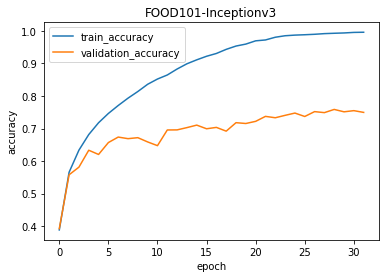

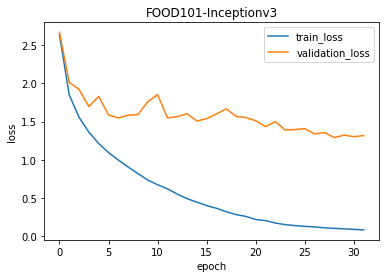

In [11]:
plot_accuracy(history,'FOOD101-Inceptionv3')
plot_loss(history,'FOOD101-Inceptionv3')